In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as k
import numpy as np
from scipy.stats import norm
from scipy.optimize import bisect
from time import time
from sklearn.utils import shuffle

In [2]:

def blackScholesPriceTrue(fwd, strike, mat, vol):
    sqt = vol * np.sqrt(mat)
    d1 = (np.log(fwd / strike) + 0.5 * vol* vol * mat)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - strike/fwd * n2

def blackScholesImliedVol(fwd, strike, mat, price):
    def func(x):        
        return blackScholesPriceTrue(fwd, strike, mat, x) - price
    return bisect(func, 0.00001, 1)

def blackScholesImliedHelper(arr):
    fwd, strike, mat, price = arr
    return blackScholesImliedVol(fwd, strike, mat, price)

def createDatasetIV(size):
    f = np.linspace(0.5, 1.5, size)
    strike = np.linspace(0.5, 1.5, size)
    mat = np.linspace(0.1, 1, size)
    options = np.linspace(0.01, 1, size)
    inputs = np.array(np.meshgrid(f, strike, mat, options)).T.reshape(-1, 4)
    
    vols = list(map(blackScholesImliedHelper, inputs))

    return inputs, vols.flatten()

def createDataset(size):
    f = np.linspace(1,1.5, size)
    strike = np.linspace(0.5,1.5, size)
    mat = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(f, strike, mat, vol)).T.reshape(-1, 4)
    options = blackScholesPriceTrue(inputs[:, 0],inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:, [-1]]
    inputs[:, -1] = options 
    return inputs, vols.flatten()

class VolSequence(k.utils.Sequence):

    def __init__(self, dataSetSize, batch_size):
        x, y = createDataset(dataSetSize)
        self.x, self.y = shuffle(x,y, random_state=0)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size,:]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y= shuffle(batch_x, batch_y, random_state=0)
        return batch_x, batch_y


In [3]:

def add_normalized_layer(h_units, activation='relu'):
    return [
        k.layers.Dense(h_units, use_bias=False),
        k.layers.BatchNormalization(),
        k.layers.Activation(activation)
            ]

def create_multy_model(h_layers, h_units, modelFile = None, activation='relu'):
    input = k.layers.Input(shape=(4,))
    seq_1 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_2 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_3 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    seq_4 = k.layers.Dense(units=h_units//4,  activation=activation)(input)
    for i in range(h_layers):
        seq_1 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_1)
        seq_2 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_2)
        seq_3 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_3)
        seq_4 = k.layers.Dense(units=h_units//4,  activation=activation)(seq_4)

    connect = k.layers.Concatenate()([seq_1, seq_2, seq_3, seq_4])
    
    reduce = k.layers.Dense(units=h_units//4,  activation=activation)(connect)
    
    final = k.layers.Dense(1)(reduce)
    model = k.models.Model(inputs=[input], outputs=[final])
    optimizer = k.optimizers.RMSprop(lr=0.001, clipnorm=5)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model

In [4]:

generator = VolSequence(20,512)
val_generator = VolSequence(5, 5**4)


In [5]:
modelFile = 'bsCalibratorModelMulti.hdf5'
layers = 16
hidden_units = 512
model = create_multy_model(layers, hidden_units, modelFile)

epochs = 100

checkpoint = k.callbacks.ModelCheckpoint(modelFile, monitor='val_loss')
tensorboard = k.callbacks.TensorBoard(log_dir='LOGS\\{}'.format(time()), histogram_freq=10, write_graph=True)
reduce_lr = k.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model.fit_generator(generator=generator, epochs=epochs, validation_data=val_generator, validation_freq=1, 
                    verbose=1, callbacks=[checkpoint,  reduce_lr])


W0323 14:38:11.899863 14948 deprecation.py:506] From D:\Projects\TweetGenerator\venvp37t2\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/100


  1/313 [..............................] - ETA: 1:07:39 - loss: 0.0857

  2/313 [..............................] - ETA: 33:56 - loss: 0.0716  

  3/313 [..............................] - ETA: 22:41 - loss: 0.1254

  4/313 [..............................] - ETA: 17:04 - loss: 0.1098

  5/313 [..............................] - ETA: 13:42 - loss: 0.0970

  6/313 [..............................] - ETA: 11:27 - loss: 0.0862

  7/313 [..............................] - ETA: 9:50 - loss: 0.0772 

  8/313 [..............................] - ETA: 8:38 - loss: 0.0704

  9/313 [..............................] - ETA: 7:42 - loss: 0.0650

 10/313 [..............................] - ETA: 6:57 - loss: 0.0607

 11/313 [>.............................] - ETA: 6:20 - loss: 0.0573

 12/313 [>.............................] - ETA: 5:49 - loss: 0.0542

 13/313 [>.............................] - ETA: 5:23 - loss: 0.0517

 14/313 [>.............................] - ETA: 5:01 - loss: 0.0497

 15/313 [>.............................] - ETA: 4:42 - loss: 0.0479

 16/313 [>.............................] - ETA: 4:25 - loss: 0.0463

 17/313 [>.............................] - ETA: 4:10 - loss: 0.0448

 18/313 [>.............................] - ETA: 3:56 - loss: 0.0436

 19/313 [>.............................] - ETA: 3:45 - loss: 0.0425

 20/313 [>.............................] - ETA: 3:34 - loss: 0.0414

 21/313 [=>............................] - ETA: 3:24 - loss: 0.0405

 22/313 [=>............................] - ETA: 3:15 - loss: 0.0396

 23/313 [=>............................] - ETA: 3:07 - loss: 0.0389

 24/313 [=>............................] - ETA: 3:00 - loss: 0.0383

 25/313 [=>............................] - ETA: 2:53 - loss: 0.0376

 26/313 [=>............................] - ETA: 2:47 - loss: 0.0370

 27/313 [=>............................] - ETA: 2:41 - loss: 0.0365

 28/313 [=>............................] - ETA: 2:35 - loss: 0.0359

 29/313 [=>............................] - ETA: 2:30 - loss: 0.0354

 30/313 [=>............................] - ETA: 2:26 - loss: 0.0350

 31/313 [=>............................] - ETA: 2:21 - loss: 0.0346

 32/313 [==>...........................] - ETA: 2:17 - loss: 0.0341

 33/313 [==>...........................] - ETA: 2:13 - loss: 0.0338

 34/313 [==>...........................] - ETA: 2:09 - loss: 0.0336

 35/313 [==>...........................] - ETA: 2:06 - loss: 0.0334

 36/313 [==>...........................] - ETA: 2:03 - loss: 0.0333

 37/313 [==>...........................] - ETA: 1:59 - loss: 0.0330

 38/313 [==>...........................] - ETA: 1:56 - loss: 0.0327

 39/313 [==>...........................] - ETA: 1:54 - loss: 0.0325

 40/313 [==>...........................] - ETA: 1:51 - loss: 0.0322

 41/313 [==>...........................] - ETA: 1:48 - loss: 0.0320

 42/313 [===>..........................] - ETA: 1:46 - loss: 0.0318

 43/313 [===>..........................] - ETA: 1:44 - loss: 0.0316

 44/313 [===>..........................] - ETA: 1:41 - loss: 0.0314

 45/313 [===>..........................] - ETA: 1:39 - loss: 0.0312

 46/313 [===>..........................] - ETA: 1:37 - loss: 0.0310

 47/313 [===>..........................] - ETA: 1:35 - loss: 0.0308

 48/313 [===>..........................] - ETA: 1:33 - loss: 0.0306

 49/313 [===>..........................] - ETA: 1:32 - loss: 0.0304

 50/313 [===>..........................] - ETA: 1:30 - loss: 0.0303

 51/313 [===>..........................] - ETA: 1:28 - loss: 0.0302

 52/313 [===>..........................] - ETA: 1:27 - loss: 0.0301

 53/313 [====>.........................] - ETA: 1:25 - loss: 0.0301

 54/313 [====>.........................] - ETA: 1:23 - loss: 0.0299

 55/313 [====>.........................] - ETA: 1:22 - loss: 0.0298

 56/313 [====>.........................] - ETA: 1:21 - loss: 0.0297

 57/313 [====>.........................] - ETA: 1:19 - loss: 0.0296

 58/313 [====>.........................] - ETA: 1:18 - loss: 0.0295

 59/313 [====>.........................] - ETA: 1:17 - loss: 0.0294

 60/313 [====>.........................] - ETA: 1:15 - loss: 0.0293

 61/313 [====>.........................] - ETA: 1:14 - loss: 0.0292

 62/313 [====>.........................] - ETA: 1:13 - loss: 0.0290

 63/313 [=====>........................] - ETA: 1:12 - loss: 0.0289

 64/313 [=====>........................] - ETA: 1:11 - loss: 0.0288

 65/313 [=====>........................] - ETA: 1:10 - loss: 0.0287

 66/313 [=====>........................] - ETA: 1:09 - loss: 0.0286

 67/313 [=====>........................] - ETA: 1:08 - loss: 0.0285



 68/313 [=====>........................] - ETA: 1:07 - loss: 0.0285

 69/313 [=====>........................] - ETA: 1:06 - loss: 0.0284

 70/313 [=====>........................] - ETA: 1:05 - loss: 0.0283

 71/313 [=====>........................] - ETA: 1:04 - loss: 0.0282

 72/313 [=====>........................] - ETA: 1:03 - loss: 0.0281

 73/313 [=====>........................] - ETA: 1:02 - loss: 0.0280

 74/313 [======>.......................] - ETA: 1:02 - loss: 0.0279

 75/313 [======>.......................] - ETA: 1:01 - loss: 0.0278

 76/313 [======>.......................] - ETA: 1:00 - loss: 0.0278

 77/313 [======>.......................] - ETA: 59s - loss: 0.0277 

 78/313 [======>.......................] - ETA: 58s - loss: 0.0277

 79/313 [======>.......................] - ETA: 58s - loss: 0.0276

 80/313 [======>.......................] - ETA: 57s - loss: 0.0275

 81/313 [======>.......................] - ETA: 56s - loss: 0.0275

 82/313 [======>.......................] - ETA: 56s - loss: 0.0274

 83/313 [======>.......................] - ETA: 55s - loss: 0.0273

 84/313 [=======>......................] - ETA: 54s - loss: 0.0273

 85/313 [=======>......................] - ETA: 54s - loss: 0.0272

 86/313 [=======>......................] - ETA: 53s - loss: 0.0272

 87/313 [=======>......................] - ETA: 52s - loss: 0.0271

 88/313 [=======>......................] - ETA: 52s - loss: 0.0271

 89/313 [=======>......................] - ETA: 51s - loss: 0.0271

 90/313 [=======>......................] - ETA: 50s - loss: 0.0271

 91/313 [=======>......................] - ETA: 50s - loss: 0.0270

 92/313 [=======>......................] - ETA: 49s - loss: 0.0270

 93/313 [=======>......................] - ETA: 49s - loss: 0.0269

 94/313 [========>.....................] - ETA: 48s - loss: 0.0268

 95/313 [========>.....................] - ETA: 48s - loss: 0.0268

 96/313 [========>.....................] - ETA: 47s - loss: 0.0268

 97/313 [========>.....................] - ETA: 47s - loss: 0.0267

 98/313 [========>.....................] - ETA: 46s - loss: 0.0267

 99/313 [========>.....................] - ETA: 46s - loss: 0.0266

100/313 [========>.....................] - ETA: 45s - loss: 0.0266

101/313 [========>.....................] - ETA: 45s - loss: 0.0266

102/313 [========>.....................] - ETA: 44s - loss: 0.0265

103/313 [========>.....................] - ETA: 44s - loss: 0.0265

104/313 [========>.....................] - ETA: 43s - loss: 0.0265

105/313 [=========>....................] - ETA: 43s - loss: 0.0265

106/313 [=========>....................] - ETA: 42s - loss: 0.0265

107/313 [=========>....................] - ETA: 42s - loss: 0.0264

108/313 [=========>....................] - ETA: 41s - loss: 0.0264

109/313 [=========>....................] - ETA: 41s - loss: 0.0263

110/313 [=========>....................] - ETA: 41s - loss: 0.0263

111/313 [=========>....................] - ETA: 40s - loss: 0.0263

112/313 [=========>....................] - ETA: 40s - loss: 0.0263

113/313 [=========>....................] - ETA: 39s - loss: 0.0262

114/313 [=========>....................] - ETA: 39s - loss: 0.0262

115/313 [==========>...................] - ETA: 39s - loss: 0.0262

116/313 [==========>...................] - ETA: 38s - loss: 0.0261

117/313 [==========>...................] - ETA: 38s - loss: 0.0261

118/313 [==========>...................] - ETA: 37s - loss: 0.0261

119/313 [==========>...................] - ETA: 37s - loss: 0.0261

120/313 [==========>...................] - ETA: 37s - loss: 0.0260

121/313 [==========>...................] - ETA: 36s - loss: 0.0260

122/313 [==========>...................] - ETA: 36s - loss: 0.0260

123/313 [==========>...................] - ETA: 36s - loss: 0.0260

124/313 [==========>...................] - ETA: 35s - loss: 0.0259

125/313 [==========>...................] - ETA: 35s - loss: 0.0259

126/313 [===========>..................] - ETA: 35s - loss: 0.0259

127/313 [===========>..................] - ETA: 34s - loss: 0.0258

128/313 [===========>..................] - ETA: 34s - loss: 0.0258

129/313 [===========>..................] - ETA: 34s - loss: 0.0258

130/313 [===========>..................] - ETA: 33s - loss: 0.0257

131/313 [===========>..................] - ETA: 33s - loss: 0.0257

132/313 [===========>..................] - ETA: 33s - loss: 0.0257

133/313 [===========>..................] - ETA: 32s - loss: 0.0257

134/313 [===========>..................] - ETA: 32s - loss: 0.0256

135/313 [===========>..................] - ETA: 32s - loss: 0.0257

136/313 [============>.................] - ETA: 31s - loss: 0.0256

137/313 [============>.................] - ETA: 31s - loss: 0.0256

138/313 [============>.................] - ETA: 31s - loss: 0.0256

139/313 [============>.................] - ETA: 30s - loss: 0.0256

140/313 [============>.................] - ETA: 30s - loss: 0.0255

141/313 [============>.................] - ETA: 30s - loss: 0.0255

142/313 [============>.................] - ETA: 30s - loss: 0.0255

143/313 [============>.................] - ETA: 29s - loss: 0.0255

144/313 [============>.................] - ETA: 29s - loss: 0.0255

145/313 [============>.................] - ETA: 29s - loss: 0.0255

146/313 [============>.................] - ETA: 28s - loss: 0.0254

147/313 [=============>................] - ETA: 28s - loss: 0.0254

148/313 [=============>................] - ETA: 28s - loss: 0.0254

149/313 [=============>................] - ETA: 28s - loss: 0.0254

150/313 [=============>................] - ETA: 27s - loss: 0.0254

151/313 [=============>................] - ETA: 27s - loss: 0.0254

152/313 [=============>................] - ETA: 27s - loss: 0.0254

153/313 [=============>................] - ETA: 27s - loss: 0.0253

154/313 [=============>................] - ETA: 26s - loss: 0.0253

155/313 [=============>................] - ETA: 26s - loss: 0.0253

156/313 [=============>................] - ETA: 26s - loss: 0.0253

157/313 [==============>...............] - ETA: 26s - loss: 0.0253

158/313 [==============>...............] - ETA: 25s - loss: 0.0252

159/313 [==============>...............] - ETA: 25s - loss: 0.0252

160/313 [==============>...............] - ETA: 25s - loss: 0.0252

161/313 [==============>...............] - ETA: 25s - loss: 0.0252

162/313 [==============>...............] - ETA: 24s - loss: 0.0251

163/313 [==============>...............] - ETA: 24s - loss: 0.0251

164/313 [==============>...............] - ETA: 24s - loss: 0.0251

165/313 [==============>...............] - ETA: 24s - loss: 0.0251

166/313 [==============>...............] - ETA: 23s - loss: 0.0251

167/313 [===============>..............] - ETA: 23s - loss: 0.0251

168/313 [===============>..............] - ETA: 23s - loss: 0.0251

169/313 [===============>..............] - ETA: 23s - loss: 0.0251

170/313 [===============>..............] - ETA: 23s - loss: 0.0251

171/313 [===============>..............] - ETA: 22s - loss: 0.0251

172/313 [===============>..............] - ETA: 22s - loss: 0.0250

173/313 [===============>..............] - ETA: 22s - loss: 0.0250

174/313 [===============>..............] - ETA: 22s - loss: 0.0250

175/313 [===============>..............] - ETA: 21s - loss: 0.0250

176/313 [===============>..............] - ETA: 21s - loss: 0.0250

177/313 [===============>..............] - ETA: 21s - loss: 0.0250

178/313 [================>.............] - ETA: 21s - loss: 0.0250

179/313 [================>.............] - ETA: 21s - loss: 0.0250

180/313 [================>.............] - ETA: 20s - loss: 0.0249

181/313 [================>.............] - ETA: 20s - loss: 0.0249

182/313 [================>.............] - ETA: 20s - loss: 0.0249

183/313 [================>.............] - ETA: 20s - loss: 0.0249

184/313 [================>.............] - ETA: 20s - loss: 0.0249

185/313 [================>.............] - ETA: 19s - loss: 0.0249

186/313 [================>.............] - ETA: 19s - loss: 0.0249

187/313 [================>.............] - ETA: 19s - loss: 0.0249

188/313 [=================>............] - ETA: 19s - loss: 0.0248

189/313 [=================>............] - ETA: 19s - loss: 0.0248

190/313 [=================>............] - ETA: 18s - loss: 0.0248

191/313 [=================>............] - ETA: 18s - loss: 0.0248

192/313 [=================>............] - ETA: 18s - loss: 0.0248

193/313 [=================>............] - ETA: 18s - loss: 0.0248

194/313 [=================>............] - ETA: 18s - loss: 0.0248

195/313 [=================>............] - ETA: 17s - loss: 0.0248

196/313 [=================>............] - ETA: 17s - loss: 0.0247

197/313 [=================>............] - ETA: 17s - loss: 0.0247

198/313 [=================>............] - ETA: 17s - loss: 0.0247

199/313 [==================>...........] - ETA: 17s - loss: 0.0247

200/313 [==================>...........] - ETA: 16s - loss: 0.0247

201/313 [==================>...........] - ETA: 16s - loss: 0.0247

202/313 [==================>...........] - ETA: 16s - loss: 0.0247

203/313 [==================>...........] - ETA: 16s - loss: 0.0246

204/313 [==================>...........] - ETA: 16s - loss: 0.0246

205/313 [==================>...........] - ETA: 15s - loss: 0.0246

206/313 [==================>...........] - ETA: 15s - loss: 0.0246

207/313 [==================>...........] - ETA: 15s - loss: 0.0246

208/313 [==================>...........] - ETA: 15s - loss: 0.0246

209/313 [===================>..........] - ETA: 15s - loss: 0.0246

210/313 [===================>..........] - ETA: 15s - loss: 0.0246

211/313 [===================>..........] - ETA: 14s - loss: 0.0246

212/313 [===================>..........] - ETA: 14s - loss: 0.0246

213/313 [===================>..........] - ETA: 14s - loss: 0.0246

214/313 [===================>..........] - ETA: 14s - loss: 0.0245

215/313 [===================>..........] - ETA: 14s - loss: 0.0245

216/313 [===================>..........] - ETA: 14s - loss: 0.0245

217/313 [===================>..........] - ETA: 13s - loss: 0.0245

218/313 [===================>..........] - ETA: 13s - loss: 0.0245

219/313 [===================>..........] - ETA: 13s - loss: 0.0245

220/313 [====================>.........] - ETA: 13s - loss: 0.0245

221/313 [====================>.........] - ETA: 13s - loss: 0.0245

222/313 [====================>.........] - ETA: 13s - loss: 0.0245

223/313 [====================>.........] - ETA: 12s - loss: 0.0245

224/313 [====================>.........] - ETA: 12s - loss: 0.0245

225/313 [====================>.........] - ETA: 12s - loss: 0.0244

226/313 [====================>.........] - ETA: 12s - loss: 0.0244

227/313 [====================>.........] - ETA: 12s - loss: 0.0244

228/313 [====================>.........] - ETA: 12s - loss: 0.0244

229/313 [====================>.........] - ETA: 11s - loss: 0.0244

230/313 [=====================>........] - ETA: 11s - loss: 0.0244

231/313 [=====================>........] - ETA: 11s - loss: 0.0244

232/313 [=====================>........] - ETA: 11s - loss: 0.0244

233/313 [=====================>........] - ETA: 11s - loss: 0.0244

234/313 [=====================>........] - ETA: 11s - loss: 0.0244

235/313 [=====================>........] - ETA: 10s - loss: 0.0244

236/313 [=====================>........] - ETA: 10s - loss: 0.0243

237/313 [=====================>........] - ETA: 10s - loss: 0.0243

238/313 [=====================>........] - ETA: 10s - loss: 0.0243

239/313 [=====================>........] - ETA: 10s - loss: 0.0243

240/313 [======================>.......] - ETA: 10s - loss: 0.0243

241/313 [======================>.......] - ETA: 9s - loss: 0.0243 

242/313 [======================>.......] - ETA: 9s - loss: 0.0243

243/313 [======================>.......] - ETA: 9s - loss: 0.0243

244/313 [======================>.......] - ETA: 9s - loss: 0.0243

245/313 [======================>.......] - ETA: 9s - loss: 0.0243

246/313 [======================>.......] - ETA: 9s - loss: 0.0243

247/313 [======================>.......] - ETA: 9s - loss: 0.0242

248/313 [======================>.......] - ETA: 8s - loss: 0.0242

249/313 [======================>.......] - ETA: 8s - loss: 0.0242



250/313 [======================>.......] - ETA: 8s - loss: 0.0242

251/313 [=======================>......] - ETA: 8s - loss: 0.0242

252/313 [=======================>......] - ETA: 8s - loss: 0.0242

253/313 [=======================>......] - ETA: 8s - loss: 0.0242

254/313 [=======================>......] - ETA: 8s - loss: 0.0242

255/313 [=======================>......] - ETA: 7s - loss: 0.0242

256/313 [=======================>......] - ETA: 7s - loss: 0.0242

257/313 [=======================>......] - ETA: 7s - loss: 0.0242

258/313 [=======================>......] - ETA: 7s - loss: 0.0242

259/313 [=======================>......] - ETA: 7s - loss: 0.0241

260/313 [=======================>......] - ETA: 7s - loss: 0.0241

261/313 [========================>.....] - ETA: 6s - loss: 0.0241

262/313 [========================>.....] - ETA: 6s - loss: 0.0241

263/313 [========================>.....] - ETA: 6s - loss: 0.0241

264/313 [========================>.....] - ETA: 6s - loss: 0.0241

265/313 [========================>.....] - ETA: 6s - loss: 0.0241

266/313 [========================>.....] - ETA: 6s - loss: 0.0241

267/313 [========================>.....] - ETA: 6s - loss: 0.0241

268/313 [========================>.....] - ETA: 5s - loss: 0.0241

269/313 [========================>.....] - ETA: 5s - loss: 0.0241

270/313 [========================>.....] - ETA: 5s - loss: 0.0241

271/313 [========================>.....] - ETA: 5s - loss: 0.0241

272/313 [=========================>....] - ETA: 5s - loss: 0.0241

273/313 [=========================>....] - ETA: 5s - loss: 0.0240

274/313 [=========================>....] - ETA: 5s - loss: 0.0240

275/313 [=========================>....] - ETA: 5s - loss: 0.0240

276/313 [=========================>....] - ETA: 4s - loss: 0.0240

277/313 [=========================>....] - ETA: 4s - loss: 0.0240

278/313 [=========================>....] - ETA: 4s - loss: 0.0240

279/313 [=========================>....] - ETA: 4s - loss: 0.0240

280/313 [=========================>....] - ETA: 4s - loss: 0.0240

281/313 [=========================>....] - ETA: 4s - loss: 0.0240

282/313 [==========================>...] - ETA: 4s - loss: 0.0240

283/313 [==========================>...] - ETA: 3s - loss: 0.0240

284/313 [==========================>...] - ETA: 3s - loss: 0.0240

285/313 [==========================>...] - ETA: 3s - loss: 0.0240

286/313 [==========================>...] - ETA: 3s - loss: 0.0240

287/313 [==========================>...] - ETA: 3s - loss: 0.0240

288/313 [==========================>...] - ETA: 3s - loss: 0.0239

289/313 [==========================>...] - ETA: 3s - loss: 0.0239

290/313 [==========================>...] - ETA: 2s - loss: 0.0239

291/313 [==========================>...] - ETA: 2s - loss: 0.0239

292/313 [==========================>...] - ETA: 2s - loss: 0.0239

293/313 [===========================>..] - ETA: 2s - loss: 0.0239

294/313 [===========================>..] - ETA: 2s - loss: 0.0239

295/313 [===========================>..] - ETA: 2s - loss: 0.0239

296/313 [===========================>..] - ETA: 2s - loss: 0.0239

297/313 [===========================>..] - ETA: 2s - loss: 0.0239

298/313 [===========================>..] - ETA: 1s - loss: 0.0239

299/313 [===========================>..] - ETA: 1s - loss: 0.0239

300/313 [===========================>..] - ETA: 1s - loss: 0.0239

301/313 [===========================>..] - ETA: 1s - loss: 0.0239

302/313 [===========================>..] - ETA: 1s - loss: 0.0239

303/313 [============================>.] - ETA: 1s - loss: 0.0239

304/313 [============================>.] - ETA: 1s - loss: 0.0239

305/313 [============================>.] - ETA: 1s - loss: 0.0239

306/313 [============================>.] - ETA: 0s - loss: 0.0238

307/313 [============================>.] - ETA: 0s - loss: 0.0238

308/313 [============================>.] - ETA: 0s - loss: 0.0238

309/313 [============================>.] - ETA: 0s - loss: 0.0238

310/313 [============================>.] - ETA: 0s - loss: 0.0238

311/313 [============================>.] - ETA: 0s - loss: 0.0238

312/313 [============================>.] - ETA: 0s - loss: 0.0238

313/313 [==============================] - 48s 155ms/step - loss: 0.0238 - val_loss: 0.0301


Epoch 2/100
  1/313 [..............................] - ETA: 26s - loss: 0.0234

  2/313 [..............................] - ETA: 26s - loss: 0.0231

  3/313 [..............................] - ETA: 26s - loss: 0.0223

  4/313 [..............................] - ETA: 26s - loss: 0.0216

  5/313 [..............................] - ETA: 26s - loss: 0.0216

  6/313 [..............................] - ETA: 26s - loss: 0.0221

  7/313 [..............................] - ETA: 25s - loss: 0.0222

  8/313 [..............................] - ETA: 25s - loss: 0.0218

  9/313 [..............................] - ETA: 25s - loss: 0.0219

 10/313 [..............................] - ETA: 25s - loss: 0.0218

 11/313 [>.............................] - ETA: 25s - loss: 0.0219

 12/313 [>.............................] - ETA: 25s - loss: 0.0219

 13/313 [>.............................] - ETA: 25s - loss: 0.0217

 14/313 [>.............................] - ETA: 25s - loss: 0.0216

 15/313 [>.............................] - ETA: 25s - loss: 0.0221

 16/313 [>.............................] - ETA: 25s - loss: 0.0223

 17/313 [>.............................] - ETA: 25s - loss: 0.0222

 18/313 [>.............................] - ETA: 25s - loss: 0.0221

 19/313 [>.............................] - ETA: 25s - loss: 0.0220

 20/313 [>.............................] - ETA: 25s - loss: 0.0219

 21/313 [=>............................] - ETA: 25s - loss: 0.0220

 22/313 [=>............................] - ETA: 24s - loss: 0.0220

 23/313 [=>............................] - ETA: 24s - loss: 0.0219

 24/313 [=>............................] - ETA: 24s - loss: 0.0219

 25/313 [=>............................] - ETA: 24s - loss: 0.0218

 26/313 [=>............................] - ETA: 24s - loss: 0.0218

 27/313 [=>............................] - ETA: 24s - loss: 0.0218

 28/313 [=>............................] - ETA: 24s - loss: 0.0218

 29/313 [=>............................] - ETA: 24s - loss: 0.0217

 30/313 [=>............................] - ETA: 24s - loss: 0.0218

 31/313 [=>............................] - ETA: 24s - loss: 0.0218

 32/313 [==>...........................] - ETA: 24s - loss: 0.0218

 33/313 [==>...........................] - ETA: 24s - loss: 0.0218

 34/313 [==>...........................] - ETA: 23s - loss: 0.0217

 35/313 [==>...........................] - ETA: 23s - loss: 0.0216

 36/313 [==>...........................] - ETA: 23s - loss: 0.0216

 37/313 [==>...........................] - ETA: 23s - loss: 0.0217

 38/313 [==>...........................] - ETA: 23s - loss: 0.0217

 39/313 [==>...........................] - ETA: 23s - loss: 0.0217

 40/313 [==>...........................] - ETA: 23s - loss: 0.0216

 41/313 [==>...........................] - ETA: 23s - loss: 0.0217

 42/313 [===>..........................] - ETA: 23s - loss: 0.0217

 43/313 [===>..........................] - ETA: 23s - loss: 0.0216

 44/313 [===>..........................] - ETA: 23s - loss: 0.0216

 45/313 [===>..........................] - ETA: 22s - loss: 0.0216

 46/313 [===>..........................] - ETA: 22s - loss: 0.0217

 47/313 [===>..........................] - ETA: 22s - loss: 0.0217

 48/313 [===>..........................] - ETA: 22s - loss: 0.0216

 49/313 [===>..........................] - ETA: 22s - loss: 0.0216

 50/313 [===>..........................] - ETA: 22s - loss: 0.0216

 51/313 [===>..........................] - ETA: 22s - loss: 0.0217

 52/313 [===>..........................] - ETA: 22s - loss: 0.0217

 53/313 [====>.........................] - ETA: 22s - loss: 0.0217

 54/313 [====>.........................] - ETA: 22s - loss: 0.0216

 55/313 [====>.........................] - ETA: 22s - loss: 0.0216

 56/313 [====>.........................] - ETA: 21s - loss: 0.0216

 57/313 [====>.........................] - ETA: 21s - loss: 0.0216

 58/313 [====>.........................] - ETA: 21s - loss: 0.0216

 59/313 [====>.........................] - ETA: 21s - loss: 0.0216

 60/313 [====>.........................] - ETA: 21s - loss: 0.0216

 61/313 [====>.........................] - ETA: 21s - loss: 0.0217

 62/313 [====>.........................] - ETA: 21s - loss: 0.0217

 63/313 [=====>........................] - ETA: 21s - loss: 0.0217

 64/313 [=====>........................] - ETA: 21s - loss: 0.0217

 65/313 [=====>........................] - ETA: 21s - loss: 0.0217

 66/313 [=====>........................] - ETA: 21s - loss: 0.0217

 67/313 [=====>........................] - ETA: 21s - loss: 0.0217

 68/313 [=====>........................] - ETA: 20s - loss: 0.0217

 69/313 [=====>........................] - ETA: 20s - loss: 0.0217

 70/313 [=====>........................] - ETA: 20s - loss: 0.0216

 71/313 [=====>........................] - ETA: 20s - loss: 0.0216

 72/313 [=====>........................] - ETA: 20s - loss: 0.0216

 73/313 [=====>........................] - ETA: 20s - loss: 0.0216

 74/313 [======>.......................] - ETA: 20s - loss: 0.0216

 75/313 [======>.......................] - ETA: 20s - loss: 0.0216

 76/313 [======>.......................] - ETA: 20s - loss: 0.0216

 77/313 [======>.......................] - ETA: 20s - loss: 0.0215

 78/313 [======>.......................] - ETA: 20s - loss: 0.0215

 79/313 [======>.......................] - ETA: 19s - loss: 0.0215

 80/313 [======>.......................] - ETA: 19s - loss: 0.0215

 81/313 [======>.......................] - ETA: 19s - loss: 0.0215

 82/313 [======>.......................] - ETA: 19s - loss: 0.0215

 83/313 [======>.......................] - ETA: 19s - loss: 0.0215

 84/313 [=======>......................] - ETA: 19s - loss: 0.0215

 85/313 [=======>......................] - ETA: 19s - loss: 0.0215

 86/313 [=======>......................] - ETA: 19s - loss: 0.0214

 87/313 [=======>......................] - ETA: 19s - loss: 0.0214

 88/313 [=======>......................] - ETA: 19s - loss: 0.0214

 89/313 [=======>......................] - ETA: 19s - loss: 0.0214

 90/313 [=======>......................] - ETA: 18s - loss: 0.0214

 91/313 [=======>......................] - ETA: 18s - loss: 0.0214

 92/313 [=======>......................] - ETA: 18s - loss: 0.0214

 93/313 [=======>......................] - ETA: 18s - loss: 0.0213

 94/313 [========>.....................] - ETA: 18s - loss: 0.0213

 95/313 [========>.....................] - ETA: 18s - loss: 0.0214

 96/313 [========>.....................] - ETA: 18s - loss: 0.0214

 97/313 [========>.....................] - ETA: 18s - loss: 0.0214

 98/313 [========>.....................] - ETA: 18s - loss: 0.0214

 99/313 [========>.....................] - ETA: 18s - loss: 0.0214

100/313 [========>.....................] - ETA: 18s - loss: 0.0213

101/313 [========>.....................] - ETA: 18s - loss: 0.0213

102/313 [========>.....................] - ETA: 17s - loss: 0.0213

103/313 [========>.....................] - ETA: 17s - loss: 0.0213

104/313 [========>.....................] - ETA: 17s - loss: 0.0213

105/313 [=========>....................] - ETA: 17s - loss: 0.0213

106/313 [=========>....................] - ETA: 17s - loss: 0.0213

107/313 [=========>....................] - ETA: 17s - loss: 0.0213

108/313 [=========>....................] - ETA: 17s - loss: 0.0213

109/313 [=========>....................] - ETA: 17s - loss: 0.0213

110/313 [=========>....................] - ETA: 17s - loss: 0.0212

111/313 [=========>....................] - ETA: 17s - loss: 0.0212

112/313 [=========>....................] - ETA: 17s - loss: 0.0213

113/313 [=========>....................] - ETA: 16s - loss: 0.0213

114/313 [=========>....................] - ETA: 16s - loss: 0.0213

115/313 [==========>...................] - ETA: 16s - loss: 0.0213

116/313 [==========>...................] - ETA: 16s - loss: 0.0213

117/313 [==========>...................] - ETA: 16s - loss: 0.0212

118/313 [==========>...................] - ETA: 16s - loss: 0.0212

119/313 [==========>...................] - ETA: 16s - loss: 0.0212

120/313 [==========>...................] - ETA: 16s - loss: 0.0212

121/313 [==========>...................] - ETA: 16s - loss: 0.0212

122/313 [==========>...................] - ETA: 16s - loss: 0.0212

123/313 [==========>...................] - ETA: 16s - loss: 0.0212

124/313 [==========>...................] - ETA: 16s - loss: 0.0211

125/313 [==========>...................] - ETA: 15s - loss: 0.0211

126/313 [===========>..................] - ETA: 15s - loss: 0.0211

127/313 [===========>..................] - ETA: 15s - loss: 0.0211

128/313 [===========>..................] - ETA: 15s - loss: 0.0211

129/313 [===========>..................] - ETA: 15s - loss: 0.0211

130/313 [===========>..................] - ETA: 15s - loss: 0.0211

131/313 [===========>..................] - ETA: 15s - loss: 0.0211

132/313 [===========>..................] - ETA: 15s - loss: 0.0211

133/313 [===========>..................] - ETA: 15s - loss: 0.0211

134/313 [===========>..................] - ETA: 15s - loss: 0.0211

135/313 [===========>..................] - ETA: 15s - loss: 0.0211

136/313 [============>.................] - ETA: 15s - loss: 0.0211

137/313 [============>.................] - ETA: 14s - loss: 0.0211

138/313 [============>.................] - ETA: 14s - loss: 0.0211

139/313 [============>.................] - ETA: 14s - loss: 0.0211

140/313 [============>.................] - ETA: 14s - loss: 0.0211

141/313 [============>.................] - ETA: 14s - loss: 0.0211

142/313 [============>.................] - ETA: 14s - loss: 0.0211

143/313 [============>.................] - ETA: 14s - loss: 0.0212

144/313 [============>.................] - ETA: 14s - loss: 0.0212

145/313 [============>.................] - ETA: 14s - loss: 0.0212

146/313 [============>.................] - ETA: 14s - loss: 0.0212

147/313 [=============>................] - ETA: 14s - loss: 0.0212

148/313 [=============>................] - ETA: 14s - loss: 0.0212

149/313 [=============>................] - ETA: 13s - loss: 0.0212

150/313 [=============>................] - ETA: 13s - loss: 0.0212

151/313 [=============>................] - ETA: 13s - loss: 0.0212

152/313 [=============>................] - ETA: 13s - loss: 0.0212

153/313 [=============>................] - ETA: 13s - loss: 0.0212

154/313 [=============>................] - ETA: 13s - loss: 0.0213

155/313 [=============>................] - ETA: 13s - loss: 0.0213

156/313 [=============>................] - ETA: 13s - loss: 0.0213

157/313 [==============>...............] - ETA: 13s - loss: 0.0212

158/313 [==============>...............] - ETA: 13s - loss: 0.0213

159/313 [==============>...............] - ETA: 13s - loss: 0.0213

160/313 [==============>...............] - ETA: 13s - loss: 0.0213

161/313 [==============>...............] - ETA: 12s - loss: 0.0213

162/313 [==============>...............] - ETA: 12s - loss: 0.0213

163/313 [==============>...............] - ETA: 12s - loss: 0.0213

164/313 [==============>...............] - ETA: 12s - loss: 0.0213

165/313 [==============>...............] - ETA: 12s - loss: 0.0213

166/313 [==============>...............] - ETA: 12s - loss: 0.0213

167/313 [===============>..............] - ETA: 12s - loss: 0.0214

168/313 [===============>..............] - ETA: 12s - loss: 0.0214

169/313 [===============>..............] - ETA: 12s - loss: 0.0214

170/313 [===============>..............] - ETA: 12s - loss: 0.0214

171/313 [===============>..............] - ETA: 12s - loss: 0.0213

172/313 [===============>..............] - ETA: 11s - loss: 0.0213

173/313 [===============>..............] - ETA: 11s - loss: 0.0213

174/313 [===============>..............] - ETA: 11s - loss: 0.0213

175/313 [===============>..............] - ETA: 11s - loss: 0.0214

176/313 [===============>..............] - ETA: 11s - loss: 0.0214

177/313 [===============>..............] - ETA: 11s - loss: 0.0214

178/313 [================>.............] - ETA: 11s - loss: 0.0214

179/313 [================>.............] - ETA: 11s - loss: 0.0214

180/313 [================>.............] - ETA: 11s - loss: 0.0214

181/313 [================>.............] - ETA: 11s - loss: 0.0214

182/313 [================>.............] - ETA: 11s - loss: 0.0214

183/313 [================>.............] - ETA: 11s - loss: 0.0214

184/313 [================>.............] - ETA: 10s - loss: 0.0213

185/313 [================>.............] - ETA: 10s - loss: 0.0213

186/313 [================>.............] - ETA: 10s - loss: 0.0213

187/313 [================>.............] - ETA: 10s - loss: 0.0213

188/313 [=================>............] - ETA: 10s - loss: 0.0214

189/313 [=================>............] - ETA: 10s - loss: 0.0214

190/313 [=================>............] - ETA: 10s - loss: 0.0214

191/313 [=================>............] - ETA: 10s - loss: 0.0213

192/313 [=================>............] - ETA: 10s - loss: 0.0213

193/313 [=================>............] - ETA: 10s - loss: 0.0213

194/313 [=================>............] - ETA: 10s - loss: 0.0213

195/313 [=================>............] - ETA: 10s - loss: 0.0213

196/313 [=================>............] - ETA: 9s - loss: 0.0213 

197/313 [=================>............] - ETA: 9s - loss: 0.0213

198/313 [=================>............] - ETA: 9s - loss: 0.0213

199/313 [==================>...........] - ETA: 9s - loss: 0.0213

200/313 [==================>...........] - ETA: 9s - loss: 0.0213

201/313 [==================>...........] - ETA: 9s - loss: 0.0213

202/313 [==================>...........] - ETA: 9s - loss: 0.0212

203/313 [==================>...........] - ETA: 9s - loss: 0.0213

204/313 [==================>...........] - ETA: 9s - loss: 0.0213

205/313 [==================>...........] - ETA: 9s - loss: 0.0213

206/313 [==================>...........] - ETA: 9s - loss: 0.0212

207/313 [==================>...........] - ETA: 9s - loss: 0.0212

208/313 [==================>...........] - ETA: 8s - loss: 0.0212

209/313 [===================>..........] - ETA: 8s - loss: 0.0212

210/313 [===================>..........] - ETA: 8s - loss: 0.0212

211/313 [===================>..........] - ETA: 8s - loss: 0.0212

212/313 [===================>..........] - ETA: 8s - loss: 0.0212

213/313 [===================>..........] - ETA: 8s - loss: 0.0212

214/313 [===================>..........] - ETA: 8s - loss: 0.0212

215/313 [===================>..........] - ETA: 8s - loss: 0.0212

216/313 [===================>..........] - ETA: 8s - loss: 0.0212

217/313 [===================>..........] - ETA: 8s - loss: 0.0212

218/313 [===================>..........] - ETA: 8s - loss: 0.0212

219/313 [===================>..........] - ETA: 7s - loss: 0.0212

220/313 [====================>.........] - ETA: 7s - loss: 0.0212

221/313 [====================>.........] - ETA: 7s - loss: 0.0212

222/313 [====================>.........] - ETA: 7s - loss: 0.0212

223/313 [====================>.........] - ETA: 7s - loss: 0.0212

224/313 [====================>.........] - ETA: 7s - loss: 0.0212

225/313 [====================>.........] - ETA: 7s - loss: 0.0212

226/313 [====================>.........] - ETA: 7s - loss: 0.0212

227/313 [====================>.........] - ETA: 7s - loss: 0.0212

228/313 [====================>.........] - ETA: 7s - loss: 0.0212

229/313 [====================>.........] - ETA: 7s - loss: 0.0212

230/313 [=====================>........] - ETA: 7s - loss: 0.0212

231/313 [=====================>........] - ETA: 6s - loss: 0.0212

232/313 [=====================>........] - ETA: 6s - loss: 0.0212

233/313 [=====================>........] - ETA: 6s - loss: 0.0212

234/313 [=====================>........] - ETA: 6s - loss: 0.0212

235/313 [=====================>........] - ETA: 6s - loss: 0.0212

236/313 [=====================>........] - ETA: 6s - loss: 0.0212

237/313 [=====================>........] - ETA: 6s - loss: 0.0212

238/313 [=====================>........] - ETA: 6s - loss: 0.0212

239/313 [=====================>........] - ETA: 6s - loss: 0.0212

240/313 [======================>.......] - ETA: 6s - loss: 0.0212

241/313 [======================>.......] - ETA: 6s - loss: 0.0211

242/313 [======================>.......] - ETA: 6s - loss: 0.0211

243/313 [======================>.......] - ETA: 5s - loss: 0.0211

244/313 [======================>.......] - ETA: 5s - loss: 0.0211

245/313 [======================>.......] - ETA: 5s - loss: 0.0211

246/313 [======================>.......] - ETA: 5s - loss: 0.0211

247/313 [======================>.......] - ETA: 5s - loss: 0.0211

248/313 [======================>.......] - ETA: 5s - loss: 0.0211

249/313 [======================>.......] - ETA: 5s - loss: 0.0211

250/313 [======================>.......] - ETA: 5s - loss: 0.0211

251/313 [=======================>......] - ETA: 5s - loss: 0.0211

252/313 [=======================>......] - ETA: 5s - loss: 0.0210

253/313 [=======================>......] - ETA: 5s - loss: 0.0210

254/313 [=======================>......] - ETA: 5s - loss: 0.0210

255/313 [=======================>......] - ETA: 4s - loss: 0.0210

256/313 [=======================>......] - ETA: 4s - loss: 0.0210

257/313 [=======================>......] - ETA: 4s - loss: 0.0210

258/313 [=======================>......] - ETA: 4s - loss: 0.0210

259/313 [=======================>......] - ETA: 4s - loss: 0.0210

260/313 [=======================>......] - ETA: 4s - loss: 0.0210

261/313 [========================>.....] - ETA: 4s - loss: 0.0210

262/313 [========================>.....] - ETA: 4s - loss: 0.0210

263/313 [========================>.....] - ETA: 4s - loss: 0.0210

264/313 [========================>.....] - ETA: 4s - loss: 0.0210

265/313 [========================>.....] - ETA: 4s - loss: 0.0210

266/313 [========================>.....] - ETA: 3s - loss: 0.0210

267/313 [========================>.....] - ETA: 3s - loss: 0.0210

268/313 [========================>.....] - ETA: 3s - loss: 0.0210

269/313 [========================>.....] - ETA: 3s - loss: 0.0210

270/313 [========================>.....] - ETA: 3s - loss: 0.0210

271/313 [========================>.....] - ETA: 3s - loss: 0.0210

272/313 [=========================>....] - ETA: 3s - loss: 0.0210

273/313 [=========================>....] - ETA: 3s - loss: 0.0210

274/313 [=========================>....] - ETA: 3s - loss: 0.0210

275/313 [=========================>....] - ETA: 3s - loss: 0.0210

276/313 [=========================>....] - ETA: 3s - loss: 0.0210

277/313 [=========================>....] - ETA: 3s - loss: 0.0210

278/313 [=========================>....] - ETA: 2s - loss: 0.0210

279/313 [=========================>....] - ETA: 2s - loss: 0.0210

280/313 [=========================>....] - ETA: 2s - loss: 0.0210

281/313 [=========================>....] - ETA: 2s - loss: 0.0210

282/313 [==========================>...] - ETA: 2s - loss: 0.0209

283/313 [==========================>...] - ETA: 2s - loss: 0.0209

284/313 [==========================>...] - ETA: 2s - loss: 0.0209

285/313 [==========================>...] - ETA: 2s - loss: 0.0209

286/313 [==========================>...] - ETA: 2s - loss: 0.0209

287/313 [==========================>...] - ETA: 2s - loss: 0.0209

288/313 [==========================>...] - ETA: 2s - loss: 0.0209

289/313 [==========================>...] - ETA: 2s - loss: 0.0209

290/313 [==========================>...] - ETA: 1s - loss: 0.0209

291/313 [==========================>...] - ETA: 1s - loss: 0.0209

292/313 [==========================>...] - ETA: 1s - loss: 0.0209

293/313 [===========================>..] - ETA: 1s - loss: 0.0211

294/313 [===========================>..] - ETA: 1s - loss: 0.0211

295/313 [===========================>..] - ETA: 1s - loss: 0.0211

296/313 [===========================>..] - ETA: 1s - loss: 0.0211

297/313 [===========================>..] - ETA: 1s - loss: 0.0210

298/313 [===========================>..] - ETA: 1s - loss: 0.0210

299/313 [===========================>..] - ETA: 1s - loss: 0.0210

300/313 [===========================>..] - ETA: 1s - loss: 0.0210

301/313 [===========================>..] - ETA: 1s - loss: 0.0210

302/313 [===========================>..] - ETA: 0s - loss: 0.0210

303/313 [============================>.] - ETA: 0s - loss: 0.0210

304/313 [============================>.] - ETA: 0s - loss: 0.0210

305/313 [============================>.] - ETA: 0s - loss: 0.0210

306/313 [============================>.] - ETA: 0s - loss: 0.0210

307/313 [============================>.] - ETA: 0s - loss: 0.0210

308/313 [============================>.] - ETA: 0s - loss: 0.0210

309/313 [============================>.] - ETA: 0s - loss: 0.0210

310/313 [============================>.] - ETA: 0s - loss: 0.0210

311/313 [============================>.] - ETA: 0s - loss: 0.0210

312/313 [============================>.] - ETA: 0s - loss: 0.0209

313/313 [==============================] - 28s 89ms/step - loss: 0.0209 - val_loss: 0.0231


Epoch 3/100
  1/313 [..............................] - ETA: 25s - loss: 0.0156

  2/313 [..............................] - ETA: 26s - loss: 0.0159

  3/313 [..............................] - ETA: 26s - loss: 0.0162

  4/313 [..............................] - ETA: 26s - loss: 0.0174

  5/313 [..............................] - ETA: 26s - loss: 0.0181

  6/313 [..............................] - ETA: 26s - loss: 0.0185

  7/313 [..............................] - ETA: 26s - loss: 0.0181

  8/313 [..............................] - ETA: 26s - loss: 0.0180

  9/313 [..............................] - ETA: 26s - loss: 0.0179

 10/313 [..............................] - ETA: 25s - loss: 0.0180

 11/313 [>.............................] - ETA: 25s - loss: 0.0183

 12/313 [>.............................] - ETA: 25s - loss: 0.0185

 13/313 [>.............................] - ETA: 25s - loss: 0.0185

 14/313 [>.............................] - ETA: 25s - loss: 0.0187

 15/313 [>.............................] - ETA: 25s - loss: 0.0186

 16/313 [>.............................] - ETA: 25s - loss: 0.0185

 17/313 [>.............................] - ETA: 25s - loss: 0.0184

 18/313 [>.............................] - ETA: 25s - loss: 0.0183

 19/313 [>.............................] - ETA: 25s - loss: 0.0181

 20/313 [>.............................] - ETA: 24s - loss: 0.0183

 21/313 [=>............................] - ETA: 24s - loss: 0.0189

 22/313 [=>............................] - ETA: 24s - loss: 0.0190



 23/313 [=>............................] - ETA: 24s - loss: 0.0189

 24/313 [=>............................] - ETA: 24s - loss: 0.0187

 25/313 [=>............................] - ETA: 24s - loss: 0.0186

 26/313 [=>............................] - ETA: 24s - loss: 0.0185

 27/313 [=>............................] - ETA: 24s - loss: 0.0184

 28/313 [=>............................] - ETA: 24s - loss: 0.0183

 29/313 [=>............................] - ETA: 24s - loss: 0.0185

 30/313 [=>............................] - ETA: 24s - loss: 0.0185

 31/313 [=>............................] - ETA: 24s - loss: 0.0185

 32/313 [==>...........................] - ETA: 24s - loss: 0.0185

 33/313 [==>...........................] - ETA: 23s - loss: 0.0185

 34/313 [==>...........................] - ETA: 23s - loss: 0.0186

 35/313 [==>...........................] - ETA: 23s - loss: 0.0187

 36/313 [==>...........................] - ETA: 23s - loss: 0.0187

 37/313 [==>...........................] - ETA: 23s - loss: 0.0186

 38/313 [==>...........................] - ETA: 23s - loss: 0.0185

 39/313 [==>...........................] - ETA: 23s - loss: 0.0186

 40/313 [==>...........................] - ETA: 23s - loss: 0.0187

 41/313 [==>...........................] - ETA: 23s - loss: 0.0187

 42/313 [===>..........................] - ETA: 23s - loss: 0.0187

 43/313 [===>..........................] - ETA: 23s - loss: 0.0186

 44/313 [===>..........................] - ETA: 22s - loss: 0.0186

 45/313 [===>..........................] - ETA: 22s - loss: 0.0185

 46/313 [===>..........................] - ETA: 22s - loss: 0.0185

 47/313 [===>..........................] - ETA: 22s - loss: 0.0186

 48/313 [===>..........................] - ETA: 22s - loss: 0.0187

 49/313 [===>..........................] - ETA: 22s - loss: 0.0186

 50/313 [===>..........................] - ETA: 22s - loss: 0.0186

 51/313 [===>..........................] - ETA: 22s - loss: 0.0186

 52/313 [===>..........................] - ETA: 22s - loss: 0.0186

 53/313 [====>.........................] - ETA: 22s - loss: 0.0187

 54/313 [====>.........................] - ETA: 22s - loss: 0.0187

 55/313 [====>.........................] - ETA: 22s - loss: 0.0187

 56/313 [====>.........................] - ETA: 21s - loss: 0.0187

 57/313 [====>.........................] - ETA: 21s - loss: 0.0186

 58/313 [====>.........................] - ETA: 21s - loss: 0.0185

 59/313 [====>.........................] - ETA: 21s - loss: 0.0185

 60/313 [====>.........................] - ETA: 21s - loss: 0.0186

 61/313 [====>.........................] - ETA: 21s - loss: 0.0186

 62/313 [====>.........................] - ETA: 21s - loss: 0.0187

 63/313 [=====>........................] - ETA: 21s - loss: 0.0186

 64/313 [=====>........................] - ETA: 21s - loss: 0.0186

 65/313 [=====>........................] - ETA: 21s - loss: 0.0186

 66/313 [=====>........................] - ETA: 21s - loss: 0.0187

 67/313 [=====>........................] - ETA: 21s - loss: 0.0187

 68/313 [=====>........................] - ETA: 20s - loss: 0.0186

 69/313 [=====>........................] - ETA: 20s - loss: 0.0186

 70/313 [=====>........................] - ETA: 20s - loss: 0.0185

 71/313 [=====>........................] - ETA: 20s - loss: 0.0185

 72/313 [=====>........................] - ETA: 20s - loss: 0.0185

 73/313 [=====>........................] - ETA: 20s - loss: 0.0185

 74/313 [======>.......................] - ETA: 20s - loss: 0.0184

 75/313 [======>.......................] - ETA: 20s - loss: 0.0184

 76/313 [======>.......................] - ETA: 20s - loss: 0.0184

 77/313 [======>.......................] - ETA: 20s - loss: 0.0185

 78/313 [======>.......................] - ETA: 20s - loss: 0.0185

 79/313 [======>.......................] - ETA: 20s - loss: 0.0185

 80/313 [======>.......................] - ETA: 19s - loss: 0.0184

 81/313 [======>.......................] - ETA: 19s - loss: 0.0184

 82/313 [======>.......................] - ETA: 19s - loss: 0.0184

 83/313 [======>.......................] - ETA: 19s - loss: 0.0187

 84/313 [=======>......................] - ETA: 19s - loss: 0.0187

 85/313 [=======>......................] - ETA: 19s - loss: 0.0187

 86/313 [=======>......................] - ETA: 19s - loss: 0.0187

 87/313 [=======>......................] - ETA: 19s - loss: 0.0186

 88/313 [=======>......................] - ETA: 19s - loss: 0.0186

 89/313 [=======>......................] - ETA: 19s - loss: 0.0186

 90/313 [=======>......................] - ETA: 19s - loss: 0.0186

 91/313 [=======>......................] - ETA: 18s - loss: 0.0187

 92/313 [=======>......................] - ETA: 18s - loss: 0.0187

 93/313 [=======>......................] - ETA: 18s - loss: 0.0186

 94/313 [========>.....................] - ETA: 18s - loss: 0.0186

 95/313 [========>.....................] - ETA: 18s - loss: 0.0185

 96/313 [========>.....................] - ETA: 18s - loss: 0.0185

 97/313 [========>.....................] - ETA: 18s - loss: 0.0185

 98/313 [========>.....................] - ETA: 18s - loss: 0.0185

 99/313 [========>.....................] - ETA: 18s - loss: 0.0186

100/313 [========>.....................] - ETA: 18s - loss: 0.0186

101/313 [========>.....................] - ETA: 18s - loss: 0.0185

102/313 [========>.....................] - ETA: 17s - loss: 0.0185

103/313 [========>.....................] - ETA: 17s - loss: 0.0185

104/313 [========>.....................] - ETA: 17s - loss: 0.0184

105/313 [=========>....................] - ETA: 17s - loss: 0.0184

106/313 [=========>....................] - ETA: 17s - loss: 0.0183

107/313 [=========>....................] - ETA: 17s - loss: 0.0184

108/313 [=========>....................] - ETA: 17s - loss: 0.0187

109/313 [=========>....................] - ETA: 17s - loss: 0.0187

110/313 [=========>....................] - ETA: 17s - loss: 0.0187

111/313 [=========>....................] - ETA: 17s - loss: 0.0186

112/313 [=========>....................] - ETA: 17s - loss: 0.0186

113/313 [=========>....................] - ETA: 17s - loss: 0.0186

114/313 [=========>....................] - ETA: 16s - loss: 0.0186

115/313 [==========>...................] - ETA: 16s - loss: 0.0186

116/313 [==========>...................] - ETA: 16s - loss: 0.0185

117/313 [==========>...................] - ETA: 16s - loss: 0.0185

118/313 [==========>...................] - ETA: 16s - loss: 0.0185

119/313 [==========>...................] - ETA: 16s - loss: 0.0185

120/313 [==========>...................] - ETA: 16s - loss: 0.0185

121/313 [==========>...................] - ETA: 16s - loss: 0.0185

122/313 [==========>...................] - ETA: 16s - loss: 0.0185

123/313 [==========>...................] - ETA: 16s - loss: 0.0184

124/313 [==========>...................] - ETA: 16s - loss: 0.0184

125/313 [==========>...................] - ETA: 16s - loss: 0.0184

126/313 [===========>..................] - ETA: 15s - loss: 0.0185

127/313 [===========>..................] - ETA: 15s - loss: 0.0185

128/313 [===========>..................] - ETA: 15s - loss: 0.0185

129/313 [===========>..................] - ETA: 15s - loss: 0.0185

130/313 [===========>..................] - ETA: 15s - loss: 0.0185

131/313 [===========>..................] - ETA: 15s - loss: 0.0184

132/313 [===========>..................] - ETA: 15s - loss: 0.0184

133/313 [===========>..................] - ETA: 15s - loss: 0.0184

134/313 [===========>..................] - ETA: 15s - loss: 0.0184

135/313 [===========>..................] - ETA: 15s - loss: 0.0184

136/313 [============>.................] - ETA: 15s - loss: 0.0184

137/313 [============>.................] - ETA: 15s - loss: 0.0184

138/313 [============>.................] - ETA: 14s - loss: 0.0184

139/313 [============>.................] - ETA: 14s - loss: 0.0183

140/313 [============>.................] - ETA: 14s - loss: 0.0183

141/313 [============>.................] - ETA: 14s - loss: 0.0183

142/313 [============>.................] - ETA: 14s - loss: 0.0183

143/313 [============>.................] - ETA: 14s - loss: 0.0183

144/313 [============>.................] - ETA: 14s - loss: 0.0183

145/313 [============>.................] - ETA: 14s - loss: 0.0183

146/313 [============>.................] - ETA: 14s - loss: 0.0183

147/313 [=============>................] - ETA: 14s - loss: 0.0183

148/313 [=============>................] - ETA: 14s - loss: 0.0182

149/313 [=============>................] - ETA: 13s - loss: 0.0182

150/313 [=============>................] - ETA: 13s - loss: 0.0183

151/313 [=============>................] - ETA: 13s - loss: 0.0184

152/313 [=============>................] - ETA: 13s - loss: 0.0184

153/313 [=============>................] - ETA: 13s - loss: 0.0184

154/313 [=============>................] - ETA: 13s - loss: 0.0184

155/313 [=============>................] - ETA: 13s - loss: 0.0184

156/313 [=============>................] - ETA: 13s - loss: 0.0183

157/313 [==============>...............] - ETA: 13s - loss: 0.0183

158/313 [==============>...............] - ETA: 13s - loss: 0.0183

159/313 [==============>...............] - ETA: 13s - loss: 0.0183

160/313 [==============>...............] - ETA: 13s - loss: 0.0184

161/313 [==============>...............] - ETA: 12s - loss: 0.0184

162/313 [==============>...............] - ETA: 12s - loss: 0.0183

163/313 [==============>...............] - ETA: 12s - loss: 0.0183

164/313 [==============>...............] - ETA: 12s - loss: 0.0183

165/313 [==============>...............] - ETA: 12s - loss: 0.0183

166/313 [==============>...............] - ETA: 12s - loss: 0.0183

167/313 [===============>..............] - ETA: 12s - loss: 0.0183

168/313 [===============>..............] - ETA: 12s - loss: 0.0183

169/313 [===============>..............] - ETA: 12s - loss: 0.0183

170/313 [===============>..............] - ETA: 12s - loss: 0.0183

171/313 [===============>..............] - ETA: 12s - loss: 0.0183

172/313 [===============>..............] - ETA: 12s - loss: 0.0183

173/313 [===============>..............] - ETA: 11s - loss: 0.0183

174/313 [===============>..............] - ETA: 11s - loss: 0.0183

175/313 [===============>..............] - ETA: 11s - loss: 0.0183

176/313 [===============>..............] - ETA: 11s - loss: 0.0183

177/313 [===============>..............] - ETA: 11s - loss: 0.0183

178/313 [================>.............] - ETA: 11s - loss: 0.0183

179/313 [================>.............] - ETA: 11s - loss: 0.0182

180/313 [================>.............] - ETA: 11s - loss: 0.0182

181/313 [================>.............] - ETA: 11s - loss: 0.0182

182/313 [================>.............] - ETA: 11s - loss: 0.0182

183/313 [================>.............] - ETA: 11s - loss: 0.0183

184/313 [================>.............] - ETA: 11s - loss: 0.0183

185/313 [================>.............] - ETA: 10s - loss: 0.0182

186/313 [================>.............] - ETA: 10s - loss: 0.0182

187/313 [================>.............] - ETA: 10s - loss: 0.0182

188/313 [=================>............] - ETA: 10s - loss: 0.0182

189/313 [=================>............] - ETA: 10s - loss: 0.0182

190/313 [=================>............] - ETA: 10s - loss: 0.0182

191/313 [=================>............] - ETA: 10s - loss: 0.0182

192/313 [=================>............] - ETA: 10s - loss: 0.0182

193/313 [=================>............] - ETA: 10s - loss: 0.0182

194/313 [=================>............] - ETA: 10s - loss: 0.0182



195/313 [=================>............] - ETA: 10s - loss: 0.0182

196/313 [=================>............] - ETA: 9s - loss: 0.0182 

197/313 [=================>............] - ETA: 9s - loss: 0.0182

198/313 [=================>............] - ETA: 9s - loss: 0.0182

199/313 [==================>...........] - ETA: 9s - loss: 0.0182

200/313 [==================>...........] - ETA: 9s - loss: 0.0182

201/313 [==================>...........] - ETA: 9s - loss: 0.0182

202/313 [==================>...........] - ETA: 9s - loss: 0.0182

203/313 [==================>...........] - ETA: 9s - loss: 0.0182

204/313 [==================>...........] - ETA: 9s - loss: 0.0182

205/313 [==================>...........] - ETA: 9s - loss: 0.0182

206/313 [==================>...........] - ETA: 9s - loss: 0.0182

207/313 [==================>...........] - ETA: 9s - loss: 0.0182

208/313 [==================>...........] - ETA: 8s - loss: 0.0181

209/313 [===================>..........] - ETA: 8s - loss: 0.0181

210/313 [===================>..........] - ETA: 8s - loss: 0.0181

211/313 [===================>..........] - ETA: 8s - loss: 0.0182

212/313 [===================>..........] - ETA: 8s - loss: 0.0182

213/313 [===================>..........] - ETA: 8s - loss: 0.0181

214/313 [===================>..........] - ETA: 8s - loss: 0.0181

215/313 [===================>..........] - ETA: 8s - loss: 0.0181

216/313 [===================>..........] - ETA: 8s - loss: 0.0181

217/313 [===================>..........] - ETA: 8s - loss: 0.0181

218/313 [===================>..........] - ETA: 8s - loss: 0.0182

219/313 [===================>..........] - ETA: 8s - loss: 0.0182

220/313 [====================>.........] - ETA: 7s - loss: 0.0182

221/313 [====================>.........] - ETA: 7s - loss: 0.0181

222/313 [====================>.........] - ETA: 7s - loss: 0.0181

223/313 [====================>.........] - ETA: 7s - loss: 0.0181

224/313 [====================>.........] - ETA: 7s - loss: 0.0181

225/313 [====================>.........] - ETA: 7s - loss: 0.0181

226/313 [====================>.........] - ETA: 7s - loss: 0.0181

227/313 [====================>.........] - ETA: 7s - loss: 0.0181

228/313 [====================>.........] - ETA: 7s - loss: 0.0181

229/313 [====================>.........] - ETA: 7s - loss: 0.0181

230/313 [=====================>........] - ETA: 7s - loss: 0.0181

231/313 [=====================>........] - ETA: 6s - loss: 0.0181

232/313 [=====================>........] - ETA: 6s - loss: 0.0181

233/313 [=====================>........] - ETA: 6s - loss: 0.0181

234/313 [=====================>........] - ETA: 6s - loss: 0.0181

235/313 [=====================>........] - ETA: 6s - loss: 0.0181

236/313 [=====================>........] - ETA: 6s - loss: 0.0181

237/313 [=====================>........] - ETA: 6s - loss: 0.0181

238/313 [=====================>........] - ETA: 6s - loss: 0.0181

239/313 [=====================>........] - ETA: 6s - loss: 0.0181

240/313 [======================>.......] - ETA: 6s - loss: 0.0181

241/313 [======================>.......] - ETA: 6s - loss: 0.0180

242/313 [======================>.......] - ETA: 6s - loss: 0.0180

243/313 [======================>.......] - ETA: 5s - loss: 0.0181

244/313 [======================>.......] - ETA: 5s - loss: 0.0181

245/313 [======================>.......] - ETA: 5s - loss: 0.0181

246/313 [======================>.......] - ETA: 5s - loss: 0.0181

247/313 [======================>.......] - ETA: 5s - loss: 0.0181

248/313 [======================>.......] - ETA: 5s - loss: 0.0181

249/313 [======================>.......] - ETA: 5s - loss: 0.0181

250/313 [======================>.......] - ETA: 5s - loss: 0.0181

251/313 [=======================>......] - ETA: 5s - loss: 0.0180

252/313 [=======================>......] - ETA: 5s - loss: 0.0180

253/313 [=======================>......] - ETA: 5s - loss: 0.0180

254/313 [=======================>......] - ETA: 5s - loss: 0.0181

255/313 [=======================>......] - ETA: 4s - loss: 0.0180

256/313 [=======================>......] - ETA: 4s - loss: 0.0180

257/313 [=======================>......] - ETA: 4s - loss: 0.0180

258/313 [=======================>......] - ETA: 4s - loss: 0.0180

259/313 [=======================>......] - ETA: 4s - loss: 0.0180

260/313 [=======================>......] - ETA: 4s - loss: 0.0180

261/313 [========================>.....] - ETA: 4s - loss: 0.0180

262/313 [========================>.....] - ETA: 4s - loss: 0.0180

263/313 [========================>.....] - ETA: 4s - loss: 0.0180

264/313 [========================>.....] - ETA: 4s - loss: 0.0180

265/313 [========================>.....] - ETA: 4s - loss: 0.0180

266/313 [========================>.....] - ETA: 4s - loss: 0.0180

267/313 [========================>.....] - ETA: 3s - loss: 0.0180

268/313 [========================>.....] - ETA: 3s - loss: 0.0180

269/313 [========================>.....] - ETA: 3s - loss: 0.0180

270/313 [========================>.....] - ETA: 3s - loss: 0.0180

271/313 [========================>.....] - ETA: 3s - loss: 0.0180

272/313 [=========================>....] - ETA: 3s - loss: 0.0180

273/313 [=========================>....] - ETA: 3s - loss: 0.0180

274/313 [=========================>....] - ETA: 3s - loss: 0.0180

275/313 [=========================>....] - ETA: 3s - loss: 0.0180

276/313 [=========================>....] - ETA: 3s - loss: 0.0180

277/313 [=========================>....] - ETA: 3s - loss: 0.0180

278/313 [=========================>....] - ETA: 2s - loss: 0.0180

279/313 [=========================>....] - ETA: 2s - loss: 0.0180

280/313 [=========================>....] - ETA: 2s - loss: 0.0180

281/313 [=========================>....] - ETA: 2s - loss: 0.0180

282/313 [==========================>...] - ETA: 2s - loss: 0.0180

283/313 [==========================>...] - ETA: 2s - loss: 0.0180

284/313 [==========================>...] - ETA: 2s - loss: 0.0180

285/313 [==========================>...] - ETA: 2s - loss: 0.0180

286/313 [==========================>...] - ETA: 2s - loss: 0.0180

287/313 [==========================>...] - ETA: 2s - loss: 0.0180

288/313 [==========================>...] - ETA: 2s - loss: 0.0180

289/313 [==========================>...] - ETA: 2s - loss: 0.0180

290/313 [==========================>...] - ETA: 1s - loss: 0.0180

291/313 [==========================>...] - ETA: 1s - loss: 0.0179

292/313 [==========================>...] - ETA: 1s - loss: 0.0179

293/313 [===========================>..] - ETA: 1s - loss: 0.0180

294/313 [===========================>..] - ETA: 1s - loss: 0.0180

295/313 [===========================>..] - ETA: 1s - loss: 0.0179

296/313 [===========================>..] - ETA: 1s - loss: 0.0179

297/313 [===========================>..] - ETA: 1s - loss: 0.0179

298/313 [===========================>..] - ETA: 1s - loss: 0.0179

299/313 [===========================>..] - ETA: 1s - loss: 0.0179

300/313 [===========================>..] - ETA: 1s - loss: 0.0179

301/313 [===========================>..] - ETA: 1s - loss: 0.0179

302/313 [===========================>..] - ETA: 0s - loss: 0.0179

303/313 [============================>.] - ETA: 0s - loss: 0.0179

304/313 [============================>.] - ETA: 0s - loss: 0.0179

305/313 [============================>.] - ETA: 0s - loss: 0.0179

306/313 [============================>.] - ETA: 0s - loss: 0.0179

307/313 [============================>.] - ETA: 0s - loss: 0.0179

308/313 [============================>.] - ETA: 0s - loss: 0.0179

309/313 [============================>.] - ETA: 0s - loss: 0.0179

310/313 [============================>.] - ETA: 0s - loss: 0.0179

311/313 [============================>.] - ETA: 0s - loss: 0.0179

312/313 [============================>.] - ETA: 0s - loss: 0.0179

313/313 [==============================] - 28s 89ms/step - loss: 0.0179 - val_loss: 0.0205


Epoch 4/100
  1/313 [..............................] - ETA: 26s - loss: 0.0148

  2/313 [..............................] - ETA: 26s - loss: 0.0146

  3/313 [..............................] - ETA: 26s - loss: 0.0143

  4/313 [..............................] - ETA: 26s - loss: 0.0166

  5/313 [..............................] - ETA: 26s - loss: 0.0178

  6/313 [..............................] - ETA: 26s - loss: 0.0178

  7/313 [..............................] - ETA: 26s - loss: 0.0176

  8/313 [..............................] - ETA: 25s - loss: 0.0173

  9/313 [..............................] - ETA: 25s - loss: 0.0170

 10/313 [..............................] - ETA: 25s - loss: 0.0168

 11/313 [>.............................] - ETA: 25s - loss: 0.0167

 12/313 [>.............................] - ETA: 24s - loss: 0.0164

 13/313 [>.............................] - ETA: 24s - loss: 0.0163

 14/313 [>.............................] - ETA: 24s - loss: 0.0161

 15/313 [>.............................] - ETA: 24s - loss: 0.0162

 16/313 [>.............................] - ETA: 24s - loss: 0.0171

 17/313 [>.............................] - ETA: 24s - loss: 0.0171

 18/313 [>.............................] - ETA: 24s - loss: 0.0172

 19/313 [>.............................] - ETA: 24s - loss: 0.0171

 20/313 [>.............................] - ETA: 24s - loss: 0.0169

 21/313 [=>............................] - ETA: 24s - loss: 0.0169

 22/313 [=>............................] - ETA: 24s - loss: 0.0171

 23/313 [=>............................] - ETA: 24s - loss: 0.0176

 24/313 [=>............................] - ETA: 24s - loss: 0.0176

 25/313 [=>............................] - ETA: 24s - loss: 0.0175

 26/313 [=>............................] - ETA: 24s - loss: 0.0174

 27/313 [=>............................] - ETA: 24s - loss: 0.0173

 28/313 [=>............................] - ETA: 24s - loss: 0.0171

 29/313 [=>............................] - ETA: 23s - loss: 0.0170

 30/313 [=>............................] - ETA: 23s - loss: 0.0170

 31/313 [=>............................] - ETA: 23s - loss: 0.0170

 32/313 [==>...........................] - ETA: 23s - loss: 0.0172

 33/313 [==>...........................] - ETA: 23s - loss: 0.0172

 34/313 [==>...........................] - ETA: 23s - loss: 0.0171

 35/313 [==>...........................] - ETA: 23s - loss: 0.0170

 36/313 [==>...........................] - ETA: 23s - loss: 0.0169

 37/313 [==>...........................] - ETA: 23s - loss: 0.0168

 38/313 [==>...........................] - ETA: 23s - loss: 0.0169

 39/313 [==>...........................] - ETA: 23s - loss: 0.0173

 40/313 [==>...........................] - ETA: 23s - loss: 0.0173

 41/313 [==>...........................] - ETA: 22s - loss: 0.0173

 42/313 [===>..........................] - ETA: 22s - loss: 0.0172

 43/313 [===>..........................]

 - ETA: 22s - loss: 0.0172

 44/313 [===>..........................] - ETA: 22s - loss: 0.0171

 45/313 [===>..........................] - ETA: 22s - loss: 0.0170

 46/313 [===>..........................] - ETA: 22s - loss: 0.0169

 47/313 [===>..........................] - ETA: 22s - loss: 0.0168

 48/313 [===>..........................] - ETA: 22s - loss: 0.0168

 49/313 [===>..........................] - ETA: 22s - loss: 0.0171

 50/313 [===>..........................] - ETA: 22s - loss: 0.0173

 51/313 [===>..........................] - ETA: 22s - loss: 0.0172

 52/313 [===>..........................] - ETA: 22s - loss: 0.0172

 53/313 [====>.........................] - ETA: 22s - loss: 0.0172

 54/313 [====>.........................] - ETA: 21s - loss: 0.0171

 55/313 [====>.........................] - ETA: 21s - loss: 0.0170

 56/313 [====>.........................] - ETA: 21s - loss: 0.0170

 57/313 [====>.........................] - ETA: 21s - loss: 0.0170

 58/313 [====>.........................] - ETA: 21s - loss: 0.0172

 59/313 [====>.........................] - ETA: 21s - loss: 0.0172

 60/313 [====>.........................] - ETA: 21s - loss: 0.0171

 61/313 [====>.........................] - ETA: 21s - loss: 0.0171

 62/313 [====>.........................] - ETA: 21s - loss: 0.0170

 63/313 [=====>........................] - ETA: 21s - loss: 0.0170

 64/313 [=====>........................] - ETA: 21s - loss: 0.0170

 65/313 [=====>........................] - ETA: 21s - loss: 0.0170

 66/313 [=====>........................] - ETA: 20s - loss: 0.0169

 67/313 [=====>........................] - ETA: 20s - loss: 0.0169

 68/313 [=====>........................] - ETA: 20s - loss: 0.0169

 69/313 [=====>........................] - ETA: 20s - loss: 0.0169

 70/313 [=====>........................] - ETA: 20s - loss: 0.0169

 71/313 [=====>........................] - ETA: 20s - loss: 0.0169

 72/313 [=====>........................] - ETA: 20s - loss: 0.0169

 73/313 [=====>........................] - ETA: 20s - loss: 0.0168

 74/313 [======>.......................] - ETA: 20s - loss: 0.0168

 75/313 [======>.......................] - ETA: 20s - loss: 0.0168

 76/313 [======>.......................] - ETA: 20s - loss: 0.0168

 77/313 [======>.......................] - ETA: 20s - loss: 0.0168

 78/313 [======>.......................] - ETA: 19s - loss: 0.0167

 79/313 [======>.......................] - ETA: 19s - loss: 0.0167

 80/313 [======>.......................] - ETA: 19s - loss: 0.0167

 81/313 [======>.......................] - ETA: 19s - loss: 0.0167

 82/313 [======>.......................] - ETA: 19s - loss: 0.0167

 83/313 [======>.......................] - ETA: 19s - loss: 0.0167

 84/313 [=======>......................] - ETA: 19s - loss: 0.0167

 85/313 [=======>......................] - ETA: 19s - loss: 0.0167

 86/313 [=======>......................] - ETA: 19s - loss: 0.0167

 87/313 [=======>......................] - ETA: 19s - loss: 0.0167

 88/313 [=======>......................] - ETA: 19s - loss: 0.0168

 89/313 [=======>......................] - ETA: 19s - loss: 0.0167

 90/313 [=======>......................] - ETA: 18s - loss: 0.0167

 91/313 [=======>......................] - ETA: 18s - loss: 0.0167

 92/313 [=======>......................] - ETA: 18s - loss: 0.0167

 93/313 [=======>......................] - ETA: 18s - loss: 0.0168

 94/313 [========>.....................] - ETA: 18s - loss: 0.0168

 95/313 [========>.....................] - ETA: 18s - loss: 0.0168

 96/313 [========>.....................] - ETA: 18s - loss: 0.0168

 97/313 [========>.....................] - ETA: 18s - loss: 0.0167

 98/313 [========>.....................] - ETA: 18s - loss: 0.0167

 99/313 [========>.....................] - ETA: 18s - loss: 0.0167

100/313 [========>.....................] - ETA: 18s - loss: 0.0166

101/313 [========>.....................] - ETA: 18s - loss: 0.0166

102/313 [========>.....................] - ETA: 17s - loss: 0.0168

103/313 [========>.....................] - ETA: 17s - loss: 0.0168

104/313 [========>.....................] - ETA: 17s - loss: 0.0168

105/313 [=========>....................] - ETA: 17s - loss: 0.0168

106/313 [=========>....................] - ETA: 17s - loss: 0.0168

107/313 [=========>....................] - ETA: 17s - loss: 0.0168

108/313 [=========>....................] - ETA: 17s - loss: 0.0168

109/313 [=========>....................] - ETA: 17s - loss: 0.0168

110/313 [=========>....................] - ETA: 17s - loss: 0.0168

111/313 [=========>....................] - ETA: 17s - loss: 0.0168

112/313 [=========>....................] - ETA: 17s - loss: 0.0168

113/313 [=========>....................] - ETA: 16s - loss: 0.0168

114/313 [=========>....................] - ETA: 16s - loss: 0.0168

115/313 [==========>...................] - ETA: 16s - loss: 0.0168

116/313 [==========>...................] - ETA: 16s - loss: 0.0167

117/313 [==========>...................] - ETA: 16s - loss: 0.0167

118/313 [==========>...................] - ETA: 16s - loss: 0.0168

119/313 [==========>...................] - ETA: 16s - loss: 0.0168

120/313 [==========>...................] - ETA: 16s - loss: 0.0168

121/313 [==========>...................] - ETA: 16s - loss: 0.0168

122/313 [==========>...................] - ETA: 16s - loss: 0.0167

123/313 [==========>...................] - ETA: 16s - loss: 0.0167

124/313 [==========>...................] - ETA: 16s - loss: 0.0167

125/313 [==========>...................] - ETA: 15s - loss: 0.0167

126/313 [===========>..................] - ETA: 15s - loss: 0.0167

127/313 [===========>..................] - ETA: 15s - loss: 0.0167

128/313 [===========>..................] - ETA: 15s - loss: 0.0167

129/313 [===========>..................] - ETA: 15s - loss: 0.0167

130/313 [===========>..................] - ETA: 15s - loss: 0.0167

131/313 [===========>..................] - ETA: 15s - loss: 0.0166

132/313 [===========>..................] - ETA: 15s - loss: 0.0166

133/313 [===========>..................] - ETA: 15s - loss: 0.0166

134/313 [===========>..................] - ETA: 15s - loss: 0.0166

135/313 [===========>..................] - ETA: 15s - loss: 0.0165

136/313 [============>.................] - ETA: 15s - loss: 0.0166

137/313 [============>.................] - ETA: 14s - loss: 0.0167

138/313 [============>.................] - ETA: 14s - loss: 0.0167

139/313 [============>.................] - ETA: 14s - loss: 0.0167

140/313 [============>.................] - ETA: 14s - loss: 0.0167

141/313 [============>.................] - ETA: 14s - loss: 0.0167

142/313 [============>.................] - ETA: 14s - loss: 0.0166

143/313 [============>.................] - ETA: 14s - loss: 0.0166

144/313 [============>.................] - ETA: 14s - loss: 0.0166

145/313 [============>.................] - ETA: 14s - loss: 0.0166

146/313 [============>.................] - ETA: 14s - loss: 0.0166

147/313 [=============>................] - ETA: 14s - loss: 0.0167

148/313 [=============>................] - ETA: 14s - loss: 0.0167

149/313 [=============>................] - ETA: 13s - loss: 0.0167

150/313 [=============>................] - ETA: 13s - loss: 0.0167

151/313 [=============>................] - ETA: 13s - loss: 0.0167

152/313 [=============>................] - ETA: 13s - loss: 0.0167

153/313 [=============>................] - ETA: 13s - loss: 0.0167

154/313 [=============>................] - ETA: 13s - loss: 0.0167

155/313 [=============>................] - ETA: 13s - loss: 0.0167

156/313 [=============>................] - ETA: 13s - loss: 0.0167

157/313 [==============>...............] - ETA: 13s - loss: 0.0167

158/313 [==============>...............] - ETA: 13s - loss: 0.0167

159/313 [==============>...............] - ETA: 13s - loss: 0.0167

160/313 [==============>...............] - ETA: 12s - loss: 0.0167

161/313 [==============>...............] - ETA: 12s - loss: 0.0167

162/313 [==============>...............] - ETA: 12s - loss: 0.0167

163/313 [==============>...............] - ETA: 12s - loss: 0.0167

164/313 [==============>...............] - ETA: 12s - loss: 0.0167

165/313 [==============>...............] - ETA: 12s - loss: 0.0166

166/313 [==============>...............] - ETA: 12s - loss: 0.0167

167/313 [===============>..............] - ETA: 12s - loss: 0.0168

168/313 [===============>..............] - ETA: 12s - loss: 0.0168

169/313 [===============>..............] - ETA: 12s - loss: 0.0168

170/313 [===============>..............] - ETA: 12s - loss: 0.0168

171/313 [===============>..............] - ETA: 12s - loss: 0.0168

172/313 [===============>..............] - ETA: 11s - loss: 0.0168

173/313 [===============>..............] - ETA: 11s - loss: 0.0167

174/313 [===============>..............] - ETA: 11s - loss: 0.0167

175/313 [===============>..............] - ETA: 11s - loss: 0.0167

176/313 [===============>..............] - ETA: 11s - loss: 0.0167

177/313 [===============>..............] - ETA: 11s - loss: 0.0166

178/313 [================>.............] - ETA: 11s - loss: 0.0166

179/313 [================>.............] - ETA: 11s - loss: 0.0166

180/313 [================>.............] - ETA: 11s - loss: 0.0167

181/313 [================>.............] - ETA: 11s - loss: 0.0167

182/313 [================>.............] - ETA: 11s - loss: 0.0167

183/313 [================>.............] - ETA: 11s - loss: 0.0167

184/313 [================>.............] - ETA: 10s - loss: 0.0166

185/313 [================>.............] - ETA: 10s - loss: 0.0167

186/313 [================>.............] - ETA: 10s - loss: 0.0166

187/313 [================>.............] - ETA: 10s - loss: 0.0167

188/313 [=================>............] - ETA: 10s - loss: 0.0167

189/313 [=================>............] - ETA: 10s - loss: 0.0166

190/313 [=================>............] - ETA: 10s - loss: 0.0166

191/313 [=================>............] - ETA: 10s - loss: 0.0166

192/313 [=================>............] - ETA: 10s - loss: 0.0166

193/313 [=================>............] - ETA: 10s - loss: 0.0166

194/313 [=================>............] - ETA: 10s - loss: 0.0166

195/313 [=================>............] - ETA: 10s - loss: 0.0166

196/313 [=================>............] - ETA: 9s - loss: 0.0166 

197/313 [=================>............] - ETA: 9s - loss: 0.0166

198/313 [=================>............] - ETA: 9s - loss: 0.0166

199/313 [==================>...........] - ETA: 9s - loss: 0.0166

200/313 [==================>...........] - ETA: 9s - loss: 0.0166

201/313 [==================>...........] - ETA: 9s - loss: 0.0165

202/313 [==================>...........] - ETA: 9s - loss: 0.0166

203/313 [==================>...........] - ETA: 9s - loss: 0.0166

204/313 [==================>...........] - ETA: 9s - loss: 0.0166

205/313 [==================>...........] - ETA: 9s - loss: 0.0166

206/313 [==================>...........] - ETA: 9s - loss: 0.0166

207/313 [==================>...........] - ETA: 9s - loss: 0.0166

208/313 [==================>...........] - ETA: 8s - loss: 0.0165

209/313 [===================>..........] - ETA: 8s - loss: 0.0165

210/313 [===================>..........] - ETA: 8s - loss: 0.0165

211/313 [===================>..........] - ETA: 8s - loss: 0.0165

212/313 [===================>..........] - ETA: 8s - loss: 0.0165

213/313 [===================>..........] - ETA: 8s - loss: 0.0165

214/313 [===================>..........] - ETA: 8s - loss: 0.0165

215/313 [===================>..........] - ETA: 8s - loss: 0.0165

216/313 [===================>..........] - ETA: 8s - loss: 0.0165

217/313 [===================>..........] - ETA: 8s - loss: 0.0166

218/313 [===================>..........] - ETA: 8s - loss: 0.0166

219/313 [===================>..........] - ETA: 7s - loss: 0.0165

220/313 [====================>.........] - ETA: 7s - loss: 0.0165

221/313 [====================>.........] - ETA: 7s - loss: 0.0165

222/313 [====================>.........] - ETA: 7s - loss: 0.0165

223/313 [====================>.........] - ETA: 7s - loss: 0.0165

224/313 [====================>.........] - ETA: 7s - loss: 0.0165

225/313 [====================>.........] - ETA: 7s - loss: 0.0165

226/313 [====================>.........] - ETA: 7s - loss: 0.0165

227/313 [====================>.........] - ETA: 7s - loss: 0.0165

228/313 [====================>.........] - ETA: 7s - loss: 0.0165

229/313 [====================>.........] - ETA: 7s - loss: 0.0165

230/313 [=====================>........] - ETA: 7s - loss: 0.0165

231/313 [=====================>........] - ETA: 6s - loss: 0.0165

232/313 [=====================>........] - ETA: 6s - loss: 0.0165

233/313 [=====================>........] - ETA: 6s - loss: 0.0165

234/313 [=====================>........] - ETA: 6s - loss: 0.0165

235/313 [=====================>........] - ETA: 6s - loss: 0.0165

236/313 [=====================>........] - ETA: 6s - loss: 0.0165

237/313 [=====================>........] - ETA: 6s - loss: 0.0165

238/313 [=====================>........] - ETA: 6s - loss: 0.0165

239/313 [=====================>........] - ETA: 6s - loss: 0.0165

240/313 [======================>.......] - ETA: 6s - loss: 0.0165

241/313 [======================>.......] - ETA: 6s - loss: 0.0165

242/313 [======================>.......] - ETA: 6s - loss: 0.0165

243/313 [======================>.......] - ETA: 5s - loss: 0.0165

244/313 [======================>.......] - ETA: 5s - loss: 0.0165

245/313 [======================>.......] - ETA: 5s - loss: 0.0165

246/313 [======================>.......] - ETA: 5s - loss: 0.0164

247/313 [======================>.......] - ETA: 5s - loss: 0.0164

248/313 [======================>.......] - ETA: 5s - loss: 0.0164

249/313 [======================>.......] - ETA: 5s - loss: 0.0164

250/313 [======================>.......] - ETA: 5s - loss: 0.0164

251/313 [=======================>......] - ETA: 5s - loss: 0.0164

252/313 [=======================>......] - ETA: 5s - loss: 0.0164

253/313 [=======================>......] - ETA: 5s - loss: 0.0164

254/313 [=======================>......] - ETA: 5s - loss: 0.0164

255/313 [=======================>......] - ETA: 4s - loss: 0.0164

256/313 [=======================>......] - ETA: 4s - loss: 0.0164

257/313 [=======================>......] - ETA: 4s - loss: 0.0164

258/313 [=======================>......] - ETA: 4s - loss: 0.0164

259/313 [=======================>......] - ETA: 4s - loss: 0.0164

260/313 [=======================>......] - ETA: 4s - loss: 0.0164

261/313 [========================>.....] - ETA: 4s - loss: 0.0164

262/313 [========================>.....] - ETA: 4s - loss: 0.0164

263/313 [========================>.....] - ETA: 4s - loss: 0.0164

264/313 [========================>.....] - ETA: 4s - loss: 0.0164

265/313 [========================>.....] - ETA: 4s - loss: 0.0164

266/313 [========================>.....] - ETA: 3s - loss: 0.0164

267/313 [========================>.....] - ETA: 3s - loss: 0.0164

268/313 [========================>.....] - ETA: 3s - loss: 0.0164

269/313 [========================>.....] - ETA: 3s - loss: 0.0164

270/313 [========================>.....] - ETA: 3s - loss: 0.0164

271/313 [========================>.....] - ETA: 3s - loss: 0.0164

272/313 [=========================>....] - ETA: 3s - loss: 0.0164

273/313 [=========================>....] - ETA: 3s - loss: 0.0164

274/313 [=========================>....] - ETA: 3s - loss: 0.0163

275/313 [=========================>....] - ETA: 3s - loss: 0.0164

276/313 [=========================>....] - ETA: 3s - loss: 0.0164

277/313 [=========================>....] - ETA: 3s - loss: 0.0164

278/313 [=========================>....] - ETA: 2s - loss: 0.0164

279/313 [=========================>....] - ETA: 2s - loss: 0.0163

280/313 [=========================>....] - ETA: 2s - loss: 0.0163

281/313 [=========================>....] - ETA: 2s - loss: 0.0163

282/313 [==========================>...] - ETA: 2s - loss: 0.0164

283/313 [==========================>...] - ETA: 2s - loss: 0.0164

284/313 [==========================>...] - ETA: 2s - loss: 0.0164

285/313 [==========================>...] - ETA: 2s - loss: 0.0164

286/313 [==========================>...] - ETA: 2s - loss: 0.0164

287/313 [==========================>...] - ETA: 2s - loss: 0.0163

288/313 [==========================>...] - ETA: 2s - loss: 0.0163

289/313 [==========================>...] - ETA: 2s - loss: 0.0163

290/313 [==========================>...] - ETA: 1s - loss: 0.0163

291/313 [==========================>...] - ETA: 1s - loss: 0.0163

292/313 [==========================>...] - ETA: 1s - loss: 0.0163

293/313 [===========================>..] - ETA: 1s - loss: 0.0163

294/313 [===========================>..] - ETA: 1s - loss: 0.0163

295/313 [===========================>..] - ETA: 1s - loss: 0.0163

296/313 [===========================>..] - ETA: 1s - loss: 0.0163

297/313 [===========================>..] - ETA: 1s - loss: 0.0163

298/313 [===========================>..] - ETA: 1s - loss: 0.0163

299/313 [===========================>..] - ETA: 1s - loss: 0.0163

300/313 [===========================>..] - ETA: 1s - loss: 0.0163

301/313 [===========================>..] - ETA: 1s - loss: 0.0163

302/313 [===========================>..] - ETA: 0s - loss: 0.0163

303/313 [============================>.] - ETA: 0s - loss: 0.0163

304/313 [============================>.] - ETA: 0s - loss: 0.0163

305/313 [============================>.] - ETA: 0s - loss: 0.0163

306/313 [============================>.] - ETA: 0s - loss: 0.0163

307/313 [============================>.] - ETA: 0s - loss: 0.0163

308/313 [============================>.] - ETA: 0s - loss: 0.0163

309/313 [============================>.] - ETA: 0s - loss: 0.0163



310/313 [============================>.] - ETA: 0s - loss: 0.0162

311/313 [============================>.] - ETA: 0s - loss: 0.0162

312/313 [============================>.] - ETA: 0s - loss: 0.0163

313/313 [==============================] - 28s 89ms/step - loss: 0.0163 - val_loss: 0.0207


Epoch 5/100
  1/313 [..............................] - ETA: 28s - loss: 0.0140



  2/313 [..............................] - ETA: 27s - loss: 0.0141

  3/313 [..............................] - ETA: 27s - loss: 0.0133

  4/313 [..............................] - ETA: 27s - loss: 0.0140

  5/313 [..............................] - ETA: 26s - loss: 0.0162

  6/313 [..............................] - ETA: 26s - loss: 0.0160

  7/313 [..............................] - ETA: 26s - loss: 0.0156

  8/313 [..............................] - ETA: 26s - loss: 0.0152

  9/313 [..............................] - ETA: 25s - loss: 0.0150

 10/313 [..............................] - ETA: 25s - loss: 0.0152

 11/313 [>.............................] - ETA: 25s - loss: 0.0151

 12/313 [>.............................] - ETA: 25s - loss: 0.0148

 13/313 [>.............................] - ETA: 25s - loss: 0.0147

 14/313 [>.............................] - ETA: 25s - loss: 0.0145

 15/313 [>.............................] - ETA: 25s - loss: 0.0146

 16/313 [>.............................] - ETA: 25s - loss: 0.0151

 17/313 [>.............................] - ETA: 25s - loss: 0.0154

 18/313 [>.............................] - ETA: 25s - loss: 0.0153

 19/313 [>.............................] - ETA: 24s - loss: 0.0152

 20/313 [>.............................] - ETA: 24s - loss: 0.0152

 21/313 [=>............................] - ETA: 24s - loss: 0.0151

 22/313 [=>............................] - ETA: 24s - loss: 0.0150

 23/313 [=>............................] - ETA: 24s - loss: 0.0150

 24/313 [=>............................] - ETA: 24s - loss: 0.0153

 25/313 [=>............................] - ETA: 24s - loss: 0.0153

 26/313 [=>............................] - ETA: 24s - loss: 0.0153

 27/313 [=>............................] - ETA: 24s - loss: 0.0151

 28/313 [=>............................] - ETA: 24s - loss: 0.0150

 29/313 [=>............................] - ETA: 24s - loss: 0.0151

 30/313 [=>............................] - ETA: 24s - loss: 0.0154

 31/313 [=>............................] - ETA: 23s - loss: 0.0154

 32/313 [==>...........................] - ETA: 23s - loss: 0.0154

 33/313 [==>...........................] - ETA: 23s - loss: 0.0153

 34/313 [==>...........................] - ETA: 23s - loss: 0.0152

 35/313 [==>...........................] - ETA: 23s - loss: 0.0151

 36/313 [==>...........................] - ETA: 23s - loss: 0.0151

 37/313 [==>...........................] - ETA: 23s - loss: 0.0153

 38/313 [==>...........................] - ETA: 23s - loss: 0.0154

 39/313 [==>...........................] - ETA: 23s - loss: 0.0154

 40/313 [==>...........................] - ETA: 23s - loss: 0.0153

 41/313 [==>...........................] - ETA: 23s - loss: 0.0153

 42/313 [===>..........................] - ETA: 22s - loss: 0.0153

 43/313 [===>..........................] - ETA: 22s - loss: 0.0152

 44/313 [===>..........................] - ETA: 22s - loss: 0.0152

 45/313 [===>..........................] - ETA: 22s - loss: 0.0152

 46/313 [===>..........................] - ETA: 22s - loss: 0.0154

 47/313 [===>..........................] - ETA: 22s - loss: 0.0154

 48/313 [===>..........................] - ETA: 22s - loss: 0.0154

 49/313 [===>..........................] - ETA: 22s - loss: 0.0153

 50/313 [===>..........................] - ETA: 22s - loss: 0.0153

 51/313 [===>..........................] - ETA: 22s - loss: 0.0152

 52/313 [===>..........................] - ETA: 22s - loss: 0.0151

 53/313 [====>.........................] - ETA: 22s - loss: 0.0151

 54/313 [====>.........................] - ETA: 21s - loss: 0.0151

 55/313 [====>.........................] - ETA: 21s - loss: 0.0156

 56/313 [====>.........................] - ETA: 21s - loss: 0.0157

 57/313 [====>.........................] - ETA: 21s - loss: 0.0156

 58/313 [====>.........................] - ETA: 21s - loss: 0.0156

 59/313 [====>.........................] - ETA: 21s - loss: 0.0156

 60/313 [====>.........................] - ETA: 21s - loss: 0.0155

 61/313 [====>.........................] - ETA: 21s - loss: 0.0155

 62/313 [====>.........................] - ETA: 21s - loss: 0.0154

 63/313 [=====>........................] - ETA: 21s - loss: 0.0154

 64/313 [=====>........................] - ETA: 21s - loss: 0.0155

 65/313 [=====>........................] - ETA: 21s - loss: 0.0155

 66/313 [=====>........................] - ETA: 20s - loss: 0.0155

 67/313 [=====>........................] - ETA: 20s - loss: 0.0155

 68/313 [=====>........................] - ETA: 20s - loss: 0.0154

 69/313 [=====>........................] - ETA: 20s - loss: 0.0154

 70/313 [=====>........................] - ETA: 20s - loss: 0.0155

 71/313 [=====>........................] - ETA: 20s - loss: 0.0155

 72/313 [=====>........................] - ETA: 20s - loss: 0.0155

 73/313 [=====>........................] - ETA: 20s - loss: 0.0155

 74/313 [======>.......................] - ETA: 20s - loss: 0.0154

 75/313 [======>.......................] - ETA: 20s - loss: 0.0154

 76/313 [======>.......................] - ETA: 20s - loss: 0.0155

 77/313 [======>.......................] - ETA: 19s - loss: 0.0155

 78/313 [======>.......................] - ETA: 19s - loss: 0.0155

 79/313 [======>.......................] - ETA: 19s - loss: 0.0155

 80/313 [======>.......................] - ETA: 19s - loss: 0.0155

 81/313 [======>.......................] - ETA: 19s - loss: 0.0155

 82/313 [======>.......................] - ETA: 19s - loss: 0.0155

 83/313 [======>.......................] - ETA: 19s - loss: 0.0155

 84/313 [=======>......................] - ETA: 19s - loss: 0.0155

 85/313 [=======>......................] - ETA: 19s - loss: 0.0154

 86/313 [=======>......................] - ETA: 19s - loss: 0.0155

 87/313 [=======>......................] - ETA: 19s - loss: 0.0154

 88/313 [=======>......................] - ETA: 19s - loss: 0.0154

 89/313 [=======>......................] - ETA: 18s - loss: 0.0154

 90/313 [=======>......................] - ETA: 18s - loss: 0.0155

 91/313 [=======>......................] - ETA: 18s - loss: 0.0155

 92/313 [=======>......................] - ETA: 18s - loss: 0.0155

 93/313 [=======>......................] - ETA: 18s - loss: 0.0155

 94/313 [========>.....................] - ETA: 18s - loss: 0.0155

 95/313 [========>.....................] - ETA: 18s - loss: 0.0155

 96/313 [========>.....................] - ETA: 18s - loss: 0.0155

 97/313 [========>.....................] - ETA: 18s - loss: 0.0154

 98/313 [========>.....................] - ETA: 18s - loss: 0.0154

 99/313 [========>.....................] - ETA: 18s - loss: 0.0155

100/313 [========>.....................] - ETA: 18s - loss: 0.0156

101/313 [========>.....................] - ETA: 17s - loss: 0.0156

102/313 [========>.....................] - ETA: 17s - loss: 0.0156

103/313 [========>.....................] - ETA: 17s - loss: 0.0156

104/313 [========>.....................] - ETA: 17s - loss: 0.0156

105/313 [=========>....................] - ETA: 17s - loss: 0.0156

106/313 [=========>....................] - ETA: 17s - loss: 0.0155

107/313 [=========>....................] - ETA: 17s - loss: 0.0155

108/313 [=========>....................] - ETA: 17s - loss: 0.0155

109/313 [=========>....................] - ETA: 17s - loss: 0.0155

110/313 [=========>....................] - ETA: 17s - loss: 0.0156

111/313 [=========>....................] - ETA: 17s - loss: 0.0156

112/313 [=========>....................] - ETA: 17s - loss: 0.0156

113/313 [=========>....................] - ETA: 16s - loss: 0.0156

114/313 [=========>....................] - ETA: 16s - loss: 0.0156

115/313 [==========>...................] - ETA: 16s - loss: 0.0156

116/313 [==========>...................] - ETA: 16s - loss: 0.0157

117/313 [==========>...................] - ETA: 16s - loss: 0.0157

118/313 [==========>...................] - ETA: 16s - loss: 0.0156

119/313 [==========>...................] - ETA: 16s - loss: 0.0156

120/313 [==========>...................] - ETA: 16s - loss: 0.0156

121/313 [==========>...................] - ETA: 16s - loss: 0.0156

122/313 [==========>...................] - ETA: 16s - loss: 0.0155

123/313 [==========>...................] - ETA: 16s - loss: 0.0155

124/313 [==========>...................] - ETA: 15s - loss: 0.0155

125/313 [==========>...................] - ETA: 15s - loss: 0.0155

126/313 [===========>..................] - ETA: 15s - loss: 0.0156

127/313 [===========>..................] - ETA: 15s - loss: 0.0156

128/313 [===========>..................] - ETA: 15s - loss: 0.0156

129/313 [===========>..................] - ETA: 15s - loss: 0.0156

130/313 [===========>..................] - ETA: 15s - loss: 0.0156

131/313 [===========>..................] - ETA: 15s - loss: 0.0155

132/313 [===========>..................] - ETA: 15s - loss: 0.0155

133/313 [===========>..................] - ETA: 15s - loss: 0.0155

134/313 [===========>..................] - ETA: 15s - loss: 0.0155

135/313 [===========>..................] - ETA: 15s - loss: 0.0156

136/313 [============>.................] - ETA: 14s - loss: 0.0156

137/313 [============>.................] - ETA: 14s - loss: 0.0156

138/313 [============>.................] - ETA: 14s - loss: 0.0156

139/313 [============>.................] - ETA: 14s - loss: 0.0156

140/313 [============>.................] - ETA: 14s - loss: 0.0156

141/313 [============>.................] - ETA: 14s - loss: 0.0156

142/313 [============>.................] - ETA: 14s - loss: 0.0156

143/313 [============>.................] - ETA: 14s - loss: 0.0156

144/313 [============>.................] - ETA: 14s - loss: 0.0156

145/313 [============>.................] - ETA: 14s - loss: 0.0156

146/313 [============>.................] - ETA: 14s - loss: 0.0156

147/313 [=============>................] - ETA: 14s - loss: 0.0156

148/313 [=============>................] - ETA: 13s - loss: 0.0156

149/313 [=============>................] - ETA: 13s - loss: 0.0156

150/313 [=============>................] - ETA: 13s - loss: 0.0156

151/313 [=============>................] - ETA: 13s - loss: 0.0156

152/313 [=============>................] - ETA: 13s - loss: 0.0156

153/313 [=============>................] - ETA: 13s - loss: 0.0155

154/313 [=============>................] - ETA: 13s - loss: 0.0155

155/313 [=============>................] - ETA: 13s - loss: 0.0155

156/313 [=============>................] - ETA: 13s - loss: 0.0156

157/313 [==============>...............] - ETA: 13s - loss: 0.0157

158/313 [==============>...............] - ETA: 13s - loss: 0.0157

159/313 [==============>...............] - ETA: 13s - loss: 0.0157

160/313 [==============>...............] - ETA: 12s - loss: 0.0156

161/313 [==============>...............] - ETA: 12s - loss: 0.0157

162/313 [==============>...............] - ETA: 12s - loss: 0.0156

163/313 [==============>...............] - ETA: 12s - loss: 0.0156

164/313 [==============>...............] - ETA: 12s - loss: 0.0156

165/313 [==============>...............] - ETA: 12s - loss: 0.0156

166/313 [==============>...............] - ETA: 12s - loss: 0.0156

167/313 [===============>..............] - ETA: 12s - loss: 0.0156

168/313 [===============>..............] - ETA: 12s - loss: 0.0156

169/313 [===============>..............] - ETA: 12s - loss: 0.0156

170/313 [===============>..............] - ETA: 12s - loss: 0.0156

171/313 [===============>..............] - ETA: 12s - loss: 0.0156

172/313 [===============>..............] - ETA: 11s - loss: 0.0156

173/313 [===============>..............] - ETA: 11s - loss: 0.0156

174/313 [===============>..............] - ETA: 11s - loss: 0.0155

175/313 [===============>..............] - ETA: 11s - loss: 0.0155

176/313 [===============>..............] - ETA: 11s - loss: 0.0156

177/313 [===============>..............] - ETA: 11s - loss: 0.0156

178/313 [================>.............] - ETA: 11s - loss: 0.0156

179/313 [================>.............] - ETA: 11s - loss: 0.0156

180/313 [================>.............] - ETA: 11s - loss: 0.0156

181/313 [================>.............] - ETA: 11s - loss: 0.0156

182/313 [================>.............] - ETA: 11s - loss: 0.0156

183/313 [================>.............] - ETA: 11s - loss: 0.0155

184/313 [================>.............] - ETA: 10s - loss: 0.0155

185/313 [================>.............] - ETA: 10s - loss: 0.0156

186/313 [================>.............] - ETA: 10s - loss: 0.0156

187/313 [================>.............] - ETA: 10s - loss: 0.0156

188/313 [=================>............] - ETA: 10s - loss: 0.0156

189/313 [=================>............] - ETA: 10s - loss: 0.0156

190/313 [=================>............] - ETA: 10s - loss: 0.0156

191/313 [=================>............] - ETA: 10s - loss: 0.0155

192/313 [=================>............] - ETA: 10s - loss: 0.0155

193/313 [=================>............] - ETA: 10s - loss: 0.0155

194/313 [=================>............] - ETA: 10s - loss: 0.0156

195/313 [=================>............] - ETA: 9s - loss: 0.0156 

196/313 [=================>............] - ETA: 9s - loss: 0.0156

197/313 [=================>............] - ETA: 9s - loss: 0.0155

198/313 [=================>............] - ETA: 9s - loss: 0.0155

199/313 [==================>...........] - ETA: 9s - loss: 0.0155

200/313 [==================>...........] - ETA: 9s - loss: 0.0155

201/313 [==================>...........] - ETA: 9s - loss: 0.0155

202/313 [==================>...........] - ETA: 9s - loss: 0.0155

203/313 [==================>...........] - ETA: 9s - loss: 0.0155

204/313 [==================>...........] - ETA: 9s - loss: 0.0155

205/313 [==================>...........] - ETA: 9s - loss: 0.0155

206/313 [==================>...........] - ETA: 9s - loss: 0.0155

207/313 [==================>...........] - ETA: 8s - loss: 0.0155

208/313 [==================>...........] - ETA: 8s - loss: 0.0155

209/313 [===================>..........] - ETA: 8s - loss: 0.0155

210/313 [===================>..........] - ETA: 8s - loss: 0.0155

211/313 [===================>..........] - ETA: 8s - loss: 0.0155

212/313 [===================>..........] - ETA: 8s - loss: 0.0156

213/313 [===================>..........] - ETA: 8s - loss: 0.0155

214/313 [===================>..........] - ETA: 8s - loss: 0.0155

215/313 [===================>..........] - ETA: 8s - loss: 0.0155

216/313 [===================>..........] - ETA: 8s - loss: 0.0155

217/313 [===================>..........] - ETA: 8s - loss: 0.0155

218/313 [===================>..........] - ETA: 8s - loss: 0.0155



219/313 [===================>..........] - ETA: 7s - loss: 0.0155

220/313 [====================>.........] - ETA: 7s - loss: 0.0155

221/313 [====================>.........] - ETA: 7s - loss: 0.0155

222/313 [====================>.........] - ETA: 7s - loss: 0.0155

223/313 [====================>.........] - ETA: 7s - loss: 0.0155

224/313 [====================>.........] - ETA: 7s - loss: 0.0155

225/313 [====================>.........] - ETA: 7s - loss: 0.0155

226/313 [====================>.........] - ETA: 7s - loss: 0.0155

227/313 [====================>.........] - ETA: 7s - loss: 0.0155

228/313 [====================>.........] - ETA: 7s - loss: 0.0155

229/313 [====================>.........] - ETA: 7s - loss: 0.0155

230/313 [=====================>........] - ETA: 7s - loss: 0.0155

231/313 [=====================>........] - ETA: 6s - loss: 0.0155

232/313 [=====================>........]

 - ETA: 6s - loss: 0.0155

233/313 [=====================>........] - ETA: 6s - loss: 0.0155

234/313 [=====================>........] - ETA: 6s - loss: 0.0155

235/313 [=====================>........] - ETA: 6s - loss: 0.0155

236/313 [=====================>........] - ETA: 6s - loss: 0.0155

237/313 [=====================>........] - ETA: 6s - loss: 0.0155

238/313 [=====================>........] - ETA: 6s - loss: 0.0155

239/313 [=====================>........] - ETA: 6s - loss: 0.0154

240/313 [======================>.......] - ETA: 6s - loss: 0.0154

241/313 [======================>.......] - ETA: 6s - loss: 0.0154

242/313 [======================>.......] - ETA: 6s - loss: 0.0154

243/313 [======================>.......] - ETA: 5s - loss: 0.0155

244/313 [======================>.......] - ETA: 5s - loss: 0.0155

245/313 [======================>.......] - ETA: 5s - loss: 0.0155

246/313 [======================>.......] - ETA: 5s - loss: 0.0154

247/313 [======================>.......] - ETA: 5s - loss: 0.0154

248/313 [======================>.......] - ETA: 5s - loss: 0.0154

249/313 [======================>.......] - ETA: 5s - loss: 0.0154

250/313 [======================>.......] - ETA: 5s - loss: 0.0154

251/313 [=======================>......] - ETA: 5s - loss: 0.0154

252/313 [=======================>......] - ETA: 5s - loss: 0.0154

253/313 [=======================>......] - ETA: 5s - loss: 0.0154

254/313 [=======================>......] - ETA: 5s - loss: 0.0154

255/313 [=======================>......] - ETA: 4s - loss: 0.0154

256/313 [=======================>......] - ETA: 4s - loss: 0.0154

257/313 [=======================>......] - ETA: 4s - loss: 0.0154

258/313 [=======================>......] - ETA: 4s - loss: 0.0155

259/313 [=======================>......] - ETA: 4s - loss: 0.0155

260/313 [=======================>......] - ETA: 4s - loss: 0.0155

261/313 [========================>.....] - ETA: 4s - loss: 0.0155

262/313 [========================>.....] - ETA: 4s - loss: 0.0155

263/313 [========================>.....] - ETA: 4s - loss: 0.0155

264/313 [========================>.....] - ETA: 4s - loss: 0.0155

265/313 [========================>.....] - ETA: 4s - loss: 0.0155

266/313 [========================>.....] - ETA: 3s - loss: 0.0154

267/313 [========================>.....] - ETA: 3s - loss: 0.0154

268/313 [========================>.....] - ETA: 3s - loss: 0.0155

269/313 [========================>.....] - ETA: 3s - loss: 0.0155

270/313 [========================>.....] - ETA: 3s - loss: 0.0155

271/313 [========================>.....] - ETA: 3s - loss: 0.0155

272/313 [=========================>....] - ETA: 3s - loss: 0.0155

273/313 [=========================>....] - ETA: 3s - loss: 0.0155

274/313 [=========================>....] - ETA: 3s - loss: 0.0155

275/313 [=========================>....] - ETA: 3s - loss: 0.0154

276/313 [=========================>....] - ETA: 3s - loss: 0.0154

277/313 [=========================>....] - ETA: 3s - loss: 0.0154

278/313 [=========================>....] - ETA: 2s - loss: 0.0154

279/313 [=========================>....] - ETA: 2s - loss: 0.0154

280/313 [=========================>....] - ETA: 2s - loss: 0.0155

281/313 [=========================>....] - ETA: 2s - loss: 0.0154

282/313 [==========================>...] - ETA: 2s - loss: 0.0154

283/313 [==========================>...] - ETA: 2s - loss: 0.0154

284/313 [==========================>...] - ETA: 2s - loss: 0.0155

285/313 [==========================>...] - ETA: 2s - loss: 0.0155

286/313 [==========================>...] - ETA: 2s - loss: 0.0155

287/313 [==========================>...] - ETA: 2s - loss: 0.0155

288/313 [==========================>...] - ETA: 2s - loss: 0.0154

289/313 [==========================>...] - ETA: 2s - loss: 0.0154

290/313 [==========================>...] - ETA: 1s - loss: 0.0154

291/313 [==========================>...] - ETA: 1s - loss: 0.0154

292/313 [==========================>...] - ETA: 1s - loss: 0.0154

293/313 [===========================>..] - ETA: 1s - loss: 0.0154

294/313 [===========================>..] - ETA: 1s - loss: 0.0154

295/313 [===========================>..] - ETA: 1s - loss: 0.0155

296/313 [===========================>..] - ETA: 1s - loss: 0.0155

297/313 [===========================>..] - ETA: 1s - loss: 0.0155

298/313 [===========================>..] - ETA: 1s - loss: 0.0154

299/313 [===========================>..] - ETA: 1s - loss: 0.0154

300/313 [===========================>..] - ETA: 1s - loss: 0.0154

301/313 [===========================>..] - ETA: 1s - loss: 0.0154

302/313 [===========================>..] - ETA: 0s - loss: 0.0154

303/313 [============================>.] - ETA: 0s - loss: 0.0154

304/313 [============================>.] - ETA: 0s - loss: 0.0154

305/313 [============================>.] - ETA: 0s - loss: 0.0154

306/313 [============================>.] - ETA: 0s - loss: 0.0154

307/313 [============================>.] - ETA: 0s - loss: 0.0154

308/313 [============================>.] - ETA: 0s - loss: 0.0154

309/313 [============================>.] - ETA: 0s - loss: 0.0154

310/313 [============================>.] - ETA: 0s - loss: 0.0154

311/313 [============================>.] - ETA: 0s - loss: 0.0154

312/313 [============================>.] - ETA: 0s - loss: 0.0154

313/313 [==============================] - 28s 88ms/step - loss: 0.0154 - val_loss: 0.0173


Epoch 6/100
  1/313 [..............................] - ETA: 26s - loss: 0.0130

  2/313 [..............................] - ETA: 26s - loss: 0.0119

  3/313 [..............................] - ETA: 26s - loss: 0.0119

  4/313 [..............................] - ETA: 28s - loss: 0.0117

  5/313 [..............................] - ETA: 28s - loss: 0.0114

  6/313 [..............................] - ETA: 27s - loss: 0.0118

  7/313 [..............................] - ETA: 27s - loss: 0.0165

  8/313 [..............................] - ETA: 27s - loss: 0.0169

  9/313 [..............................] - ETA: 26s - loss: 0.0169

 10/313 [..............................] - ETA: 26s - loss: 0.0167

 11/313 [>.............................] - ETA: 26s - loss: 0.0163

 12/313 [>.............................] - ETA: 26s - loss: 0.0164

 13/313 [>.............................] - ETA: 26s - loss: 0.0162

 14/313 [>.............................] - ETA: 26s - loss: 0.0161

 15/313 [>.............................] - ETA: 25s - loss: 0.0161

 16/313 [>.............................] - ETA: 25s - loss: 0.0159

 17/313 [>.............................] - ETA: 25s - loss: 0.0158

 18/313 [>.............................] - ETA: 25s - loss: 0.0156

 19/313 [>.............................] - ETA: 25s - loss: 0.0155

 20/313 [>.............................] - ETA: 25s - loss: 0.0154

 21/313 [=>............................] - ETA: 25s - loss: 0.0154

 22/313 [=>............................] - ETA: 25s - loss: 0.0155

 23/313 [=>............................] - ETA: 25s - loss: 0.0155

 24/313 [=>............................] - ETA: 24s - loss: 0.0153

 25/313 [=>............................] - ETA: 24s - loss: 0.0155

 26/313 [=>............................] - ETA: 24s - loss: 0.0156

 27/313 [=>............................] - ETA: 24s - loss: 0.0156

 28/313 [=>............................] - ETA: 24s - loss: 0.0156

 29/313 [=>............................] - ETA: 24s - loss: 0.0155

 30/313 [=>............................] - ETA: 24s - loss: 0.0154

 31/313 [=>............................] - ETA: 24s - loss: 0.0153

 32/313 [==>...........................] - ETA: 24s - loss: 0.0154

 33/313 [==>...........................] - ETA: 24s - loss: 0.0155

 34/313 [==>...........................] - ETA: 24s - loss: 0.0155

 35/313 [==>...........................] - ETA: 23s - loss: 0.0155

 36/313 [==>...........................] - ETA: 23s - loss: 0.0154

 37/313 [==>...........................] - ETA: 23s - loss: 0.0153

 38/313 [==>...........................] - ETA: 23s - loss: 0.0153

 39/313 [==>...........................] - ETA: 23s - loss: 0.0151

 40/313 [==>...........................] - ETA: 23s - loss: 0.0151

 41/313 [==>...........................] - ETA: 23s - loss: 0.0150

 42/313 [===>..........................] - ETA: 23s - loss: 0.0151

 43/313 [===>..........................] - ETA: 23s - loss: 0.0153

 44/313 [===>..........................] - ETA: 23s - loss: 0.0153

 45/313 [===>..........................] - ETA: 22s - loss: 0.0153

 46/313 [===>..........................] - ETA: 22s - loss: 0.0152

 47/313 [===>..........................] - ETA: 22s - loss: 0.0151

 48/313 [===>..........................] - ETA: 22s - loss: 0.0151

 49/313 [===>..........................] - ETA: 22s - loss: 0.0150

 50/313 [===>..........................] - ETA: 22s - loss: 0.0149

 51/313 [===>..........................] - ETA: 22s - loss: 0.0149

 52/313 [===>..........................] - ETA: 22s - loss: 0.0150

 53/313 [====>.........................] - ETA: 22s - loss: 0.0150

 54/313 [====>.........................] - ETA: 22s - loss: 0.0150

 55/313 [====>.........................] - ETA: 22s - loss: 0.0150

 56/313 [====>.........................] - ETA: 21s - loss: 0.0150

 57/313 [====>.........................] - ETA: 21s - loss: 0.0149

 58/313 [====>.........................] - ETA: 21s - loss: 0.0149

 59/313 [====>.........................] - ETA: 21s - loss: 0.0150

 60/313 [====>.........................] - ETA: 21s - loss: 0.0151

 61/313 [====>.........................] - ETA: 21s - loss: 0.0151

 62/313 [====>.........................] - ETA: 21s - loss: 0.0151

 63/313 [=====>........................] - ETA: 21s - loss: 0.0150

 64/313 [=====>........................] - ETA: 21s - loss: 0.0150

 65/313 [=====>........................] - ETA: 21s - loss: 0.0149

 66/313 [=====>........................] - ETA: 21s - loss: 0.0149

 67/313 [=====>........................] - ETA: 21s - loss: 0.0149

 68/313 [=====>........................] - ETA: 20s - loss: 0.0148

 69/313 [=====>........................] - ETA: 20s - loss: 0.0148

 70/313 [=====>........................] - ETA: 20s - loss: 0.0148

 71/313 [=====>........................] - ETA: 20s - loss: 0.0149

 72/313 [=====>........................] - ETA: 20s - loss: 0.0149

 73/313 [=====>........................] - ETA: 20s - loss: 0.0148

 74/313 [======>.......................] - ETA: 20s - loss: 0.0148

 75/313 [======>.......................] - ETA: 20s - loss: 0.0148

 76/313 [======>.......................] - ETA: 20s - loss: 0.0148

 77/313 [======>.......................] - ETA: 20s - loss: 0.0148



 78/313 [======>.......................] - ETA: 20s - loss: 0.0148

 79/313 [======>.......................] - ETA: 20s - loss: 0.0148

 80/313 [======>.......................] - ETA: 19s - loss: 0.0147

 81/313 [======>.......................] - ETA: 19s - loss: 0.0147

 82/313 [======>.......................] - ETA: 19s - loss: 0.0147

 83/313 [======>.......................] - ETA: 19s - loss: 0.0146

 84/313 [=======>......................] - ETA: 19s - loss: 0.0147

 85/313 [=======>......................] - ETA: 19s - loss: 0.0149

 86/313 [=======>......................] - ETA: 19s - loss: 0.0149

 87/313 [=======>......................] - ETA: 19s - loss: 0.0149

 88/313 [=======>......................] - ETA: 19s - loss: 0.0149

 89/313 [=======>......................] - ETA: 19s - loss: 0.0149

 90/313 [=======>......................] - ETA: 19s - loss: 0.0148

 91/313 [=======>......................] - ETA: 18s - loss: 0.0148

 92/313 [=======>......................] - ETA: 18s - loss: 0.0148

 93/313 [=======>......................] - ETA: 18s - loss: 0.0148

 94/313 [========>.....................] - ETA: 18s - loss: 0.0148

 95/313 [========>.....................] - ETA: 18s - loss: 0.0148

 96/313 [========>.....................] - ETA: 18s - loss: 0.0148

 97/313 [========>.....................] - ETA: 18s - loss: 0.0148

 98/313 [========>.....................] - ETA: 18s - loss: 0.0148

 99/313 [========>.....................] - ETA: 18s - loss: 0.0149

100/313 [========>.....................] - ETA: 18s - loss: 0.0149

101/313 [========>.....................] - ETA: 18s - loss: 0.0149

102/313 [========>.....................] - ETA: 18s - loss: 0.0148

103/313 [========>.....................] - ETA: 17s - loss: 0.0148

104/313 [========>.....................] - ETA: 17s - loss: 0.0148

105/313 [=========>....................] - ETA: 17s - loss: 0.0148

106/313 [=========>....................] - ETA: 17s - loss: 0.0147

107/313 [=========>....................] - ETA: 17s - loss: 0.0147

108/313 [=========>....................] - ETA: 17s - loss: 0.0147

109/313 [=========>....................] - ETA: 17s - loss: 0.0148

110/313 [=========>....................] - ETA: 17s - loss: 0.0149

111/313 [=========>....................] - ETA: 17s - loss: 0.0149

112/313 [=========>....................] - ETA: 17s - loss: 0.0149

113/313 [=========>....................] - ETA: 17s - loss: 0.0149

114/313 [=========>....................] - ETA: 16s - loss: 0.0148

115/313 [==========>...................] - ETA: 16s - loss: 0.0148

116/313 [==========>...................] - ETA: 16s - loss: 0.0148

117/313 [==========>...................] - ETA: 16s - loss: 0.0148

118/313 [==========>...................] - ETA: 16s - loss: 0.0147

119/313 [==========>...................] - ETA: 16s - loss: 0.0147

120/313 [==========>...................] - ETA: 16s - loss: 0.0148

121/313 [==========>...................] - ETA: 16s - loss: 0.0148

122/313 [==========>...................] - ETA: 16s - loss: 0.0148

123/313 [==========>...................] - ETA: 16s - loss: 0.0148

124/313 [==========>...................] - ETA: 16s - loss: 0.0148

125/313 [==========>...................] - ETA: 16s - loss: 0.0148

126/313 [===========>..................] - ETA: 15s - loss: 0.0147

127/313 [===========>..................] - ETA: 15s - loss: 0.0147

128/313 [===========>..................] - ETA: 15s - loss: 0.0148

129/313 [===========>..................] - ETA: 15s - loss: 0.0149

130/313 [===========>..................] - ETA: 15s - loss: 0.0149

131/313 [===========>..................] - ETA: 15s - loss: 0.0148

132/313 [===========>..................] - ETA: 15s - loss: 0.0148

133/313 [===========>..................] - ETA: 15s - loss: 0.0148

134/313 [===========>..................] - ETA: 15s - loss: 0.0148

135/313 [===========>..................] - ETA: 15s - loss: 0.0148

136/313 [============>.................] - ETA: 15s - loss: 0.0148

137/313 [============>.................] - ETA: 14s - loss: 0.0147

138/313 [============>.................] - ETA: 14s - loss: 0.0147

139/313 [============>.................] - ETA: 14s - loss: 0.0147

140/313 [============>.................] - ETA: 14s - loss: 0.0148

141/313 [============>.................] - ETA: 14s - loss: 0.0148

142/313 [============>.................] - ETA: 14s - loss: 0.0148

143/313 [============>.................] - ETA: 14s - loss: 0.0148

144/313 [============>.................] - ETA: 14s - loss: 0.0148

145/313 [============>.................] - ETA: 14s - loss: 0.0148

146/313 [============>.................] - ETA: 14s - loss: 0.0148

147/313 [=============>................] - ETA: 14s - loss: 0.0148

148/313 [=============>................] - ETA: 14s - loss: 0.0148

149/313 [=============>................] - ETA: 13s - loss: 0.0148

150/313 [=============>................] - ETA: 13s - loss: 0.0148

151/313 [=============>................] - ETA: 13s - loss: 0.0148

152/313 [=============>................] - ETA: 13s - loss: 0.0148

153/313 [=============>................] - ETA: 13s - loss: 0.0148

154/313 [=============>................] - ETA: 13s - loss: 0.0148

155/313 [=============>................] - ETA: 13s - loss: 0.0148

156/313 [=============>................] - ETA: 13s - loss: 0.0147

157/313 [==============>...............] - ETA: 13s - loss: 0.0147

158/313 [==============>...............] - ETA: 13s - loss: 0.0147

159/313 [==============>...............] - ETA: 13s - loss: 0.0148

160/313 [==============>...............] - ETA: 13s - loss: 0.0149

161/313 [==============>...............] - ETA: 12s - loss: 0.0149

162/313 [==============>...............] - ETA: 12s - loss: 0.0149

163/313 [==============>...............] - ETA: 12s - loss: 0.0149

164/313 [==============>...............] - ETA: 12s - loss: 0.0149

165/313 [==============>...............] - ETA: 12s - loss: 0.0148

166/313 [==============>...............] - ETA: 12s - loss: 0.0148

167/313 [===============>..............] - ETA: 12s - loss: 0.0148

168/313 [===============>..............] - ETA: 12s - loss: 0.0148

169/313 [===============>..............] - ETA: 12s - loss: 0.0148

170/313 [===============>..............] - ETA: 12s - loss: 0.0147

171/313 [===============>..............] - ETA: 12s - loss: 0.0148

172/313 [===============>..............] - ETA: 12s - loss: 0.0148

173/313 [===============>..............] - ETA: 11s - loss: 0.0148

174/313 [===============>..............] - ETA: 11s - loss: 0.0148

175/313 [===============>..............] - ETA: 11s - loss: 0.0148

176/313 [===============>..............] - ETA: 11s - loss: 0.0148

177/313 [===============>..............] - ETA: 11s - loss: 0.0148

178/313 [================>.............] - ETA: 11s - loss: 0.0148

179/313 [================>.............] - ETA: 11s - loss: 0.0148

180/313 [================>.............] - ETA: 11s - loss: 0.0149

181/313 [================>.............] - ETA: 11s - loss: 0.0149

182/313 [================>.............] - ETA: 11s - loss: 0.0149

183/313 [================>.............] - ETA: 11s - loss: 0.0149

184/313 [================>.............] - ETA: 10s - loss: 0.0149

185/313 [================>.............] - ETA: 10s - loss: 0.0149

186/313 [================>.............] - ETA: 10s - loss: 0.0149

187/313 [================>.............] - ETA: 10s - loss: 0.0149

188/313 [=================>............] - ETA: 10s - loss: 0.0149

189/313 [=================>............] - ETA: 10s - loss: 0.0149

190/313 [=================>............] - ETA: 10s - loss: 0.0149

191/313 [=================>............] - ETA: 10s - loss: 0.0149

192/313 [=================>............] - ETA: 10s - loss: 0.0149

193/313 [=================>............] - ETA: 10s - loss: 0.0149

194/313 [=================>............] - ETA: 10s - loss: 0.0148

195/313 [=================>............] - ETA: 10s - loss: 0.0148

196/313 [=================>............] - ETA: 9s - loss: 0.0149 

197/313 [=================>............] - ETA: 9s - loss: 0.0149

198/313 [=================>............] - ETA: 9s - loss: 0.0148

199/313 [==================>...........] - ETA: 9s - loss: 0.0148

200/313 [==================>...........] - ETA: 9s - loss: 0.0148

201/313 [==================>...........] - ETA: 9s - loss: 0.0148

202/313 [==================>...........] - ETA: 9s - loss: 0.0148

203/313 [==================>...........] - ETA: 9s - loss: 0.0148

204/313 [==================>...........] - ETA: 9s - loss: 0.0148

205/313 [==================>...........] - ETA: 9s - loss: 0.0148

206/313 [==================>...........] - ETA: 9s - loss: 0.0148

207/313 [==================>...........] - ETA: 9s - loss: 0.0148

208/313 [==================>...........] - ETA: 8s - loss: 0.0148

209/313 [===================>..........] - ETA: 8s - loss: 0.0148

210/313 [===================>..........] - ETA: 8s - loss: 0.0148

211/313 [===================>..........] - ETA: 8s - loss: 0.0148

212/313 [===================>..........] - ETA: 8s - loss: 0.0148

213/313 [===================>..........] - ETA: 8s - loss: 0.0148

214/313 [===================>..........] - ETA: 8s - loss: 0.0148

215/313 [===================>..........] - ETA: 8s - loss: 0.0148

216/313 [===================>..........] - ETA: 8s - loss: 0.0148

217/313 [===================>..........] - ETA: 8s - loss: 0.0148

218/313 [===================>..........] - ETA: 8s - loss: 0.0148

219/313 [===================>..........] - ETA: 8s - loss: 0.0148

220/313 [====================>.........] - ETA: 7s - loss: 0.0148

221/313 [====================>.........] - ETA: 7s - loss: 0.0148

222/313 [====================>.........] - ETA: 7s - loss: 0.0148

223/313 [====================>.........] - ETA: 7s - loss: 0.0148

224/313 [====================>.........] - ETA: 7s - loss: 0.0148

225/313 [====================>.........] - ETA: 7s - loss: 0.0147

226/313 [====================>.........] - ETA: 7s - loss: 0.0147

227/313 [====================>.........] - ETA: 7s - loss: 0.0148

228/313 [====================>.........] - ETA: 7s - loss: 0.0148

229/313 [====================>.........] - ETA: 7s - loss: 0.0148

230/313 [=====================>........] - ETA: 7s - loss: 0.0148

231/313 [=====================>........] - ETA: 6s - loss: 0.0148

232/313 [=====================>........] - ETA: 6s - loss: 0.0148

233/313 [=====================>........] - ETA: 6s - loss: 0.0148

234/313 [=====================>........] - ETA: 6s - loss: 0.0148

235/313 [=====================>........] - ETA: 6s - loss: 0.0148

236/313 [=====================>........] - ETA: 6s - loss: 0.0148

237/313 [=====================>........] - ETA: 6s - loss: 0.0148

238/313 [=====================>........] - ETA: 6s - loss: 0.0148

239/313 [=====================>........] - ETA: 6s - loss: 0.0148

240/313 [======================>.......] - ETA: 6s - loss: 0.0147

241/313 [======================>.......] - ETA: 6s - loss: 0.0147

242/313 [======================>.......] - ETA: 6s - loss: 0.0147

243/313 [======================>.......] - ETA: 5s - loss: 0.0147

244/313 [======================>.......] - ETA: 5s - loss: 0.0147

245/313 [======================>.......] - ETA: 5s - loss: 0.0147

246/313 [======================>.......] - ETA: 5s - loss: 0.0147

247/313 [======================>.......] - ETA: 5s - loss: 0.0147

248/313 [======================>.......] - ETA: 5s - loss: 0.0147

249/313 [======================>.......] - ETA: 5s - loss: 0.0147

250/313 [======================>.......] - ETA: 5s - loss: 0.0147

251/313 [=======================>......] - ETA: 5s - loss: 0.0147

252/313 [=======================>......] - ETA: 5s - loss: 0.0147

253/313 [=======================>......] - ETA: 5s - loss: 0.0147

254/313 [=======================>......] - ETA: 5s - loss: 0.0147

255/313 [=======================>......] - ETA: 4s - loss: 0.0147

256/313 [=======================>......] - ETA: 4s - loss: 0.0147

257/313 [=======================>......] - ETA: 4s - loss: 0.0147

258/313 [=======================>......] - ETA: 4s - loss: 0.0147

259/313 [=======================>......] - ETA: 4s - loss: 0.0148

260/313 [=======================>......] - ETA: 4s - loss: 0.0148

261/313 [========================>.....] - ETA: 4s - loss: 0.0148

262/313 [========================>.....] - ETA: 4s - loss: 0.0147

263/313 [========================>.....] - ETA: 4s - loss: 0.0147

264/313 [========================>.....] - ETA: 4s - loss: 0.0147

265/313 [========================>.....] - ETA: 4s - loss: 0.0147

266/313 [========================>.....] - ETA: 4s - loss: 0.0147

267/313 [========================>.....] - ETA: 3s - loss: 0.0147

268/313 [========================>.....] - ETA: 3s - loss: 0.0147

269/313 [========================>.....] - ETA: 3s - loss: 0.0147

270/313 [========================>.....] - ETA: 3s - loss: 0.0148

271/313 [========================>.....] - ETA: 3s - loss: 0.0147

272/313 [=========================>....] - ETA: 3s - loss: 0.0147

273/313 [=========================>....] - ETA: 3s - loss: 0.0147

274/313 [=========================>....] - ETA: 3s - loss: 0.0147

275/313 [=========================>....] - ETA: 3s - loss: 0.0147

276/313 [=========================>....] - ETA: 3s - loss: 0.0147

277/313 [=========================>....] - ETA: 3s - loss: 0.0148

278/313 [=========================>....] - ETA: 2s - loss: 0.0148

279/313 [=========================>....] - ETA: 2s - loss: 0.0148

280/313 [=========================>....] - ETA: 2s - loss: 0.0148

281/313 [=========================>....] - ETA: 2s - loss: 0.0148

282/313 [==========================>...] - ETA: 2s - loss: 0.0148

283/313 [==========================>...] - ETA: 2s - loss: 0.0148

284/313 [==========================>...] - ETA: 2s - loss: 0.0148

285/313 [==========================>...] - ETA: 2s - loss: 0.0148

286/313 [==========================>...] - ETA: 2s - loss: 0.0147

287/313 [==========================>...] - ETA: 2s - loss: 0.0147

288/313 [==========================>...] - ETA: 2s - loss: 0.0148

289/313 [==========================>...] - ETA: 2s - loss: 0.0148

290/313 [==========================>...] - ETA: 1s - loss: 0.0147

291/313 [==========================>...] - ETA: 1s - loss: 0.0148

292/313 [==========================>...] - ETA: 1s - loss: 0.0148

293/313 [===========================>..] - ETA: 1s - loss: 0.0148

294/313 [===========================>..] - ETA: 1s - loss: 0.0147

295/313 [===========================>..] - ETA: 1s - loss: 0.0147

296/313 [===========================>..] - ETA: 1s - loss: 0.0147

297/313 [===========================>..] - ETA: 1s - loss: 0.0147

298/313 [===========================>..] - ETA: 1s - loss: 0.0147

299/313 [===========================>..] - ETA: 1s - loss: 0.0147

300/313 [===========================>..] - ETA: 1s - loss: 0.0147

301/313 [===========================>..] - ETA: 1s - loss: 0.0147

302/313 [===========================>..] - ETA: 0s - loss: 0.0147

303/313 [============================>.] - ETA: 0s - loss: 0.0147

304/313 [============================>.] - ETA: 0s - loss: 0.0147

305/313 [============================>.] - ETA: 0s - loss: 0.0147

306/313 [============================>.] - ETA: 0s - loss: 0.0147

307/313 [============================>.] - ETA: 0s - loss: 0.0147

308/313 [============================>.] - ETA: 0s - loss: 0.0147

309/313 [============================>.] - ETA: 0s - loss: 0.0147

310/313 [============================>.] - ETA: 0s - loss: 0.0147

311/313 [============================>.] - ETA: 0s - loss: 0.0147

312/313 [============================>.] - ETA: 0s - loss: 0.0147

313/313 [==============================] - 28s 89ms/step - loss: 0.0147 - val_loss: 0.0171


Epoch 7/100
  1/313 [..............................] - ETA: 26s - loss: 0.0134

  2/313 [..............................] - ETA: 26s - loss: 0.0136

  3/313 [..............................] - ETA: 26s - loss: 0.0139

  4/313 [..............................] - ETA: 26s - loss: 0.0147

  5/313 [..............................] - ETA: 26s - loss: 0.0142

  6/313 [..............................] - ETA: 25s - loss: 0.0143

  7/313 [..............................] - ETA: 25s - loss: 0.0142

  8/313 [..............................] - ETA: 25s - loss: 0.0146

  9/313 [..............................] - ETA: 25s - loss: 0.0144

 10/313 [..............................] - ETA: 25s - loss: 0.0144

 11/313 [>.............................] - ETA: 25s - loss: 0.0146

 12/313 [>.............................] - ETA: 25s - loss: 0.0150

 13/313 [>.............................] - ETA: 25s - loss: 0.0149

 14/313 [>.............................] - ETA: 25s - loss: 0.0147

 15/313 [>.............................] - ETA: 25s - loss: 0.0145

 16/313 [>.............................] - ETA: 25s - loss: 0.0144

 17/313 [>.............................] - ETA: 25s - loss: 0.0144

 18/313 [>.............................] - ETA: 24s - loss: 0.0143

 19/313 [>.............................] - ETA: 24s - loss: 0.0146

 20/313 [>.............................] - ETA: 24s - loss: 0.0150

 21/313 [=>............................] - ETA: 24s - loss: 0.0149

 22/313 [=>............................] - ETA: 24s - loss: 0.0148

 23/313 [=>............................] - ETA: 24s - loss: 0.0147

 24/313 [=>............................] - ETA: 24s - loss: 0.0146

 25/313 [=>............................] - ETA: 24s - loss: 0.0146

 26/313 [=>............................] - ETA: 24s - loss: 0.0146

 27/313 [=>............................] - ETA: 24s - loss: 0.0146

 28/313 [=>............................] - ETA: 24s - loss: 0.0145

 29/313 [=>............................] - ETA: 23s - loss: 0.0149

 30/313 [=>............................] - ETA: 23s - loss: 0.0150

 31/313 [=>............................] - ETA: 23s - loss: 0.0150

 32/313 [==>...........................] - ETA: 23s - loss: 0.0149

 33/313 [==>...........................] - ETA: 23s - loss: 0.0149

 34/313 [==>...........................] - ETA: 23s - loss: 0.0148

 35/313 [==>...........................] - ETA: 23s - loss: 0.0147

 36/313 [==>...........................] - ETA: 23s - loss: 0.0146

 37/313 [==>...........................] - ETA: 23s - loss: 0.0147

 38/313 [==>...........................] - ETA: 23s - loss: 0.0150

 39/313 [==>...........................] - ETA: 23s - loss: 0.0149

 40/313 [==>...........................] - ETA: 23s - loss: 0.0149

 41/313 [==>...........................] - ETA: 23s - loss: 0.0149

 42/313 [===>..........................] - ETA: 22s - loss: 0.0149

 43/313 [===>..........................] - ETA: 22s - loss: 0.0148

 44/313 [===>..........................] - ETA: 22s - loss: 0.0147

 45/313 [===>..........................] - ETA: 22s - loss: 0.0146

 46/313 [===>..........................] - ETA: 22s - loss: 0.0146

 47/313 [===>..........................] - ETA: 22s - loss: 0.0145

 48/313 [===>..........................] - ETA: 22s - loss: 0.0146

 49/313 [===>..........................] - ETA: 22s - loss: 0.0147

 50/313 [===>..........................] - ETA: 22s - loss: 0.0147

 51/313 [===>..........................] - ETA: 22s - loss: 0.0146

 52/313 [===>..........................] - ETA: 22s - loss: 0.0146

 53/313 [====>.........................] - ETA: 22s - loss: 0.0145

 54/313 [====>.........................] - ETA: 21s - loss: 0.0145

 55/313 [====>.........................] - ETA: 21s - loss: 0.0144

 56/313 [====>.........................] - ETA: 21s - loss: 0.0144

 57/313 [====>.........................] - ETA: 21s - loss: 0.0145

 58/313 [====>.........................] - ETA: 21s - loss: 0.0145

 59/313 [====>.........................] - ETA: 21s - loss: 0.0145

 60/313 [====>.........................] - ETA: 21s - loss: 0.0144

 61/313 [====>.........................] - ETA: 21s - loss: 0.0144

 62/313 [====>.........................] - ETA: 21s - loss: 0.0143

 63/313 [=====>........................] - ETA: 21s - loss: 0.0142

 64/313 [=====>........................] - ETA: 21s - loss: 0.0142

 65/313 [=====>........................] - ETA: 21s - loss: 0.0143

 66/313 [=====>........................] - ETA: 20s - loss: 0.0143

 67/313 [=====>........................] - ETA: 20s - loss: 0.0143

 68/313 [=====>........................] - ETA: 20s - loss: 0.0143

 69/313 [=====>........................] - ETA: 20s - loss: 0.0142

 70/313 [=====>........................] - ETA: 20s - loss: 0.0142

 71/313 [=====>........................] - ETA: 20s - loss: 0.0142

 72/313 [=====>........................] - ETA: 20s - loss: 0.0141

 73/313 [=====>........................] - ETA: 20s - loss: 0.0141

 74/313 [======>.......................] - ETA: 20s - loss: 0.0142

 75/313 [======>.......................] - ETA: 20s - loss: 0.0143

 76/313 [======>.......................] - ETA: 20s - loss: 0.0143

 77/313 [======>.......................] - ETA: 19s - loss: 0.0143

 78/313 [======>.......................] - ETA: 19s - loss: 0.0143

 79/313 [======>.......................] - ETA: 19s - loss: 0.0142

 80/313 [======>.......................] - ETA: 19s - loss: 0.0142

 81/313 [======>.......................] - ETA: 19s - loss: 0.0141

 82/313 [======>.......................] - ETA: 19s - loss: 0.0142

 83/313 [======>.......................] - ETA: 19s - loss: 0.0144

 84/313 [=======>......................] - ETA: 19s - loss: 0.0144

 85/313 [=======>......................] - ETA: 19s - loss: 0.0144

 86/313 [=======>......................] - ETA: 19s - loss: 0.0144

 87/313 [=======>......................] - ETA: 19s - loss: 0.0144

 88/313 [=======>......................] - ETA: 19s - loss: 0.0144

 89/313 [=======>......................] - ETA: 18s - loss: 0.0143

 90/313 [=======>......................] - ETA: 18s - loss: 0.0143

 91/313 [=======>......................] - ETA: 18s - loss: 0.0143

 92/313 [=======>......................] - ETA: 18s - loss: 0.0143

 93/313 [=======>......................] - ETA: 18s - loss: 0.0143

 94/313 [========>.....................] - ETA: 18s - loss: 0.0144

 95/313 [========>.....................] - ETA: 18s - loss: 0.0144

 96/313 [========>.....................] - ETA: 18s - loss: 0.0143

 97/313 [========>.....................] - ETA: 18s - loss: 0.0143

 98/313 [========>.....................] - ETA: 18s - loss: 0.0143

 99/313 [========>.....................] - ETA: 18s - loss: 0.0143

100/313 [========>.....................] - ETA: 17s - loss: 0.0143

101/313 [========>.....................] - ETA: 17s - loss: 0.0144

102/313 [========>.....................] - ETA: 17s - loss: 0.0144

103/313 [========>.....................] - ETA: 17s - loss: 0.0143

104/313 [========>.....................] - ETA: 17s - loss: 0.0143

105/313 [=========>....................] - ETA: 17s - loss: 0.0143

106/313 [=========>....................] - ETA: 17s - loss: 0.0143

107/313 [=========>....................] - ETA: 17s - loss: 0.0142

108/313 [=========>....................] - ETA: 17s - loss: 0.0142

109/313 [=========>....................] - ETA: 17s - loss: 0.0142

110/313 [=========>....................] - ETA: 17s - loss: 0.0142

111/313 [=========>....................] - ETA: 17s - loss: 0.0144

112/313 [=========>....................] - ETA: 16s - loss: 0.0144

113/313 [=========>....................] - ETA: 16s - loss: 0.0144

114/313 [=========>....................] - ETA: 16s - loss: 0.0144

115/313 [==========>...................] - ETA: 16s - loss: 0.0144

116/313 [==========>...................] - ETA: 16s - loss: 0.0144

117/313 [==========>...................] - ETA: 16s - loss: 0.0143

118/313 [==========>...................] - ETA: 16s - loss: 0.0143

119/313 [==========>...................] - ETA: 16s - loss: 0.0143

120/313 [==========>...................] - ETA: 16s - loss: 0.0143

121/313 [==========>...................] - ETA: 16s - loss: 0.0143

122/313 [==========>...................] - ETA: 16s - loss: 0.0143

123/313 [==========>...................] - ETA: 16s - loss: 0.0143

124/313 [==========>...................] - ETA: 15s - loss: 0.0143

125/313 [==========>...................] - ETA: 15s - loss: 0.0143

126/313 [===========>..................] - ETA: 15s - loss: 0.0143

127/313 [===========>..................] - ETA: 15s - loss: 0.0142

128/313 [===========>..................] - ETA: 15s - loss: 0.0142

129/313 [===========>..................] - ETA: 15s - loss: 0.0143

130/313 [===========>..................] - ETA: 15s - loss: 0.0143

131/313 [===========>..................] - ETA: 15s - loss: 0.0143

132/313 [===========>..................] - ETA: 15s - loss: 0.0142

133/313 [===========>..................] - ETA: 15s - loss: 0.0142

134/313 [===========>..................] - ETA: 15s - loss: 0.0142

135/313 [===========>..................] - ETA: 15s - loss: 0.0142

136/313 [============>.................] - ETA: 14s - loss: 0.0142

137/313 [============>.................] - ETA: 14s - loss: 0.0142

138/313 [============>.................] - ETA: 14s - loss: 0.0142

139/313 [============>.................] - ETA: 14s - loss: 0.0142

140/313 [============>.................] - ETA: 14s - loss: 0.0142

141/313 [============>.................] - ETA: 14s - loss: 0.0142

142/313 [============>.................] - ETA: 14s - loss: 0.0142

143/313 [============>.................] - ETA: 14s - loss: 0.0142

144/313 [============>.................] - ETA: 14s - loss: 0.0142

145/313 [============>.................] - ETA: 14s - loss: 0.0141

146/313 [============>.................] - ETA: 14s - loss: 0.0141

147/313 [=============>................] - ETA: 14s - loss: 0.0142

148/313 [=============>................] - ETA: 13s - loss: 0.0142

149/313 [=============>................] - ETA: 13s - loss: 0.0142

150/313 [=============>................] - ETA: 13s - loss: 0.0142

151/313 [=============>................] - ETA: 13s - loss: 0.0142

152/313 [=============>................] - ETA: 13s - loss: 0.0142

153/313 [=============>................] - ETA: 13s - loss: 0.0142

154/313 [=============>................] - ETA: 13s - loss: 0.0142

155/313 [=============>................] - ETA: 13s - loss: 0.0142

156/313 [=============>................] - ETA: 13s - loss: 0.0142

157/313 [==============>...............] - ETA: 13s - loss: 0.0142

158/313 [==============>...............] - ETA: 13s - loss: 0.0142

159/313 [==============>...............] - ETA: 13s - loss: 0.0141

160/313 [==============>...............] - ETA: 12s - loss: 0.0141

161/313 [==============>...............] - ETA: 12s - loss: 0.0142

162/313 [==============>...............] - ETA: 12s - loss: 0.0143

163/313 [==============>...............] - ETA: 12s - loss: 0.0143

164/313 [==============>...............] - ETA: 12s - loss: 0.0142

165/313 [==============>...............] - ETA: 12s - loss: 0.0142

166/313 [==============>...............] - ETA: 12s - loss: 0.0142

167/313 [===============>..............] - ETA: 12s - loss: 0.0142

168/313 [===============>..............] - ETA: 12s - loss: 0.0142

169/313 [===============>..............] - ETA: 12s - loss: 0.0142

170/313 [===============>..............] - ETA: 12s - loss: 0.0142

171/313 [===============>..............] - ETA: 11s - loss: 0.0143

172/313 [===============>..............] - ETA: 11s - loss: 0.0143

173/313 [===============>..............] - ETA: 11s - loss: 0.0143

174/313 [===============>..............] - ETA: 11s - loss: 0.0143

175/313 [===============>..............] - ETA: 11s - loss: 0.0143

176/313 [===============>..............] - ETA: 11s - loss: 0.0142

177/313 [===============>..............] - ETA: 11s - loss: 0.0142

178/313 [================>.............] - ETA: 11s - loss: 0.0142

179/313 [================>.............] - ETA: 11s - loss: 0.0143

180/313 [================>.............] - ETA: 11s - loss: 0.0143

181/313 [================>.............] - ETA: 11s - loss: 0.0143

182/313 [================>.............] - ETA: 11s - loss: 0.0143

183/313 [================>.............] - ETA: 10s - loss: 0.0143

184/313 [================>.............] - ETA: 10s - loss: 0.0143

185/313 [================>.............] - ETA: 10s - loss: 0.0143

186/313 [================>.............] - ETA: 10s - loss: 0.0143

187/313 [================>.............] - ETA: 10s - loss: 0.0142

188/313 [=================>............] - ETA: 10s - loss: 0.0142

189/313 [=================>............] - ETA: 10s - loss: 0.0142

190/313 [=================>............] - ETA: 10s - loss: 0.0142

191/313 [=================>............] - ETA: 10s - loss: 0.0142

192/313 [=================>............] - ETA: 10s - loss: 0.0143

193/313 [=================>............] - ETA: 10s - loss: 0.0143

194/313 [=================>............] - ETA: 10s - loss: 0.0143

195/313 [=================>............] - ETA: 9s - loss: 0.0143 

196/313 [=================>............] - ETA: 9s - loss: 0.0143

197/313 [=================>............] - ETA: 9s - loss: 0.0143

198/313 [=================>............] - ETA: 9s - loss: 0.0143

199/313 [==================>...........] - ETA: 9s - loss: 0.0143

200/313 [==================>...........] - ETA: 9s - loss: 0.0142

201/313 [==================>...........] - ETA: 9s - loss: 0.0142

202/313 [==================>...........] - ETA: 9s - loss: 0.0142

203/313 [==================>...........] - ETA: 9s - loss: 0.0143

204/313 [==================>...........] - ETA: 9s - loss: 0.0142

205/313 [==================>...........] - ETA: 9s - loss: 0.0142

206/313 [==================>...........] - ETA: 9s - loss: 0.0143

207/313 [==================>...........] - ETA: 8s - loss: 0.0143

208/313 [==================>...........] - ETA: 8s - loss: 0.0143

209/313 [===================>..........] - ETA: 8s - loss: 0.0143

210/313 [===================>..........] - ETA: 8s - loss: 0.0143

211/313 [===================>..........] - ETA: 8s - loss: 0.0142

212/313 [===================>..........] - ETA: 8s - loss: 0.0142

213/313 [===================>..........] - ETA: 8s - loss: 0.0142

214/313 [===================>..........] - ETA: 8s - loss: 0.0142

215/313 [===================>..........] - ETA: 8s - loss: 0.0143

216/313 [===================>..........] - ETA: 8s - loss: 0.0143

217/313 [===================>..........] - ETA: 8s - loss: 0.0142

218/313 [===================>..........] - ETA: 8s - loss: 0.0142

219/313 [===================>..........] - ETA: 7s - loss: 0.0142

220/313 [====================>.........] - ETA: 7s - loss: 0.0142

221/313 [====================>.........] - ETA: 7s - loss: 0.0142

222/313 [====================>.........] - ETA: 7s - loss: 0.0142

223/313 [====================>.........] - ETA: 7s - loss: 0.0142

224/313 [====================>.........] - ETA: 7s - loss: 0.0142

225/313 [====================>.........] - ETA: 7s - loss: 0.0142

226/313 [====================>.........] - ETA: 7s - loss: 0.0142

227/313 [====================>.........] - ETA: 7s - loss: 0.0142

228/313 [====================>.........] - ETA: 7s - loss: 0.0142

229/313 [====================>.........] - ETA: 7s - loss: 0.0142

230/313 [=====================>........] - ETA: 7s - loss: 0.0142

231/313 [=====================>........] - ETA: 6s - loss: 0.0142

232/313 [=====================>........] - ETA: 6s - loss: 0.0142

233/313 [=====================>........] - ETA: 6s - loss: 0.0142

234/313 [=====================>........] - ETA: 6s - loss: 0.0142

235/313 [=====================>........] - ETA: 6s - loss: 0.0142

236/313 [=====================>........] - ETA: 6s - loss: 0.0142

237/313 [=====================>........] - ETA: 6s - loss: 0.0142

238/313 [=====================>........] - ETA: 6s - loss: 0.0142

239/313 [=====================>........] - ETA: 6s - loss: 0.0142

240/313 [======================>.......] - ETA: 6s - loss: 0.0142

241/313 [======================>.......] - ETA: 6s - loss: 0.0142

242/313 [======================>.......] - ETA: 6s - loss: 0.0142

243/313 [======================>.......] - ETA: 5s - loss: 0.0143

244/313 [======================>.......] - ETA: 5s - loss: 0.0143

245/313 [======================>.......] - ETA: 5s - loss: 0.0143

246/313 [======================>.......] - ETA: 5s - loss: 0.0142

247/313 [======================>.......] - ETA: 5s - loss: 0.0142

248/313 [======================>.......] - ETA: 5s - loss: 0.0142

249/313 [======================>.......] - ETA: 5s - loss: 0.0142

250/313 [======================>.......] - ETA: 5s - loss: 0.0142

251/313 [=======================>......] - ETA: 5s - loss: 0.0142

252/313 [=======================>......] - ETA: 5s - loss: 0.0142

253/313 [=======================>......] - ETA: 5s - loss: 0.0142

254/313 [=======================>......] - ETA: 4s - loss: 0.0142

255/313 [=======================>......] - ETA: 4s - loss: 0.0142

256/313 [=======================>......] - ETA: 4s - loss: 0.0142

257/313 [=======================>......] - ETA: 4s - loss: 0.0142

258/313 [=======================>......] - ETA: 4s - loss: 0.0142

259/313 [=======================>......] - ETA: 4s - loss: 0.0142

260/313 [=======================>......] - ETA: 4s - loss: 0.0142

261/313 [========================>.....] - ETA: 4s - loss: 0.0142

262/313 [========================>.....] - ETA: 4s - loss: 0.0142

263/313 [========================>.....] - ETA: 4s - loss: 0.0142

264/313 [========================>.....] - ETA: 4s - loss: 0.0142

265/313 [========================>.....] - ETA: 4s - loss: 0.0143

266/313 [========================>.....] - ETA: 3s - loss: 0.0143

267/313 [========================>.....] - ETA: 3s - loss: 0.0143

268/313 [========================>.....] - ETA: 3s - loss: 0.0143

269/313 [========================>.....] - ETA: 3s - loss: 0.0143

270/313 [========================>.....] - ETA: 3s - loss: 0.0142

271/313 [========================>.....] - ETA: 3s - loss: 0.0142

272/313 [=========================>....] - ETA: 3s - loss: 0.0142

273/313 [=========================>....] - ETA: 3s - loss: 0.0142

274/313 [=========================>....] - ETA: 3s - loss: 0.0142

275/313 [=========================>....] - ETA: 3s - loss: 0.0142

276/313 [=========================>....] - ETA: 3s - loss: 0.0142

277/313 [=========================>....] - ETA: 3s - loss: 0.0142

278/313 [=========================>....] - ETA: 2s - loss: 0.0142

279/313 [=========================>....] - ETA: 2s - loss: 0.0143

280/313 [=========================>....] - ETA: 2s - loss: 0.0143

281/313 [=========================>....] - ETA: 2s - loss: 0.0143

282/313 [==========================>...] - ETA: 2s - loss: 0.0142

283/313 [==========================>...] - ETA: 2s - loss: 0.0142

284/313 [==========================>...] - ETA: 2s - loss: 0.0142

285/313 [==========================>...] - ETA: 2s - loss: 0.0142

286/313 [==========================>...] - ETA: 2s - loss: 0.0142

287/313 [==========================>...] - ETA: 2s - loss: 0.0142

288/313 [==========================>...] - ETA: 2s - loss: 0.0142

289/313 [==========================>...] - ETA: 2s - loss: 0.0142

290/313 [==========================>...] - ETA: 1s - loss: 0.0142

291/313 [==========================>...] - ETA: 1s - loss: 0.0142

292/313 [==========================>...] - ETA: 1s - loss: 0.0142

293/313 [===========================>..] - ETA: 1s - loss: 0.0142

294/313 [===========================>..] - ETA: 1s - loss: 0.0142

295/313 [===========================>..] - ETA: 1s - loss: 0.0142

296/313 [===========================>..] - ETA: 1s - loss: 0.0142

297/313 [===========================>..] - ETA: 1s - loss: 0.0142

298/313 [===========================>..] - ETA: 1s - loss: 0.0142

299/313 [===========================>..] - ETA: 1s - loss: 0.0142

300/313 [===========================>..] - ETA: 1s - loss: 0.0142

301/313 [===========================>..] - ETA: 1s - loss: 0.0142

302/313 [===========================>..] - ETA: 0s - loss: 0.0142

303/313 [============================>.] - ETA: 0s - loss: 0.0142

304/313 [============================>.] - ETA: 0s - loss: 0.0142

305/313 [============================>.] - ETA: 0s - loss: 0.0142

306/313 [============================>.] - ETA: 0s - loss: 0.0142

307/313 [============================>.] - ETA: 0s - loss: 0.0142

308/313 [============================>.] - ETA: 0s - loss: 0.0142

309/313 [============================>.] - ETA: 0s - loss: 0.0142

310/313 [============================>.] - ETA: 0s - loss: 0.0142

311/313 [============================>.] - ETA: 0s - loss: 0.0142

312/313 [============================>.] - ETA: 0s - loss: 0.0142

313/313 [==============================] - 28s 88ms/step - loss: 0.0142 - val_loss: 0.0202


Epoch 8/100
  1/313 [..............................] - ETA: 25s - loss: 0.0145

  2/313 [..............................] - ETA: 25s - loss: 0.0150

  3/313 [..............................] - ETA: 25s - loss: 0.0141

  4/313 [..............................] - ETA: 26s - loss: 0.0137

  5/313 [..............................] - ETA: 26s - loss: 0.0132

  6/313 [..............................] - ETA: 26s - loss: 0.0130

  7/313 [..............................] - ETA: 25s - loss: 0.0129

  8/313 [..............................] - ETA: 25s - loss: 0.0130

  9/313 [..............................] - ETA: 25s - loss: 0.0141

 10/313 [..............................] - ETA: 25s - loss: 0.0139

 11/313 [>.............................] - ETA: 25s - loss: 0.0138

 12/313 [>.............................] - ETA: 25s - loss: 0.0137

 13/313 [>.............................] - ETA: 25s - loss: 0.0135

 14/313 [>.............................] - ETA: 25s - loss: 0.0134

 15/313 [>.............................] - ETA: 25s - loss: 0.0132

 16/313 [>.............................] - ETA: 25s - loss: 0.0132

 17/313 [>.............................] - ETA: 25s - loss: 0.0134

 18/313 [>.............................] - ETA: 25s - loss: 0.0139

 19/313 [>.............................] - ETA: 24s - loss: 0.0139

 20/313 [>.............................] - ETA: 24s - loss: 0.0138

 21/313 [=>............................] - ETA: 24s - loss: 0.0137

 22/313 [=>............................] - ETA: 24s - loss: 0.0136

 23/313 [=>............................] - ETA: 24s - loss: 0.0137

 24/313 [=>............................] - ETA: 24s - loss: 0.0143

 25/313 [=>............................] - ETA: 24s - loss: 0.0144

 26/313 [=>............................] - ETA: 24s - loss: 0.0145

 27/313 [=>............................] - ETA: 24s - loss: 0.0144

 28/313 [=>............................] - ETA: 24s - loss: 0.0144

 29/313 [=>............................] - ETA: 24s - loss: 0.0143



 30/313 [=>............................] - ETA: 24s - loss: 0.0142

 31/313 [=>............................] - ETA: 23s - loss: 0.0142

 32/313 [==>...........................] - ETA: 23s - loss: 0.0141

 33/313 [==>...........................] - ETA: 23s - loss: 0.0140

 34/313 [==>...........................] - ETA: 23s - loss: 0.0141

 35/313 [==>...........................] - ETA: 23s - loss: 0.0140

 36/313 [==>...........................] - ETA: 23s - loss: 0.0140

 37/313 [==>...........................] - ETA: 23s - loss: 0.0140

 38/313 [==>...........................] - ETA: 23s - loss: 0.0140

 39/313 [==>...........................] - ETA: 23s - loss: 0.0139

 40/313 [==>...........................] - ETA: 23s - loss: 0.0138

 41/313 [==>...........................] - ETA: 23s - loss: 0.0137

 42/313 [===>..........................] - ETA: 23s - loss: 0.0137

 43/313 [===>..........................] - ETA: 22s - loss: 0.0136

 44/313 [===>..........................] - ETA: 22s - loss: 0.0137

 45/313 [===>..........................] - ETA: 22s - loss: 0.0140

 46/313 [===>..........................] - ETA: 22s - loss: 0.0141

 47/313 [===>..........................] - ETA: 22s - loss: 0.0141

 48/313 [===>..........................] - ETA: 22s - loss: 0.0141

 49/313 [===>..........................] - ETA: 22s - loss: 0.0141

 50/313 [===>..........................] - ETA: 22s - loss: 0.0140

 51/313 [===>..........................] - ETA: 22s - loss: 0.0140

 52/313 [===>..........................] - ETA: 22s - loss: 0.0140

 53/313 [====>.........................] - ETA: 22s - loss: 0.0140

 54/313 [====>.........................] - ETA: 22s - loss: 0.0141

 55/313 [====>.........................] - ETA: 21s - loss: 0.0140

 56/313 [====>.........................] - ETA: 21s - loss: 0.0140

 57/313 [====>.........................] - ETA: 21s - loss: 0.0140

 58/313 [====>.........................] - ETA: 21s - loss: 0.0139

 59/313 [====>.........................] - ETA: 21s - loss: 0.0139

 60/313 [====>.........................] - ETA: 21s - loss: 0.0138

 61/313 [====>.........................] - ETA: 21s - loss: 0.0139

 62/313 [====>.........................] - ETA: 21s - loss: 0.0139

 63/313 [=====>........................] - ETA: 21s - loss: 0.0140

 64/313 [=====>........................] - ETA: 21s - loss: 0.0140

 65/313 [=====>........................] - ETA: 21s - loss: 0.0139

 66/313 [=====>........................] - ETA: 20s - loss: 0.0139

 67/313 [=====>........................] - ETA: 20s - loss: 0.0139

 68/313 [=====>........................] - ETA: 20s - loss: 0.0139

 69/313 [=====>........................] - ETA: 20s - loss: 0.0138

 70/313 [=====>........................] - ETA: 20s - loss: 0.0138

 71/313 [=====>........................] - ETA: 20s - loss: 0.0138

 72/313 [=====>........................] - ETA: 20s - loss: 0.0139

 73/313 [=====>........................] - ETA: 20s - loss: 0.0139

 74/313 [======>.......................] - ETA: 20s - loss: 0.0139

 75/313 [======>.......................] - ETA: 20s - loss: 0.0139

 76/313 [======>.......................] - ETA: 20s - loss: 0.0138

 77/313 [======>.......................] - ETA: 20s - loss: 0.0139

 78/313 [======>.......................] - ETA: 19s - loss: 0.0140

 79/313 [======>.......................] - ETA: 19s - loss: 0.0140

 80/313 [======>.......................] - ETA: 19s - loss: 0.0140

 81/313 [======>.......................] - ETA: 19s - loss: 0.0140

 82/313 [======>.......................] - ETA: 19s - loss: 0.0140

 83/313 [======>.......................] - ETA: 19s - loss: 0.0139

 84/313 [=======>......................] - ETA: 19s - loss: 0.0139

 85/313 [=======>......................] - ETA: 19s - loss: 0.0139



 86/313 [=======>......................] - ETA: 19s - loss: 0.0139

 87/313 [=======>......................] - ETA: 19s - loss: 0.0138

 88/313 [=======>......................] - ETA: 19s - loss: 0.0138

 89/313 [=======>......................] - ETA: 19s - loss: 0.0138



 90/313 [=======>......................] - ETA: 18s - loss: 0.0139

 91/313 [=======>......................] - ETA: 18s - loss: 0.0139

 92/313 [=======>......................] - ETA: 18s - loss: 0.0139

 93/313 [=======>......................] - ETA: 18s - loss: 0.0139

 94/313 [========>.....................] - ETA: 18s - loss: 0.0140

 95/313 [========>.....................] - ETA: 18s - loss: 0.0139

 96/313 [========>.....................] - ETA: 18s - loss: 0.0139

 97/313 [========>.....................] - ETA: 18s - loss: 0.0139

 98/313 [========>.....................] - ETA: 18s - loss: 0.0139

 99/313 [========>.....................] - ETA: 18s - loss: 0.0139

100/313 [========>.....................] - ETA: 18s - loss: 0.0139

101/313 [========>.....................] - ETA: 18s - loss: 0.0138

102/313 [========>.....................] - ETA: 17s - loss: 0.0138

103/313 [========>.....................] - ETA: 17s - loss: 0.0138

104/313 [========>.....................] - ETA: 17s - loss: 0.0138

105/313 [=========>....................] - ETA: 17s - loss: 0.0139

106/313 [=========>....................] - ETA: 17s - loss: 0.0139

107/313 [=========>....................] - ETA: 17s - loss: 0.0139

108/313 [=========>....................] - ETA: 17s - loss: 0.0139

109/313 [=========>....................] - ETA: 17s - loss: 0.0139

110/313 [=========>....................] - ETA: 17s - loss: 0.0139

111/313 [=========>....................] - ETA: 17s - loss: 0.0139

112/313 [=========>....................] - ETA: 17s - loss: 0.0138

113/313 [=========>....................] - ETA: 16s - loss: 0.0138

114/313 [=========>....................] - ETA: 16s - loss: 0.0138

115/313 [==========>...................] - ETA: 16s - loss: 0.0138

116/313 [==========>...................] - ETA: 16s - loss: 0.0138

117/313 [==========>...................] - ETA: 16s - loss: 0.0138

118/313 [==========>...................] - ETA: 16s - loss: 0.0139

119/313 [==========>...................] - ETA: 16s - loss: 0.0139

120/313 [==========>...................] - ETA: 16s - loss: 0.0139

121/313 [==========>...................] - ETA: 16s - loss: 0.0139

122/313 [==========>...................] - ETA: 16s - loss: 0.0139

123/313 [==========>...................] - ETA: 16s - loss: 0.0139

124/313 [==========>...................] - ETA: 16s - loss: 0.0139

125/313 [==========>...................] - ETA: 16s - loss: 0.0139

126/313 [===========>..................] - ETA: 15s - loss: 0.0139

127/313 [===========>..................] - ETA: 15s - loss: 0.0138

128/313 [===========>..................] - ETA: 15s - loss: 0.0138

129/313 [===========>..................] - ETA: 15s - loss: 0.0138

130/313 [===========>..................] - ETA: 15s - loss: 0.0139

131/313 [===========>..................] - ETA: 15s - loss: 0.0139

132/313 [===========>..................] - ETA: 15s - loss: 0.0139

133/313 [===========>..................] - ETA: 15s - loss: 0.0139

134/313 [===========>..................] - ETA: 15s - loss: 0.0139

135/313 [===========>..................] - ETA: 15s - loss: 0.0139

136/313 [============>.................] - ETA: 15s - loss: 0.0139

137/313 [============>.................] - ETA: 14s - loss: 0.0139

138/313 [============>.................] - ETA: 14s - loss: 0.0139

139/313 [============>.................] - ETA: 14s - loss: 0.0139

140/313 [============>.................] - ETA: 14s - loss: 0.0139

141/313 [============>.................] - ETA: 14s - loss: 0.0139

142/313 [============>.................] - ETA: 14s - loss: 0.0139

143/313 [============>.................] - ETA: 14s - loss: 0.0139

144/313 [============>.................] - ETA: 14s - loss: 0.0139

145/313 [============>.................] - ETA: 14s - loss: 0.0139

146/313 [============>.................] - ETA: 14s - loss: 0.0139

147/313 [=============>................] - ETA: 14s - loss: 0.0139

148/313 [=============>................] - ETA: 14s - loss: 0.0138

149/313 [=============>................] - ETA: 13s - loss: 0.0138

150/313 [=============>................] - ETA: 13s - loss: 0.0138

151/313 [=============>................] - ETA: 13s - loss: 0.0138

152/313 [=============>................] - ETA: 13s - loss: 0.0138

153/313 [=============>................] - ETA: 13s - loss: 0.0138

154/313 [=============>................] - ETA: 13s - loss: 0.0138

155/313 [=============>................] - ETA: 13s - loss: 0.0138

156/313 [=============>................] - ETA: 13s - loss: 0.0138

157/313 [==============>...............] - ETA: 13s - loss: 0.0138

158/313 [==============>...............] - ETA: 13s - loss: 0.0138

159/313 [==============>...............] - ETA: 13s - loss: 0.0138

160/313 [==============>...............] - ETA: 13s - loss: 0.0138

161/313 [==============>...............] - ETA: 12s - loss: 0.0139

162/313 [==============>...............] - ETA: 12s - loss: 0.0139

163/313 [==============>...............] - ETA: 12s - loss: 0.0139

164/313 [==============>...............] - ETA: 12s - loss: 0.0139

165/313 [==============>...............] - ETA: 12s - loss: 0.0139

166/313 [==============>...............] - ETA: 12s - loss: 0.0139

167/313 [===============>..............] - ETA: 12s - loss: 0.0139

168/313 [===============>..............] - ETA: 12s - loss: 0.0139

169/313 [===============>..............] - ETA: 12s - loss: 0.0139

170/313 [===============>..............] - ETA: 12s - loss: 0.0139

171/313 [===============>..............] - ETA: 12s - loss: 0.0139

172/313 [===============>..............] - ETA: 12s - loss: 0.0139

173/313 [===============>..............] - ETA: 11s - loss: 0.0139

174/313 [===============>..............] - ETA: 11s - loss: 0.0139

175/313 [===============>..............] - ETA: 11s - loss: 0.0139

176/313 [===============>..............] - ETA: 11s - loss: 0.0139

177/313 [===============>..............] - ETA: 11s - loss: 0.0139

178/313 [================>.............] - ETA: 11s - loss: 0.0139

179/313 [================>.............] - ETA: 11s - loss: 0.0138

180/313 [================>.............] - ETA: 11s - loss: 0.0138

181/313 [================>.............] - ETA: 11s - loss: 0.0139

182/313 [================>.............] - ETA: 11s - loss: 0.0139

183/313 [================>.............] - ETA: 11s - loss: 0.0139

184/313 [================>.............] - ETA: 10s - loss: 0.0139

185/313 [================>.............] - ETA: 10s - loss: 0.0139

186/313 [================>.............] - ETA: 10s - loss: 0.0139

187/313 [================>.............] - ETA: 10s - loss: 0.0139

188/313 [=================>............] - ETA: 10s - loss: 0.0139

189/313 [=================>............] - ETA: 10s - loss: 0.0139

190/313 [=================>............] - ETA: 10s - loss: 0.0139

191/313 [=================>............] - ETA: 10s - loss: 0.0138

192/313 [=================>............] - ETA: 10s - loss: 0.0138

193/313 [=================>............] - ETA: 10s - loss: 0.0138

194/313 [=================>............] - ETA: 10s - loss: 0.0138

195/313 [=================>............] - ETA: 10s - loss: 0.0138

196/313 [=================>............] - ETA: 9s - loss: 0.0138 

197/313 [=================>............] - ETA: 9s - loss: 0.0139

198/313 [=================>............] - ETA: 9s - loss: 0.0139

199/313 [==================>...........] - ETA: 9s - loss: 0.0138

200/313 [==================>...........] - ETA: 9s - loss: 0.0138

201/313 [==================>...........] - ETA: 9s - loss: 0.0138

202/313 [==================>...........] - ETA: 9s - loss: 0.0138

203/313 [==================>...........] - ETA: 9s - loss: 0.0138

204/313 [==================>...........] - ETA: 9s - loss: 0.0138

205/313 [==================>...........] - ETA: 9s - loss: 0.0138

206/313 [==================>...........] - ETA: 9s - loss: 0.0138

207/313 [==================>...........] - ETA: 9s - loss: 0.0138

208/313 [==================>...........] - ETA: 8s - loss: 0.0138

209/313 [===================>..........] - ETA: 8s - loss: 0.0138

210/313 [===================>..........] - ETA: 8s - loss: 0.0138

211/313 [===================>..........] - ETA: 8s - loss: 0.0138

212/313 [===================>..........] - ETA: 8s - loss: 0.0138

213/313 [===================>..........] - ETA: 8s - loss: 0.0138

214/313 [===================>..........] - ETA: 8s - loss: 0.0138

215/313 [===================>..........] - ETA: 8s - loss: 0.0138

216/313 [===================>..........] - ETA: 8s - loss: 0.0138

217/313 [===================>..........] - ETA: 8s - loss: 0.0138

218/313 [===================>..........] - ETA: 8s - loss: 0.0138

219/313 [===================>..........] - ETA: 7s - loss: 0.0138

220/313 [====================>.........] - ETA: 7s - loss: 0.0137

221/313 [====================>.........] - ETA: 7s - loss: 0.0137

222/313 [====================>.........] - ETA: 7s - loss: 0.0137

223/313 [====================>.........] - ETA: 7s - loss: 0.0138

224/313 [====================>.........] - ETA: 7s - loss: 0.0138

225/313 [====================>.........] - ETA: 7s - loss: 0.0138

226/313 [====================>.........] - ETA: 7s - loss: 0.0138

227/313 [====================>.........] - ETA: 7s - loss: 0.0138

228/313 [====================>.........] - ETA: 7s - loss: 0.0138

229/313 [====================>.........] - ETA: 7s - loss: 0.0138

230/313 [=====================>........] - ETA: 7s - loss: 0.0138

231/313 [=====================>........] - ETA: 6s - loss: 0.0138

232/313 [=====================>........] - ETA: 6s - loss: 0.0138

233/313 [=====================>........] - ETA: 6s - loss: 0.0138

234/313 [=====================>........] - ETA: 6s - loss: 0.0138

235/313 [=====================>........] - ETA: 6s - loss: 0.0138

236/313 [=====================>........] - ETA: 6s - loss: 0.0138

237/313 [=====================>........] - ETA: 6s - loss: 0.0138

238/313 [=====================>........] - ETA: 6s - loss: 0.0138

239/313 [=====================>........] - ETA: 6s - loss: 0.0138

240/313 [======================>.......] - ETA: 6s - loss: 0.0138

241/313 [======================>.......] - ETA: 6s - loss: 0.0138

242/313 [======================>.......] - ETA: 6s - loss: 0.0138

243/313 [======================>.......] - ETA: 5s - loss: 0.0138

244/313 [======================>.......] - ETA: 5s - loss: 0.0138

245/313 [======================>.......] - ETA: 5s - loss: 0.0138

246/313 [======================>.......] - ETA: 5s - loss: 0.0137

247/313 [======================>.......] - ETA: 5s - loss: 0.0138

248/313 [======================>.......] - ETA: 5s - loss: 0.0138

249/313 [======================>.......] - ETA: 5s - loss: 0.0138

250/313 [======================>.......] - ETA: 5s - loss: 0.0138

251/313 [=======================>......] - ETA: 5s - loss: 0.0138

252/313 [=======================>......] - ETA: 5s - loss: 0.0138

253/313 [=======================>......] - ETA: 5s - loss: 0.0138

254/313 [=======================>......] - ETA: 5s - loss: 0.0138

255/313 [=======================>......] - ETA: 4s - loss: 0.0137

256/313 [=======================>......] - ETA: 4s - loss: 0.0137

257/313 [=======================>......] - ETA: 4s - loss: 0.0138

258/313 [=======================>......] - ETA: 4s - loss: 0.0138

259/313 [=======================>......] - ETA: 4s - loss: 0.0138

260/313 [=======================>......] - ETA: 4s - loss: 0.0138

261/313 [========================>.....] - ETA: 4s - loss: 0.0137

262/313 [========================>.....] - ETA: 4s - loss: 0.0138

263/313 [========================>.....] - ETA: 4s - loss: 0.0138

264/313 [========================>.....] - ETA: 4s - loss: 0.0138

265/313 [========================>.....] - ETA: 4s - loss: 0.0138

266/313 [========================>.....] - ETA: 3s - loss: 0.0138

267/313 [========================>.....] - ETA: 3s - loss: 0.0137

268/313 [========================>.....] - ETA: 3s - loss: 0.0137

269/313 [========================>.....] - ETA: 3s - loss: 0.0137

270/313 [========================>.....] - ETA: 3s - loss: 0.0137

271/313 [========================>.....] - ETA: 3s - loss: 0.0137

272/313 [=========================>....] - ETA: 3s - loss: 0.0137

273/313 [=========================>....] - ETA: 3s - loss: 0.0138

274/313 [=========================>....] - ETA: 3s - loss: 0.0137

275/313 [=========================>....] - ETA: 3s - loss: 0.0137

276/313 [=========================>....] - ETA: 3s - loss: 0.0137

277/313 [=========================>....] - ETA: 3s - loss: 0.0137

278/313 [=========================>....] - ETA: 2s - loss: 0.0137

279/313 [=========================>....] - ETA: 2s - loss: 0.0137

280/313 [=========================>....] - ETA: 2s - loss: 0.0137

281/313 [=========================>....] - ETA: 2s - loss: 0.0137

282/313 [==========================>...] - ETA: 2s - loss: 0.0137

283/313 [==========================>...] - ETA: 2s - loss: 0.0137

284/313 [==========================>...] - ETA: 2s - loss: 0.0138

285/313 [==========================>...] - ETA: 2s - loss: 0.0138

286/313 [==========================>...] - ETA: 2s - loss: 0.0138

287/313 [==========================>...] - ETA: 2s - loss: 0.0137

288/313 [==========================>...] - ETA: 2s - loss: 0.0138

289/313 [==========================>...] - ETA: 2s - loss: 0.0138

290/313 [==========================>...] - ETA: 1s - loss: 0.0138

291/313 [==========================>...] - ETA: 1s - loss: 0.0137

292/313 [==========================>...] - ETA: 1s - loss: 0.0137

293/313 [===========================>..] - ETA: 1s - loss: 0.0137

294/313 [===========================>..] - ETA: 1s - loss: 0.0137

295/313 [===========================>..] - ETA: 1s - loss: 0.0137

296/313 [===========================>..] - ETA: 1s - loss: 0.0137

297/313 [===========================>..] - ETA: 1s - loss: 0.0137

298/313 [===========================>..] - ETA: 1s - loss: 0.0137

299/313 [===========================>..] - ETA: 1s - loss: 0.0137

300/313 [===========================>..] - ETA: 1s - loss: 0.0137

301/313 [===========================>..] - ETA: 1s - loss: 0.0137

302/313 [===========================>..] - ETA: 0s - loss: 0.0137

303/313 [============================>.] - ETA: 0s - loss: 0.0137

304/313 [============================>.] - ETA: 0s - loss: 0.0137

305/313 [============================>.] - ETA: 0s - loss: 0.0137

306/313 [============================>.] - ETA: 0s - loss: 0.0137

307/313 [============================>.] - ETA: 0s - loss: 0.0137

308/313 [============================>.] - ETA: 0s - loss: 0.0137

309/313 [============================>.] - ETA: 0s - loss: 0.0137

310/313 [============================>.] - ETA: 0s - loss: 0.0137

311/313 [============================>.] - ETA: 0s - loss: 0.0137

312/313 [============================>.] - ETA: 0s - loss: 0.0137

313/313 [==============================] - 28s 88ms/step - loss: 0.0137 - val_loss: 0.0167


Epoch 9/100
  1/313 [..............................] - ETA: 25s - loss: 0.0121

  2/313 [..............................] - ETA: 26s - loss: 0.0113

  3/313 [..............................] - ETA: 25s - loss: 0.0119

  4/313 [..............................] - ETA: 26s - loss: 0.0158

  5/313 [..............................] - ETA: 25s - loss: 0.0155

  6/313 [..............................] - ETA: 25s - loss: 0.0151

  7/313 [..............................] - ETA: 25s - loss: 0.0147

  8/313 [..............................] - ETA: 25s - loss: 0.0142

  9/313 [..............................] - ETA: 25s - loss: 0.0139

 10/313 [..............................] - ETA: 25s - loss: 0.0137

 11/313 [>.............................] - ETA: 25s - loss: 0.0135

 12/313 [>.............................] - ETA: 25s - loss: 0.0135

 13/313 [>.............................] - ETA: 25s - loss: 0.0135

 14/313 [>.............................] - ETA: 25s - loss: 0.0141

 15/313 [>.............................] - ETA: 25s - loss: 0.0140

 16/313 [>.............................] - ETA: 25s - loss: 0.0138

 17/313 [>.............................] - ETA: 25s - loss: 0.0137

 18/313 [>.............................] - ETA: 24s - loss: 0.0135

 19/313 [>.............................] - ETA: 24s - loss: 0.0134

 20/313 [>.............................] - ETA: 24s - loss: 0.0133

 21/313 [=>............................] - ETA: 24s - loss: 0.0136

 22/313 [=>............................] - ETA: 24s - loss: 0.0136

 23/313 [=>............................] - ETA: 24s - loss: 0.0136

 24/313 [=>............................] - ETA: 24s - loss: 0.0135

 25/313 [=>............................] - ETA: 24s - loss: 0.0133

 26/313 [=>............................] - ETA: 24s - loss: 0.0133

 27/313 [=>............................] - ETA: 24s - loss: 0.0134

 28/313 [=>............................] - ETA: 24s - loss: 0.0136

 29/313 [=>............................] - ETA: 24s - loss: 0.0137

 30/313 [=>............................] - ETA: 23s - loss: 0.0137

 31/313 [=>............................] - ETA: 23s - loss: 0.0136

 32/313 [==>...........................] - ETA: 23s - loss: 0.0135

 33/313 [==>...........................] - ETA: 23s - loss: 0.0135

 34/313 [==>...........................] - ETA: 23s - loss: 0.0135

 35/313 [==>...........................] - ETA: 23s - loss: 0.0134

 36/313 [==>...........................] - ETA: 23s - loss: 0.0134

 37/313 [==>...........................] - ETA: 23s - loss: 0.0134

 38/313 [==>...........................] - ETA: 23s - loss: 0.0134

 39/313 [==>...........................] - ETA: 23s - loss: 0.0134

 40/313 [==>...........................] - ETA: 23s - loss: 0.0134

 41/313 [==>...........................] - ETA: 23s - loss: 0.0134

 42/313 [===>..........................] - ETA: 22s - loss: 0.0134

 43/313 [===>..........................] - ETA: 22s - loss: 0.0136

 44/313 [===>..........................] - ETA: 22s - loss: 0.0136

 45/313 [===>..........................] - ETA: 22s - loss: 0.0136

 46/313 [===>..........................] - ETA: 22s - loss: 0.0135

 47/313 [===>..........................] - ETA: 22s - loss: 0.0134

 48/313 [===>..........................] - ETA: 22s - loss: 0.0135

 49/313 [===>..........................] - ETA: 22s - loss: 0.0136

 50/313 [===>..........................] - ETA: 22s - loss: 0.0136

 51/313 [===>..........................] - ETA: 22s - loss: 0.0135

 52/313 [===>..........................] - ETA: 22s - loss: 0.0135

 53/313 [====>.........................] - ETA: 22s - loss: 0.0135

 54/313 [====>.........................] - ETA: 21s - loss: 0.0135

 55/313 [====>.........................] - ETA: 21s - loss: 0.0136

 56/313 [====>.........................] - ETA: 21s - loss: 0.0135

 57/313 [====>.........................] - ETA: 21s - loss: 0.0135

 58/313 [====>.........................] - ETA: 21s - loss: 0.0135

 59/313 [====>.........................] - ETA: 21s - loss: 0.0134

 60/313 [====>.........................] - ETA: 21s - loss: 0.0134

 61/313 [====>.........................] - ETA: 21s - loss: 0.0135

 62/313 [====>.........................] - ETA: 21s - loss: 0.0135

 63/313 [=====>........................] - ETA: 21s - loss: 0.0134

 64/313 [=====>........................] - ETA: 21s - loss: 0.0134

 65/313 [=====>........................] - ETA: 21s - loss: 0.0135

 66/313 [=====>........................] - ETA: 20s - loss: 0.0135

 67/313 [=====>........................] - ETA: 20s - loss: 0.0134

 68/313 [=====>........................] - ETA: 20s - loss: 0.0134

 69/313 [=====>........................] - ETA: 20s - loss: 0.0134

 70/313 [=====>........................] - ETA: 20s - loss: 0.0134

 71/313 [=====>........................] - ETA: 20s - loss: 0.0135

 72/313 [=====>........................] - ETA: 20s - loss: 0.0135

 73/313 [=====>........................] - ETA: 20s - loss: 0.0135

 74/313 [======>.......................] - ETA: 20s - loss: 0.0135

 75/313 [======>.......................] - ETA: 20s - loss: 0.0135

 76/313 [======>.......................] - ETA: 20s - loss: 0.0135

 77/313 [======>.......................] - ETA: 19s - loss: 0.0134

 78/313 [======>.......................] - ETA: 19s - loss: 0.0134

 79/313 [======>.......................] - ETA: 19s - loss: 0.0135

 80/313 [======>.......................] - ETA: 19s - loss: 0.0135

 81/313 [======>.......................] - ETA: 19s - loss: 0.0135

 82/313 [======>.......................] - ETA: 19s - loss: 0.0135

 83/313 [======>.......................] - ETA: 19s - loss: 0.0135

 84/313 [=======>......................] - ETA: 19s - loss: 0.0135

 85/313 [=======>......................] - ETA: 19s - loss: 0.0135

 86/313 [=======>......................] - ETA: 19s - loss: 0.0135

 87/313 [=======>......................] - ETA: 19s - loss: 0.0135

 88/313 [=======>......................] - ETA: 19s - loss: 0.0135

 89/313 [=======>......................] - ETA: 18s - loss: 0.0135

 90/313 [=======>......................] - ETA: 18s - loss: 0.0135

 91/313 [=======>......................] - ETA: 18s - loss: 0.0135

 92/313 [=======>......................] - ETA: 18s - loss: 0.0135

 93/313 [=======>......................] - ETA: 18s - loss: 0.0135

 94/313 [========>.....................] - ETA: 18s - loss: 0.0135

 95/313 [========>.....................] - ETA: 18s - loss: 0.0135

 96/313 [========>.....................] - ETA: 18s - loss: 0.0136

 97/313 [========>.....................] - ETA: 18s - loss: 0.0136

 98/313 [========>.....................] - ETA: 18s - loss: 0.0135

 99/313 [========>.....................] - ETA: 18s - loss: 0.0135

100/313 [========>.....................] - ETA: 18s - loss: 0.0135

101/313 [========>.....................] - ETA: 17s - loss: 0.0136

102/313 [========>.....................] - ETA: 17s - loss: 0.0136

103/313 [========>.....................] - ETA: 17s - loss: 0.0136

104/313 [========>.....................] - ETA: 17s - loss: 0.0136

105/313 [=========>....................] - ETA: 17s - loss: 0.0136

106/313 [=========>....................] - ETA: 17s - loss: 0.0136

107/313 [=========>....................] - ETA: 17s - loss: 0.0136

108/313 [=========>....................] - ETA: 17s - loss: 0.0136

109/313 [=========>....................] - ETA: 17s - loss: 0.0136

110/313 [=========>....................] - ETA: 17s - loss: 0.0136

111/313 [=========>....................] - ETA: 17s - loss: 0.0136

112/313 [=========>....................] - ETA: 17s - loss: 0.0135

113/313 [=========>....................] - ETA: 16s - loss: 0.0136

114/313 [=========>....................] - ETA: 16s - loss: 0.0137

115/313 [==========>...................] - ETA: 16s - loss: 0.0137

116/313 [==========>...................] - ETA: 16s - loss: 0.0136

117/313 [==========>...................] - ETA: 16s - loss: 0.0136

118/313 [==========>...................] - ETA: 16s - loss: 0.0136

119/313 [==========>...................] - ETA: 16s - loss: 0.0136

120/313 [==========>...................] - ETA: 16s - loss: 0.0136

121/313 [==========>...................] - ETA: 16s - loss: 0.0136

122/313 [==========>...................] - ETA: 16s - loss: 0.0136

123/313 [==========>...................] - ETA: 16s - loss: 0.0136

124/313 [==========>...................] - ETA: 16s - loss: 0.0136

125/313 [==========>...................] - ETA: 15s - loss: 0.0136

126/313 [===========>..................] - ETA: 15s - loss: 0.0136

127/313 [===========>..................] - ETA: 15s - loss: 0.0136

128/313 [===========>..................] - ETA: 15s - loss: 0.0136

129/313 [===========>..................] - ETA: 15s - loss: 0.0136

130/313 [===========>..................] - ETA: 15s - loss: 0.0136

131/313 [===========>..................] - ETA: 15s - loss: 0.0136

132/313 [===========>..................] - ETA: 15s - loss: 0.0136

133/313 [===========>..................] - ETA: 15s - loss: 0.0135

134/313 [===========>..................] - ETA: 15s - loss: 0.0135

135/313 [===========>..................] - ETA: 15s - loss: 0.0135

136/313 [============>.................] - ETA: 14s - loss: 0.0135

137/313 [============>.................] - ETA: 14s - loss: 0.0135

138/313 [============>.................] - ETA: 14s - loss: 0.0136

139/313 [============>.................] - ETA: 14s - loss: 0.0136

140/313 [============>.................] - ETA: 14s - loss: 0.0136

141/313 [============>.................] - ETA: 14s - loss: 0.0136

142/313 [============>.................] - ETA: 14s - loss: 0.0136

143/313 [============>.................] - ETA: 14s - loss: 0.0136

144/313 [============>.................] - ETA: 14s - loss: 0.0136

145/313 [============>.................] - ETA: 14s - loss: 0.0136

146/313 [============>.................] - ETA: 14s - loss: 0.0136

147/313 [=============>................] - ETA: 14s - loss: 0.0136

148/313 [=============>................] - ETA: 13s - loss: 0.0136

149/313 [=============>................] - ETA: 13s - loss: 0.0136

150/313 [=============>................] - ETA: 13s - loss: 0.0135

151/313 [=============>................] - ETA: 13s - loss: 0.0135

152/313 [=============>................] - ETA: 13s - loss: 0.0135

153/313 [=============>................] - ETA: 13s - loss: 0.0135

154/313 [=============>................] - ETA: 13s - loss: 0.0135

155/313 [=============>................] - ETA: 13s - loss: 0.0135

156/313 [=============>................] - ETA: 13s - loss: 0.0135

157/313 [==============>...............] - ETA: 13s - loss: 0.0135

158/313 [==============>...............] - ETA: 13s - loss: 0.0135

159/313 [==============>...............] - ETA: 13s - loss: 0.0135

160/313 [==============>...............] - ETA: 12s - loss: 0.0135

161/313 [==============>...............] - ETA: 12s - loss: 0.0134

162/313 [==============>...............] - ETA: 12s - loss: 0.0135

163/313 [==============>...............] - ETA: 12s - loss: 0.0135

164/313 [==============>...............] - ETA: 12s - loss: 0.0135

165/313 [==============>...............] - ETA: 12s - loss: 0.0135

166/313 [==============>...............] - ETA: 12s - loss: 0.0135

167/313 [===============>..............] - ETA: 12s - loss: 0.0135

168/313 [===============>..............] - ETA: 12s - loss: 0.0135

169/313 [===============>..............] - ETA: 12s - loss: 0.0135

170/313 [===============>..............] - ETA: 12s - loss: 0.0135

171/313 [===============>..............] - ETA: 12s - loss: 0.0135

172/313 [===============>..............] - ETA: 11s - loss: 0.0135

173/313 [===============>..............] - ETA: 11s - loss: 0.0135

174/313 [===============>..............] - ETA: 11s - loss: 0.0135

175/313 [===============>..............] - ETA: 11s - loss: 0.0135

176/313 [===============>..............] - ETA: 11s - loss: 0.0135

177/313 [===============>..............] - ETA: 11s - loss: 0.0135

178/313 [================>.............] - ETA: 11s - loss: 0.0135

179/313 [================>.............] - ETA: 11s - loss: 0.0135

180/313 [================>.............] - ETA: 11s - loss: 0.0135

181/313 [================>.............] - ETA: 11s - loss: 0.0135

182/313 [================>.............] - ETA: 11s - loss: 0.0135

183/313 [================>.............] - ETA: 11s - loss: 0.0135

184/313 [================>.............] - ETA: 10s - loss: 0.0135

185/313 [================>.............] - ETA: 10s - loss: 0.0135

186/313 [================>.............] - ETA: 10s - loss: 0.0135

187/313 [================>.............] - ETA: 10s - loss: 0.0135

188/313 [=================>............] - ETA: 10s - loss: 0.0136

189/313 [=================>............] - ETA: 10s - loss: 0.0136

190/313 [=================>............] - ETA: 10s - loss: 0.0135

191/313 [=================>............] - ETA: 10s - loss: 0.0135

192/313 [=================>............] - ETA: 10s - loss: 0.0135

193/313 [=================>............] - ETA: 10s - loss: 0.0135

194/313 [=================>............] - ETA: 10s - loss: 0.0135

195/313 [=================>............] - ETA: 9s - loss: 0.0135 

196/313 [=================>............] - ETA: 9s - loss: 0.0135

197/313 [=================>............] - ETA: 9s - loss: 0.0135

198/313 [=================>............] - ETA: 9s - loss: 0.0135

199/313 [==================>...........] - ETA: 9s - loss: 0.0135

200/313 [==================>...........] - ETA: 9s - loss: 0.0135

201/313 [==================>...........] - ETA: 9s - loss: 0.0135

202/313 [==================>...........] - ETA: 9s - loss: 0.0135

203/313 [==================>...........] - ETA: 9s - loss: 0.0135

204/313 [==================>...........] - ETA: 9s - loss: 0.0135

205/313 [==================>...........] - ETA: 9s - loss: 0.0135

206/313 [==================>...........] - ETA: 9s - loss: 0.0134

207/313 [==================>...........] - ETA: 8s - loss: 0.0134

208/313 [==================>...........] - ETA: 8s - loss: 0.0134

209/313 [===================>..........] - ETA: 8s - loss: 0.0134

210/313 [===================>..........] - ETA: 8s - loss: 0.0134

211/313 [===================>..........] - ETA: 8s - loss: 0.0134

212/313 [===================>..........] - ETA: 8s - loss: 0.0134

213/313 [===================>..........] - ETA: 8s - loss: 0.0134

214/313 [===================>..........] - ETA: 8s - loss: 0.0134

215/313 [===================>..........] - ETA: 8s - loss: 0.0134

216/313 [===================>..........] - ETA: 8s - loss: 0.0134

217/313 [===================>..........] - ETA: 8s - loss: 0.0134

218/313 [===================>..........] - ETA: 8s - loss: 0.0134

219/313 [===================>..........] - ETA: 7s - loss: 0.0134

220/313 [====================>.........] - ETA: 7s - loss: 0.0134

221/313 [====================>.........] - ETA: 7s - loss: 0.0134

222/313 [====================>.........] - ETA: 7s - loss: 0.0134

223/313 [====================>.........] - ETA: 7s - loss: 0.0134

224/313 [====================>.........] - ETA: 7s - loss: 0.0134

225/313 [====================>.........] - ETA: 7s - loss: 0.0134

226/313 [====================>.........] - ETA: 7s - loss: 0.0135

227/313 [====================>.........] - ETA: 7s - loss: 0.0135

228/313 [====================>.........] - ETA: 7s - loss: 0.0134

229/313 [====================>.........] - ETA: 7s - loss: 0.0134

230/313 [=====================>........] - ETA: 7s - loss: 0.0134

231/313 [=====================>........] - ETA: 6s - loss: 0.0134

232/313 [=====================>........] - ETA: 6s - loss: 0.0135

233/313 [=====================>........] - ETA: 6s - loss: 0.0135

234/313 [=====================>........] - ETA: 6s - loss: 0.0135

235/313 [=====================>........] - ETA: 6s - loss: 0.0135

236/313 [=====================>........] - ETA: 6s - loss: 0.0134

237/313 [=====================>........] - ETA: 6s - loss: 0.0134

238/313 [=====================>........] - ETA: 6s - loss: 0.0134

239/313 [=====================>........] - ETA: 6s - loss: 0.0134

240/313 [======================>.......] - ETA: 6s - loss: 0.0134

241/313 [======================>.......] - ETA: 6s - loss: 0.0134

242/313 [======================>.......] - ETA: 6s - loss: 0.0134

243/313 [======================>.......] - ETA: 5s - loss: 0.0134

244/313 [======================>.......] - ETA: 5s - loss: 0.0134

245/313 [======================>.......] - ETA: 5s - loss: 0.0134

246/313 [======================>.......] - ETA: 5s - loss: 0.0134

247/313 [======================>.......] - ETA: 5s - loss: 0.0134

248/313 [======================>.......] - ETA: 5s - loss: 0.0134

249/313 [======================>.......] - ETA: 5s - loss: 0.0134

250/313 [======================>.......] - ETA: 5s - loss: 0.0134

251/313 [=======================>......] - ETA: 5s - loss: 0.0134

252/313 [=======================>......] - ETA: 5s - loss: 0.0134

253/313 [=======================>......] - ETA: 5s - loss: 0.0134

254/313 [=======================>......] - ETA: 4s - loss: 0.0134

255/313 [=======================>......] - ETA: 4s - loss: 0.0134

256/313 [=======================>......] - ETA: 4s - loss: 0.0134

257/313 [=======================>......] - ETA: 4s - loss: 0.0134

258/313 [=======================>......] - ETA: 4s - loss: 0.0134

259/313 [=======================>......] - ETA: 4s - loss: 0.0134

260/313 [=======================>......] - ETA: 4s - loss: 0.0135

261/313 [========================>.....] - ETA: 4s - loss: 0.0134

262/313 [========================>.....] - ETA: 4s - loss: 0.0134

263/313 [========================>.....] - ETA: 4s - loss: 0.0134

264/313 [========================>.....] - ETA: 4s - loss: 0.0134

265/313 [========================>.....] - ETA: 4s - loss: 0.0134

266/313 [========================>.....] - ETA: 3s - loss: 0.0134

267/313 [========================>.....] - ETA: 3s - loss: 0.0134

268/313 [========================>.....] - ETA: 3s - loss: 0.0134

269/313 [========================>.....] - ETA: 3s - loss: 0.0134

270/313 [========================>.....] - ETA: 3s - loss: 0.0134

271/313 [========================>.....] - ETA: 3s - loss: 0.0134

272/313 [=========================>....] - ETA: 3s - loss: 0.0134

273/313 [=========================>....] - ETA: 3s - loss: 0.0134

274/313 [=========================>....] - ETA: 3s - loss: 0.0134

275/313 [=========================>....] - ETA: 3s - loss: 0.0134

276/313 [=========================>....] - ETA: 3s - loss: 0.0134

277/313 [=========================>....] - ETA: 3s - loss: 0.0134

278/313 [=========================>....] - ETA: 2s - loss: 0.0134

279/313 [=========================>....] - ETA: 2s - loss: 0.0134

280/313 [=========================>....] - ETA: 2s - loss: 0.0134

281/313 [=========================>....] - ETA: 2s - loss: 0.0134

282/313 [==========================>...] - ETA: 2s - loss: 0.0134

283/313 [==========================>...] - ETA: 2s - loss: 0.0134

284/313 [==========================>...] - ETA: 2s - loss: 0.0134

285/313 [==========================>...] - ETA: 2s - loss: 0.0134

286/313 [==========================>...] - ETA: 2s - loss: 0.0134

287/313 [==========================>...] - ETA: 2s - loss: 0.0134

288/313 [==========================>...] - ETA: 2s - loss: 0.0134

289/313 [==========================>...] - ETA: 2s - loss: 0.0134

290/313 [==========================>...] - ETA: 1s - loss: 0.0134

291/313 [==========================>...] - ETA: 1s - loss: 0.0134

292/313 [==========================>...] - ETA: 1s - loss: 0.0134

293/313 [===========================>..] - ETA: 1s - loss: 0.0134

294/313 [===========================>..] - ETA: 1s - loss: 0.0134

295/313 [===========================>..] - ETA: 1s - loss: 0.0134

296/313 [===========================>..] - ETA: 1s - loss: 0.0134

297/313 [===========================>..] - ETA: 1s - loss: 0.0134

298/313 [===========================>..] - ETA: 1s - loss: 0.0134

299/313 [===========================>..] - ETA: 1s - loss: 0.0134

300/313 [===========================>..] - ETA: 1s - loss: 0.0134

301/313 [===========================>..] - ETA: 1s - loss: 0.0134

302/313 [===========================>..] - ETA: 0s - loss: 0.0134

303/313 [============================>.] - ETA: 0s - loss: 0.0134

304/313 [============================>.] - ETA: 0s - loss: 0.0134

305/313 [============================>.] - ETA: 0s - loss: 0.0134

306/313 [============================>.] - ETA: 0s - loss: 0.0134

307/313 [============================>.] - ETA: 0s - loss: 0.0134

308/313 [============================>.] - ETA: 0s - loss: 0.0134

309/313 [============================>.] - ETA: 0s - loss: 0.0134

310/313 [============================>.] - ETA: 0s - loss: 0.0134

311/313 [============================>.] - ETA: 0s - loss: 0.0134

312/313 [============================>.] - ETA: 0s - loss: 0.0134

313/313 [==============================] - 28s 88ms/step - loss: 0.0134 - val_loss: 0.0159


Epoch 10/100
  1/313 [..............................] - ETA: 25s - loss: 0.0098

  2/313 [..............................] - ETA: 25s - loss: 0.0097

  3/313 [..............................] - ETA: 26s - loss: 0.0097

  4/313 [..............................] - ETA: 26s - loss: 0.0099

  5/313 [..............................] - ETA: 25s - loss: 0.0109

  6/313 [..............................] - ETA: 25s - loss: 0.0131

  7/313 [..............................] - ETA: 25s - loss: 0.0130

  8/313 [..............................] - ETA: 25s - loss: 0.0129

  9/313 [..............................] - ETA: 25s - loss: 0.0125

 10/313 [..............................] - ETA: 25s - loss: 0.0124

 11/313 [>.............................] - ETA: 25s - loss: 0.0125

 12/313 [>.............................] - ETA: 25s - loss: 0.0127

 13/313 [>.............................] - ETA: 25s - loss: 0.0132

 14/313 [>.............................] - ETA: 25s - loss: 0.0131

 15/313 [>.............................] - ETA: 25s - loss: 0.0130

 16/313 [>.............................] - ETA: 25s - loss: 0.0128

 17/313 [>.............................] - ETA: 24s - loss: 0.0126

 18/313 [>.............................] - ETA: 24s - loss: 0.0125

 19/313 [>.............................] - ETA: 24s - loss: 0.0124

 20/313 [>.............................] - ETA: 24s - loss: 0.0124

 21/313 [=>............................] - ETA: 24s - loss: 0.0127

 22/313 [=>............................] - ETA: 24s - loss: 0.0132

 23/313 [=>............................] - ETA: 24s - loss: 0.0132

 24/313 [=>............................] - ETA: 24s - loss: 0.0132

 25/313 [=>............................] - ETA: 24s - loss: 0.0131

 26/313 [=>............................] - ETA: 24s - loss: 0.0130

 27/313 [=>............................] - ETA: 24s - loss: 0.0131

 28/313 [=>............................] - ETA: 24s - loss: 0.0131

 29/313 [=>............................] - ETA: 23s - loss: 0.0131

 30/313 [=>............................] - ETA: 23s - loss: 0.0130

 31/313 [=>............................] - ETA: 23s - loss: 0.0130

 32/313 [==>...........................] - ETA: 23s - loss: 0.0131

 33/313 [==>...........................] - ETA: 23s - loss: 0.0131

 34/313 [==>...........................] - ETA: 23s - loss: 0.0131

 35/313 [==>...........................] - ETA: 23s - loss: 0.0131

 36/313 [==>...........................] - ETA: 23s - loss: 0.0130

 37/313 [==>...........................] - ETA: 23s - loss: 0.0129

 38/313 [==>...........................] - ETA: 23s - loss: 0.0129

 39/313 [==>...........................] - ETA: 23s - loss: 0.0128

 40/313 [==>...........................] - ETA: 23s - loss: 0.0129

 41/313 [==>...........................] - ETA: 22s - loss: 0.0129

 42/313 [===>..........................] - ETA: 22s - loss: 0.0129

 43/313 [===>..........................] - ETA: 22s - loss: 0.0129

 44/313 [===>..........................] - ETA: 22s - loss: 0.0129

 45/313 [===>..........................] - ETA: 22s - loss: 0.0129

 46/313 [===>..........................] - ETA: 22s - loss: 0.0129

 47/313 [===>..........................] - ETA: 22s - loss: 0.0129

 48/313 [===>..........................] - ETA: 22s - loss: 0.0129

 49/313 [===>..........................] - ETA: 22s - loss: 0.0128

 50/313 [===>..........................] - ETA: 22s - loss: 0.0129

 51/313 [===>..........................] - ETA: 22s - loss: 0.0130

 52/313 [===>..........................] - ETA: 22s - loss: 0.0131

 53/313 [====>.........................] - ETA: 21s - loss: 0.0130

 54/313 [====>.........................] - ETA: 21s - loss: 0.0130

 55/313 [====>.........................] - ETA: 21s - loss: 0.0130

 56/313 [====>.........................] - ETA: 21s - loss: 0.0129

 57/313 [====>.........................] - ETA: 21s - loss: 0.0129

 58/313 [====>.........................] - ETA: 21s - loss: 0.0130

 59/313 [====>.........................] - ETA: 21s - loss: 0.0132

 60/313 [====>.........................] - ETA: 21s - loss: 0.0132

 61/313 [====>.........................] - ETA: 21s - loss: 0.0132

 62/313 [====>.........................] - ETA: 21s - loss: 0.0131

 63/313 [=====>........................] - ETA: 21s - loss: 0.0131

 64/313 [=====>........................] - ETA: 21s - loss: 0.0131

 65/313 [=====>........................] - ETA: 20s - loss: 0.0130

 66/313 [=====>........................] - ETA: 20s - loss: 0.0130

 67/313 [=====>........................] - ETA: 20s - loss: 0.0131

 68/313 [=====>........................] - ETA: 20s - loss: 0.0131

 69/313 [=====>........................] - ETA: 20s - loss: 0.0131

 70/313 [=====>........................] - ETA: 20s - loss: 0.0130

 71/313 [=====>........................] - ETA: 20s - loss: 0.0130

 72/313 [=====>........................] - ETA: 20s - loss: 0.0131

 73/313 [=====>........................] - ETA: 20s - loss: 0.0132

 74/313 [======>.......................] - ETA: 20s - loss: 0.0132

 75/313 [======>.......................] - ETA: 20s - loss: 0.0132

 76/313 [======>.......................] - ETA: 20s - loss: 0.0132

 77/313 [======>.......................] - ETA: 19s - loss: 0.0131

 78/313 [======>.......................] - ETA: 19s - loss: 0.0131

 79/313 [======>.......................] - ETA: 19s - loss: 0.0131

 80/313 [======>.......................] - ETA: 19s - loss: 0.0131

 81/313 [======>.......................] - ETA: 19s - loss: 0.0131

 82/313 [======>.......................] - ETA: 19s - loss: 0.0131

 83/313 [======>.......................] - ETA: 19s - loss: 0.0131

 84/313 [=======>......................] - ETA: 19s - loss: 0.0131

 85/313 [=======>......................] - ETA: 19s - loss: 0.0131

 86/313 [=======>......................] - ETA: 19s - loss: 0.0131

 87/313 [=======>......................] - ETA: 19s - loss: 0.0131

 88/313 [=======>......................] - ETA: 19s - loss: 0.0131

 89/313 [=======>......................] - ETA: 18s - loss: 0.0131

 90/313 [=======>......................] - ETA: 18s - loss: 0.0131

 91/313 [=======>......................] - ETA: 18s - loss: 0.0131



 92/313 [=======>......................] - ETA: 18s - loss: 0.0131

 93/313 [=======>......................] - ETA: 18s - loss: 0.0131

 94/313 [========>.....................] - ETA: 18s - loss: 0.0131

 95/313 [========>.....................] - ETA: 18s - loss: 0.0131

 96/313 [========>.....................] - ETA: 18s - loss: 0.0131

 97/313 [========>.....................] - ETA: 18s - loss: 0.0131

 98/313 [========>.....................] - ETA: 18s - loss: 0.0131

 99/313 [========>.....................] - ETA: 18s - loss: 0.0131

100/313 [========>.....................] - ETA: 18s - loss: 0.0130

101/313 [========>.....................] - ETA: 17s - loss: 0.0130

102/313 [========>.....................] - ETA: 17s - loss: 0.0130

103/313 [========>.....................] - ETA: 17s - loss: 0.0132

104/313 [========>.....................] - ETA: 17s - loss: 0.0132

105/313 [=========>....................] - ETA: 17s - loss: 0.0132

106/313 [=========>....................] - ETA: 17s - loss: 0.0131

107/313 [=========>....................] - ETA: 17s - loss: 0.0131

108/313 [=========>....................] - ETA: 17s - loss: 0.0131

109/313 [=========>....................] - ETA: 17s - loss: 0.0131

110/313 [=========>....................] - ETA: 17s - loss: 0.0131

111/313 [=========>....................] - ETA: 17s - loss: 0.0130

112/313 [=========>....................] - ETA: 17s - loss: 0.0130

113/313 [=========>....................] - ETA: 16s - loss: 0.0131

114/313 [=========>....................] - ETA: 16s - loss: 0.0131

115/313 [==========>...................] - ETA: 16s - loss: 0.0131

116/313 [==========>...................] - ETA: 16s - loss: 0.0131

117/313 [==========>...................] - ETA: 16s - loss: 0.0131

118/313 [==========>...................] - ETA: 16s - loss: 0.0131

119/313 [==========>...................] - ETA: 16s - loss: 0.0130

120/313 [==========>...................] - ETA: 16s - loss: 0.0130

121/313 [==========>...................] - ETA: 16s - loss: 0.0130

122/313 [==========>...................] - ETA: 16s - loss: 0.0131

123/313 [==========>...................] - ETA: 16s - loss: 0.0131

124/313 [==========>...................] - ETA: 16s - loss: 0.0131

125/313 [==========>...................] - ETA: 15s - loss: 0.0131

126/313 [===========>..................] - ETA: 15s - loss: 0.0130

127/313 [===========>..................] - ETA: 15s - loss: 0.0130

128/313 [===========>..................] - ETA: 15s - loss: 0.0130

129/313 [===========>..................] - ETA: 15s - loss: 0.0130

130/313 [===========>..................] - ETA: 15s - loss: 0.0131

131/313 [===========>..................] - ETA: 15s - loss: 0.0131

132/313 [===========>..................] - ETA: 15s - loss: 0.0131

133/313 [===========>..................] - ETA: 15s - loss: 0.0131

134/313 [===========>..................] - ETA: 15s - loss: 0.0131

135/313 [===========>..................] - ETA: 15s - loss: 0.0131

136/313 [============>.................] - ETA: 15s - loss: 0.0131

137/313 [============>.................] - ETA: 14s - loss: 0.0131

138/313 [============>.................] - ETA: 14s - loss: 0.0130

139/313 [============>.................] - ETA: 14s - loss: 0.0130

140/313 [============>.................] - ETA: 14s - loss: 0.0131

141/313 [============>.................] - ETA: 14s - loss: 0.0131

142/313 [============>.................] - ETA: 14s - loss: 0.0131

143/313 [============>.................] - ETA: 14s - loss: 0.0131



144/313 [============>.................] - ETA: 14s - loss: 0.0131

145/313 [============>.................] - ETA: 14s - loss: 0.0131

146/313 [============>.................] - ETA: 14s - loss: 0.0131

147/313 [=============>................] - ETA: 14s - loss: 0.0130

148/313 [=============>................] - ETA: 13s - loss: 0.0130

149/313 [=============>................] - ETA: 13s - loss: 0.0130

150/313 [=============>................] - ETA: 13s - loss: 0.0130

151/313 [=============>................] - ETA: 13s - loss: 0.0130

152/313 [=============>................] - ETA: 13s - loss: 0.0130

153/313 [=============>................] - ETA: 13s - loss: 0.0130

154/313 [=============>................] - ETA: 13s - loss: 0.0130

155/313 [=============>................] - ETA: 13s - loss: 0.0130

156/313 [=============>................] - ETA: 13s - loss: 0.0130

157/313 [==============>...............] - ETA: 13s - loss: 0.0130

158/313 [==============>...............] - ETA: 13s - loss: 0.0130

159/313 [==============>...............] - ETA: 13s - loss: 0.0130

160/313 [==============>...............] - ETA: 12s - loss: 0.0130

161/313 [==============>...............] - ETA: 12s - loss: 0.0130

162/313 [==============>...............] - ETA: 12s - loss: 0.0130

163/313 [==============>...............] - ETA: 12s - loss: 0.0130

164/313 [==============>...............] - ETA: 12s - loss: 0.0130

165/313 [==============>...............] - ETA: 12s - loss: 0.0130

166/313 [==============>...............] - ETA: 12s - loss: 0.0130

167/313 [===============>..............] - ETA: 12s - loss: 0.0130

168/313 [===============>..............] - ETA: 12s - loss: 0.0130

169/313 [===============>..............] - ETA: 12s - loss: 0.0130

170/313 [===============>..............] - ETA: 12s - loss: 0.0130

171/313 [===============>..............] - ETA: 12s - loss: 0.0130

172/313 [===============>..............] - ETA: 11s - loss: 0.0130

173/313 [===============>..............] - ETA: 11s - loss: 0.0130

174/313 [===============>..............] - ETA: 11s - loss: 0.0130

175/313 [===============>..............] - ETA: 11s - loss: 0.0130

176/313 [===============>..............] - ETA: 11s - loss: 0.0130

177/313 [===============>..............] - ETA: 11s - loss: 0.0130

178/313 [================>.............] - ETA: 11s - loss: 0.0130

179/313 [================>.............] - ETA: 11s - loss: 0.0130

180/313 [================>.............] - ETA: 11s - loss: 0.0130

181/313 [================>.............] - ETA: 11s - loss: 0.0130

182/313 [================>.............] - ETA: 11s - loss: 0.0130

183/313 [================>.............] - ETA: 11s - loss: 0.0130

184/313 [================>.............] - ETA: 10s - loss: 0.0130

185/313 [================>.............] - ETA: 10s - loss: 0.0130

186/313 [================>.............] - ETA: 10s - loss: 0.0130

187/313 [================>.............] - ETA: 10s - loss: 0.0130

188/313 [=================>............] - ETA: 10s - loss: 0.0129

189/313 [=================>............] - ETA: 10s - loss: 0.0130

190/313 [=================>............] - ETA: 10s - loss: 0.0130

191/313 [=================>............] - ETA: 10s - loss: 0.0130

192/313 [=================>............] - ETA: 10s - loss: 0.0130

193/313 [=================>............] - ETA: 10s - loss: 0.0130

194/313 [=================>............] - ETA: 10s - loss: 0.0130

195/313 [=================>............] - ETA: 10s - loss: 0.0130

196/313 [=================>............] - ETA: 9s - loss: 0.0130 

197/313 [=================>............] - ETA: 9s - loss: 0.0130

198/313 [=================>............] - ETA: 9s - loss: 0.0130

199/313 [==================>...........] - ETA: 9s - loss: 0.0130

200/313 [==================>...........] - ETA: 9s - loss: 0.0130

201/313 [==================>...........] - ETA: 9s - loss: 0.0130

202/313 [==================>...........] - ETA: 9s - loss: 0.0130

203/313 [==================>...........] - ETA: 9s - loss: 0.0130

204/313 [==================>...........] - ETA: 9s - loss: 0.0130

205/313 [==================>...........] - ETA: 9s - loss: 0.0130

206/313 [==================>...........] - ETA: 9s - loss: 0.0131

207/313 [==================>...........] - ETA: 8s - loss: 0.0131

208/313 [==================>...........] - ETA: 8s - loss: 0.0131

209/313 [===================>..........] - ETA: 8s - loss: 0.0131

210/313 [===================>..........] - ETA: 8s - loss: 0.0131

211/313 [===================>..........] - ETA: 8s - loss: 0.0130

212/313 [===================>..........] - ETA: 8s - loss: 0.0130

213/313 [===================>..........] - ETA: 8s - loss: 0.0130

214/313 [===================>..........] - ETA: 8s - loss: 0.0130

215/313 [===================>..........] - ETA: 8s - loss: 0.0130

216/313 [===================>..........] - ETA: 8s - loss: 0.0130

217/313 [===================>..........] - ETA: 8s - loss: 0.0130

218/313 [===================>..........] - ETA: 8s - loss: 0.0130

219/313 [===================>..........] - ETA: 7s - loss: 0.0130

220/313 [====================>.........] - ETA: 7s - loss: 0.0130

221/313 [====================>.........] - ETA: 7s - loss: 0.0130

222/313 [====================>.........] - ETA: 7s - loss: 0.0130

223/313 [====================>.........] - ETA: 7s - loss: 0.0130

224/313 [====================>.........] - ETA: 7s - loss: 0.0130

225/313 [====================>.........] - ETA: 7s - loss: 0.0130

226/313 [====================>.........] - ETA: 7s - loss: 0.0130

227/313 [====================>.........] - ETA: 7s - loss: 0.0130

228/313 [====================>.........] - ETA: 7s - loss: 0.0130

229/313 [====================>.........] - ETA: 7s - loss: 0.0130

230/313 [=====================>........] - ETA: 7s - loss: 0.0130

231/313 [=====================>........] - ETA: 6s - loss: 0.0130

232/313 [=====================>........] - ETA: 6s - loss: 0.0130

233/313 [=====================>........] - ETA: 6s - loss: 0.0130

234/313 [=====================>........] - ETA: 6s - loss: 0.0130

235/313 [=====================>........] - ETA: 6s - loss: 0.0130

236/313 [=====================>........] - ETA: 6s - loss: 0.0130

237/313 [=====================>........] - ETA: 6s - loss: 0.0130

238/313 [=====================>........] - ETA: 6s - loss: 0.0130

239/313 [=====================>........] - ETA: 6s - loss: 0.0130

240/313 [======================>.......] - ETA: 6s - loss: 0.0130

241/313 [======================>.......] - ETA: 6s - loss: 0.0130

242/313 [======================>.......] - ETA: 6s - loss: 0.0130

243/313 [======================>.......] - ETA: 5s - loss: 0.0130

244/313 [======================>.......] - ETA: 5s - loss: 0.0130

245/313 [======================>.......] - ETA: 5s - loss: 0.0130

246/313 [======================>.......] - ETA: 5s - loss: 0.0130

247/313 [======================>.......] - ETA: 5s - loss: 0.0130

248/313 [======================>.......] - ETA: 5s - loss: 0.0130

249/313 [======================>.......] - ETA: 5s - loss: 0.0130

250/313 [======================>.......] - ETA: 5s - loss: 0.0130

251/313 [=======================>......] - ETA: 5s - loss: 0.0130

252/313 [=======================>......] - ETA: 5s - loss: 0.0130

253/313 [=======================>......] - ETA: 5s - loss: 0.0130

254/313 [=======================>......] - ETA: 4s - loss: 0.0130

255/313 [=======================>......] - ETA: 4s - loss: 0.0130

256/313 [=======================>......] - ETA: 4s - loss: 0.0130

257/313 [=======================>......] - ETA: 4s - loss: 0.0130

258/313 [=======================>......] - ETA: 4s - loss: 0.0130

259/313 [=======================>......] - ETA: 4s - loss: 0.0130

260/313 [=======================>......] - ETA: 4s - loss: 0.0130

261/313 [========================>.....] - ETA: 4s - loss: 0.0130

262/313 [========================>.....] - ETA: 4s - loss: 0.0130

263/313 [========================>.....] - ETA: 4s - loss: 0.0130

264/313 [========================>.....] - ETA: 4s - loss: 0.0130

265/313 [========================>.....] - ETA: 4s - loss: 0.0130

266/313 [========================>.....] - ETA: 3s - loss: 0.0130

267/313 [========================>.....] - ETA: 3s - loss: 0.0130

268/313 [========================>.....] - ETA: 3s - loss: 0.0130

269/313 [========================>.....] - ETA: 3s - loss: 0.0130

270/313 [========================>.....] - ETA: 3s - loss: 0.0130

271/313 [========================>.....] - ETA: 3s - loss: 0.0129

272/313 [=========================>....] - ETA: 3s - loss: 0.0129

273/313 [=========================>....] - ETA: 3s - loss: 0.0129

274/313 [=========================>....] - ETA: 3s - loss: 0.0130

275/313 [=========================>....] - ETA: 3s - loss: 0.0130

276/313 [=========================>....] - ETA: 3s - loss: 0.0130

277/313 [=========================>....] - ETA: 3s - loss: 0.0130

278/313 [=========================>....] - ETA: 2s - loss: 0.0130

279/313 [=========================>....] - ETA: 2s - loss: 0.0130

280/313 [=========================>....] - ETA: 2s - loss: 0.0130

281/313 [=========================>....] - ETA: 2s - loss: 0.0130

282/313 [==========================>...] - ETA: 2s - loss: 0.0130

283/313 [==========================>...] - ETA: 2s - loss: 0.0130

284/313 [==========================>...] - ETA: 2s - loss: 0.0130

285/313 [==========================>...] - ETA: 2s - loss: 0.0129

286/313 [==========================>...] - ETA: 2s - loss: 0.0129

287/313 [==========================>...] - ETA: 2s - loss: 0.0129

288/313 [==========================>...] - ETA: 2s - loss: 0.0130

289/313 [==========================>...] - ETA: 2s - loss: 0.0130

290/313 [==========================>...] - ETA: 1s - loss: 0.0130

291/313 [==========================>...] - ETA: 1s - loss: 0.0130

292/313 [==========================>...] - ETA: 1s - loss: 0.0129

293/313 [===========================>..] - ETA: 1s - loss: 0.0129

294/313 [===========================>..] - ETA: 1s - loss: 0.0129

295/313 [===========================>..] - ETA: 1s - loss: 0.0129

296/313 [===========================>..] - ETA: 1s - loss: 0.0129

297/313 [===========================>..] - ETA: 1s - loss: 0.0129

298/313 [===========================>..] - ETA: 1s - loss: 0.0129

299/313 [===========================>..] - ETA: 1s - loss: 0.0129

300/313 [===========================>..] - ETA: 1s - loss: 0.0129

301/313 [===========================>..] - ETA: 1s - loss: 0.0129

302/313 [===========================>..] - ETA: 0s - loss: 0.0129

303/313 [============================>.] - ETA: 0s - loss: 0.0129

304/313 [============================>.] - ETA: 0s - loss: 0.0129

305/313 [============================>.] - ETA: 0s - loss: 0.0129

306/313 [============================>.] - ETA: 0s - loss: 0.0129

307/313 [============================>.] - ETA: 0s - loss: 0.0130

308/313 [============================>.] - ETA: 0s - loss: 0.0129

309/313 [============================>.] - ETA: 0s - loss: 0.0129

310/313 [============================>.] - ETA: 0s - loss: 0.0129

311/313 [============================>.] - ETA: 0s - loss: 0.0129

312/313 [============================>.] - ETA: 0s - loss: 0.0130

313/313 [==============================] - 28s 88ms/step - loss: 0.0130 - val_loss: 0.0171


Epoch 11/100
  1/313 [..............................] - ETA: 25s - loss: 0.0114

  2/313 [..............................] - ETA: 26s - loss: 0.0114

  3/313 [..............................] - ETA: 25s - loss: 0.0112

  4/313 [..............................] - ETA: 25s - loss: 0.0111

  5/313 [..............................] - ETA: 25s - loss: 0.0109

  6/313 [..............................] - ETA: 25s - loss: 0.0115

  7/313 [..............................] - ETA: 25s - loss: 0.0127

  8/313 [..............................] - ETA: 25s - loss: 0.0126

  9/313 [..............................] - ETA: 25s - loss: 0.0125

 10/313 [..............................] - ETA: 25s - loss: 0.0124

 11/313 [>.............................] - ETA: 25s - loss: 0.0122

 12/313 [>.............................] - ETA: 25s - loss: 0.0122

 13/313 [>.............................] - ETA: 25s - loss: 0.0124

 14/313 [>.............................] - ETA: 25s - loss: 0.0129

 15/313 [>.............................] - ETA: 25s - loss: 0.0128

 16/313 [>.............................] - ETA: 25s - loss: 0.0125

 17/313 [>.............................] - ETA: 24s - loss: 0.0124

 18/313 [>.............................] - ETA: 24s - loss: 0.0124

 19/313 [>.............................] - ETA: 24s - loss: 0.0122

 20/313 [>.............................] - ETA: 24s - loss: 0.0122

 21/313 [=>............................] - ETA: 24s - loss: 0.0126

 22/313 [=>............................] - ETA: 24s - loss: 0.0126

 23/313 [=>............................] - ETA: 24s - loss: 0.0125

 24/313 [=>............................] - ETA: 24s - loss: 0.0126

 25/313 [=>............................] - ETA: 24s - loss: 0.0128

 26/313 [=>............................] - ETA: 24s - loss: 0.0127

 27/313 [=>............................] - ETA: 24s - loss: 0.0127

 28/313 [=>............................] - ETA: 24s - loss: 0.0126

 29/313 [=>............................] - ETA: 23s - loss: 0.0126

 30/313 [=>............................] - ETA: 23s - loss: 0.0125

 31/313 [=>............................] - ETA: 23s - loss: 0.0124

 32/313 [==>...........................] - ETA: 23s - loss: 0.0124

 33/313 [==>...........................] - ETA: 23s - loss: 0.0124

 34/313 [==>...........................] - ETA: 23s - loss: 0.0125

 35/313 [==>...........................] - ETA: 23s - loss: 0.0127

 36/313 [==>...........................] - ETA: 23s - loss: 0.0127

 37/313 [==>...........................] - ETA: 23s - loss: 0.0126

 38/313 [==>...........................] - ETA: 23s - loss: 0.0126

 39/313 [==>...........................] - ETA: 23s - loss: 0.0127

 40/313 [==>...........................] - ETA: 22s - loss: 0.0126

 41/313 [==>...........................] - ETA: 22s - loss: 0.0126

 42/313 [===>..........................] - ETA: 22s - loss: 0.0125

 43/313 [===>..........................] - ETA: 22s - loss: 0.0125

 44/313 [===>..........................] - ETA: 22s - loss: 0.0125

 45/313 [===>..........................] - ETA: 22s - loss: 0.0127

 46/313 [===>..........................] - ETA: 22s - loss: 0.0127

 47/313 [===>..........................] - ETA: 22s - loss: 0.0127

 48/313 [===>..........................] - ETA: 22s - loss: 0.0126

 49/313 [===>..........................] - ETA: 22s - loss: 0.0126

 50/313 [===>..........................] - ETA: 22s - loss: 0.0126

 51/313 [===>..........................] - ETA: 22s - loss: 0.0125

 52/313 [===>..........................] - ETA: 21s - loss: 0.0125

 53/313 [====>.........................] - ETA: 21s - loss: 0.0124

 54/313 [====>.........................] - ETA: 21s - loss: 0.0126

 55/313 [====>.........................] - ETA: 21s - loss: 0.0128

 56/313 [====>.........................] - ETA: 21s - loss: 0.0128

 57/313 [====>.........................] - ETA: 21s - loss: 0.0127

 58/313 [====>.........................] - ETA: 21s - loss: 0.0127

 59/313 [====>.........................] - ETA: 21s - loss: 0.0127

 60/313 [====>.........................] - ETA: 21s - loss: 0.0127

 61/313 [====>.........................] - ETA: 21s - loss: 0.0127

 62/313 [====>.........................] - ETA: 21s - loss: 0.0127

 63/313 [=====>........................] - ETA: 21s - loss: 0.0126

 64/313 [=====>........................] - ETA: 21s - loss: 0.0127

 65/313 [=====>........................] - ETA: 20s - loss: 0.0127

 66/313 [=====>........................] - ETA: 20s - loss: 0.0127

 67/313 [=====>........................] - ETA: 20s - loss: 0.0127

 68/313 [=====>........................] - ETA: 20s - loss: 0.0127

 69/313 [=====>........................] - ETA: 20s - loss: 0.0126

 70/313 [=====>........................] - ETA: 20s - loss: 0.0128

 71/313 [=====>........................] - ETA: 20s - loss: 0.0128

 72/313 [=====>........................] - ETA: 20s - loss: 0.0129

 73/313 [=====>........................] - ETA: 20s - loss: 0.0128

 74/313 [======>.......................] - ETA: 20s - loss: 0.0128

 75/313 [======>.......................] - ETA: 20s - loss: 0.0128

 76/313 [======>.......................] - ETA: 19s - loss: 0.0128

 77/313 [======>.......................] - ETA: 19s - loss: 0.0128

 78/313 [======>.......................] - ETA: 19s - loss: 0.0128

 79/313 [======>.......................] - ETA: 19s - loss: 0.0128

 80/313 [======>.......................] - ETA: 19s - loss: 0.0128

 81/313 [======>.......................] - ETA: 19s - loss: 0.0128

 82/313 [======>.......................] - ETA: 19s - loss: 0.0128

 83/313 [======>.......................] - ETA: 19s - loss: 0.0128

 84/313 [=======>......................] - ETA: 19s - loss: 0.0127

 85/313 [=======>......................] - ETA: 19s - loss: 0.0127

 86/313 [=======>......................] - ETA: 19s - loss: 0.0127

 87/313 [=======>......................] - ETA: 19s - loss: 0.0129

 88/313 [=======>......................] - ETA: 18s - loss: 0.0129

 89/313 [=======>......................] - ETA: 18s - loss: 0.0128

 90/313 [=======>......................] - ETA: 18s - loss: 0.0128

 91/313 [=======>......................] - ETA: 18s - loss: 0.0128

 92/313 [=======>......................] - ETA: 18s - loss: 0.0127

 93/313 [=======>......................] - ETA: 18s - loss: 0.0127

 94/313 [========>.....................] - ETA: 18s - loss: 0.0127

 95/313 [========>.....................] - ETA: 18s - loss: 0.0128

 96/313 [========>.....................] - ETA: 18s - loss: 0.0127

 97/313 [========>.....................] - ETA: 18s - loss: 0.0127

 98/313 [========>.....................] - ETA: 18s - loss: 0.0127

 99/313 [========>.....................] - ETA: 18s - loss: 0.0128

100/313 [========>.....................] - ETA: 17s - loss: 0.0127

101/313 [========>.....................] - ETA: 17s - loss: 0.0127

102/313 [========>.....................] - ETA: 17s - loss: 0.0127

103/313 [========>.....................] - ETA: 17s - loss: 0.0128

104/313 [========>.....................] - ETA: 17s - loss: 0.0128

105/313 [=========>....................] - ETA: 17s - loss: 0.0128

106/313 [=========>....................] - ETA: 17s - loss: 0.0127

107/313 [=========>....................] - ETA: 17s - loss: 0.0127

108/313 [=========>....................] - ETA: 17s - loss: 0.0127

109/313 [=========>....................] - ETA: 17s - loss: 0.0127

110/313 [=========>....................] - ETA: 17s - loss: 0.0127

111/313 [=========>....................] - ETA: 17s - loss: 0.0127

112/313 [=========>....................] - ETA: 16s - loss: 0.0127

113/313 [=========>....................] - ETA: 16s - loss: 0.0127

114/313 [=========>....................] - ETA: 16s - loss: 0.0127

115/313 [==========>...................] - ETA: 16s - loss: 0.0127

116/313 [==========>...................] - ETA: 16s - loss: 0.0127

117/313 [==========>...................] - ETA: 16s - loss: 0.0126

118/313 [==========>...................] - ETA: 16s - loss: 0.0127

119/313 [==========>...................] - ETA: 16s - loss: 0.0127

120/313 [==========>...................] - ETA: 16s - loss: 0.0127

121/313 [==========>...................] - ETA: 16s - loss: 0.0128

122/313 [==========>...................] - ETA: 16s - loss: 0.0128

123/313 [==========>...................] - ETA: 16s - loss: 0.0128

124/313 [==========>...................] - ETA: 15s - loss: 0.0128

125/313 [==========>...................] - ETA: 15s - loss: 0.0128

126/313 [===========>..................] - ETA: 15s - loss: 0.0128

127/313 [===========>..................] - ETA: 15s - loss: 0.0128

128/313 [===========>..................] - ETA: 15s - loss: 0.0129

129/313 [===========>..................] - ETA: 15s - loss: 0.0129

130/313 [===========>..................] - ETA: 15s - loss: 0.0129

131/313 [===========>..................] - ETA: 15s - loss: 0.0128

132/313 [===========>..................] - ETA: 15s - loss: 0.0128

133/313 [===========>..................] - ETA: 15s - loss: 0.0128

134/313 [===========>..................] - ETA: 15s - loss: 0.0128

135/313 [===========>..................] - ETA: 15s - loss: 0.0128

136/313 [============>.................] - ETA: 14s - loss: 0.0128

137/313 [============>.................] - ETA: 14s - loss: 0.0128

138/313 [============>.................] - ETA: 14s - loss: 0.0128

139/313 [============>.................] - ETA: 14s - loss: 0.0128

140/313 [============>.................] - ETA: 14s - loss: 0.0128

141/313 [============>.................] - ETA: 14s - loss: 0.0128

142/313 [============>.................] - ETA: 14s - loss: 0.0128

143/313 [============>.................] - ETA: 14s - loss: 0.0128

144/313 [============>.................] - ETA: 14s - loss: 0.0128

145/313 [============>.................] - ETA: 14s - loss: 0.0128

146/313 [============>.................] - ETA: 14s - loss: 0.0128

147/313 [=============>................] - ETA: 14s - loss: 0.0128

148/313 [=============>................] - ETA: 13s - loss: 0.0128

149/313 [=============>................] - ETA: 13s - loss: 0.0128

150/313 [=============>................] - ETA: 13s - loss: 0.0128

151/313 [=============>................] - ETA: 13s - loss: 0.0128

152/313 [=============>................] - ETA: 13s - loss: 0.0128

153/313 [=============>................] - ETA: 13s - loss: 0.0128

154/313 [=============>................] - ETA: 13s - loss: 0.0128

155/313 [=============>................] - ETA: 13s - loss: 0.0128

156/313 [=============>................] - ETA: 13s - loss: 0.0128

157/313 [==============>...............] - ETA: 13s - loss: 0.0128

158/313 [==============>...............] - ETA: 13s - loss: 0.0128

159/313 [==============>...............] - ETA: 13s - loss: 0.0128

160/313 [==============>...............] - ETA: 12s - loss: 0.0128

161/313 [==============>...............] - ETA: 12s - loss: 0.0128

162/313 [==============>...............] - ETA: 12s - loss: 0.0128

163/313 [==============>...............] - ETA: 12s - loss: 0.0128

164/313 [==============>...............] - ETA: 12s - loss: 0.0128

165/313 [==============>...............] - ETA: 12s - loss: 0.0128

166/313 [==============>...............] - ETA: 12s - loss: 0.0128

167/313 [===============>..............] - ETA: 12s - loss: 0.0128

168/313 [===============>..............] - ETA: 12s - loss: 0.0128

169/313 [===============>..............] - ETA: 12s - loss: 0.0128

170/313 [===============>..............] - ETA: 12s - loss: 0.0128

171/313 [===============>..............] - ETA: 12s - loss: 0.0128

172/313 [===============>..............] - ETA: 11s - loss: 0.0127

173/313 [===============>..............] - ETA: 11s - loss: 0.0127

174/313 [===============>..............] - ETA: 11s - loss: 0.0128

175/313 [===============>..............] - ETA: 11s - loss: 0.0128

176/313 [===============>..............] - ETA: 11s - loss: 0.0128

177/313 [===============>..............] - ETA: 11s - loss: 0.0128

178/313 [================>.............] - ETA: 11s - loss: 0.0128

179/313 [================>.............] - ETA: 11s - loss: 0.0128

180/313 [================>.............] - ETA: 11s - loss: 0.0127

181/313 [================>.............] - ETA: 11s - loss: 0.0128

182/313 [================>.............] - ETA: 11s - loss: 0.0128

183/313 [================>.............] - ETA: 11s - loss: 0.0128

184/313 [================>.............] - ETA: 10s - loss: 0.0128

185/313 [================>.............] - ETA: 10s - loss: 0.0128

186/313 [================>.............] - ETA: 10s - loss: 0.0127

187/313 [================>.............] - ETA: 10s - loss: 0.0128

188/313 [=================>............] - ETA: 10s - loss: 0.0128

189/313 [=================>............] - ETA: 10s - loss: 0.0128

190/313 [=================>............] - ETA: 10s - loss: 0.0128

191/313 [=================>............] - ETA: 10s - loss: 0.0128

192/313 [=================>............] - ETA: 10s - loss: 0.0128

193/313 [=================>............] - ETA: 10s - loss: 0.0128

194/313 [=================>............] - ETA: 10s - loss: 0.0128

195/313 [=================>............] - ETA: 9s - loss: 0.0128 

196/313 [=================>............] - ETA: 9s - loss: 0.0128

197/313 [=================>............] - ETA: 9s - loss: 0.0128

198/313 [=================>............] - ETA: 9s - loss: 0.0128

199/313 [==================>...........] - ETA: 9s - loss: 0.0128

200/313 [==================>...........] - ETA: 9s - loss: 0.0128

201/313 [==================>...........] - ETA: 9s - loss: 0.0128

202/313 [==================>...........] - ETA: 9s - loss: 0.0128

203/313 [==================>...........] - ETA: 9s - loss: 0.0128

204/313 [==================>...........] - ETA: 9s - loss: 0.0128

205/313 [==================>...........] - ETA: 9s - loss: 0.0128

206/313 [==================>...........] - ETA: 9s - loss: 0.0128

207/313 [==================>...........] - ETA: 8s - loss: 0.0128

208/313 [==================>...........] - ETA: 8s - loss: 0.0128

209/313 [===================>..........] - ETA: 8s - loss: 0.0128

210/313 [===================>..........] - ETA: 8s - loss: 0.0128

211/313 [===================>..........] - ETA: 8s - loss: 0.0128

212/313 [===================>..........] - ETA: 8s - loss: 0.0128

213/313 [===================>..........] - ETA: 8s - loss: 0.0128

214/313 [===================>..........] - ETA: 8s - loss: 0.0128

215/313 [===================>..........] - ETA: 8s - loss: 0.0128

216/313 [===================>..........] - ETA: 8s - loss: 0.0128

217/313 [===================>..........] - ETA: 8s - loss: 0.0128

218/313 [===================>..........] - ETA: 8s - loss: 0.0128

219/313 [===================>..........] - ETA: 7s - loss: 0.0128

220/313 [====================>.........] - ETA: 7s - loss: 0.0128

221/313 [====================>.........] - ETA: 7s - loss: 0.0128

222/313 [====================>.........] - ETA: 7s - loss: 0.0128

223/313 [====================>.........] - ETA: 7s - loss: 0.0128

224/313 [====================>.........] - ETA: 7s - loss: 0.0128

225/313 [====================>.........] - ETA: 7s - loss: 0.0129

226/313 [====================>.........] - ETA: 7s - loss: 0.0128

227/313 [====================>.........] - ETA: 7s - loss: 0.0128

228/313 [====================>.........] - ETA: 7s - loss: 0.0128

229/313 [====================>.........] - ETA: 7s - loss: 0.0128

230/313 [=====================>........] - ETA: 7s - loss: 0.0128

231/313 [=====================>........] - ETA: 6s - loss: 0.0128

232/313 [=====================>........] - ETA: 6s - loss: 0.0128

233/313 [=====================>........] - ETA: 6s - loss: 0.0128

234/313 [=====================>........] - ETA: 6s - loss: 0.0128

235/313 [=====================>........] - ETA: 6s - loss: 0.0128

236/313 [=====================>........] - ETA: 6s - loss: 0.0128

237/313 [=====================>........] - ETA: 6s - loss: 0.0128

238/313 [=====================>........] - ETA: 6s - loss: 0.0128

239/313 [=====================>........] - ETA: 6s - loss: 0.0128

240/313 [======================>.......] - ETA: 6s - loss: 0.0128

241/313 [======================>.......] - ETA: 6s - loss: 0.0128

242/313 [======================>.......] - ETA: 6s - loss: 0.0128

243/313 [======================>.......] - ETA: 5s - loss: 0.0128

244/313 [======================>.......] - ETA: 5s - loss: 0.0128

245/313 [======================>.......] - ETA: 5s - loss: 0.0128

246/313 [======================>.......] - ETA: 5s - loss: 0.0128

247/313 [======================>.......] - ETA: 5s - loss: 0.0128

248/313 [======================>.......] - ETA: 5s - loss: 0.0128

249/313 [======================>.......] - ETA: 5s - loss: 0.0128

250/313 [======================>.......] - ETA: 5s - loss: 0.0128

251/313 [=======================>......] - ETA: 5s - loss: 0.0128

252/313 [=======================>......] - ETA: 5s - loss: 0.0128

253/313 [=======================>......] - ETA: 5s - loss: 0.0128

254/313 [=======================>......] - ETA: 5s - loss: 0.0128

255/313 [=======================>......] - ETA: 4s - loss: 0.0128

256/313 [=======================>......] - ETA: 4s - loss: 0.0128

257/313 [=======================>......] - ETA: 4s - loss: 0.0128

258/313 [=======================>......] - ETA: 4s - loss: 0.0128

259/313 [=======================>......] - ETA: 4s - loss: 0.0128

260/313 [=======================>......] - ETA: 4s - loss: 0.0128

261/313 [========================>.....] - ETA: 4s - loss: 0.0128

262/313 [========================>.....] - ETA: 4s - loss: 0.0128

263/313 [========================>.....] - ETA: 4s - loss: 0.0128

264/313 [========================>.....] - ETA: 4s - loss: 0.0128

265/313 [========================>.....] - ETA: 4s - loss: 0.0128

266/313 [========================>.....] - ETA: 3s - loss: 0.0128

267/313 [========================>.....] - ETA: 3s - loss: 0.0128

268/313 [========================>.....] - ETA: 3s - loss: 0.0128

269/313 [========================>.....] - ETA: 3s - loss: 0.0128

270/313 [========================>.....] - ETA: 3s - loss: 0.0128

271/313 [========================>.....] - ETA: 3s - loss: 0.0128

272/313 [=========================>....] - ETA: 3s - loss: 0.0128

273/313 [=========================>....] - ETA: 3s - loss: 0.0127

274/313 [=========================>....] - ETA: 3s - loss: 0.0128

275/313 [=========================>....] - ETA: 3s - loss: 0.0127

276/313 [=========================>....] - ETA: 3s - loss: 0.0127

277/313 [=========================>....] - ETA: 3s - loss: 0.0127

278/313 [=========================>....] - ETA: 2s - loss: 0.0127

279/313 [=========================>....] - ETA: 2s - loss: 0.0127

280/313 [=========================>....] - ETA: 2s - loss: 0.0128

281/313 [=========================>....] - ETA: 2s - loss: 0.0128

282/313 [==========================>...] - ETA: 2s - loss: 0.0128

283/313 [==========================>...] - ETA: 2s - loss: 0.0128

284/313 [==========================>...] - ETA: 2s - loss: 0.0127

285/313 [==========================>...] - ETA: 2s - loss: 0.0128

286/313 [==========================>...] - ETA: 2s - loss: 0.0128

287/313 [==========================>...] - ETA: 2s - loss: 0.0128

288/313 [==========================>...] - ETA: 2s - loss: 0.0128

289/313 [==========================>...] - ETA: 2s - loss: 0.0128

290/313 [==========================>...] - ETA: 1s - loss: 0.0128

291/313 [==========================>...] - ETA: 1s - loss: 0.0127

292/313 [==========================>...] - ETA: 1s - loss: 0.0128

293/313 [===========================>..] - ETA: 1s - loss: 0.0128

294/313 [===========================>..] - ETA: 1s - loss: 0.0128

295/313 [===========================>..] - ETA: 1s - loss: 0.0128

296/313 [===========================>..] - ETA: 1s - loss: 0.0128

297/313 [===========================>..] - ETA: 1s - loss: 0.0128

298/313 [===========================>..] - ETA: 1s - loss: 0.0128

299/313 [===========================>..] - ETA: 1s - loss: 0.0128

300/313 [===========================>..] - ETA: 1s - loss: 0.0128

301/313 [===========================>..] - ETA: 1s - loss: 0.0128

302/313 [===========================>..] - ETA: 0s - loss: 0.0128

303/313 [============================>.] - ETA: 0s - loss: 0.0128

304/313 [============================>.] - ETA: 0s - loss: 0.0128

305/313 [============================>.] - ETA: 0s - loss: 0.0128

306/313 [============================>.] - ETA: 0s - loss: 0.0128

307/313 [============================>.] - ETA: 0s - loss: 0.0128

308/313 [============================>.] - ETA: 0s - loss: 0.0128

309/313 [============================>.] - ETA: 0s - loss: 0.0128

310/313 [============================>.] - ETA: 0s - loss: 0.0128

311/313 [============================>.] - ETA: 0s - loss: 0.0128

312/313 [============================>.] - ETA: 0s - loss: 0.0128

313/313 [==============================] - 28s 89ms/step - loss: 0.0128 - val_loss: 0.0190


Epoch 12/100
  1/313 [..............................] - ETA: 28s - loss: 0.0138

  2/313 [..............................] - ETA: 26s - loss: 0.0119

  3/313 [..............................] - ETA: 26s - loss: 0.0110

  4/313 [..............................] - ETA: 26s - loss: 0.0109

  5/313 [..............................] - ETA: 26s - loss: 0.0107

  6/313 [..............................] - ETA: 26s - loss: 0.0106

  7/313 [..............................] - ETA: 26s - loss: 0.0118

  8/313 [..............................] - ETA: 26s - loss: 0.0120

  9/313 [..............................] - ETA: 25s - loss: 0.0124

 10/313 [..............................] - ETA: 25s - loss: 0.0123

 11/313 [>.............................] - ETA: 25s - loss: 0.0122

 12/313 [>.............................] - ETA: 25s - loss: 0.0121

 13/313 [>.............................] - ETA: 25s - loss: 0.0119

 14/313 [>.............................] - ETA: 25s - loss: 0.0118

 15/313 [>.............................] - ETA: 25s - loss: 0.0126

 16/313 [>.............................] - ETA: 25s - loss: 0.0129

 17/313 [>.............................] - ETA: 25s - loss: 0.0129

 18/313 [>.............................] - ETA: 25s - loss: 0.0129

 19/313 [>.............................] - ETA: 25s - loss: 0.0128

 20/313 [>.............................] - ETA: 24s - loss: 0.0126

 21/313 [=>............................] - ETA: 24s - loss: 0.0126

 22/313 [=>............................] - ETA: 24s - loss: 0.0125

 23/313 [=>............................] - ETA: 24s - loss: 0.0124

 24/313 [=>............................] - ETA: 24s - loss: 0.0123

 25/313 [=>............................] - ETA: 24s - loss: 0.0122

 26/313 [=>............................] - ETA: 24s - loss: 0.0122

 27/313 [=>............................] - ETA: 24s - loss: 0.0123

 28/313 [=>............................] - ETA: 24s - loss: 0.0124

 29/313 [=>............................] - ETA: 24s - loss: 0.0123

 30/313 [=>............................] - ETA: 24s - loss: 0.0123

 31/313 [=>............................] - ETA: 23s - loss: 0.0124

 32/313 [==>...........................] - ETA: 23s - loss: 0.0124

 33/313 [==>...........................] - ETA: 23s - loss: 0.0124

 34/313 [==>...........................] - ETA: 23s - loss: 0.0123

 35/313 [==>...........................] - ETA: 23s - loss: 0.0124

 36/313 [==>...........................] - ETA: 23s - loss: 0.0125

 37/313 [==>...........................] - ETA: 23s - loss: 0.0125

 38/313 [==>...........................] - ETA: 23s - loss: 0.0125

 39/313 [==>...........................] - ETA: 23s - loss: 0.0125

 40/313 [==>...........................] - ETA: 23s - loss: 0.0125

 41/313 [==>...........................] - ETA: 23s - loss: 0.0124

 42/313 [===>..........................] - ETA: 22s - loss: 0.0123

 43/313 [===>..........................] - ETA: 22s - loss: 0.0123

 44/313 [===>..........................] - ETA: 22s - loss: 0.0122

 45/313 [===>..........................] - ETA: 22s - loss: 0.0124

 46/313 [===>..........................] - ETA: 22s - loss: 0.0126

 47/313 [===>..........................] - ETA: 22s - loss: 0.0126

 48/313 [===>..........................] - ETA: 22s - loss: 0.0126

 49/313 [===>..........................] - ETA: 22s - loss: 0.0125

 50/313 [===>..........................] - ETA: 22s - loss: 0.0125

 51/313 [===>..........................] - ETA: 22s - loss: 0.0125

 52/313 [===>..........................] - ETA: 22s - loss: 0.0125

 53/313 [====>.........................] - ETA: 22s - loss: 0.0124

 54/313 [====>.........................] - ETA: 21s - loss: 0.0126

 55/313 [====>.........................] - ETA: 21s - loss: 0.0125

 56/313 [====>.........................] - ETA: 21s - loss: 0.0125

 57/313 [====>.........................] - ETA: 21s - loss: 0.0125

 58/313 [====>.........................] - ETA: 21s - loss: 0.0124

 59/313 [====>.........................] - ETA: 21s - loss: 0.0124

 60/313 [====>.........................] - ETA: 21s - loss: 0.0124

 61/313 [====>.........................] - ETA: 21s - loss: 0.0125

 62/313 [====>.........................] - ETA: 21s - loss: 0.0125

 63/313 [=====>........................] - ETA: 21s - loss: 0.0125

 64/313 [=====>........................] - ETA: 21s - loss: 0.0124

 65/313 [=====>........................] - ETA: 21s - loss: 0.0124

 66/313 [=====>........................] - ETA: 20s - loss: 0.0124

 67/313 [=====>........................] - ETA: 20s - loss: 0.0124

 68/313 [=====>........................] - ETA: 20s - loss: 0.0124

 69/313 [=====>........................] - ETA: 20s - loss: 0.0124

 70/313 [=====>........................] - ETA: 20s - loss: 0.0125

 71/313 [=====>........................] - ETA: 20s - loss: 0.0125

 72/313 [=====>........................] - ETA: 20s - loss: 0.0125

 73/313 [=====>........................] - ETA: 20s - loss: 0.0124

 74/313 [======>.......................] - ETA: 20s - loss: 0.0124

 75/313 [======>.......................] - ETA: 20s - loss: 0.0124

 76/313 [======>.......................] - ETA: 20s - loss: 0.0125

 77/313 [======>.......................] - ETA: 20s - loss: 0.0124

 78/313 [======>.......................] - ETA: 19s - loss: 0.0124

 79/313 [======>.......................] - ETA: 19s - loss: 0.0124

 80/313 [======>.......................] - ETA: 19s - loss: 0.0124

 81/313 [======>.......................] - ETA: 19s - loss: 0.0124

 82/313 [======>.......................] - ETA: 19s - loss: 0.0124

 83/313 [======>.......................] - ETA: 19s - loss: 0.0125

 84/313 [=======>......................] - ETA: 19s - loss: 0.0126

 85/313 [=======>......................] - ETA: 19s - loss: 0.0126

 86/313 [=======>......................] - ETA: 19s - loss: 0.0126

 87/313 [=======>......................] - ETA: 19s - loss: 0.0126

 88/313 [=======>......................] - ETA: 19s - loss: 0.0125

 89/313 [=======>......................] - ETA: 19s - loss: 0.0126

 90/313 [=======>......................] - ETA: 18s - loss: 0.0126

 91/313 [=======>......................] - ETA: 18s - loss: 0.0126

 92/313 [=======>......................] - ETA: 18s - loss: 0.0126

 93/313 [=======>......................] - ETA: 18s - loss: 0.0126

 94/313 [========>.....................] - ETA: 18s - loss: 0.0126

 95/313 [========>.....................] - ETA: 18s - loss: 0.0126

 96/313 [========>.....................] - ETA: 18s - loss: 0.0126

 97/313 [========>.....................] - ETA: 18s - loss: 0.0126

 98/313 [========>.....................] - ETA: 18s - loss: 0.0126

 99/313 [========>.....................] - ETA: 18s - loss: 0.0127

100/313 [========>.....................] - ETA: 18s - loss: 0.0127

101/313 [========>.....................] - ETA: 17s - loss: 0.0126

102/313 [========>.....................] - ETA: 17s - loss: 0.0126

103/313 [========>.....................] - ETA: 17s - loss: 0.0126

104/313 [========>.....................] - ETA: 17s - loss: 0.0126

105/313 [=========>....................] - ETA: 17s - loss: 0.0126

106/313 [=========>....................] - ETA: 17s - loss: 0.0126

107/313 [=========>....................] - ETA: 17s - loss: 0.0126

108/313 [=========>....................] - ETA: 17s - loss: 0.0126

109/313 [=========>....................] - ETA: 17s - loss: 0.0126

110/313 [=========>....................] - ETA: 17s - loss: 0.0126

111/313 [=========>....................] - ETA: 17s - loss: 0.0126

112/313 [=========>....................] - ETA: 17s - loss: 0.0125

113/313 [=========>....................] - ETA: 16s - loss: 0.0126

114/313 [=========>....................] - ETA: 16s - loss: 0.0125

115/313 [==========>...................] - ETA: 16s - loss: 0.0125

116/313 [==========>...................] - ETA: 16s - loss: 0.0125

117/313 [==========>...................] - ETA: 16s - loss: 0.0125

118/313 [==========>...................] - ETA: 16s - loss: 0.0125

119/313 [==========>...................] - ETA: 16s - loss: 0.0126

120/313 [==========>...................] - ETA: 16s - loss: 0.0125

121/313 [==========>...................] - ETA: 16s - loss: 0.0125

122/313 [==========>...................] - ETA: 16s - loss: 0.0125

123/313 [==========>...................] - ETA: 16s - loss: 0.0125

124/313 [==========>...................] - ETA: 16s - loss: 0.0125

125/313 [==========>...................] - ETA: 15s - loss: 0.0125

126/313 [===========>..................] - ETA: 15s - loss: 0.0125

127/313 [===========>..................] - ETA: 15s - loss: 0.0125

128/313 [===========>..................] - ETA: 15s - loss: 0.0124

129/313 [===========>..................] - ETA: 15s - loss: 0.0124

130/313 [===========>..................] - ETA: 15s - loss: 0.0125

131/313 [===========>..................] - ETA: 15s - loss: 0.0124

132/313 [===========>..................] - ETA: 15s - loss: 0.0124

133/313 [===========>..................] - ETA: 15s - loss: 0.0124

134/313 [===========>..................] - ETA: 15s - loss: 0.0124

135/313 [===========>..................] - ETA: 15s - loss: 0.0125

136/313 [============>.................] - ETA: 15s - loss: 0.0125

137/313 [============>.................] - ETA: 14s - loss: 0.0124

138/313 [============>.................] - ETA: 14s - loss: 0.0124

139/313 [============>.................] - ETA: 14s - loss: 0.0124

140/313 [============>.................] - ETA: 14s - loss: 0.0124

141/313 [============>.................] - ETA: 14s - loss: 0.0124

142/313 [============>.................] - ETA: 14s - loss: 0.0125

143/313 [============>.................] - ETA: 14s - loss: 0.0125

144/313 [============>.................] - ETA: 14s - loss: 0.0125

145/313 [============>.................] - ETA: 14s - loss: 0.0125

146/313 [============>.................] - ETA: 14s - loss: 0.0125

147/313 [=============>................] - ETA: 14s - loss: 0.0125

148/313 [=============>................] - ETA: 14s - loss: 0.0125

149/313 [=============>................] - ETA: 13s - loss: 0.0125

150/313 [=============>................] - ETA: 13s - loss: 0.0124

151/313 [=============>................] - ETA: 13s - loss: 0.0124

152/313 [=============>................] - ETA: 13s - loss: 0.0124

153/313 [=============>................] - ETA: 13s - loss: 0.0124

154/313 [=============>................] - ETA: 13s - loss: 0.0125

155/313 [=============>................] - ETA: 13s - loss: 0.0125

156/313 [=============>................] - ETA: 13s - loss: 0.0124

157/313 [==============>...............] - ETA: 13s - loss: 0.0124

158/313 [==============>...............] - ETA: 13s - loss: 0.0124

159/313 [==============>...............] - ETA: 13s - loss: 0.0124

160/313 [==============>...............] - ETA: 12s - loss: 0.0124

161/313 [==============>...............] - ETA: 12s - loss: 0.0125

162/313 [==============>...............] - ETA: 12s - loss: 0.0125

163/313 [==============>...............] - ETA: 12s - loss: 0.0125

164/313 [==============>...............] - ETA: 12s - loss: 0.0125

165/313 [==============>...............] - ETA: 12s - loss: 0.0124

166/313 [==============>...............] - ETA: 12s - loss: 0.0124

167/313 [===============>..............] - ETA: 12s - loss: 0.0124

168/313 [===============>..............] - ETA: 12s - loss: 0.0124

169/313 [===============>..............] - ETA: 12s - loss: 0.0124

170/313 [===============>..............] - ETA: 12s - loss: 0.0124

171/313 [===============>..............] - ETA: 12s - loss: 0.0124

172/313 [===============>..............] - ETA: 11s - loss: 0.0124

173/313 [===============>..............] - ETA: 11s - loss: 0.0124

174/313 [===============>..............] - ETA: 11s - loss: 0.0125

175/313 [===============>..............] - ETA: 11s - loss: 0.0125

176/313 [===============>..............] - ETA: 11s - loss: 0.0125

177/313 [===============>..............] - ETA: 11s - loss: 0.0125

178/313 [================>.............] - ETA: 11s - loss: 0.0125

179/313 [================>.............] - ETA: 11s - loss: 0.0125

180/313 [================>.............] - ETA: 11s - loss: 0.0125

181/313 [================>.............] - ETA: 11s - loss: 0.0125

182/313 [================>.............] - ETA: 11s - loss: 0.0125

183/313 [================>.............] - ETA: 11s - loss: 0.0125

184/313 [================>.............] - ETA: 10s - loss: 0.0125

185/313 [================>.............] - ETA: 10s - loss: 0.0125

186/313 [================>.............] - ETA: 10s - loss: 0.0125

187/313 [================>.............] - ETA: 10s - loss: 0.0125

188/313 [=================>............] - ETA: 10s - loss: 0.0125

189/313 [=================>............] - ETA: 10s - loss: 0.0125

190/313 [=================>............] - ETA: 10s - loss: 0.0125

191/313 [=================>............] - ETA: 10s - loss: 0.0124

192/313 [=================>............] - ETA: 10s - loss: 0.0125

193/313 [=================>............] - ETA: 10s - loss: 0.0125

194/313 [=================>............] - ETA: 10s - loss: 0.0125

195/313 [=================>............] - ETA: 10s - loss: 0.0125

196/313 [=================>............] - ETA: 9s - loss: 0.0125 

197/313 [=================>............] - ETA: 9s - loss: 0.0125

198/313 [=================>............] - ETA: 9s - loss: 0.0125

199/313 [==================>...........] - ETA: 9s - loss: 0.0125

200/313 [==================>...........] - ETA: 9s - loss: 0.0125

201/313 [==================>...........] - ETA: 9s - loss: 0.0125

202/313 [==================>...........] - ETA: 9s - loss: 0.0125

203/313 [==================>...........] - ETA: 9s - loss: 0.0125

204/313 [==================>...........] - ETA: 9s - loss: 0.0125

205/313 [==================>...........] - ETA: 9s - loss: 0.0125

206/313 [==================>...........] - ETA: 9s - loss: 0.0125

207/313 [==================>...........] - ETA: 8s - loss: 0.0125

208/313 [==================>...........] - ETA: 8s - loss: 0.0125

209/313 [===================>..........] - ETA: 8s - loss: 0.0125

210/313 [===================>..........] - ETA: 8s - loss: 0.0125

211/313 [===================>..........] - ETA: 8s - loss: 0.0125

212/313 [===================>..........] - ETA: 8s - loss: 0.0125

213/313 [===================>..........] - ETA: 8s - loss: 0.0125

214/313 [===================>..........] - ETA: 8s - loss: 0.0125

215/313 [===================>..........] - ETA: 8s - loss: 0.0125

216/313 [===================>..........] - ETA: 8s - loss: 0.0125

217/313 [===================>..........] - ETA: 8s - loss: 0.0125

218/313 [===================>..........] - ETA: 8s - loss: 0.0125

219/313 [===================>..........] - ETA: 7s - loss: 0.0125

220/313 [====================>.........] - ETA: 7s - loss: 0.0125

221/313 [====================>.........] - ETA: 7s - loss: 0.0125

222/313 [====================>.........] - ETA: 7s - loss: 0.0125

223/313 [====================>.........] - ETA: 7s - loss: 0.0125

224/313 [====================>.........] - ETA: 7s - loss: 0.0125

225/313 [====================>.........] - ETA: 7s - loss: 0.0125

226/313 [====================>.........] - ETA: 7s - loss: 0.0125

227/313 [====================>.........] - ETA: 7s - loss: 0.0125

228/313 [====================>.........] - ETA: 7s - loss: 0.0125

229/313 [====================>.........] - ETA: 7s - loss: 0.0125

230/313 [=====================>........] - ETA: 7s - loss: 0.0125

231/313 [=====================>........] - ETA: 6s - loss: 0.0125

232/313 [=====================>........] - ETA: 6s - loss: 0.0125

233/313 [=====================>........] - ETA: 6s - loss: 0.0125

234/313 [=====================>........] - ETA: 6s - loss: 0.0125

235/313 [=====================>........] - ETA: 6s - loss: 0.0125

236/313 [=====================>........] - ETA: 6s - loss: 0.0126

237/313 [=====================>........] - ETA: 6s - loss: 0.0126

238/313 [=====================>........] - ETA: 6s - loss: 0.0126

239/313 [=====================>........] - ETA: 6s - loss: 0.0125

240/313 [======================>.......] - ETA: 6s - loss: 0.0125

241/313 [======================>.......] - ETA: 6s - loss: 0.0126

242/313 [======================>.......] - ETA: 6s - loss: 0.0125

243/313 [======================>.......] - ETA: 5s - loss: 0.0125

244/313 [======================>.......] - ETA: 5s - loss: 0.0125

245/313 [======================>.......] - ETA: 5s - loss: 0.0125

246/313 [======================>.......] - ETA: 5s - loss: 0.0125

247/313 [======================>.......] - ETA: 5s - loss: 0.0125

248/313 [======================>.......] - ETA: 5s - loss: 0.0125

249/313 [======================>.......] - ETA: 5s - loss: 0.0125

250/313 [======================>.......] - ETA: 5s - loss: 0.0125

251/313 [=======================>......] - ETA: 5s - loss: 0.0125

252/313 [=======================>......] - ETA: 5s - loss: 0.0125

253/313 [=======================>......] - ETA: 5s - loss: 0.0125

254/313 [=======================>......] - ETA: 5s - loss: 0.0125

255/313 [=======================>......] - ETA: 4s - loss: 0.0125

256/313 [=======================>......] - ETA: 4s - loss: 0.0125

257/313 [=======================>......] - ETA: 4s - loss: 0.0125

258/313 [=======================>......] - ETA: 4s - loss: 0.0125

259/313 [=======================>......] - ETA: 4s - loss: 0.0125

260/313 [=======================>......] - ETA: 4s - loss: 0.0125

261/313 [========================>.....] - ETA: 4s - loss: 0.0125

262/313 [========================>.....] - ETA: 4s - loss: 0.0125

263/313 [========================>.....] - ETA: 4s - loss: 0.0125

264/313 [========================>.....] - ETA: 4s - loss: 0.0125

265/313 [========================>.....] - ETA: 4s - loss: 0.0125

266/313 [========================>.....] - ETA: 3s - loss: 0.0125

267/313 [========================>.....] - ETA: 3s - loss: 0.0125

268/313 [========================>.....] - ETA: 3s - loss: 0.0125

269/313 [========================>.....] - ETA: 3s - loss: 0.0125

270/313 [========================>.....] - ETA: 3s - loss: 0.0125

271/313 [========================>.....] - ETA: 3s - loss: 0.0125

272/313 [=========================>....] - ETA: 3s - loss: 0.0125

273/313 [=========================>....] - ETA: 3s - loss: 0.0125

274/313 [=========================>....] - ETA: 3s - loss: 0.0125

275/313 [=========================>....] - ETA: 3s - loss: 0.0125

276/313 [=========================>....] - ETA: 3s - loss: 0.0125

277/313 [=========================>....] - ETA: 3s - loss: 0.0125

278/313 [=========================>....] - ETA: 2s - loss: 0.0125

279/313 [=========================>....] - ETA: 2s - loss: 0.0125

280/313 [=========================>....] - ETA: 2s - loss: 0.0125

281/313 [=========================>....] - ETA: 2s - loss: 0.0125

282/313 [==========================>...] - ETA: 2s - loss: 0.0125

283/313 [==========================>...] - ETA: 2s - loss: 0.0125

284/313 [==========================>...] - ETA: 2s - loss: 0.0125

285/313 [==========================>...] - ETA: 2s - loss: 0.0125

286/313 [==========================>...] - ETA: 2s - loss: 0.0125

287/313 [==========================>...] - ETA: 2s - loss: 0.0125

288/313 [==========================>...] - ETA: 2s - loss: 0.0125

289/313 [==========================>...] - ETA: 2s - loss: 0.0125

290/313 [==========================>...] - ETA: 1s - loss: 0.0125

291/313 [==========================>...] - ETA: 1s - loss: 0.0125

292/313 [==========================>...] - ETA: 1s - loss: 0.0125

293/313 [===========================>..] - ETA: 1s - loss: 0.0125



294/313 [===========================>..] - ETA: 1s - loss: 0.0125



295/313 [===========================>..] - ETA: 1s - loss: 0.0125



296/313 [===========================>..] - ETA: 1s - loss: 0.0125

297/313 [===========================>..] - ETA: 1s - loss: 0.0125

298/313 [===========================>..] - ETA: 1s - loss: 0.0125

299/313 [===========================>..] - ETA: 1s - loss: 0.0125

300/313 [===========================>..] - ETA: 1s - loss: 0.0125

301/313 [===========================>..] - ETA: 1s - loss: 0.0125

302/313 [===========================>..] - ETA: 0s - loss: 0.0125

303/313 [============================>.] - ETA: 0s - loss: 0.0125

304/313 [============================>.] - ETA: 0s - loss: 0.0125

305/313 [============================>.] - ETA: 0s - loss: 0.0125

306/313 [============================>.] - ETA: 0s - loss: 0.0125

307/313 [============================>.] - ETA: 0s - loss: 0.0125

308/313 [============================>.] - ETA: 0s - loss: 0.0125

309/313 [============================>.] - ETA: 0s - loss: 0.0125

310/313 [============================>.] - ETA: 0s - loss: 0.0125

311/313 [============================>.] - ETA: 0s - loss: 0.0125

312/313 [============================>.] - ETA: 0s - loss: 0.0125

313/313 [==============================] - 28s 89ms/step - loss: 0.0125 - val_loss: 0.0183


Epoch 13/100
  1/313 [..............................] - ETA: 26s - loss: 0.0140

  2/313 [..............................] - ETA: 26s - loss: 0.0131

  3/313 [..............................] - ETA: 26s - loss: 0.0132

  4/313 [..............................] - ETA: 26s - loss: 0.0127

  5/313 [..............................] - ETA: 26s - loss: 0.0123

  6/313 [..............................] - ETA: 25s - loss: 0.0124

  7/313 [..............................] - ETA: 25s - loss: 0.0121

  8/313 [..............................] - ETA: 25s - loss: 0.0121

  9/313 [..............................] - ETA: 25s - loss: 0.0128

 10/313 [..............................] - ETA: 25s - loss: 0.0131

 11/313 [>.............................] - ETA: 25s - loss: 0.0130

 12/313 [>.............................] - ETA: 25s - loss: 0.0128

 13/313 [>.............................] - ETA: 25s - loss: 0.0127

 14/313 [>.............................] - ETA: 25s - loss: 0.0127

 15/313 [>.............................] - ETA: 25s - loss: 0.0129

 16/313 [>.............................] - ETA: 25s - loss: 0.0130

 17/313 [>.............................] - ETA: 25s - loss: 0.0133

 18/313 [>.............................] - ETA: 24s - loss: 0.0132

 19/313 [>.............................] - ETA: 24s - loss: 0.0131

 20/313 [>.............................] - ETA: 24s - loss: 0.0130

 21/313 [=>............................] - ETA: 24s - loss: 0.0129

 22/313 [=>............................] - ETA: 24s - loss: 0.0129

 23/313 [=>............................] - ETA: 24s - loss: 0.0128

 24/313 [=>............................] - ETA: 24s - loss: 0.0127

 25/313 [=>............................] - ETA: 24s - loss: 0.0126

 26/313 [=>............................] - ETA: 24s - loss: 0.0126

 27/313 [=>............................] - ETA: 24s - loss: 0.0126

 28/313 [=>............................] - ETA: 24s - loss: 0.0126

 29/313 [=>............................] - ETA: 24s - loss: 0.0127

 30/313 [=>............................] - ETA: 23s - loss: 0.0127

 31/313 [=>............................] - ETA: 23s - loss: 0.0126

 32/313 [==>...........................] - ETA: 23s - loss: 0.0125

 33/313 [==>...........................] - ETA: 23s - loss: 0.0126

 34/313 [==>...........................] - ETA: 23s - loss: 0.0125

 35/313 [==>...........................] - ETA: 23s - loss: 0.0126

 36/313 [==>...........................] - ETA: 23s - loss: 0.0125

 37/313 [==>...........................] - ETA: 23s - loss: 0.0125

 38/313 [==>...........................] - ETA: 23s - loss: 0.0125

 39/313 [==>...........................] - ETA: 23s - loss: 0.0124

 40/313 [==>...........................] - ETA: 23s - loss: 0.0124

 41/313 [==>...........................] - ETA: 23s - loss: 0.0125

 42/313 [===>..........................] - ETA: 22s - loss: 0.0126

 43/313 [===>..........................] - ETA: 22s - loss: 0.0126

 44/313 [===>..........................] - ETA: 22s - loss: 0.0126

 45/313 [===>..........................] - ETA: 22s - loss: 0.0125

 46/313 [===>..........................] - ETA: 22s - loss: 0.0125

 47/313 [===>..........................] - ETA: 22s - loss: 0.0124

 48/313 [===>..........................] - ETA: 22s - loss: 0.0124

 49/313 [===>..........................] - ETA: 22s - loss: 0.0124

 50/313 [===>..........................] - ETA: 22s - loss: 0.0124

 51/313 [===>..........................] - ETA: 22s - loss: 0.0125

 52/313 [===>..........................] - ETA: 22s - loss: 0.0126

 53/313 [====>.........................] - ETA: 22s - loss: 0.0126

 54/313 [====>.........................] - ETA: 21s - loss: 0.0126

 55/313 [====>.........................] - ETA: 21s - loss: 0.0126

 56/313 [====>.........................] - ETA: 21s - loss: 0.0125

 57/313 [====>.........................] - ETA: 21s - loss: 0.0125

 58/313 [====>.........................] - ETA: 21s - loss: 0.0125

 59/313 [====>.........................] - ETA: 21s - loss: 0.0126

 60/313 [====>.........................] - ETA: 21s - loss: 0.0126

 61/313 [====>.........................] - ETA: 21s - loss: 0.0125

 62/313 [====>.........................] - ETA: 21s - loss: 0.0125

 63/313 [=====>........................] - ETA: 21s - loss: 0.0125

 64/313 [=====>........................] - ETA: 21s - loss: 0.0124

 65/313 [=====>........................] - ETA: 20s - loss: 0.0124

 66/313 [=====>........................] - ETA: 20s - loss: 0.0124

 67/313 [=====>........................] - ETA: 20s - loss: 0.0124

 68/313 [=====>........................] - ETA: 20s - loss: 0.0126

 69/313 [=====>........................] - ETA: 20s - loss: 0.0126

 70/313 [=====>........................] - ETA: 20s - loss: 0.0126

 71/313 [=====>........................] - ETA: 20s - loss: 0.0125

 72/313 [=====>........................] - ETA: 20s - loss: 0.0125

 73/313 [=====>........................] - ETA: 20s - loss: 0.0125

 74/313 [======>.......................] - ETA: 20s - loss: 0.0124

 75/313 [======>.......................] - ETA: 20s - loss: 0.0124

 76/313 [======>.......................] - ETA: 20s - loss: 0.0124

 77/313 [======>.......................] - ETA: 19s - loss: 0.0124

 78/313 [======>.......................] - ETA: 19s - loss: 0.0124

 79/313 [======>.......................] - ETA: 19s - loss: 0.0125

 80/313 [======>.......................] - ETA: 19s - loss: 0.0125

 81/313 [======>.......................] - ETA: 19s - loss: 0.0125

 82/313 [======>.......................] - ETA: 19s - loss: 0.0125

 83/313 [======>.......................] - ETA: 19s - loss: 0.0125

 84/313 [=======>......................] - ETA: 19s - loss: 0.0125

 85/313 [=======>......................] - ETA: 19s - loss: 0.0125

 86/313 [=======>......................] - ETA: 19s - loss: 0.0125

 87/313 [=======>......................] - ETA: 19s - loss: 0.0124

 88/313 [=======>......................] - ETA: 19s - loss: 0.0124

 89/313 [=======>......................] - ETA: 18s - loss: 0.0124

 90/313 [=======>......................] - ETA: 18s - loss: 0.0124

 91/313 [=======>......................] - ETA: 18s - loss: 0.0124

 92/313 [=======>......................] - ETA: 18s - loss: 0.0124

 93/313 [=======>......................] - ETA: 18s - loss: 0.0124

 94/313 [========>.....................] - ETA: 18s - loss: 0.0124

 95/313 [========>.....................] - ETA: 18s - loss: 0.0124

 96/313 [========>.....................] - ETA: 18s - loss: 0.0124

 97/313 [========>.....................] - ETA: 18s - loss: 0.0124

 98/313 [========>.....................] - ETA: 18s - loss: 0.0123

 99/313 [========>.....................] - ETA: 18s - loss: 0.0123

100/313 [========>.....................] - ETA: 18s - loss: 0.0123

101/313 [========>.....................] - ETA: 17s - loss: 0.0124

102/313 [========>.....................] - ETA: 17s - loss: 0.0125

103/313 [========>.....................] - ETA: 17s - loss: 0.0125

104/313 [========>.....................] - ETA: 17s - loss: 0.0125

105/313 [=========>....................] - ETA: 17s - loss: 0.0125

106/313 [=========>....................] - ETA: 17s - loss: 0.0125

107/313 [=========>....................] - ETA: 17s - loss: 0.0125

108/313 [=========>....................] - ETA: 17s - loss: 0.0124

109/313 [=========>....................] - ETA: 17s - loss: 0.0124

110/313 [=========>....................] - ETA: 17s - loss: 0.0124

111/313 [=========>....................] - ETA: 17s - loss: 0.0124

112/313 [=========>....................] - ETA: 17s - loss: 0.0125

113/313 [=========>....................] - ETA: 16s - loss: 0.0125

114/313 [=========>....................] - ETA: 16s - loss: 0.0125

115/313 [==========>...................] - ETA: 16s - loss: 0.0125

116/313 [==========>...................] - ETA: 16s - loss: 0.0125

117/313 [==========>...................] - ETA: 16s - loss: 0.0124

118/313 [==========>...................] - ETA: 16s - loss: 0.0124

119/313 [==========>...................] - ETA: 16s - loss: 0.0125

120/313 [==========>...................] - ETA: 16s - loss: 0.0124

121/313 [==========>...................] - ETA: 16s - loss: 0.0124

122/313 [==========>...................] - ETA: 16s - loss: 0.0124

123/313 [==========>...................] - ETA: 16s - loss: 0.0124

124/313 [==========>...................] - ETA: 15s - loss: 0.0124

125/313 [==========>...................] - ETA: 15s - loss: 0.0124

126/313 [===========>..................] - ETA: 15s - loss: 0.0124

127/313 [===========>..................] - ETA: 15s - loss: 0.0125

128/313 [===========>..................] - ETA: 15s - loss: 0.0124

129/313 [===========>..................] - ETA: 15s - loss: 0.0124

130/313 [===========>..................] - ETA: 15s - loss: 0.0124

131/313 [===========>..................] - ETA: 15s - loss: 0.0124

132/313 [===========>..................] - ETA: 15s - loss: 0.0124

133/313 [===========>..................] - ETA: 15s - loss: 0.0123

134/313 [===========>..................] - ETA: 15s - loss: 0.0124

135/313 [===========>..................] - ETA: 15s - loss: 0.0124

136/313 [============>.................] - ETA: 14s - loss: 0.0124

137/313 [============>.................] - ETA: 14s - loss: 0.0123

138/313 [============>.................] - ETA: 14s - loss: 0.0124

139/313 [============>.................] - ETA: 14s - loss: 0.0124

140/313 [============>.................] - ETA: 14s - loss: 0.0124

141/313 [============>.................] - ETA: 14s - loss: 0.0124

142/313 [============>.................] - ETA: 14s - loss: 0.0124

143/313 [============>.................] - ETA: 14s - loss: 0.0124

144/313 [============>.................] - ETA: 14s - loss: 0.0124

145/313 [============>.................] - ETA: 14s - loss: 0.0124

146/313 [============>.................] - ETA: 14s - loss: 0.0124

147/313 [=============>................] - ETA: 14s - loss: 0.0124

148/313 [=============>................] - ETA: 13s - loss: 0.0124

149/313 [=============>................] - ETA: 13s - loss: 0.0124

150/313 [=============>................] - ETA: 13s - loss: 0.0124

151/313 [=============>................] - ETA: 13s - loss: 0.0125

152/313 [=============>................] - ETA: 13s - loss: 0.0125

153/313 [=============>................] - ETA: 13s - loss: 0.0124

154/313 [=============>................] - ETA: 13s - loss: 0.0124

155/313 [=============>................] - ETA: 13s - loss: 0.0124

156/313 [=============>................] - ETA: 13s - loss: 0.0124

157/313 [==============>...............] - ETA: 13s - loss: 0.0124

158/313 [==============>...............] - ETA: 13s - loss: 0.0124

159/313 [==============>...............] - ETA: 13s - loss: 0.0124

160/313 [==============>...............] - ETA: 12s - loss: 0.0124

161/313 [==============>...............] - ETA: 12s - loss: 0.0124

162/313 [==============>...............] - ETA: 12s - loss: 0.0124

163/313 [==============>...............] - ETA: 12s - loss: 0.0124

164/313 [==============>...............] - ETA: 12s - loss: 0.0123

165/313 [==============>...............] - ETA: 12s - loss: 0.0123

166/313 [==============>...............] - ETA: 12s - loss: 0.0124

167/313 [===============>..............] - ETA: 12s - loss: 0.0124

168/313 [===============>..............] - ETA: 12s - loss: 0.0124

169/313 [===============>..............] - ETA: 12s - loss: 0.0124

170/313 [===============>..............] - ETA: 12s - loss: 0.0123

171/313 [===============>..............] - ETA: 11s - loss: 0.0123

172/313 [===============>..............] - ETA: 11s - loss: 0.0123

173/313 [===============>..............] - ETA: 11s - loss: 0.0123

174/313 [===============>..............] - ETA: 11s - loss: 0.0123

175/313 [===============>..............] - ETA: 11s - loss: 0.0123

176/313 [===============>..............] - ETA: 11s - loss: 0.0124

177/313 [===============>..............] - ETA: 11s - loss: 0.0124

178/313 [================>.............] - ETA: 11s - loss: 0.0124

179/313 [================>.............] - ETA: 11s - loss: 0.0124

180/313 [================>.............] - ETA: 11s - loss: 0.0124

181/313 [================>.............] - ETA: 11s - loss: 0.0124

182/313 [================>.............] - ETA: 11s - loss: 0.0124

183/313 [================>.............] - ETA: 10s - loss: 0.0124

184/313 [================>.............] - ETA: 10s - loss: 0.0124

185/313 [================>.............] - ETA: 10s - loss: 0.0124

186/313 [================>.............] - ETA: 10s - loss: 0.0124

187/313 [================>.............] - ETA: 10s - loss: 0.0124

188/313 [=================>............] - ETA: 10s - loss: 0.0124

189/313 [=================>............] - ETA: 10s - loss: 0.0124

190/313 [=================>............] - ETA: 10s - loss: 0.0124

191/313 [=================>............] - ETA: 10s - loss: 0.0124

192/313 [=================>............] - ETA: 10s - loss: 0.0124

193/313 [=================>............] - ETA: 10s - loss: 0.0124

194/313 [=================>............] - ETA: 10s - loss: 0.0124

195/313 [=================>............] - ETA: 9s - loss: 0.0124 

196/313 [=================>............] - ETA: 9s - loss: 0.0124

197/313 [=================>............] - ETA: 9s - loss: 0.0124

198/313 [=================>............] - ETA: 9s - loss: 0.0124

199/313 [==================>...........] - ETA: 9s - loss: 0.0124

200/313 [==================>...........] - ETA: 9s - loss: 0.0124

201/313 [==================>...........] - ETA: 9s - loss: 0.0124

202/313 [==================>...........] - ETA: 9s - loss: 0.0124

203/313 [==================>...........] - ETA: 9s - loss: 0.0124



204/313 [==================>...........] - ETA: 9s - loss: 0.0124

205/313 [==================>...........] - ETA: 9s - loss: 0.0123

206/313 [==================>...........] - ETA: 9s - loss: 0.0123

207/313 [==================>...........] - ETA: 8s - loss: 0.0123

208/313 [==================>...........] - ETA: 8s - loss: 0.0123

209/313 [===================>..........] - ETA: 8s - loss: 0.0123

210/313 [===================>..........] - ETA: 8s - loss: 0.0123

211/313 [===================>..........] - ETA: 8s - loss: 0.0123

212/313 [===================>..........] - ETA: 8s - loss: 0.0123

213/313 [===================>..........] - ETA: 8s - loss: 0.0123

214/313 [===================>..........] - ETA: 8s - loss: 0.0123

215/313 [===================>..........] - ETA: 8s - loss: 0.0123

216/313 [===================>..........] - ETA: 8s - loss: 0.0123

217/313 [===================>..........] - ETA: 8s - loss: 0.0123

218/313 [===================>..........] - ETA: 8s - loss: 0.0123

219/313 [===================>..........] - ETA: 7s - loss: 0.0124

220/313 [====================>.........] - ETA: 7s - loss: 0.0124

221/313 [====================>.........] - ETA: 7s - loss: 0.0124

222/313 [====================>.........] - ETA: 7s - loss: 0.0124

223/313 [====================>.........] - ETA: 7s - loss: 0.0124

224/313 [====================>.........] - ETA: 7s - loss: 0.0124

225/313 [====================>.........] - ETA: 7s - loss: 0.0124

226/313 [====================>.........] - ETA: 7s - loss: 0.0124

227/313 [====================>.........] - ETA: 7s - loss: 0.0124

228/313 [====================>.........] - ETA: 7s - loss: 0.0124

229/313 [====================>.........] - ETA: 7s - loss: 0.0123

230/313 [=====================>........] - ETA: 7s - loss: 0.0123

231/313 [=====================>........] - ETA: 6s - loss: 0.0123

232/313 [=====================>........] - ETA: 6s - loss: 0.0123

233/313 [=====================>........] - ETA: 6s - loss: 0.0123

234/313 [=====================>........] - ETA: 6s - loss: 0.0123

235/313 [=====================>........] - ETA: 6s - loss: 0.0123

236/313 [=====================>........] - ETA: 6s - loss: 0.0123

237/313 [=====================>........] - ETA: 6s - loss: 0.0123

238/313 [=====================>........] - ETA: 6s - loss: 0.0123

239/313 [=====================>........] - ETA: 6s - loss: 0.0123

240/313 [======================>.......] - ETA: 6s - loss: 0.0123

241/313 [======================>.......] - ETA: 6s - loss: 0.0123

242/313 [======================>.......] - ETA: 5s - loss: 0.0123

243/313 [======================>.......] - ETA: 5s - loss: 0.0123

244/313 [======================>.......] - ETA: 5s - loss: 0.0123

245/313 [======================>.......] - ETA: 5s - loss: 0.0124

246/313 [======================>.......] - ETA: 5s - loss: 0.0124

247/313 [======================>.......] - ETA: 5s - loss: 0.0123

248/313 [======================>.......] - ETA: 5s - loss: 0.0123

249/313 [======================>.......] - ETA: 5s - loss: 0.0123

250/313 [======================>.......] - ETA: 5s - loss: 0.0123

251/313 [=======================>......] - ETA: 5s - loss: 0.0123

252/313 [=======================>......] - ETA: 5s - loss: 0.0123

253/313 [=======================>......] - ETA: 5s - loss: 0.0123

254/313 [=======================>......] - ETA: 4s - loss: 0.0123

255/313 [=======================>......] - ETA: 4s - loss: 0.0123

256/313 [=======================>......] - ETA: 4s - loss: 0.0123

257/313 [=======================>......] - ETA: 4s - loss: 0.0124

258/313 [=======================>......] - ETA: 4s - loss: 0.0124

259/313 [=======================>......] - ETA: 4s - loss: 0.0124

260/313 [=======================>......] - ETA: 4s - loss: 0.0124

261/313 [========================>.....] - ETA: 4s - loss: 0.0124

262/313 [========================>.....] - ETA: 4s - loss: 0.0124

263/313 [========================>.....] - ETA: 4s - loss: 0.0123

264/313 [========================>.....] - ETA: 4s - loss: 0.0123

265/313 [========================>.....] - ETA: 4s - loss: 0.0123

266/313 [========================>.....] - ETA: 3s - loss: 0.0123

267/313 [========================>.....] - ETA: 3s - loss: 0.0124

268/313 [========================>.....] - ETA: 3s - loss: 0.0124

269/313 [========================>.....] - ETA: 3s - loss: 0.0123

270/313 [========================>.....] - ETA: 3s - loss: 0.0123

271/313 [========================>.....] - ETA: 3s - loss: 0.0123

272/313 [=========================>....] - ETA: 3s - loss: 0.0123

273/313 [=========================>....] - ETA: 3s - loss: 0.0123

274/313 [=========================>....] - ETA: 3s - loss: 0.0124

275/313 [=========================>....] - ETA: 3s - loss: 0.0124

276/313 [=========================>....] - ETA: 3s - loss: 0.0124

277/313 [=========================>....] - ETA: 3s - loss: 0.0124

278/313 [=========================>....] - ETA: 2s - loss: 0.0124

279/313 [=========================>....] - ETA: 2s - loss: 0.0123

280/313 [=========================>....] - ETA: 2s - loss: 0.0123

281/313 [=========================>....] - ETA: 2s - loss: 0.0123

282/313 [==========================>...] - ETA: 2s - loss: 0.0123

283/313 [==========================>...] - ETA: 2s - loss: 0.0123

284/313 [==========================>...] - ETA: 2s - loss: 0.0123

285/313 [==========================>...] - ETA: 2s - loss: 0.0123

286/313 [==========================>...] - ETA: 2s - loss: 0.0123

287/313 [==========================>...] - ETA: 2s - loss: 0.0123

288/313 [==========================>...] - ETA: 2s - loss: 0.0123

289/313 [==========================>...] - ETA: 2s - loss: 0.0123

290/313 [==========================>...] - ETA: 1s - loss: 0.0123

291/313 [==========================>...] - ETA: 1s - loss: 0.0123

292/313 [==========================>...] - ETA: 1s - loss: 0.0123

293/313 [===========================>..] - ETA: 1s - loss: 0.0123

294/313 [===========================>..] - ETA: 1s - loss: 0.0123

295/313 [===========================>..] - ETA: 1s - loss: 0.0123

296/313 [===========================>..] - ETA: 1s - loss: 0.0123

297/313 [===========================>..] - ETA: 1s - loss: 0.0123

298/313 [===========================>..] - ETA: 1s - loss: 0.0123

299/313 [===========================>..] - ETA: 1s - loss: 0.0123

300/313 [===========================>..] - ETA: 1s - loss: 0.0123

301/313 [===========================>..] - ETA: 1s - loss: 0.0123

302/313 [===========================>..] - ETA: 0s - loss: 0.0124

303/313 [============================>.] - ETA: 0s - loss: 0.0124

304/313 [============================>.] - ETA: 0s - loss: 0.0124

305/313 [============================>.] - ETA: 0s - loss: 0.0124

306/313 [============================>.] - ETA: 0s - loss: 0.0123

307/313 [============================>.] - ETA: 0s - loss: 0.0123

308/313 [============================>.] - ETA: 0s - loss: 0.0123

309/313 [============================>.] - ETA: 0s - loss: 0.0123

310/313 [============================>.] - ETA: 0s - loss: 0.0123

311/313 [============================>.] - ETA: 0s - loss: 0.0123

312/313 [============================>.] - ETA: 0s - loss: 0.0123

313/313 [==============================] - 28s 88ms/step - loss: 0.0123 - val_loss: 0.0161


Epoch 14/100
  1/313 [..............................] - ETA: 25s - loss: 0.0115

  2/313 [..............................] - ETA: 25s - loss: 0.0111

  3/313 [..............................] - ETA: 25s - loss: 0.0112

  4/313 [..............................] - ETA: 25s - loss: 0.0125

  5/313 [..............................] - ETA: 25s - loss: 0.0126

  6/313 [..............................] - ETA: 25s - loss: 0.0122

  7/313 [..............................] - ETA: 25s - loss: 0.0119

  8/313 [..............................] - ETA: 25s - loss: 0.0117

  9/313 [..............................] - ETA: 25s - loss: 0.0115

 10/313 [..............................] - ETA: 25s - loss: 0.0117

 11/313 [>.............................] - ETA: 25s - loss: 0.0128

 12/313 [>.............................] - ETA: 25s - loss: 0.0129

 13/313 [>.............................] - ETA: 25s - loss: 0.0128

 14/313 [>.............................] - ETA: 25s - loss: 0.0128

 15/313 [>.............................] - ETA: 24s - loss: 0.0127

 16/313 [>.............................] - ETA: 24s - loss: 0.0125

 17/313 [>.............................] - ETA: 24s - loss: 0.0123

 18/313 [>.............................] - ETA: 24s - loss: 0.0123

 19/313 [>.............................] - ETA: 24s - loss: 0.0124

 20/313 [>.............................] - ETA: 24s - loss: 0.0122

 21/313 [=>............................] - ETA: 24s - loss: 0.0121

 22/313 [=>............................] - ETA: 24s - loss: 0.0122

 23/313 [=>............................] - ETA: 24s - loss: 0.0121

 24/313 [=>............................] - ETA: 24s - loss: 0.0120

 25/313 [=>............................] - ETA: 24s - loss: 0.0120

 26/313 [=>............................] - ETA: 24s - loss: 0.0122

 27/313 [=>............................] - ETA: 24s - loss: 0.0122

 28/313 [=>............................] - ETA: 24s - loss: 0.0122

 29/313 [=>............................] - ETA: 23s - loss: 0.0121

 30/313 [=>............................] - ETA: 23s - loss: 0.0121

 31/313 [=>............................] - ETA: 23s - loss: 0.0123

 32/313 [==>...........................] - ETA: 23s - loss: 0.0125

 33/313 [==>...........................] - ETA: 23s - loss: 0.0125

 34/313 [==>...........................] - ETA: 23s - loss: 0.0124

 35/313 [==>...........................] - ETA: 23s - loss: 0.0124

 36/313 [==>...........................] - ETA: 23s - loss: 0.0123

 37/313 [==>...........................] - ETA: 23s - loss: 0.0122

 38/313 [==>...........................] - ETA: 23s - loss: 0.0122

 39/313 [==>...........................] - ETA: 22s - loss: 0.0122

 40/313 [==>...........................] - ETA: 22s - loss: 0.0124

 41/313 [==>...........................] - ETA: 22s - loss: 0.0124

 42/313 [===>..........................] - ETA: 22s - loss: 0.0124

 43/313 [===>..........................] - ETA: 22s - loss: 0.0123

 44/313 [===>..........................] - ETA: 22s - loss: 0.0123

 45/313 [===>..........................] - ETA: 22s - loss: 0.0123

 46/313 [===>..........................] - ETA: 22s - loss: 0.0124

 47/313 [===>..........................] - ETA: 22s - loss: 0.0124

 48/313 [===>..........................] - ETA: 22s - loss: 0.0124

 49/313 [===>..........................] - ETA: 22s - loss: 0.0124

 50/313 [===>..........................] - ETA: 22s - loss: 0.0124

 51/313 [===>..........................] - ETA: 21s - loss: 0.0123

 52/313 [===>..........................] - ETA: 21s - loss: 0.0123

 53/313 [====>.........................] - ETA: 21s - loss: 0.0122

 54/313 [====>.........................] - ETA: 21s - loss: 0.0122

 55/313 [====>.........................] - ETA: 21s - loss: 0.0122

 56/313 [====>.........................] - ETA: 21s - loss: 0.0123

 57/313 [====>.........................] - ETA: 21s - loss: 0.0124

 58/313 [====>.........................] - ETA: 21s - loss: 0.0124

 59/313 [====>.........................] - ETA: 21s - loss: 0.0124

 60/313 [====>.........................] - ETA: 21s - loss: 0.0124

 61/313 [====>.........................] - ETA: 21s - loss: 0.0124

 62/313 [====>.........................] - ETA: 21s - loss: 0.0123

 63/313 [=====>........................] - ETA: 20s - loss: 0.0123

 64/313 [=====>........................] - ETA: 20s - loss: 0.0123

 65/313 [=====>........................] - ETA: 20s - loss: 0.0123

 66/313 [=====>........................] - ETA: 20s - loss: 0.0123

 67/313 [=====>........................] - ETA: 20s - loss: 0.0123

 68/313 [=====>........................] - ETA: 20s - loss: 0.0123

 69/313 [=====>........................] - ETA: 20s - loss: 0.0123

 70/313 [=====>........................] - ETA: 20s - loss: 0.0123

 71/313 [=====>........................] - ETA: 20s - loss: 0.0122

 72/313 [=====>........................] - ETA: 20s - loss: 0.0122

 73/313 [=====>........................] - ETA: 20s - loss: 0.0123

 74/313 [======>.......................] - ETA: 20s - loss: 0.0123

 75/313 [======>.......................] - ETA: 20s - loss: 0.0122

 76/313 [======>.......................] - ETA: 19s - loss: 0.0122

 77/313 [======>.......................] - ETA: 19s - loss: 0.0122

 78/313 [======>.......................] - ETA: 19s - loss: 0.0121

 79/313 [======>.......................] - ETA: 19s - loss: 0.0121

 80/313 [======>.......................] - ETA: 19s - loss: 0.0122

 81/313 [======>.......................] - ETA: 19s - loss: 0.0123

 82/313 [======>.......................] - ETA: 19s - loss: 0.0123

 83/313 [======>.......................] - ETA: 19s - loss: 0.0123

 84/313 [=======>......................] - ETA: 19s - loss: 0.0123

 85/313 [=======>......................] - ETA: 19s - loss: 0.0123

 86/313 [=======>......................] - ETA: 19s - loss: 0.0123

 87/313 [=======>......................] - ETA: 19s - loss: 0.0122

 88/313 [=======>......................] - ETA: 18s - loss: 0.0122

 89/313 [=======>......................] - ETA: 18s - loss: 0.0122

 90/313 [=======>......................] - ETA: 18s - loss: 0.0123

 91/313 [=======>......................] - ETA: 18s - loss: 0.0123

 92/313 [=======>......................] - ETA: 18s - loss: 0.0123

 93/313 [=======>......................] - ETA: 18s - loss: 0.0123

 94/313 [========>.....................] - ETA: 18s - loss: 0.0123

 95/313 [========>.....................] - ETA: 18s - loss: 0.0123

 96/313 [========>.....................] - ETA: 18s - loss: 0.0122

 97/313 [========>.....................] - ETA: 18s - loss: 0.0122

 98/313 [========>.....................] - ETA: 18s - loss: 0.0122

 99/313 [========>.....................] - ETA: 18s - loss: 0.0122

100/313 [========>.....................] - ETA: 17s - loss: 0.0122

101/313 [========>.....................] - ETA: 17s - loss: 0.0123

102/313 [========>.....................] - ETA: 17s - loss: 0.0123

103/313 [========>.....................] - ETA: 17s - loss: 0.0123

104/313 [========>.....................] - ETA: 17s - loss: 0.0122

105/313 [=========>....................] - ETA: 17s - loss: 0.0122

106/313 [=========>....................] - ETA: 17s - loss: 0.0122

107/313 [=========>....................] - ETA: 17s - loss: 0.0123

108/313 [=========>....................] - ETA: 17s - loss: 0.0123

109/313 [=========>....................] - ETA: 17s - loss: 0.0123

110/313 [=========>....................] - ETA: 17s - loss: 0.0123

111/313 [=========>....................] - ETA: 17s - loss: 0.0123

112/313 [=========>....................] - ETA: 16s - loss: 0.0123

113/313 [=========>....................] - ETA: 16s - loss: 0.0123

114/313 [=========>....................] - ETA: 16s - loss: 0.0122

115/313 [==========>...................] - ETA: 16s - loss: 0.0123

116/313 [==========>...................] - ETA: 16s - loss: 0.0122

117/313 [==========>...................] - ETA: 16s - loss: 0.0123

118/313 [==========>...................] - ETA: 16s - loss: 0.0122

119/313 [==========>...................] - ETA: 16s - loss: 0.0122

120/313 [==========>...................] - ETA: 16s - loss: 0.0122

121/313 [==========>...................] - ETA: 16s - loss: 0.0122

122/313 [==========>...................] - ETA: 16s - loss: 0.0122

123/313 [==========>...................] - ETA: 16s - loss: 0.0122

124/313 [==========>...................] - ETA: 15s - loss: 0.0123

125/313 [==========>...................] - ETA: 15s - loss: 0.0123

126/313 [===========>..................] - ETA: 15s - loss: 0.0123

127/313 [===========>..................] - ETA: 15s - loss: 0.0123

128/313 [===========>..................] - ETA: 15s - loss: 0.0122

129/313 [===========>..................] - ETA: 15s - loss: 0.0122

130/313 [===========>..................] - ETA: 15s - loss: 0.0122

131/313 [===========>..................] - ETA: 15s - loss: 0.0123

132/313 [===========>..................] - ETA: 15s - loss: 0.0123

133/313 [===========>..................] - ETA: 15s - loss: 0.0123

134/313 [===========>..................] - ETA: 15s - loss: 0.0123

135/313 [===========>..................] - ETA: 15s - loss: 0.0123

136/313 [============>.................] - ETA: 14s - loss: 0.0123

137/313 [============>.................] - ETA: 14s - loss: 0.0123

138/313 [============>.................] - ETA: 14s - loss: 0.0122

139/313 [============>.................] - ETA: 14s - loss: 0.0123

140/313 [============>.................] - ETA: 14s - loss: 0.0122

141/313 [============>.................] - ETA: 14s - loss: 0.0123

142/313 [============>.................] - ETA: 14s - loss: 0.0123

143/313 [============>.................] - ETA: 14s - loss: 0.0123

144/313 [============>.................] - ETA: 14s - loss: 0.0123

145/313 [============>.................] - ETA: 14s - loss: 0.0123

146/313 [============>.................] - ETA: 14s - loss: 0.0123

147/313 [=============>................] - ETA: 13s - loss: 0.0122

148/313 [=============>................] - ETA: 13s - loss: 0.0122

149/313 [=============>................] - ETA: 13s - loss: 0.0123

150/313 [=============>................] - ETA: 13s - loss: 0.0123

151/313 [=============>................] - ETA: 13s - loss: 0.0123

152/313 [=============>................] - ETA: 13s - loss: 0.0123

153/313 [=============>................] - ETA: 13s - loss: 0.0123

154/313 [=============>................] - ETA: 13s - loss: 0.0123

155/313 [=============>................] - ETA: 13s - loss: 0.0122

156/313 [=============>................] - ETA: 13s - loss: 0.0123

157/313 [==============>...............] - ETA: 13s - loss: 0.0123

158/313 [==============>...............] - ETA: 13s - loss: 0.0123

159/313 [==============>...............] - ETA: 12s - loss: 0.0123

160/313 [==============>...............] - ETA: 12s - loss: 0.0123

161/313 [==============>...............] - ETA: 12s - loss: 0.0123

162/313 [==============>...............] - ETA: 12s - loss: 0.0123

163/313 [==============>...............] - ETA: 12s - loss: 0.0123

164/313 [==============>...............] - ETA: 12s - loss: 0.0122

165/313 [==============>...............] - ETA: 12s - loss: 0.0122

166/313 [==============>...............] - ETA: 12s - loss: 0.0122

167/313 [===============>..............] - ETA: 12s - loss: 0.0123

168/313 [===============>..............] - ETA: 12s - loss: 0.0123

169/313 [===============>..............] - ETA: 12s - loss: 0.0123

170/313 [===============>..............] - ETA: 12s - loss: 0.0123

171/313 [===============>..............] - ETA: 11s - loss: 0.0122

172/313 [===============>..............] - ETA: 11s - loss: 0.0122

173/313 [===============>..............] - ETA: 11s - loss: 0.0122

174/313 [===============>..............] - ETA: 11s - loss: 0.0123

175/313 [===============>..............] - ETA: 11s - loss: 0.0123

176/313 [===============>..............] - ETA: 11s - loss: 0.0123

177/313 [===============>..............] - ETA: 11s - loss: 0.0123

178/313 [================>.............] - ETA: 11s - loss: 0.0123

179/313 [================>.............] - ETA: 11s - loss: 0.0122

180/313 [================>.............] - ETA: 11s - loss: 0.0122

181/313 [================>.............] - ETA: 11s - loss: 0.0122

182/313 [================>.............] - ETA: 11s - loss: 0.0122

183/313 [================>.............] - ETA: 10s - loss: 0.0123

184/313 [================>.............] - ETA: 10s - loss: 0.0123

185/313 [================>.............] - ETA: 10s - loss: 0.0123

186/313 [================>.............] - ETA: 10s - loss: 0.0122

187/313 [================>.............] - ETA: 10s - loss: 0.0122

188/313 [=================>............] - ETA: 10s - loss: 0.0122

189/313 [=================>............] - ETA: 10s - loss: 0.0122

190/313 [=================>............] - ETA: 10s - loss: 0.0122

191/313 [=================>............] - ETA: 10s - loss: 0.0122

192/313 [=================>............] - ETA: 10s - loss: 0.0122

193/313 [=================>............] - ETA: 10s - loss: 0.0122

194/313 [=================>............] - ETA: 10s - loss: 0.0122

195/313 [=================>............] - ETA: 9s - loss: 0.0122 

196/313 [=================>............] - ETA: 9s - loss: 0.0122

197/313 [=================>............] - ETA: 9s - loss: 0.0122

198/313 [=================>............] - ETA: 9s - loss: 0.0122

199/313 [==================>...........] - ETA: 9s - loss: 0.0123

200/313 [==================>...........] - ETA: 9s - loss: 0.0123

201/313 [==================>...........] - ETA: 9s - loss: 0.0122

202/313 [==================>...........] - ETA: 9s - loss: 0.0122

203/313 [==================>...........] - ETA: 9s - loss: 0.0122

204/313 [==================>...........] - ETA: 9s - loss: 0.0122

205/313 [==================>...........] - ETA: 9s - loss: 0.0122

206/313 [==================>...........] - ETA: 9s - loss: 0.0122

207/313 [==================>...........] - ETA: 8s - loss: 0.0122

208/313 [==================>...........] - ETA: 8s - loss: 0.0123

209/313 [===================>..........] - ETA: 8s - loss: 0.0123

210/313 [===================>..........] - ETA: 8s - loss: 0.0123

211/313 [===================>..........] - ETA: 8s - loss: 0.0123

212/313 [===================>..........] - ETA: 8s - loss: 0.0122

213/313 [===================>..........] - ETA: 8s - loss: 0.0122

214/313 [===================>..........] - ETA: 8s - loss: 0.0122

215/313 [===================>..........] - ETA: 8s - loss: 0.0122

216/313 [===================>..........] - ETA: 8s - loss: 0.0122

217/313 [===================>..........] - ETA: 8s - loss: 0.0123

218/313 [===================>..........] - ETA: 8s - loss: 0.0123

219/313 [===================>..........] - ETA: 7s - loss: 0.0123

220/313 [====================>.........] - ETA: 7s - loss: 0.0123

221/313 [====================>.........] - ETA: 7s - loss: 0.0123

222/313 [====================>.........] - ETA: 7s - loss: 0.0123

223/313 [====================>.........] - ETA: 7s - loss: 0.0122

224/313 [====================>.........] - ETA: 7s - loss: 0.0122

225/313 [====================>.........] - ETA: 7s - loss: 0.0122

226/313 [====================>.........] - ETA: 7s - loss: 0.0122

227/313 [====================>.........] - ETA: 7s - loss: 0.0122

228/313 [====================>.........] - ETA: 7s - loss: 0.0123

229/313 [====================>.........] - ETA: 7s - loss: 0.0123

230/313 [=====================>........] - ETA: 7s - loss: 0.0123

231/313 [=====================>........] - ETA: 6s - loss: 0.0123

232/313 [=====================>........] - ETA: 6s - loss: 0.0122

233/313 [=====================>........] - ETA: 6s - loss: 0.0122

234/313 [=====================>........] - ETA: 6s - loss: 0.0123

235/313 [=====================>........] - ETA: 6s - loss: 0.0123

236/313 [=====================>........] - ETA: 6s - loss: 0.0123

237/313 [=====================>........] - ETA: 6s - loss: 0.0122

238/313 [=====================>........] - ETA: 6s - loss: 0.0122

239/313 [=====================>........] - ETA: 6s - loss: 0.0122

240/313 [======================>.......] - ETA: 6s - loss: 0.0123

241/313 [======================>.......] - ETA: 6s - loss: 0.0123

242/313 [======================>.......] - ETA: 5s - loss: 0.0123

243/313 [======================>.......] - ETA: 5s - loss: 0.0122

244/313 [======================>.......] - ETA: 5s - loss: 0.0123

245/313 [======================>.......] - ETA: 5s - loss: 0.0122

246/313 [======================>.......] - ETA: 5s - loss: 0.0122

247/313 [======================>.......] - ETA: 5s - loss: 0.0122

248/313 [======================>.......] - ETA: 5s - loss: 0.0122

249/313 [======================>.......] - ETA: 5s - loss: 0.0122

250/313 [======================>.......] - ETA: 5s - loss: 0.0122

251/313 [=======================>......] - ETA: 5s - loss: 0.0122

252/313 [=======================>......] - ETA: 5s - loss: 0.0123

253/313 [=======================>......] - ETA: 5s - loss: 0.0123

254/313 [=======================>......] - ETA: 4s - loss: 0.0122

255/313 [=======================>......] - ETA: 4s - loss: 0.0122

256/313 [=======================>......] - ETA: 4s - loss: 0.0122

257/313 [=======================>......] - ETA: 4s - loss: 0.0122

258/313 [=======================>......] - ETA: 4s - loss: 0.0122

259/313 [=======================>......] - ETA: 4s - loss: 0.0122

260/313 [=======================>......] - ETA: 4s - loss: 0.0122

261/313 [========================>.....] - ETA: 4s - loss: 0.0122

262/313 [========================>.....] - ETA: 4s - loss: 0.0122

263/313 [========================>.....] - ETA: 4s - loss: 0.0122

264/313 [========================>.....] - ETA: 4s - loss: 0.0122

265/313 [========================>.....] - ETA: 4s - loss: 0.0122

266/313 [========================>.....] - ETA: 3s - loss: 0.0122

267/313 [========================>.....] - ETA: 3s - loss: 0.0122

268/313 [========================>.....] - ETA: 3s - loss: 0.0122

269/313 [========================>.....] - ETA: 3s - loss: 0.0122

270/313 [========================>.....] - ETA: 3s - loss: 0.0122

271/313 [========================>.....] - ETA: 3s - loss: 0.0122

272/313 [=========================>....] - ETA: 3s - loss: 0.0122

273/313 [=========================>....] - ETA: 3s - loss: 0.0122

274/313 [=========================>....] - ETA: 3s - loss: 0.0122

275/313 [=========================>....] - ETA: 3s - loss: 0.0122

276/313 [=========================>....] - ETA: 3s - loss: 0.0122

277/313 [=========================>....] - ETA: 3s - loss: 0.0122

278/313 [=========================>....] - ETA: 2s - loss: 0.0122

279/313 [=========================>....] - ETA: 2s - loss: 0.0122

280/313 [=========================>....] - ETA: 2s - loss: 0.0122

281/313 [=========================>....] - ETA: 2s - loss: 0.0122

282/313 [==========================>...] - ETA: 2s - loss: 0.0122

283/313 [==========================>...] - ETA: 2s - loss: 0.0122

284/313 [==========================>...] - ETA: 2s - loss: 0.0122

285/313 [==========================>...] - ETA: 2s - loss: 0.0122

286/313 [==========================>...] - ETA: 2s - loss: 0.0122

287/313 [==========================>...] - ETA: 2s - loss: 0.0122

288/313 [==========================>...] - ETA: 2s - loss: 0.0122

289/313 [==========================>...] - ETA: 2s - loss: 0.0122

290/313 [==========================>...] - ETA: 1s - loss: 0.0122

291/313 [==========================>...] - ETA: 1s - loss: 0.0122

292/313 [==========================>...] - ETA: 1s - loss: 0.0122

293/313 [===========================>..] - ETA: 1s - loss: 0.0122

294/313 [===========================>..] - ETA: 1s - loss: 0.0121

295/313 [===========================>..] - ETA: 1s - loss: 0.0121

296/313 [===========================>..] - ETA: 1s - loss: 0.0122

297/313 [===========================>..] - ETA: 1s - loss: 0.0122

298/313 [===========================>..] - ETA: 1s - loss: 0.0122

299/313 [===========================>..] - ETA: 1s - loss: 0.0121

300/313 [===========================>..] - ETA: 1s - loss: 0.0121

301/313 [===========================>..] - ETA: 1s - loss: 0.0121

302/313 [===========================>..] - ETA: 0s - loss: 0.0122

303/313 [============================>.] - ETA: 0s - loss: 0.0122

304/313 [============================>.] - ETA: 0s - loss: 0.0122

305/313 [============================>.] - ETA: 0s - loss: 0.0122

306/313 [============================>.] - ETA: 0s - loss: 0.0122

307/313 [============================>.] - ETA: 0s - loss: 0.0122

308/313 [============================>.] - ETA: 0s - loss: 0.0121

309/313 [============================>.] - ETA: 0s - loss: 0.0121

310/313 [============================>.] - ETA: 0s - loss: 0.0121

311/313 [============================>.] - ETA: 0s - loss: 0.0121

312/313 [============================>.] - ETA: 0s - loss: 0.0121

313/313 [==============================] - 28s 88ms/step - loss: 0.0121 - val_loss: 0.0148


Epoch 15/100
  1/313 [..............................] - ETA: 25s - loss: 0.0100

  2/313 [..............................] - ETA: 26s - loss: 0.0095

  3/313 [..............................] - ETA: 26s - loss: 0.0100

  4/313 [..............................] - ETA: 26s - loss: 0.0121

  5/313 [..............................] - ETA: 26s - loss: 0.0119

  6/313 [..............................] - ETA: 25s - loss: 0.0117

  7/313 [..............................] - ETA: 25s - loss: 0.0115

  8/313 [..............................] - ETA: 25s - loss: 0.0114

  9/313 [..............................] - ETA: 25s - loss: 0.0112

 10/313 [..............................] - ETA: 25s - loss: 0.0110

 11/313 [>.............................] - ETA: 25s - loss: 0.0113

 12/313 [>.............................] - ETA: 25s - loss: 0.0112

 13/313 [>.............................] - ETA: 25s - loss: 0.0115

 14/313 [>.............................] - ETA: 25s - loss: 0.0122

 15/313 [>.............................] - ETA: 25s - loss: 0.0124

 16/313 [>.............................] - ETA: 25s - loss: 0.0124

 17/313 [>.............................] - ETA: 25s - loss: 0.0124

 18/313 [>.............................] - ETA: 24s - loss: 0.0122

 19/313 [>.............................] - ETA: 24s - loss: 0.0122

 20/313 [>.............................] - ETA: 24s - loss: 0.0121

 21/313 [=>............................] - ETA: 24s - loss: 0.0121

 22/313 [=>............................] - ETA: 24s - loss: 0.0121

 23/313 [=>............................] - ETA: 24s - loss: 0.0120

 24/313 [=>............................] - ETA: 24s - loss: 0.0120

 25/313 [=>............................] - ETA: 24s - loss: 0.0119

 26/313 [=>............................] - ETA: 24s - loss: 0.0120

 27/313 [=>............................] - ETA: 24s - loss: 0.0123

 28/313 [=>............................] - ETA: 24s - loss: 0.0125

 29/313 [=>............................] - ETA: 23s - loss: 0.0125

 30/313 [=>............................] - ETA: 23s - loss: 0.0125

 31/313 [=>............................] - ETA: 23s - loss: 0.0124

 32/313 [==>...........................] - ETA: 23s - loss: 0.0124

 33/313 [==>...........................] - ETA: 23s - loss: 0.0123

 34/313 [==>...........................] - ETA: 23s - loss: 0.0122

 35/313 [==>...........................] - ETA: 23s - loss: 0.0121

 36/313 [==>...........................] - ETA: 23s - loss: 0.0121

 37/313 [==>...........................] - ETA: 23s - loss: 0.0121

 38/313 [==>...........................] - ETA: 23s - loss: 0.0122

 39/313 [==>...........................] - ETA: 23s - loss: 0.0122

 40/313 [==>...........................] - ETA: 23s - loss: 0.0122

 41/313 [==>...........................] - ETA: 22s - loss: 0.0122

 42/313 [===>..........................] - ETA: 22s - loss: 0.0121

 43/313 [===>..........................] - ETA: 22s - loss: 0.0120

 44/313 [===>..........................] - ETA: 22s - loss: 0.0120

 45/313 [===>..........................] - ETA: 22s - loss: 0.0119

 46/313 [===>..........................] - ETA: 22s - loss: 0.0120

 47/313 [===>..........................] - ETA: 22s - loss: 0.0120

 48/313 [===>..........................] - ETA: 22s - loss: 0.0121

 49/313 [===>..........................] - ETA: 22s - loss: 0.0121

 50/313 [===>..........................] - ETA: 22s - loss: 0.0120

 51/313 [===>..........................] - ETA: 22s - loss: 0.0120

 52/313 [===>..........................] - ETA: 22s - loss: 0.0120

 53/313 [====>.........................] - ETA: 21s - loss: 0.0121

 54/313 [====>.........................] - ETA: 21s - loss: 0.0121

 55/313 [====>.........................] - ETA: 21s - loss: 0.0121

 56/313 [====>.........................] - ETA: 21s - loss: 0.0120

 57/313 [====>.........................] - ETA: 21s - loss: 0.0120

 58/313 [====>.........................] - ETA: 21s - loss: 0.0119

 59/313 [====>.........................] - ETA: 21s - loss: 0.0119

 60/313 [====>.........................] - ETA: 21s - loss: 0.0119

 61/313 [====>.........................] - ETA: 21s - loss: 0.0120

 62/313 [====>.........................] - ETA: 21s - loss: 0.0121

 63/313 [=====>........................] - ETA: 21s - loss: 0.0120

 64/313 [=====>........................] - ETA: 20s - loss: 0.0120

 65/313 [=====>........................] - ETA: 20s - loss: 0.0120

 66/313 [=====>........................] - ETA: 20s - loss: 0.0120

 67/313 [=====>........................] - ETA: 20s - loss: 0.0121

 68/313 [=====>........................] - ETA: 20s - loss: 0.0121

 69/313 [=====>........................] - ETA: 20s - loss: 0.0121

 70/313 [=====>........................] - ETA: 20s - loss: 0.0121

 71/313 [=====>........................] - ETA: 20s - loss: 0.0120

 72/313 [=====>........................] - ETA: 20s - loss: 0.0120

 73/313 [=====>........................] - ETA: 20s - loss: 0.0120

 74/313 [======>.......................] - ETA: 20s - loss: 0.0120

 75/313 [======>.......................] - ETA: 20s - loss: 0.0120

 76/313 [======>.......................] - ETA: 20s - loss: 0.0121

 77/313 [======>.......................] - ETA: 19s - loss: 0.0121

 78/313 [======>.......................] - ETA: 19s - loss: 0.0121

 79/313 [======>.......................] - ETA: 19s - loss: 0.0120

 80/313 [======>.......................] - ETA: 19s - loss: 0.0120

 81/313 [======>.......................] - ETA: 19s - loss: 0.0120

 82/313 [======>.......................] - ETA: 19s - loss: 0.0120

 83/313 [======>.......................] - ETA: 19s - loss: 0.0120

 84/313 [=======>......................] - ETA: 19s - loss: 0.0120

 85/313 [=======>......................] - ETA: 19s - loss: 0.0120

 86/313 [=======>......................] - ETA: 19s - loss: 0.0120

 87/313 [=======>......................] - ETA: 19s - loss: 0.0121

 88/313 [=======>......................] - ETA: 19s - loss: 0.0121

 89/313 [=======>......................] - ETA: 18s - loss: 0.0122

 90/313 [=======>......................] - ETA: 18s - loss: 0.0122

 91/313 [=======>......................] - ETA: 18s - loss: 0.0122

 92/313 [=======>......................] - ETA: 18s - loss: 0.0122

 93/313 [=======>......................] - ETA: 18s - loss: 0.0122

 94/313 [========>.....................] - ETA: 18s - loss: 0.0121

 95/313 [========>.....................] - ETA: 18s - loss: 0.0121

 96/313 [========>.....................] - ETA: 18s - loss: 0.0121

 97/313 [========>.....................] - ETA: 18s - loss: 0.0121

 98/313 [========>.....................] - ETA: 18s - loss: 0.0121



 99/313 [========>.....................] - ETA: 18s - loss: 0.0122

100/313 [========>.....................] - ETA: 18s - loss: 0.0122

101/313 [========>.....................] - ETA: 17s - loss: 0.0122

102/313 [========>.....................] - ETA: 17s - loss: 0.0121

103/313 [========>.....................] - ETA: 17s - loss: 0.0121

104/313 [========>.....................] - ETA: 17s - loss: 0.0121

105/313 [=========>....................] - ETA: 17s - loss: 0.0121

106/313 [=========>....................] - ETA: 17s - loss: 0.0121

107/313 [=========>....................] - ETA: 17s - loss: 0.0122

108/313 [=========>....................] - ETA: 17s - loss: 0.0122

109/313 [=========>....................] - ETA: 17s - loss: 0.0122

110/313 [=========>....................] - ETA: 17s - loss: 0.0122

111/313 [=========>....................] - ETA: 17s - loss: 0.0122

112/313 [=========>....................] - ETA: 16s - loss: 0.0122

113/313 [=========>....................] - ETA: 16s - loss: 0.0122

114/313 [=========>....................] - ETA: 16s - loss: 0.0122

115/313 [==========>...................] - ETA: 16s - loss: 0.0122

116/313 [==========>...................] - ETA: 16s - loss: 0.0122

117/313 [==========>...................] - ETA: 16s - loss: 0.0122

118/313 [==========>...................] - ETA: 16s - loss: 0.0122

119/313 [==========>...................] - ETA: 16s - loss: 0.0122

120/313 [==========>...................] - ETA: 16s - loss: 0.0121

121/313 [==========>...................] - ETA: 16s - loss: 0.0121

122/313 [==========>...................] - ETA: 16s - loss: 0.0121

123/313 [==========>...................] - ETA: 16s - loss: 0.0122

124/313 [==========>...................] - ETA: 15s - loss: 0.0122

125/313 [==========>...................] - ETA: 15s - loss: 0.0122

126/313 [===========>..................] - ETA: 15s - loss: 0.0122

127/313 [===========>..................] - ETA: 15s - loss: 0.0122

128/313 [===========>..................] - ETA: 15s - loss: 0.0121

129/313 [===========>..................] - ETA: 15s - loss: 0.0121

130/313 [===========>..................] - ETA: 15s - loss: 0.0122

131/313 [===========>..................] - ETA: 15s - loss: 0.0122

132/313 [===========>..................] - ETA: 15s - loss: 0.0123

133/313 [===========>..................] - ETA: 15s - loss: 0.0122

134/313 [===========>..................] - ETA: 15s - loss: 0.0122

135/313 [===========>..................] - ETA: 15s - loss: 0.0122

136/313 [============>.................] - ETA: 14s - loss: 0.0122

137/313 [============>.................] - ETA: 14s - loss: 0.0122

138/313 [============>.................] - ETA: 14s - loss: 0.0123

139/313 [============>.................] - ETA: 14s - loss: 0.0123

140/313 [============>.................] - ETA: 14s - loss: 0.0123

141/313 [============>.................] - ETA: 14s - loss: 0.0122

142/313 [============>.................] - ETA: 14s - loss: 0.0122

143/313 [============>.................] - ETA: 14s - loss: 0.0122

144/313 [============>.................] - ETA: 14s - loss: 0.0122

145/313 [============>.................] - ETA: 14s - loss: 0.0122

146/313 [============>.................] - ETA: 14s - loss: 0.0122

147/313 [=============>................] - ETA: 14s - loss: 0.0122

148/313 [=============>................] - ETA: 13s - loss: 0.0122

149/313 [=============>................] - ETA: 13s - loss: 0.0122

150/313 [=============>................] - ETA: 13s - loss: 0.0122

151/313 [=============>................] - ETA: 13s - loss: 0.0122

152/313 [=============>................] - ETA: 13s - loss: 0.0122

153/313 [=============>................] - ETA: 13s - loss: 0.0122

154/313 [=============>................] - ETA: 13s - loss: 0.0122

155/313 [=============>................] - ETA: 13s - loss: 0.0122

156/313 [=============>................] - ETA: 13s - loss: 0.0122

157/313 [==============>...............] - ETA: 13s - loss: 0.0122

158/313 [==============>...............] - ETA: 13s - loss: 0.0122

159/313 [==============>...............] - ETA: 13s - loss: 0.0122

160/313 [==============>...............] - ETA: 12s - loss: 0.0122

161/313 [==============>...............] - ETA: 12s - loss: 0.0122

162/313 [==============>...............] - ETA: 12s - loss: 0.0122

163/313 [==============>...............] - ETA: 12s - loss: 0.0122

164/313 [==============>...............] - ETA: 12s - loss: 0.0122

165/313 [==============>...............] - ETA: 12s - loss: 0.0122

166/313 [==============>...............] - ETA: 12s - loss: 0.0122

167/313 [===============>..............] - ETA: 12s - loss: 0.0122

168/313 [===============>..............] - ETA: 12s - loss: 0.0122

169/313 [===============>..............] - ETA: 12s - loss: 0.0122

170/313 [===============>..............] - ETA: 12s - loss: 0.0122

171/313 [===============>..............] - ETA: 11s - loss: 0.0122

172/313 [===============>..............] - ETA: 11s - loss: 0.0122

173/313 [===============>..............] - ETA: 11s - loss: 0.0122

174/313 [===============>..............] - ETA: 11s - loss: 0.0122

175/313 [===============>..............] - ETA: 11s - loss: 0.0122

176/313 [===============>..............] - ETA: 11s - loss: 0.0122

177/313 [===============>..............] - ETA: 11s - loss: 0.0122

178/313 [================>.............] - ETA: 11s - loss: 0.0122

179/313 [================>.............] - ETA: 11s - loss: 0.0121

180/313 [================>.............] - ETA: 11s - loss: 0.0121

181/313 [================>.............] - ETA: 11s - loss: 0.0121

182/313 [================>.............] - ETA: 11s - loss: 0.0121

183/313 [================>.............] - ETA: 10s - loss: 0.0121

184/313 [================>.............] - ETA: 10s - loss: 0.0121

185/313 [================>.............] - ETA: 10s - loss: 0.0121

186/313 [================>.............] - ETA: 10s - loss: 0.0121

187/313 [================>.............] - ETA: 10s - loss: 0.0121

188/313 [=================>............] - ETA: 10s - loss: 0.0121

189/313 [=================>............] - ETA: 10s - loss: 0.0121

190/313 [=================>............] - ETA: 10s - loss: 0.0121

191/313 [=================>............] - ETA: 10s - loss: 0.0121

192/313 [=================>............] - ETA: 10s - loss: 0.0121

193/313 [=================>............] - ETA: 10s - loss: 0.0121

194/313 [=================>............] - ETA: 10s - loss: 0.0121

195/313 [=================>............] - ETA: 9s - loss: 0.0121 

196/313 [=================>............] - ETA: 9s - loss: 0.0122

197/313 [=================>............] - ETA: 9s - loss: 0.0121

198/313 [=================>............] - ETA: 9s - loss: 0.0121

199/313 [==================>...........] - ETA: 9s - loss: 0.0121

200/313 [==================>...........] - ETA: 9s - loss: 0.0121

201/313 [==================>...........] - ETA: 9s - loss: 0.0121

202/313 [==================>...........] - ETA: 9s - loss: 0.0121

203/313 [==================>...........] - ETA: 9s - loss: 0.0121

204/313 [==================>...........] - ETA: 9s - loss: 0.0121

205/313 [==================>...........] - ETA: 9s - loss: 0.0121

206/313 [==================>...........] - ETA: 9s - loss: 0.0121

207/313 [==================>...........] - ETA: 8s - loss: 0.0121

208/313 [==================>...........] - ETA: 8s - loss: 0.0121

209/313 [===================>..........] - ETA: 8s - loss: 0.0121

210/313 [===================>..........] - ETA: 8s - loss: 0.0121

211/313 [===================>..........] - ETA: 8s - loss: 0.0121

212/313 [===================>..........] - ETA: 8s - loss: 0.0121

213/313 [===================>..........] - ETA: 8s - loss: 0.0121

214/313 [===================>..........] - ETA: 8s - loss: 0.0121

215/313 [===================>..........] - ETA: 8s - loss: 0.0121

216/313 [===================>..........] - ETA: 8s - loss: 0.0121

217/313 [===================>..........] - ETA: 8s - loss: 0.0121

218/313 [===================>..........] - ETA: 8s - loss: 0.0121

219/313 [===================>..........] - ETA: 7s - loss: 0.0121

220/313 [====================>.........] - ETA: 7s - loss: 0.0121

221/313 [====================>.........] - ETA: 7s - loss: 0.0121

222/313 [====================>.........] - ETA: 7s - loss: 0.0121

223/313 [====================>.........] - ETA: 7s - loss: 0.0121

224/313 [====================>.........] - ETA: 7s - loss: 0.0121

225/313 [====================>.........] - ETA: 7s - loss: 0.0121

226/313 [====================>.........] - ETA: 7s - loss: 0.0121

227/313 [====================>.........] - ETA: 7s - loss: 0.0121

228/313 [====================>.........] - ETA: 7s - loss: 0.0121

229/313 [====================>.........] - ETA: 7s - loss: 0.0121

230/313 [=====================>........] - ETA: 7s - loss: 0.0121

231/313 [=====================>........] - ETA: 6s - loss: 0.0121

232/313 [=====================>........] - ETA: 6s - loss: 0.0121

233/313 [=====================>........] - ETA: 6s - loss: 0.0121

234/313 [=====================>........] - ETA: 6s - loss: 0.0121

235/313 [=====================>........] - ETA: 6s - loss: 0.0121

236/313 [=====================>........] - ETA: 6s - loss: 0.0121

237/313 [=====================>........] - ETA: 6s - loss: 0.0121

238/313 [=====================>........] - ETA: 6s - loss: 0.0121

239/313 [=====================>........] - ETA: 6s - loss: 0.0121

240/313 [======================>.......] - ETA: 6s - loss: 0.0121

241/313 [======================>.......] - ETA: 6s - loss: 0.0121

242/313 [======================>.......] - ETA: 5s - loss: 0.0121

243/313 [======================>.......] - ETA: 5s - loss: 0.0121

244/313 [======================>.......] - ETA: 5s - loss: 0.0121

245/313 [======================>.......] - ETA: 5s - loss: 0.0121

246/313 [======================>.......] - ETA: 5s - loss: 0.0121

247/313 [======================>.......] - ETA: 5s - loss: 0.0121

248/313 [======================>.......] - ETA: 5s - loss: 0.0121

249/313 [======================>.......] - ETA: 5s - loss: 0.0121

250/313 [======================>.......] - ETA: 5s - loss: 0.0121

251/313 [=======================>......] - ETA: 5s - loss: 0.0120

252/313 [=======================>......] - ETA: 5s - loss: 0.0120

253/313 [=======================>......] - ETA: 5s - loss: 0.0120

254/313 [=======================>......] - ETA: 4s - loss: 0.0121

255/313 [=======================>......] - ETA: 4s - loss: 0.0121

256/313 [=======================>......] - ETA: 4s - loss: 0.0121

257/313 [=======================>......] - ETA: 4s - loss: 0.0121

258/313 [=======================>......] - ETA: 4s - loss: 0.0121

259/313 [=======================>......] - ETA: 4s - loss: 0.0121

260/313 [=======================>......] - ETA: 4s - loss: 0.0121

261/313 [========================>.....] - ETA: 4s - loss: 0.0121

262/313 [========================>.....] - ETA: 4s - loss: 0.0121

263/313 [========================>.....] - ETA: 4s - loss: 0.0121

264/313 [========================>.....] - ETA: 4s - loss: 0.0121

265/313 [========================>.....] - ETA: 4s - loss: 0.0121

266/313 [========================>.....] - ETA: 3s - loss: 0.0121

267/313 [========================>.....] - ETA: 3s - loss: 0.0121

268/313 [========================>.....] - ETA: 3s - loss: 0.0121

269/313 [========================>.....] - ETA: 3s - loss: 0.0121

270/313 [========================>.....] - ETA: 3s - loss: 0.0121

271/313 [========================>.....] - ETA: 3s - loss: 0.0121

272/313 [=========================>....] - ETA: 3s - loss: 0.0120

273/313 [=========================>....] - ETA: 3s - loss: 0.0121

274/313 [=========================>....] - ETA: 3s - loss: 0.0121

275/313 [=========================>....] - ETA: 3s - loss: 0.0120

276/313 [=========================>....] - ETA: 3s - loss: 0.0121

277/313 [=========================>....] - ETA: 3s - loss: 0.0121

278/313 [=========================>....] - ETA: 2s - loss: 0.0121

279/313 [=========================>....] - ETA: 2s - loss: 0.0121

280/313 [=========================>....] - ETA: 2s - loss: 0.0121

281/313 [=========================>....] - ETA: 2s - loss: 0.0121

282/313 [==========================>...] - ETA: 2s - loss: 0.0121

283/313 [==========================>...] - ETA: 2s - loss: 0.0121

284/313 [==========================>...] - ETA: 2s - loss: 0.0120

285/313 [==========================>...] - ETA: 2s - loss: 0.0120

286/313 [==========================>...] - ETA: 2s - loss: 0.0120

287/313 [==========================>...] - ETA: 2s - loss: 0.0120

288/313 [==========================>...] - ETA: 2s - loss: 0.0120

289/313 [==========================>...] - ETA: 2s - loss: 0.0120

290/313 [==========================>...] - ETA: 1s - loss: 0.0120

291/313 [==========================>...] - ETA: 1s - loss: 0.0120

292/313 [==========================>...] - ETA: 1s - loss: 0.0121

293/313 [===========================>..] - ETA: 1s - loss: 0.0121

294/313 [===========================>..] - ETA: 1s - loss: 0.0121

295/313 [===========================>..] - ETA: 1s - loss: 0.0121

296/313 [===========================>..] - ETA: 1s - loss: 0.0121

297/313 [===========================>..] - ETA: 1s - loss: 0.0121

298/313 [===========================>..] - ETA: 1s - loss: 0.0121

299/313 [===========================>..] - ETA: 1s - loss: 0.0120

300/313 [===========================>..] - ETA: 1s - loss: 0.0121

301/313 [===========================>..] - ETA: 1s - loss: 0.0121

302/313 [===========================>..] - ETA: 0s - loss: 0.0121

303/313 [============================>.] - ETA: 0s - loss: 0.0121

304/313 [============================>.] - ETA: 0s - loss: 0.0121

305/313 [============================>.] - ETA: 0s - loss: 0.0121

306/313 [============================>.] - ETA: 0s - loss: 0.0120

307/313 [============================>.] - ETA: 0s - loss: 0.0120

308/313 [============================>.] - ETA: 0s - loss: 0.0120

309/313 [============================>.] - ETA: 0s - loss: 0.0120

310/313 [============================>.] - ETA: 0s - loss: 0.0121

311/313 [============================>.] - ETA: 0s - loss: 0.0121

312/313 [============================>.] - ETA: 0s - loss: 0.0120

313/313 [==============================] - 28s 88ms/step - loss: 0.0121 - val_loss: 0.0219


Epoch 16/100
  1/313 [..............................] - ETA: 28s - loss: 0.0173



  2/313 [..............................] - ETA: 27s - loss: 0.0144

  3/313 [..............................] - ETA: 26s - loss: 0.0133

  4/313 [..............................] - ETA: 26s - loss: 0.0123

  5/313 [..............................] - ETA: 26s - loss: 0.0120

  6/313 [..............................] - ETA: 26s - loss: 0.0118

  7/313 [..............................] - ETA: 26s - loss: 0.0122

  8/313 [..............................] - ETA: 25s - loss: 0.0120

  9/313 [..............................] - ETA: 25s - loss: 0.0120

 10/313 [..............................] - ETA: 25s - loss: 0.0123

 11/313 [>.............................] - ETA: 25s - loss: 0.0121

 12/313 [>.............................] - ETA: 25s - loss: 0.0120

 13/313 [>.............................] - ETA: 25s - loss: 0.0119

 14/313 [>.............................] - ETA: 25s - loss: 0.0118

 15/313 [>.............................] - ETA: 25s - loss: 0.0119

 16/313 [>.............................] - ETA: 25s - loss: 0.0118

 17/313 [>.............................] - ETA: 25s - loss: 0.0122

 18/313 [>.............................] - ETA: 24s - loss: 0.0121

 19/313 [>.............................] - ETA: 24s - loss: 0.0120

 20/313 [>.............................] - ETA: 24s - loss: 0.0119

 21/313 [=>............................] - ETA: 24s - loss: 0.0119

 22/313 [=>............................] - ETA: 24s - loss: 0.0120

 23/313 [=>............................] - ETA: 24s - loss: 0.0121

 24/313 [=>............................] - ETA: 24s - loss: 0.0121

 25/313 [=>............................] - ETA: 24s - loss: 0.0120

 26/313 [=>............................] - ETA: 24s - loss: 0.0119

 27/313 [=>............................] - ETA: 24s - loss: 0.0119

 28/313 [=>............................] - ETA: 24s - loss: 0.0119

 29/313 [=>............................] - ETA: 24s - loss: 0.0118

 30/313 [=>............................] - ETA: 23s - loss: 0.0118

 31/313 [=>............................] - ETA: 23s - loss: 0.0118

 32/313 [==>...........................] - ETA: 23s - loss: 0.0120

 33/313 [==>...........................] - ETA: 23s - loss: 0.0120

 34/313 [==>...........................] - ETA: 23s - loss: 0.0119

 35/313 [==>...........................] - ETA: 23s - loss: 0.0119

 36/313 [==>...........................] - ETA: 23s - loss: 0.0119

 37/313 [==>...........................] - ETA: 23s - loss: 0.0118

 38/313 [==>...........................] - ETA: 23s - loss: 0.0117

 39/313 [==>...........................] - ETA: 23s - loss: 0.0118

 40/313 [==>...........................] - ETA: 23s - loss: 0.0118

 41/313 [==>...........................] - ETA: 22s - loss: 0.0118

 42/313 [===>..........................] - ETA: 22s - loss: 0.0118

 43/313 [===>..........................] - ETA: 22s - loss: 0.0118

 44/313 [===>..........................] - ETA: 22s - loss: 0.0118

 45/313 [===>..........................] - ETA: 22s - loss: 0.0117

 46/313 [===>..........................] - ETA: 22s - loss: 0.0118

 47/313 [===>..........................] - ETA: 22s - loss: 0.0119

 48/313 [===>..........................] - ETA: 22s - loss: 0.0119

 49/313 [===>..........................] - ETA: 22s - loss: 0.0119

 50/313 [===>..........................] - ETA: 22s - loss: 0.0119

 51/313 [===>..........................] - ETA: 22s - loss: 0.0119

 52/313 [===>..........................] - ETA: 22s - loss: 0.0119

 53/313 [====>.........................] - ETA: 21s - loss: 0.0118

 54/313 [====>.........................] - ETA: 21s - loss: 0.0118

 55/313 [====>.........................] - ETA: 21s - loss: 0.0118

 56/313 [====>.........................] - ETA: 21s - loss: 0.0119

 57/313 [====>.........................] - ETA: 21s - loss: 0.0120

 58/313 [====>.........................] - ETA: 21s - loss: 0.0120

 59/313 [====>.........................] - ETA: 21s - loss: 0.0119

 60/313 [====>.........................] - ETA: 21s - loss: 0.0119

 61/313 [====>.........................] - ETA: 21s - loss: 0.0119

 62/313 [====>.........................] - ETA: 21s - loss: 0.0118

 63/313 [=====>........................] - ETA: 21s - loss: 0.0118

 64/313 [=====>........................] - ETA: 21s - loss: 0.0118

 65/313 [=====>........................] - ETA: 20s - loss: 0.0117

 66/313 [=====>........................] - ETA: 20s - loss: 0.0117

 67/313 [=====>........................] - ETA: 20s - loss: 0.0117

 68/313 [=====>........................] - ETA: 20s - loss: 0.0118

 69/313 [=====>........................] - ETA: 20s - loss: 0.0118

 70/313 [=====>........................] - ETA: 20s - loss: 0.0118

 71/313 [=====>........................] - ETA: 20s - loss: 0.0118

 72/313 [=====>........................] - ETA: 20s - loss: 0.0118

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119

 74/313 [======>.......................] - ETA: 20s - loss: 0.0118

 75/313 [======>.......................] - ETA: 20s - loss: 0.0118

 76/313 [======>.......................] - ETA: 20s - loss: 0.0118

 77/313 [======>.......................] - ETA: 19s - loss: 0.0119

 78/313 [======>.......................] - ETA: 19s - loss: 0.0119

 79/313 [======>.......................] - ETA: 19s - loss: 0.0119

 80/313 [======>.......................] - ETA: 19s - loss: 0.0119

 81/313 [======>.......................] - ETA: 19s - loss: 0.0119

 82/313 [======>.......................] - ETA: 19s - loss: 0.0119

 83/313 [======>.......................] - ETA: 19s - loss: 0.0119

 84/313 [=======>......................] - ETA: 19s - loss: 0.0119

 85/313 [=======>......................] - ETA: 19s - loss: 0.0119

 86/313 [=======>......................] - ETA: 19s - loss: 0.0119

 87/313 [=======>......................] - ETA: 19s - loss: 0.0119

 88/313 [=======>......................] - ETA: 19s - loss: 0.0120

 89/313 [=======>......................] - ETA: 18s - loss: 0.0120

 90/313 [=======>......................] - ETA: 18s - loss: 0.0120

 91/313 [=======>......................] - ETA: 18s - loss: 0.0120

 92/313 [=======>......................] - ETA: 18s - loss: 0.0120

 93/313 [=======>......................] - ETA: 18s - loss: 0.0120

 94/313 [========>.....................] - ETA: 18s - loss: 0.0120

 95/313 [========>.....................] - ETA: 18s - loss: 0.0120

 96/313 [========>.....................] - ETA: 18s - loss: 0.0120

 97/313 [========>.....................] - ETA: 18s - loss: 0.0120

 98/313 [========>.....................] - ETA: 18s - loss: 0.0120

 99/313 [========>.....................] - ETA: 18s - loss: 0.0120

100/313 [========>.....................] - ETA: 17s - loss: 0.0119

101/313 [========>.....................] - ETA: 17s - loss: 0.0120

102/313 [========>.....................] - ETA: 17s - loss: 0.0121

103/313 [========>.....................] - ETA: 17s - loss: 0.0121

104/313 [========>.....................] - ETA: 17s - loss: 0.0121

105/313 [=========>....................] - ETA: 17s - loss: 0.0120

106/313 [=========>....................] - ETA: 17s - loss: 0.0120

107/313 [=========>....................] - ETA: 17s - loss: 0.0120

108/313 [=========>....................] - ETA: 17s - loss: 0.0120

109/313 [=========>....................] - ETA: 17s - loss: 0.0120

110/313 [=========>....................] - ETA: 17s - loss: 0.0119

111/313 [=========>....................] - ETA: 17s - loss: 0.0120

112/313 [=========>....................] - ETA: 16s - loss: 0.0120

113/313 [=========>....................] - ETA: 16s - loss: 0.0120

114/313 [=========>....................] - ETA: 16s - loss: 0.0120

115/313 [==========>...................] - ETA: 16s - loss: 0.0120

116/313 [==========>...................] - ETA: 16s - loss: 0.0120

117/313 [==========>...................] - ETA: 16s - loss: 0.0119

118/313 [==========>...................] - ETA: 16s - loss: 0.0119

119/313 [==========>...................] - ETA: 16s - loss: 0.0120

120/313 [==========>...................] - ETA: 16s - loss: 0.0120

121/313 [==========>...................] - ETA: 16s - loss: 0.0120

122/313 [==========>...................] - ETA: 16s - loss: 0.0120

123/313 [==========>...................] - ETA: 15s - loss: 0.0120

124/313 [==========>...................] - ETA: 15s - loss: 0.0120

125/313 [==========>...................] - ETA: 15s - loss: 0.0120

126/313 [===========>..................] - ETA: 15s - loss: 0.0120

127/313 [===========>..................] - ETA: 15s - loss: 0.0119

128/313 [===========>..................] - ETA: 15s - loss: 0.0120

129/313 [===========>..................] - ETA: 15s - loss: 0.0119

130/313 [===========>..................] - ETA: 15s - loss: 0.0119

131/313 [===========>..................] - ETA: 15s - loss: 0.0119

132/313 [===========>..................] - ETA: 15s - loss: 0.0119

133/313 [===========>..................] - ETA: 15s - loss: 0.0120

134/313 [===========>..................] - ETA: 15s - loss: 0.0120

135/313 [===========>..................] - ETA: 14s - loss: 0.0119

136/313 [============>.................] - ETA: 14s - loss: 0.0119

137/313 [============>.................] - ETA: 14s - loss: 0.0119

138/313 [============>.................] - ETA: 14s - loss: 0.0120

139/313 [============>.................] - ETA: 14s - loss: 0.0120

140/313 [============>.................] - ETA: 14s - loss: 0.0120

141/313 [============>.................] - ETA: 14s - loss: 0.0120

142/313 [============>.................] - ETA: 14s - loss: 0.0120

143/313 [============>.................] - ETA: 14s - loss: 0.0119

144/313 [============>.................] - ETA: 14s - loss: 0.0119

145/313 [============>.................] - ETA: 14s - loss: 0.0119

146/313 [============>.................] - ETA: 14s - loss: 0.0120

147/313 [=============>................] - ETA: 13s - loss: 0.0120

148/313 [=============>................] - ETA: 13s - loss: 0.0120

149/313 [=============>................] - ETA: 13s - loss: 0.0120

150/313 [=============>................] - ETA: 13s - loss: 0.0120

151/313 [=============>................] - ETA: 13s - loss: 0.0119

152/313 [=============>................] - ETA: 13s - loss: 0.0119

153/313 [=============>................] - ETA: 13s - loss: 0.0119

154/313 [=============>................] - ETA: 13s - loss: 0.0119

155/313 [=============>................] - ETA: 13s - loss: 0.0119

156/313 [=============>................] - ETA: 13s - loss: 0.0119

157/313 [==============>...............] - ETA: 13s - loss: 0.0119

158/313 [==============>...............] - ETA: 13s - loss: 0.0119

159/313 [==============>...............] - ETA: 12s - loss: 0.0119

160/313 [==============>...............] - ETA: 12s - loss: 0.0118

161/313 [==============>...............] - ETA: 12s - loss: 0.0119

162/313 [==============>...............] - ETA: 12s - loss: 0.0119

163/313 [==============>...............] - ETA: 12s - loss: 0.0119

164/313 [==============>...............] - ETA: 12s - loss: 0.0119

165/313 [==============>...............] - ETA: 12s - loss: 0.0119

166/313 [==============>...............] - ETA: 12s - loss: 0.0119

167/313 [===============>..............] - ETA: 12s - loss: 0.0119

168/313 [===============>..............] - ETA: 12s - loss: 0.0119

169/313 [===============>..............] - ETA: 12s - loss: 0.0119

170/313 [===============>..............] - ETA: 12s - loss: 0.0119

171/313 [===============>..............] - ETA: 11s - loss: 0.0119

172/313 [===============>..............] - ETA: 11s - loss: 0.0119

173/313 [===============>..............] - ETA: 11s - loss: 0.0119

174/313 [===============>..............] - ETA: 11s - loss: 0.0119

175/313 [===============>..............] - ETA: 11s - loss: 0.0119

176/313 [===============>..............] - ETA: 11s - loss: 0.0119

177/313 [===============>..............] - ETA: 11s - loss: 0.0119

178/313 [================>.............] - ETA: 11s - loss: 0.0119

179/313 [================>.............] - ETA: 11s - loss: 0.0119

180/313 [================>.............] - ETA: 11s - loss: 0.0119

181/313 [================>.............] - ETA: 11s - loss: 0.0119

182/313 [================>.............] - ETA: 11s - loss: 0.0119

183/313 [================>.............] - ETA: 10s - loss: 0.0119

184/313 [================>.............] - ETA: 10s - loss: 0.0119

185/313 [================>.............] - ETA: 10s - loss: 0.0119

186/313 [================>.............] - ETA: 10s - loss: 0.0119

187/313 [================>.............] - ETA: 10s - loss: 0.0119

188/313 [=================>............] - ETA: 10s - loss: 0.0119

189/313 [=================>............] - ETA: 10s - loss: 0.0119

190/313 [=================>............] - ETA: 10s - loss: 0.0119

191/313 [=================>............] - ETA: 10s - loss: 0.0119

192/313 [=================>............] - ETA: 10s - loss: 0.0119

193/313 [=================>............] - ETA: 10s - loss: 0.0119

194/313 [=================>............] - ETA: 10s - loss: 0.0119

195/313 [=================>............] - ETA: 9s - loss: 0.0119 

196/313 [=================>............] - ETA: 9s - loss: 0.0119

197/313 [=================>............] - ETA: 9s - loss: 0.0119

198/313 [=================>............] - ETA: 9s - loss: 0.0119

199/313 [==================>...........] - ETA: 9s - loss: 0.0119

200/313 [==================>...........] - ETA: 9s - loss: 0.0119

201/313 [==================>...........] - ETA: 9s - loss: 0.0119

202/313 [==================>...........] - ETA: 9s - loss: 0.0119

203/313 [==================>...........] - ETA: 9s - loss: 0.0119

204/313 [==================>...........] - ETA: 9s - loss: 0.0119

205/313 [==================>...........] - ETA: 9s - loss: 0.0119

206/313 [==================>...........] - ETA: 9s - loss: 0.0119

207/313 [==================>...........] - ETA: 8s - loss: 0.0119

208/313 [==================>...........] - ETA: 8s - loss: 0.0119

209/313 [===================>..........] - ETA: 8s - loss: 0.0119

210/313 [===================>..........] - ETA: 8s - loss: 0.0119

211/313 [===================>..........] - ETA: 8s - loss: 0.0119

212/313 [===================>..........] - ETA: 8s - loss: 0.0119

213/313 [===================>..........] - ETA: 8s - loss: 0.0119

214/313 [===================>..........] - ETA: 8s - loss: 0.0119

215/313 [===================>..........] - ETA: 8s - loss: 0.0119

216/313 [===================>..........] - ETA: 8s - loss: 0.0119

217/313 [===================>..........] - ETA: 8s - loss: 0.0119

218/313 [===================>..........] - ETA: 8s - loss: 0.0120

219/313 [===================>..........] - ETA: 7s - loss: 0.0120

220/313 [====================>.........] - ETA: 7s - loss: 0.0120

221/313 [====================>.........] - ETA: 7s - loss: 0.0119

222/313 [====================>.........] - ETA: 7s - loss: 0.0119

223/313 [====================>.........] - ETA: 7s - loss: 0.0119

224/313 [====================>.........] - ETA: 7s - loss: 0.0119

225/313 [====================>.........] - ETA: 7s - loss: 0.0119

226/313 [====================>.........] - ETA: 7s - loss: 0.0119

227/313 [====================>.........] - ETA: 7s - loss: 0.0119

228/313 [====================>.........] - ETA: 7s - loss: 0.0119

229/313 [====================>.........] - ETA: 7s - loss: 0.0119

230/313 [=====================>........] - ETA: 6s - loss: 0.0119

231/313 [=====================>........] - ETA: 6s - loss: 0.0119

232/313 [=====================>........] - ETA: 6s - loss: 0.0119

233/313 [=====================>........] - ETA: 6s - loss: 0.0119

234/313 [=====================>........] - ETA: 6s - loss: 0.0119

235/313 [=====================>........]

 - ETA: 6s - loss: 0.0119

236/313 [=====================>........] - ETA: 6s - loss: 0.0119

237/313 [=====================>........] - ETA: 6s - loss: 0.0119

238/313 [=====================>........] - ETA: 6s - loss: 0.0119

239/313 [=====================>........] - ETA: 6s - loss: 0.0119

240/313 [======================>.......] - ETA: 6s - loss: 0.0119

241/313 [======================>.......] - ETA: 6s - loss: 0.0119

242/313 [======================>.......] - ETA: 5s - loss: 0.0119

243/313 [======================>.......] - ETA: 5s - loss: 0.0119

244/313 [======================>.......] - ETA: 5s - loss: 0.0119

245/313 [======================>.......] - ETA: 5s - loss: 0.0119

246/313 [======================>.......] - ETA: 5s - loss: 0.0119

247/313 [======================>.......] - ETA: 5s - loss: 0.0119

248/313 [======================>.......] - ETA: 5s - loss: 0.0119

249/313 [======================>.......] - ETA: 5s - loss: 0.0119

250/313 [======================>.......] - ETA: 5s - loss: 0.0119

251/313 [=======================>......] - ETA: 5s - loss: 0.0119

252/313 [=======================>......] - ETA: 5s - loss: 0.0119

253/313 [=======================>......] - ETA: 5s - loss: 0.0119

254/313 [=======================>......] - ETA: 4s - loss: 0.0119

255/313 [=======================>......] - ETA: 4s - loss: 0.0119

256/313 [=======================>......] - ETA: 4s - loss: 0.0119

257/313 [=======================>......] - ETA: 4s - loss: 0.0119

258/313 [=======================>......] - ETA: 4s - loss: 0.0119

259/313 [=======================>......] - ETA: 4s - loss: 0.0119

260/313 [=======================>......] - ETA: 4s - loss: 0.0120

261/313 [========================>.....] - ETA: 4s - loss: 0.0120

262/313 [========================>.....] - ETA: 4s - loss: 0.0120

263/313 [========================>.....] - ETA: 4s - loss: 0.0120

264/313 [========================>.....] - ETA: 4s - loss: 0.0119

265/313 [========================>.....] - ETA: 4s - loss: 0.0119

266/313 [========================>.....] - ETA: 3s - loss: 0.0119

267/313 [========================>.....] - ETA: 3s - loss: 0.0119



268/313 [========================>.....] - ETA: 3s - loss: 0.0119

269/313 [========================>.....] - ETA: 3s - loss: 0.0119

270/313 [========================>.....] - ETA: 3s - loss: 0.0119

271/313 [========================>.....] - ETA: 3s - loss: 0.0120

272/313 [=========================>....] - ETA: 3s - loss: 0.0120

273/313 [=========================>....] - ETA: 3s - loss: 0.0120

274/313 [=========================>....] - ETA: 3s - loss: 0.0120

275/313 [=========================>....] - ETA: 3s - loss: 0.0120

276/313 [=========================>....] - ETA: 3s - loss: 0.0120

277/313 [=========================>....] - ETA: 3s - loss: 0.0120

278/313 [=========================>....] - ETA: 2s - loss: 0.0120

279/313 [=========================>....] - ETA: 2s - loss: 0.0120

280/313 [=========================>....] - ETA: 2s - loss: 0.0120

281/313 [=========================>....] - ETA: 2s - loss: 0.0120

282/313 [==========================>...] - ETA: 2s - loss: 0.0120

283/313 [==========================>...] - ETA: 2s - loss: 0.0120

284/313 [==========================>...] - ETA: 2s - loss: 0.0120

285/313 [==========================>...] - ETA: 2s - loss: 0.0120

286/313 [==========================>...] - ETA: 2s - loss: 0.0120

287/313 [==========================>...] - ETA: 2s - loss: 0.0120

288/313 [==========================>...] - ETA: 2s - loss: 0.0120

289/313 [==========================>...] - ETA: 2s - loss: 0.0120



290/313 [==========================>...] - ETA: 1s - loss: 0.0120

291/313 [==========================>...] - ETA: 1s - loss: 0.0120

292/313 [==========================>...] - ETA: 1s - loss: 0.0120



293/313 [===========================>..] - ETA: 1s - loss: 0.0120

294/313 [===========================>..] - ETA: 1s - loss: 0.0120

295/313 [===========================>..] - ETA: 1s - loss: 0.0120

296/313 [===========================>..] - ETA: 1s - loss: 0.0119

297/313 [===========================>..] - ETA: 1s - loss: 0.0120

298/313 [===========================>..] - ETA: 1s - loss: 0.0119

299/313 [===========================>..] - ETA: 1s - loss: 0.0119

300/313 [===========================>..] - ETA: 1s - loss: 0.0120

301/313 [===========================>..] - ETA: 1s - loss: 0.0120

302/313 [===========================>..] - ETA: 0s - loss: 0.0120

303/313 [============================>.] - ETA: 0s - loss: 0.0120

304/313 [============================>.] - ETA: 0s - loss: 0.0120

305/313 [============================>.] - ETA: 0s - loss: 0.0120

306/313 [============================>.] - ETA: 0s - loss: 0.0120

307/313 [============================>.] - ETA: 0s - loss: 0.0120

308/313 [============================>.] - ETA: 0s - loss: 0.0119

309/313 [============================>.] - ETA: 0s - loss: 0.0119

310/313 [============================>.] - ETA: 0s - loss: 0.0119

311/313 [============================>.] - ETA: 0s - loss: 0.0120

312/313 [============================>.] - ETA: 0s - loss: 0.0120

313/313 [==============================] - 28s 88ms/step - loss: 0.0120 - val_loss: 0.0162


Epoch 17/100
  1/313 [..............................] - ETA: 27s - loss: 0.0106

  2/313 [..............................] - ETA: 26s - loss: 0.0160

  3/313 [..............................] - ETA: 26s - loss: 0.0156

  4/313 [..............................] - ETA: 26s - loss: 0.0148

  5/313 [..............................] - ETA: 25s - loss: 0.0141

  6/313 [..............................] - ETA: 25s - loss: 0.0133

  7/313 [..............................] - ETA: 25s - loss: 0.0130

  8/313 [..............................] - ETA: 25s - loss: 0.0128

  9/313 [..............................] - ETA: 25s - loss: 0.0124

 10/313 [..............................] - ETA: 25s - loss: 0.0121

 11/313 [>.............................] - ETA: 25s - loss: 0.0117

 12/313 [>.............................] - ETA: 25s - loss: 0.0119

 13/313 [>.............................] - ETA: 25s - loss: 0.0118

 14/313 [>.............................] - ETA: 25s - loss: 0.0117

 15/313 [>.............................] - ETA: 25s - loss: 0.0116

 16/313 [>.............................] - ETA: 25s - loss: 0.0119

 17/313 [>.............................] - ETA: 24s - loss: 0.0118

 18/313 [>.............................] - ETA: 24s - loss: 0.0118

 19/313 [>.............................] - ETA: 24s - loss: 0.0119

 20/313 [>.............................] - ETA: 24s - loss: 0.0118

 21/313 [=>............................] - ETA: 24s - loss: 0.0118

 22/313 [=>............................] - ETA: 24s - loss: 0.0118

 23/313 [=>............................] - ETA: 24s - loss: 0.0117

 24/313 [=>............................] - ETA: 24s - loss: 0.0116

 25/313 [=>............................] - ETA: 24s - loss: 0.0119

 26/313 [=>............................] - ETA: 24s - loss: 0.0118

 27/313 [=>............................] - ETA: 24s - loss: 0.0117

 28/313 [=>............................] - ETA: 23s - loss: 0.0117

 29/313 [=>............................] - ETA: 23s - loss: 0.0120

 30/313 [=>............................] - ETA: 23s - loss: 0.0119

 31/313 [=>............................] - ETA: 23s - loss: 0.0119

 32/313 [==>...........................] - ETA: 23s - loss: 0.0121

 33/313 [==>...........................] - ETA: 23s - loss: 0.0121

 34/313 [==>...........................] - ETA: 23s - loss: 0.0120

 35/313 [==>...........................] - ETA: 23s - loss: 0.0120

 36/313 [==>...........................] - ETA: 23s - loss: 0.0120

 37/313 [==>...........................] - ETA: 23s - loss: 0.0119

 38/313 [==>...........................] - ETA: 23s - loss: 0.0119

 39/313 [==>...........................] - ETA: 23s - loss: 0.0118

 40/313 [==>...........................] - ETA: 22s - loss: 0.0118

 41/313 [==>...........................] - ETA: 22s - loss: 0.0119

 42/313 [===>..........................] - ETA: 22s - loss: 0.0118

 43/313 [===>..........................] - ETA: 22s - loss: 0.0118

 44/313 [===>..........................] - ETA: 22s - loss: 0.0118

 45/313 [===>..........................] - ETA: 22s - loss: 0.0118

 46/313 [===>..........................] - ETA: 22s - loss: 0.0118

 47/313 [===>..........................] - ETA: 22s - loss: 0.0118

 48/313 [===>..........................] - ETA: 22s - loss: 0.0117

 49/313 [===>..........................] - ETA: 22s - loss: 0.0117

 50/313 [===>..........................] - ETA: 22s - loss: 0.0117

 51/313 [===>..........................] - ETA: 22s - loss: 0.0117

 52/313 [===>..........................] - ETA: 21s - loss: 0.0117

 53/313 [====>.........................] - ETA: 21s - loss: 0.0117

 54/313 [====>.........................] - ETA: 21s - loss: 0.0117

 55/313 [====>.........................] - ETA: 21s - loss: 0.0117

 56/313 [====>.........................] - ETA: 21s - loss: 0.0117

 57/313 [====>.........................] - ETA: 21s - loss: 0.0117

 58/313 [====>.........................] - ETA: 21s - loss: 0.0117

 59/313 [====>.........................] - ETA: 21s - loss: 0.0117

 60/313 [====>.........................] - ETA: 21s - loss: 0.0117

 61/313 [====>.........................] - ETA: 21s - loss: 0.0117

 62/313 [====>.........................] - ETA: 21s - loss: 0.0117

 63/313 [=====>........................] - ETA: 21s - loss: 0.0116

 64/313 [=====>........................] - ETA: 20s - loss: 0.0116

 65/313 [=====>........................] - ETA: 20s - loss: 0.0116

 66/313 [=====>........................] - ETA: 20s - loss: 0.0117

 67/313 [=====>........................] - ETA: 20s - loss: 0.0118

 68/313 [=====>........................] - ETA: 20s - loss: 0.0119

 69/313 [=====>........................] - ETA: 20s - loss: 0.0119

 70/313 [=====>........................] - ETA: 20s - loss: 0.0119

 71/313 [=====>........................] - ETA: 20s - loss: 0.0118

 72/313 [=====>........................] - ETA: 20s - loss: 0.0118

 73/313 [=====>........................] - ETA: 20s - loss: 0.0118

 74/313 [======>.......................] - ETA: 20s - loss: 0.0117

 75/313 [======>.......................] - ETA: 20s - loss: 0.0117

 76/313 [======>.......................] - ETA: 19s - loss: 0.0117

 77/313 [======>.......................] - ETA: 19s - loss: 0.0117

 78/313 [======>.......................] - ETA: 19s - loss: 0.0117

 79/313 [======>.......................] - ETA: 19s - loss: 0.0118

 80/313 [======>.......................] - ETA: 19s - loss: 0.0118

 81/313 [======>.......................] - ETA: 19s - loss: 0.0118

 82/313 [======>.......................] - ETA: 19s - loss: 0.0117

 83/313 [======>.......................] - ETA: 19s - loss: 0.0117

 84/313 [=======>......................] - ETA: 19s - loss: 0.0117

 85/313 [=======>......................] - ETA: 19s - loss: 0.0117

 86/313 [=======>......................] - ETA: 19s - loss: 0.0118

 87/313 [=======>......................] - ETA: 19s - loss: 0.0117

 88/313 [=======>......................] - ETA: 18s - loss: 0.0118

 89/313 [=======>......................] - ETA: 18s - loss: 0.0117

 90/313 [=======>......................] - ETA: 18s - loss: 0.0117

 91/313 [=======>......................] - ETA: 18s - loss: 0.0117

 92/313 [=======>......................] - ETA: 18s - loss: 0.0119

 93/313 [=======>......................] - ETA: 18s - loss: 0.0119

 94/313 [========>.....................] - ETA: 18s - loss: 0.0119

 95/313 [========>.....................] - ETA: 18s - loss: 0.0119

 96/313 [========>.....................] - ETA: 18s - loss: 0.0118

 97/313 [========>.....................] - ETA: 18s - loss: 0.0118

 98/313 [========>.....................] - ETA: 18s - loss: 0.0118

 99/313 [========>.....................] - ETA: 18s - loss: 0.0118

100/313 [========>.....................] - ETA: 17s - loss: 0.0118

101/313 [========>.....................] - ETA: 17s - loss: 0.0118

102/313 [========>.....................] - ETA: 17s - loss: 0.0118

103/313 [========>.....................] - ETA: 17s - loss: 0.0118

104/313 [========>.....................] - ETA: 17s - loss: 0.0118

105/313 [=========>....................] - ETA: 17s - loss: 0.0119

106/313 [=========>....................] - ETA: 17s - loss: 0.0119

107/313 [=========>....................] - ETA: 17s - loss: 0.0119

108/313 [=========>....................] - ETA: 17s - loss: 0.0119

109/313 [=========>....................] - ETA: 17s - loss: 0.0119

110/313 [=========>....................] - ETA: 17s - loss: 0.0119

111/313 [=========>....................] - ETA: 16s - loss: 0.0119

112/313 [=========>....................] - ETA: 16s - loss: 0.0119

113/313 [=========>....................] - ETA: 16s - loss: 0.0119

114/313 [=========>....................] - ETA: 16s - loss: 0.0119

115/313 [==========>...................] - ETA: 16s - loss: 0.0118

116/313 [==========>...................] - ETA: 16s - loss: 0.0118

117/313 [==========>...................] - ETA: 16s - loss: 0.0118

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0118

121/313 [==========>...................] - ETA: 16s - loss: 0.0118

122/313 [==========>...................] - ETA: 16s - loss: 0.0118

123/313 [==========>...................] - ETA: 15s - loss: 0.0117

124/313 [==========>...................] - ETA: 15s - loss: 0.0117

125/313 [==========>...................] - ETA: 15s - loss: 0.0117

126/313 [===========>..................] - ETA: 15s - loss: 0.0118

127/313 [===========>..................] - ETA: 15s - loss: 0.0118

128/313 [===========>..................] - ETA: 15s - loss: 0.0118

129/313 [===========>..................] - ETA: 15s - loss: 0.0118

130/313 [===========>..................] - ETA: 15s - loss: 0.0118

131/313 [===========>..................] - ETA: 15s - loss: 0.0118

132/313 [===========>..................] - ETA: 15s - loss: 0.0118

133/313 [===========>..................] - ETA: 15s - loss: 0.0117

134/313 [===========>..................] - ETA: 15s - loss: 0.0117

135/313 [===========>..................] - ETA: 14s - loss: 0.0118

136/313 [============>.................] - ETA: 14s - loss: 0.0118

137/313 [============>.................] - ETA: 14s - loss: 0.0118

138/313 [============>.................] - ETA: 14s - loss: 0.0118

139/313 [============>.................] - ETA: 14s - loss: 0.0118

140/313 [============>.................] - ETA: 14s - loss: 0.0118

141/313 [============>.................] - ETA: 14s - loss: 0.0119

142/313 [============>.................] - ETA: 14s - loss: 0.0119

143/313 [============>.................] - ETA: 14s - loss: 0.0119

144/313 [============>.................] - ETA: 14s - loss: 0.0118

145/313 [============>.................] - ETA: 14s - loss: 0.0118

146/313 [============>.................] - ETA: 14s - loss: 0.0118

147/313 [=============>................] - ETA: 13s - loss: 0.0118

148/313 [=============>................] - ETA: 13s - loss: 0.0118

149/313 [=============>................] - ETA: 13s - loss: 0.0118

150/313 [=============>................] - ETA: 13s - loss: 0.0119

151/313 [=============>................] - ETA: 13s - loss: 0.0118

152/313 [=============>................] - ETA: 13s - loss: 0.0118

153/313 [=============>................] - ETA: 13s - loss: 0.0119

154/313 [=============>................] - ETA: 13s - loss: 0.0119

155/313 [=============>................] - ETA: 13s - loss: 0.0119

156/313 [=============>................] - ETA: 13s - loss: 0.0119

157/313 [==============>...............] - ETA: 13s - loss: 0.0119

158/313 [==============>...............] - ETA: 13s - loss: 0.0119

159/313 [==============>...............] - ETA: 12s - loss: 0.0119

160/313 [==============>...............] - ETA: 12s - loss: 0.0119

161/313 [==============>...............] - ETA: 12s - loss: 0.0119

162/313 [==============>...............] - ETA: 12s - loss: 0.0119

163/313 [==============>...............] - ETA: 12s - loss: 0.0119

164/313 [==============>...............] - ETA: 12s - loss: 0.0119

165/313 [==============>...............] - ETA: 12s - loss: 0.0119

166/313 [==============>...............] - ETA: 12s - loss: 0.0118

167/313 [===============>..............] - ETA: 12s - loss: 0.0118

168/313 [===============>..............] - ETA: 12s - loss: 0.0119

169/313 [===============>..............] - ETA: 12s - loss: 0.0119

170/313 [===============>..............] - ETA: 12s - loss: 0.0119

171/313 [===============>..............] - ETA: 11s - loss: 0.0118

172/313 [===============>..............] - ETA: 11s - loss: 0.0118

173/313 [===============>..............] - ETA: 11s - loss: 0.0118

174/313 [===============>..............] - ETA: 11s - loss: 0.0119

175/313 [===============>..............] - ETA: 11s - loss: 0.0119

176/313 [===============>..............] - ETA: 11s - loss: 0.0119

177/313 [===============>..............] - ETA: 11s - loss: 0.0119

178/313 [================>.............] - ETA: 11s - loss: 0.0119

179/313 [================>.............] - ETA: 11s - loss: 0.0119

180/313 [================>.............] - ETA: 11s - loss: 0.0119

181/313 [================>.............] - ETA: 11s - loss: 0.0119

182/313 [================>.............] - ETA: 11s - loss: 0.0119

183/313 [================>.............] - ETA: 10s - loss: 0.0119

184/313 [================>.............] - ETA: 10s - loss: 0.0119

185/313 [================>.............] - ETA: 10s - loss: 0.0119

186/313 [================>.............] - ETA: 10s - loss: 0.0119

187/313 [================>.............] - ETA: 10s - loss: 0.0119

188/313 [=================>............] - ETA: 10s - loss: 0.0119

189/313 [=================>............] - ETA: 10s - loss: 0.0119

190/313 [=================>............] - ETA: 10s - loss: 0.0119

191/313 [=================>............] - ETA: 10s - loss: 0.0119

192/313 [=================>............] - ETA: 10s - loss: 0.0119

193/313 [=================>............] - ETA: 10s - loss: 0.0119

194/313 [=================>............] - ETA: 10s - loss: 0.0119

195/313 [=================>............] - ETA: 9s - loss: 0.0119 

196/313 [=================>............] - ETA: 9s - loss: 0.0119

197/313 [=================>............] - ETA: 9s - loss: 0.0118

198/313 [=================>............] - ETA: 9s - loss: 0.0118

199/313 [==================>...........] - ETA: 9s - loss: 0.0118

200/313 [==================>...........] - ETA: 9s - loss: 0.0118

201/313 [==================>...........] - ETA: 9s - loss: 0.0119

202/313 [==================>...........] - ETA: 9s - loss: 0.0119

203/313 [==================>...........] - ETA: 9s - loss: 0.0119

204/313 [==================>...........] - ETA: 9s - loss: 0.0119

205/313 [==================>...........] - ETA: 9s - loss: 0.0118

206/313 [==================>...........] - ETA: 9s - loss: 0.0118

207/313 [==================>...........] - ETA: 8s - loss: 0.0118

208/313 [==================>...........] - ETA: 8s - loss: 0.0118

209/313 [===================>..........] - ETA: 8s - loss: 0.0119

210/313 [===================>..........] - ETA: 8s - loss: 0.0119

211/313 [===================>..........] - ETA: 8s - loss: 0.0119

212/313 [===================>..........] - ETA: 8s - loss: 0.0119

213/313 [===================>..........] - ETA: 8s - loss: 0.0119

214/313 [===================>..........] - ETA: 8s - loss: 0.0119

215/313 [===================>..........] - ETA: 8s - loss: 0.0119

216/313 [===================>..........] - ETA: 8s - loss: 0.0119

217/313 [===================>..........] - ETA: 8s - loss: 0.0118

218/313 [===================>..........] - ETA: 8s - loss: 0.0118

219/313 [===================>..........] - ETA: 7s - loss: 0.0118

220/313 [====================>.........] - ETA: 7s - loss: 0.0118

221/313 [====================>.........] - ETA: 7s - loss: 0.0118

222/313 [====================>.........] - ETA: 7s - loss: 0.0118

223/313 [====================>.........] - ETA: 7s - loss: 0.0118

224/313 [====================>.........] - ETA: 7s - loss: 0.0118

225/313 [====================>.........] - ETA: 7s - loss: 0.0118

226/313 [====================>.........] - ETA: 7s - loss: 0.0118

227/313 [====================>.........] - ETA: 7s - loss: 0.0118

228/313 [====================>.........] - ETA: 7s - loss: 0.0118

229/313 [====================>.........] - ETA: 7s - loss: 0.0118

230/313 [=====================>........] - ETA: 7s - loss: 0.0118

231/313 [=====================>........] - ETA: 6s - loss: 0.0118

232/313 [=====================>........] - ETA: 6s - loss: 0.0118

233/313 [=====================>........] - ETA: 6s - loss: 0.0118

234/313 [=====================>........] - ETA: 6s - loss: 0.0118

235/313 [=====================>........] - ETA: 6s - loss: 0.0118

236/313 [=====================>........] - ETA: 6s - loss: 0.0118

237/313 [=====================>........] - ETA: 6s - loss: 0.0118

238/313 [=====================>........] - ETA: 6s - loss: 0.0118

239/313 [=====================>........] - ETA: 6s - loss: 0.0118

240/313 [======================>.......] - ETA: 6s - loss: 0.0118

241/313 [======================>.......] - ETA: 6s - loss: 0.0118

242/313 [======================>.......] - ETA: 5s - loss: 0.0118

243/313 [======================>.......] - ETA: 5s - loss: 0.0118

244/313 [======================>.......] - ETA: 5s - loss: 0.0118

245/313 [======================>.......] - ETA: 5s - loss: 0.0118

246/313 [======================>.......] - ETA: 5s - loss: 0.0118

247/313 [======================>.......] - ETA: 5s - loss: 0.0118

248/313 [======================>.......] - ETA: 5s - loss: 0.0118

249/313 [======================>.......] - ETA: 5s - loss: 0.0118

250/313 [======================>.......] - ETA: 5s - loss: 0.0119

251/313 [=======================>......] - ETA: 5s - loss: 0.0119

252/313 [=======================>......] - ETA: 5s - loss: 0.0119

253/313 [=======================>......] - ETA: 5s - loss: 0.0119

254/313 [=======================>......] - ETA: 4s - loss: 0.0119

255/313 [=======================>......] - ETA: 4s - loss: 0.0119

256/313 [=======================>......] - ETA: 4s - loss: 0.0119

257/313 [=======================>......] - ETA: 4s - loss: 0.0119

258/313 [=======================>......] - ETA: 4s - loss: 0.0119

259/313 [=======================>......] - ETA: 4s - loss: 0.0119

260/313 [=======================>......] - ETA: 4s - loss: 0.0119

261/313 [========================>.....] - ETA: 4s - loss: 0.0119

262/313 [========================>.....] - ETA: 4s - loss: 0.0119

263/313 [========================>.....] - ETA: 4s - loss: 0.0119

264/313 [========================>.....] - ETA: 4s - loss: 0.0119

265/313 [========================>.....] - ETA: 4s - loss: 0.0119

266/313 [========================>.....] - ETA: 3s - loss: 0.0119

267/313 [========================>.....] - ETA: 3s - loss: 0.0119

268/313 [========================>.....] - ETA: 3s - loss: 0.0119

269/313 [========================>.....] - ETA: 3s - loss: 0.0119

270/313 [========================>.....] - ETA: 3s - loss: 0.0119

271/313 [========================>.....] - ETA: 3s - loss: 0.0119

272/313 [=========================>....] - ETA: 3s - loss: 0.0119

273/313 [=========================>....] - ETA: 3s - loss: 0.0119

274/313 [=========================>....] - ETA: 3s - loss: 0.0119

275/313 [=========================>....] - ETA: 3s - loss: 0.0119

276/313 [=========================>....] - ETA: 3s - loss: 0.0119

277/313 [=========================>....] - ETA: 3s - loss: 0.0119

278/313 [=========================>....] - ETA: 2s - loss: 0.0119

279/313 [=========================>....] - ETA: 2s - loss: 0.0119

280/313 [=========================>....] - ETA: 2s - loss: 0.0119

281/313 [=========================>....] - ETA: 2s - loss: 0.0119

282/313 [==========================>...] - ETA: 2s - loss: 0.0119

283/313 [==========================>...] - ETA: 2s - loss: 0.0119

284/313 [==========================>...] - ETA: 2s - loss: 0.0119

285/313 [==========================>...] - ETA: 2s - loss: 0.0119

286/313 [==========================>...] - ETA: 2s - loss: 0.0119

287/313 [==========================>...] - ETA: 2s - loss: 0.0119

288/313 [==========================>...] - ETA: 2s - loss: 0.0119

289/313 [==========================>...] - ETA: 2s - loss: 0.0119

290/313 [==========================>...] - ETA: 1s - loss: 0.0119

291/313 [==========================>...] - ETA: 1s - loss: 0.0119

292/313 [==========================>...] - ETA: 1s - loss: 0.0119

293/313 [===========================>..] - ETA: 1s - loss: 0.0119

294/313 [===========================>..] - ETA: 1s - loss: 0.0119

295/313 [===========================>..] - ETA: 1s - loss: 0.0119

296/313 [===========================>..] - ETA: 1s - loss: 0.0118

297/313 [===========================>..] - ETA: 1s - loss: 0.0118

298/313 [===========================>..] - ETA: 1s - loss: 0.0118

299/313 [===========================>..] - ETA: 1s - loss: 0.0118

300/313 [===========================>..] - ETA: 1s - loss: 0.0118

301/313 [===========================>..] - ETA: 1s - loss: 0.0118

302/313 [===========================>..] - ETA: 0s - loss: 0.0119

303/313 [============================>.] - ETA: 0s - loss: 0.0118

304/313 [============================>.] - ETA: 0s - loss: 0.0118

305/313 [============================>.] - ETA: 0s - loss: 0.0118

306/313 [============================>.] - ETA: 0s - loss: 0.0118

307/313 [============================>.] - ETA: 0s - loss: 0.0119

308/313 [============================>.] - ETA: 0s - loss: 0.0118

309/313 [============================>.] - ETA: 0s - loss: 0.0118

310/313 [============================>.] - ETA: 0s - loss: 0.0118

311/313 [============================>.] - ETA: 0s - loss: 0.0118

312/313 [============================>.] - ETA: 0s - loss: 0.0118

313/313 [==============================] - 28s 88ms/step - loss: 0.0119 - val_loss: 0.0165


Epoch 18/100
  1/313 [..............................] - ETA: 25s - loss: 0.0115

  2/313 [..............................] - ETA: 25s - loss: 0.0111

  3/313 [..............................] - ETA: 25s - loss: 0.0106

  4/313 [..............................] - ETA: 25s - loss: 0.0103

  5/313 [..............................] - ETA: 25s - loss: 0.0104

  6/313 [..............................] - ETA: 25s - loss: 0.0110

  7/313 [..............................] - ETA: 25s - loss: 0.0122

  8/313 [..............................] - ETA: 25s - loss: 0.0121

  9/313 [..............................] - ETA: 25s - loss: 0.0121

 10/313 [..............................] - ETA: 25s - loss: 0.0121

 11/313 [>.............................] - ETA: 25s - loss: 0.0119

 12/313 [>.............................] - ETA: 25s - loss: 0.0119

 13/313 [>.............................] - ETA: 25s - loss: 0.0116

 14/313 [>.............................] - ETA: 25s - loss: 0.0114

 15/313 [>.............................] - ETA: 24s - loss: 0.0113

 16/313 [>.............................] - ETA: 24s - loss: 0.0112

 17/313 [>.............................] - ETA: 24s - loss: 0.0111

 18/313 [>.............................] - ETA: 24s - loss: 0.0114

 19/313 [>.............................] - ETA: 24s - loss: 0.0115

 20/313 [>.............................] - ETA: 24s - loss: 0.0118

 21/313 [=>............................] - ETA: 24s - loss: 0.0118

 22/313 [=>............................] - ETA: 24s - loss: 0.0117

 23/313 [=>............................] - ETA: 24s - loss: 0.0117

 24/313 [=>............................] - ETA: 24s - loss: 0.0117

 25/313 [=>............................] - ETA: 24s - loss: 0.0117

 26/313 [=>............................] - ETA: 24s - loss: 0.0117

 27/313 [=>............................] - ETA: 24s - loss: 0.0116

 28/313 [=>............................] - ETA: 23s - loss: 0.0116

 29/313 [=>............................] - ETA: 23s - loss: 0.0117

 30/313 [=>............................] - ETA: 23s - loss: 0.0116

 31/313 [=>............................] - ETA: 23s - loss: 0.0116

 32/313 [==>...........................] - ETA: 23s - loss: 0.0115

 33/313 [==>...........................] - ETA: 23s - loss: 0.0115

 34/313 [==>...........................] - ETA: 23s - loss: 0.0116

 35/313 [==>...........................] - ETA: 23s - loss: 0.0116

 36/313 [==>...........................] - ETA: 23s - loss: 0.0115

 37/313 [==>...........................] - ETA: 23s - loss: 0.0114

 38/313 [==>...........................] - ETA: 23s - loss: 0.0114

 39/313 [==>...........................] - ETA: 23s - loss: 0.0114

 40/313 [==>...........................] - ETA: 23s - loss: 0.0117

 41/313 [==>...........................] - ETA: 22s - loss: 0.0117

 42/313 [===>..........................] - ETA: 22s - loss: 0.0118

 43/313 [===>..........................] - ETA: 22s - loss: 0.0117

 44/313 [===>..........................] - ETA: 22s - loss: 0.0117

 45/313 [===>..........................] - ETA: 22s - loss: 0.0116

 46/313 [===>..........................] - ETA: 22s - loss: 0.0116

 47/313 [===>..........................] - ETA: 22s - loss: 0.0116

 48/313 [===>..........................] - ETA: 22s - loss: 0.0116

 49/313 [===>..........................] - ETA: 22s - loss: 0.0115

 50/313 [===>..........................] - ETA: 22s - loss: 0.0117

 51/313 [===>..........................] - ETA: 22s - loss: 0.0117

 52/313 [===>..........................] - ETA: 22s - loss: 0.0117

 53/313 [====>.........................] - ETA: 21s - loss: 0.0117

 54/313 [====>.........................] - ETA: 21s - loss: 0.0117

 55/313 [====>.........................] - ETA: 21s - loss: 0.0116

 56/313 [====>.........................] - ETA: 21s - loss: 0.0116

 57/313 [====>.........................] - ETA: 21s - loss: 0.0117

 58/313 [====>.........................] - ETA: 21s - loss: 0.0117

 59/313 [====>.........................] - ETA: 21s - loss: 0.0117

 60/313 [====>.........................] - ETA: 21s - loss: 0.0117

 61/313 [====>.........................] - ETA: 21s - loss: 0.0116

 62/313 [====>.........................] - ETA: 21s - loss: 0.0116

 63/313 [=====>........................] - ETA: 21s - loss: 0.0116

 64/313 [=====>........................] - ETA: 21s - loss: 0.0117

 65/313 [=====>........................] - ETA: 20s - loss: 0.0117

 66/313 [=====>........................] - ETA: 20s - loss: 0.0117

 67/313 [=====>........................] - ETA: 20s - loss: 0.0116

 68/313 [=====>........................] - ETA: 20s - loss: 0.0116

 69/313 [=====>........................] - ETA: 20s - loss: 0.0116

 70/313 [=====>........................] - ETA: 20s - loss: 0.0117

 71/313 [=====>........................] - ETA: 20s - loss: 0.0117

 72/313 [=====>........................] - ETA: 20s - loss: 0.0117

 73/313 [=====>........................] - ETA: 20s - loss: 0.0117

 74/313 [======>.......................] - ETA: 20s - loss: 0.0117

 75/313 [======>.......................] - ETA: 20s - loss: 0.0116

 76/313 [======>.......................] - ETA: 20s - loss: 0.0116

 77/313 [======>.......................] - ETA: 19s - loss: 0.0116

 78/313 [======>.......................] - ETA: 19s - loss: 0.0116

 79/313 [======>.......................] - ETA: 19s - loss: 0.0116

 80/313 [======>.......................] - ETA: 19s - loss: 0.0116

 81/313 [======>.......................] - ETA: 19s - loss: 0.0116

 82/313 [======>.......................] - ETA: 19s - loss: 0.0116

 83/313 [======>.......................] - ETA: 19s - loss: 0.0116

 84/313 [=======>......................] - ETA: 19s - loss: 0.0117

 85/313 [=======>......................] - ETA: 19s - loss: 0.0117

 86/313 [=======>......................] - ETA: 19s - loss: 0.0117

 87/313 [=======>......................] - ETA: 19s - loss: 0.0117

 88/313 [=======>......................] - ETA: 19s - loss: 0.0116

 89/313 [=======>......................] - ETA: 18s - loss: 0.0116

 90/313 [=======>......................] - ETA: 18s - loss: 0.0116

 91/313 [=======>......................] - ETA: 18s - loss: 0.0116

 92/313 [=======>......................] - ETA: 18s - loss: 0.0116

 93/313 [=======>......................] - ETA: 18s - loss: 0.0116

 94/313 [========>.....................] - ETA: 18s - loss: 0.0116

 95/313 [========>.....................] - ETA: 18s - loss: 0.0116

 96/313 [========>.....................] - ETA: 18s - loss: 0.0116

 97/313 [========>.....................] - ETA: 18s - loss: 0.0116

 98/313 [========>.....................] - ETA: 18s - loss: 0.0115

 99/313 [========>.....................] - ETA: 18s - loss: 0.0116

100/313 [========>.....................] - ETA: 17s - loss: 0.0117

101/313 [========>.....................] - ETA: 17s - loss: 0.0117

102/313 [========>.....................] - ETA: 17s - loss: 0.0117

103/313 [========>.....................] - ETA: 17s - loss: 0.0117

104/313 [========>.....................] - ETA: 17s - loss: 0.0117

105/313 [=========>....................] - ETA: 17s - loss: 0.0117

106/313 [=========>....................] - ETA: 17s - loss: 0.0117

107/313 [=========>....................] - ETA: 17s - loss: 0.0117

108/313 [=========>....................] - ETA: 17s - loss: 0.0116

109/313 [=========>....................] - ETA: 17s - loss: 0.0116

110/313 [=========>....................] - ETA: 17s - loss: 0.0118

111/313 [=========>....................] - ETA: 17s - loss: 0.0118

112/313 [=========>....................] - ETA: 16s - loss: 0.0118

113/313 [=========>....................] - ETA: 16s - loss: 0.0117

114/313 [=========>....................] - ETA: 16s - loss: 0.0117

115/313 [==========>...................] - ETA: 16s - loss: 0.0117

116/313 [==========>...................] - ETA: 16s - loss: 0.0118

117/313 [==========>...................] - ETA: 16s - loss: 0.0118

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0117

121/313 [==========>...................] - ETA: 16s - loss: 0.0117

122/313 [==========>...................] - ETA: 16s - loss: 0.0117

123/313 [==========>...................] - ETA: 16s - loss: 0.0117

124/313 [==========>...................] - ETA: 15s - loss: 0.0117

125/313 [==========>...................] - ETA: 15s - loss: 0.0117

126/313 [===========>..................] - ETA: 15s - loss: 0.0117

127/313 [===========>..................] - ETA: 15s - loss: 0.0117

128/313 [===========>..................] - ETA: 15s - loss: 0.0117

129/313 [===========>..................] - ETA: 15s - loss: 0.0117

130/313 [===========>..................] - ETA: 15s - loss: 0.0117

131/313 [===========>..................] - ETA: 15s - loss: 0.0117

132/313 [===========>..................] - ETA: 15s - loss: 0.0116

133/313 [===========>..................] - ETA: 15s - loss: 0.0116

134/313 [===========>..................] - ETA: 15s - loss: 0.0116

135/313 [===========>..................] - ETA: 15s - loss: 0.0117

136/313 [============>.................] - ETA: 14s - loss: 0.0117

137/313 [============>.................] - ETA: 14s - loss: 0.0117

138/313 [============>.................] - ETA: 14s - loss: 0.0117

139/313 [============>.................] - ETA: 14s - loss: 0.0117

140/313 [============>.................] - ETA: 14s - loss: 0.0117

141/313 [============>.................] - ETA: 14s - loss: 0.0117

142/313 [============>.................] - ETA: 14s - loss: 0.0117

143/313 [============>.................] - ETA: 14s - loss: 0.0117

144/313 [============>.................] - ETA: 14s - loss: 0.0117

145/313 [============>.................] - ETA: 14s - loss: 0.0117

146/313 [============>.................] - ETA: 14s - loss: 0.0117

147/313 [=============>................] - ETA: 14s - loss: 0.0118

148/313 [=============>................] - ETA: 13s - loss: 0.0118

149/313 [=============>................] - ETA: 13s - loss: 0.0117

150/313 [=============>................] - ETA: 13s - loss: 0.0117

151/313 [=============>................] - ETA: 13s - loss: 0.0117

152/313 [=============>................] - ETA: 13s - loss: 0.0117

153/313 [=============>................] - ETA: 13s - loss: 0.0117

154/313 [=============>................] - ETA: 13s - loss: 0.0117

155/313 [=============>................] - ETA: 13s - loss: 0.0118

156/313 [=============>................] - ETA: 13s - loss: 0.0117

157/313 [==============>...............] - ETA: 13s - loss: 0.0117

158/313 [==============>...............] - ETA: 13s - loss: 0.0117

159/313 [==============>...............] - ETA: 13s - loss: 0.0117

160/313 [==============>...............] - ETA: 12s - loss: 0.0117

161/313 [==============>...............] - ETA: 12s - loss: 0.0117

162/313 [==============>...............] - ETA: 12s - loss: 0.0117

163/313 [==============>...............] - ETA: 12s - loss: 0.0117

164/313 [==============>...............] - ETA: 12s - loss: 0.0117

165/313 [==============>...............] - ETA: 12s - loss: 0.0117

166/313 [==============>...............] - ETA: 12s - loss: 0.0117

167/313 [===============>..............] - ETA: 12s - loss: 0.0117

168/313 [===============>..............] - ETA: 12s - loss: 0.0117

169/313 [===============>..............] - ETA: 12s - loss: 0.0117

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0118

172/313 [===============>..............] - ETA: 11s - loss: 0.0117

173/313 [===============>..............] - ETA: 11s - loss: 0.0117

174/313 [===============>..............] - ETA: 11s - loss: 0.0117

175/313 [===============>..............] - ETA: 11s - loss: 0.0117

176/313 [===============>..............] - ETA: 11s - loss: 0.0117

177/313 [===============>..............] - ETA: 11s - loss: 0.0117

178/313 [================>.............] - ETA: 11s - loss: 0.0117

179/313 [================>.............] - ETA: 11s - loss: 0.0117

180/313 [================>.............] - ETA: 11s - loss: 0.0117

181/313 [================>.............] - ETA: 11s - loss: 0.0117

182/313 [================>.............] - ETA: 11s - loss: 0.0117

183/313 [================>.............] - ETA: 10s - loss: 0.0117

184/313 [================>.............] - ETA: 10s - loss: 0.0117

185/313 [================>.............] - ETA: 10s - loss: 0.0117

186/313 [================>.............] - ETA: 10s - loss: 0.0117

187/313 [================>.............] - ETA: 10s - loss: 0.0117

188/313 [=================>............] - ETA: 10s - loss: 0.0117

189/313 [=================>............] - ETA: 10s - loss: 0.0116

190/313 [=================>............] - ETA: 10s - loss: 0.0116

191/313 [=================>............] - ETA: 10s - loss: 0.0117

192/313 [=================>............] - ETA: 10s - loss: 0.0117

193/313 [=================>............] - ETA: 10s - loss: 0.0117

194/313 [=================>............] - ETA: 10s - loss: 0.0117

195/313 [=================>............] - ETA: 9s - loss: 0.0117 

196/313 [=================>............] - ETA: 9s - loss: 0.0117

197/313 [=================>............] - ETA: 9s - loss: 0.0117

198/313 [=================>............] - ETA: 9s - loss: 0.0117

199/313 [==================>...........] - ETA: 9s - loss: 0.0117

200/313 [==================>...........] - ETA: 9s - loss: 0.0117

201/313 [==================>...........] - ETA: 9s - loss: 0.0117

202/313 [==================>...........] - ETA: 9s - loss: 0.0117

203/313 [==================>...........] - ETA: 9s - loss: 0.0117

204/313 [==================>...........] - ETA: 9s - loss: 0.0117

205/313 [==================>...........] - ETA: 9s - loss: 0.0117

206/313 [==================>...........] - ETA: 9s - loss: 0.0118

207/313 [==================>...........] - ETA: 8s - loss: 0.0118

208/313 [==================>...........] - ETA: 8s - loss: 0.0117

209/313 [===================>..........] - ETA: 8s - loss: 0.0117

210/313 [===================>..........] - ETA: 8s - loss: 0.0117

211/313 [===================>..........] - ETA: 8s - loss: 0.0117

212/313 [===================>..........] - ETA: 8s - loss: 0.0117

213/313 [===================>..........] - ETA: 8s - loss: 0.0117

214/313 [===================>..........] - ETA: 8s - loss: 0.0117

215/313 [===================>..........] - ETA: 8s - loss: 0.0117

216/313 [===================>..........] - ETA: 8s - loss: 0.0117

217/313 [===================>..........] - ETA: 8s - loss: 0.0117

218/313 [===================>..........] - ETA: 8s - loss: 0.0117

219/313 [===================>..........] - ETA: 7s - loss: 0.0117

220/313 [====================>.........] - ETA: 7s - loss: 0.0117

221/313 [====================>.........] - ETA: 7s - loss: 0.0117

222/313 [====================>.........] - ETA: 7s - loss: 0.0117

223/313 [====================>.........] - ETA: 7s - loss: 0.0117

224/313 [====================>.........] - ETA: 7s - loss: 0.0117

225/313 [====================>.........] - ETA: 7s - loss: 0.0117

226/313 [====================>.........] - ETA: 7s - loss: 0.0117

227/313 [====================>.........] - ETA: 7s - loss: 0.0118

228/313 [====================>.........] - ETA: 7s - loss: 0.0118

229/313 [====================>.........] - ETA: 7s - loss: 0.0118

230/313 [=====================>........] - ETA: 7s - loss: 0.0118

231/313 [=====================>........] - ETA: 6s - loss: 0.0118

232/313 [=====================>........] - ETA: 6s - loss: 0.0117

233/313 [=====================>........] - ETA: 6s - loss: 0.0117

234/313 [=====================>........] - ETA: 6s - loss: 0.0117

235/313 [=====================>........] - ETA: 6s - loss: 0.0117

236/313 [=====================>........] - ETA: 6s - loss: 0.0117

237/313 [=====================>........] - ETA: 6s - loss: 0.0117

238/313 [=====================>........] - ETA: 6s - loss: 0.0117

239/313 [=====================>........] - ETA: 6s - loss: 0.0118

240/313 [======================>.......] - ETA: 6s - loss: 0.0118

241/313 [======================>.......] - ETA: 6s - loss: 0.0117

242/313 [======================>.......] - ETA: 6s - loss: 0.0118

243/313 [======================>.......] - ETA: 5s - loss: 0.0118

244/313 [======================>.......] - ETA: 5s - loss: 0.0118

245/313 [======================>.......] - ETA: 5s - loss: 0.0118

246/313 [======================>.......] - ETA: 5s - loss: 0.0118

247/313 [======================>.......] - ETA: 5s - loss: 0.0118

248/313 [======================>.......] - ETA: 5s - loss: 0.0118

249/313 [======================>.......] - ETA: 5s - loss: 0.0118

250/313 [======================>.......] - ETA: 5s - loss: 0.0118

251/313 [=======================>......] - ETA: 5s - loss: 0.0118

252/313 [=======================>......] - ETA: 5s - loss: 0.0117

253/313 [=======================>......] - ETA: 5s - loss: 0.0118

254/313 [=======================>......] - ETA: 4s - loss: 0.0118

255/313 [=======================>......] - ETA: 4s - loss: 0.0118

256/313 [=======================>......] - ETA: 4s - loss: 0.0118

257/313 [=======================>......] - ETA: 4s - loss: 0.0117

258/313 [=======================>......] - ETA: 4s - loss: 0.0118

259/313 [=======================>......] - ETA: 4s - loss: 0.0118

260/313 [=======================>......] - ETA: 4s - loss: 0.0118

261/313 [========================>.....] - ETA: 4s - loss: 0.0118

262/313 [========================>.....] - ETA: 4s - loss: 0.0118

263/313 [========================>.....] - ETA: 4s - loss: 0.0118

264/313 [========================>.....] - ETA: 4s - loss: 0.0118

265/313 [========================>.....] - ETA: 4s - loss: 0.0118

266/313 [========================>.....] - ETA: 3s - loss: 0.0118

267/313 [========================>.....] - ETA: 3s - loss: 0.0118

268/313 [========================>.....] - ETA: 3s - loss: 0.0118

269/313 [========================>.....] - ETA: 3s - loss: 0.0118

270/313 [========================>.....] - ETA: 3s - loss: 0.0118

271/313 [========================>.....] - ETA: 3s - loss: 0.0118

272/313 [=========================>....] - ETA: 3s - loss: 0.0118

273/313 [=========================>....] - ETA: 3s - loss: 0.0118

274/313 [=========================>....] - ETA: 3s - loss: 0.0118

275/313 [=========================>....] - ETA: 3s - loss: 0.0118

276/313 [=========================>....] - ETA: 3s - loss: 0.0118

277/313 [=========================>....] - ETA: 3s - loss: 0.0118

278/313 [=========================>....] - ETA: 2s - loss: 0.0118

279/313 [=========================>....] - ETA: 2s - loss: 0.0118

280/313 [=========================>....] - ETA: 2s - loss: 0.0118

281/313 [=========================>....] - ETA: 2s - loss: 0.0118

282/313 [==========================>...] - ETA: 2s - loss: 0.0118

283/313 [==========================>...] - ETA: 2s - loss: 0.0118

284/313 [==========================>...] - ETA: 2s - loss: 0.0118

285/313 [==========================>...] - ETA: 2s - loss: 0.0118

286/313 [==========================>...] - ETA: 2s - loss: 0.0118

287/313 [==========================>...] - ETA: 2s - loss: 0.0118

288/313 [==========================>...] - ETA: 2s - loss: 0.0118

289/313 [==========================>...] - ETA: 2s - loss: 0.0118

290/313 [==========================>...] - ETA: 1s - loss: 0.0118

291/313 [==========================>...] - ETA: 1s - loss: 0.0118

292/313 [==========================>...] - ETA: 1s - loss: 0.0118

293/313 [===========================>..] - ETA: 1s - loss: 0.0118

294/313 [===========================>..] - ETA: 1s - loss: 0.0118

295/313 [===========================>..] - ETA: 1s - loss: 0.0118

296/313 [===========================>..] - ETA: 1s - loss: 0.0118

297/313 [===========================>..] - ETA: 1s - loss: 0.0118

298/313 [===========================>..] - ETA: 1s - loss: 0.0118

299/313 [===========================>..] - ETA: 1s - loss: 0.0118

300/313 [===========================>..] - ETA: 1s - loss: 0.0118

301/313 [===========================>..] - ETA: 1s - loss: 0.0118

302/313 [===========================>..] - ETA: 0s - loss: 0.0118

303/313 [============================>.] - ETA: 0s - loss: 0.0118

304/313 [============================>.] - ETA: 0s - loss: 0.0118

305/313 [============================>.] - ETA: 0s - loss: 0.0118

306/313 [============================>.] - ETA: 0s - loss: 0.0118

307/313 [============================>.] - ETA: 0s - loss: 0.0118

308/313 [============================>.] - ETA: 0s - loss: 0.0118

309/313 [============================>.] - ETA: 0s - loss: 0.0118

310/313 [============================>.] - ETA: 0s - loss: 0.0118

311/313 [============================>.] - ETA: 0s - loss: 0.0118

312/313 [============================>.] - ETA: 0s - loss: 0.0118

313/313 [==============================] - 28s 88ms/step - loss: 0.0118 - val_loss: 0.0147


Epoch 19/100
  1/313 [..............................] - ETA: 25s - loss: 0.0106

  2/313 [..............................] - ETA: 26s - loss: 0.0110

  3/313 [..............................] - ETA: 26s - loss: 0.0114

  4/313 [..............................] - ETA: 26s - loss: 0.0110

  5/313 [..............................] - ETA: 26s - loss: 0.0110

  6/313 [..............................] - ETA: 26s - loss: 0.0113

  7/313 [..............................] - ETA: 26s - loss: 0.0125

  8/313 [..............................] - ETA: 26s - loss: 0.0124

  9/313 [..............................] - ETA: 26s - loss: 0.0123

 10/313 [..............................] - ETA: 25s - loss: 0.0121

 11/313 [>.............................] - ETA: 25s - loss: 0.0121

 12/313 [>.............................] - ETA: 25s - loss: 0.0118

 13/313 [>.............................] - ETA: 25s - loss: 0.0116

 14/313 [>.............................] - ETA: 25s - loss: 0.0115

 15/313 [>.............................] - ETA: 25s - loss: 0.0119

 16/313 [>.............................] - ETA: 25s - loss: 0.0122

 17/313 [>.............................] - ETA: 25s - loss: 0.0122

 18/313 [>.............................] - ETA: 25s - loss: 0.0121

 19/313 [>.............................] - ETA: 25s - loss: 0.0120

 20/313 [>.............................] - ETA: 25s - loss: 0.0119

 21/313 [=>............................] - ETA: 25s - loss: 0.0118



 22/313 [=>............................] - ETA: 25s - loss: 0.0116

 23/313 [=>............................] - ETA: 25s - loss: 0.0116

 24/313 [=>............................] - ETA: 24s - loss: 0.0116

 25/313 [=>............................] - ETA: 24s - loss: 0.0118

 26/313 [=>............................] - ETA: 24s - loss: 0.0117

 27/313 [=>............................] - ETA: 24s - loss: 0.0117

 28/313 [=>............................] - ETA: 24s - loss: 0.0117

 29/313 [=>............................] - ETA: 24s - loss: 0.0117

 30/313 [=>............................] - ETA: 24s - loss: 0.0116



 31/313 [=>............................] - ETA: 24s - loss: 0.0121

 32/313 [==>...........................] - ETA: 24s - loss: 0.0121

 33/313 [==>...........................] - ETA: 24s - loss: 0.0121

 34/313 [==>...........................] - ETA: 24s - loss: 0.0121

 35/313 [==>...........................] - ETA: 24s - loss: 0.0121

 36/313 [==>...........................] - ETA: 24s - loss: 0.0120

 37/313 [==>...........................] - ETA: 23s - loss: 0.0119

 38/313 [==>...........................] - ETA: 23s - loss: 0.0119

 39/313 [==>...........................] - ETA: 23s - loss: 0.0118

 40/313 [==>...........................] - ETA: 23s - loss: 0.0118

 41/313 [==>...........................] - ETA: 23s - loss: 0.0118

 42/313 [===>..........................] - ETA: 23s - loss: 0.0119

 43/313 [===>..........................] - ETA: 23s - loss: 0.0119

 44/313 [===>..........................] - ETA: 23s - loss: 0.0120

 45/313 [===>..........................] - ETA: 23s - loss: 0.0120

 46/313 [===>..........................] - ETA: 23s - loss: 0.0119

 47/313 [===>..........................] - ETA: 22s - loss: 0.0119

 48/313 [===>..........................] - ETA: 22s - loss: 0.0119

 49/313 [===>..........................] - ETA: 22s - loss: 0.0118

 50/313 [===>..........................] - ETA: 22s - loss: 0.0118

 51/313 [===>..........................] - ETA: 22s - loss: 0.0118

 52/313 [===>..........................] - ETA: 22s - loss: 0.0117

 53/313 [====>.........................] - ETA: 22s - loss: 0.0117

 54/313 [====>.........................] - ETA: 22s - loss: 0.0119

 55/313 [====>.........................] - ETA: 22s - loss: 0.0118

 56/313 [====>.........................] - ETA: 22s - loss: 0.0118

 57/313 [====>.........................] - ETA: 22s - loss: 0.0119

 58/313 [====>.........................] - ETA: 21s - loss: 0.0119

 59/313 [====>.........................] - ETA: 21s - loss: 0.0119

 60/313 [====>.........................] - ETA: 21s - loss: 0.0119

 61/313 [====>.........................] - ETA: 21s - loss: 0.0118

 62/313 [====>.........................] - ETA: 21s - loss: 0.0118

 63/313 [=====>........................] - ETA: 21s - loss: 0.0119

 64/313 [=====>........................] - ETA: 21s - loss: 0.0119

 65/313 [=====>........................] - ETA: 21s - loss: 0.0119

 66/313 [=====>........................] - ETA: 21s - loss: 0.0119

 67/313 [=====>........................] - ETA: 21s - loss: 0.0119

 68/313 [=====>........................] - ETA: 21s - loss: 0.0119

 69/313 [=====>........................] - ETA: 20s - loss: 0.0119

 70/313 [=====>........................] - ETA: 20s - loss: 0.0119

 71/313 [=====>........................] - ETA: 20s - loss: 0.0118

 72/313 [=====>........................] - ETA: 20s - loss: 0.0119

 73/313 [=====>........................] - ETA: 20s - loss: 0.0119



 74/313 [======>.......................] - ETA: 20s - loss: 0.0119

 75/313 [======>.......................] - ETA: 20s - loss: 0.0119

 76/313 [======>.......................] - ETA: 20s - loss: 0.0118

 77/313 [======>.......................] - ETA: 20s - loss: 0.0119

 78/313 [======>.......................] - ETA: 20s - loss: 0.0119

 79/313 [======>.......................] - ETA: 20s - loss: 0.0119

 80/313 [======>.......................] - ETA: 19s - loss: 0.0119

 81/313 [======>.......................] - ETA: 19s - loss: 0.0119

 82/313 [======>.......................] - ETA: 19s - loss: 0.0118

 83/313 [======>.......................] - ETA: 19s - loss: 0.0118

 84/313 [=======>......................] - ETA: 19s - loss: 0.0118

 85/313 [=======>......................] - ETA: 19s - loss: 0.0117

 86/313 [=======>......................] - ETA: 19s - loss: 0.0118

 87/313 [=======>......................] - ETA: 19s - loss: 0.0118

 88/313 [=======>......................] - ETA: 19s - loss: 0.0118

 89/313 [=======>......................] - ETA: 19s - loss: 0.0118

 90/313 [=======>......................] - ETA: 19s - loss: 0.0118

 91/313 [=======>......................] - ETA: 19s - loss: 0.0118

 92/313 [=======>......................] - ETA: 18s - loss: 0.0117

 93/313 [=======>......................] - ETA: 18s - loss: 0.0117

 94/313 [========>.....................] - ETA: 18s - loss: 0.0118

 95/313 [========>.....................] - ETA: 18s - loss: 0.0118

 96/313 [========>.....................] - ETA: 18s - loss: 0.0118

 97/313 [========>.....................] - ETA: 18s - loss: 0.0118

 98/313 [========>.....................] - ETA: 18s - loss: 0.0118

 99/313 [========>.....................] - ETA: 18s - loss: 0.0118

100/313 [========>.....................] - ETA: 18s - loss: 0.0117

101/313 [========>.....................] - ETA: 18s - loss: 0.0118

102/313 [========>.....................] - ETA: 18s - loss: 0.0118

103/313 [========>.....................] - ETA: 17s - loss: 0.0118

104/313 [========>.....................] - ETA: 17s - loss: 0.0118

105/313 [=========>....................] - ETA: 17s - loss: 0.0118

106/313 [=========>....................] - ETA: 17s - loss: 0.0118

107/313 [=========>....................] - ETA: 17s - loss: 0.0118

108/313 [=========>....................] - ETA: 17s - loss: 0.0118

109/313 [=========>....................] - ETA: 17s - loss: 0.0118

110/313 [=========>....................] - ETA: 17s - loss: 0.0118

111/313 [=========>....................] - ETA: 17s - loss: 0.0117

112/313 [=========>....................] - ETA: 17s - loss: 0.0117

113/313 [=========>....................] - ETA: 17s - loss: 0.0117

114/313 [=========>....................] - ETA: 17s - loss: 0.0117

115/313 [==========>...................] - ETA: 16s - loss: 0.0118

116/313 [==========>...................] - ETA: 16s - loss: 0.0118

117/313 [==========>...................] - ETA: 16s - loss: 0.0118

118/313 [==========>...................] - ETA: 16s - loss: 0.0118

119/313 [==========>...................] - ETA: 16s - loss: 0.0118

120/313 [==========>...................] - ETA: 16s - loss: 0.0118

121/313 [==========>...................] - ETA: 16s - loss: 0.0118

122/313 [==========>...................] - ETA: 16s - loss: 0.0118

123/313 [==========>...................] - ETA: 16s - loss: 0.0118

124/313 [==========>...................] - ETA: 16s - loss: 0.0118

125/313 [==========>...................] - ETA: 16s - loss: 0.0118

126/313 [===========>..................] - ETA: 15s - loss: 0.0118

127/313 [===========>..................] - ETA: 15s - loss: 0.0118

128/313 [===========>..................] - ETA: 15s - loss: 0.0118

129/313 [===========>..................] - ETA: 15s - loss: 0.0118

130/313 [===========>..................] - ETA: 15s - loss: 0.0118

131/313 [===========>..................] - ETA: 15s - loss: 0.0118

132/313 [===========>..................] - ETA: 15s - loss: 0.0118

133/313 [===========>..................] - ETA: 15s - loss: 0.0118

134/313 [===========>..................] - ETA: 15s - loss: 0.0118

135/313 [===========>..................] - ETA: 15s - loss: 0.0118

136/313 [============>.................] - ETA: 15s - loss: 0.0118

137/313 [============>.................] - ETA: 15s - loss: 0.0118

138/313 [============>.................] - ETA: 14s - loss: 0.0118

139/313 [============>.................] - ETA: 14s - loss: 0.0118

140/313 [============>.................] - ETA: 14s - loss: 0.0118

141/313 [============>.................] - ETA: 14s - loss: 0.0118

142/313 [============>.................] - ETA: 14s - loss: 0.0118

143/313 [============>.................] - ETA: 14s - loss: 0.0118

144/313 [============>.................] - ETA: 14s - loss: 0.0118

145/313 [============>.................] - ETA: 14s - loss: 0.0118

146/313 [============>.................] - ETA: 14s - loss: 0.0118

147/313 [=============>................] - ETA: 14s - loss: 0.0118

148/313 [=============>................] - ETA: 14s - loss: 0.0118

149/313 [=============>................] - ETA: 13s - loss: 0.0118

150/313 [=============>................] - ETA: 13s - loss: 0.0118

151/313 [=============>................] - ETA: 13s - loss: 0.0118

152/313 [=============>................] - ETA: 13s - loss: 0.0118

153/313 [=============>................] - ETA: 13s - loss: 0.0118

154/313 [=============>................] - ETA: 13s - loss: 0.0118

155/313 [=============>................] - ETA: 13s - loss: 0.0118

156/313 [=============>................] - ETA: 13s - loss: 0.0118

157/313 [==============>...............] - ETA: 13s - loss: 0.0118

158/313 [==============>...............] - ETA: 13s - loss: 0.0118

159/313 [==============>...............] - ETA: 13s - loss: 0.0118

160/313 [==============>...............] - ETA: 13s - loss: 0.0118

161/313 [==============>...............] - ETA: 12s - loss: 0.0118

162/313 [==============>...............] - ETA: 12s - loss: 0.0118

163/313 [==============>...............] - ETA: 12s - loss: 0.0118

164/313 [==============>...............] - ETA: 12s - loss: 0.0118

165/313 [==============>...............] - ETA: 12s - loss: 0.0118

166/313 [==============>...............] - ETA: 12s - loss: 0.0118

167/313 [===============>..............] - ETA: 12s - loss: 0.0118

168/313 [===============>..............] - ETA: 12s - loss: 0.0118

169/313 [===============>..............] - ETA: 12s - loss: 0.0118

170/313 [===============>..............] - ETA: 12s - loss: 0.0118

171/313 [===============>..............] - ETA: 12s - loss: 0.0118

172/313 [===============>..............] - ETA: 12s - loss: 0.0118

173/313 [===============>..............] - ETA: 11s - loss: 0.0118

174/313 [===============>..............] - ETA: 11s - loss: 0.0117

175/313 [===============>..............] - ETA: 11s - loss: 0.0117

176/313 [===============>..............] - ETA: 11s - loss: 0.0117

177/313 [===============>..............] - ETA: 11s - loss: 0.0118

178/313 [================>.............] - ETA: 11s - loss: 0.0117

179/313 [================>.............] - ETA: 11s - loss: 0.0117

180/313 [================>.............] - ETA: 11s - loss: 0.0118

181/313 [================>.............] - ETA: 11s - loss: 0.0118

182/313 [================>.............] - ETA: 11s - loss: 0.0118

183/313 [================>.............] - ETA: 11s - loss: 0.0118

184/313 [================>.............] - ETA: 10s - loss: 0.0118

185/313 [================>.............] - ETA: 10s - loss: 0.0118

186/313 [================>.............] - ETA: 10s - loss: 0.0118

187/313 [================>.............] - ETA: 10s - loss: 0.0118

188/313 [=================>............] - ETA: 10s - loss: 0.0117

189/313 [=================>............] - ETA: 10s - loss: 0.0117

190/313 [=================>............] - ETA: 10s - loss: 0.0117

191/313 [=================>............] - ETA: 10s - loss: 0.0118

192/313 [=================>............] - ETA: 10s - loss: 0.0118

193/313 [=================>............] - ETA: 10s - loss: 0.0118

194/313 [=================>............] - ETA: 10s - loss: 0.0118

195/313 [=================>............] - ETA: 10s - loss: 0.0118

196/313 [=================>............] - ETA: 9s - loss: 0.0118 

197/313 [=================>............] - ETA: 9s - loss: 0.0118

198/313 [=================>............] - ETA: 9s - loss: 0.0118

199/313 [==================>...........] - ETA: 9s - loss: 0.0118

200/313 [==================>...........] - ETA: 9s - loss: 0.0118

201/313 [==================>...........] - ETA: 9s - loss: 0.0118

202/313 [==================>...........] - ETA: 9s - loss: 0.0118

203/313 [==================>...........] - ETA: 9s - loss: 0.0118

204/313 [==================>...........] - ETA: 9s - loss: 0.0118

205/313 [==================>...........] - ETA: 9s - loss: 0.0118

206/313 [==================>...........] - ETA: 9s - loss: 0.0118

207/313 [==================>...........] - ETA: 9s - loss: 0.0118

208/313 [==================>...........] - ETA: 8s - loss: 0.0118

209/313 [===================>..........] - ETA: 8s - loss: 0.0118

210/313 [===================>..........] - ETA: 8s - loss: 0.0118

211/313 [===================>..........] - ETA: 8s - loss: 0.0118

212/313 [===================>..........] - ETA: 8s - loss: 0.0118

213/313 [===================>..........] - ETA: 8s - loss: 0.0119

214/313 [===================>..........] - ETA: 8s - loss: 0.0119

215/313 [===================>..........] - ETA: 8s - loss: 0.0119

216/313 [===================>..........] - ETA: 8s - loss: 0.0119

217/313 [===================>..........] - ETA: 8s - loss: 0.0119

218/313 [===================>..........] - ETA: 8s - loss: 0.0119

219/313 [===================>..........] - ETA: 8s - loss: 0.0119

220/313 [====================>.........] - ETA: 7s - loss: 0.0119

221/313 [====================>.........] - ETA: 7s - loss: 0.0119

222/313 [====================>.........] - ETA: 7s - loss: 0.0119

223/313 [====================>.........] - ETA: 7s - loss: 0.0119

224/313 [====================>.........] - ETA: 7s - loss: 0.0119

225/313 [====================>.........] - ETA: 7s - loss: 0.0119

226/313 [====================>.........] - ETA: 7s - loss: 0.0118

227/313 [====================>.........] - ETA: 7s - loss: 0.0118

228/313 [====================>.........] - ETA: 7s - loss: 0.0118

229/313 [====================>.........] - ETA: 7s - loss: 0.0118

230/313 [=====================>........] - ETA: 7s - loss: 0.0118

231/313 [=====================>........] - ETA: 6s - loss: 0.0118

232/313 [=====================>........] - ETA: 6s - loss: 0.0119

233/313 [=====================>........] - ETA: 6s - loss: 0.0119

234/313 [=====================>........] - ETA: 6s - loss: 0.0119



235/313 [=====================>........] - ETA: 6s - loss: 0.0119

236/313 [=====================>........] - ETA: 6s - loss: 0.0119

237/313 [=====================>........] - ETA: 6s - loss: 0.0119

238/313 [=====================>........] - ETA: 6s - loss: 0.0119

239/313 [=====================>........] - ETA: 6s - loss: 0.0119

240/313 [======================>.......] - ETA: 6s - loss: 0.0119

241/313 [======================>.......] - ETA: 6s - loss: 0.0119

242/313 [======================>.......] - ETA: 6s - loss: 0.0119

243/313 [======================>.......] - ETA: 5s - loss: 0.0119

244/313 [======================>.......] - ETA: 5s - loss: 0.0119

245/313 [======================>.......] - ETA: 5s - loss: 0.0119

246/313 [======================>.......] - ETA: 5s - loss: 0.0119

247/313 [======================>.......] - ETA: 5s - loss: 0.0119

248/313 [======================>.......] - ETA: 5s - loss: 0.0119

249/313 [======================>.......] - ETA: 5s - loss: 0.0119

250/313 [======================>.......] - ETA: 5s - loss: 0.0119

251/313 [=======================>......] - ETA: 5s - loss: 0.0118

252/313 [=======================>......] - ETA: 5s - loss: 0.0118

253/313 [=======================>......] - ETA: 5s - loss: 0.0119

254/313 [=======================>......] - ETA: 5s - loss: 0.0119

255/313 [=======================>......] - ETA: 4s - loss: 0.0119

256/313 [=======================>......] - ETA: 4s - loss: 0.0119

257/313 [=======================>......] - ETA: 4s - loss: 0.0119

258/313 [=======================>......] - ETA: 4s - loss: 0.0119

259/313 [=======================>......] - ETA: 4s - loss: 0.0119

260/313 [=======================>......] - ETA: 4s - loss: 0.0119

261/313 [========================>.....] - ETA: 4s - loss: 0.0119

262/313 [========================>.....] - ETA: 4s - loss: 0.0118

263/313 [========================>.....] - ETA: 4s - loss: 0.0118

264/313 [========================>.....] - ETA: 4s - loss: 0.0118

265/313 [========================>.....] - ETA: 4s - loss: 0.0119

266/313 [========================>.....] - ETA: 4s - loss: 0.0119

267/313 [========================>.....] - ETA: 3s - loss: 0.0119

268/313 [========================>.....] - ETA: 3s - loss: 0.0119

269/313 [========================>.....] - ETA: 3s - loss: 0.0119

270/313 [========================>.....] - ETA: 3s - loss: 0.0118

271/313 [========================>.....] - ETA: 3s - loss: 0.0118

272/313 [=========================>....] - ETA: 3s - loss: 0.0118

273/313 [=========================>....] - ETA: 3s - loss: 0.0118

274/313 [=========================>....] - ETA: 3s - loss: 0.0119

275/313 [=========================>....] - ETA: 3s - loss: 0.0119

276/313 [=========================>....] - ETA: 3s - loss: 0.0119

277/313 [=========================>....] - ETA: 3s - loss: 0.0119

278/313 [=========================>....] - ETA: 2s - loss: 0.0118

279/313 [=========================>....] - ETA: 2s - loss: 0.0118

280/313 [=========================>....] - ETA: 2s - loss: 0.0118

281/313 [=========================>....] - ETA: 2s - loss: 0.0118

282/313 [==========================>...] - ETA: 2s - loss: 0.0118

283/313 [==========================>...] - ETA: 2s - loss: 0.0119

284/313 [==========================>...] - ETA: 2s - loss: 0.0119

285/313 [==========================>...] - ETA: 2s - loss: 0.0119

286/313 [==========================>...] - ETA: 2s - loss: 0.0118

287/313 [==========================>...] - ETA: 2s - loss: 0.0118

288/313 [==========================>...] - ETA: 2s - loss: 0.0118

289/313 [==========================>...] - ETA: 2s - loss: 0.0118

290/313 [==========================>...] - ETA: 1s - loss: 0.0118

291/313 [==========================>...] - ETA: 1s - loss: 0.0119

292/313 [==========================>...] - ETA: 1s - loss: 0.0119

293/313 [===========================>..] - ETA: 1s - loss: 0.0119

294/313 [===========================>..] - ETA: 1s - loss: 0.0119

295/313 [===========================>..] - ETA: 1s - loss: 0.0118

296/313 [===========================>..] - ETA: 1s - loss: 0.0118

297/313 [===========================>..] - ETA: 1s - loss: 0.0118

298/313 [===========================>..] - ETA: 1s - loss: 0.0118

299/313 [===========================>..] - ETA: 1s - loss: 0.0118

300/313 [===========================>..] - ETA: 1s - loss: 0.0118

301/313 [===========================>..] - ETA: 1s - loss: 0.0118

302/313 [===========================>..] - ETA: 0s - loss: 0.0118

303/313 [============================>.] - ETA: 0s - loss: 0.0118

304/313 [============================>.] - ETA: 0s - loss: 0.0118

305/313 [============================>.] - ETA: 0s - loss: 0.0118

306/313 [============================>.] - ETA: 0s - loss: 0.0118

307/313 [============================>.] - ETA: 0s - loss: 0.0118

308/313 [============================>.] - ETA: 0s - loss: 0.0118

309/313 [============================>.] - ETA: 0s - loss: 0.0118

310/313 [============================>.] - ETA: 0s - loss: 0.0118

311/313 [============================>.] - ETA: 0s - loss: 0.0118

312/313 [============================>.] - ETA: 0s - loss: 0.0118

313/313 [==============================] - 28s 90ms/step - loss: 0.0118 - val_loss: 0.0150


Epoch 20/100
  1/313 [..............................] - ETA: 25s - loss: 0.0108

  2/313 [..............................] - ETA: 26s - loss: 0.0098

  3/313 [..............................] - ETA: 26s - loss: 0.0101

  4/313 [..............................] - ETA: 26s - loss: 0.0099

  5/313 [..............................] - ETA: 26s - loss: 0.0099

  6/313 [..............................] - ETA: 26s - loss: 0.0097

  7/313 [..............................] - ETA: 26s - loss: 0.0098

  8/313 [..............................] - ETA: 26s - loss: 0.0097

  9/313 [..............................] - ETA: 25s - loss: 0.0099

 10/313 [..............................] - ETA: 25s - loss: 0.0098

 11/313 [>.............................] - ETA: 25s - loss: 0.0097

 12/313 [>.............................] - ETA: 25s - loss: 0.0098

 13/313 [>.............................] - ETA: 25s - loss: 0.0098

 14/313 [>.............................] - ETA: 25s - loss: 0.0097

 15/313 [>.............................] - ETA: 25s - loss: 0.0096

 16/313 [>.............................] - ETA: 25s - loss: 0.0097

 17/313 [>.............................] - ETA: 25s - loss: 0.0097

 18/313 [>.............................] - ETA: 25s - loss: 0.0096

 19/313 [>.............................] - ETA: 24s - loss: 0.0095

 20/313 [>.............................] - ETA: 24s - loss: 0.0095

 21/313 [=>............................] - ETA: 24s - loss: 0.0096

 22/313 [=>............................] - ETA: 24s - loss: 0.0095

 23/313 [=>............................] - ETA: 24s - loss: 0.0095

 24/313 [=>............................] - ETA: 24s - loss: 0.0095

 25/313 [=>............................] - ETA: 24s - loss: 0.0095

 26/313 [=>............................] - ETA: 24s - loss: 0.0095

 27/313 [=>............................] - ETA: 24s - loss: 0.0096

 28/313 [=>............................] - ETA: 24s - loss: 0.0096

 29/313 [=>............................] - ETA: 24s - loss: 0.0095

 30/313 [=>............................] - ETA: 24s - loss: 0.0095

 31/313 [=>............................] - ETA: 23s - loss: 0.0095

 32/313 [==>...........................] - ETA: 23s - loss: 0.0095

 33/313 [==>...........................] - ETA: 23s - loss: 0.0095

 34/313 [==>...........................] - ETA: 23s - loss: 0.0095

 35/313 [==>...........................] - ETA: 23s - loss: 0.0095

 36/313 [==>...........................] - ETA: 23s - loss: 0.0095

 37/313 [==>...........................] - ETA: 23s - loss: 0.0095

 38/313 [==>...........................] - ETA: 23s - loss: 0.0094

 39/313 [==>...........................] - ETA: 23s - loss: 0.0094

 40/313 [==>...........................] - ETA: 23s - loss: 0.0094

 41/313 [==>...........................] - ETA: 23s - loss: 0.0094

 42/313 [===>..........................] - ETA: 22s - loss: 0.0093

 43/313 [===>..........................] - ETA: 22s - loss: 0.0093

 44/313 [===>..........................] - ETA: 22s - loss: 0.0093

 45/313 [===>..........................] - ETA: 22s - loss: 0.0093

 46/313 [===>..........................] - ETA: 22s - loss: 0.0093

 47/313 [===>..........................] - ETA: 22s - loss: 0.0093

 48/313 [===>..........................] - ETA: 22s - loss: 0.0092

 49/313 [===>..........................] - ETA: 22s - loss: 0.0092

 50/313 [===>..........................] - ETA: 22s - loss: 0.0092

 51/313 [===>..........................] - ETA: 22s - loss: 0.0092

 52/313 [===>..........................] - ETA: 22s - loss: 0.0092

 53/313 [====>.........................] - ETA: 22s - loss: 0.0092

 54/313 [====>.........................] - ETA: 21s - loss: 0.0092

 55/313 [====>.........................] - ETA: 21s - loss: 0.0092

 56/313 [====>.........................] - ETA: 21s - loss: 0.0092

 57/313 [====>.........................] - ETA: 21s - loss: 0.0092

 58/313 [====>.........................] - ETA: 21s - loss: 0.0092

 59/313 [====>.........................] - ETA: 21s - loss: 0.0091

 60/313 [====>.........................] - ETA: 21s - loss: 0.0091

 61/313 [====>.........................] - ETA: 21s - loss: 0.0092

 62/313 [====>.........................] - ETA: 21s - loss: 0.0092

 63/313 [=====>........................] - ETA: 21s - loss: 0.0092

 64/313 [=====>........................] - ETA: 21s - loss: 0.0092

 65/313 [=====>........................] - ETA: 21s - loss: 0.0092

 66/313 [=====>........................] - ETA: 20s - loss: 0.0092

 67/313 [=====>........................] - ETA: 20s - loss: 0.0092

 68/313 [=====>........................] - ETA: 20s - loss: 0.0091

 69/313 [=====>........................] - ETA: 20s - loss: 0.0091

 70/313 [=====>........................] - ETA: 20s - loss: 0.0091

 71/313 [=====>........................] - ETA: 20s - loss: 0.0091

 72/313 [=====>........................] - ETA: 20s - loss: 0.0091

 73/313 [=====>........................] - ETA: 20s - loss: 0.0091

 74/313 [======>.......................] - ETA: 20s - loss: 0.0091

 75/313 [======>.......................] - ETA: 20s - loss: 0.0091

 76/313 [======>.......................] - ETA: 20s - loss: 0.0091

 77/313 [======>.......................] - ETA: 20s - loss: 0.0091

 78/313 [======>.......................] - ETA: 19s - loss: 0.0091

 79/313 [======>.......................] - ETA: 19s - loss: 0.0091

 80/313 [======>.......................] - ETA: 19s - loss: 0.0091

 81/313 [======>.......................] - ETA: 19s - loss: 0.0091

 82/313 [======>.......................] - ETA: 19s - loss: 0.0091

 83/313 [======>.......................] - ETA: 19s - loss: 0.0090

 84/313 [=======>......................] - ETA: 19s - loss: 0.0090

 85/313 [=======>......................] - ETA: 19s - loss: 0.0090

 86/313 [=======>......................] - ETA: 19s - loss: 0.0090

 87/313 [=======>......................] - ETA: 19s - loss: 0.0090

 88/313 [=======>......................] - ETA: 19s - loss: 0.0090

 89/313 [=======>......................] - ETA: 19s - loss: 0.0090

 90/313 [=======>......................] - ETA: 18s - loss: 0.0090

 91/313 [=======>......................] - ETA: 18s - loss: 0.0090

 92/313 [=======>......................] - ETA: 18s - loss: 0.0090

 93/313 [=======>......................] - ETA: 18s - loss: 0.0090

 94/313 [========>.....................] - ETA: 18s - loss: 0.0090

 95/313 [========>.....................] - ETA: 18s - loss: 0.0090

 96/313 [========>.....................] - ETA: 18s - loss: 0.0090

 97/313 [========>.....................] - ETA: 18s - loss: 0.0090

 98/313 [========>.....................] - ETA: 18s - loss: 0.0090

 99/313 [========>.....................] - ETA: 18s - loss: 0.0090

100/313 [========>.....................] - ETA: 18s - loss: 0.0090

101/313 [========>.....................] - ETA: 18s - loss: 0.0090

102/313 [========>.....................] - ETA: 17s - loss: 0.0090

103/313 [========>.....................] - ETA: 17s - loss: 0.0090

104/313 [========>.....................] - ETA: 17s - loss: 0.0090

105/313 [=========>....................] - ETA: 17s - loss: 0.0090

106/313 [=========>....................] - ETA: 17s - loss: 0.0090

107/313 [=========>....................] - ETA: 17s - loss: 0.0090

108/313 [=========>....................] - ETA: 17s - loss: 0.0090

109/313 [=========>....................] - ETA: 17s - loss: 0.0090

110/313 [=========>....................] - ETA: 17s - loss: 0.0090

111/313 [=========>....................] - ETA: 17s - loss: 0.0090

112/313 [=========>....................] - ETA: 17s - loss: 0.0090

113/313 [=========>....................] - ETA: 16s - loss: 0.0090

114/313 [=========>....................] - ETA: 16s - loss: 0.0090

115/313 [==========>...................] - ETA: 16s - loss: 0.0089

116/313 [==========>...................] - ETA: 16s - loss: 0.0089

117/313 [==========>...................] - ETA: 16s - loss: 0.0089

118/313 [==========>...................] - ETA: 16s - loss: 0.0089

119/313 [==========>...................] - ETA: 16s - loss: 0.0089

120/313 [==========>...................] - ETA: 16s - loss: 0.0089

121/313 [==========>...................] - ETA: 16s - loss: 0.0090

122/313 [==========>...................] - ETA: 16s - loss: 0.0089

123/313 [==========>...................] - ETA: 16s - loss: 0.0089

124/313 [==========>...................] - ETA: 16s - loss: 0.0089

125/313 [==========>...................] - ETA: 15s - loss: 0.0089

126/313 [===========>..................] - ETA: 15s - loss: 0.0089

127/313 [===========>..................] - ETA: 15s - loss: 0.0089

128/313 [===========>..................] - ETA: 15s - loss: 0.0089

129/313 [===========>..................] - ETA: 15s - loss: 0.0089

130/313 [===========>..................] - ETA: 15s - loss: 0.0089

131/313 [===========>..................] - ETA: 15s - loss: 0.0089

132/313 [===========>..................] - ETA: 15s - loss: 0.0089

133/313 [===========>..................] - ETA: 15s - loss: 0.0089

134/313 [===========>..................] - ETA: 15s - loss: 0.0089

135/313 [===========>..................] - ETA: 15s - loss: 0.0089

136/313 [============>.................] - ETA: 15s - loss: 0.0089

137/313 [============>.................] - ETA: 14s - loss: 0.0089

138/313 [============>.................] - ETA: 14s - loss: 0.0089

139/313 [============>.................] - ETA: 14s - loss: 0.0089

140/313 [============>.................] - ETA: 14s - loss: 0.0089

141/313 [============>.................] - ETA: 14s - loss: 0.0089

142/313 [============>.................] - ETA: 14s - loss: 0.0089

143/313 [============>.................] - ETA: 14s - loss: 0.0089

144/313 [============>.................] - ETA: 14s - loss: 0.0089

145/313 [============>.................] - ETA: 14s - loss: 0.0089

146/313 [============>.................] - ETA: 14s - loss: 0.0089

147/313 [=============>................] - ETA: 14s - loss: 0.0089

148/313 [=============>................] - ETA: 14s - loss: 0.0089

149/313 [=============>................] - ETA: 13s - loss: 0.0089

150/313 [=============>................] - ETA: 13s - loss: 0.0089

151/313 [=============>................] - ETA: 13s - loss: 0.0089

152/313 [=============>................] - ETA: 13s - loss: 0.0089

153/313 [=============>................] - ETA: 13s - loss: 0.0089

154/313 [=============>................] - ETA: 13s - loss: 0.0089

155/313 [=============>................] - ETA: 13s - loss: 0.0089

156/313 [=============>................] - ETA: 13s - loss: 0.0089

157/313 [==============>...............] - ETA: 13s - loss: 0.0089

158/313 [==============>...............] - ETA: 13s - loss: 0.0089

159/313 [==============>...............] - ETA: 13s - loss: 0.0089

160/313 [==============>...............] - ETA: 12s - loss: 0.0089

161/313 [==============>...............] - ETA: 12s - loss: 0.0089

162/313 [==============>...............] - ETA: 12s - loss: 0.0089

163/313 [==============>...............] - ETA: 12s - loss: 0.0089

164/313 [==============>...............] - ETA: 12s - loss: 0.0089

165/313 [==============>...............] - ETA: 12s - loss: 0.0089

166/313 [==============>...............] - ETA: 12s - loss: 0.0089

167/313 [===============>..............] - ETA: 12s - loss: 0.0088

168/313 [===============>..............] - ETA: 12s - loss: 0.0088

169/313 [===============>..............] - ETA: 12s - loss: 0.0088

170/313 [===============>..............] - ETA: 12s - loss: 0.0088

171/313 [===============>..............] - ETA: 12s - loss: 0.0088

172/313 [===============>..............] - ETA: 11s - loss: 0.0088

173/313 [===============>..............] - ETA: 11s - loss: 0.0088

174/313 [===============>..............] - ETA: 11s - loss: 0.0088

175/313 [===============>..............] - ETA: 11s - loss: 0.0088

176/313 [===============>..............] - ETA: 11s - loss: 0.0088

177/313 [===============>..............] - ETA: 11s - loss: 0.0088

178/313 [================>.............] - ETA: 11s - loss: 0.0088

179/313 [================>.............] - ETA: 11s - loss: 0.0088

180/313 [================>.............] - ETA: 11s - loss: 0.0088

181/313 [================>.............] - ETA: 11s - loss: 0.0088

182/313 [================>.............] - ETA: 11s - loss: 0.0088

183/313 [================>.............] - ETA: 11s - loss: 0.0088

184/313 [================>.............] - ETA: 10s - loss: 0.0088

185/313 [================>.............] - ETA: 10s - loss: 0.0088

186/313 [================>.............] - ETA: 10s - loss: 0.0088

187/313 [================>.............] - ETA: 10s - loss: 0.0088

188/313 [=================>............] - ETA: 10s - loss: 0.0088

189/313 [=================>............] - ETA: 10s - loss: 0.0088

190/313 [=================>............] - ETA: 10s - loss: 0.0088

191/313 [=================>............] - ETA: 10s - loss: 0.0088

192/313 [=================>............] - ETA: 10s - loss: 0.0088

193/313 [=================>............] - ETA: 10s - loss: 0.0088

194/313 [=================>............] - ETA: 10s - loss: 0.0088

195/313 [=================>............] - ETA: 10s - loss: 0.0088

196/313 [=================>............] - ETA: 9s - loss: 0.0088 

197/313 [=================>............] - ETA: 9s - loss: 0.0088

198/313 [=================>............] - ETA: 9s - loss: 0.0088

199/313 [==================>...........] - ETA: 9s - loss: 0.0088

200/313 [==================>...........] - ETA: 9s - loss: 0.0088

201/313 [==================>...........] - ETA: 9s - loss: 0.0088

202/313 [==================>...........] - ETA: 9s - loss: 0.0088

203/313 [==================>...........] - ETA: 9s - loss: 0.0088

204/313 [==================>...........] - ETA: 9s - loss: 0.0088

205/313 [==================>...........] - ETA: 9s - loss: 0.0088

206/313 [==================>...........] - ETA: 9s - loss: 0.0088

207/313 [==================>...........] - ETA: 8s - loss: 0.0088

208/313 [==================>...........] - ETA: 8s - loss: 0.0088

209/313 [===================>..........] - ETA: 8s - loss: 0.0088

210/313 [===================>..........] - ETA: 8s - loss: 0.0088

211/313 [===================>..........] - ETA: 8s - loss: 0.0088

212/313 [===================>..........] - ETA: 8s - loss: 0.0088

213/313 [===================>..........] - ETA: 8s - loss: 0.0088

214/313 [===================>..........] - ETA: 8s - loss: 0.0088

215/313 [===================>..........] - ETA: 8s - loss: 0.0088

216/313 [===================>..........] - ETA: 8s - loss: 0.0088

217/313 [===================>..........] - ETA: 8s - loss: 0.0088

218/313 [===================>..........] - ETA: 8s - loss: 0.0088

219/313 [===================>..........] - ETA: 7s - loss: 0.0088

220/313 [====================>.........] - ETA: 7s - loss: 0.0088

221/313 [====================>.........] - ETA: 7s - loss: 0.0088

222/313 [====================>.........] - ETA: 7s - loss: 0.0088

223/313 [====================>.........] - ETA: 7s - loss: 0.0088

224/313 [====================>.........] - ETA: 7s - loss: 0.0088

225/313 [====================>.........] - ETA: 7s - loss: 0.0088

226/313 [====================>.........] - ETA: 7s - loss: 0.0088

227/313 [====================>.........] - ETA: 7s - loss: 0.0088



228/313 [====================>.........] - ETA: 7s - loss: 0.0088

229/313 [====================>.........] - ETA: 7s - loss: 0.0088

230/313 [=====================>........] - ETA: 7s - loss: 0.0088

231/313 [=====================>........] - ETA: 6s - loss: 0.0088

232/313 [=====================>........] - ETA: 6s - loss: 0.0088

233/313 [=====================>........] - ETA: 6s - loss: 0.0088

234/313 [=====================>........] - ETA: 6s - loss: 0.0088

235/313 [=====================>........] - ETA: 6s - loss: 0.0088

236/313 [=====================>........] - ETA: 6s - loss: 0.0087

237/313 [=====================>........] - ETA: 6s - loss: 0.0087

238/313 [=====================>........] - ETA: 6s - loss: 0.0087

239/313 [=====================>........] - ETA: 6s - loss: 0.0087

240/313 [======================>.......] - ETA: 6s - loss: 0.0087

241/313 [======================>.......] - ETA: 6s - loss: 0.0087

242/313 [======================>.......] - ETA: 6s - loss: 0.0087

243/313 [======================>.......] - ETA: 5s - loss: 0.0087

244/313 [======================>.......] - ETA: 5s - loss: 0.0087

245/313 [======================>.......] - ETA: 5s - loss: 0.0087

246/313 [======================>.......] - ETA: 5s - loss: 0.0087

247/313 [======================>.......] - ETA: 5s - loss: 0.0087

248/313 [======================>.......] - ETA: 5s - loss: 0.0087

249/313 [======================>.......] - ETA: 5s - loss: 0.0087

250/313 [======================>.......] - ETA: 5s - loss: 0.0087

251/313 [=======================>......] - ETA: 5s - loss: 0.0087

252/313 [=======================>......] - ETA: 5s - loss: 0.0087

253/313 [=======================>......] - ETA: 5s - loss: 0.0087

254/313 [=======================>......] - ETA: 5s - loss: 0.0087

255/313 [=======================>......] - ETA: 4s - loss: 0.0087

256/313 [=======================>......] - ETA: 4s - loss: 0.0087

257/313 [=======================>......] - ETA: 4s - loss: 0.0087

258/313 [=======================>......] - ETA: 4s - loss: 0.0087

259/313 [=======================>......] - ETA: 4s - loss: 0.0087

260/313 [=======================>......] - ETA: 4s - loss: 0.0087

261/313 [========================>.....] - ETA: 4s - loss: 0.0087

262/313 [========================>.....] - ETA: 4s - loss: 0.0087

263/313 [========================>.....] - ETA: 4s - loss: 0.0087

264/313 [========================>.....] - ETA: 4s - loss: 0.0087

265/313 [========================>.....] - ETA: 4s - loss: 0.0087

266/313 [========================>.....] - ETA: 3s - loss: 0.0087

267/313 [========================>.....] - ETA: 3s - loss: 0.0087

268/313 [========================>.....] - ETA: 3s - loss: 0.0087

269/313 [========================>.....] - ETA: 3s - loss: 0.0087

270/313 [========================>.....] - ETA: 3s - loss: 0.0087

271/313 [========================>.....] - ETA: 3s - loss: 0.0087

272/313 [=========================>....] - ETA: 3s - loss: 0.0087

273/313 [=========================>....] - ETA: 3s - loss: 0.0087

274/313 [=========================>....] - ETA: 3s - loss: 0.0087

275/313 [=========================>....] - ETA: 3s - loss: 0.0087

276/313 [=========================>....] - ETA: 3s - loss: 0.0087

277/313 [=========================>....] - ETA: 3s - loss: 0.0087

278/313 [=========================>....] - ETA: 2s - loss: 0.0087

279/313 [=========================>....] - ETA: 2s - loss: 0.0087

280/313 [=========================>....] - ETA: 2s - loss: 0.0087

281/313 [=========================>....] - ETA: 2s - loss: 0.0087

282/313 [==========================>...] - ETA: 2s - loss: 0.0087

283/313 [==========================>...] - ETA: 2s - loss: 0.0087

284/313 [==========================>...] - ETA: 2s - loss: 0.0087

285/313 [==========================>...] - ETA: 2s - loss: 0.0087

286/313 [==========================>...] - ETA: 2s - loss: 0.0087

287/313 [==========================>...] - ETA: 2s - loss: 0.0087

288/313 [==========================>...] - ETA: 2s - loss: 0.0087

289/313 [==========================>...] - ETA: 2s - loss: 0.0087

290/313 [==========================>...] - ETA: 1s - loss: 0.0087

291/313 [==========================>...] - ETA: 1s - loss: 0.0087

292/313 [==========================>...] - ETA: 1s - loss: 0.0087

293/313 [===========================>..] - ETA: 1s - loss: 0.0087

294/313 [===========================>..] - ETA: 1s - loss: 0.0087

295/313 [===========================>..] - ETA: 1s - loss: 0.0087

296/313 [===========================>..] - ETA: 1s - loss: 0.0087

297/313 [===========================>..] - ETA: 1s - loss: 0.0087

298/313 [===========================>..] - ETA: 1s - loss: 0.0086

299/313 [===========================>..] - ETA: 1s - loss: 0.0086

300/313 [===========================>..] - ETA: 1s - loss: 0.0086

301/313 [===========================>..] - ETA: 1s - loss: 0.0086

302/313 [===========================>..] - ETA: 0s - loss: 0.0086

303/313 [============================>.] - ETA: 0s - loss: 0.0086

304/313 [============================>.] - ETA: 0s - loss: 0.0086

305/313 [============================>.] - ETA: 0s - loss: 0.0086

306/313 [============================>.] - ETA: 0s - loss: 0.0086

307/313 [============================>.] - ETA: 0s - loss: 0.0086

308/313 [============================>.] - ETA: 0s - loss: 0.0086

309/313 [============================>.] - ETA: 0s - loss: 0.0086

310/313 [============================>.] - ETA: 0s - loss: 0.0086

311/313 [============================>.] - ETA: 0s - loss: 0.0086

312/313 [============================>.] - ETA: 0s - loss: 0.0086

313/313 [==============================] - 28s 89ms/step - loss: 0.0086 - val_loss: 0.0119


Epoch 21/100
  1/313 [..............................] - ETA: 26s - loss: 0.0081

  2/313 [..............................] - ETA: 25s - loss: 0.0078

  3/313 [..............................] - ETA: 26s - loss: 0.0080

  4/313 [..............................] - ETA: 26s - loss: 0.0082

  5/313 [..............................] - ETA: 26s - loss: 0.0083

  6/313 [..............................] - ETA: 26s - loss: 0.0083

  7/313 [..............................] - ETA: 26s - loss: 0.0084

  8/313 [..............................] - ETA: 26s - loss: 0.0084

  9/313 [..............................] - ETA: 25s - loss: 0.0083

 10/313 [..............................] - ETA: 25s - loss: 0.0083

 11/313 [>.............................] - ETA: 25s - loss: 0.0082

 12/313 [>.............................] - ETA: 25s - loss: 0.0082

 13/313 [>.............................] - ETA: 25s - loss: 0.0082

 14/313 [>.............................] - ETA: 25s - loss: 0.0081

 15/313 [>.............................] - ETA: 25s - loss: 0.0081

 16/313 [>.............................] - ETA: 25s - loss: 0.0080

 17/313 [>.............................] - ETA: 25s - loss: 0.0079

 18/313 [>.............................] - ETA: 25s - loss: 0.0079

 19/313 [>.............................] - ETA: 25s - loss: 0.0080

 20/313 [>.............................] - ETA: 24s - loss: 0.0079

 21/313 [=>............................] - ETA: 24s - loss: 0.0079

 22/313 [=>............................] - ETA: 24s - loss: 0.0082

 23/313 [=>............................] - ETA: 24s - loss: 0.0083

 24/313 [=>............................] - ETA: 24s - loss: 0.0082

 25/313 [=>............................] - ETA: 24s - loss: 0.0082

 26/313 [=>............................] - ETA: 24s - loss: 0.0082

 27/313 [=>............................] - ETA: 24s - loss: 0.0081

 28/313 [=>............................] - ETA: 24s - loss: 0.0081

 29/313 [=>............................] - ETA: 24s - loss: 0.0081

 30/313 [=>............................] - ETA: 23s - loss: 0.0081

 31/313 [=>............................] - ETA: 23s - loss: 0.0081

 32/313 [==>...........................] - ETA: 23s - loss: 0.0080

 33/313 [==>...........................] - ETA: 23s - loss: 0.0080

 34/313 [==>...........................] - ETA: 23s - loss: 0.0080

 35/313 [==>...........................] - ETA: 23s - loss: 0.0080

 36/313 [==>...........................] - ETA: 23s - loss: 0.0080

 37/313 [==>...........................] - ETA: 23s - loss: 0.0080

 38/313 [==>...........................] - ETA: 23s - loss: 0.0080

 39/313 [==>...........................] - ETA: 23s - loss: 0.0080

 40/313 [==>...........................] - ETA: 23s - loss: 0.0081

 41/313 [==>...........................] - ETA: 22s - loss: 0.0082

 42/313 [===>..........................] - ETA: 22s - loss: 0.0082

 43/313 [===>..........................] - ETA: 22s - loss: 0.0082

 44/313 [===>..........................] - ETA: 22s - loss: 0.0082

 45/313 [===>..........................] - ETA: 22s - loss: 0.0082

 46/313 [===>..........................] - ETA: 22s - loss: 0.0082

 47/313 [===>..........................] - ETA: 22s - loss: 0.0082

 48/313 [===>..........................] - ETA: 22s - loss: 0.0082

 49/313 [===>..........................] - ETA: 22s - loss: 0.0082

 50/313 [===>..........................] - ETA: 22s - loss: 0.0082

 51/313 [===>..........................] - ETA: 22s - loss: 0.0082

 52/313 [===>..........................] - ETA: 22s - loss: 0.0081

 53/313 [====>.........................] - ETA: 21s - loss: 0.0081

 54/313 [====>.........................] - ETA: 21s - loss: 0.0081

 55/313 [====>.........................] - ETA: 21s - loss: 0.0081

 56/313 [====>.........................] - ETA: 21s - loss: 0.0081

 57/313 [====>.........................] - ETA: 21s - loss: 0.0081

 58/313 [====>.........................] - ETA: 21s - loss: 0.0081

 59/313 [====>.........................] - ETA: 21s - loss: 0.0081

 60/313 [====>.........................] - ETA: 21s - loss: 0.0081

 61/313 [====>.........................] - ETA: 21s - loss: 0.0081

 62/313 [====>.........................] - ETA: 21s - loss: 0.0080

 63/313 [=====>........................] - ETA: 21s - loss: 0.0080

 64/313 [=====>........................] - ETA: 21s - loss: 0.0081

 65/313 [=====>........................] - ETA: 20s - loss: 0.0081

 66/313 [=====>........................] - ETA: 20s - loss: 0.0081

 67/313 [=====>........................] - ETA: 20s - loss: 0.0081

 68/313 [=====>........................] - ETA: 20s - loss: 0.0080

 69/313 [=====>........................] - ETA: 20s - loss: 0.0081

 70/313 [=====>........................] - ETA: 20s - loss: 0.0081

 71/313 [=====>........................] - ETA: 20s - loss: 0.0081

 72/313 [=====>........................] - ETA: 20s - loss: 0.0081

 73/313 [=====>........................] - ETA: 20s - loss: 0.0081

 74/313 [======>.......................] - ETA: 20s - loss: 0.0081

 75/313 [======>.......................] - ETA: 20s - loss: 0.0081

 76/313 [======>.......................] - ETA: 20s - loss: 0.0081

 77/313 [======>.......................] - ETA: 19s - loss: 0.0081

 78/313 [======>.......................] - ETA: 19s - loss: 0.0081

 79/313 [======>.......................] - ETA: 19s - loss: 0.0081

 80/313 [======>.......................] - ETA: 19s - loss: 0.0081

 81/313 [======>.......................] - ETA: 19s - loss: 0.0081

 82/313 [======>.......................] - ETA: 19s - loss: 0.0081

 83/313 [======>.......................] - ETA: 19s - loss: 0.0081

 84/313 [=======>......................] - ETA: 19s - loss: 0.0081

 85/313 [=======>......................] - ETA: 19s - loss: 0.0081

 86/313 [=======>......................] - ETA: 19s - loss: 0.0081

 87/313 [=======>......................] - ETA: 19s - loss: 0.0081



 88/313 [=======>......................] - ETA: 19s - loss: 0.0081

 89/313 [=======>......................] - ETA: 18s - loss: 0.0081

 90/313 [=======>......................] - ETA: 18s - loss: 0.0081

 91/313 [=======>......................] - ETA: 18s - loss: 0.0081

 92/313 [=======>......................] - ETA: 18s - loss: 0.0081

 93/313 [=======>......................] - ETA: 18s - loss: 0.0081

 94/313 [========>.....................] - ETA: 18s - loss: 0.0081

 95/313 [========>.....................] - ETA: 18s - loss: 0.0081

 96/313 [========>.....................] - ETA: 18s - loss: 0.0081

 97/313 [========>.....................] - ETA: 18s - loss: 0.0081

 98/313 [========>.....................] - ETA: 18s - loss: 0.0081

 99/313 [========>.....................] - ETA: 18s - loss: 0.0081

100/313 [========>.....................] - ETA: 18s - loss: 0.0081

101/313 [========>.....................] - ETA: 18s - loss: 0.0081

102/313 [========>.....................] - ETA: 17s - loss: 0.0081

103/313 [========>.....................] - ETA: 17s - loss: 0.0081

104/313 [========>.....................] - ETA: 17s - loss: 0.0081

105/313 [=========>....................] - ETA: 17s - loss: 0.0081

106/313 [=========>....................] - ETA: 17s - loss: 0.0081

107/313 [=========>....................] - ETA: 17s - loss: 0.0081

108/313 [=========>....................] - ETA: 17s - loss: 0.0081

109/313 [=========>....................] - ETA: 17s - loss: 0.0081

110/313 [=========>....................] - ETA: 17s - loss: 0.0081

111/313 [=========>....................] - ETA: 17s - loss: 0.0081

112/313 [=========>....................] - ETA: 17s - loss: 0.0081

113/313 [=========>....................] - ETA: 16s - loss: 0.0081

114/313 [=========>....................] - ETA: 16s - loss: 0.0081

115/313 [==========>...................] - ETA: 16s - loss: 0.0081

116/313 [==========>...................] - ETA: 16s - loss: 0.0081

117/313 [==========>...................] - ETA: 16s - loss: 0.0081

118/313 [==========>...................] - ETA: 16s - loss: 0.0081

119/313 [==========>...................] - ETA: 16s - loss: 0.0081

120/313 [==========>...................] - ETA: 16s - loss: 0.0081

121/313 [==========>...................] - ETA: 16s - loss: 0.0081

122/313 [==========>...................] - ETA: 16s - loss: 0.0081

123/313 [==========>...................] - ETA: 16s - loss: 0.0081

124/313 [==========>...................] - ETA: 16s - loss: 0.0081

125/313 [==========>...................] - ETA: 15s - loss: 0.0081

126/313 [===========>..................] - ETA: 15s - loss: 0.0081

127/313 [===========>..................] - ETA: 15s - loss: 0.0081

128/313 [===========>..................] - ETA: 15s - loss: 0.0081

129/313 [===========>..................] - ETA: 15s - loss: 0.0081

130/313 [===========>..................] - ETA: 15s - loss: 0.0080

131/313 [===========>..................] - ETA: 15s - loss: 0.0080

132/313 [===========>..................] - ETA: 15s - loss: 0.0080

133/313 [===========>..................] - ETA: 15s - loss: 0.0080

134/313 [===========>..................] - ETA: 15s - loss: 0.0080

135/313 [===========>..................] - ETA: 15s - loss: 0.0080

136/313 [============>.................] - ETA: 15s - loss: 0.0080

137/313 [============>.................] - ETA: 14s - loss: 0.0080

138/313 [============>.................] - ETA: 14s - loss: 0.0080

139/313 [============>.................] - ETA: 14s - loss: 0.0080

140/313 [============>.................] - ETA: 14s - loss: 0.0080

141/313 [============>.................] - ETA: 14s - loss: 0.0080

142/313 [============>.................] - ETA: 14s - loss: 0.0080

143/313 [============>.................] - ETA: 14s - loss: 0.0080

144/313 [============>.................] - ETA: 14s - loss: 0.0080

145/313 [============>.................] - ETA: 14s - loss: 0.0080

146/313 [============>.................] - ETA: 14s - loss: 0.0080

147/313 [=============>................] - ETA: 14s - loss: 0.0080

148/313 [=============>................] - ETA: 14s - loss: 0.0080

149/313 [=============>................] - ETA: 13s - loss: 0.0080

150/313 [=============>................] - ETA: 13s - loss: 0.0080

151/313 [=============>................] - ETA: 13s - loss: 0.0080

152/313 [=============>................] - ETA: 13s - loss: 0.0080

153/313 [=============>................] - ETA: 13s - loss: 0.0080

154/313 [=============>................] - ETA: 13s - loss: 0.0080

155/313 [=============>................] - ETA: 13s - loss: 0.0080

156/313 [=============>................] - ETA: 13s - loss: 0.0080

157/313 [==============>...............] - ETA: 13s - loss: 0.0080

158/313 [==============>...............] - ETA: 13s - loss: 0.0080

159/313 [==============>...............] - ETA: 13s - loss: 0.0080

160/313 [==============>...............] - ETA: 13s - loss: 0.0080

161/313 [==============>...............] - ETA: 12s - loss: 0.0080

162/313 [==============>...............] - ETA: 12s - loss: 0.0080

163/313 [==============>...............] - ETA: 12s - loss: 0.0080

164/313 [==============>...............] - ETA: 12s - loss: 0.0080

165/313 [==============>...............] - ETA: 12s - loss: 0.0080

166/313 [==============>...............] - ETA: 12s - loss: 0.0080

167/313 [===============>..............] - ETA: 12s - loss: 0.0080

168/313 [===============>..............] - ETA: 12s - loss: 0.0080

169/313 [===============>..............] - ETA: 12s - loss: 0.0080

170/313 [===============>..............] - ETA: 12s - loss: 0.0080

171/313 [===============>..............] - ETA: 12s - loss: 0.0080

172/313 [===============>..............] - ETA: 11s - loss: 0.0080

173/313 [===============>..............] - ETA: 11s - loss: 0.0080

174/313 [===============>..............] - ETA: 11s - loss: 0.0080

175/313 [===============>..............] - ETA: 11s - loss: 0.0080

176/313 [===============>..............] - ETA: 11s - loss: 0.0080

177/313 [===============>..............] - ETA: 11s - loss: 0.0080

178/313 [================>.............] - ETA: 11s - loss: 0.0080

179/313 [================>.............] - ETA: 11s - loss: 0.0080

180/313 [================>.............] - ETA: 11s - loss: 0.0080

181/313 [================>.............] - ETA: 11s - loss: 0.0080

182/313 [================>.............] - ETA: 11s - loss: 0.0080

183/313 [================>.............] - ETA: 11s - loss: 0.0080

184/313 [================>.............] - ETA: 10s - loss: 0.0080

185/313 [================>.............] - ETA: 10s - loss: 0.0080

186/313 [================>.............] - ETA: 10s - loss: 0.0080

187/313 [================>.............] - ETA: 10s - loss: 0.0080

188/313 [=================>............] - ETA: 10s - loss: 0.0080



189/313 [=================>............] - ETA: 10s - loss: 0.0081

190/313 [=================>............] - ETA: 10s - loss: 0.0080

191/313 [=================>............] - ETA: 10s - loss: 0.0080

192/313 [=================>............] - ETA: 10s - loss: 0.0080

193/313 [=================>............] - ETA: 10s - loss: 0.0080

194/313 [=================>............] - ETA: 10s - loss: 0.0080

195/313 [=================>............] - ETA: 10s - loss: 0.0080

196/313 [=================>............] - ETA: 9s - loss: 0.0080 

197/313 [=================>............] - ETA: 9s - loss: 0.0080

198/313 [=================>............] - ETA: 9s - loss: 0.0081

199/313 [==================>...........] - ETA: 9s - loss: 0.0081

200/313 [==================>...........] - ETA: 9s - loss: 0.0081

201/313 [==================>...........] - ETA: 9s - loss: 0.0081

202/313 [==================>...........] - ETA: 9s - loss: 0.0081

203/313 [==================>...........] - ETA: 9s - loss: 0.0081

204/313 [==================>...........] - ETA: 9s - loss: 0.0081

205/313 [==================>...........] - ETA: 9s - loss: 0.0081

206/313 [==================>...........] - ETA: 9s - loss: 0.0081

207/313 [==================>...........] - ETA: 9s - loss: 0.0081

208/313 [==================>...........] - ETA: 8s - loss: 0.0081

209/313 [===================>..........] - ETA: 8s - loss: 0.0081

210/313 [===================>..........] - ETA: 8s - loss: 0.0081

211/313 [===================>..........] - ETA: 8s - loss: 0.0081

212/313 [===================>..........] - ETA: 8s - loss: 0.0081

213/313 [===================>..........] - ETA: 8s - loss: 0.0081

214/313 [===================>..........] - ETA: 8s - loss: 0.0081

215/313 [===================>..........] - ETA: 8s - loss: 0.0081

216/313 [===================>..........] - ETA: 8s - loss: 0.0081

217/313 [===================>..........] - ETA: 8s - loss: 0.0081

218/313 [===================>..........] - ETA: 8s - loss: 0.0081

219/313 [===================>..........] - ETA: 7s - loss: 0.0081

220/313 [====================>.........] - ETA: 7s - loss: 0.0081

221/313 [====================>.........] - ETA: 7s - loss: 0.0081

222/313 [====================>.........] - ETA: 7s - loss: 0.0081

223/313 [====================>.........] - ETA: 7s - loss: 0.0081

224/313 [====================>.........] - ETA: 7s - loss: 0.0081

225/313 [====================>.........] - ETA: 7s - loss: 0.0081

226/313 [====================>.........] - ETA: 7s - loss: 0.0080

227/313 [====================>.........] - ETA: 7s - loss: 0.0080

228/313 [====================>.........] - ETA: 7s - loss: 0.0080

229/313 [====================>.........] - ETA: 7s - loss: 0.0080

230/313 [=====================>........] - ETA: 7s - loss: 0.0080

231/313 [=====================>........] - ETA: 6s - loss: 0.0080

232/313 [=====================>........] - ETA: 6s - loss: 0.0080

233/313 [=====================>........] - ETA: 6s - loss: 0.0080

234/313 [=====================>........] - ETA: 6s - loss: 0.0080

235/313 [=====================>........] - ETA: 6s - loss: 0.0080

236/313 [=====================>........] - ETA: 6s - loss: 0.0080

237/313 [=====================>........] - ETA: 6s - loss: 0.0080

238/313 [=====================>........] - ETA: 6s - loss: 0.0080

239/313 [=====================>........] - ETA: 6s - loss: 0.0080

240/313 [======================>.......] - ETA: 6s - loss: 0.0080

241/313 [======================>.......] - ETA: 6s - loss: 0.0080

242/313 [======================>.......] - ETA: 6s - loss: 0.0080

243/313 [======================>.......] - ETA: 5s - loss: 0.0080

244/313 [======================>.......] - ETA: 5s - loss: 0.0080

245/313 [======================>.......] - ETA: 5s - loss: 0.0081

246/313 [======================>.......] - ETA: 5s - loss: 0.0080

247/313 [======================>.......] - ETA: 5s - loss: 0.0080

248/313 [======================>.......] - ETA: 5s - loss: 0.0080

249/313 [======================>.......] - ETA: 5s - loss: 0.0081

250/313 [======================>.......] - ETA: 5s - loss: 0.0081

251/313 [=======================>......] - ETA: 5s - loss: 0.0081

252/313 [=======================>......] - ETA: 5s - loss: 0.0081

253/313 [=======================>......] - ETA: 5s - loss: 0.0081



254/313 [=======================>......] - ETA: 5s - loss: 0.0081

255/313 [=======================>......] - ETA: 4s - loss: 0.0081

256/313 [=======================>......] - ETA: 4s - loss: 0.0081

257/313 [=======================>......] - ETA: 4s - loss: 0.0081

258/313 [=======================>......] - ETA: 4s - loss: 0.0081

259/313 [=======================>......] - ETA: 4s - loss: 0.0081

260/313 [=======================>......] - ETA: 4s - loss: 0.0081

261/313 [========================>.....] - ETA: 4s - loss: 0.0081

262/313 [========================>.....] - ETA: 4s - loss: 0.0080

263/313 [========================>.....] - ETA: 4s - loss: 0.0080

264/313 [========================>.....] - ETA: 4s - loss: 0.0081

265/313 [========================>.....] - ETA: 4s - loss: 0.0080

266/313 [========================>.....] - ETA: 3s - loss: 0.0081

267/313 [========================>.....] - ETA: 3s - loss: 0.0080

268/313 [========================>.....] - ETA: 3s - loss: 0.0080

269/313 [========================>.....] - ETA: 3s - loss: 0.0080

270/313 [========================>.....] - ETA: 3s - loss: 0.0080

271/313 [========================>.....] - ETA: 3s - loss: 0.0080

272/313 [=========================>....] - ETA: 3s - loss: 0.0080

273/313 [=========================>....] - ETA: 3s - loss: 0.0081

274/313 [=========================>....] - ETA: 3s - loss: 0.0080

275/313 [=========================>....] - ETA: 3s - loss: 0.0080

276/313 [=========================>....] - ETA: 3s - loss: 0.0080

277/313 [=========================>....] - ETA: 3s - loss: 0.0080

278/313 [=========================>....] - ETA: 2s - loss: 0.0080

279/313 [=========================>....] - ETA: 2s - loss: 0.0080

280/313 [=========================>....] - ETA: 2s - loss: 0.0080

281/313 [=========================>....] - ETA: 2s - loss: 0.0080

282/313 [==========================>...] - ETA: 2s - loss: 0.0080

283/313 [==========================>...] - ETA: 2s - loss: 0.0080

284/313 [==========================>...] - ETA: 2s - loss: 0.0080

285/313 [==========================>...] - ETA: 2s - loss: 0.0080

286/313 [==========================>...] - ETA: 2s - loss: 0.0080

287/313 [==========================>...] - ETA: 2s - loss: 0.0080

288/313 [==========================>...] - ETA: 2s - loss: 0.0080

289/313 [==========================>...] - ETA: 2s - loss: 0.0080

290/313 [==========================>...] - ETA: 1s - loss: 0.0080

291/313 [==========================>...] - ETA: 1s - loss: 0.0080

292/313 [==========================>...] - ETA: 1s - loss: 0.0080

293/313 [===========================>..] - ETA: 1s - loss: 0.0080

294/313 [===========================>..] - ETA: 1s - loss: 0.0080

295/313 [===========================>..] - ETA: 1s - loss: 0.0080

296/313 [===========================>..] - ETA: 1s - loss: 0.0080

297/313 [===========================>..] - ETA: 1s - loss: 0.0080

298/313 [===========================>..] - ETA: 1s - loss: 0.0080

299/313 [===========================>..] - ETA: 1s - loss: 0.0080

300/313 [===========================>..] - ETA: 1s - loss: 0.0080

301/313 [===========================>..] - ETA: 1s - loss: 0.0080

302/313 [===========================>..] - ETA: 0s - loss: 0.0080

303/313 [============================>.] - ETA: 0s - loss: 0.0080

304/313 [============================>.] - ETA: 0s - loss: 0.0080

305/313 [============================>.] - ETA: 0s - loss: 0.0080

306/313 [============================>.] - ETA: 0s - loss: 0.0080

307/313 [============================>.] - ETA: 0s - loss: 0.0080

308/313 [============================>.] - ETA: 0s - loss: 0.0080

309/313 [============================>.] - ETA: 0s - loss: 0.0080

310/313 [============================>.] - ETA: 0s - loss: 0.0080

311/313 [============================>.] - ETA: 0s - loss: 0.0080

312/313 [============================>.] - ETA: 0s - loss: 0.0080

313/313 [==============================] - 28s 89ms/step - loss: 0.0080 - val_loss: 0.0117


Epoch 22/100
  1/313 [..............................] - ETA: 25s - loss: 0.0062

  2/313 [..............................] - ETA: 26s - loss: 0.0069

  3/313 [..............................] - ETA: 26s - loss: 0.0076

  4/313 [..............................] - ETA: 26s - loss: 0.0079

  5/313 [..............................] - ETA: 26s - loss: 0.0085

  6/313 [..............................] - ETA: 25s - loss: 0.0086

  7/313 [..............................] - ETA: 25s - loss: 0.0085

  8/313 [..............................] - ETA: 25s - loss: 0.0085

  9/313 [..............................] - ETA: 25s - loss: 0.0084

 10/313 [..............................] - ETA: 25s - loss: 0.0083

 11/313 [>.............................] - ETA: 25s - loss: 0.0082

 12/313 [>.............................] - ETA: 25s - loss: 0.0083

 13/313 [>.............................] - ETA: 25s - loss: 0.0083

 14/313 [>.............................] - ETA: 25s - loss: 0.0082

 15/313 [>.............................] - ETA: 25s - loss: 0.0082

 16/313 [>.............................] - ETA: 25s - loss: 0.0082

 17/313 [>.............................] - ETA: 24s - loss: 0.0081

 18/313 [>.............................] - ETA: 24s - loss: 0.0081

 19/313 [>.............................] - ETA: 24s - loss: 0.0081

 20/313 [>.............................] - ETA: 24s - loss: 0.0080

 21/313 [=>............................] - ETA: 24s - loss: 0.0080

 22/313 [=>............................] - ETA: 24s - loss: 0.0080

 23/313 [=>............................] - ETA: 24s - loss: 0.0081

 24/313 [=>............................] - ETA: 24s - loss: 0.0081

 25/313 [=>............................] - ETA: 24s - loss: 0.0081

 26/313 [=>............................] - ETA: 24s - loss: 0.0081

 27/313 [=>............................] - ETA: 24s - loss: 0.0080

 28/313 [=>............................] - ETA: 23s - loss: 0.0080

 29/313 [=>............................] - ETA: 23s - loss: 0.0080

 30/313 [=>............................] - ETA: 23s - loss: 0.0080

 31/313 [=>............................] - ETA: 23s - loss: 0.0079

 32/313 [==>...........................] - ETA: 23s - loss: 0.0079

 33/313 [==>...........................] - ETA: 23s - loss: 0.0080

 34/313 [==>...........................] - ETA: 23s - loss: 0.0080

 35/313 [==>...........................] - ETA: 23s - loss: 0.0080

 36/313 [==>...........................] - ETA: 23s - loss: 0.0080

 37/313 [==>...........................] - ETA: 23s - loss: 0.0080

 38/313 [==>...........................] - ETA: 23s - loss: 0.0080

 39/313 [==>...........................] - ETA: 23s - loss: 0.0080

 40/313 [==>...........................] - ETA: 22s - loss: 0.0080

 41/313 [==>...........................] - ETA: 22s - loss: 0.0080

 42/313 [===>..........................] - ETA: 22s - loss: 0.0080

 43/313 [===>..........................] - ETA: 22s - loss: 0.0080

 44/313 [===>..........................] - ETA: 22s - loss: 0.0079

 45/313 [===>..........................] - ETA: 22s - loss: 0.0079

 46/313 [===>..........................] - ETA: 22s - loss: 0.0079

 47/313 [===>..........................] - ETA: 22s - loss: 0.0080

 48/313 [===>..........................] - ETA: 22s - loss: 0.0080

 49/313 [===>..........................] - ETA: 22s - loss: 0.0080

 50/313 [===>..........................] - ETA: 22s - loss: 0.0080

 51/313 [===>..........................] - ETA: 22s - loss: 0.0080

 52/313 [===>..........................] - ETA: 21s - loss: 0.0080

 53/313 [====>.........................] - ETA: 21s - loss: 0.0080

 54/313 [====>.........................] - ETA: 21s - loss: 0.0079

 55/313 [====>.........................] - ETA: 21s - loss: 0.0080

 56/313 [====>.........................] - ETA: 21s - loss: 0.0080

 57/313 [====>.........................] - ETA: 21s - loss: 0.0080

 58/313 [====>.........................] - ETA: 21s - loss: 0.0080

 59/313 [====>.........................] - ETA: 21s - loss: 0.0080

 60/313 [====>.........................] - ETA: 21s - loss: 0.0080

 61/313 [====>.........................] - ETA: 21s - loss: 0.0080

 62/313 [====>.........................] - ETA: 21s - loss: 0.0080

 63/313 [=====>........................] - ETA: 21s - loss: 0.0080

 64/313 [=====>........................] - ETA: 20s - loss: 0.0080

 65/313 [=====>........................] - ETA: 20s - loss: 0.0080

 66/313 [=====>........................] - ETA: 20s - loss: 0.0080

 67/313 [=====>........................] - ETA: 20s - loss: 0.0079

 68/313 [=====>........................] - ETA: 20s - loss: 0.0079

 69/313 [=====>........................] - ETA: 20s - loss: 0.0079

 70/313 [=====>........................] - ETA: 20s - loss: 0.0079

 71/313 [=====>........................] - ETA: 20s - loss: 0.0079

 72/313 [=====>........................] - ETA: 20s - loss: 0.0079

 73/313 [=====>........................] - ETA: 20s - loss: 0.0079

 74/313 [======>.......................] - ETA: 20s - loss: 0.0079

 75/313 [======>.......................] - ETA: 20s - loss: 0.0079

 76/313 [======>.......................] - ETA: 19s - loss: 0.0079

 77/313 [======>.......................] - ETA: 19s - loss: 0.0079

 78/313 [======>.......................] - ETA: 19s - loss: 0.0079

 79/313 [======>.......................] - ETA: 19s - loss: 0.0080

 80/313 [======>.......................] - ETA: 19s - loss: 0.0080

 81/313 [======>.......................] - ETA: 19s - loss: 0.0079

 82/313 [======>.......................] - ETA: 19s - loss: 0.0079

 83/313 [======>.......................] - ETA: 19s - loss: 0.0079

 84/313 [=======>......................] - ETA: 19s - loss: 0.0079

 85/313 [=======>......................] - ETA: 19s - loss: 0.0079

 86/313 [=======>......................] - ETA: 19s - loss: 0.0079

 87/313 [=======>......................] - ETA: 19s - loss: 0.0079

 88/313 [=======>......................] - ETA: 18s - loss: 0.0079

 89/313 [=======>......................] - ETA: 18s - loss: 0.0079

 90/313 [=======>......................] - ETA: 18s - loss: 0.0079

 91/313 [=======>......................] - ETA: 18s - loss: 0.0079

 92/313 [=======>......................] - ETA: 18s - loss: 0.0079

 93/313 [=======>......................] - ETA: 18s - loss: 0.0079

 94/313 [========>.....................] - ETA: 18s - loss: 0.0079

 95/313 [========>.....................] - ETA: 18s - loss: 0.0079

 96/313 [========>.....................] - ETA: 18s - loss: 0.0079

 97/313 [========>.....................] - ETA: 18s - loss: 0.0079

 98/313 [========>.....................] - ETA: 18s - loss: 0.0079

 99/313 [========>.....................] - ETA: 18s - loss: 0.0079

100/313 [========>.....................] - ETA: 17s - loss: 0.0079

101/313 [========>.....................] - ETA: 17s - loss: 0.0079

102/313 [========>.....................] - ETA: 17s - loss: 0.0079

103/313 [========>.....................] - ETA: 17s - loss: 0.0079

104/313 [========>.....................] - ETA: 17s - loss: 0.0079

105/313 [=========>....................] - ETA: 17s - loss: 0.0079

106/313 [=========>....................] - ETA: 17s - loss: 0.0079

107/313 [=========>....................] - ETA: 17s - loss: 0.0079

108/313 [=========>....................] - ETA: 17s - loss: 0.0079

109/313 [=========>....................] - ETA: 17s - loss: 0.0079

110/313 [=========>....................] - ETA: 17s - loss: 0.0079

111/313 [=========>....................] - ETA: 17s - loss: 0.0079

112/313 [=========>....................] - ETA: 16s - loss: 0.0079

113/313 [=========>....................] - ETA: 16s - loss: 0.0079

114/313 [=========>....................] - ETA: 16s - loss: 0.0079

115/313 [==========>...................] - ETA: 16s - loss: 0.0079

116/313 [==========>...................] - ETA: 16s - loss: 0.0079

117/313 [==========>...................] - ETA: 16s - loss: 0.0080

118/313 [==========>...................] - ETA: 16s - loss: 0.0080

119/313 [==========>...................] - ETA: 16s - loss: 0.0080

120/313 [==========>...................] - ETA: 16s - loss: 0.0080

121/313 [==========>...................] - ETA: 16s - loss: 0.0080

122/313 [==========>...................] - ETA: 16s - loss: 0.0080

123/313 [==========>...................] - ETA: 16s - loss: 0.0080

124/313 [==========>...................] - ETA: 15s - loss: 0.0080

125/313 [==========>...................] - ETA: 15s - loss: 0.0080

126/313 [===========>..................] - ETA: 15s - loss: 0.0080

127/313 [===========>..................] - ETA: 15s - loss: 0.0080

128/313 [===========>..................] - ETA: 15s - loss: 0.0080

129/313 [===========>..................] - ETA: 15s - loss: 0.0080

130/313 [===========>..................] - ETA: 15s - loss: 0.0080

131/313 [===========>..................] - ETA: 15s - loss: 0.0080

132/313 [===========>..................] - ETA: 15s - loss: 0.0080

133/313 [===========>..................] - ETA: 15s - loss: 0.0080

134/313 [===========>..................] - ETA: 15s - loss: 0.0080

135/313 [===========>..................] - ETA: 14s - loss: 0.0080

136/313 [============>.................] - ETA: 14s - loss: 0.0080

137/313 [============>.................] - ETA: 14s - loss: 0.0080

138/313 [============>.................] - ETA: 14s - loss: 0.0080

139/313 [============>.................] - ETA: 14s - loss: 0.0080

140/313 [============>.................] - ETA: 14s - loss: 0.0080

141/313 [============>.................] - ETA: 14s - loss: 0.0080

142/313 [============>.................] - ETA: 14s - loss: 0.0080

143/313 [============>.................] - ETA: 14s - loss: 0.0080

144/313 [============>.................] - ETA: 14s - loss: 0.0080

145/313 [============>.................] - ETA: 14s - loss: 0.0080

146/313 [============>.................] - ETA: 14s - loss: 0.0080

147/313 [=============>................] - ETA: 13s - loss: 0.0080

148/313 [=============>................] - ETA: 13s - loss: 0.0080

149/313 [=============>................] - ETA: 13s - loss: 0.0080

150/313 [=============>................] - ETA: 13s - loss: 0.0080

151/313 [=============>................] - ETA: 13s - loss: 0.0079

152/313 [=============>................] - ETA: 13s - loss: 0.0080

153/313 [=============>................] - ETA: 13s - loss: 0.0080

154/313 [=============>................] - ETA: 13s - loss: 0.0080

155/313 [=============>................] - ETA: 13s - loss: 0.0080

156/313 [=============>................] - ETA: 13s - loss: 0.0080

157/313 [==============>...............] - ETA: 13s - loss: 0.0080

158/313 [==============>...............] - ETA: 13s - loss: 0.0080

159/313 [==============>...............] - ETA: 12s - loss: 0.0080

160/313 [==============>...............] - ETA: 12s - loss: 0.0080

161/313 [==============>...............] - ETA: 12s - loss: 0.0080

162/313 [==============>...............] - ETA: 12s - loss: 0.0080

163/313 [==============>...............] - ETA: 12s - loss: 0.0080

164/313 [==============>...............] - ETA: 12s - loss: 0.0080

165/313 [==============>...............] - ETA: 12s - loss: 0.0080

166/313 [==============>...............] - ETA: 12s - loss: 0.0080

167/313 [===============>..............] - ETA: 12s - loss: 0.0080

168/313 [===============>..............] - ETA: 12s - loss: 0.0080

169/313 [===============>..............] - ETA: 12s - loss: 0.0080

170/313 [===============>..............] - ETA: 12s - loss: 0.0080

171/313 [===============>..............] - ETA: 11s - loss: 0.0080

172/313 [===============>..............] - ETA: 11s - loss: 0.0080

173/313 [===============>..............] - ETA: 11s - loss: 0.0080

174/313 [===============>..............] - ETA: 11s - loss: 0.0080

175/313 [===============>..............] - ETA: 11s - loss: 0.0080

176/313 [===============>..............] - ETA: 11s - loss: 0.0080

177/313 [===============>..............] - ETA: 11s - loss: 0.0080

178/313 [================>.............] - ETA: 11s - loss: 0.0080

179/313 [================>.............] - ETA: 11s - loss: 0.0080

180/313 [================>.............] - ETA: 11s - loss: 0.0080

181/313 [================>.............] - ETA: 11s - loss: 0.0080

182/313 [================>.............] - ETA: 11s - loss: 0.0080

183/313 [================>.............] - ETA: 10s - loss: 0.0080

184/313 [================>.............] - ETA: 10s - loss: 0.0080

185/313 [================>.............] - ETA: 10s - loss: 0.0080

186/313 [================>.............] - ETA: 10s - loss: 0.0080

187/313 [================>.............] - ETA: 10s - loss: 0.0080

188/313 [=================>............] - ETA: 10s - loss: 0.0080

189/313 [=================>............] - ETA: 10s - loss: 0.0080

190/313 [=================>............] - ETA: 10s - loss: 0.0080

191/313 [=================>............] - ETA: 10s - loss: 0.0081

192/313 [=================>............] - ETA: 10s - loss: 0.0081

193/313 [=================>............] - ETA: 10s - loss: 0.0081

194/313 [=================>............] - ETA: 10s - loss: 0.0081

195/313 [=================>............] - ETA: 9s - loss: 0.0081 

196/313 [=================>............] - ETA: 9s - loss: 0.0081

197/313 [=================>............] - ETA: 9s - loss: 0.0080

198/313 [=================>............] - ETA: 9s - loss: 0.0080

199/313 [==================>...........] - ETA: 9s - loss: 0.0081

200/313 [==================>...........] - ETA: 9s - loss: 0.0081

201/313 [==================>...........] - ETA: 9s - loss: 0.0080

202/313 [==================>...........] - ETA: 9s - loss: 0.0080

203/313 [==================>...........] - ETA: 9s - loss: 0.0080

204/313 [==================>...........] - ETA: 9s - loss: 0.0080

205/313 [==================>...........] - ETA: 9s - loss: 0.0080

206/313 [==================>...........] - ETA: 9s - loss: 0.0080

207/313 [==================>...........] - ETA: 8s - loss: 0.0080

208/313 [==================>...........] - ETA: 8s - loss: 0.0080

209/313 [===================>..........] - ETA: 8s - loss: 0.0080

210/313 [===================>..........] - ETA: 8s - loss: 0.0080

211/313 [===================>..........] - ETA: 8s - loss: 0.0080

212/313 [===================>..........] - ETA: 8s - loss: 0.0080

213/313 [===================>..........] - ETA: 8s - loss: 0.0080

214/313 [===================>..........] - ETA: 8s - loss: 0.0080

215/313 [===================>..........] - ETA: 8s - loss: 0.0080

216/313 [===================>..........] - ETA: 8s - loss: 0.0080

217/313 [===================>..........] - ETA: 8s - loss: 0.0080

218/313 [===================>..........] - ETA: 8s - loss: 0.0080

219/313 [===================>..........] - ETA: 7s - loss: 0.0080

220/313 [====================>.........] - ETA: 7s - loss: 0.0080

221/313 [====================>.........] - ETA: 7s - loss: 0.0080

222/313 [====================>.........] - ETA: 7s - loss: 0.0080

223/313 [====================>.........] - ETA: 7s - loss: 0.0080

224/313 [====================>.........] - ETA: 7s - loss: 0.0080

225/313 [====================>.........] - ETA: 7s - loss: 0.0080

226/313 [====================>.........] - ETA: 7s - loss: 0.0080

227/313 [====================>.........] - ETA: 7s - loss: 0.0080

228/313 [====================>.........] - ETA: 7s - loss: 0.0080

229/313 [====================>.........] - ETA: 7s - loss: 0.0080

230/313 [=====================>........] - ETA: 6s - loss: 0.0080

231/313 [=====================>........] - ETA: 6s - loss: 0.0080

232/313 [=====================>........] - ETA: 6s - loss: 0.0080

233/313 [=====================>........] - ETA: 6s - loss: 0.0080

234/313 [=====================>........] - ETA: 6s - loss: 0.0080

235/313 [=====================>........] - ETA: 6s - loss: 0.0080

236/313 [=====================>........] - ETA: 6s - loss: 0.0080

237/313 [=====================>........] - ETA: 6s - loss: 0.0080

238/313 [=====================>........] - ETA: 6s - loss: 0.0080

239/313 [=====================>........] - ETA: 6s - loss: 0.0080

240/313 [======================>.......] - ETA: 6s - loss: 0.0080

241/313 [======================>.......] - ETA: 6s - loss: 0.0080

242/313 [======================>.......] - ETA: 5s - loss: 0.0080

243/313 [======================>.......] - ETA: 5s - loss: 0.0080

244/313 [======================>.......] - ETA: 5s - loss: 0.0080

245/313 [======================>.......] - ETA: 5s - loss: 0.0080

246/313 [======================>.......] - ETA: 5s - loss: 0.0080

247/313 [======================>.......] - ETA: 5s - loss: 0.0080

248/313 [======================>.......] - ETA: 5s - loss: 0.0080

249/313 [======================>.......] - ETA: 5s - loss: 0.0080

250/313 [======================>.......] - ETA: 5s - loss: 0.0080

251/313 [=======================>......] - ETA: 5s - loss: 0.0080

252/313 [=======================>......] - ETA: 5s - loss: 0.0080

253/313 [=======================>......] - ETA: 5s - loss: 0.0080

254/313 [=======================>......] - ETA: 4s - loss: 0.0080

255/313 [=======================>......] - ETA: 4s - loss: 0.0080

256/313 [=======================>......] - ETA: 4s - loss: 0.0080

257/313 [=======================>......] - ETA: 4s - loss: 0.0080

258/313 [=======================>......] - ETA: 4s - loss: 0.0080

259/313 [=======================>......] - ETA: 4s - loss: 0.0080

260/313 [=======================>......] - ETA: 4s - loss: 0.0080

261/313 [========================>.....] - ETA: 4s - loss: 0.0080

262/313 [========================>.....] - ETA: 4s - loss: 0.0080

263/313 [========================>.....] - ETA: 4s - loss: 0.0080

264/313 [========================>.....] - ETA: 4s - loss: 0.0080

265/313 [========================>.....] - ETA: 4s - loss: 0.0080

266/313 [========================>.....] - ETA: 3s - loss: 0.0080

267/313 [========================>.....] - ETA: 3s - loss: 0.0080

268/313 [========================>.....] - ETA: 3s - loss: 0.0081

269/313 [========================>.....] - ETA: 3s - loss: 0.0081

270/313 [========================>.....] - ETA: 3s - loss: 0.0080

271/313 [========================>.....] - ETA: 3s - loss: 0.0080

272/313 [=========================>....] - ETA: 3s - loss: 0.0080

273/313 [=========================>....] - ETA: 3s - loss: 0.0080

274/313 [=========================>....] - ETA: 3s - loss: 0.0080

275/313 [=========================>....] - ETA: 3s - loss: 0.0080

276/313 [=========================>....] - ETA: 3s - loss: 0.0080

277/313 [=========================>....] - ETA: 3s - loss: 0.0080

278/313 [=========================>....] - ETA: 2s - loss: 0.0080

279/313 [=========================>....] - ETA: 2s - loss: 0.0080

280/313 [=========================>....] - ETA: 2s - loss: 0.0080

281/313 [=========================>....] - ETA: 2s - loss: 0.0080

282/313 [==========================>...] - ETA: 2s - loss: 0.0080

283/313 [==========================>...] - ETA: 2s - loss: 0.0080

284/313 [==========================>...] - ETA: 2s - loss: 0.0080

285/313 [==========================>...] - ETA: 2s - loss: 0.0080

286/313 [==========================>...] - ETA: 2s - loss: 0.0080

287/313 [==========================>...] - ETA: 2s - loss: 0.0080

288/313 [==========================>...] - ETA: 2s - loss: 0.0080

289/313 [==========================>...] - ETA: 2s - loss: 0.0080

290/313 [==========================>...] - ETA: 1s - loss: 0.0080

291/313 [==========================>...] - ETA: 1s - loss: 0.0080

292/313 [==========================>...] - ETA: 1s - loss: 0.0080

293/313 [===========================>..] - ETA: 1s - loss: 0.0080

294/313 [===========================>..] - ETA: 1s - loss: 0.0080

295/313 [===========================>..] - ETA: 1s - loss: 0.0080

296/313 [===========================>..] - ETA: 1s - loss: 0.0080

297/313 [===========================>..] - ETA: 1s - loss: 0.0080

298/313 [===========================>..] - ETA: 1s - loss: 0.0080

299/313 [===========================>..] - ETA: 1s - loss: 0.0080

300/313 [===========================>..] - ETA: 1s - loss: 0.0080

301/313 [===========================>..] - ETA: 1s - loss: 0.0080

302/313 [===========================>..] - ETA: 0s - loss: 0.0080

303/313 [============================>.] - ETA: 0s - loss: 0.0080

304/313 [============================>.] - ETA: 0s - loss: 0.0080

305/313 [============================>.] - ETA: 0s - loss: 0.0080

306/313 [============================>.] - ETA: 0s - loss: 0.0080

307/313 [============================>.] - ETA: 0s - loss: 0.0080

308/313 [============================>.] - ETA: 0s - loss: 0.0080

309/313 [============================>.] - ETA: 0s - loss: 0.0080

310/313 [============================>.] - ETA: 0s - loss: 0.0080

311/313 [============================>.] - ETA: 0s - loss: 0.0080

312/313 [============================>.] - ETA: 0s - loss: 0.0080

313/313 [==============================] - 27s 87ms/step - loss: 0.0080 - val_loss: 0.0133


Epoch 23/100
  1/313 [..............................] - ETA: 29s - loss: 0.0088

  2/313 [..............................] - ETA: 27s - loss: 0.0079

  3/313 [..............................] - ETA: 27s - loss: 0.0078

  4/313 [..............................] - ETA: 26s - loss: 0.0076

  5/313 [..............................] - ETA: 26s - loss: 0.0078

  6/313 [..............................] - ETA: 26s - loss: 0.0077

  7/313 [..............................] - ETA: 26s - loss: 0.0081

  8/313 [..............................] - ETA: 26s - loss: 0.0081

  9/313 [..............................] - ETA: 26s - loss: 0.0081

 10/313 [..............................] - ETA: 25s - loss: 0.0080

 11/313 [>.............................] - ETA: 25s - loss: 0.0081

 12/313 [>.............................] - ETA: 25s - loss: 0.0080

 13/313 [>.............................] - ETA: 25s - loss: 0.0079

 14/313 [>.............................] - ETA: 25s - loss: 0.0079

 15/313 [>.............................] - ETA: 25s - loss: 0.0078

 16/313 [>.............................] - ETA: 25s - loss: 0.0077

 17/313 [>.............................] - ETA: 25s - loss: 0.0077

 18/313 [>.............................] - ETA: 25s - loss: 0.0078

 19/313 [>.............................] - ETA: 25s - loss: 0.0078

 20/313 [>.............................] - ETA: 24s - loss: 0.0078

 21/313 [=>............................] - ETA: 24s - loss: 0.0078

 22/313 [=>............................] - ETA: 24s - loss: 0.0077

 23/313 [=>............................] - ETA: 24s - loss: 0.0079

 24/313 [=>............................] - ETA: 24s - loss: 0.0080

 25/313 [=>............................] - ETA: 24s - loss: 0.0080

 26/313 [=>............................] - ETA: 24s - loss: 0.0080

 27/313 [=>............................] - ETA: 24s - loss: 0.0081

 28/313 [=>............................] - ETA: 24s - loss: 0.0081

 29/313 [=>............................] - ETA: 24s - loss: 0.0081

 30/313 [=>............................] - ETA: 24s - loss: 0.0080

 31/313 [=>............................] - ETA: 23s - loss: 0.0080

 32/313 [==>...........................] - ETA: 23s - loss: 0.0080

 33/313 [==>...........................] - ETA: 23s - loss: 0.0080

 34/313 [==>...........................] - ETA: 23s - loss: 0.0080

 35/313 [==>...........................] - ETA: 23s - loss: 0.0080

 36/313 [==>...........................] - ETA: 23s - loss: 0.0080

 37/313 [==>...........................] - ETA: 23s - loss: 0.0080

 38/313 [==>...........................] - ETA: 23s - loss: 0.0080

 39/313 [==>...........................] - ETA: 23s - loss: 0.0080

 40/313 [==>...........................] - ETA: 23s - loss: 0.0080

 41/313 [==>...........................] - ETA: 23s - loss: 0.0080

 42/313 [===>..........................] - ETA: 22s - loss: 0.0079

 43/313 [===>..........................] - ETA: 22s - loss: 0.0079

 44/313 [===>..........................] - ETA: 22s - loss: 0.0079

 45/313 [===>..........................] - ETA: 22s - loss: 0.0080

 46/313 [===>..........................] - ETA: 22s - loss: 0.0080

 47/313 [===>..........................] - ETA: 22s - loss: 0.0080

 48/313 [===>..........................] - ETA: 22s - loss: 0.0080

 49/313 [===>..........................] - ETA: 22s - loss: 0.0079

 50/313 [===>..........................] - ETA: 22s - loss: 0.0079

 51/313 [===>..........................] - ETA: 22s - loss: 0.0079

 52/313 [===>..........................] - ETA: 22s - loss: 0.0079

 53/313 [====>.........................] - ETA: 21s - loss: 0.0079

 54/313 [====>.........................] - ETA: 21s - loss: 0.0079

 55/313 [====>.........................] - ETA: 21s - loss: 0.0079

 56/313 [====>.........................] - ETA: 21s - loss: 0.0079

 57/313 [====>.........................] - ETA: 21s - loss: 0.0079

 58/313 [====>.........................] - ETA: 21s - loss: 0.0079

 59/313 [====>.........................] - ETA: 21s - loss: 0.0078

 60/313 [====>.........................] - ETA: 21s - loss: 0.0079

 61/313 [====>.........................] - ETA: 21s - loss: 0.0079

 62/313 [====>.........................] - ETA: 21s - loss: 0.0079

 63/313 [=====>........................] - ETA: 21s - loss: 0.0079

 64/313 [=====>........................] - ETA: 21s - loss: 0.0079

 65/313 [=====>........................] - ETA: 20s - loss: 0.0079

 66/313 [=====>........................] - ETA: 20s - loss: 0.0079

 67/313 [=====>........................] - ETA: 20s - loss: 0.0079

 68/313 [=====>........................] - ETA: 20s - loss: 0.0079

 69/313 [=====>........................] - ETA: 20s - loss: 0.0079

 70/313 [=====>........................] - ETA: 20s - loss: 0.0079

 71/313 [=====>........................] - ETA: 20s - loss: 0.0079

 72/313 [=====>........................] - ETA: 20s - loss: 0.0079

 73/313 [=====>........................] - ETA: 20s - loss: 0.0079

 74/313 [======>.......................] - ETA: 20s - loss: 0.0080

 75/313 [======>.......................] - ETA: 20s - loss: 0.0080

 76/313 [======>.......................] - ETA: 20s - loss: 0.0079

 77/313 [======>.......................] - ETA: 19s - loss: 0.0079

 78/313 [======>.......................] - ETA: 19s - loss: 0.0079

 79/313 [======>.......................] - ETA: 19s - loss: 0.0079

 80/313 [======>.......................] - ETA: 19s - loss: 0.0079

 81/313 [======>.......................] - ETA: 19s - loss: 0.0079

 82/313 [======>.......................] - ETA: 19s - loss: 0.0079

 83/313 [======>.......................] - ETA: 19s - loss: 0.0079

 84/313 [=======>......................] - ETA: 19s - loss: 0.0079

 85/313 [=======>......................] - ETA: 19s - loss: 0.0079

 86/313 [=======>......................] - ETA: 19s - loss: 0.0079

 87/313 [=======>......................] - ETA: 19s - loss: 0.0079

 88/313 [=======>......................] - ETA: 18s - loss: 0.0079

 89/313 [=======>......................] - ETA: 18s - loss: 0.0079

 90/313 [=======>......................] - ETA: 18s - loss: 0.0080

 91/313 [=======>......................] - ETA: 18s - loss: 0.0079

 92/313 [=======>......................] - ETA: 18s - loss: 0.0079

 93/313 [=======>......................] - ETA: 18s - loss: 0.0079

 94/313 [========>.....................] - ETA: 18s - loss: 0.0079

 95/313 [========>.....................] - ETA: 18s - loss: 0.0079

 96/313 [========>.....................] - ETA: 18s - loss: 0.0079

 97/313 [========>.....................] - ETA: 18s - loss: 0.0079

 98/313 [========>.....................] - ETA: 18s - loss: 0.0079

 99/313 [========>.....................] - ETA: 18s - loss: 0.0079

100/313 [========>.....................] - ETA: 17s - loss: 0.0079

101/313 [========>.....................] - ETA: 17s - loss: 0.0079

102/313 [========>.....................] - ETA: 17s - loss: 0.0079

103/313 [========>.....................] - ETA: 17s - loss: 0.0079

104/313 [========>.....................] - ETA: 17s - loss: 0.0080

105/313 [=========>....................] - ETA: 17s - loss: 0.0079

106/313 [=========>....................] - ETA: 17s - loss: 0.0079

107/313 [=========>....................] - ETA: 17s - loss: 0.0079

108/313 [=========>....................] - ETA: 17s - loss: 0.0079

109/313 [=========>....................] - ETA: 17s - loss: 0.0079

110/313 [=========>....................] - ETA: 17s - loss: 0.0079

111/313 [=========>....................] - ETA: 17s - loss: 0.0079

112/313 [=========>....................] - ETA: 16s - loss: 0.0079

113/313 [=========>....................] - ETA: 16s - loss: 0.0079

114/313 [=========>....................] - ETA: 16s - loss: 0.0079

115/313 [==========>...................] - ETA: 16s - loss: 0.0079

116/313 [==========>...................] - ETA: 16s - loss: 0.0079

117/313 [==========>...................] - ETA: 16s - loss: 0.0079

118/313 [==========>...................] - ETA: 16s - loss: 0.0079

119/313 [==========>...................] - ETA: 16s - loss: 0.0079

120/313 [==========>...................] - ETA: 16s - loss: 0.0079

121/313 [==========>...................] - ETA: 16s - loss: 0.0079

122/313 [==========>...................] - ETA: 16s - loss: 0.0079

123/313 [==========>...................] - ETA: 16s - loss: 0.0079

124/313 [==========>...................] - ETA: 15s - loss: 0.0079

125/313 [==========>...................] - ETA: 15s - loss: 0.0079

126/313 [===========>..................] - ETA: 15s - loss: 0.0079

127/313 [===========>..................] - ETA: 15s - loss: 0.0079

128/313 [===========>..................] - ETA: 15s - loss: 0.0079

129/313 [===========>..................] - ETA: 15s - loss: 0.0079

130/313 [===========>..................] - ETA: 15s - loss: 0.0079

131/313 [===========>..................] - ETA: 15s - loss: 0.0079

132/313 [===========>..................] - ETA: 15s - loss: 0.0079

133/313 [===========>..................] - ETA: 15s - loss: 0.0079

134/313 [===========>..................] - ETA: 15s - loss: 0.0079

135/313 [===========>..................] - ETA: 15s - loss: 0.0079

136/313 [============>.................] - ETA: 14s - loss: 0.0079

137/313 [============>.................] - ETA: 14s - loss: 0.0079

138/313 [============>.................] - ETA: 14s - loss: 0.0079

139/313 [============>.................] - ETA: 14s - loss: 0.0079

140/313 [============>.................] - ETA: 14s - loss: 0.0079

141/313 [============>.................] - ETA: 14s - loss: 0.0079

142/313 [============>.................] - ETA: 14s - loss: 0.0079

143/313 [============>.................] - ETA: 14s - loss: 0.0079

144/313 [============>.................] - ETA: 14s - loss: 0.0079

145/313 [============>.................] - ETA: 14s - loss: 0.0079

146/313 [============>.................] - ETA: 14s - loss: 0.0079

147/313 [=============>................] - ETA: 14s - loss: 0.0079

148/313 [=============>................] - ETA: 13s - loss: 0.0079

149/313 [=============>................] - ETA: 13s - loss: 0.0079

150/313 [=============>................] - ETA: 13s - loss: 0.0079

151/313 [=============>................] - ETA: 13s - loss: 0.0079

152/313 [=============>................] - ETA: 13s - loss: 0.0079

153/313 [=============>................] - ETA: 13s - loss: 0.0079

154/313 [=============>................] - ETA: 13s - loss: 0.0079

155/313 [=============>................] - ETA: 13s - loss: 0.0079

156/313 [=============>................] - ETA: 13s - loss: 0.0079

157/313 [==============>...............] - ETA: 13s - loss: 0.0079

158/313 [==============>...............] - ETA: 13s - loss: 0.0079

159/313 [==============>...............] - ETA: 13s - loss: 0.0079

160/313 [==============>...............] - ETA: 12s - loss: 0.0079

161/313 [==============>...............] - ETA: 12s - loss: 0.0079

162/313 [==============>...............] - ETA: 12s - loss: 0.0079

163/313 [==============>...............] - ETA: 12s - loss: 0.0079

164/313 [==============>...............] - ETA: 12s - loss: 0.0079

165/313 [==============>...............] - ETA: 12s - loss: 0.0079

166/313 [==============>...............] - ETA: 12s - loss: 0.0079

167/313 [===============>..............] - ETA: 12s - loss: 0.0079

168/313 [===============>..............] - ETA: 12s - loss: 0.0079

169/313 [===============>..............] - ETA: 12s - loss: 0.0079

170/313 [===============>..............] - ETA: 12s - loss: 0.0079

171/313 [===============>..............] - ETA: 11s - loss: 0.0079

172/313 [===============>..............] - ETA: 11s - loss: 0.0079

173/313 [===============>..............] - ETA: 11s - loss: 0.0079

174/313 [===============>..............] - ETA: 11s - loss: 0.0079

175/313 [===============>..............] - ETA: 11s - loss: 0.0079

176/313 [===============>..............] - ETA: 11s - loss: 0.0079

177/313 [===============>..............] - ETA: 11s - loss: 0.0079

178/313 [================>.............] - ETA: 11s - loss: 0.0079

179/313 [================>.............] - ETA: 11s - loss: 0.0079

180/313 [================>.............] - ETA: 11s - loss: 0.0079

181/313 [================>.............] - ETA: 11s - loss: 0.0079

182/313 [================>.............] - ETA: 11s - loss: 0.0079

183/313 [================>.............] - ETA: 10s - loss: 0.0079

184/313 [================>.............] - ETA: 10s - loss: 0.0079

185/313 [================>.............] - ETA: 10s - loss: 0.0079

186/313 [================>.............] - ETA: 10s - loss: 0.0079

187/313 [================>.............] - ETA: 10s - loss: 0.0079

188/313 [=================>............] - ETA: 10s - loss: 0.0079

189/313 [=================>............] - ETA: 10s - loss: 0.0079

190/313 [=================>............] - ETA: 10s - loss: 0.0079

191/313 [=================>............] - ETA: 10s - loss: 0.0079

192/313 [=================>............] - ETA: 10s - loss: 0.0079

193/313 [=================>............] - ETA: 10s - loss: 0.0079

194/313 [=================>............] - ETA: 10s - loss: 0.0079

195/313 [=================>............] - ETA: 9s - loss: 0.0079 

196/313 [=================>............] - ETA: 9s - loss: 0.0079

197/313 [=================>............] - ETA: 9s - loss: 0.0079

198/313 [=================>............] - ETA: 9s - loss: 0.0079

199/313 [==================>...........] - ETA: 9s - loss: 0.0079

200/313 [==================>...........] - ETA: 9s - loss: 0.0079

201/313 [==================>...........] - ETA: 9s - loss: 0.0079

202/313 [==================>...........] - ETA: 9s - loss: 0.0079

203/313 [==================>...........] - ETA: 9s - loss: 0.0079

204/313 [==================>...........] - ETA: 9s - loss: 0.0079

205/313 [==================>...........] - ETA: 9s - loss: 0.0079

206/313 [==================>...........] - ETA: 9s - loss: 0.0079

207/313 [==================>...........] - ETA: 8s - loss: 0.0079

208/313 [==================>...........] - ETA: 8s - loss: 0.0079

209/313 [===================>..........] - ETA: 8s - loss: 0.0079

210/313 [===================>..........] - ETA: 8s - loss: 0.0079

211/313 [===================>..........] - ETA: 8s - loss: 0.0079

212/313 [===================>..........] - ETA: 8s - loss: 0.0079

213/313 [===================>..........] - ETA: 8s - loss: 0.0079

214/313 [===================>..........] - ETA: 8s - loss: 0.0079

215/313 [===================>..........] - ETA: 8s - loss: 0.0079

216/313 [===================>..........] - ETA: 8s - loss: 0.0079

217/313 [===================>..........] - ETA: 8s - loss: 0.0079

218/313 [===================>..........] - ETA: 8s - loss: 0.0079

219/313 [===================>..........] - ETA: 7s - loss: 0.0079

220/313 [====================>.........] - ETA: 7s - loss: 0.0079

221/313 [====================>.........] - ETA: 7s - loss: 0.0079

222/313 [====================>.........] - ETA: 7s - loss: 0.0079

223/313 [====================>.........] - ETA: 7s - loss: 0.0079

224/313 [====================>.........] - ETA: 7s - loss: 0.0079

225/313 [====================>.........] - ETA: 7s - loss: 0.0079

226/313 [====================>.........] - ETA: 7s - loss: 0.0079

227/313 [====================>.........] - ETA: 7s - loss: 0.0079

228/313 [====================>.........] - ETA: 7s - loss: 0.0079

229/313 [====================>.........] - ETA: 7s - loss: 0.0079

230/313 [=====================>........] - ETA: 7s - loss: 0.0079

231/313 [=====================>........] - ETA: 6s - loss: 0.0079

232/313 [=====================>........] - ETA: 6s - loss: 0.0079

233/313 [=====================>........] - ETA: 6s - loss: 0.0079

234/313 [=====================>........] - ETA: 6s - loss: 0.0079

235/313 [=====================>........] - ETA: 6s - loss: 0.0079

236/313 [=====================>........] - ETA: 6s - loss: 0.0079

237/313 [=====================>........] - ETA: 6s - loss: 0.0079

238/313 [=====================>........] - ETA: 6s - loss: 0.0079

239/313 [=====================>........] - ETA: 6s - loss: 0.0079

240/313 [======================>.......] - ETA: 6s - loss: 0.0079

241/313 [======================>.......] - ETA: 6s - loss: 0.0079

242/313 [======================>.......] - ETA: 6s - loss: 0.0079

243/313 [======================>.......] - ETA: 5s - loss: 0.0079

244/313 [======================>.......] - ETA: 5s - loss: 0.0079

245/313 [======================>.......] - ETA: 5s - loss: 0.0079

246/313 [======================>.......] - ETA: 5s - loss: 0.0079

247/313 [======================>.......] - ETA: 5s - loss: 0.0079

248/313 [======================>.......] - ETA: 5s - loss: 0.0079

249/313 [======================>.......] - ETA: 5s - loss: 0.0079

250/313 [======================>.......] - ETA: 5s - loss: 0.0079

251/313 [=======================>......] - ETA: 5s - loss: 0.0079

252/313 [=======================>......] - ETA: 5s - loss: 0.0079

253/313 [=======================>......] - ETA: 5s - loss: 0.0079

254/313 [=======================>......] - ETA: 4s - loss: 0.0079

255/313 [=======================>......] - ETA: 4s - loss: 0.0079

256/313 [=======================>......] - ETA: 4s - loss: 0.0079

257/313 [=======================>......] - ETA: 4s - loss: 0.0079

258/313 [=======================>......] - ETA: 4s - loss: 0.0079

259/313 [=======================>......] - ETA: 4s - loss: 0.0079

260/313 [=======================>......] - ETA: 4s - loss: 0.0079

261/313 [========================>.....] - ETA: 4s - loss: 0.0079

262/313 [========================>.....] - ETA: 4s - loss: 0.0079

263/313 [========================>.....] - ETA: 4s - loss: 0.0079

264/313 [========================>.....] - ETA: 4s - loss: 0.0078

265/313 [========================>.....] - ETA: 4s - loss: 0.0079

266/313 [========================>.....] - ETA: 3s - loss: 0.0079

267/313 [========================>.....] - ETA: 3s - loss: 0.0079

268/313 [========================>.....] - ETA: 3s - loss: 0.0079

269/313 [========================>.....] - ETA: 3s - loss: 0.0079

270/313 [========================>.....] - ETA: 3s - loss: 0.0079

271/313 [========================>.....] - ETA: 3s - loss: 0.0079

272/313 [=========================>....] - ETA: 3s - loss: 0.0079

273/313 [=========================>....] - ETA: 3s - loss: 0.0079

274/313 [=========================>....] - ETA: 3s - loss: 0.0079

275/313 [=========================>....] - ETA: 3s - loss: 0.0079

276/313 [=========================>....] - ETA: 3s - loss: 0.0079

277/313 [=========================>....] - ETA: 3s - loss: 0.0079

278/313 [=========================>....] - ETA: 2s - loss: 0.0079

279/313 [=========================>....] - ETA: 2s - loss: 0.0079

280/313 [=========================>....] - ETA: 2s - loss: 0.0079

281/313 [=========================>....] - ETA: 2s - loss: 0.0079

282/313 [==========================>...] - ETA: 2s - loss: 0.0079

283/313 [==========================>...] - ETA: 2s - loss: 0.0079

284/313 [==========================>...] - ETA: 2s - loss: 0.0079

285/313 [==========================>...] - ETA: 2s - loss: 0.0079

286/313 [==========================>...] - ETA: 2s - loss: 0.0079

287/313 [==========================>...] - ETA: 2s - loss: 0.0079

288/313 [==========================>...] - ETA: 2s - loss: 0.0079

289/313 [==========================>...] - ETA: 2s - loss: 0.0079

290/313 [==========================>...] - ETA: 1s - loss: 0.0078

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0079

293/313 [===========================>..] - ETA: 1s - loss: 0.0079

294/313 [===========================>..] - ETA: 1s - loss: 0.0079

295/313 [===========================>..] - ETA: 1s - loss: 0.0079

296/313 [===========================>..] - ETA: 1s - loss: 0.0079

297/313 [===========================>..] - ETA: 1s - loss: 0.0079

298/313 [===========================>..] - ETA: 1s - loss: 0.0079

299/313 [===========================>..] - ETA: 1s - loss: 0.0079

300/313 [===========================>..] - ETA: 1s - loss: 0.0079

301/313 [===========================>..] - ETA: 1s - loss: 0.0079

302/313 [===========================>..] - ETA: 0s - loss: 0.0079

303/313 [============================>.] - ETA: 0s - loss: 0.0079

304/313 [============================>.] - ETA: 0s - loss: 0.0079

305/313 [============================>.] - ETA: 0s - loss: 0.0079

306/313 [============================>.] - ETA: 0s - loss: 0.0078

307/313 [============================>.] - ETA: 0s - loss: 0.0079

308/313 [============================>.] - ETA: 0s - loss: 0.0078

309/313 [============================>.] - ETA: 0s - loss: 0.0079

310/313 [============================>.] - ETA: 0s - loss: 0.0078

311/313 [============================>.] - ETA: 0s - loss: 0.0078

312/313 [============================>.] - ETA: 0s - loss: 0.0078

313/313 [==============================] - 28s 89ms/step - loss: 0.0078 - val_loss: 0.0150


Epoch 24/100
  1/313 [..............................] - ETA: 28s - loss: 0.0119

  2/313 [..............................] - ETA: 27s - loss: 0.0110

  3/313 [..............................] - ETA: 27s - loss: 0.0104

  4/313 [..............................] - ETA: 26s - loss: 0.0096

  5/313 [..............................] - ETA: 26s - loss: 0.0089

  6/313 [..............................] - ETA: 26s - loss: 0.0085

  7/313 [..............................] - ETA: 26s - loss: 0.0083

  8/313 [..............................] - ETA: 26s - loss: 0.0081

  9/313 [..............................] - ETA: 26s - loss: 0.0080

 10/313 [..............................] - ETA: 26s - loss: 0.0079

 11/313 [>.............................] - ETA: 26s - loss: 0.0079

 12/313 [>.............................] - ETA: 26s - loss: 0.0078

 13/313 [>.............................] - ETA: 26s - loss: 0.0078

 14/313 [>.............................] - ETA: 26s - loss: 0.0077

 15/313 [>.............................] - ETA: 25s - loss: 0.0078

 16/313 [>.............................] - ETA: 25s - loss: 0.0078

 17/313 [>.............................] - ETA: 25s - loss: 0.0077

 18/313 [>.............................] - ETA: 25s - loss: 0.0077

 19/313 [>.............................] - ETA: 25s - loss: 0.0080

 20/313 [>.............................] - ETA: 25s - loss: 0.0081

 21/313 [=>............................] - ETA: 25s - loss: 0.0081

 22/313 [=>............................] - ETA: 25s - loss: 0.0081

 23/313 [=>............................] - ETA: 24s - loss: 0.0081

 24/313 [=>............................] - ETA: 24s - loss: 0.0081

 25/313 [=>............................] - ETA: 24s - loss: 0.0081

 26/313 [=>............................] - ETA: 24s - loss: 0.0081

 27/313 [=>............................] - ETA: 24s - loss: 0.0080

 28/313 [=>............................] - ETA: 24s - loss: 0.0080

 29/313 [=>............................] - ETA: 24s - loss: 0.0079

 30/313 [=>............................] - ETA: 24s - loss: 0.0079

 31/313 [=>............................] - ETA: 24s - loss: 0.0079

 32/313 [==>...........................] - ETA: 24s - loss: 0.0079

 33/313 [==>...........................] - ETA: 23s - loss: 0.0079

 34/313 [==>...........................] - ETA: 23s - loss: 0.0081

 35/313 [==>...........................] - ETA: 23s - loss: 0.0082

 36/313 [==>...........................] - ETA: 23s - loss: 0.0082

 37/313 [==>...........................] - ETA: 23s - loss: 0.0081

 38/313 [==>...........................] - ETA: 23s - loss: 0.0081

 39/313 [==>...........................] - ETA: 23s - loss: 0.0081

 40/313 [==>...........................] - ETA: 23s - loss: 0.0081

 41/313 [==>...........................] - ETA: 23s - loss: 0.0080

 42/313 [===>..........................] - ETA: 23s - loss: 0.0080

 43/313 [===>..........................] - ETA: 23s - loss: 0.0080

 44/313 [===>..........................] - ETA: 23s - loss: 0.0080

 45/313 [===>..........................] - ETA: 22s - loss: 0.0080

 46/313 [===>..........................] - ETA: 22s - loss: 0.0080

 47/313 [===>..........................] - ETA: 22s - loss: 0.0080

 48/313 [===>..........................] - ETA: 22s - loss: 0.0080

 49/313 [===>..........................] - ETA: 22s - loss: 0.0080

 50/313 [===>..........................] - ETA: 22s - loss: 0.0080

 51/313 [===>..........................] - ETA: 22s - loss: 0.0080

 52/313 [===>..........................] - ETA: 22s - loss: 0.0080

 53/313 [====>.........................] - ETA: 22s - loss: 0.0080

 54/313 [====>.........................] - ETA: 22s - loss: 0.0080

 55/313 [====>.........................] - ETA: 22s - loss: 0.0080

 56/313 [====>.........................] - ETA: 21s - loss: 0.0080

 57/313 [====>.........................] - ETA: 21s - loss: 0.0079

 58/313 [====>.........................] - ETA: 21s - loss: 0.0079

 59/313 [====>.........................] - ETA: 21s - loss: 0.0079

 60/313 [====>.........................] - ETA: 21s - loss: 0.0079

 61/313 [====>.........................] - ETA: 21s - loss: 0.0079

 62/313 [====>.........................] - ETA: 21s - loss: 0.0079

 63/313 [=====>........................] - ETA: 21s - loss: 0.0079

 64/313 [=====>........................] - ETA: 21s - loss: 0.0079

 65/313 [=====>........................] - ETA: 21s - loss: 0.0079

 66/313 [=====>........................] - ETA: 21s - loss: 0.0079

 67/313 [=====>........................] - ETA: 20s - loss: 0.0078

 68/313 [=====>........................] - ETA: 20s - loss: 0.0079

 69/313 [=====>........................] - ETA: 20s - loss: 0.0079

 70/313 [=====>........................] - ETA: 20s - loss: 0.0079

 71/313 [=====>........................] - ETA: 20s - loss: 0.0079

 72/313 [=====>........................] - ETA: 20s - loss: 0.0079

 73/313 [=====>........................] - ETA: 20s - loss: 0.0079

 74/313 [======>.......................] - ETA: 20s - loss: 0.0079

 75/313 [======>.......................] - ETA: 20s - loss: 0.0079

 76/313 [======>.......................] - ETA: 20s - loss: 0.0079

 77/313 [======>.......................] - ETA: 20s - loss: 0.0079

 78/313 [======>.......................] - ETA: 19s - loss: 0.0079

 79/313 [======>.......................] - ETA: 19s - loss: 0.0079

 80/313 [======>.......................] - ETA: 19s - loss: 0.0079

 81/313 [======>.......................] - ETA: 19s - loss: 0.0079

 82/313 [======>.......................] - ETA: 19s - loss: 0.0079

 83/313 [======>.......................] - ETA: 19s - loss: 0.0079

 84/313 [=======>......................] - ETA: 19s - loss: 0.0079

 85/313 [=======>......................] - ETA: 19s - loss: 0.0079

 86/313 [=======>......................] - ETA: 19s - loss: 0.0079

 87/313 [=======>......................] - ETA: 19s - loss: 0.0078

 88/313 [=======>......................] - ETA: 19s - loss: 0.0078

 89/313 [=======>......................] - ETA: 19s - loss: 0.0079

 90/313 [=======>......................] - ETA: 18s - loss: 0.0079

 91/313 [=======>......................] - ETA: 18s - loss: 0.0079

 92/313 [=======>......................] - ETA: 18s - loss: 0.0079

 93/313 [=======>......................] - ETA: 18s - loss: 0.0079

 94/313 [========>.....................] - ETA: 18s - loss: 0.0079

 95/313 [========>.....................] - ETA: 18s - loss: 0.0079

 96/313 [========>.....................] - ETA: 18s - loss: 0.0079

 97/313 [========>.....................] - ETA: 18s - loss: 0.0079

 98/313 [========>.....................] - ETA: 18s - loss: 0.0078

 99/313 [========>.....................] - ETA: 18s - loss: 0.0078

100/313 [========>.....................] - ETA: 18s - loss: 0.0079

101/313 [========>.....................] - ETA: 17s - loss: 0.0079

102/313 [========>.....................] - ETA: 17s - loss: 0.0079

103/313 [========>.....................] - ETA: 17s - loss: 0.0079

104/313 [========>.....................] - ETA: 17s - loss: 0.0079

105/313 [=========>....................] - ETA: 17s - loss: 0.0079

106/313 [=========>....................] - ETA: 17s - loss: 0.0079

107/313 [=========>....................] - ETA: 17s - loss: 0.0079

108/313 [=========>....................] - ETA: 17s - loss: 0.0079

109/313 [=========>....................] - ETA: 17s - loss: 0.0079

110/313 [=========>....................] - ETA: 17s - loss: 0.0079

111/313 [=========>....................] - ETA: 17s - loss: 0.0079

112/313 [=========>....................] - ETA: 17s - loss: 0.0079

113/313 [=========>....................] - ETA: 16s - loss: 0.0079

114/313 [=========>....................] - ETA: 16s - loss: 0.0079

115/313 [==========>...................] - ETA: 16s - loss: 0.0079

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0078

121/313 [==========>...................] - ETA: 16s - loss: 0.0078

122/313 [==========>...................] - ETA: 16s - loss: 0.0079

123/313 [==========>...................] - ETA: 16s - loss: 0.0078

124/313 [==========>...................] - ETA: 15s - loss: 0.0078

125/313 [==========>...................] - ETA: 15s - loss: 0.0078

126/313 [===========>..................] - ETA: 15s - loss: 0.0078

127/313 [===========>..................] - ETA: 15s - loss: 0.0078

128/313 [===========>..................] - ETA: 15s - loss: 0.0078

129/313 [===========>..................] - ETA: 15s - loss: 0.0078

130/313 [===========>..................] - ETA: 15s - loss: 0.0078

131/313 [===========>..................] - ETA: 15s - loss: 0.0078

132/313 [===========>..................] - ETA: 15s - loss: 0.0078

133/313 [===========>..................] - ETA: 15s - loss: 0.0078

134/313 [===========>..................] - ETA: 15s - loss: 0.0078

135/313 [===========>..................] - ETA: 15s - loss: 0.0078

136/313 [============>.................] - ETA: 14s - loss: 0.0078

137/313 [============>.................] - ETA: 14s - loss: 0.0078

138/313 [============>.................] - ETA: 14s - loss: 0.0078

139/313 [============>.................] - ETA: 14s - loss: 0.0078

140/313 [============>.................] - ETA: 14s - loss: 0.0078

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0078

144/313 [============>.................] - ETA: 14s - loss: 0.0078

145/313 [============>.................] - ETA: 14s - loss: 0.0078

146/313 [============>.................] - ETA: 14s - loss: 0.0078

147/313 [=============>................] - ETA: 14s - loss: 0.0078

148/313 [=============>................] - ETA: 13s - loss: 0.0078

149/313 [=============>................] - ETA: 13s - loss: 0.0078

150/313 [=============>................] - ETA: 13s - loss: 0.0078

151/313 [=============>................] - ETA: 13s - loss: 0.0078

152/313 [=============>................] - ETA: 13s - loss: 0.0078

153/313 [=============>................] - ETA: 13s - loss: 0.0078

154/313 [=============>................] - ETA: 13s - loss: 0.0078

155/313 [=============>................] - ETA: 13s - loss: 0.0078

156/313 [=============>................] - ETA: 13s - loss: 0.0078

157/313 [==============>...............] - ETA: 13s - loss: 0.0078

158/313 [==============>...............] - ETA: 13s - loss: 0.0078

159/313 [==============>...............] - ETA: 13s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0077

162/313 [==============>...............] - ETA: 12s - loss: 0.0077

163/313 [==============>...............] - ETA: 12s - loss: 0.0077

164/313 [==============>...............] - ETA: 12s - loss: 0.0077

165/313 [==============>...............] - ETA: 12s - loss: 0.0077

166/313 [==============>...............] - ETA: 12s - loss: 0.0078

167/313 [===============>..............] - ETA: 12s - loss: 0.0078

168/313 [===============>..............] - ETA: 12s - loss: 0.0078

169/313 [===============>..............] - ETA: 12s - loss: 0.0078

170/313 [===============>..............] - ETA: 12s - loss: 0.0078

171/313 [===============>..............] - ETA: 12s - loss: 0.0078

172/313 [===============>..............] - ETA: 11s - loss: 0.0078

173/313 [===============>..............] - ETA: 11s - loss: 0.0078

174/313 [===============>..............] - ETA: 11s - loss: 0.0078

175/313 [===============>..............] - ETA: 11s - loss: 0.0078

176/313 [===============>..............] - ETA: 11s - loss: 0.0078

177/313 [===============>..............] - ETA: 11s - loss: 0.0078

178/313 [================>.............] - ETA: 11s - loss: 0.0078

179/313 [================>.............] - ETA: 11s - loss: 0.0078

180/313 [================>.............] - ETA: 11s - loss: 0.0078

181/313 [================>.............] - ETA: 11s - loss: 0.0078

182/313 [================>.............] - ETA: 11s - loss: 0.0078

183/313 [================>.............] - ETA: 10s - loss: 0.0078

184/313 [================>.............] - ETA: 10s - loss: 0.0078

185/313 [================>.............] - ETA: 10s - loss: 0.0078

186/313 [================>.............] - ETA: 10s - loss: 0.0078

187/313 [================>.............] - ETA: 10s - loss: 0.0078

188/313 [=================>............] - ETA: 10s - loss: 0.0078

189/313 [=================>............] - ETA: 10s - loss: 0.0078

190/313 [=================>............] - ETA: 10s - loss: 0.0078

191/313 [=================>............] - ETA: 10s - loss: 0.0078

192/313 [=================>............] - ETA: 10s - loss: 0.0078

193/313 [=================>............] - ETA: 10s - loss: 0.0078

194/313 [=================>............] - ETA: 10s - loss: 0.0078

195/313 [=================>............] - ETA: 9s - loss: 0.0078 

196/313 [=================>............] - ETA: 9s - loss: 0.0078

197/313 [=================>............] - ETA: 9s - loss: 0.0078

198/313 [=================>............] - ETA: 9s - loss: 0.0078

199/313 [==================>...........] - ETA: 9s - loss: 0.0078

200/313 [==================>...........] - ETA: 9s - loss: 0.0078

201/313 [==================>...........] - ETA: 9s - loss: 0.0078

202/313 [==================>...........] - ETA: 9s - loss: 0.0078

203/313 [==================>...........] - ETA: 9s - loss: 0.0078

204/313 [==================>...........] - ETA: 9s - loss: 0.0078

205/313 [==================>...........] - ETA: 9s - loss: 0.0078

206/313 [==================>...........] - ETA: 9s - loss: 0.0078

207/313 [==================>...........] - ETA: 8s - loss: 0.0078

208/313 [==================>...........] - ETA: 8s - loss: 0.0078

209/313 [===================>..........] - ETA: 8s - loss: 0.0078

210/313 [===================>..........] - ETA: 8s - loss: 0.0078

211/313 [===================>..........] - ETA: 8s - loss: 0.0078

212/313 [===================>..........] - ETA: 8s - loss: 0.0078

213/313 [===================>..........] - ETA: 8s - loss: 0.0078

214/313 [===================>..........] - ETA: 8s - loss: 0.0078

215/313 [===================>..........] - ETA: 8s - loss: 0.0078

216/313 [===================>..........] - ETA: 8s - loss: 0.0078

217/313 [===================>..........] - ETA: 8s - loss: 0.0078

218/313 [===================>..........] - ETA: 8s - loss: 0.0078

219/313 [===================>..........] - ETA: 7s - loss: 0.0078

220/313 [====================>.........] - ETA: 7s - loss: 0.0078

221/313 [====================>.........] - ETA: 7s - loss: 0.0078

222/313 [====================>.........] - ETA: 7s - loss: 0.0078

223/313 [====================>.........] - ETA: 7s - loss: 0.0078

224/313 [====================>.........] - ETA: 7s - loss: 0.0078

225/313 [====================>.........] - ETA: 7s - loss: 0.0078

226/313 [====================>.........] - ETA: 7s - loss: 0.0078

227/313 [====================>.........] - ETA: 7s - loss: 0.0078

228/313 [====================>.........] - ETA: 7s - loss: 0.0078

229/313 [====================>.........] - ETA: 7s - loss: 0.0078

230/313 [=====================>........] - ETA: 7s - loss: 0.0078

231/313 [=====================>........] - ETA: 6s - loss: 0.0078

232/313 [=====================>........] - ETA: 6s - loss: 0.0078

233/313 [=====================>........] - ETA: 6s - loss: 0.0078

234/313 [=====================>........] - ETA: 6s - loss: 0.0078

235/313 [=====================>........] - ETA: 6s - loss: 0.0078

236/313 [=====================>........] - ETA: 6s - loss: 0.0078

237/313 [=====================>........] - ETA: 6s - loss: 0.0078

238/313 [=====================>........] - ETA: 6s - loss: 0.0078

239/313 [=====================>........] - ETA: 6s - loss: 0.0078

240/313 [======================>.......] - ETA: 6s - loss: 0.0078

241/313 [======================>.......] - ETA: 6s - loss: 0.0078

242/313 [======================>.......] - ETA: 5s - loss: 0.0078

243/313 [======================>.......] - ETA: 5s - loss: 0.0078

244/313 [======================>.......] - ETA: 5s - loss: 0.0078

245/313 [======================>.......] - ETA: 5s - loss: 0.0078

246/313 [======================>.......] - ETA: 5s - loss: 0.0078

247/313 [======================>.......] - ETA: 5s - loss: 0.0078

248/313 [======================>.......] - ETA: 5s - loss: 0.0078

249/313 [======================>.......] - ETA: 5s - loss: 0.0078

250/313 [======================>.......] - ETA: 5s - loss: 0.0078

251/313 [=======================>......] - ETA: 5s - loss: 0.0078

252/313 [=======================>......] - ETA: 5s - loss: 0.0078

253/313 [=======================>......] - ETA: 5s - loss: 0.0078

254/313 [=======================>......] - ETA: 4s - loss: 0.0078

255/313 [=======================>......] - ETA: 4s - loss: 0.0078

256/313 [=======================>......] - ETA: 4s - loss: 0.0078

257/313 [=======================>......] - ETA: 4s - loss: 0.0078

258/313 [=======================>......] - ETA: 4s - loss: 0.0078

259/313 [=======================>......] - ETA: 4s - loss: 0.0078

260/313 [=======================>......] - ETA: 4s - loss: 0.0078

261/313 [========================>.....] - ETA: 4s - loss: 0.0078

262/313 [========================>.....] - ETA: 4s - loss: 0.0078

263/313 [========================>.....] - ETA: 4s - loss: 0.0078

264/313 [========================>.....] - ETA: 4s - loss: 0.0078

265/313 [========================>.....] - ETA: 4s - loss: 0.0078

266/313 [========================>.....] - ETA: 3s - loss: 0.0078

267/313 [========================>.....] - ETA: 3s - loss: 0.0078

268/313 [========================>.....] - ETA: 3s - loss: 0.0078

269/313 [========================>.....] - ETA: 3s - loss: 0.0078

270/313 [========================>.....] - ETA: 3s - loss: 0.0078

271/313 [========================>.....] - ETA: 3s - loss: 0.0078

272/313 [=========================>....] - ETA: 3s - loss: 0.0078

273/313 [=========================>....] - ETA: 3s - loss: 0.0078

274/313 [=========================>....] - ETA: 3s - loss: 0.0078

275/313 [=========================>....] - ETA: 3s - loss: 0.0078

276/313 [=========================>....] - ETA: 3s - loss: 0.0078

277/313 [=========================>....] - ETA: 3s - loss: 0.0078

278/313 [=========================>....] - ETA: 2s - loss: 0.0078

279/313 [=========================>....] - ETA: 2s - loss: 0.0078

280/313 [=========================>....] - ETA: 2s - loss: 0.0078

281/313 [=========================>....] - ETA: 2s - loss: 0.0078

282/313 [==========================>...] - ETA: 2s - loss: 0.0078

283/313 [==========================>...] - ETA: 2s - loss: 0.0078

284/313 [==========================>...] - ETA: 2s - loss: 0.0078

285/313 [==========================>...] - ETA: 2s - loss: 0.0078

286/313 [==========================>...] - ETA: 2s - loss: 0.0078

287/313 [==========================>...] - ETA: 2s - loss: 0.0078

288/313 [==========================>...] - ETA: 2s - loss: 0.0078

289/313 [==========================>...] - ETA: 2s - loss: 0.0078

290/313 [==========================>...] - ETA: 1s - loss: 0.0078

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0078

293/313 [===========================>..] - ETA: 1s - loss: 0.0078

294/313 [===========================>..] - ETA: 1s - loss: 0.0078

295/313 [===========================>..] - ETA: 1s - loss: 0.0078

296/313 [===========================>..] - ETA: 1s - loss: 0.0078

297/313 [===========================>..] - ETA: 1s - loss: 0.0078

298/313 [===========================>..] - ETA: 1s - loss: 0.0078

299/313 [===========================>..] - ETA: 1s - loss: 0.0078

300/313 [===========================>..] - ETA: 1s - loss: 0.0078

301/313 [===========================>..] - ETA: 1s - loss: 0.0078

302/313 [===========================>..] - ETA: 0s - loss: 0.0078

303/313 [============================>.] - ETA: 0s - loss: 0.0078

304/313 [============================>.] - ETA: 0s - loss: 0.0078

305/313 [============================>.] - ETA: 0s - loss: 0.0078

306/313 [============================>.] - ETA: 0s - loss: 0.0078

307/313 [============================>.] - ETA: 0s - loss: 0.0078

308/313 [============================>.] - ETA: 0s - loss: 0.0078

309/313 [============================>.] - ETA: 0s - loss: 0.0078

310/313 [============================>.] - ETA: 0s - loss: 0.0078

311/313 [============================>.] - ETA: 0s - loss: 0.0078

312/313 [============================>.] - ETA: 0s - loss: 0.0078

313/313 [==============================] - 28s 88ms/step - loss: 0.0078 - val_loss: 0.0112


Epoch 25/100
  1/313 [..............................] - ETA: 25s - loss: 0.0060

  2/313 [..............................] - ETA: 25s - loss: 0.0069

  3/313 [..............................] - ETA: 25s - loss: 0.0069

  4/313 [..............................] - ETA: 25s - loss: 0.0073

  5/313 [..............................] - ETA: 25s - loss: 0.0074

  6/313 [..............................] - ETA: 25s - loss: 0.0079

  7/313 [..............................] - ETA: 25s - loss: 0.0084

  8/313 [..............................] - ETA: 25s - loss: 0.0085

  9/313 [..............................] - ETA: 25s - loss: 0.0084

 10/313 [..............................] - ETA: 25s - loss: 0.0084

 11/313 [>.............................] - ETA: 25s - loss: 0.0082

 12/313 [>.............................] - ETA: 25s - loss: 0.0082

 13/313 [>.............................] - ETA: 24s - loss: 0.0081

 14/313 [>.............................] - ETA: 24s - loss: 0.0082

 15/313 [>.............................] - ETA: 24s - loss: 0.0083

 16/313 [>.............................] - ETA: 24s - loss: 0.0083

 17/313 [>.............................] - ETA: 24s - loss: 0.0083

 18/313 [>.............................] - ETA: 24s - loss: 0.0082

 19/313 [>.............................] - ETA: 24s - loss: 0.0080

 20/313 [>.............................] - ETA: 24s - loss: 0.0079

 21/313 [=>............................] - ETA: 24s - loss: 0.0079

 22/313 [=>............................] - ETA: 24s - loss: 0.0078

 23/313 [=>............................] - ETA: 24s - loss: 0.0078

 24/313 [=>............................] - ETA: 24s - loss: 0.0077

 25/313 [=>............................] - ETA: 23s - loss: 0.0077

 26/313 [=>............................] - ETA: 23s - loss: 0.0077

 27/313 [=>............................] - ETA: 23s - loss: 0.0077

 28/313 [=>............................] - ETA: 23s - loss: 0.0076

 29/313 [=>............................] - ETA: 23s - loss: 0.0077

 30/313 [=>............................] - ETA: 23s - loss: 0.0077

 31/313 [=>............................] - ETA: 23s - loss: 0.0077

 32/313 [==>...........................] - ETA: 23s - loss: 0.0076

 33/313 [==>...........................] - ETA: 23s - loss: 0.0077

 34/313 [==>...........................] - ETA: 23s - loss: 0.0077

 35/313 [==>...........................] - ETA: 23s - loss: 0.0077

 36/313 [==>...........................] - ETA: 23s - loss: 0.0076

 37/313 [==>...........................] - ETA: 22s - loss: 0.0076

 38/313 [==>...........................] - ETA: 22s - loss: 0.0076

 39/313 [==>...........................] - ETA: 22s - loss: 0.0076

 40/313 [==>...........................] - ETA: 22s - loss: 0.0076

 41/313 [==>...........................] - ETA: 22s - loss: 0.0077

 42/313 [===>..........................] - ETA: 22s - loss: 0.0077

 43/313 [===>..........................] - ETA: 22s - loss: 0.0077

 44/313 [===>..........................] - ETA: 22s - loss: 0.0077

 45/313 [===>..........................] - ETA: 22s - loss: 0.0078

 46/313 [===>..........................] - ETA: 22s - loss: 0.0078

 47/313 [===>..........................] - ETA: 22s - loss: 0.0078

 48/313 [===>..........................] - ETA: 22s - loss: 0.0077

 49/313 [===>..........................] - ETA: 22s - loss: 0.0077

 50/313 [===>..........................] - ETA: 21s - loss: 0.0077

 51/313 [===>..........................] - ETA: 21s - loss: 0.0077

 52/313 [===>..........................] - ETA: 21s - loss: 0.0077

 53/313 [====>.........................] - ETA: 21s - loss: 0.0077

 54/313 [====>.........................] - ETA: 21s - loss: 0.0077

 55/313 [====>.........................] - ETA: 21s - loss: 0.0077

 56/313 [====>.........................] - ETA: 21s - loss: 0.0077

 57/313 [====>.........................] - ETA: 21s - loss: 0.0077

 58/313 [====>.........................] - ETA: 21s - loss: 0.0077

 59/313 [====>.........................] - ETA: 21s - loss: 0.0077

 60/313 [====>.........................] - ETA: 21s - loss: 0.0077

 61/313 [====>.........................] - ETA: 21s - loss: 0.0077

 62/313 [====>.........................] - ETA: 20s - loss: 0.0076

 63/313 [=====>........................] - ETA: 20s - loss: 0.0077

 64/313 [=====>........................] - ETA: 20s - loss: 0.0077

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0077

 69/313 [=====>........................] - ETA: 20s - loss: 0.0077

 70/313 [=====>........................] - ETA: 20s - loss: 0.0077

 71/313 [=====>........................] - ETA: 20s - loss: 0.0077

 72/313 [=====>........................] - ETA: 20s - loss: 0.0078

 73/313 [=====>........................] - ETA: 20s - loss: 0.0078

 74/313 [======>.......................] - ETA: 19s - loss: 0.0078

 75/313 [======>.......................] - ETA: 19s - loss: 0.0078

 76/313 [======>.......................] - ETA: 19s - loss: 0.0078

 77/313 [======>.......................] - ETA: 19s - loss: 0.0077

 78/313 [======>.......................] - ETA: 19s - loss: 0.0078

 79/313 [======>.......................] - ETA: 19s - loss: 0.0078

 80/313 [======>.......................] - ETA: 19s - loss: 0.0077

 81/313 [======>.......................] - ETA: 19s - loss: 0.0077

 82/313 [======>.......................] - ETA: 19s - loss: 0.0077

 83/313 [======>.......................] - ETA: 19s - loss: 0.0077

 84/313 [=======>......................] - ETA: 19s - loss: 0.0077

 85/313 [=======>......................] - ETA: 19s - loss: 0.0077

 86/313 [=======>......................] - ETA: 18s - loss: 0.0077

 87/313 [=======>......................] - ETA: 18s - loss: 0.0077

 88/313 [=======>......................] - ETA: 18s - loss: 0.0077

 89/313 [=======>......................] - ETA: 18s - loss: 0.0077

 90/313 [=======>......................] - ETA: 18s - loss: 0.0077

 91/313 [=======>......................] - ETA: 18s - loss: 0.0077

 92/313 [=======>......................] - ETA: 18s - loss: 0.0077

 93/313 [=======>......................] - ETA: 18s - loss: 0.0077

 94/313 [========>.....................] - ETA: 18s - loss: 0.0077

 95/313 [========>.....................] - ETA: 18s - loss: 0.0077

 96/313 [========>.....................] - ETA: 18s - loss: 0.0077

 97/313 [========>.....................] - ETA: 18s - loss: 0.0077

 98/313 [========>.....................] - ETA: 18s - loss: 0.0077

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0077

101/313 [========>.....................] - ETA: 17s - loss: 0.0078

102/313 [========>.....................] - ETA: 17s - loss: 0.0078

103/313 [========>.....................] - ETA: 17s - loss: 0.0078

104/313 [========>.....................] - ETA: 17s - loss: 0.0078

105/313 [=========>....................] - ETA: 17s - loss: 0.0078

106/313 [=========>....................] - ETA: 17s - loss: 0.0077

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0077

114/313 [=========>....................] - ETA: 16s - loss: 0.0077

115/313 [==========>...................] - ETA: 16s - loss: 0.0077

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0078

121/313 [==========>...................] - ETA: 16s - loss: 0.0078

122/313 [==========>...................] - ETA: 16s - loss: 0.0077

123/313 [==========>...................] - ETA: 15s - loss: 0.0077

124/313 [==========>...................] - ETA: 15s - loss: 0.0077

125/313 [==========>...................] - ETA: 15s - loss: 0.0077

126/313 [===========>..................] - ETA: 15s - loss: 0.0077

127/313 [===========>..................] - ETA: 15s - loss: 0.0077

128/313 [===========>..................] - ETA: 15s - loss: 0.0077

129/313 [===========>..................] - ETA: 15s - loss: 0.0077

130/313 [===========>..................] - ETA: 15s - loss: 0.0077

131/313 [===========>..................] - ETA: 15s - loss: 0.0077

132/313 [===========>..................] - ETA: 15s - loss: 0.0077

133/313 [===========>..................] - ETA: 15s - loss: 0.0077

134/313 [===========>..................] - ETA: 15s - loss: 0.0077

135/313 [===========>..................] - ETA: 14s - loss: 0.0077

136/313 [============>.................] - ETA: 14s - loss: 0.0077

137/313 [============>.................] - ETA: 14s - loss: 0.0077

138/313 [============>.................] - ETA: 14s - loss: 0.0077

139/313 [============>.................] - ETA: 14s - loss: 0.0077

140/313 [============>.................] - ETA: 14s - loss: 0.0077

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0077

144/313 [============>.................] - ETA: 14s - loss: 0.0077

145/313 [============>.................] - ETA: 14s - loss: 0.0077

146/313 [============>.................] - ETA: 14s - loss: 0.0077

147/313 [=============>................] - ETA: 13s - loss: 0.0078

148/313 [=============>................] - ETA: 13s - loss: 0.0078

149/313 [=============>................] - ETA: 13s - loss: 0.0078

150/313 [=============>................] - ETA: 13s - loss: 0.0078

151/313 [=============>................] - ETA: 13s - loss: 0.0077

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0077

154/313 [=============>................] - ETA: 13s - loss: 0.0077

155/313 [=============>................] - ETA: 13s - loss: 0.0077

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 13s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0078

161/313 [==============>...............] - ETA: 12s - loss: 0.0078

162/313 [==============>...............] - ETA: 12s - loss: 0.0078

163/313 [==============>...............] - ETA: 12s - loss: 0.0078

164/313 [==============>...............] - ETA: 12s - loss: 0.0078

165/313 [==============>...............] - ETA: 12s - loss: 0.0078

166/313 [==============>...............] - ETA: 12s - loss: 0.0078

167/313 [===============>..............] - ETA: 12s - loss: 0.0078

168/313 [===============>..............] - ETA: 12s - loss: 0.0077

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 12s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0078

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0077

174/313 [===============>..............] - ETA: 11s - loss: 0.0078

175/313 [===============>..............] - ETA: 11s - loss: 0.0078

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0077

178/313 [================>.............] - ETA: 11s - loss: 0.0077

179/313 [================>.............] - ETA: 11s - loss: 0.0077

180/313 [================>.............] - ETA: 11s - loss: 0.0077

181/313 [================>.............] - ETA: 11s - loss: 0.0077

182/313 [================>.............] - ETA: 11s - loss: 0.0077

183/313 [================>.............] - ETA: 10s - loss: 0.0077

184/313 [================>.............] - ETA: 10s - loss: 0.0078

185/313 [================>.............] - ETA: 10s - loss: 0.0078

186/313 [================>.............] - ETA: 10s - loss: 0.0077

187/313 [================>.............] - ETA: 10s - loss: 0.0077

188/313 [=================>............] - ETA: 10s - loss: 0.0077

189/313 [=================>............] - ETA: 10s - loss: 0.0077

190/313 [=================>............] - ETA: 10s - loss: 0.0077

191/313 [=================>............] - ETA: 10s - loss: 0.0077

192/313 [=================>............] - ETA: 10s - loss: 0.0077

193/313 [=================>............] - ETA: 10s - loss: 0.0077

194/313 [=================>............] - ETA: 10s - loss: 0.0077

195/313 [=================>............] - ETA: 9s - loss: 0.0077 

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0077

198/313 [=================>............] - ETA: 9s - loss: 0.0077

199/313 [==================>...........] - ETA: 9s - loss: 0.0077

200/313 [==================>...........] - ETA: 9s - loss: 0.0077

201/313 [==================>...........] - ETA: 9s - loss: 0.0077

202/313 [==================>...........] - ETA: 9s - loss: 0.0077

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0077

205/313 [==================>...........] - ETA: 9s - loss: 0.0077

206/313 [==================>...........] - ETA: 8s - loss: 0.0077

207/313 [==================>...........] - ETA: 8s - loss: 0.0077

208/313 [==================>...........] - ETA: 8s - loss: 0.0077

209/313 [===================>..........] - ETA: 8s - loss: 0.0077

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0077

213/313 [===================>..........] - ETA: 8s - loss: 0.0077

214/313 [===================>..........] - ETA: 8s - loss: 0.0077

215/313 [===================>..........] - ETA: 8s - loss: 0.0077

216/313 [===================>..........] - ETA: 8s - loss: 0.0077

217/313 [===================>..........] - ETA: 8s - loss: 0.0077

218/313 [===================>..........] - ETA: 7s - loss: 0.0077

219/313 [===================>..........] - ETA: 7s - loss: 0.0077

220/313 [====================>.........] - ETA: 7s - loss: 0.0077

221/313 [====================>.........] - ETA: 7s - loss: 0.0077

222/313 [====================>.........] - ETA: 7s - loss: 0.0077

223/313 [====================>.........] - ETA: 7s - loss: 0.0077

224/313 [====================>.........] - ETA: 7s - loss: 0.0077

225/313 [====================>.........] - ETA: 7s - loss: 0.0077

226/313 [====================>.........] - ETA: 7s - loss: 0.0077

227/313 [====================>.........] - ETA: 7s - loss: 0.0077

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0077

230/313 [=====================>........] - ETA: 6s - loss: 0.0077

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0077

237/313 [=====================>........] - ETA: 6s - loss: 0.0077

238/313 [=====================>........] - ETA: 6s - loss: 0.0077

239/313 [=====================>........] - ETA: 6s - loss: 0.0077

240/313 [======================>.......] - ETA: 6s - loss: 0.0077

241/313 [======================>.......] - ETA: 6s - loss: 0.0077

242/313 [======================>.......] - ETA: 5s - loss: 0.0077

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0077

247/313 [======================>.......] - ETA: 5s - loss: 0.0077

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0077

251/313 [=======================>......] - ETA: 5s - loss: 0.0077

252/313 [=======================>......] - ETA: 5s - loss: 0.0077

253/313 [=======================>......] - ETA: 5s - loss: 0.0077

254/313 [=======================>......] - ETA: 4s - loss: 0.0077

255/313 [=======================>......] - ETA: 4s - loss: 0.0077

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0077

263/313 [========================>.....] - ETA: 4s - loss: 0.0077

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0077

266/313 [========================>.....] - ETA: 3s - loss: 0.0077

267/313 [========================>.....] - ETA: 3s - loss: 0.0077

268/313 [========================>.....] - ETA: 3s - loss: 0.0077

269/313 [========================>.....] - ETA: 3s - loss: 0.0077

270/313 [========================>.....] - ETA: 3s - loss: 0.0077

271/313 [========================>.....] - ETA: 3s - loss: 0.0077

272/313 [=========================>....] - ETA: 3s - loss: 0.0077

273/313 [=========================>....] - ETA: 3s - loss: 0.0077

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0077

276/313 [=========================>....] - ETA: 3s - loss: 0.0077

277/313 [=========================>....] - ETA: 3s - loss: 0.0077

278/313 [=========================>....] - ETA: 2s - loss: 0.0077

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0078

293/313 [===========================>..] - ETA: 1s - loss: 0.0078

294/313 [===========================>..] - ETA: 1s - loss: 0.0078

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0077

302/313 [===========================>..] - ETA: 0s - loss: 0.0077

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0077

305/313 [============================>.] - ETA: 0s - loss: 0.0077

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 28s 88ms/step - loss: 0.0077 - val_loss: 0.0109


Epoch 26/100
  1/313 [..............................] - ETA: 26s - loss: 0.0066

  2/313 [..............................] - ETA: 26s - loss: 0.0070

  3/313 [..............................] - ETA: 25s - loss: 0.0076

  4/313 [..............................] - ETA: 25s - loss: 0.0088

  5/313 [..............................] - ETA: 25s - loss: 0.0089

  6/313 [..............................] - ETA: 25s - loss: 0.0088

  7/313 [..............................] - ETA: 25s - loss: 0.0085

  8/313 [..............................] - ETA: 25s - loss: 0.0083

  9/313 [..............................] - ETA: 25s - loss: 0.0081

 10/313 [..............................] - ETA: 25s - loss: 0.0082

 11/313 [>.............................] - ETA: 25s - loss: 0.0081

 12/313 [>.............................] - ETA: 25s - loss: 0.0080

 13/313 [>.............................] - ETA: 25s - loss: 0.0079

 14/313 [>.............................] - ETA: 24s - loss: 0.0078

 15/313 [>.............................] - ETA: 24s - loss: 0.0078

 16/313 [>.............................] - ETA: 24s - loss: 0.0077

 17/313 [>.............................] - ETA: 24s - loss: 0.0076

 18/313 [>.............................] - ETA: 24s - loss: 0.0078

 19/313 [>.............................] - ETA: 24s - loss: 0.0079

 20/313 [>.............................] - ETA: 24s - loss: 0.0080

 21/313 [=>............................] - ETA: 24s - loss: 0.0080

 22/313 [=>............................] - ETA: 24s - loss: 0.0080

 23/313 [=>............................] - ETA: 24s - loss: 0.0079

 24/313 [=>............................] - ETA: 24s - loss: 0.0079

 25/313 [=>............................] - ETA: 24s - loss: 0.0079

 26/313 [=>............................] - ETA: 24s - loss: 0.0078

 27/313 [=>............................] - ETA: 23s - loss: 0.0078

 28/313 [=>............................] - ETA: 23s - loss: 0.0078

 29/313 [=>............................] - ETA: 23s - loss: 0.0078

 30/313 [=>............................] - ETA: 23s - loss: 0.0077

 31/313 [=>............................] - ETA: 23s - loss: 0.0077

 32/313 [==>...........................] - ETA: 23s - loss: 0.0079

 33/313 [==>...........................] - ETA: 23s - loss: 0.0079

 34/313 [==>...........................] - ETA: 23s - loss: 0.0079

 35/313 [==>...........................] - ETA: 23s - loss: 0.0079

 36/313 [==>...........................] - ETA: 23s - loss: 0.0079

 37/313 [==>...........................] - ETA: 23s - loss: 0.0079

 38/313 [==>...........................] - ETA: 23s - loss: 0.0079

 39/313 [==>...........................] - ETA: 22s - loss: 0.0078

 40/313 [==>...........................] - ETA: 22s - loss: 0.0078

 41/313 [==>...........................] - ETA: 22s - loss: 0.0078

 42/313 [===>..........................] - ETA: 22s - loss: 0.0078

 43/313 [===>..........................] - ETA: 22s - loss: 0.0077

 44/313 [===>..........................] - ETA: 22s - loss: 0.0077

 45/313 [===>..........................] - ETA: 22s - loss: 0.0077

 46/313 [===>..........................] - ETA: 22s - loss: 0.0078

 47/313 [===>..........................] - ETA: 22s - loss: 0.0078

 48/313 [===>..........................] - ETA: 22s - loss: 0.0078

 49/313 [===>..........................] - ETA: 22s - loss: 0.0078

 50/313 [===>..........................] - ETA: 22s - loss: 0.0078

 51/313 [===>..........................] - ETA: 21s - loss: 0.0079

 52/313 [===>..........................] - ETA: 21s - loss: 0.0079

 53/313 [====>.........................] - ETA: 21s - loss: 0.0078

 54/313 [====>.........................] - ETA: 21s - loss: 0.0078

 55/313 [====>.........................] - ETA: 21s - loss: 0.0078

 56/313 [====>.........................] - ETA: 21s - loss: 0.0078

 57/313 [====>.........................] - ETA: 21s - loss: 0.0078

 58/313 [====>.........................] - ETA: 21s - loss: 0.0077

 59/313 [====>.........................] - ETA: 21s - loss: 0.0077

 60/313 [====>.........................] - ETA: 21s - loss: 0.0078

 61/313 [====>.........................] - ETA: 21s - loss: 0.0078

 62/313 [====>.........................] - ETA: 21s - loss: 0.0078

 63/313 [=====>........................] - ETA: 20s - loss: 0.0078

 64/313 [=====>........................] - ETA: 20s - loss: 0.0077

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0078

 69/313 [=====>........................] - ETA: 20s - loss: 0.0078

 70/313 [=====>........................] - ETA: 20s - loss: 0.0078

 71/313 [=====>........................] - ETA: 20s - loss: 0.0078

 72/313 [=====>........................] - ETA: 20s - loss: 0.0078

 73/313 [=====>........................] - ETA: 20s - loss: 0.0078

 74/313 [======>.......................] - ETA: 20s - loss: 0.0078

 75/313 [======>.......................] - ETA: 19s - loss: 0.0078

 76/313 [======>.......................] - ETA: 19s - loss: 0.0078

 77/313 [======>.......................] - ETA: 19s - loss: 0.0078

 78/313 [======>.......................] - ETA: 19s - loss: 0.0078

 79/313 [======>.......................] - ETA: 19s - loss: 0.0078

 80/313 [======>.......................] - ETA: 19s - loss: 0.0078

 81/313 [======>.......................] - ETA: 19s - loss: 0.0078

 82/313 [======>.......................] - ETA: 19s - loss: 0.0078

 83/313 [======>.......................] - ETA: 19s - loss: 0.0078

 84/313 [=======>......................] - ETA: 19s - loss: 0.0078

 85/313 [=======>......................] - ETA: 19s - loss: 0.0077

 86/313 [=======>......................] - ETA: 19s - loss: 0.0077

 87/313 [=======>......................] - ETA: 18s - loss: 0.0077

 88/313 [=======>......................] - ETA: 18s - loss: 0.0077

 89/313 [=======>......................] - ETA: 18s - loss: 0.0077

 90/313 [=======>......................] - ETA: 18s - loss: 0.0077

 91/313 [=======>......................] - ETA: 18s - loss: 0.0077

 92/313 [=======>......................] - ETA: 18s - loss: 0.0077

 93/313 [=======>......................] - ETA: 18s - loss: 0.0077

 94/313 [========>.....................] - ETA: 18s - loss: 0.0077

 95/313 [========>.....................] - ETA: 18s - loss: 0.0077

 96/313 [========>.....................] - ETA: 18s - loss: 0.0077

 97/313 [========>.....................] - ETA: 18s - loss: 0.0077

 98/313 [========>.....................] - ETA: 18s - loss: 0.0077

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0078

101/313 [========>.....................] - ETA: 17s - loss: 0.0078

102/313 [========>.....................] - ETA: 17s - loss: 0.0078

103/313 [========>.....................] - ETA: 17s - loss: 0.0077

104/313 [========>.....................] - ETA: 17s - loss: 0.0077

105/313 [=========>....................] - ETA: 17s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0078

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 17s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0077

114/313 [=========>....................] - ETA: 16s - loss: 0.0077

115/313 [==========>...................] - ETA: 16s - loss: 0.0077

116/313 [==========>...................] - ETA: 16s - loss: 0.0077

117/313 [==========>...................] - ETA: 16s - loss: 0.0077

118/313 [==========>...................] - ETA: 16s - loss: 0.0077

119/313 [==========>...................] - ETA: 16s - loss: 0.0077

120/313 [==========>...................] - ETA: 16s - loss: 0.0077

121/313 [==========>...................] - ETA: 16s - loss: 0.0077

122/313 [==========>...................] - ETA: 16s - loss: 0.0077

123/313 [==========>...................] - ETA: 15s - loss: 0.0077

124/313 [==========>...................] - ETA: 15s - loss: 0.0077

125/313 [==========>...................] - ETA: 15s - loss: 0.0077

126/313 [===========>..................] - ETA: 15s - loss: 0.0077

127/313 [===========>..................] - ETA: 15s - loss: 0.0077

128/313 [===========>..................] - ETA: 15s - loss: 0.0077

129/313 [===========>..................] - ETA: 15s - loss: 0.0077

130/313 [===========>..................] - ETA: 15s - loss: 0.0077

131/313 [===========>..................] - ETA: 15s - loss: 0.0077

132/313 [===========>..................] - ETA: 15s - loss: 0.0077

133/313 [===========>..................] - ETA: 15s - loss: 0.0077

134/313 [===========>..................] - ETA: 14s - loss: 0.0077

135/313 [===========>..................] - ETA: 14s - loss: 0.0077

136/313 [============>.................] - ETA: 14s - loss: 0.0077

137/313 [============>.................] - ETA: 14s - loss: 0.0077

138/313 [============>.................] - ETA: 14s - loss: 0.0077

139/313 [============>.................] - ETA: 14s - loss: 0.0077

140/313 [============>.................] - ETA: 14s - loss: 0.0077

141/313 [============>.................] - ETA: 14s - loss: 0.0077

142/313 [============>.................] - ETA: 14s - loss: 0.0077

143/313 [============>.................] - ETA: 14s - loss: 0.0077

144/313 [============>.................] - ETA: 14s - loss: 0.0077

145/313 [============>.................] - ETA: 14s - loss: 0.0077

146/313 [============>.................] - ETA: 13s - loss: 0.0077

147/313 [=============>................] - ETA: 13s - loss: 0.0077

148/313 [=============>................] - ETA: 13s - loss: 0.0077

149/313 [=============>................] - ETA: 13s - loss: 0.0077

150/313 [=============>................] - ETA: 13s - loss: 0.0077

151/313 [=============>................] - ETA: 13s - loss: 0.0077

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0077

154/313 [=============>................] - ETA: 13s - loss: 0.0077

155/313 [=============>................] - ETA: 13s - loss: 0.0077

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0077

162/313 [==============>...............] - ETA: 12s - loss: 0.0077

163/313 [==============>...............] - ETA: 12s - loss: 0.0077

164/313 [==============>...............] - ETA: 12s - loss: 0.0077

165/313 [==============>...............] - ETA: 12s - loss: 0.0077

166/313 [==============>...............] - ETA: 12s - loss: 0.0077

167/313 [===============>..............] - ETA: 12s - loss: 0.0077

168/313 [===============>..............] - ETA: 12s - loss: 0.0077

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 11s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0077

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0077

174/313 [===============>..............] - ETA: 11s - loss: 0.0077

175/313 [===============>..............] - ETA: 11s - loss: 0.0077

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0077

178/313 [================>.............] - ETA: 11s - loss: 0.0077

179/313 [================>.............] - ETA: 11s - loss: 0.0077

180/313 [================>.............] - ETA: 11s - loss: 0.0077

181/313 [================>.............] - ETA: 11s - loss: 0.0077

182/313 [================>.............] - ETA: 10s - loss: 0.0077

183/313 [================>.............] - ETA: 10s - loss: 0.0077

184/313 [================>.............] - ETA: 10s - loss: 0.0077

185/313 [================>.............] - ETA: 10s - loss: 0.0077

186/313 [================>.............] - ETA: 10s - loss: 0.0077

187/313 [================>.............] - ETA: 10s - loss: 0.0077

188/313 [=================>............] - ETA: 10s - loss: 0.0077

189/313 [=================>............] - ETA: 10s - loss: 0.0077

190/313 [=================>............] - ETA: 10s - loss: 0.0077

191/313 [=================>............] - ETA: 10s - loss: 0.0077

192/313 [=================>............] - ETA: 10s - loss: 0.0077

193/313 [=================>............] - ETA: 10s - loss: 0.0077

194/313 [=================>............] - ETA: 9s - loss: 0.0077 

195/313 [=================>............] - ETA: 9s - loss: 0.0077

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0077

198/313 [=================>............] - ETA: 9s - loss: 0.0077

199/313 [==================>...........] - ETA: 9s - loss: 0.0077

200/313 [==================>...........] - ETA: 9s - loss: 0.0077

201/313 [==================>...........] - ETA: 9s - loss: 0.0077

202/313 [==================>...........] - ETA: 9s - loss: 0.0077

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0077

205/313 [==================>...........] - ETA: 9s - loss: 0.0077

206/313 [==================>...........] - ETA: 8s - loss: 0.0077

207/313 [==================>...........] - ETA: 8s - loss: 0.0077

208/313 [==================>...........] - ETA: 8s - loss: 0.0077

209/313 [===================>..........] - ETA: 8s - loss: 0.0077

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0078

213/313 [===================>..........] - ETA: 8s - loss: 0.0078

214/313 [===================>..........] - ETA: 8s - loss: 0.0078

215/313 [===================>..........] - ETA: 8s - loss: 0.0078

216/313 [===================>..........] - ETA: 8s - loss: 0.0078

217/313 [===================>..........] - ETA: 8s - loss: 0.0078

218/313 [===================>..........] - ETA: 7s - loss: 0.0078

219/313 [===================>..........] - ETA: 7s - loss: 0.0078

220/313 [====================>.........] - ETA: 7s - loss: 0.0077

221/313 [====================>.........] - ETA: 7s - loss: 0.0077

222/313 [====================>.........] - ETA: 7s - loss: 0.0077

223/313 [====================>.........] - ETA: 7s - loss: 0.0077

224/313 [====================>.........] - ETA: 7s - loss: 0.0077

225/313 [====================>.........] - ETA: 7s - loss: 0.0077

226/313 [====================>.........] - ETA: 7s - loss: 0.0077

227/313 [====================>.........] - ETA: 7s - loss: 0.0077

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0077

230/313 [=====================>........] - ETA: 6s - loss: 0.0077

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0078

236/313 [=====================>........] - ETA: 6s - loss: 0.0078

237/313 [=====================>........] - ETA: 6s - loss: 0.0077

238/313 [=====================>........] - ETA: 6s - loss: 0.0077

239/313 [=====================>........] - ETA: 6s - loss: 0.0077

240/313 [======================>.......] - ETA: 6s - loss: 0.0077

241/313 [======================>.......] - ETA: 6s - loss: 0.0077

242/313 [======================>.......] - ETA: 5s - loss: 0.0077

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0077

247/313 [======================>.......] - ETA: 5s - loss: 0.0077

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0077

251/313 [=======================>......] - ETA: 5s - loss: 0.0077

252/313 [=======================>......] - ETA: 5s - loss: 0.0077

253/313 [=======================>......] - ETA: 5s - loss: 0.0077

254/313 [=======================>......] - ETA: 4s - loss: 0.0077

255/313 [=======================>......] - ETA: 4s - loss: 0.0077

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0078

263/313 [========================>.....] - ETA: 4s - loss: 0.0078

264/313 [========================>.....] - ETA: 4s - loss: 0.0078

265/313 [========================>.....] - ETA: 4s - loss: 0.0078

266/313 [========================>.....] - ETA: 3s - loss: 0.0078

267/313 [========================>.....] - ETA: 3s - loss: 0.0078

268/313 [========================>.....] - ETA: 3s - loss: 0.0078

269/313 [========================>.....] - ETA: 3s - loss: 0.0078

270/313 [========================>.....] - ETA: 3s - loss: 0.0078

271/313 [========================>.....] - ETA: 3s - loss: 0.0078

272/313 [=========================>....] - ETA: 3s - loss: 0.0078

273/313 [=========================>....] - ETA: 3s - loss: 0.0078

274/313 [=========================>....] - ETA: 3s - loss: 0.0078

275/313 [=========================>....] - ETA: 3s - loss: 0.0078

276/313 [=========================>....] - ETA: 3s - loss: 0.0078

277/313 [=========================>....] - ETA: 3s - loss: 0.0078

278/313 [=========================>....] - ETA: 2s - loss: 0.0078

279/313 [=========================>....] - ETA: 2s - loss: 0.0078

280/313 [=========================>....] - ETA: 2s - loss: 0.0078

281/313 [=========================>....] - ETA: 2s - loss: 0.0078

282/313 [==========================>...] - ETA: 2s - loss: 0.0078

283/313 [==========================>...] - ETA: 2s - loss: 0.0078

284/313 [==========================>...] - ETA: 2s - loss: 0.0078

285/313 [==========================>...] - ETA: 2s - loss: 0.0078

286/313 [==========================>...] - ETA: 2s - loss: 0.0078

287/313 [==========================>...] - ETA: 2s - loss: 0.0078

288/313 [==========================>...] - ETA: 2s - loss: 0.0078

289/313 [==========================>...] - ETA: 2s - loss: 0.0078

290/313 [==========================>...] - ETA: 1s - loss: 0.0078

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0078

293/313 [===========================>..] - ETA: 1s - loss: 0.0078

294/313 [===========================>..] - ETA: 1s - loss: 0.0078

295/313 [===========================>..] - ETA: 1s - loss: 0.0078

296/313 [===========================>..] - ETA: 1s - loss: 0.0078

297/313 [===========================>..] - ETA: 1s - loss: 0.0078

298/313 [===========================>..] - ETA: 1s - loss: 0.0078

299/313 [===========================>..] - ETA: 1s - loss: 0.0078

300/313 [===========================>..] - ETA: 1s - loss: 0.0078

301/313 [===========================>..] - ETA: 1s - loss: 0.0078

302/313 [===========================>..] - ETA: 0s - loss: 0.0078

303/313 [============================>.] - ETA: 0s - loss: 0.0078

304/313 [============================>.] - ETA: 0s - loss: 0.0078

305/313 [============================>.] - ETA: 0s - loss: 0.0078

306/313 [============================>.] - ETA: 0s - loss: 0.0078

307/313 [============================>.] - ETA: 0s - loss: 0.0078

308/313 [============================>.] - ETA: 0s - loss: 0.0078

309/313 [============================>.] - ETA: 0s - loss: 0.0078

310/313 [============================>.] - ETA: 0s - loss: 0.0078

311/313 [============================>.] - ETA: 0s - loss: 0.0078

312/313 [============================>.] - ETA: 0s - loss: 0.0078

313/313 [==============================] - 27s 87ms/step - loss: 0.0077 - val_loss: 0.0117


Epoch 27/100
  1/313 [..............................] - ETA: 25s - loss: 0.0073

  2/313 [..............................] - ETA: 25s - loss: 0.0079

  3/313 [..............................] - ETA: 25s - loss: 0.0075

  4/313 [..............................] - ETA: 25s - loss: 0.0072

  5/313 [..............................] - ETA: 25s - loss: 0.0072

  6/313 [..............................] - ETA: 25s - loss: 0.0075

  7/313 [..............................] - ETA: 25s - loss: 0.0075

  8/313 [..............................] - ETA: 25s - loss: 0.0074

  9/313 [..............................] - ETA: 25s - loss: 0.0074

 10/313 [..............................] - ETA: 25s - loss: 0.0074

 11/313 [>.............................] - ETA: 25s - loss: 0.0076

 12/313 [>.............................] - ETA: 25s - loss: 0.0077

 13/313 [>.............................] - ETA: 25s - loss: 0.0077

 14/313 [>.............................] - ETA: 24s - loss: 0.0077

 15/313 [>.............................] - ETA: 24s - loss: 0.0076

 16/313 [>.............................] - ETA: 24s - loss: 0.0076

 17/313 [>.............................] - ETA: 24s - loss: 0.0076

 18/313 [>.............................] - ETA: 24s - loss: 0.0075

 19/313 [>.............................] - ETA: 24s - loss: 0.0075

 20/313 [>.............................] - ETA: 24s - loss: 0.0074

 21/313 [=>............................] - ETA: 24s - loss: 0.0074

 22/313 [=>............................] - ETA: 24s - loss: 0.0073

 23/313 [=>............................] - ETA: 24s - loss: 0.0073

 24/313 [=>............................] - ETA: 24s - loss: 0.0074

 25/313 [=>............................] - ETA: 24s - loss: 0.0074

 26/313 [=>............................] - ETA: 23s - loss: 0.0074

 27/313 [=>............................] - ETA: 23s - loss: 0.0074

 28/313 [=>............................] - ETA: 23s - loss: 0.0074

 29/313 [=>............................] - ETA: 23s - loss: 0.0074

 30/313 [=>............................] - ETA: 23s - loss: 0.0074

 31/313 [=>............................] - ETA: 23s - loss: 0.0074

 32/313 [==>...........................] - ETA: 23s - loss: 0.0076

 33/313 [==>...........................] - ETA: 23s - loss: 0.0077

 34/313 [==>...........................] - ETA: 23s - loss: 0.0078

 35/313 [==>...........................] - ETA: 23s - loss: 0.0078

 36/313 [==>...........................] - ETA: 22s - loss: 0.0078

 37/313 [==>...........................] - ETA: 22s - loss: 0.0077

 38/313 [==>...........................] - ETA: 22s - loss: 0.0077

 39/313 [==>...........................] - ETA: 22s - loss: 0.0077

 40/313 [==>...........................] - ETA: 22s - loss: 0.0077

 41/313 [==>...........................] - ETA: 22s - loss: 0.0076

 42/313 [===>..........................] - ETA: 22s - loss: 0.0076

 43/313 [===>..........................] - ETA: 22s - loss: 0.0076

 44/313 [===>..........................] - ETA: 22s - loss: 0.0077

 45/313 [===>..........................] - ETA: 22s - loss: 0.0077

 46/313 [===>..........................] - ETA: 22s - loss: 0.0077

 47/313 [===>..........................] - ETA: 22s - loss: 0.0077

 48/313 [===>..........................] - ETA: 21s - loss: 0.0077

 49/313 [===>..........................] - ETA: 21s - loss: 0.0077

 50/313 [===>..........................] - ETA: 21s - loss: 0.0077

 51/313 [===>..........................] - ETA: 21s - loss: 0.0076

 52/313 [===>..........................] - ETA: 21s - loss: 0.0076

 53/313 [====>.........................] - ETA: 21s - loss: 0.0076

 54/313 [====>.........................] - ETA: 21s - loss: 0.0076

 55/313 [====>.........................] - ETA: 21s - loss: 0.0076

 56/313 [====>.........................] - ETA: 21s - loss: 0.0076

 57/313 [====>.........................] - ETA: 21s - loss: 0.0076

 58/313 [====>.........................] - ETA: 21s - loss: 0.0075

 59/313 [====>.........................] - ETA: 21s - loss: 0.0075

 60/313 [====>.........................] - ETA: 21s - loss: 0.0075

 61/313 [====>.........................] - ETA: 20s - loss: 0.0075

 62/313 [====>.........................] - ETA: 20s - loss: 0.0075

 63/313 [=====>........................] - ETA: 20s - loss: 0.0075

 64/313 [=====>........................] - ETA: 20s - loss: 0.0076

 65/313 [=====>........................] - ETA: 20s - loss: 0.0076

 66/313 [=====>........................] - ETA: 20s - loss: 0.0076

 67/313 [=====>........................] - ETA: 20s - loss: 0.0076

 68/313 [=====>........................] - ETA: 20s - loss: 0.0076

 69/313 [=====>........................] - ETA: 20s - loss: 0.0076

 70/313 [=====>........................] - ETA: 20s - loss: 0.0076

 71/313 [=====>........................] - ETA: 20s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0076

 73/313 [=====>........................] - ETA: 20s - loss: 0.0076

 74/313 [======>.......................] - ETA: 19s - loss: 0.0076

 75/313 [======>.......................] - ETA: 19s - loss: 0.0076

 76/313 [======>.......................] - ETA: 19s - loss: 0.0076

 77/313 [======>.......................] - ETA: 19s - loss: 0.0076

 78/313 [======>.......................] - ETA: 19s - loss: 0.0076

 79/313 [======>.......................] - ETA: 19s - loss: 0.0076

 80/313 [======>.......................] - ETA: 19s - loss: 0.0076

 81/313 [======>.......................] - ETA: 19s - loss: 0.0076

 82/313 [======>.......................] - ETA: 19s - loss: 0.0076

 83/313 [======>.......................] - ETA: 19s - loss: 0.0076

 84/313 [=======>......................] - ETA: 19s - loss: 0.0076

 85/313 [=======>......................] - ETA: 19s - loss: 0.0076

 86/313 [=======>......................] - ETA: 18s - loss: 0.0076

 87/313 [=======>......................] - ETA: 18s - loss: 0.0076

 88/313 [=======>......................] - ETA: 18s - loss: 0.0076

 89/313 [=======>......................] - ETA: 18s - loss: 0.0076

 90/313 [=======>......................] - ETA: 18s - loss: 0.0076

 91/313 [=======>......................] - ETA: 18s - loss: 0.0076

 92/313 [=======>......................] - ETA: 18s - loss: 0.0076

 93/313 [=======>......................] - ETA: 18s - loss: 0.0076

 94/313 [========>.....................] - ETA: 18s - loss: 0.0076

 95/313 [========>.....................] - ETA: 18s - loss: 0.0076

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 18s - loss: 0.0076

 98/313 [========>.....................] - ETA: 17s - loss: 0.0076

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0077

101/313 [========>.....................] - ETA: 17s - loss: 0.0077

102/313 [========>.....................] - ETA: 17s - loss: 0.0077

103/313 [========>.....................] - ETA: 17s - loss: 0.0077

104/313 [========>.....................] - ETA: 17s - loss: 0.0077

105/313 [=========>....................] - ETA: 17s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0077

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0077

114/313 [=========>....................] - ETA: 16s - loss: 0.0077

115/313 [==========>...................] - ETA: 16s - loss: 0.0077

116/313 [==========>...................] - ETA: 16s - loss: 0.0077

117/313 [==========>...................] - ETA: 16s - loss: 0.0077

118/313 [==========>...................] - ETA: 16s - loss: 0.0077

119/313 [==========>...................] - ETA: 16s - loss: 0.0077

120/313 [==========>...................] - ETA: 16s - loss: 0.0077

121/313 [==========>...................] - ETA: 16s - loss: 0.0077

122/313 [==========>...................] - ETA: 15s - loss: 0.0077

123/313 [==========>...................] - ETA: 15s - loss: 0.0077

124/313 [==========>...................] - ETA: 15s - loss: 0.0077

125/313 [==========>...................] - ETA: 15s - loss: 0.0077

126/313 [===========>..................] - ETA: 15s - loss: 0.0077

127/313 [===========>..................] - ETA: 15s - loss: 0.0077

128/313 [===========>..................] - ETA: 15s - loss: 0.0077

129/313 [===========>..................] - ETA: 15s - loss: 0.0077

130/313 [===========>..................] - ETA: 15s - loss: 0.0077

131/313 [===========>..................] - ETA: 15s - loss: 0.0077

132/313 [===========>..................] - ETA: 15s - loss: 0.0077

133/313 [===========>..................] - ETA: 15s - loss: 0.0077

134/313 [===========>..................] - ETA: 14s - loss: 0.0077

135/313 [===========>..................] - ETA: 14s - loss: 0.0077

136/313 [============>.................] - ETA: 14s - loss: 0.0077

137/313 [============>.................] - ETA: 14s - loss: 0.0077

138/313 [============>.................] - ETA: 14s - loss: 0.0077

139/313 [============>.................] - ETA: 14s - loss: 0.0077

140/313 [============>.................] - ETA: 14s - loss: 0.0077

141/313 [============>.................] - ETA: 14s - loss: 0.0077

142/313 [============>.................] - ETA: 14s - loss: 0.0077

143/313 [============>.................] - ETA: 14s - loss: 0.0077

144/313 [============>.................] - ETA: 14s - loss: 0.0077

145/313 [============>.................] - ETA: 14s - loss: 0.0077

146/313 [============>.................] - ETA: 13s - loss: 0.0077

147/313 [=============>................] - ETA: 13s - loss: 0.0077

148/313 [=============>................] - ETA: 13s - loss: 0.0077

149/313 [=============>................] - ETA: 13s - loss: 0.0077

150/313 [=============>................] - ETA: 13s - loss: 0.0077

151/313 [=============>................] - ETA: 13s - loss: 0.0077

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0077

154/313 [=============>................] - ETA: 13s - loss: 0.0077

155/313 [=============>................] - ETA: 13s - loss: 0.0077

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0077

162/313 [==============>...............] - ETA: 12s - loss: 0.0077

163/313 [==============>...............] - ETA: 12s - loss: 0.0077

164/313 [==============>...............] - ETA: 12s - loss: 0.0077

165/313 [==============>...............] - ETA: 12s - loss: 0.0077

166/313 [==============>...............] - ETA: 12s - loss: 0.0077

167/313 [===============>..............] - ETA: 12s - loss: 0.0077

168/313 [===============>..............] - ETA: 12s - loss: 0.0077

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 11s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0077

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0077

174/313 [===============>..............] - ETA: 11s - loss: 0.0077

175/313 [===============>..............] - ETA: 11s - loss: 0.0077

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0077

178/313 [================>.............] - ETA: 11s - loss: 0.0077

179/313 [================>.............] - ETA: 11s - loss: 0.0077

180/313 [================>.............] - ETA: 11s - loss: 0.0077

181/313 [================>.............] - ETA: 11s - loss: 0.0077

182/313 [================>.............] - ETA: 10s - loss: 0.0077

183/313 [================>.............] - ETA: 10s - loss: 0.0077

184/313 [================>.............] - ETA: 10s - loss: 0.0077

185/313 [================>.............] - ETA: 10s - loss: 0.0077

186/313 [================>.............] - ETA: 10s - loss: 0.0077

187/313 [================>.............] - ETA: 10s - loss: 0.0077

188/313 [=================>............] - ETA: 10s - loss: 0.0077

189/313 [=================>............] - ETA: 10s - loss: 0.0077

190/313 [=================>............] - ETA: 10s - loss: 0.0077

191/313 [=================>............] - ETA: 10s - loss: 0.0077

192/313 [=================>............] - ETA: 10s - loss: 0.0077

193/313 [=================>............] - ETA: 10s - loss: 0.0077

194/313 [=================>............] - ETA: 9s - loss: 0.0077 

195/313 [=================>............] - ETA: 9s - loss: 0.0077

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0077

198/313 [=================>............] - ETA: 9s - loss: 0.0077

199/313 [==================>...........] - ETA: 9s - loss: 0.0076

200/313 [==================>...........] - ETA: 9s - loss: 0.0076

201/313 [==================>...........] - ETA: 9s - loss: 0.0076

202/313 [==================>...........] - ETA: 9s - loss: 0.0076

203/313 [==================>...........] - ETA: 9s - loss: 0.0076

204/313 [==================>...........] - ETA: 9s - loss: 0.0076

205/313 [==================>...........] - ETA: 9s - loss: 0.0076

206/313 [==================>...........] - ETA: 8s - loss: 0.0076

207/313 [==================>...........] - ETA: 8s - loss: 0.0076

208/313 [==================>...........] - ETA: 8s - loss: 0.0076

209/313 [===================>..........] - ETA: 8s - loss: 0.0076

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0077

213/313 [===================>..........] - ETA: 8s - loss: 0.0077

214/313 [===================>..........] - ETA: 8s - loss: 0.0077

215/313 [===================>..........] - ETA: 8s - loss: 0.0077

216/313 [===================>..........] - ETA: 8s - loss: 0.0076

217/313 [===================>..........] - ETA: 8s - loss: 0.0076

218/313 [===================>..........] - ETA: 7s - loss: 0.0076

219/313 [===================>..........] - ETA: 7s - loss: 0.0076

220/313 [====================>.........] - ETA: 7s - loss: 0.0076

221/313 [====================>.........] - ETA: 7s - loss: 0.0076

222/313 [====================>.........] - ETA: 7s - loss: 0.0077

223/313 [====================>.........] - ETA: 7s - loss: 0.0077

224/313 [====================>.........] - ETA: 7s - loss: 0.0077

225/313 [====================>.........] - ETA: 7s - loss: 0.0077

226/313 [====================>.........] - ETA: 7s - loss: 0.0077

227/313 [====================>.........] - ETA: 7s - loss: 0.0077

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0077

230/313 [=====================>........] - ETA: 6s - loss: 0.0077

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0077

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0077

240/313 [======================>.......] - ETA: 6s - loss: 0.0077

241/313 [======================>.......] - ETA: 6s - loss: 0.0077

242/313 [======================>.......] - ETA: 5s - loss: 0.0077

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0077

251/313 [=======================>......] - ETA: 5s - loss: 0.0077

252/313 [=======================>......] - ETA: 5s - loss: 0.0077

253/313 [=======================>......] - ETA: 5s - loss: 0.0077

254/313 [=======================>......] - ETA: 4s - loss: 0.0077

255/313 [=======================>......] - ETA: 4s - loss: 0.0077

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0077

263/313 [========================>.....] - ETA: 4s - loss: 0.0077

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0077

266/313 [========================>.....] - ETA: 3s - loss: 0.0077

267/313 [========================>.....] - ETA: 3s - loss: 0.0077

268/313 [========================>.....] - ETA: 3s - loss: 0.0077

269/313 [========================>.....] - ETA: 3s - loss: 0.0077

270/313 [========================>.....] - ETA: 3s - loss: 0.0077

271/313 [========================>.....] - ETA: 3s - loss: 0.0077

272/313 [=========================>....] - ETA: 3s - loss: 0.0077

273/313 [=========================>....] - ETA: 3s - loss: 0.0077

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0077

276/313 [=========================>....] - ETA: 3s - loss: 0.0077

277/313 [=========================>....] - ETA: 3s - loss: 0.0077

278/313 [=========================>....] - ETA: 2s - loss: 0.0077

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077

291/313 [==========================>...] - ETA: 1s - loss: 0.0077

292/313 [==========================>...] - ETA: 1s - loss: 0.0077

293/313 [===========================>..] - ETA: 1s - loss: 0.0077

294/313 [===========================>..] - ETA: 1s - loss: 0.0077

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0077

302/313 [===========================>..] - ETA: 0s - loss: 0.0077

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0077

305/313 [============================>.] - ETA: 0s - loss: 0.0077

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 27s 88ms/step - loss: 0.0077 - val_loss: 0.0113


Epoch 28/100
  1/313 [..............................] - ETA: 25s - loss: 0.0066

  2/313 [..............................] - ETA: 25s - loss: 0.0071

  3/313 [..............................] - ETA: 25s - loss: 0.0068

  4/313 [..............................] - ETA: 25s - loss: 0.0069

  5/313 [..............................] - ETA: 25s - loss: 0.0068

  6/313 [..............................] - ETA: 25s - loss: 0.0068

  7/313 [..............................] - ETA: 25s - loss: 0.0072

  8/313 [..............................] - ETA: 25s - loss: 0.0077

  9/313 [..............................] - ETA: 25s - loss: 0.0079

 10/313 [..............................] - ETA: 24s - loss: 0.0078

 11/313 [>.............................] - ETA: 24s - loss: 0.0077

 12/313 [>.............................] - ETA: 24s - loss: 0.0077

 13/313 [>.............................] - ETA: 24s - loss: 0.0077

 14/313 [>.............................] - ETA: 24s - loss: 0.0076

 15/313 [>.............................] - ETA: 24s - loss: 0.0075

 16/313 [>.............................] - ETA: 24s - loss: 0.0076

 17/313 [>.............................] - ETA: 24s - loss: 0.0078

 18/313 [>.............................] - ETA: 24s - loss: 0.0079

 19/313 [>.............................] - ETA: 24s - loss: 0.0079

 20/313 [>.............................] - ETA: 24s - loss: 0.0078

 21/313 [=>............................] - ETA: 24s - loss: 0.0078

 22/313 [=>............................] - ETA: 24s - loss: 0.0077

 23/313 [=>............................] - ETA: 24s - loss: 0.0076

 24/313 [=>............................] - ETA: 23s - loss: 0.0075

 25/313 [=>............................] - ETA: 23s - loss: 0.0075

 26/313 [=>............................] - ETA: 23s - loss: 0.0075

 27/313 [=>............................] - ETA: 23s - loss: 0.0075

 28/313 [=>............................] - ETA: 23s - loss: 0.0075

 29/313 [=>............................] - ETA: 23s - loss: 0.0076

 30/313 [=>............................] - ETA: 23s - loss: 0.0076

 31/313 [=>............................] - ETA: 23s - loss: 0.0076

 32/313 [==>...........................] - ETA: 23s - loss: 0.0076

 33/313 [==>...........................] - ETA: 23s - loss: 0.0075

 34/313 [==>...........................] - ETA: 23s - loss: 0.0075

 35/313 [==>...........................] - ETA: 23s - loss: 0.0075

 36/313 [==>...........................] - ETA: 22s - loss: 0.0075

 37/313 [==>...........................] - ETA: 22s - loss: 0.0075

 38/313 [==>...........................] - ETA: 22s - loss: 0.0075

 39/313 [==>...........................] - ETA: 22s - loss: 0.0075

 40/313 [==>...........................] - ETA: 22s - loss: 0.0075

 41/313 [==>...........................] - ETA: 22s - loss: 0.0075

 42/313 [===>..........................] - ETA: 22s - loss: 0.0075

 43/313 [===>..........................] - ETA: 22s - loss: 0.0075

 44/313 [===>..........................] - ETA: 22s - loss: 0.0075

 45/313 [===>..........................] - ETA: 22s - loss: 0.0075

 46/313 [===>..........................] - ETA: 22s - loss: 0.0075

 47/313 [===>..........................] - ETA: 22s - loss: 0.0076

 48/313 [===>..........................] - ETA: 22s - loss: 0.0076

 49/313 [===>..........................] - ETA: 21s - loss: 0.0076

 50/313 [===>..........................] - ETA: 21s - loss: 0.0076

 51/313 [===>..........................] - ETA: 21s - loss: 0.0076

 52/313 [===>..........................] - ETA: 21s - loss: 0.0076

 53/313 [====>.........................] - ETA: 21s - loss: 0.0076

 54/313 [====>.........................] - ETA: 21s - loss: 0.0076

 55/313 [====>.........................] - ETA: 21s - loss: 0.0076

 56/313 [====>.........................] - ETA: 21s - loss: 0.0076

 57/313 [====>.........................] - ETA: 21s - loss: 0.0077

 58/313 [====>.........................] - ETA: 21s - loss: 0.0077

 59/313 [====>.........................] - ETA: 21s - loss: 0.0077

 60/313 [====>.........................] - ETA: 21s - loss: 0.0077

 61/313 [====>.........................] - ETA: 21s - loss: 0.0077

 62/313 [====>.........................] - ETA: 20s - loss: 0.0077

 63/313 [=====>........................] - ETA: 20s - loss: 0.0077

 64/313 [=====>........................] - ETA: 20s - loss: 0.0077

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0077

 69/313 [=====>........................] - ETA: 20s - loss: 0.0077

 70/313 [=====>........................] - ETA: 20s - loss: 0.0077

 71/313 [=====>........................] - ETA: 20s - loss: 0.0077

 72/313 [=====>........................] - ETA: 20s - loss: 0.0077

 73/313 [=====>........................] - ETA: 20s - loss: 0.0077

 74/313 [======>.......................] - ETA: 20s - loss: 0.0077

 75/313 [======>.......................] - ETA: 19s - loss: 0.0077

 76/313 [======>.......................] - ETA: 19s - loss: 0.0077

 77/313 [======>.......................] - ETA: 19s - loss: 0.0077

 78/313 [======>.......................] - ETA: 19s - loss: 0.0077

 79/313 [======>.......................] - ETA: 19s - loss: 0.0077

 80/313 [======>.......................] - ETA: 19s - loss: 0.0077

 81/313 [======>.......................] - ETA: 19s - loss: 0.0077

 82/313 [======>.......................] - ETA: 19s - loss: 0.0076

 83/313 [======>.......................] - ETA: 19s - loss: 0.0076

 84/313 [=======>......................] - ETA: 19s - loss: 0.0076

 85/313 [=======>......................] - ETA: 19s - loss: 0.0076

 86/313 [=======>......................] - ETA: 18s - loss: 0.0077

 87/313 [=======>......................] - ETA: 18s - loss: 0.0077

 88/313 [=======>......................] - ETA: 18s - loss: 0.0077

 89/313 [=======>......................] - ETA: 18s - loss: 0.0077

 90/313 [=======>......................] - ETA: 18s - loss: 0.0077

 91/313 [=======>......................] - ETA: 18s - loss: 0.0077

 92/313 [=======>......................] - ETA: 18s - loss: 0.0077

 93/313 [=======>......................] - ETA: 18s - loss: 0.0077

 94/313 [========>.....................] - ETA: 18s - loss: 0.0077

 95/313 [========>.....................] - ETA: 18s - loss: 0.0077

 96/313 [========>.....................] - ETA: 18s - loss: 0.0077

 97/313 [========>.....................] - ETA: 18s - loss: 0.0077

 98/313 [========>.....................] - ETA: 17s - loss: 0.0077

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0077

101/313 [========>.....................] - ETA: 17s - loss: 0.0077

102/313 [========>.....................] - ETA: 17s - loss: 0.0078

103/313 [========>.....................] - ETA: 17s - loss: 0.0078

104/313 [========>.....................] - ETA: 17s - loss: 0.0078

105/313 [=========>....................] - ETA: 17s - loss: 0.0078

106/313 [=========>....................] - ETA: 17s - loss: 0.0078

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0078

114/313 [=========>....................] - ETA: 16s - loss: 0.0078

115/313 [==========>...................] - ETA: 16s - loss: 0.0078

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0077

121/313 [==========>...................] - ETA: 16s - loss: 0.0077

122/313 [==========>...................] - ETA: 15s - loss: 0.0077

123/313 [==========>...................] - ETA: 15s - loss: 0.0077

124/313 [==========>...................] - ETA: 15s - loss: 0.0078

125/313 [==========>...................] - ETA: 15s - loss: 0.0078

126/313 [===========>..................] - ETA: 15s - loss: 0.0077

127/313 [===========>..................] - ETA: 15s - loss: 0.0077

128/313 [===========>..................] - ETA: 15s - loss: 0.0077

129/313 [===========>..................] - ETA: 15s - loss: 0.0077

130/313 [===========>..................] - ETA: 15s - loss: 0.0078

131/313 [===========>..................] - ETA: 15s - loss: 0.0078

132/313 [===========>..................] - ETA: 15s - loss: 0.0078

133/313 [===========>..................] - ETA: 15s - loss: 0.0078

134/313 [===========>..................] - ETA: 14s - loss: 0.0078

135/313 [===========>..................] - ETA: 14s - loss: 0.0078

136/313 [============>.................] - ETA: 14s - loss: 0.0078

137/313 [============>.................] - ETA: 14s - loss: 0.0078

138/313 [============>.................] - ETA: 14s - loss: 0.0078

139/313 [============>.................] - ETA: 14s - loss: 0.0078

140/313 [============>.................] - ETA: 14s - loss: 0.0078

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0078

144/313 [============>.................] - ETA: 14s - loss: 0.0078

145/313 [============>.................] - ETA: 14s - loss: 0.0078

146/313 [============>.................] - ETA: 13s - loss: 0.0078

147/313 [=============>................] - ETA: 13s - loss: 0.0077

148/313 [=============>................] - ETA: 13s - loss: 0.0077

149/313 [=============>................] - ETA: 13s - loss: 0.0077

150/313 [=============>................] - ETA: 13s - loss: 0.0077

151/313 [=============>................] - ETA: 13s - loss: 0.0077

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0077

154/313 [=============>................] - ETA: 13s - loss: 0.0077

155/313 [=============>................] - ETA: 13s - loss: 0.0077

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0077

162/313 [==============>...............] - ETA: 12s - loss: 0.0077

163/313 [==============>...............] - ETA: 12s - loss: 0.0077

164/313 [==============>...............] - ETA: 12s - loss: 0.0077

165/313 [==============>...............] - ETA: 12s - loss: 0.0077

166/313 [==============>...............] - ETA: 12s - loss: 0.0077

167/313 [===============>..............] - ETA: 12s - loss: 0.0077

168/313 [===============>..............] - ETA: 12s - loss: 0.0077

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 11s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0077

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0077

174/313 [===============>..............] - ETA: 11s - loss: 0.0077

175/313 [===============>..............] - ETA: 11s - loss: 0.0077

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0077

178/313 [================>.............] - ETA: 11s - loss: 0.0077

179/313 [================>.............] - ETA: 11s - loss: 0.0077

180/313 [================>.............] - ETA: 11s - loss: 0.0078

181/313 [================>.............] - ETA: 11s - loss: 0.0078

182/313 [================>.............] - ETA: 10s - loss: 0.0078

183/313 [================>.............] - ETA: 10s - loss: 0.0078

184/313 [================>.............] - ETA: 10s - loss: 0.0078

185/313 [================>.............] - ETA: 10s - loss: 0.0078

186/313 [================>.............] - ETA: 10s - loss: 0.0078

187/313 [================>.............] - ETA: 10s - loss: 0.0078

188/313 [=================>............] - ETA: 10s - loss: 0.0078

189/313 [=================>............] - ETA: 10s - loss: 0.0077

190/313 [=================>............] - ETA: 10s - loss: 0.0077

191/313 [=================>............] - ETA: 10s - loss: 0.0077

192/313 [=================>............] - ETA: 10s - loss: 0.0077

193/313 [=================>............] - ETA: 10s - loss: 0.0077

194/313 [=================>............] - ETA: 9s - loss: 0.0077 

195/313 [=================>............] - ETA: 9s - loss: 0.0077

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0077

198/313 [=================>............] - ETA: 9s - loss: 0.0077

199/313 [==================>...........] - ETA: 9s - loss: 0.0077

200/313 [==================>...........] - ETA: 9s - loss: 0.0077

201/313 [==================>...........] - ETA: 9s - loss: 0.0077

202/313 [==================>...........] - ETA: 9s - loss: 0.0077

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0078

205/313 [==================>...........] - ETA: 9s - loss: 0.0078

206/313 [==================>...........] - ETA: 8s - loss: 0.0078

207/313 [==================>...........] - ETA: 8s - loss: 0.0078

208/313 [==================>...........] - ETA: 8s - loss: 0.0078

209/313 [===================>..........] - ETA: 8s - loss: 0.0078

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0077

213/313 [===================>..........] - ETA: 8s - loss: 0.0077

214/313 [===================>..........] - ETA: 8s - loss: 0.0077

215/313 [===================>..........] - ETA: 8s - loss: 0.0077

216/313 [===================>..........] - ETA: 8s - loss: 0.0077

217/313 [===================>..........] - ETA: 8s - loss: 0.0077

218/313 [===================>..........] - ETA: 7s - loss: 0.0077

219/313 [===================>..........] - ETA: 7s - loss: 0.0077

220/313 [====================>.........] - ETA: 7s - loss: 0.0077

221/313 [====================>.........] - ETA: 7s - loss: 0.0078

222/313 [====================>.........] - ETA: 7s - loss: 0.0078

223/313 [====================>.........] - ETA: 7s - loss: 0.0078

224/313 [====================>.........] - ETA: 7s - loss: 0.0078

225/313 [====================>.........] - ETA: 7s - loss: 0.0078

226/313 [====================>.........] - ETA: 7s - loss: 0.0078

227/313 [====================>.........] - ETA: 7s - loss: 0.0078

228/313 [====================>.........] - ETA: 7s - loss: 0.0078

229/313 [====================>.........] - ETA: 7s - loss: 0.0078

230/313 [=====================>........] - ETA: 6s - loss: 0.0078

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0077

237/313 [=====================>........] - ETA: 6s - loss: 0.0077

238/313 [=====================>........] - ETA: 6s - loss: 0.0077

239/313 [=====================>........] - ETA: 6s - loss: 0.0077

240/313 [======================>.......] - ETA: 6s - loss: 0.0077

241/313 [======================>.......] - ETA: 6s - loss: 0.0077

242/313 [======================>.......] - ETA: 5s - loss: 0.0077

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0077

247/313 [======================>.......] - ETA: 5s - loss: 0.0077

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0077

251/313 [=======================>......] - ETA: 5s - loss: 0.0077

252/313 [=======================>......] - ETA: 5s - loss: 0.0077

253/313 [=======================>......] - ETA: 5s - loss: 0.0077

254/313 [=======================>......] - ETA: 4s - loss: 0.0077

255/313 [=======================>......] - ETA: 4s - loss: 0.0077

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0078

263/313 [========================>.....] - ETA: 4s - loss: 0.0078

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0077

266/313 [========================>.....] - ETA: 3s - loss: 0.0077

267/313 [========================>.....] - ETA: 3s - loss: 0.0077

268/313 [========================>.....] - ETA: 3s - loss: 0.0077

269/313 [========================>.....] - ETA: 3s - loss: 0.0077

270/313 [========================>.....] - ETA: 3s - loss: 0.0077

271/313 [========================>.....] - ETA: 3s - loss: 0.0077

272/313 [=========================>....] - ETA: 3s - loss: 0.0077

273/313 [=========================>....] - ETA: 3s - loss: 0.0078

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0078

276/313 [=========================>....] - ETA: 3s - loss: 0.0078

277/313 [=========================>....] - ETA: 3s - loss: 0.0078

278/313 [=========================>....] - ETA: 2s - loss: 0.0078

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0078

289/313 [==========================>...] - ETA: 2s - loss: 0.0078

290/313 [==========================>...] - ETA: 1s - loss: 0.0078

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0078

293/313 [===========================>..] - ETA: 1s - loss: 0.0078

294/313 [===========================>..] - ETA: 1s - loss: 0.0078

295/313 [===========================>..] - ETA: 1s - loss: 0.0078

296/313 [===========================>..] - ETA: 1s - loss: 0.0078

297/313 [===========================>..] - ETA: 1s - loss: 0.0078

298/313 [===========================>..] - ETA: 1s - loss: 0.0078

299/313 [===========================>..] - ETA: 1s - loss: 0.0078

300/313 [===========================>..] - ETA: 1s - loss: 0.0078

301/313 [===========================>..] - ETA: 1s - loss: 0.0078

302/313 [===========================>..] - ETA: 0s - loss: 0.0078

303/313 [============================>.] - ETA: 0s - loss: 0.0078

304/313 [============================>.] - ETA: 0s - loss: 0.0078

305/313 [============================>.] - ETA: 0s - loss: 0.0078

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0078

310/313 [============================>.] - ETA: 0s - loss: 0.0078

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 27s 87ms/step - loss: 0.0077 - val_loss: 0.0106


Epoch 29/100
  1/313 [..............................] - ETA: 26s - loss: 0.0066

  2/313 [..............................] - ETA: 25s - loss: 0.0085

  3/313 [..............................] - ETA: 25s - loss: 0.0097

  4/313 [..............................] - ETA: 25s - loss: 0.0097

  5/313 [..............................] - ETA: 25s - loss: 0.0095

  6/313 [..............................] - ETA: 25s - loss: 0.0096

  7/313 [..............................] - ETA: 25s - loss: 0.0093

  8/313 [..............................] - ETA: 25s - loss: 0.0091

  9/313 [..............................] - ETA: 25s - loss: 0.0088

 10/313 [..............................] - ETA: 25s - loss: 0.0086

 11/313 [>.............................] - ETA: 25s - loss: 0.0085

 12/313 [>.............................] - ETA: 25s - loss: 0.0083

 13/313 [>.............................] - ETA: 25s - loss: 0.0082

 14/313 [>.............................] - ETA: 25s - loss: 0.0081

 15/313 [>.............................] - ETA: 25s - loss: 0.0079

 16/313 [>.............................] - ETA: 24s - loss: 0.0079

 17/313 [>.............................] - ETA: 24s - loss: 0.0078

 18/313 [>.............................] - ETA: 24s - loss: 0.0078

 19/313 [>.............................] - ETA: 24s - loss: 0.0077

 20/313 [>.............................] - ETA: 24s - loss: 0.0079

 21/313 [=>............................] - ETA: 24s - loss: 0.0078

 22/313 [=>............................] - ETA: 24s - loss: 0.0080

 23/313 [=>............................] - ETA: 24s - loss: 0.0081

 24/313 [=>............................] - ETA: 24s - loss: 0.0082

 25/313 [=>............................] - ETA: 24s - loss: 0.0082

 26/313 [=>............................] - ETA: 24s - loss: 0.0081

 27/313 [=>............................] - ETA: 23s - loss: 0.0081

 28/313 [=>............................] - ETA: 23s - loss: 0.0081

 29/313 [=>............................] - ETA: 23s - loss: 0.0081

 30/313 [=>............................] - ETA: 23s - loss: 0.0080

 31/313 [=>............................] - ETA: 23s - loss: 0.0080

 32/313 [==>...........................] - ETA: 23s - loss: 0.0080

 33/313 [==>...........................] - ETA: 23s - loss: 0.0080

 34/313 [==>...........................] - ETA: 23s - loss: 0.0079

 35/313 [==>...........................] - ETA: 23s - loss: 0.0079

 36/313 [==>...........................] - ETA: 23s - loss: 0.0079

 37/313 [==>...........................] - ETA: 23s - loss: 0.0079

 38/313 [==>...........................] - ETA: 23s - loss: 0.0080

 39/313 [==>...........................] - ETA: 22s - loss: 0.0081

 40/313 [==>...........................] - ETA: 22s - loss: 0.0081

 41/313 [==>...........................] - ETA: 22s - loss: 0.0081

 42/313 [===>..........................] - ETA: 22s - loss: 0.0080

 43/313 [===>..........................] - ETA: 22s - loss: 0.0080

 44/313 [===>..........................] - ETA: 22s - loss: 0.0080

 45/313 [===>..........................] - ETA: 22s - loss: 0.0080

 46/313 [===>..........................] - ETA: 22s - loss: 0.0080

 47/313 [===>..........................] - ETA: 22s - loss: 0.0080

 48/313 [===>..........................] - ETA: 22s - loss: 0.0081

 49/313 [===>..........................] - ETA: 22s - loss: 0.0081

 50/313 [===>..........................] - ETA: 22s - loss: 0.0081

 51/313 [===>..........................] - ETA: 21s - loss: 0.0080

 52/313 [===>..........................] - ETA: 21s - loss: 0.0080

 53/313 [====>.........................] - ETA: 21s - loss: 0.0080

 54/313 [====>.........................] - ETA: 21s - loss: 0.0080

 55/313 [====>.........................] - ETA: 21s - loss: 0.0080

 56/313 [====>.........................] - ETA: 21s - loss: 0.0080

 57/313 [====>.........................] - ETA: 21s - loss: 0.0079

 58/313 [====>.........................] - ETA: 21s - loss: 0.0079

 59/313 [====>.........................] - ETA: 21s - loss: 0.0079

 60/313 [====>.........................] - ETA: 21s - loss: 0.0078

 61/313 [====>.........................] - ETA: 21s - loss: 0.0078

 62/313 [====>.........................] - ETA: 21s - loss: 0.0078

 63/313 [=====>........................] - ETA: 20s - loss: 0.0079

 64/313 [=====>........................] - ETA: 20s - loss: 0.0079

 65/313 [=====>........................] - ETA: 20s - loss: 0.0079

 66/313 [=====>........................] - ETA: 20s - loss: 0.0079

 67/313 [=====>........................] - ETA: 20s - loss: 0.0079

 68/313 [=====>........................] - ETA: 20s - loss: 0.0078

 69/313 [=====>........................] - ETA: 20s - loss: 0.0078

 70/313 [=====>........................] - ETA: 20s - loss: 0.0078

 71/313 [=====>........................] - ETA: 20s - loss: 0.0078

 72/313 [=====>........................] - ETA: 20s - loss: 0.0079

 73/313 [=====>........................] - ETA: 20s - loss: 0.0079

 74/313 [======>.......................] - ETA: 19s - loss: 0.0079

 75/313 [======>.......................] - ETA: 19s - loss: 0.0079

 76/313 [======>.......................] - ETA: 19s - loss: 0.0079

 77/313 [======>.......................] - ETA: 19s - loss: 0.0079

 78/313 [======>.......................] - ETA: 19s - loss: 0.0078

 79/313 [======>.......................] - ETA: 19s - loss: 0.0078

 80/313 [======>.......................] - ETA: 19s - loss: 0.0078

 81/313 [======>.......................] - ETA: 19s - loss: 0.0079

 82/313 [======>.......................] - ETA: 19s - loss: 0.0079

 83/313 [======>.......................] - ETA: 19s - loss: 0.0079

 84/313 [=======>......................] - ETA: 19s - loss: 0.0079

 85/313 [=======>......................] - ETA: 19s - loss: 0.0079

 86/313 [=======>......................] - ETA: 18s - loss: 0.0078

 87/313 [=======>......................] - ETA: 18s - loss: 0.0078

 88/313 [=======>......................] - ETA: 18s - loss: 0.0078

 89/313 [=======>......................] - ETA: 18s - loss: 0.0078

 90/313 [=======>......................] - ETA: 18s - loss: 0.0079

 91/313 [=======>......................] - ETA: 18s - loss: 0.0079

 92/313 [=======>......................] - ETA: 18s - loss: 0.0079

 93/313 [=======>......................] - ETA: 18s - loss: 0.0079

 94/313 [========>.....................] - ETA: 18s - loss: 0.0078

 95/313 [========>.....................] - ETA: 18s - loss: 0.0078

 96/313 [========>.....................] - ETA: 18s - loss: 0.0078

 97/313 [========>.....................] - ETA: 18s - loss: 0.0078

 98/313 [========>.....................] - ETA: 17s - loss: 0.0078

 99/313 [========>.....................] - ETA: 17s - loss: 0.0078

100/313 [========>.....................] - ETA: 17s - loss: 0.0078

101/313 [========>.....................] - ETA: 17s - loss: 0.0078

102/313 [========>.....................] - ETA: 17s - loss: 0.0078

103/313 [========>.....................] - ETA: 17s - loss: 0.0077

104/313 [========>.....................] - ETA: 17s - loss: 0.0077

105/313 [=========>....................] - ETA: 17s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0077

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0078

113/313 [=========>....................] - ETA: 16s - loss: 0.0078

114/313 [=========>....................] - ETA: 16s - loss: 0.0078

115/313 [==========>...................] - ETA: 16s - loss: 0.0078

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0078

121/313 [==========>...................] - ETA: 16s - loss: 0.0078

122/313 [==========>...................] - ETA: 15s - loss: 0.0078

123/313 [==========>...................] - ETA: 15s - loss: 0.0078

124/313 [==========>...................] - ETA: 15s - loss: 0.0078

125/313 [==========>...................] - ETA: 15s - loss: 0.0078

126/313 [===========>..................] - ETA: 15s - loss: 0.0078

127/313 [===========>..................] - ETA: 15s - loss: 0.0078

128/313 [===========>..................] - ETA: 15s - loss: 0.0078

129/313 [===========>..................] - ETA: 15s - loss: 0.0079

130/313 [===========>..................] - ETA: 15s - loss: 0.0078

131/313 [===========>..................] - ETA: 15s - loss: 0.0078

132/313 [===========>..................] - ETA: 15s - loss: 0.0078

133/313 [===========>..................] - ETA: 15s - loss: 0.0078

134/313 [===========>..................] - ETA: 14s - loss: 0.0078

135/313 [===========>..................] - ETA: 14s - loss: 0.0078

136/313 [============>.................] - ETA: 14s - loss: 0.0078

137/313 [============>.................] - ETA: 14s - loss: 0.0078

138/313 [============>.................] - ETA: 14s - loss: 0.0078

139/313 [============>.................] - ETA: 14s - loss: 0.0078

140/313 [============>.................] - ETA: 14s - loss: 0.0078

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0078

144/313 [============>.................] - ETA: 14s - loss: 0.0078

145/313 [============>.................] - ETA: 14s - loss: 0.0078

146/313 [============>.................] - ETA: 13s - loss: 0.0078

147/313 [=============>................] - ETA: 13s - loss: 0.0078

148/313 [=============>................] - ETA: 13s - loss: 0.0078

149/313 [=============>................] - ETA: 13s - loss: 0.0077

150/313 [=============>................] - ETA: 13s - loss: 0.0078

151/313 [=============>................] - ETA: 13s - loss: 0.0078

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0078

154/313 [=============>................] - ETA: 13s - loss: 0.0078

155/313 [=============>................] - ETA: 13s - loss: 0.0078

156/313 [=============>................] - ETA: 13s - loss: 0.0078

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0077

162/313 [==============>...............] - ETA: 12s - loss: 0.0077

163/313 [==============>...............] - ETA: 12s - loss: 0.0078

164/313 [==============>...............] - ETA: 12s - loss: 0.0078

165/313 [==============>...............] - ETA: 12s - loss: 0.0078

166/313 [==============>...............] - ETA: 12s - loss: 0.0078

167/313 [===============>..............] - ETA: 12s - loss: 0.0078

168/313 [===============>..............] - ETA: 12s - loss: 0.0077

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 11s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0077

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0077

174/313 [===============>..............] - ETA: 11s - loss: 0.0077

175/313 [===============>..............] - ETA: 11s - loss: 0.0077

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0078

178/313 [================>.............] - ETA: 11s - loss: 0.0078

179/313 [================>.............] - ETA: 11s - loss: 0.0078

180/313 [================>.............] - ETA: 11s - loss: 0.0078

181/313 [================>.............] - ETA: 11s - loss: 0.0078

182/313 [================>.............] - ETA: 10s - loss: 0.0078

183/313 [================>.............] - ETA: 10s - loss: 0.0078

184/313 [================>.............] - ETA: 10s - loss: 0.0078

185/313 [================>.............] - ETA: 10s - loss: 0.0078

186/313 [================>.............] - ETA: 10s - loss: 0.0078

187/313 [================>.............] - ETA: 10s - loss: 0.0078

188/313 [=================>............] - ETA: 10s - loss: 0.0078

189/313 [=================>............] - ETA: 10s - loss: 0.0078

190/313 [=================>............] - ETA: 10s - loss: 0.0078

191/313 [=================>............] - ETA: 10s - loss: 0.0078

192/313 [=================>............] - ETA: 10s - loss: 0.0077

193/313 [=================>............] - ETA: 10s - loss: 0.0077

194/313 [=================>............] - ETA: 9s - loss: 0.0077 

195/313 [=================>............] - ETA: 9s - loss: 0.0077

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0077

198/313 [=================>............] - ETA: 9s - loss: 0.0077

199/313 [==================>...........] - ETA: 9s - loss: 0.0077

200/313 [==================>...........] - ETA: 9s - loss: 0.0077

201/313 [==================>...........] - ETA: 9s - loss: 0.0077

202/313 [==================>...........] - ETA: 9s - loss: 0.0077

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0077

205/313 [==================>...........] - ETA: 9s - loss: 0.0077

206/313 [==================>...........] - ETA: 8s - loss: 0.0077

207/313 [==================>...........] - ETA: 8s - loss: 0.0077

208/313 [==================>...........] - ETA: 8s - loss: 0.0077

209/313 [===================>..........] - ETA: 8s - loss: 0.0077

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0077

213/313 [===================>..........] - ETA: 8s - loss: 0.0077

214/313 [===================>..........] - ETA: 8s - loss: 0.0077

215/313 [===================>..........] - ETA: 8s - loss: 0.0077

216/313 [===================>..........] - ETA: 8s - loss: 0.0078

217/313 [===================>..........] - ETA: 8s - loss: 0.0078

218/313 [===================>..........] - ETA: 7s - loss: 0.0077

219/313 [===================>..........] - ETA: 7s - loss: 0.0077

220/313 [====================>.........] - ETA: 7s - loss: 0.0077

221/313 [====================>.........] - ETA: 7s - loss: 0.0077

222/313 [====================>.........] - ETA: 7s - loss: 0.0078

223/313 [====================>.........] - ETA: 7s - loss: 0.0077

224/313 [====================>.........] - ETA: 7s - loss: 0.0077

225/313 [====================>.........] - ETA: 7s - loss: 0.0077

226/313 [====================>.........] - ETA: 7s - loss: 0.0077

227/313 [====================>.........] - ETA: 7s - loss: 0.0077

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0077

230/313 [=====================>........] - ETA: 6s - loss: 0.0077

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0077

237/313 [=====================>........] - ETA: 6s - loss: 0.0077

238/313 [=====================>........] - ETA: 6s - loss: 0.0077

239/313 [=====================>........] - ETA: 6s - loss: 0.0077

240/313 [======================>.......] - ETA: 6s - loss: 0.0077

241/313 [======================>.......] - ETA: 6s - loss: 0.0077

242/313 [======================>.......] - ETA: 5s - loss: 0.0077

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0077

247/313 [======================>.......] - ETA: 5s - loss: 0.0077

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0077

251/313 [=======================>......] - ETA: 5s - loss: 0.0077

252/313 [=======================>......] - ETA: 5s - loss: 0.0077

253/313 [=======================>......] - ETA: 5s - loss: 0.0077

254/313 [=======================>......] - ETA: 4s - loss: 0.0077

255/313 [=======================>......] - ETA: 4s - loss: 0.0077

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0077

263/313 [========================>.....] - ETA: 4s - loss: 0.0077

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0077

266/313 [========================>.....] - ETA: 3s - loss: 0.0077

267/313 [========================>.....] - ETA: 3s - loss: 0.0077

268/313 [========================>.....] - ETA: 3s - loss: 0.0077

269/313 [========================>.....] - ETA: 3s - loss: 0.0077

270/313 [========================>.....] - ETA: 3s - loss: 0.0077

271/313 [========================>.....] - ETA: 3s - loss: 0.0077

272/313 [=========================>....] - ETA: 3s - loss: 0.0077

273/313 [=========================>....] - ETA: 3s - loss: 0.0077

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0077

276/313 [=========================>....] - ETA: 3s - loss: 0.0077

277/313 [=========================>....] - ETA: 3s - loss: 0.0077

278/313 [=========================>....] - ETA: 2s - loss: 0.0077

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077

291/313 [==========================>...] - ETA: 1s - loss: 0.0077

292/313 [==========================>...] - ETA: 1s - loss: 0.0077

293/313 [===========================>..] - ETA: 1s - loss: 0.0077

294/313 [===========================>..] - ETA: 1s - loss: 0.0077

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0077

302/313 [===========================>..] - ETA: 0s - loss: 0.0077

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0077

305/313 [============================>.] - ETA: 0s - loss: 0.0077

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 28s 88ms/step - loss: 0.0077 - val_loss: 0.0109


Epoch 30/100
  1/313 [..............................] - ETA: 26s - loss: 0.0064

  2/313 [..............................] - ETA: 26s - loss: 0.0067

  3/313 [..............................] - ETA: 26s - loss: 0.0069

  4/313 [..............................] - ETA: 25s - loss: 0.0070

  5/313 [..............................] - ETA: 25s - loss: 0.0072

  6/313 [..............................] - ETA: 25s - loss: 0.0072

  7/313 [..............................] - ETA: 25s - loss: 0.0073

  8/313 [..............................] - ETA: 25s - loss: 0.0072

  9/313 [..............................] - ETA: 25s - loss: 0.0071

 10/313 [..............................] - ETA: 25s - loss: 0.0071

 11/313 [>.............................] - ETA: 25s - loss: 0.0070

 12/313 [>.............................] - ETA: 25s - loss: 0.0070

 13/313 [>.............................] - ETA: 25s - loss: 0.0068

 14/313 [>.............................] - ETA: 25s - loss: 0.0068

 15/313 [>.............................] - ETA: 25s - loss: 0.0069

 16/313 [>.............................] - ETA: 24s - loss: 0.0068

 17/313 [>.............................] - ETA: 24s - loss: 0.0073

 18/313 [>.............................] - ETA: 24s - loss: 0.0077

 19/313 [>.............................] - ETA: 24s - loss: 0.0077

 20/313 [>.............................] - ETA: 24s - loss: 0.0078

 21/313 [=>............................] - ETA: 24s - loss: 0.0078

 22/313 [=>............................] - ETA: 24s - loss: 0.0078

 23/313 [=>............................] - ETA: 24s - loss: 0.0078

 24/313 [=>............................] - ETA: 24s - loss: 0.0077

 25/313 [=>............................] - ETA: 24s - loss: 0.0077

 26/313 [=>............................] - ETA: 23s - loss: 0.0076

 27/313 [=>............................] - ETA: 23s - loss: 0.0076

 28/313 [=>............................] - ETA: 23s - loss: 0.0077

 29/313 [=>............................] - ETA: 23s - loss: 0.0077

 30/313 [=>............................] - ETA: 23s - loss: 0.0076

 31/313 [=>............................] - ETA: 23s - loss: 0.0076

 32/313 [==>...........................] - ETA: 23s - loss: 0.0076

 33/313 [==>...........................] - ETA: 23s - loss: 0.0076

 34/313 [==>...........................] - ETA: 23s - loss: 0.0076

 35/313 [==>...........................] - ETA: 23s - loss: 0.0076

 36/313 [==>...........................] - ETA: 23s - loss: 0.0075

 37/313 [==>...........................] - ETA: 23s - loss: 0.0076

 38/313 [==>...........................] - ETA: 22s - loss: 0.0076

 39/313 [==>...........................] - ETA: 22s - loss: 0.0076

 40/313 [==>...........................] - ETA: 22s - loss: 0.0075

 41/313 [==>...........................] - ETA: 22s - loss: 0.0076

 42/313 [===>..........................] - ETA: 22s - loss: 0.0076

 43/313 [===>..........................] - ETA: 22s - loss: 0.0076

 44/313 [===>..........................] - ETA: 22s - loss: 0.0075

 45/313 [===>..........................] - ETA: 22s - loss: 0.0075

 46/313 [===>..........................] - ETA: 22s - loss: 0.0075

 47/313 [===>..........................] - ETA: 22s - loss: 0.0076

 48/313 [===>..........................] - ETA: 22s - loss: 0.0076

 49/313 [===>..........................] - ETA: 22s - loss: 0.0076

 50/313 [===>..........................] - ETA: 21s - loss: 0.0076

 51/313 [===>..........................] - ETA: 21s - loss: 0.0077

 52/313 [===>..........................] - ETA: 21s - loss: 0.0077

 53/313 [====>.........................] - ETA: 21s - loss: 0.0076

 54/313 [====>.........................] - ETA: 21s - loss: 0.0076

 55/313 [====>.........................] - ETA: 21s - loss: 0.0076

 56/313 [====>.........................] - ETA: 21s - loss: 0.0075

 57/313 [====>.........................] - ETA: 21s - loss: 0.0075

 58/313 [====>.........................] - ETA: 21s - loss: 0.0075

 59/313 [====>.........................] - ETA: 21s - loss: 0.0075

 60/313 [====>.........................] - ETA: 21s - loss: 0.0076

 61/313 [====>.........................] - ETA: 21s - loss: 0.0076

 62/313 [====>.........................] - ETA: 20s - loss: 0.0077

 63/313 [=====>........................] - ETA: 20s - loss: 0.0077

 64/313 [=====>........................] - ETA: 20s - loss: 0.0077

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0077

 69/313 [=====>........................] - ETA: 20s - loss: 0.0076

 70/313 [=====>........................] - ETA: 20s - loss: 0.0076

 71/313 [=====>........................] - ETA: 20s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0077

 73/313 [=====>........................] - ETA: 20s - loss: 0.0077

 74/313 [======>.......................] - ETA: 19s - loss: 0.0076

 75/313 [======>.......................] - ETA: 19s - loss: 0.0076

 76/313 [======>.......................] - ETA: 19s - loss: 0.0076

 77/313 [======>.......................] - ETA: 19s - loss: 0.0076

 78/313 [======>.......................] - ETA: 19s - loss: 0.0076

 79/313 [======>.......................] - ETA: 19s - loss: 0.0076

 80/313 [======>.......................] - ETA: 19s - loss: 0.0076

 81/313 [======>.......................] - ETA: 19s - loss: 0.0077

 82/313 [======>.......................] - ETA: 19s - loss: 0.0077

 83/313 [======>.......................] - ETA: 19s - loss: 0.0077

 84/313 [=======>......................] - ETA: 19s - loss: 0.0077

 85/313 [=======>......................] - ETA: 19s - loss: 0.0077

 86/313 [=======>......................] - ETA: 18s - loss: 0.0077

 87/313 [=======>......................] - ETA: 18s - loss: 0.0076

 88/313 [=======>......................] - ETA: 18s - loss: 0.0076

 89/313 [=======>......................] - ETA: 18s - loss: 0.0077

 90/313 [=======>......................] - ETA: 18s - loss: 0.0077

 91/313 [=======>......................] - ETA: 18s - loss: 0.0077

 92/313 [=======>......................] - ETA: 18s - loss: 0.0076

 93/313 [=======>......................] - ETA: 18s - loss: 0.0076

 94/313 [========>.....................] - ETA: 18s - loss: 0.0076

 95/313 [========>.....................] - ETA: 18s - loss: 0.0076

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 18s - loss: 0.0076

 98/313 [========>.....................] - ETA: 17s - loss: 0.0076

 99/313 [========>.....................] - ETA: 17s - loss: 0.0076

100/313 [========>.....................] - ETA: 17s - loss: 0.0076

101/313 [========>.....................] - ETA: 17s - loss: 0.0076

102/313 [========>.....................] - ETA: 17s - loss: 0.0076

103/313 [========>.....................] - ETA: 17s - loss: 0.0077

104/313 [========>.....................] - ETA: 17s - loss: 0.0077

105/313 [=========>....................] - ETA: 17s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0077

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0077

114/313 [=========>....................] - ETA: 16s - loss: 0.0077

115/313 [==========>...................] - ETA: 16s - loss: 0.0077

116/313 [==========>...................] - ETA: 16s - loss: 0.0077

117/313 [==========>...................] - ETA: 16s - loss: 0.0076

118/313 [==========>...................] - ETA: 16s - loss: 0.0076

119/313 [==========>...................] - ETA: 16s - loss: 0.0076

120/313 [==========>...................] - ETA: 16s - loss: 0.0076

121/313 [==========>...................] - ETA: 16s - loss: 0.0076

122/313 [==========>...................] - ETA: 15s - loss: 0.0076

123/313 [==========>...................] - ETA: 15s - loss: 0.0076

124/313 [==========>...................] - ETA: 15s - loss: 0.0076

125/313 [==========>...................] - ETA: 15s - loss: 0.0076

126/313 [===========>..................] - ETA: 15s - loss: 0.0076

127/313 [===========>..................] - ETA: 15s - loss: 0.0076

128/313 [===========>..................] - ETA: 15s - loss: 0.0076

129/313 [===========>..................] - ETA: 15s - loss: 0.0076

130/313 [===========>..................] - ETA: 15s - loss: 0.0076

131/313 [===========>..................] - ETA: 15s - loss: 0.0077

132/313 [===========>..................] - ETA: 15s - loss: 0.0077

133/313 [===========>..................] - ETA: 15s - loss: 0.0077

134/313 [===========>..................] - ETA: 14s - loss: 0.0077

135/313 [===========>..................] - ETA: 14s - loss: 0.0076

136/313 [============>.................] - ETA: 14s - loss: 0.0076

137/313 [============>.................] - ETA: 14s - loss: 0.0076

138/313 [============>.................] - ETA: 14s - loss: 0.0076

139/313 [============>.................] - ETA: 14s - loss: 0.0076

140/313 [============>.................] - ETA: 14s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0076

142/313 [============>.................] - ETA: 14s - loss: 0.0076

143/313 [============>.................] - ETA: 14s - loss: 0.0076

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 13s - loss: 0.0076

147/313 [=============>................] - ETA: 13s - loss: 0.0076

148/313 [=============>................] - ETA: 13s - loss: 0.0076

149/313 [=============>................] - ETA: 13s - loss: 0.0076

150/313 [=============>................] - ETA: 13s - loss: 0.0076

151/313 [=============>................] - ETA: 13s - loss: 0.0076

152/313 [=============>................] - ETA: 13s - loss: 0.0076

153/313 [=============>................] - ETA: 13s - loss: 0.0076

154/313 [=============>................] - ETA: 13s - loss: 0.0076

155/313 [=============>................] - ETA: 13s - loss: 0.0076

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0077

159/313 [==============>...............] - ETA: 12s - loss: 0.0077

160/313 [==============>...............] - ETA: 12s - loss: 0.0077

161/313 [==============>...............] - ETA: 12s - loss: 0.0076

162/313 [==============>...............] - ETA: 12s - loss: 0.0076

163/313 [==============>...............] - ETA: 12s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0076

170/313 [===============>..............] - ETA: 11s - loss: 0.0076

171/313 [===============>..............] - ETA: 11s - loss: 0.0076

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0076

174/313 [===============>..............] - ETA: 11s - loss: 0.0076

175/313 [===============>..............] - ETA: 11s - loss: 0.0076

176/313 [===============>..............] - ETA: 11s - loss: 0.0076

177/313 [===============>..............] - ETA: 11s - loss: 0.0077

178/313 [================>.............] - ETA: 11s - loss: 0.0076

179/313 [================>.............] - ETA: 11s - loss: 0.0076

180/313 [================>.............] - ETA: 11s - loss: 0.0076

181/313 [================>.............] - ETA: 11s - loss: 0.0077

182/313 [================>.............] - ETA: 10s - loss: 0.0077

183/313 [================>.............] - ETA: 10s - loss: 0.0077

184/313 [================>.............] - ETA: 10s - loss: 0.0077

185/313 [================>.............] - ETA: 10s - loss: 0.0077

186/313 [================>.............] - ETA: 10s - loss: 0.0077

187/313 [================>.............] - ETA: 10s - loss: 0.0077

188/313 [=================>............] - ETA: 10s - loss: 0.0077

189/313 [=================>............] - ETA: 10s - loss: 0.0076

190/313 [=================>............] - ETA: 10s - loss: 0.0076

191/313 [=================>............] - ETA: 10s - loss: 0.0076

192/313 [=================>............] - ETA: 10s - loss: 0.0076

193/313 [=================>............] - ETA: 10s - loss: 0.0076

194/313 [=================>............] - ETA: 9s - loss: 0.0077 

195/313 [=================>............] - ETA: 9s - loss: 0.0077

196/313 [=================>............] - ETA: 9s - loss: 0.0077

197/313 [=================>............] - ETA: 9s - loss: 0.0076

198/313 [=================>............] - ETA: 9s - loss: 0.0076

199/313 [==================>...........] - ETA: 9s - loss: 0.0076

200/313 [==================>...........] - ETA: 9s - loss: 0.0077

201/313 [==================>...........] - ETA: 9s - loss: 0.0077

202/313 [==================>...........] - ETA: 9s - loss: 0.0077

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0077

205/313 [==================>...........] - ETA: 9s - loss: 0.0077

206/313 [==================>...........] - ETA: 8s - loss: 0.0076

207/313 [==================>...........] - ETA: 8s - loss: 0.0076

208/313 [==================>...........] - ETA: 8s - loss: 0.0076

209/313 [===================>..........] - ETA: 8s - loss: 0.0076

210/313 [===================>..........] - ETA: 8s - loss: 0.0076

211/313 [===================>..........] - ETA: 8s - loss: 0.0076

212/313 [===================>..........] - ETA: 8s - loss: 0.0076

213/313 [===================>..........] - ETA: 8s - loss: 0.0076

214/313 [===================>..........] - ETA: 8s - loss: 0.0076

215/313 [===================>..........] - ETA: 8s - loss: 0.0076

216/313 [===================>..........] - ETA: 8s - loss: 0.0076

217/313 [===================>..........] - ETA: 8s - loss: 0.0076

218/313 [===================>..........] - ETA: 7s - loss: 0.0076

219/313 [===================>..........] - ETA: 7s - loss: 0.0076

220/313 [====================>.........] - ETA: 7s - loss: 0.0076

221/313 [====================>.........] - ETA: 7s - loss: 0.0076

222/313 [====================>.........] - ETA: 7s - loss: 0.0076

223/313 [====================>.........] - ETA: 7s - loss: 0.0076

224/313 [====================>.........] - ETA: 7s - loss: 0.0076

225/313 [====================>.........] - ETA: 7s - loss: 0.0076

226/313 [====================>.........] - ETA: 7s - loss: 0.0076

227/313 [====================>.........] - ETA: 7s - loss: 0.0076

228/313 [====================>.........] - ETA: 7s - loss: 0.0076

229/313 [====================>.........] - ETA: 7s - loss: 0.0076

230/313 [=====================>........] - ETA: 6s - loss: 0.0076

231/313 [=====================>........] - ETA: 6s - loss: 0.0076

232/313 [=====================>........] - ETA: 6s - loss: 0.0076

233/313 [=====================>........] - ETA: 6s - loss: 0.0076

234/313 [=====================>........] - ETA: 6s - loss: 0.0076

235/313 [=====================>........] - ETA: 6s - loss: 0.0076

236/313 [=====================>........] - ETA: 6s - loss: 0.0076

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0076

240/313 [======================>.......] - ETA: 6s - loss: 0.0076

241/313 [======================>.......] - ETA: 6s - loss: 0.0076

242/313 [======================>.......] - ETA: 5s - loss: 0.0076

243/313 [======================>.......] - ETA: 5s - loss: 0.0076

244/313 [======================>.......] - ETA: 5s - loss: 0.0076

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0076

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076

251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 4s - loss: 0.0076

255/313 [=======================>......] - ETA: 4s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0076

257/313 [=======================>......] - ETA: 4s - loss: 0.0076

258/313 [=======================>......] - ETA: 4s - loss: 0.0076

259/313 [=======================>......] - ETA: 4s - loss: 0.0076

260/313 [=======================>......] - ETA: 4s - loss: 0.0076

261/313 [========================>.....] - ETA: 4s - loss: 0.0076

262/313 [========================>.....] - ETA: 4s - loss: 0.0076

263/313 [========================>.....] - ETA: 4s - loss: 0.0077

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0077

266/313 [========================>.....] - ETA: 3s - loss: 0.0077

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0076

275/313 [=========================>....] - ETA: 3s - loss: 0.0076

276/313 [=========================>....] - ETA: 3s - loss: 0.0076

277/313 [=========================>....] - ETA: 3s - loss: 0.0076

278/313 [=========================>....] - ETA: 2s - loss: 0.0076

279/313 [=========================>....] - ETA: 2s - loss: 0.0076

280/313 [=========================>....] - ETA: 2s - loss: 0.0076

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077

291/313 [==========================>...] - ETA: 1s - loss: 0.0077

292/313 [==========================>...] - ETA: 1s - loss: 0.0077

293/313 [===========================>..] - ETA: 1s - loss: 0.0077

294/313 [===========================>..] - ETA: 1s - loss: 0.0077

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0077

302/313 [===========================>..] - ETA: 0s - loss: 0.0077

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0076

305/313 [============================>.] - ETA: 0s - loss: 0.0076

306/313 [============================>.] - ETA: 0s - loss: 0.0076

307/313 [============================>.] - ETA: 0s - loss: 0.0076

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 27s 87ms/step - loss: 0.0077 - val_loss: 0.0107


Epoch 31/100
  1/313 [..............................] - ETA: 31s - loss: 0.0055

  2/313 [..............................] - ETA: 28s - loss: 0.0061

  3/313 [..............................] - ETA: 27s - loss: 0.0066

  4/313 [..............................] - ETA: 27s - loss: 0.0067

  5/313 [..............................] - ETA: 26s - loss: 0.0067

  6/313 [..............................] - ETA: 26s - loss: 0.0066

  7/313 [..............................] - ETA: 26s - loss: 0.0066

  8/313 [..............................] - ETA: 25s - loss: 0.0066

  9/313 [..............................] - ETA: 25s - loss: 0.0066

 10/313 [..............................] - ETA: 25s - loss: 0.0070

 11/313 [>.............................] - ETA: 25s - loss: 0.0075

 12/313 [>.............................] - ETA: 25s - loss: 0.0077

 13/313 [>.............................] - ETA: 25s - loss: 0.0077

 14/313 [>.............................] - ETA: 25s - loss: 0.0076

 15/313 [>.............................] - ETA: 25s - loss: 0.0076

 16/313 [>.............................] - ETA: 25s - loss: 0.0076

 17/313 [>.............................] - ETA: 25s - loss: 0.0074

 18/313 [>.............................] - ETA: 24s - loss: 0.0074

 19/313 [>.............................] - ETA: 24s - loss: 0.0074

 20/313 [>.............................] - ETA: 24s - loss: 0.0073

 21/313 [=>............................] - ETA: 24s - loss: 0.0072

 22/313 [=>............................] - ETA: 24s - loss: 0.0072

 23/313 [=>............................] - ETA: 24s - loss: 0.0072

 24/313 [=>............................] - ETA: 24s - loss: 0.0073

 25/313 [=>............................] - ETA: 24s - loss: 0.0073

 26/313 [=>............................] - ETA: 24s - loss: 0.0074

 27/313 [=>............................] - ETA: 24s - loss: 0.0074

 28/313 [=>............................] - ETA: 23s - loss: 0.0074

 29/313 [=>............................] - ETA: 23s - loss: 0.0074

 30/313 [=>............................] - ETA: 23s - loss: 0.0073

 31/313 [=>............................] - ETA: 23s - loss: 0.0073

 32/313 [==>...........................] - ETA: 23s - loss: 0.0072

 33/313 [==>...........................] - ETA: 23s - loss: 0.0073

 34/313 [==>...........................] - ETA: 23s - loss: 0.0072

 35/313 [==>...........................] - ETA: 23s - loss: 0.0073

 36/313 [==>...........................] - ETA: 23s - loss: 0.0073

 37/313 [==>...........................] - ETA: 22s - loss: 0.0074

 38/313 [==>...........................] - ETA: 22s - loss: 0.0075

 39/313 [==>...........................] - ETA: 22s - loss: 0.0075

 40/313 [==>...........................] - ETA: 22s - loss: 0.0075

 41/313 [==>...........................] - ETA: 22s - loss: 0.0074

 42/313 [===>..........................] - ETA: 22s - loss: 0.0074

 43/313 [===>..........................] - ETA: 22s - loss: 0.0074

 44/313 [===>..........................] - ETA: 22s - loss: 0.0074

 45/313 [===>..........................] - ETA: 22s - loss: 0.0074

 46/313 [===>..........................] - ETA: 22s - loss: 0.0074

 47/313 [===>..........................] - ETA: 22s - loss: 0.0074

 48/313 [===>..........................] - ETA: 22s - loss: 0.0075

 49/313 [===>..........................] - ETA: 21s - loss: 0.0075

 50/313 [===>..........................] - ETA: 21s - loss: 0.0075

 51/313 [===>..........................] - ETA: 21s - loss: 0.0074

 52/313 [===>..........................] - ETA: 21s - loss: 0.0074

 53/313 [====>.........................] - ETA: 21s - loss: 0.0075

 54/313 [====>.........................] - ETA: 21s - loss: 0.0075

 55/313 [====>.........................] - ETA: 21s - loss: 0.0075

 56/313 [====>.........................] - ETA: 21s - loss: 0.0075

 57/313 [====>.........................] - ETA: 21s - loss: 0.0075

 58/313 [====>.........................] - ETA: 21s - loss: 0.0075

 59/313 [====>.........................] - ETA: 21s - loss: 0.0074

 60/313 [====>.........................] - ETA: 21s - loss: 0.0074

 61/313 [====>.........................] - ETA: 20s - loss: 0.0075

 62/313 [====>.........................] - ETA: 20s - loss: 0.0074

 63/313 [=====>........................] - ETA: 20s - loss: 0.0074

 64/313 [=====>........................] - ETA: 20s - loss: 0.0074

 65/313 [=====>........................] - ETA: 20s - loss: 0.0074

 66/313 [=====>........................] - ETA: 20s - loss: 0.0075

 67/313 [=====>........................] - ETA: 20s - loss: 0.0075

 68/313 [=====>........................] - ETA: 20s - loss: 0.0075

 69/313 [=====>........................] - ETA: 20s - loss: 0.0075

 70/313 [=====>........................] - ETA: 20s - loss: 0.0075

 71/313 [=====>........................] - ETA: 20s - loss: 0.0075

 72/313 [=====>........................] - ETA: 20s - loss: 0.0075

 73/313 [=====>........................] - ETA: 19s - loss: 0.0076

 74/313 [======>.......................] - ETA: 19s - loss: 0.0076

 75/313 [======>.......................] - ETA: 19s - loss: 0.0076

 76/313 [======>.......................] - ETA: 19s - loss: 0.0076

 77/313 [======>.......................] - ETA: 19s - loss: 0.0076

 78/313 [======>.......................] - ETA: 19s - loss: 0.0076

 79/313 [======>.......................] - ETA: 19s - loss: 0.0076

 80/313 [======>.......................] - ETA: 19s - loss: 0.0076

 81/313 [======>.......................] - ETA: 19s - loss: 0.0076

 82/313 [======>.......................] - ETA: 19s - loss: 0.0076

 83/313 [======>.......................] - ETA: 19s - loss: 0.0076

 84/313 [=======>......................] - ETA: 19s - loss: 0.0076

 85/313 [=======>......................] - ETA: 18s - loss: 0.0076

 86/313 [=======>......................] - ETA: 18s - loss: 0.0076

 87/313 [=======>......................] - ETA: 18s - loss: 0.0076

 88/313 [=======>......................] - ETA: 18s - loss: 0.0076

 89/313 [=======>......................] - ETA: 18s - loss: 0.0075

 90/313 [=======>......................] - ETA: 18s - loss: 0.0075

 91/313 [=======>......................] - ETA: 18s - loss: 0.0075

 92/313 [=======>......................] - ETA: 18s - loss: 0.0075

 93/313 [=======>......................] - ETA: 18s - loss: 0.0076

 94/313 [========>.....................] - ETA: 18s - loss: 0.0076

 95/313 [========>.....................] - ETA: 18s - loss: 0.0076

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 17s - loss: 0.0076

 98/313 [========>.....................] - ETA: 17s - loss: 0.0076

 99/313 [========>.....................] - ETA: 17s - loss: 0.0076

100/313 [========>.....................] - ETA: 17s - loss: 0.0076

101/313 [========>.....................] - ETA: 17s - loss: 0.0076

102/313 [========>.....................] - ETA: 17s - loss: 0.0075

103/313 [========>.....................] - ETA: 17s - loss: 0.0075

104/313 [========>.....................] - ETA: 17s - loss: 0.0075

105/313 [=========>....................] - ETA: 17s - loss: 0.0075

106/313 [=========>....................] - ETA: 17s - loss: 0.0075

107/313 [=========>....................] - ETA: 17s - loss: 0.0075

108/313 [=========>....................] - ETA: 17s - loss: 0.0075

109/313 [=========>....................] - ETA: 17s - loss: 0.0076

110/313 [=========>....................] - ETA: 16s - loss: 0.0076

111/313 [=========>....................] - ETA: 16s - loss: 0.0076

112/313 [=========>....................] - ETA: 16s - loss: 0.0076

113/313 [=========>....................] - ETA: 16s - loss: 0.0076

114/313 [=========>....................] - ETA: 16s - loss: 0.0076

115/313 [==========>...................] - ETA: 16s - loss: 0.0076

116/313 [==========>...................] - ETA: 16s - loss: 0.0076

117/313 [==========>...................] - ETA: 16s - loss: 0.0076

118/313 [==========>...................] - ETA: 16s - loss: 0.0076

119/313 [==========>...................] - ETA: 16s - loss: 0.0076

120/313 [==========>...................] - ETA: 16s - loss: 0.0076

121/313 [==========>...................] - ETA: 16s - loss: 0.0076

122/313 [==========>...................] - ETA: 15s - loss: 0.0076

123/313 [==========>...................] - ETA: 15s - loss: 0.0076

124/313 [==========>...................] - ETA: 15s - loss: 0.0076

125/313 [==========>...................] - ETA: 15s - loss: 0.0076

126/313 [===========>..................] - ETA: 15s - loss: 0.0076

127/313 [===========>..................] - ETA: 15s - loss: 0.0076

128/313 [===========>..................] - ETA: 15s - loss: 0.0076

129/313 [===========>..................] - ETA: 15s - loss: 0.0076

130/313 [===========>..................] - ETA: 15s - loss: 0.0076

131/313 [===========>..................] - ETA: 15s - loss: 0.0076

132/313 [===========>..................] - ETA: 15s - loss: 0.0076

133/313 [===========>..................] - ETA: 15s - loss: 0.0076

134/313 [===========>..................] - ETA: 14s - loss: 0.0076

135/313 [===========>..................] - ETA: 14s - loss: 0.0076

136/313 [============>.................] - ETA: 14s - loss: 0.0076

137/313 [============>.................] - ETA: 14s - loss: 0.0076

138/313 [============>.................] - ETA: 14s - loss: 0.0076

139/313 [============>.................] - ETA: 14s - loss: 0.0076

140/313 [============>.................] - ETA: 14s - loss: 0.0076

141/313 [============>.................] - ETA: 14s - loss: 0.0076

142/313 [============>.................] - ETA: 14s - loss: 0.0076

143/313 [============>.................] - ETA: 14s - loss: 0.0076

144/313 [============>.................] - ETA: 14s - loss: 0.0076

145/313 [============>.................] - ETA: 14s - loss: 0.0076

146/313 [============>.................] - ETA: 13s - loss: 0.0076

147/313 [=============>................] - ETA: 13s - loss: 0.0076

148/313 [=============>................] - ETA: 13s - loss: 0.0076

149/313 [=============>................] - ETA: 13s - loss: 0.0076

150/313 [=============>................] - ETA: 13s - loss: 0.0076

151/313 [=============>................] - ETA: 13s - loss: 0.0076

152/313 [=============>................] - ETA: 13s - loss: 0.0076

153/313 [=============>................] - ETA: 13s - loss: 0.0076

154/313 [=============>................] - ETA: 13s - loss: 0.0076

155/313 [=============>................] - ETA: 13s - loss: 0.0076

156/313 [=============>................] - ETA: 13s - loss: 0.0076

157/313 [==============>...............] - ETA: 13s - loss: 0.0076

158/313 [==============>...............] - ETA: 12s - loss: 0.0076

159/313 [==============>...............] - ETA: 12s - loss: 0.0076

160/313 [==============>...............] - ETA: 12s - loss: 0.0076

161/313 [==============>...............] - ETA: 12s - loss: 0.0076

162/313 [==============>...............] - ETA: 12s - loss: 0.0076

163/313 [==============>...............] - ETA: 12s - loss: 0.0076

164/313 [==============>...............] - ETA: 12s - loss: 0.0076

165/313 [==============>...............] - ETA: 12s - loss: 0.0076

166/313 [==============>...............] - ETA: 12s - loss: 0.0076

167/313 [===============>..............] - ETA: 12s - loss: 0.0076

168/313 [===============>..............] - ETA: 12s - loss: 0.0076

169/313 [===============>..............] - ETA: 12s - loss: 0.0077

170/313 [===============>..............] - ETA: 11s - loss: 0.0077

171/313 [===============>..............] - ETA: 11s - loss: 0.0077

172/313 [===============>..............] - ETA: 11s - loss: 0.0077

173/313 [===============>..............] - ETA: 11s - loss: 0.0076

174/313 [===============>..............] - ETA: 11s - loss: 0.0076

175/313 [===============>..............] - ETA: 11s - loss: 0.0077

176/313 [===============>..............] - ETA: 11s - loss: 0.0077

177/313 [===============>..............] - ETA: 11s - loss: 0.0076

178/313 [================>.............] - ETA: 11s - loss: 0.0076

179/313 [================>.............] - ETA: 11s - loss: 0.0077

180/313 [================>.............] - ETA: 11s - loss: 0.0077

181/313 [================>.............] - ETA: 11s - loss: 0.0077

182/313 [================>.............] - ETA: 10s - loss: 0.0077

183/313 [================>.............] - ETA: 10s - loss: 0.0077

184/313 [================>.............] - ETA: 10s - loss: 0.0076

185/313 [================>.............] - ETA: 10s - loss: 0.0077

186/313 [================>.............] - ETA: 10s - loss: 0.0076

187/313 [================>.............] - ETA: 10s - loss: 0.0076

188/313 [=================>............] - ETA: 10s - loss: 0.0076

189/313 [=================>............] - ETA: 10s - loss: 0.0076

190/313 [=================>............] - ETA: 10s - loss: 0.0076

191/313 [=================>............] - ETA: 10s - loss: 0.0076

192/313 [=================>............] - ETA: 10s - loss: 0.0076

193/313 [=================>............] - ETA: 10s - loss: 0.0076

194/313 [=================>............] - ETA: 9s - loss: 0.0076 

195/313 [=================>............] - ETA: 9s - loss: 0.0076

196/313 [=================>............] - ETA: 9s - loss: 0.0076

197/313 [=================>............] - ETA: 9s - loss: 0.0076

198/313 [=================>............] - ETA: 9s - loss: 0.0076

199/313 [==================>...........] - ETA: 9s - loss: 0.0076

200/313 [==================>...........] - ETA: 9s - loss: 0.0076

201/313 [==================>...........] - ETA: 9s - loss: 0.0076

202/313 [==================>...........] - ETA: 9s - loss: 0.0076

203/313 [==================>...........] - ETA: 9s - loss: 0.0077

204/313 [==================>...........] - ETA: 9s - loss: 0.0077

205/313 [==================>...........] - ETA: 9s - loss: 0.0077

206/313 [==================>...........] - ETA: 8s - loss: 0.0077

207/313 [==================>...........] - ETA: 8s - loss: 0.0077

208/313 [==================>...........] - ETA: 8s - loss: 0.0077

209/313 [===================>..........] - ETA: 8s - loss: 0.0077

210/313 [===================>..........] - ETA: 8s - loss: 0.0077

211/313 [===================>..........] - ETA: 8s - loss: 0.0077

212/313 [===================>..........] - ETA: 8s - loss: 0.0077

213/313 [===================>..........] - ETA: 8s - loss: 0.0077

214/313 [===================>..........] - ETA: 8s - loss: 0.0077

215/313 [===================>..........] - ETA: 8s - loss: 0.0077

216/313 [===================>..........] - ETA: 8s - loss: 0.0077

217/313 [===================>..........] - ETA: 8s - loss: 0.0077

218/313 [===================>..........] - ETA: 7s - loss: 0.0077

219/313 [===================>..........] - ETA: 7s - loss: 0.0077

220/313 [====================>.........] - ETA: 7s - loss: 0.0077

221/313 [====================>.........] - ETA: 7s - loss: 0.0077

222/313 [====================>.........] - ETA: 7s - loss: 0.0077

223/313 [====================>.........] - ETA: 7s - loss: 0.0077

224/313 [====================>.........] - ETA: 7s - loss: 0.0077

225/313 [====================>.........] - ETA: 7s - loss: 0.0077

226/313 [====================>.........] - ETA: 7s - loss: 0.0077

227/313 [====================>.........] - ETA: 7s - loss: 0.0077

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0076

230/313 [=====================>........] - ETA: 6s - loss: 0.0076

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0077

237/313 [=====================>........] - ETA: 6s - loss: 0.0076

238/313 [=====================>........] - ETA: 6s - loss: 0.0076

239/313 [=====================>........] - ETA: 6s - loss: 0.0076

240/313 [======================>.......] - ETA: 6s - loss: 0.0076

241/313 [======================>.......] - ETA: 6s - loss: 0.0076

242/313 [======================>.......] - ETA: 5s - loss: 0.0076

243/313 [======================>.......] - ETA: 5s - loss: 0.0077

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0076

246/313 [======================>.......] - ETA: 5s - loss: 0.0076

247/313 [======================>.......] - ETA: 5s - loss: 0.0076

248/313 [======================>.......] - ETA: 5s - loss: 0.0076

249/313 [======================>.......] - ETA: 5s - loss: 0.0076

250/313 [======================>.......] - ETA: 5s - loss: 0.0076

251/313 [=======================>......] - ETA: 5s - loss: 0.0076

252/313 [=======================>......] - ETA: 5s - loss: 0.0076

253/313 [=======================>......] - ETA: 5s - loss: 0.0076

254/313 [=======================>......] - ETA: 4s - loss: 0.0076

255/313 [=======================>......] - ETA: 4s - loss: 0.0076

256/313 [=======================>......] - ETA: 4s - loss: 0.0077

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0077

262/313 [========================>.....] - ETA: 4s - loss: 0.0077

263/313 [========================>.....] - ETA: 4s - loss: 0.0077

264/313 [========================>.....] - ETA: 4s - loss: 0.0077

265/313 [========================>.....] - ETA: 4s - loss: 0.0076

266/313 [========================>.....] - ETA: 3s - loss: 0.0076

267/313 [========================>.....] - ETA: 3s - loss: 0.0076

268/313 [========================>.....] - ETA: 3s - loss: 0.0076

269/313 [========================>.....] - ETA: 3s - loss: 0.0076

270/313 [========================>.....] - ETA: 3s - loss: 0.0076

271/313 [========================>.....] - ETA: 3s - loss: 0.0076

272/313 [=========================>....] - ETA: 3s - loss: 0.0076

273/313 [=========================>....] - ETA: 3s - loss: 0.0076

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0077

276/313 [=========================>....] - ETA: 3s - loss: 0.0077

277/313 [=========================>....] - ETA: 3s - loss: 0.0077

278/313 [=========================>....] - ETA: 2s - loss: 0.0077

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0076

283/313 [==========================>...] - ETA: 2s - loss: 0.0076

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077



291/313 [==========================>...] - ETA: 1s - loss: 0.0077

292/313 [==========================>...] - ETA: 1s - loss: 0.0077

293/313 [===========================>..] - ETA: 1s - loss: 0.0077

294/313 [===========================>..] - ETA: 1s - loss: 0.0077

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0076

302/313 [===========================>..] - ETA: 0s - loss: 0.0076

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0077

305/313 [============================>.] - ETA: 0s - loss: 0.0077

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 27s 88ms/step - loss: 0.0077 - val_loss: 0.0128


Epoch 32/100
  1/313 [..............................] - ETA: 26s - loss: 0.0099

  2/313 [..............................] - ETA: 25s - loss: 0.0092

  3/313 [..............................] - ETA: 25s - loss: 0.0082

  4/313 [..............................] - ETA: 25s - loss: 0.0079

  5/313 [..............................] - ETA: 25s - loss: 0.0075

  6/313 [..............................] - ETA: 25s - loss: 0.0073

  7/313 [..............................] - ETA: 25s - loss: 0.0075

  8/313 [..............................] - ETA: 25s - loss: 0.0077

  9/313 [..............................] - ETA: 25s - loss: 0.0078

 10/313 [..............................] - ETA: 25s - loss: 0.0078

 11/313 [>.............................] - ETA: 25s - loss: 0.0079

 12/313 [>.............................] - ETA: 24s - loss: 0.0078

 13/313 [>.............................] - ETA: 24s - loss: 0.0076

 14/313 [>.............................] - ETA: 24s - loss: 0.0075

 15/313 [>.............................] - ETA: 24s - loss: 0.0075

 16/313 [>.............................] - ETA: 24s - loss: 0.0076

 17/313 [>.............................] - ETA: 24s - loss: 0.0076

 18/313 [>.............................] - ETA: 24s - loss: 0.0077

 19/313 [>.............................] - ETA: 24s - loss: 0.0077

 20/313 [>.............................] - ETA: 24s - loss: 0.0077

 21/313 [=>............................] - ETA: 24s - loss: 0.0076

 22/313 [=>............................] - ETA: 24s - loss: 0.0076

 23/313 [=>............................] - ETA: 24s - loss: 0.0076

 24/313 [=>............................] - ETA: 24s - loss: 0.0077

 25/313 [=>............................] - ETA: 24s - loss: 0.0078

 26/313 [=>............................] - ETA: 23s - loss: 0.0078

 27/313 [=>............................] - ETA: 23s - loss: 0.0078

 28/313 [=>............................] - ETA: 23s - loss: 0.0078

 29/313 [=>............................] - ETA: 23s - loss: 0.0078

 30/313 [=>............................] - ETA: 23s - loss: 0.0077

 31/313 [=>............................] - ETA: 23s - loss: 0.0077

 32/313 [==>...........................] - ETA: 23s - loss: 0.0077

 33/313 [==>...........................] - ETA: 23s - loss: 0.0076

 34/313 [==>...........................] - ETA: 23s - loss: 0.0076

 35/313 [==>...........................] - ETA: 23s - loss: 0.0076

 36/313 [==>...........................] - ETA: 23s - loss: 0.0076

 37/313 [==>...........................] - ETA: 23s - loss: 0.0076

 38/313 [==>...........................] - ETA: 22s - loss: 0.0076

 39/313 [==>...........................] - ETA: 22s - loss: 0.0076

 40/313 [==>...........................] - ETA: 22s - loss: 0.0076

 41/313 [==>...........................] - ETA: 22s - loss: 0.0077

 42/313 [===>..........................] - ETA: 22s - loss: 0.0077

 43/313 [===>..........................] - ETA: 22s - loss: 0.0077

 44/313 [===>..........................] - ETA: 22s - loss: 0.0077

 45/313 [===>..........................] - ETA: 22s - loss: 0.0077

 46/313 [===>..........................] - ETA: 22s - loss: 0.0077

 47/313 [===>..........................] - ETA: 22s - loss: 0.0077

 48/313 [===>..........................] - ETA: 22s - loss: 0.0077

 49/313 [===>..........................] - ETA: 21s - loss: 0.0077

 50/313 [===>..........................] - ETA: 21s - loss: 0.0077

 51/313 [===>..........................] - ETA: 21s - loss: 0.0077

 52/313 [===>..........................] - ETA: 21s - loss: 0.0077

 53/313 [====>.........................] - ETA: 21s - loss: 0.0077

 54/313 [====>.........................] - ETA: 21s - loss: 0.0077

 55/313 [====>.........................] - ETA: 21s - loss: 0.0076

 56/313 [====>.........................] - ETA: 21s - loss: 0.0076

 57/313 [====>.........................] - ETA: 21s - loss: 0.0076

 58/313 [====>.........................] - ETA: 21s - loss: 0.0077

 59/313 [====>.........................] - ETA: 21s - loss: 0.0077

 60/313 [====>.........................] - ETA: 21s - loss: 0.0077

 61/313 [====>.........................] - ETA: 20s - loss: 0.0077

 62/313 [====>.........................] - ETA: 20s - loss: 0.0077

 63/313 [=====>........................] - ETA: 20s - loss: 0.0077

 64/313 [=====>........................] - ETA: 20s - loss: 0.0077

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0077

 69/313 [=====>........................] - ETA: 20s - loss: 0.0077

 70/313 [=====>........................] - ETA: 20s - loss: 0.0077

 71/313 [=====>........................] - ETA: 20s - loss: 0.0077

 72/313 [=====>........................] - ETA: 20s - loss: 0.0076

 73/313 [=====>........................] - ETA: 20s - loss: 0.0076

 74/313 [======>.......................] - ETA: 19s - loss: 0.0076

 75/313 [======>.......................] - ETA: 19s - loss: 0.0076

 76/313 [======>.......................] - ETA: 19s - loss: 0.0078

 77/313 [======>.......................] - ETA: 19s - loss: 0.0078

 78/313 [======>.......................] - ETA: 19s - loss: 0.0078

 79/313 [======>.......................] - ETA: 19s - loss: 0.0078

 80/313 [======>.......................] - ETA: 19s - loss: 0.0078

 81/313 [======>.......................] - ETA: 19s - loss: 0.0078

 82/313 [======>.......................] - ETA: 19s - loss: 0.0078

 83/313 [======>.......................] - ETA: 19s - loss: 0.0079

 84/313 [=======>......................] - ETA: 19s - loss: 0.0078

 85/313 [=======>......................] - ETA: 19s - loss: 0.0078

 86/313 [=======>......................] - ETA: 19s - loss: 0.0078

 87/313 [=======>......................] - ETA: 18s - loss: 0.0078

 88/313 [=======>......................] - ETA: 18s - loss: 0.0078

 89/313 [=======>......................] - ETA: 18s - loss: 0.0078

 90/313 [=======>......................] - ETA: 18s - loss: 0.0078

 91/313 [=======>......................] - ETA: 18s - loss: 0.0078

 92/313 [=======>......................] - ETA: 18s - loss: 0.0078

 93/313 [=======>......................] - ETA: 18s - loss: 0.0078

 94/313 [========>.....................] - ETA: 18s - loss: 0.0078

 95/313 [========>.....................] - ETA: 18s - loss: 0.0078

 96/313 [========>.....................] - ETA: 18s - loss: 0.0077

 97/313 [========>.....................] - ETA: 18s - loss: 0.0077

 98/313 [========>.....................] - ETA: 17s - loss: 0.0077

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0077

101/313 [========>.....................] - ETA: 17s - loss: 0.0077

102/313 [========>.....................] - ETA: 17s - loss: 0.0078

103/313 [========>.....................] - ETA: 17s - loss: 0.0078

104/313 [========>.....................] - ETA: 17s - loss: 0.0078

105/313 [=========>....................] - ETA: 17s - loss: 0.0078

106/313 [=========>....................] - ETA: 17s - loss: 0.0078

107/313 [=========>....................] - ETA: 17s - loss: 0.0078

108/313 [=========>....................] - ETA: 17s - loss: 0.0078

109/313 [=========>....................] - ETA: 17s - loss: 0.0078

110/313 [=========>....................] - ETA: 16s - loss: 0.0078

111/313 [=========>....................] - ETA: 16s - loss: 0.0078

112/313 [=========>....................] - ETA: 16s - loss: 0.0078

113/313 [=========>....................] - ETA: 16s - loss: 0.0078

114/313 [=========>....................] - ETA: 16s - loss: 0.0078

115/313 [==========>...................] - ETA: 16s - loss: 0.0078

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0078

121/313 [==========>...................] - ETA: 16s - loss: 0.0078

122/313 [==========>...................] - ETA: 15s - loss: 0.0078

123/313 [==========>...................] - ETA: 15s - loss: 0.0078

124/313 [==========>...................] - ETA: 15s - loss: 0.0078

125/313 [==========>...................] - ETA: 15s - loss: 0.0077

126/313 [===========>..................] - ETA: 15s - loss: 0.0078

127/313 [===========>..................] - ETA: 15s - loss: 0.0078

128/313 [===========>..................] - ETA: 15s - loss: 0.0078

129/313 [===========>..................] - ETA: 15s - loss: 0.0077

130/313 [===========>..................] - ETA: 15s - loss: 0.0077

131/313 [===========>..................] - ETA: 15s - loss: 0.0077

132/313 [===========>..................] - ETA: 15s - loss: 0.0078

133/313 [===========>..................] - ETA: 15s - loss: 0.0078

134/313 [===========>..................] - ETA: 14s - loss: 0.0078

135/313 [===========>..................] - ETA: 14s - loss: 0.0078

136/313 [============>.................] - ETA: 14s - loss: 0.0078

137/313 [============>.................] - ETA: 14s - loss: 0.0078

138/313 [============>.................] - ETA: 14s - loss: 0.0078

139/313 [============>.................] - ETA: 14s - loss: 0.0078

140/313 [============>.................] - ETA: 14s - loss: 0.0078

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0078

144/313 [============>.................] - ETA: 14s - loss: 0.0078

145/313 [============>.................] - ETA: 14s - loss: 0.0078

146/313 [============>.................] - ETA: 13s - loss: 0.0077

147/313 [=============>................] - ETA: 13s - loss: 0.0077

148/313 [=============>................] - ETA: 13s - loss: 0.0077

149/313 [=============>................] - ETA: 13s - loss: 0.0077

150/313 [=============>................] - ETA: 13s - loss: 0.0077

151/313 [=============>................] - ETA: 13s - loss: 0.0077

152/313 [=============>................] - ETA: 13s - loss: 0.0077

153/313 [=============>................] - ETA: 13s - loss: 0.0077

154/313 [=============>................] - ETA: 13s - loss: 0.0077

155/313 [=============>................] - ETA: 13s - loss: 0.0077

156/313 [=============>................] - ETA: 13s - loss: 0.0077

157/313 [==============>...............] - ETA: 13s - loss: 0.0077

158/313 [==============>...............] - ETA: 12s - loss: 0.0078

159/313 [==============>...............] - ETA: 12s - loss: 0.0078

160/313 [==============>...............] - ETA: 12s - loss: 0.0078

161/313 [==============>...............] - ETA: 12s - loss: 0.0078

162/313 [==============>...............] - ETA: 12s - loss: 0.0078

163/313 [==============>...............] - ETA: 12s - loss: 0.0078

164/313 [==============>...............] - ETA: 12s - loss: 0.0078

165/313 [==============>...............] - ETA: 12s - loss: 0.0078

166/313 [==============>...............] - ETA: 12s - loss: 0.0078

167/313 [===============>..............] - ETA: 12s - loss: 0.0078

168/313 [===============>..............] - ETA: 12s - loss: 0.0078

169/313 [===============>..............] - ETA: 12s - loss: 0.0078

170/313 [===============>..............] - ETA: 11s - loss: 0.0078

171/313 [===============>..............] - ETA: 11s - loss: 0.0078

172/313 [===============>..............] - ETA: 11s - loss: 0.0078

173/313 [===============>..............] - ETA: 11s - loss: 0.0078

174/313 [===============>..............] - ETA: 11s - loss: 0.0078

175/313 [===============>..............] - ETA: 11s - loss: 0.0078

176/313 [===============>..............] - ETA: 11s - loss: 0.0078

177/313 [===============>..............] - ETA: 11s - loss: 0.0078

178/313 [================>.............] - ETA: 11s - loss: 0.0078

179/313 [================>.............] - ETA: 11s - loss: 0.0078

180/313 [================>.............] - ETA: 11s - loss: 0.0078

181/313 [================>.............] - ETA: 11s - loss: 0.0078

182/313 [================>.............] - ETA: 10s - loss: 0.0078

183/313 [================>.............] - ETA: 10s - loss: 0.0078

184/313 [================>.............] - ETA: 10s - loss: 0.0078

185/313 [================>.............] - ETA: 10s - loss: 0.0078

186/313 [================>.............] - ETA: 10s - loss: 0.0078

187/313 [================>.............] - ETA: 10s - loss: 0.0078

188/313 [=================>............] - ETA: 10s - loss: 0.0078

189/313 [=================>............] - ETA: 10s - loss: 0.0078

190/313 [=================>............] - ETA: 10s - loss: 0.0078

191/313 [=================>............] - ETA: 10s - loss: 0.0078

192/313 [=================>............] - ETA: 10s - loss: 0.0078

193/313 [=================>............] - ETA: 10s - loss: 0.0078

194/313 [=================>............] - ETA: 9s - loss: 0.0078 

195/313 [=================>............] - ETA: 9s - loss: 0.0078

196/313 [=================>............] - ETA: 9s - loss: 0.0078

197/313 [=================>............] - ETA: 9s - loss: 0.0078

198/313 [=================>............] - ETA: 9s - loss: 0.0078

199/313 [==================>...........] - ETA: 9s - loss: 0.0078

200/313 [==================>...........] - ETA: 9s - loss: 0.0078

201/313 [==================>...........] - ETA: 9s - loss: 0.0078

202/313 [==================>...........] - ETA: 9s - loss: 0.0078

203/313 [==================>...........] - ETA: 9s - loss: 0.0078

204/313 [==================>...........] - ETA: 9s - loss: 0.0078

205/313 [==================>...........] - ETA: 9s - loss: 0.0078

206/313 [==================>...........] - ETA: 8s - loss: 0.0078

207/313 [==================>...........] - ETA: 8s - loss: 0.0078

208/313 [==================>...........] - ETA: 8s - loss: 0.0078

209/313 [===================>..........] - ETA: 8s - loss: 0.0078

210/313 [===================>..........] - ETA: 8s - loss: 0.0078

211/313 [===================>..........] - ETA: 8s - loss: 0.0078

212/313 [===================>..........] - ETA: 8s - loss: 0.0078

213/313 [===================>..........] - ETA: 8s - loss: 0.0078

214/313 [===================>..........] - ETA: 8s - loss: 0.0078

215/313 [===================>..........] - ETA: 8s - loss: 0.0078

216/313 [===================>..........] - ETA: 8s - loss: 0.0078

217/313 [===================>..........] - ETA: 8s - loss: 0.0078

218/313 [===================>..........] - ETA: 7s - loss: 0.0078

219/313 [===================>..........] - ETA: 7s - loss: 0.0078

220/313 [====================>.........] - ETA: 7s - loss: 0.0078

221/313 [====================>.........] - ETA: 7s - loss: 0.0078

222/313 [====================>.........] - ETA: 7s - loss: 0.0078

223/313 [====================>.........] - ETA: 7s - loss: 0.0078

224/313 [====================>.........] - ETA: 7s - loss: 0.0078

225/313 [====================>.........] - ETA: 7s - loss: 0.0078

226/313 [====================>.........] - ETA: 7s - loss: 0.0078

227/313 [====================>.........] - ETA: 7s - loss: 0.0078

228/313 [====================>.........] - ETA: 7s - loss: 0.0077

229/313 [====================>.........] - ETA: 7s - loss: 0.0077

230/313 [=====================>........] - ETA: 6s - loss: 0.0077

231/313 [=====================>........] - ETA: 6s - loss: 0.0077

232/313 [=====================>........] - ETA: 6s - loss: 0.0077

233/313 [=====================>........] - ETA: 6s - loss: 0.0077

234/313 [=====================>........] - ETA: 6s - loss: 0.0077

235/313 [=====================>........] - ETA: 6s - loss: 0.0077

236/313 [=====================>........] - ETA: 6s - loss: 0.0078

237/313 [=====================>........] - ETA: 6s - loss: 0.0078

238/313 [=====================>........] - ETA: 6s - loss: 0.0078

239/313 [=====================>........] - ETA: 6s - loss: 0.0078

240/313 [======================>.......] - ETA: 6s - loss: 0.0078

241/313 [======================>.......] - ETA: 6s - loss: 0.0078

242/313 [======================>.......] - ETA: 5s - loss: 0.0078

243/313 [======================>.......] - ETA: 5s - loss: 0.0078

244/313 [======================>.......] - ETA: 5s - loss: 0.0077

245/313 [======================>.......] - ETA: 5s - loss: 0.0077

246/313 [======================>.......] - ETA: 5s - loss: 0.0077

247/313 [======================>.......] - ETA: 5s - loss: 0.0077

248/313 [======================>.......] - ETA: 5s - loss: 0.0077

249/313 [======================>.......] - ETA: 5s - loss: 0.0077

250/313 [======================>.......] - ETA: 5s - loss: 0.0078

251/313 [=======================>......] - ETA: 5s - loss: 0.0078

252/313 [=======================>......] - ETA: 5s - loss: 0.0078

253/313 [=======================>......] - ETA: 5s - loss: 0.0078

254/313 [=======================>......] - ETA: 4s - loss: 0.0078

255/313 [=======================>......] - ETA: 4s - loss: 0.0078

256/313 [=======================>......] - ETA: 4s - loss: 0.0078

257/313 [=======================>......] - ETA: 4s - loss: 0.0077

258/313 [=======================>......] - ETA: 4s - loss: 0.0077

259/313 [=======================>......] - ETA: 4s - loss: 0.0077

260/313 [=======================>......] - ETA: 4s - loss: 0.0077

261/313 [========================>.....] - ETA: 4s - loss: 0.0078

262/313 [========================>.....] - ETA: 4s - loss: 0.0078

263/313 [========================>.....] - ETA: 4s - loss: 0.0078

264/313 [========================>.....] - ETA: 4s - loss: 0.0078

265/313 [========================>.....] - ETA: 4s - loss: 0.0078

266/313 [========================>.....] - ETA: 3s - loss: 0.0078

267/313 [========================>.....] - ETA: 3s - loss: 0.0077

268/313 [========================>.....] - ETA: 3s - loss: 0.0077

269/313 [========================>.....] - ETA: 3s - loss: 0.0077

270/313 [========================>.....] - ETA: 3s - loss: 0.0077

271/313 [========================>.....] - ETA: 3s - loss: 0.0077

272/313 [=========================>....] - ETA: 3s - loss: 0.0077

273/313 [=========================>....] - ETA: 3s - loss: 0.0077

274/313 [=========================>....] - ETA: 3s - loss: 0.0077

275/313 [=========================>....] - ETA: 3s - loss: 0.0077

276/313 [=========================>....] - ETA: 3s - loss: 0.0077

277/313 [=========================>....] - ETA: 3s - loss: 0.0077

278/313 [=========================>....] - ETA: 2s - loss: 0.0077

279/313 [=========================>....] - ETA: 2s - loss: 0.0077

280/313 [=========================>....] - ETA: 2s - loss: 0.0077

281/313 [=========================>....] - ETA: 2s - loss: 0.0077

282/313 [==========================>...] - ETA: 2s - loss: 0.0077

283/313 [==========================>...] - ETA: 2s - loss: 0.0077

284/313 [==========================>...] - ETA: 2s - loss: 0.0077

285/313 [==========================>...] - ETA: 2s - loss: 0.0077

286/313 [==========================>...] - ETA: 2s - loss: 0.0077

287/313 [==========================>...] - ETA: 2s - loss: 0.0077

288/313 [==========================>...] - ETA: 2s - loss: 0.0077

289/313 [==========================>...] - ETA: 2s - loss: 0.0077

290/313 [==========================>...] - ETA: 1s - loss: 0.0077

291/313 [==========================>...] - ETA: 1s - loss: 0.0077

292/313 [==========================>...] - ETA: 1s - loss: 0.0077

293/313 [===========================>..] - ETA: 1s - loss: 0.0077

294/313 [===========================>..] - ETA: 1s - loss: 0.0077

295/313 [===========================>..] - ETA: 1s - loss: 0.0077

296/313 [===========================>..] - ETA: 1s - loss: 0.0077

297/313 [===========================>..] - ETA: 1s - loss: 0.0077

298/313 [===========================>..] - ETA: 1s - loss: 0.0077

299/313 [===========================>..] - ETA: 1s - loss: 0.0077

300/313 [===========================>..] - ETA: 1s - loss: 0.0077

301/313 [===========================>..] - ETA: 1s - loss: 0.0077

302/313 [===========================>..] - ETA: 0s - loss: 0.0077

303/313 [============================>.] - ETA: 0s - loss: 0.0077

304/313 [============================>.] - ETA: 0s - loss: 0.0077

305/313 [============================>.] - ETA: 0s - loss: 0.0077

306/313 [============================>.] - ETA: 0s - loss: 0.0077

307/313 [============================>.] - ETA: 0s - loss: 0.0077

308/313 [============================>.] - ETA: 0s - loss: 0.0077

309/313 [============================>.] - ETA: 0s - loss: 0.0077

310/313 [============================>.] - ETA: 0s - loss: 0.0077

311/313 [============================>.] - ETA: 0s - loss: 0.0077

312/313 [============================>.] - ETA: 0s - loss: 0.0077

313/313 [==============================] - 27s 87ms/step - loss: 0.0077 - val_loss: 0.0105


Epoch 33/100
  1/313 [..............................] - ETA: 25s - loss: 0.0066

  2/313 [..............................] - ETA: 26s - loss: 0.0066

  3/313 [..............................] - ETA: 25s - loss: 0.0065

  4/313 [..............................] - ETA: 25s - loss: 0.0072

  5/313 [..............................] - ETA: 25s - loss: 0.0073

  6/313 [..............................] - ETA: 25s - loss: 0.0074

  7/313 [..............................] - ETA: 25s - loss: 0.0073

  8/313 [..............................] - ETA: 25s - loss: 0.0072

  9/313 [..............................] - ETA: 25s - loss: 0.0073

 10/313 [..............................] - ETA: 25s - loss: 0.0076

 11/313 [>.............................] - ETA: 25s - loss: 0.0078

 12/313 [>.............................] - ETA: 25s - loss: 0.0078

 13/313 [>.............................] - ETA: 25s - loss: 0.0078

 14/313 [>.............................] - ETA: 25s - loss: 0.0078

 15/313 [>.............................] - ETA: 24s - loss: 0.0077

 16/313 [>.............................] - ETA: 24s - loss: 0.0077

 17/313 [>.............................] - ETA: 24s - loss: 0.0078

 18/313 [>.............................] - ETA: 24s - loss: 0.0077

 19/313 [>.............................] - ETA: 24s - loss: 0.0077

 20/313 [>.............................] - ETA: 24s - loss: 0.0078

 21/313 [=>............................] - ETA: 24s - loss: 0.0077

 22/313 [=>............................] - ETA: 24s - loss: 0.0077

 23/313 [=>............................] - ETA: 24s - loss: 0.0076

 24/313 [=>............................] - ETA: 23s - loss: 0.0076

 25/313 [=>............................] - ETA: 23s - loss: 0.0076

 26/313 [=>............................] - ETA: 23s - loss: 0.0075

 27/313 [=>............................] - ETA: 23s - loss: 0.0075

 28/313 [=>............................] - ETA: 23s - loss: 0.0076

 29/313 [=>............................] - ETA: 23s - loss: 0.0076

 30/313 [=>............................] - ETA: 23s - loss: 0.0076

 31/313 [=>............................] - ETA: 23s - loss: 0.0076

 32/313 [==>...........................] - ETA: 23s - loss: 0.0076

 33/313 [==>...........................] - ETA: 23s - loss: 0.0076

 34/313 [==>...........................] - ETA: 23s - loss: 0.0077

 35/313 [==>...........................] - ETA: 23s - loss: 0.0078

 36/313 [==>...........................] - ETA: 23s - loss: 0.0078

 37/313 [==>...........................] - ETA: 22s - loss: 0.0078

 38/313 [==>...........................] - ETA: 22s - loss: 0.0078

 39/313 [==>...........................] - ETA: 22s - loss: 0.0078

 40/313 [==>...........................] - ETA: 22s - loss: 0.0078

 41/313 [==>...........................] - ETA: 22s - loss: 0.0077

 42/313 [===>..........................] - ETA: 22s - loss: 0.0078

 43/313 [===>..........................] - ETA: 22s - loss: 0.0078

 44/313 [===>..........................] - ETA: 22s - loss: 0.0078

 45/313 [===>..........................] - ETA: 22s - loss: 0.0079

 46/313 [===>..........................] - ETA: 22s - loss: 0.0079

 47/313 [===>..........................] - ETA: 22s - loss: 0.0078

 48/313 [===>..........................] - ETA: 22s - loss: 0.0078

 49/313 [===>..........................] - ETA: 21s - loss: 0.0078

 50/313 [===>..........................] - ETA: 21s - loss: 0.0078

 51/313 [===>..........................] - ETA: 21s - loss: 0.0077

 52/313 [===>..........................] - ETA: 21s - loss: 0.0077

 53/313 [====>.........................] - ETA: 21s - loss: 0.0077

 54/313 [====>.........................] - ETA: 21s - loss: 0.0077

 55/313 [====>.........................] - ETA: 21s - loss: 0.0077

 56/313 [====>.........................] - ETA: 21s - loss: 0.0076

 57/313 [====>.........................] - ETA: 21s - loss: 0.0076

 58/313 [====>.........................] - ETA: 21s - loss: 0.0077

 59/313 [====>.........................] - ETA: 21s - loss: 0.0077

 60/313 [====>.........................] - ETA: 21s - loss: 0.0078

 61/313 [====>.........................] - ETA: 20s - loss: 0.0078

 62/313 [====>.........................] - ETA: 20s - loss: 0.0078

 63/313 [=====>........................] - ETA: 20s - loss: 0.0078

 64/313 [=====>........................] - ETA: 20s - loss: 0.0078

 65/313 [=====>........................] - ETA: 20s - loss: 0.0077

 66/313 [=====>........................] - ETA: 20s - loss: 0.0077

 67/313 [=====>........................] - ETA: 20s - loss: 0.0077

 68/313 [=====>........................] - ETA: 20s - loss: 0.0077

 69/313 [=====>........................] - ETA: 20s - loss: 0.0077

 70/313 [=====>........................] - ETA: 20s - loss: 0.0077

 71/313 [=====>........................] - ETA: 20s - loss: 0.0076

 72/313 [=====>........................] - ETA: 20s - loss: 0.0077

 73/313 [=====>........................] - ETA: 20s - loss: 0.0077

 74/313 [======>.......................] - ETA: 19s - loss: 0.0077

 75/313 [======>.......................] - ETA: 19s - loss: 0.0077

 76/313 [======>.......................] - ETA: 19s - loss: 0.0077

 77/313 [======>.......................] - ETA: 19s - loss: 0.0077

 78/313 [======>.......................] - ETA: 19s - loss: 0.0077

 79/313 [======>.......................] - ETA: 19s - loss: 0.0077

 80/313 [======>.......................] - ETA: 19s - loss: 0.0076

 81/313 [======>.......................] - ETA: 19s - loss: 0.0076

 82/313 [======>.......................] - ETA: 19s - loss: 0.0077

 83/313 [======>.......................] - ETA: 19s - loss: 0.0077

 84/313 [=======>......................] - ETA: 19s - loss: 0.0077

 85/313 [=======>......................] - ETA: 19s - loss: 0.0076

 86/313 [=======>......................] - ETA: 18s - loss: 0.0076

 87/313 [=======>......................] - ETA: 18s - loss: 0.0076

 88/313 [=======>......................] - ETA: 18s - loss: 0.0076

 89/313 [=======>......................] - ETA: 18s - loss: 0.0076

 90/313 [=======>......................] - ETA: 18s - loss: 0.0076

 91/313 [=======>......................] - ETA: 18s - loss: 0.0077

 92/313 [=======>......................] - ETA: 18s - loss: 0.0077

 93/313 [=======>......................] - ETA: 18s - loss: 0.0077

 94/313 [========>.....................] - ETA: 18s - loss: 0.0077

 95/313 [========>.....................] - ETA: 18s - loss: 0.0077

 96/313 [========>.....................] - ETA: 18s - loss: 0.0076

 97/313 [========>.....................] - ETA: 18s - loss: 0.0076

 98/313 [========>.....................] - ETA: 17s - loss: 0.0077

 99/313 [========>.....................] - ETA: 17s - loss: 0.0077

100/313 [========>.....................] - ETA: 17s - loss: 0.0077

101/313 [========>.....................] - ETA: 17s - loss: 0.0077

102/313 [========>.....................] - ETA: 17s - loss: 0.0077

103/313 [========>.....................] - ETA: 17s - loss: 0.0077

104/313 [========>.....................] - ETA: 17s - loss: 0.0077

105/313 [=========>....................] - ETA: 17s - loss: 0.0077

106/313 [=========>....................] - ETA: 17s - loss: 0.0077

107/313 [=========>....................] - ETA: 17s - loss: 0.0077

108/313 [=========>....................] - ETA: 17s - loss: 0.0077

109/313 [=========>....................] - ETA: 17s - loss: 0.0077

110/313 [=========>....................] - ETA: 16s - loss: 0.0077

111/313 [=========>....................] - ETA: 16s - loss: 0.0077

112/313 [=========>....................] - ETA: 16s - loss: 0.0077

113/313 [=========>....................] - ETA: 16s - loss: 0.0077

114/313 [=========>....................] - ETA: 16s - loss: 0.0077

115/313 [==========>...................] - ETA: 16s - loss: 0.0078

116/313 [==========>...................] - ETA: 16s - loss: 0.0078

117/313 [==========>...................] - ETA: 16s - loss: 0.0078

118/313 [==========>...................] - ETA: 16s - loss: 0.0078

119/313 [==========>...................] - ETA: 16s - loss: 0.0078

120/313 [==========>...................] - ETA: 16s - loss: 0.0078

121/313 [==========>...................] - ETA: 16s - loss: 0.0078

122/313 [==========>...................] - ETA: 15s - loss: 0.0078

123/313 [==========>...................] - ETA: 15s - loss: 0.0078

124/313 [==========>...................] - ETA: 15s - loss: 0.0078

125/313 [==========>...................] - ETA: 15s - loss: 0.0078

126/313 [===========>..................] - ETA: 15s - loss: 0.0078

127/313 [===========>..................] - ETA: 15s - loss: 0.0078

128/313 [===========>..................] - ETA: 15s - loss: 0.0078

129/313 [===========>..................] - ETA: 15s - loss: 0.0078

130/313 [===========>..................] - ETA: 15s - loss: 0.0078

131/313 [===========>..................] - ETA: 15s - loss: 0.0078

132/313 [===========>..................] - ETA: 15s - loss: 0.0078

133/313 [===========>..................] - ETA: 15s - loss: 0.0078

134/313 [===========>..................] - ETA: 14s - loss: 0.0078

135/313 [===========>..................] - ETA: 14s - loss: 0.0078

136/313 [============>.................] - ETA: 14s - loss: 0.0078

137/313 [============>.................] - ETA: 14s - loss: 0.0078

138/313 [============>.................] - ETA: 14s - loss: 0.0078

139/313 [============>.................] - ETA: 14s - loss: 0.0078

140/313 [============>.................] - ETA: 14s - loss: 0.0078

141/313 [============>.................] - ETA: 14s - loss: 0.0078

142/313 [============>.................] - ETA: 14s - loss: 0.0078

143/313 [============>.................] - ETA: 14s - loss: 0.0078

144/313 [============>.................] - ETA: 14s - loss: 0.0078

145/313 [============>.................] - ETA: 14s - loss: 0.0078

146/313 [============>.................] - ETA: 13s - loss: 0.0078

147/313 [=============>................] - ETA: 13s - loss: 0.0078

148/313 [=============>................] - ETA: 13s - loss: 0.0078

149/313 [=============>................] - ETA: 13s - loss: 0.0078

150/313 [=============>................] - ETA: 13s - loss: 0.0078

151/313 [=============>................] - ETA: 13s - loss: 0.0078

152/313 [=============>................] - ETA: 13s - loss: 0.0078

153/313 [=============>................] - ETA: 13s - loss: 0.0078

154/313 [=============>................] - ETA: 13s - loss: 0.0078

155/313 [=============>................] - ETA: 13s - loss: 0.0078

156/313 [=============>................] - ETA: 13s - loss: 0.0078

157/313 [==============>...............] - ETA: 13s - loss: 0.0078

158/313 [==============>...............] - ETA: 12s - loss: 0.0079

159/313 [==============>...............] - ETA: 12s - loss: 0.0079

160/313 [==============>...............] - ETA: 12s - loss: 0.0079

161/313 [==============>...............] - ETA: 12s - loss: 0.0079

162/313 [==============>...............] - ETA: 12s - loss: 0.0079

163/313 [==============>...............] - ETA: 12s - loss: 0.0079

164/313 [==============>...............] - ETA: 12s - loss: 0.0079

165/313 [==============>...............] - ETA: 12s - loss: 0.0078

166/313 [==============>...............] - ETA: 12s - loss: 0.0078

167/313 [===============>..............] - ETA: 12s - loss: 0.0078

168/313 [===============>..............] - ETA: 12s - loss: 0.0078

169/313 [===============>..............] - ETA: 12s - loss: 0.0078

170/313 [===============>..............] - ETA: 11s - loss: 0.0078

171/313 [===============>..............] - ETA: 11s - loss: 0.0078

172/313 [===============>..............] - ETA: 11s - loss: 0.0079

173/313 [===============>..............] - ETA: 11s - loss: 0.0079

174/313 [===============>..............] - ETA: 11s - loss: 0.0079

175/313 [===============>..............] - ETA: 11s - loss: 0.0079

176/313 [===============>..............] - ETA: 11s - loss: 0.0079

177/313 [===============>..............] - ETA: 11s - loss: 0.0079

178/313 [================>.............] - ETA: 11s - loss: 0.0079

179/313 [================>.............] - ETA: 11s - loss: 0.0079

180/313 [================>.............] - ETA: 11s - loss: 0.0079

181/313 [================>.............] - ETA: 11s - loss: 0.0079

182/313 [================>.............] - ETA: 10s - loss: 0.0079

183/313 [================>.............] - ETA: 10s - loss: 0.0079

184/313 [================>.............] - ETA: 10s - loss: 0.0079

185/313 [================>.............] - ETA: 10s - loss: 0.0079

186/313 [================>.............] - ETA: 10s - loss: 0.0079

187/313 [================>.............] - ETA: 10s - loss: 0.0078

188/313 [=================>............] - ETA: 10s - loss: 0.0078

189/313 [=================>............] - ETA: 10s - loss: 0.0079

190/313 [=================>............] - ETA: 10s - loss: 0.0078

191/313 [=================>............] - ETA: 10s - loss: 0.0078

192/313 [=================>............] - ETA: 10s - loss: 0.0078

193/313 [=================>............] - ETA: 10s - loss: 0.0078

194/313 [=================>............] - ETA: 9s - loss: 0.0078 

195/313 [=================>............] - ETA: 9s - loss: 0.0078

196/313 [=================>............] - ETA: 9s - loss: 0.0078

197/313 [=================>............] - ETA: 9s - loss: 0.0078

198/313 [=================>............] - ETA: 9s - loss: 0.0078

199/313 [==================>...........] - ETA: 9s - loss: 0.0078

200/313 [==================>...........] - ETA: 9s - loss: 0.0078

201/313 [==================>...........] - ETA: 9s - loss: 0.0078

202/313 [==================>...........] - ETA: 9s - loss: 0.0079

203/313 [==================>...........] - ETA: 9s - loss: 0.0079

204/313 [==================>...........] - ETA: 9s - loss: 0.0079

205/313 [==================>...........] - ETA: 9s - loss: 0.0079

206/313 [==================>...........] - ETA: 8s - loss: 0.0079

207/313 [==================>...........] - ETA: 8s - loss: 0.0079

208/313 [==================>...........] - ETA: 8s - loss: 0.0079

209/313 [===================>..........] - ETA: 8s - loss: 0.0079

210/313 [===================>..........] - ETA: 8s - loss: 0.0079

211/313 [===================>..........] - ETA: 8s - loss: 0.0079

212/313 [===================>..........] - ETA: 8s - loss: 0.0079

213/313 [===================>..........] - ETA: 8s - loss: 0.0079

214/313 [===================>..........] - ETA: 8s - loss: 0.0079

215/313 [===================>..........] - ETA: 8s - loss: 0.0079

216/313 [===================>..........] - ETA: 8s - loss: 0.0079

217/313 [===================>..........] - ETA: 8s - loss: 0.0079

218/313 [===================>..........] - ETA: 7s - loss: 0.0079

219/313 [===================>..........] - ETA: 7s - loss: 0.0079

220/313 [====================>.........] - ETA: 7s - loss: 0.0079

221/313 [====================>.........] - ETA: 7s - loss: 0.0079

222/313 [====================>.........] - ETA: 7s - loss: 0.0079

223/313 [====================>.........] - ETA: 7s - loss: 0.0079

224/313 [====================>.........] - ETA: 7s - loss: 0.0079

225/313 [====================>.........] - ETA: 7s - loss: 0.0079

226/313 [====================>.........] - ETA: 7s - loss: 0.0079

227/313 [====================>.........] - ETA: 7s - loss: 0.0079

228/313 [====================>.........] - ETA: 7s - loss: 0.0079

229/313 [====================>.........] - ETA: 7s - loss: 0.0079

230/313 [=====================>........] - ETA: 6s - loss: 0.0079

231/313 [=====================>........] - ETA: 6s - loss: 0.0079

232/313 [=====================>........] - ETA: 6s - loss: 0.0079

233/313 [=====================>........] - ETA: 6s - loss: 0.0079

234/313 [=====================>........] - ETA: 6s - loss: 0.0079

235/313 [=====================>........] - ETA: 6s - loss: 0.0078

236/313 [=====================>........] - ETA: 6s - loss: 0.0078

237/313 [=====================>........] - ETA: 6s - loss: 0.0079

238/313 [=====================>........] - ETA: 6s - loss: 0.0079

239/313 [=====================>........] - ETA: 6s - loss: 0.0079

240/313 [======================>.......] - ETA: 6s - loss: 0.0079

241/313 [======================>.......] - ETA: 6s - loss: 0.0078

242/313 [======================>.......] - ETA: 5s - loss: 0.0078

243/313 [======================>.......] - ETA: 5s - loss: 0.0078

244/313 [======================>.......] - ETA: 5s - loss: 0.0078

245/313 [======================>.......] - ETA: 5s - loss: 0.0078

246/313 [======================>.......] - ETA: 5s - loss: 0.0078

247/313 [======================>.......] - ETA: 5s - loss: 0.0078

248/313 [======================>.......] - ETA: 5s - loss: 0.0078

249/313 [======================>.......] - ETA: 5s - loss: 0.0078

250/313 [======================>.......] - ETA: 5s - loss: 0.0078

251/313 [=======================>......] - ETA: 5s - loss: 0.0078

252/313 [=======================>......] - ETA: 5s - loss: 0.0078

253/313 [=======================>......] - ETA: 5s - loss: 0.0078

254/313 [=======================>......] - ETA: 4s - loss: 0.0078

255/313 [=======================>......] - ETA: 4s - loss: 0.0078

256/313 [=======================>......] - ETA: 4s - loss: 0.0078

257/313 [=======================>......] - ETA: 4s - loss: 0.0078

258/313 [=======================>......] - ETA: 4s - loss: 0.0078

259/313 [=======================>......] - ETA: 4s - loss: 0.0078

260/313 [=======================>......] - ETA: 4s - loss: 0.0078

261/313 [========================>.....] - ETA: 4s - loss: 0.0078

262/313 [========================>.....] - ETA: 4s - loss: 0.0078

263/313 [========================>.....] - ETA: 4s - loss: 0.0078

264/313 [========================>.....] - ETA: 4s - loss: 0.0078

265/313 [========================>.....] - ETA: 4s - loss: 0.0078

266/313 [========================>.....] - ETA: 3s - loss: 0.0078

267/313 [========================>.....] - ETA: 3s - loss: 0.0078

268/313 [========================>.....] - ETA: 3s - loss: 0.0078

269/313 [========================>.....] - ETA: 3s - loss: 0.0078

270/313 [========================>.....] - ETA: 3s - loss: 0.0078

271/313 [========================>.....] - ETA: 3s - loss: 0.0078

272/313 [=========================>....] - ETA: 3s - loss: 0.0078

273/313 [=========================>....] - ETA: 3s - loss: 0.0079

274/313 [=========================>....] - ETA: 3s - loss: 0.0078

275/313 [=========================>....] - ETA: 3s - loss: 0.0078

276/313 [=========================>....] - ETA: 3s - loss: 0.0078

277/313 [=========================>....] - ETA: 3s - loss: 0.0078

278/313 [=========================>....] - ETA: 2s - loss: 0.0078

279/313 [=========================>....] - ETA: 2s - loss: 0.0078

280/313 [=========================>....] - ETA: 2s - loss: 0.0078

281/313 [=========================>....] - ETA: 2s - loss: 0.0078

282/313 [==========================>...] - ETA: 2s - loss: 0.0078

283/313 [==========================>...] - ETA: 2s - loss: 0.0078

284/313 [==========================>...] - ETA: 2s - loss: 0.0078

285/313 [==========================>...] - ETA: 2s - loss: 0.0078

286/313 [==========================>...] - ETA: 2s - loss: 0.0078

287/313 [==========================>...] - ETA: 2s - loss: 0.0078

288/313 [==========================>...] - ETA: 2s - loss: 0.0078

289/313 [==========================>...] - ETA: 2s - loss: 0.0078

290/313 [==========================>...] - ETA: 1s - loss: 0.0078

291/313 [==========================>...] - ETA: 1s - loss: 0.0078

292/313 [==========================>...] - ETA: 1s - loss: 0.0078

293/313 [===========================>..] - ETA: 1s - loss: 0.0078

294/313 [===========================>..] - ETA: 1s - loss: 0.0078

295/313 [===========================>..] - ETA: 1s - loss: 0.0078

296/313 [===========================>..] - ETA: 1s - loss: 0.0078

297/313 [===========================>..] - ETA: 1s - loss: 0.0078

298/313 [===========================>..] - ETA: 1s - loss: 0.0078

299/313 [===========================>..] - ETA: 1s - loss: 0.0078

300/313 [===========================>..] - ETA: 1s - loss: 0.0078

301/313 [===========================>..] - ETA: 1s - loss: 0.0078

302/313 [===========================>..] - ETA: 0s - loss: 0.0078

303/313 [============================>.] - ETA: 0s - loss: 0.0078

304/313 [============================>.] - ETA: 0s - loss: 0.0078

305/313 [============================>.] - ETA: 0s - loss: 0.0078

306/313 [============================>.] - ETA: 0s - loss: 0.0078

307/313 [============================>.] - ETA: 0s - loss: 0.0078

308/313 [============================>.] - ETA: 0s - loss: 0.0078

309/313 [============================>.] - ETA: 0s - loss: 0.0078

310/313 [============================>.] - ETA: 0s - loss: 0.0078

311/313 [============================>.] - ETA: 0s - loss: 0.0078

312/313 [============================>.] - ETA: 0s - loss: 0.0078

313/313 [==============================] - 27s 88ms/step - loss: 0.0078 - val_loss: 0.0116


Epoch 34/100
  1/313 [..............................] - ETA: 25s - loss: 0.0069

  2/313 [..............................] - ETA: 26s - loss: 0.0072

  3/313 [..............................] - ETA: 26s - loss: 0.0072

  4/313 [..............................] - ETA: 26s - loss: 0.0070

  5/313 [..............................] - ETA: 25s - loss: 0.0071

  6/313 [..............................] - ETA: 26s - loss: 0.0070

  7/313 [..............................] - ETA: 25s - loss: 0.0070

  8/313 [..............................] - ETA: 25s - loss: 0.0070

  9/313 [..............................] - ETA: 25s - loss: 0.0069

 10/313 [..............................] - ETA: 25s - loss: 0.0069

 11/313 [>.............................] - ETA: 25s - loss: 0.0070

 12/313 [>.............................] - ETA: 25s - loss: 0.0069

 13/313 [>.............................] - ETA: 25s - loss: 0.0069

 14/313 [>.............................] - ETA: 25s - loss: 0.0069

 15/313 [>.............................] - ETA: 24s - loss: 0.0069

 16/313 [>.............................] - ETA: 24s - loss: 0.0069

 17/313 [>.............................] - ETA: 24s - loss: 0.0069

 18/313 [>.............................] - ETA: 24s - loss: 0.0068

 19/313 [>.............................] - ETA: 24s - loss: 0.0068

 20/313 [>.............................] - ETA: 24s - loss: 0.0067

 21/313 [=>............................] - ETA: 24s - loss: 0.0067

 22/313 [=>............................] - ETA: 24s - loss: 0.0066

 23/313 [=>............................] - ETA: 24s - loss: 0.0066

 24/313 [=>............................] - ETA: 24s - loss: 0.0066

 25/313 [=>............................] - ETA: 24s - loss: 0.0066

 26/313 [=>............................] - ETA: 23s - loss: 0.0067

 27/313 [=>............................] - ETA: 23s - loss: 0.0066

 28/313 [=>............................] - ETA: 23s - loss: 0.0066

 29/313 [=>............................] - ETA: 23s - loss: 0.0066

 30/313 [=>............................] - ETA: 23s - loss: 0.0066

 31/313 [=>............................] - ETA: 23s - loss: 0.0066

 32/313 [==>...........................] - ETA: 23s - loss: 0.0066

 33/313 [==>...........................] - ETA: 23s - loss: 0.0066

 34/313 [==>...........................] - ETA: 23s - loss: 0.0065

 35/313 [==>...........................] - ETA: 23s - loss: 0.0065

 36/313 [==>...........................] - ETA: 22s - loss: 0.0065

 37/313 [==>...........................] - ETA: 22s - loss: 0.0065

 38/313 [==>...........................] - ETA: 22s - loss: 0.0065

 39/313 [==>...........................] - ETA: 22s - loss: 0.0065

 40/313 [==>...........................] - ETA: 22s - loss: 0.0065

 41/313 [==>...........................] - ETA: 22s - loss: 0.0065

 42/313 [===>..........................] - ETA: 22s - loss: 0.0065

 43/313 [===>..........................] - ETA: 22s - loss: 0.0065

 44/313 [===>..........................] - ETA: 22s - loss: 0.0065

 45/313 [===>..........................] - ETA: 22s - loss: 0.0065

 46/313 [===>..........................] - ETA: 22s - loss: 0.0065

 47/313 [===>..........................] - ETA: 22s - loss: 0.0065

 48/313 [===>..........................] - ETA: 22s - loss: 0.0065

 49/313 [===>..........................] - ETA: 21s - loss: 0.0065

 50/313 [===>..........................] - ETA: 21s - loss: 0.0065

 51/313 [===>..........................] - ETA: 21s - loss: 0.0065

 52/313 [===>..........................] - ETA: 21s - loss: 0.0065

 53/313 [====>.........................] - ETA: 21s - loss: 0.0065

 54/313 [====>.........................] - ETA: 21s - loss: 0.0065

 55/313 [====>.........................] - ETA: 21s - loss: 0.0065

 56/313 [====>.........................] - ETA: 21s - loss: 0.0065

 57/313 [====>.........................] - ETA: 21s - loss: 0.0065

 58/313 [====>.........................] - ETA: 21s - loss: 0.0065

 59/313 [====>.........................] - ETA: 21s - loss: 0.0065

 60/313 [====>.........................] - ETA: 21s - loss: 0.0065

 61/313 [====>.........................] - ETA: 20s - loss: 0.0065

 62/313 [====>.........................] - ETA: 20s - loss: 0.0065

 63/313 [=====>........................] - ETA: 20s - loss: 0.0064

 64/313 [=====>........................] - ETA: 20s - loss: 0.0064

 65/313 [=====>........................] - ETA: 20s - loss: 0.0064

 66/313 [=====>........................] - ETA: 20s - loss: 0.0064

 67/313 [=====>........................] - ETA: 20s - loss: 0.0064

 68/313 [=====>........................] - ETA: 20s - loss: 0.0064

 69/313 [=====>........................] - ETA: 20s - loss: 0.0064

 70/313 [=====>........................] - ETA: 20s - loss: 0.0064

 71/313 [=====>........................] - ETA: 20s - loss: 0.0064

 72/313 [=====>........................] - ETA: 20s - loss: 0.0064

 73/313 [=====>........................] - ETA: 19s - loss: 0.0064

 74/313 [======>.......................] - ETA: 19s - loss: 0.0064

 75/313 [======>.......................] - ETA: 19s - loss: 0.0064

 76/313 [======>.......................] - ETA: 19s - loss: 0.0064

 77/313 [======>.......................] - ETA: 19s - loss: 0.0064

 78/313 [======>.......................] - ETA: 19s - loss: 0.0064

 79/313 [======>.......................] - ETA: 19s - loss: 0.0064

 80/313 [======>.......................] - ETA: 19s - loss: 0.0064

 81/313 [======>.......................] - ETA: 19s - loss: 0.0064

 82/313 [======>.......................] - ETA: 19s - loss: 0.0064

 83/313 [======>.......................] - ETA: 19s - loss: 0.0063

 84/313 [=======>......................] - ETA: 19s - loss: 0.0063

 85/313 [=======>......................] - ETA: 18s - loss: 0.0063

 86/313 [=======>......................] - ETA: 18s - loss: 0.0063

 87/313 [=======>......................] - ETA: 18s - loss: 0.0063

 88/313 [=======>......................] - ETA: 18s - loss: 0.0063

 89/313 [=======>......................] - ETA: 18s - loss: 0.0064

 90/313 [=======>......................] - ETA: 18s - loss: 0.0064

 91/313 [=======>......................] - ETA: 18s - loss: 0.0064

 92/313 [=======>......................] - ETA: 18s - loss: 0.0064

 93/313 [=======>......................] - ETA: 18s - loss: 0.0064

 94/313 [========>.....................] - ETA: 18s - loss: 0.0064

 95/313 [========>.....................] - ETA: 18s - loss: 0.0064

 96/313 [========>.....................] - ETA: 18s - loss: 0.0064

 97/313 [========>.....................] - ETA: 18s - loss: 0.0064

 98/313 [========>.....................] - ETA: 17s - loss: 0.0063

 99/313 [========>.....................] - ETA: 17s - loss: 0.0063

100/313 [========>.....................] - ETA: 17s - loss: 0.0063

101/313 [========>.....................] - ETA: 17s - loss: 0.0063

102/313 [========>.....................] - ETA: 17s - loss: 0.0063

103/313 [========>.....................] - ETA: 17s - loss: 0.0063

104/313 [========>.....................] - ETA: 17s - loss: 0.0063

105/313 [=========>....................] - ETA: 17s - loss: 0.0063

106/313 [=========>....................] - ETA: 17s - loss: 0.0063

107/313 [=========>....................] - ETA: 17s - loss: 0.0063

108/313 [=========>....................] - ETA: 17s - loss: 0.0063

109/313 [=========>....................] - ETA: 17s - loss: 0.0063

110/313 [=========>....................] - ETA: 16s - loss: 0.0063

111/313 [=========>....................] - ETA: 16s - loss: 0.0063

112/313 [=========>....................] - ETA: 16s - loss: 0.0063

113/313 [=========>....................] - ETA: 16s - loss: 0.0063

114/313 [=========>....................] - ETA: 16s - loss: 0.0063

115/313 [==========>...................] - ETA: 16s - loss: 0.0063

116/313 [==========>...................] - ETA: 16s - loss: 0.0063

117/313 [==========>...................] - ETA: 16s - loss: 0.0063

118/313 [==========>...................] - ETA: 16s - loss: 0.0063

119/313 [==========>...................] - ETA: 16s - loss: 0.0063

120/313 [==========>...................] - ETA: 16s - loss: 0.0063

121/313 [==========>...................] - ETA: 16s - loss: 0.0063

122/313 [==========>...................] - ETA: 15s - loss: 0.0063

123/313 [==========>...................] - ETA: 15s - loss: 0.0063

124/313 [==========>...................] - ETA: 15s - loss: 0.0063

125/313 [==========>...................] - ETA: 15s - loss: 0.0063

126/313 [===========>..................] - ETA: 15s - loss: 0.0063

127/313 [===========>..................] - ETA: 15s - loss: 0.0063

128/313 [===========>..................] - ETA: 15s - loss: 0.0063

129/313 [===========>..................] - ETA: 15s - loss: 0.0063

130/313 [===========>..................] - ETA: 15s - loss: 0.0063

131/313 [===========>..................] - ETA: 15s - loss: 0.0063

132/313 [===========>..................] - ETA: 15s - loss: 0.0063

133/313 [===========>..................] - ETA: 15s - loss: 0.0063

134/313 [===========>..................] - ETA: 14s - loss: 0.0063

135/313 [===========>..................] - ETA: 14s - loss: 0.0063

136/313 [============>.................] - ETA: 14s - loss: 0.0063

137/313 [============>.................] - ETA: 14s - loss: 0.0063

138/313 [============>.................] - ETA: 14s - loss: 0.0063

139/313 [============>.................] - ETA: 14s - loss: 0.0063

140/313 [============>.................] - ETA: 14s - loss: 0.0063

141/313 [============>.................] - ETA: 14s - loss: 0.0063

142/313 [============>.................] - ETA: 14s - loss: 0.0063

143/313 [============>.................] - ETA: 14s - loss: 0.0063

144/313 [============>.................] - ETA: 14s - loss: 0.0063

145/313 [============>.................] - ETA: 14s - loss: 0.0062

146/313 [============>.................] - ETA: 13s - loss: 0.0063

147/313 [=============>................] - ETA: 13s - loss: 0.0062

148/313 [=============>................] - ETA: 13s - loss: 0.0062

149/313 [=============>................] - ETA: 13s - loss: 0.0062

150/313 [=============>................] - ETA: 13s - loss: 0.0062

151/313 [=============>................] - ETA: 13s - loss: 0.0062

152/313 [=============>................] - ETA: 13s - loss: 0.0062

153/313 [=============>................] - ETA: 13s - loss: 0.0062

154/313 [=============>................] - ETA: 13s - loss: 0.0062

155/313 [=============>................] - ETA: 13s - loss: 0.0062

156/313 [=============>................] - ETA: 13s - loss: 0.0062

157/313 [==============>...............] - ETA: 13s - loss: 0.0062

158/313 [==============>...............] - ETA: 12s - loss: 0.0062

159/313 [==============>...............] - ETA: 12s - loss: 0.0062

160/313 [==============>...............] - ETA: 12s - loss: 0.0062

161/313 [==============>...............] - ETA: 12s - loss: 0.0062

162/313 [==============>...............] - ETA: 12s - loss: 0.0062

163/313 [==============>...............] - ETA: 12s - loss: 0.0062

164/313 [==============>...............] - ETA: 12s - loss: 0.0062

165/313 [==============>...............] - ETA: 12s - loss: 0.0062

166/313 [==============>...............] - ETA: 12s - loss: 0.0062

167/313 [===============>..............] - ETA: 12s - loss: 0.0062

168/313 [===============>..............] - ETA: 12s - loss: 0.0062

169/313 [===============>..............] - ETA: 12s - loss: 0.0062

170/313 [===============>..............] - ETA: 11s - loss: 0.0062

171/313 [===============>..............] - ETA: 11s - loss: 0.0062

172/313 [===============>..............] - ETA: 11s - loss: 0.0062

173/313 [===============>..............] - ETA: 11s - loss: 0.0062

174/313 [===============>..............] - ETA: 11s - loss: 0.0062

175/313 [===============>..............] - ETA: 11s - loss: 0.0062

176/313 [===============>..............] - ETA: 11s - loss: 0.0062

177/313 [===============>..............] - ETA: 11s - loss: 0.0062

178/313 [================>.............] - ETA: 11s - loss: 0.0062

179/313 [================>.............] - ETA: 11s - loss: 0.0062

180/313 [================>.............] - ETA: 11s - loss: 0.0062

181/313 [================>.............] - ETA: 11s - loss: 0.0062

182/313 [================>.............] - ETA: 10s - loss: 0.0062

183/313 [================>.............] - ETA: 10s - loss: 0.0062

184/313 [================>.............] - ETA: 10s - loss: 0.0062

185/313 [================>.............] - ETA: 10s - loss: 0.0062

186/313 [================>.............] - ETA: 10s - loss: 0.0062

187/313 [================>.............] - ETA: 10s - loss: 0.0062

188/313 [=================>............] - ETA: 10s - loss: 0.0062

189/313 [=================>............] - ETA: 10s - loss: 0.0062

190/313 [=================>............] - ETA: 10s - loss: 0.0062

191/313 [=================>............] - ETA: 10s - loss: 0.0062

192/313 [=================>............] - ETA: 10s - loss: 0.0062

193/313 [=================>............] - ETA: 10s - loss: 0.0062

194/313 [=================>............] - ETA: 9s - loss: 0.0062 

195/313 [=================>............] - ETA: 9s - loss: 0.0062

196/313 [=================>............] - ETA: 9s - loss: 0.0062

197/313 [=================>............] - ETA: 9s - loss: 0.0062

198/313 [=================>............] - ETA: 9s - loss: 0.0062

199/313 [==================>...........] - ETA: 9s - loss: 0.0062

200/313 [==================>...........] - ETA: 9s - loss: 0.0062

201/313 [==================>...........] - ETA: 9s - loss: 0.0062

202/313 [==================>...........] - ETA: 9s - loss: 0.0062

203/313 [==================>...........] - ETA: 9s - loss: 0.0062

204/313 [==================>...........] - ETA: 9s - loss: 0.0062

205/313 [==================>...........] - ETA: 9s - loss: 0.0062

206/313 [==================>...........] - ETA: 8s - loss: 0.0062

207/313 [==================>...........] - ETA: 8s - loss: 0.0062

208/313 [==================>...........] - ETA: 8s - loss: 0.0062

209/313 [===================>..........] - ETA: 8s - loss: 0.0062

210/313 [===================>..........] - ETA: 8s - loss: 0.0062

211/313 [===================>..........] - ETA: 8s - loss: 0.0062

212/313 [===================>..........] - ETA: 8s - loss: 0.0062

213/313 [===================>..........] - ETA: 8s - loss: 0.0062

214/313 [===================>..........] - ETA: 8s - loss: 0.0062

215/313 [===================>..........] - ETA: 8s - loss: 0.0062

216/313 [===================>..........] - ETA: 8s - loss: 0.0062

217/313 [===================>..........] - ETA: 8s - loss: 0.0062

218/313 [===================>..........] - ETA: 7s - loss: 0.0062

219/313 [===================>..........] - ETA: 7s - loss: 0.0062

220/313 [====================>.........] - ETA: 7s - loss: 0.0062

221/313 [====================>.........] - ETA: 7s - loss: 0.0062

222/313 [====================>.........] - ETA: 7s - loss: 0.0062

223/313 [====================>.........] - ETA: 7s - loss: 0.0062

224/313 [====================>.........] - ETA: 7s - loss: 0.0062

225/313 [====================>.........] - ETA: 7s - loss: 0.0062

226/313 [====================>.........] - ETA: 7s - loss: 0.0062

227/313 [====================>.........] - ETA: 7s - loss: 0.0062

228/313 [====================>.........] - ETA: 7s - loss: 0.0062

229/313 [====================>.........] - ETA: 7s - loss: 0.0062

230/313 [=====================>........] - ETA: 6s - loss: 0.0062

231/313 [=====================>........] - ETA: 6s - loss: 0.0062

232/313 [=====================>........] - ETA: 6s - loss: 0.0062

233/313 [=====================>........] - ETA: 6s - loss: 0.0062

234/313 [=====================>........] - ETA: 6s - loss: 0.0062

235/313 [=====================>........] - ETA: 6s - loss: 0.0062

236/313 [=====================>........] - ETA: 6s - loss: 0.0062

237/313 [=====================>........] - ETA: 6s - loss: 0.0062

238/313 [=====================>........] - ETA: 6s - loss: 0.0062

239/313 [=====================>........] - ETA: 6s - loss: 0.0062

240/313 [======================>.......] - ETA: 6s - loss: 0.0062

241/313 [======================>.......] - ETA: 6s - loss: 0.0062

242/313 [======================>.......] - ETA: 5s - loss: 0.0062

243/313 [======================>.......] - ETA: 5s - loss: 0.0062

244/313 [======================>.......] - ETA: 5s - loss: 0.0062

245/313 [======================>.......] - ETA: 5s - loss: 0.0062

246/313 [======================>.......] - ETA: 5s - loss: 0.0062

247/313 [======================>.......] - ETA: 5s - loss: 0.0062

248/313 [======================>.......] - ETA: 5s - loss: 0.0062

249/313 [======================>.......] - ETA: 5s - loss: 0.0062

250/313 [======================>.......] - ETA: 5s - loss: 0.0062

251/313 [=======================>......] - ETA: 5s - loss: 0.0062

252/313 [=======================>......] - ETA: 5s - loss: 0.0062

253/313 [=======================>......] - ETA: 5s - loss: 0.0062

254/313 [=======================>......] - ETA: 4s - loss: 0.0062

255/313 [=======================>......] - ETA: 4s - loss: 0.0062

256/313 [=======================>......] - ETA: 4s - loss: 0.0062

257/313 [=======================>......] - ETA: 4s - loss: 0.0062

258/313 [=======================>......] - ETA: 4s - loss: 0.0062

259/313 [=======================>......] - ETA: 4s - loss: 0.0062

260/313 [=======================>......] - ETA: 4s - loss: 0.0062

261/313 [========================>.....] - ETA: 4s - loss: 0.0062

262/313 [========================>.....] - ETA: 4s - loss: 0.0062

263/313 [========================>.....] - ETA: 4s - loss: 0.0062

264/313 [========================>.....] - ETA: 4s - loss: 0.0062

265/313 [========================>.....] - ETA: 4s - loss: 0.0062

266/313 [========================>.....] - ETA: 3s - loss: 0.0062

267/313 [========================>.....] - ETA: 3s - loss: 0.0062

268/313 [========================>.....] - ETA: 3s - loss: 0.0062

269/313 [========================>.....] - ETA: 3s - loss: 0.0062

270/313 [========================>.....] - ETA: 3s - loss: 0.0062

271/313 [========================>.....] - ETA: 3s - loss: 0.0062

272/313 [=========================>....] - ETA: 3s - loss: 0.0062

273/313 [=========================>....] - ETA: 3s - loss: 0.0062

274/313 [=========================>....] - ETA: 3s - loss: 0.0062

275/313 [=========================>....] - ETA: 3s - loss: 0.0062

276/313 [=========================>....] - ETA: 3s - loss: 0.0062

277/313 [=========================>....] - ETA: 3s - loss: 0.0062

278/313 [=========================>....] - ETA: 2s - loss: 0.0062

279/313 [=========================>....] - ETA: 2s - loss: 0.0062

280/313 [=========================>....] - ETA: 2s - loss: 0.0062

281/313 [=========================>....] - ETA: 2s - loss: 0.0062

282/313 [==========================>...] - ETA: 2s - loss: 0.0062

283/313 [==========================>...] - ETA: 2s - loss: 0.0062

284/313 [==========================>...] - ETA: 2s - loss: 0.0062

285/313 [==========================>...] - ETA: 2s - loss: 0.0062

286/313 [==========================>...] - ETA: 2s - loss: 0.0062

287/313 [==========================>...] - ETA: 2s - loss: 0.0062

288/313 [==========================>...] - ETA: 2s - loss: 0.0062

289/313 [==========================>...] - ETA: 2s - loss: 0.0062

290/313 [==========================>...] - ETA: 1s - loss: 0.0062

291/313 [==========================>...] - ETA: 1s - loss: 0.0062

292/313 [==========================>...] - ETA: 1s - loss: 0.0062

293/313 [===========================>..] - ETA: 1s - loss: 0.0062

294/313 [===========================>..] - ETA: 1s - loss: 0.0062

295/313 [===========================>..] - ETA: 1s - loss: 0.0062

296/313 [===========================>..] - ETA: 1s - loss: 0.0062

297/313 [===========================>..] - ETA: 1s - loss: 0.0062

298/313 [===========================>..] - ETA: 1s - loss: 0.0062

299/313 [===========================>..] - ETA: 1s - loss: 0.0062

300/313 [===========================>..] - ETA: 1s - loss: 0.0062

301/313 [===========================>..] - ETA: 1s - loss: 0.0062

302/313 [===========================>..] - ETA: 0s - loss: 0.0062

303/313 [============================>.] - ETA: 0s - loss: 0.0061

304/313 [============================>.] - ETA: 0s - loss: 0.0061

305/313 [============================>.] - ETA: 0s - loss: 0.0061

306/313 [============================>.] - ETA: 0s - loss: 0.0061

307/313 [============================>.] - ETA: 0s - loss: 0.0062

308/313 [============================>.] - ETA: 0s - loss: 0.0062

309/313 [============================>.] - ETA: 0s - loss: 0.0062

310/313 [============================>.] - ETA: 0s - loss: 0.0062

311/313 [============================>.] - ETA: 0s - loss: 0.0061

312/313 [============================>.] - ETA: 0s - loss: 0.0061

313/313 [==============================] - 27s 87ms/step - loss: 0.0061 - val_loss: 0.0096


Epoch 35/100
  1/313 [..............................] - ETA: 25s - loss: 0.0047

  2/313 [..............................] - ETA: 25s - loss: 0.0053

  3/313 [..............................] - ETA: 25s - loss: 0.0054

  4/313 [..............................] - ETA: 25s - loss: 0.0055

  5/313 [..............................] - ETA: 25s - loss: 0.0055

  6/313 [..............................] - ETA: 25s - loss: 0.0058

  7/313 [..............................] - ETA: 25s - loss: 0.0058

  8/313 [..............................] - ETA: 25s - loss: 0.0057

  9/313 [..............................] - ETA: 25s - loss: 0.0056

 10/313 [..............................] - ETA: 25s - loss: 0.0057

 11/313 [>.............................] - ETA: 25s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0057

 13/313 [>.............................] - ETA: 24s - loss: 0.0058

 14/313 [>.............................] - ETA: 24s - loss: 0.0058

 15/313 [>.............................] - ETA: 24s - loss: 0.0057

 16/313 [>.............................] - ETA: 24s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0057

 18/313 [>.............................] - ETA: 24s - loss: 0.0057

 19/313 [>.............................] - ETA: 24s - loss: 0.0057

 20/313 [>.............................] - ETA: 24s - loss: 0.0057

 21/313 [=>............................] - ETA: 24s - loss: 0.0057

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0058

 24/313 [=>............................] - ETA: 24s - loss: 0.0058

 25/313 [=>............................] - ETA: 23s - loss: 0.0059

 26/313 [=>............................] - ETA: 23s - loss: 0.0059

 27/313 [=>............................] - ETA: 23s - loss: 0.0059

 28/313 [=>............................] - ETA: 23s - loss: 0.0059

 29/313 [=>............................] - ETA: 23s - loss: 0.0059

 30/313 [=>............................] - ETA: 23s - loss: 0.0059

 31/313 [=>............................] - ETA: 23s - loss: 0.0059

 32/313 [==>...........................] - ETA: 23s - loss: 0.0059

 33/313 [==>...........................] - ETA: 23s - loss: 0.0059

 34/313 [==>...........................] - ETA: 23s - loss: 0.0059

 35/313 [==>...........................] - ETA: 23s - loss: 0.0059

 36/313 [==>...........................] - ETA: 23s - loss: 0.0059

 37/313 [==>...........................] - ETA: 23s - loss: 0.0059

 38/313 [==>...........................] - ETA: 22s - loss: 0.0059

 39/313 [==>...........................] - ETA: 22s - loss: 0.0059

 40/313 [==>...........................] - ETA: 22s - loss: 0.0059

 41/313 [==>...........................] - ETA: 22s - loss: 0.0059

 42/313 [===>..........................] - ETA: 22s - loss: 0.0059

 43/313 [===>..........................] - ETA: 22s - loss: 0.0059

 44/313 [===>..........................] - ETA: 22s - loss: 0.0059

 45/313 [===>..........................] - ETA: 22s - loss: 0.0059

 46/313 [===>..........................] - ETA: 22s - loss: 0.0059

 47/313 [===>..........................] - ETA: 22s - loss: 0.0059

 48/313 [===>..........................] - ETA: 22s - loss: 0.0059

 49/313 [===>..........................] - ETA: 22s - loss: 0.0059

 50/313 [===>..........................] - ETA: 21s - loss: 0.0059

 51/313 [===>..........................] - ETA: 21s - loss: 0.0059

 52/313 [===>..........................] - ETA: 21s - loss: 0.0059

 53/313 [====>.........................] - ETA: 21s - loss: 0.0059

 54/313 [====>.........................] - ETA: 21s - loss: 0.0059

 55/313 [====>.........................] - ETA: 21s - loss: 0.0059

 56/313 [====>.........................] - ETA: 21s - loss: 0.0059

 57/313 [====>.........................] - ETA: 21s - loss: 0.0059

 58/313 [====>.........................] - ETA: 21s - loss: 0.0059

 59/313 [====>.........................] - ETA: 21s - loss: 0.0059

 60/313 [====>.........................] - ETA: 21s - loss: 0.0059

 61/313 [====>.........................] - ETA: 21s - loss: 0.0059

 62/313 [====>.........................] - ETA: 20s - loss: 0.0059

 63/313 [=====>........................] - ETA: 20s - loss: 0.0059

 64/313 [=====>........................] - ETA: 20s - loss: 0.0059

 65/313 [=====>........................] - ETA: 20s - loss: 0.0059

 66/313 [=====>........................] - ETA: 20s - loss: 0.0059

 67/313 [=====>........................] - ETA: 20s - loss: 0.0059

 68/313 [=====>........................] - ETA: 20s - loss: 0.0059

 69/313 [=====>........................] - ETA: 20s - loss: 0.0059

 70/313 [=====>........................] - ETA: 20s - loss: 0.0059

 71/313 [=====>........................] - ETA: 20s - loss: 0.0059

 72/313 [=====>........................] - ETA: 20s - loss: 0.0059

 73/313 [=====>........................] - ETA: 20s - loss: 0.0059

 74/313 [======>.......................] - ETA: 19s - loss: 0.0059

 75/313 [======>.......................] - ETA: 19s - loss: 0.0059

 76/313 [======>.......................] - ETA: 19s - loss: 0.0059

 77/313 [======>.......................] - ETA: 19s - loss: 0.0059

 78/313 [======>.......................] - ETA: 19s - loss: 0.0059

 79/313 [======>.......................] - ETA: 19s - loss: 0.0059

 80/313 [======>.......................] - ETA: 19s - loss: 0.0059

 81/313 [======>.......................] - ETA: 19s - loss: 0.0059

 82/313 [======>.......................] - ETA: 19s - loss: 0.0059

 83/313 [======>.......................] - ETA: 19s - loss: 0.0059

 84/313 [=======>......................] - ETA: 19s - loss: 0.0059

 85/313 [=======>......................] - ETA: 19s - loss: 0.0059

 86/313 [=======>......................] - ETA: 18s - loss: 0.0059

 87/313 [=======>......................] - ETA: 18s - loss: 0.0059

 88/313 [=======>......................] - ETA: 18s - loss: 0.0059

 89/313 [=======>......................] - ETA: 18s - loss: 0.0059

 90/313 [=======>......................] - ETA: 18s - loss: 0.0059

 91/313 [=======>......................] - ETA: 18s - loss: 0.0059

 92/313 [=======>......................] - ETA: 18s - loss: 0.0059

 93/313 [=======>......................] - ETA: 18s - loss: 0.0059

 94/313 [========>.....................] - ETA: 18s - loss: 0.0059

 95/313 [========>.....................] - ETA: 18s - loss: 0.0059

 96/313 [========>.....................] - ETA: 18s - loss: 0.0059

 97/313 [========>.....................] - ETA: 18s - loss: 0.0059

 98/313 [========>.....................] - ETA: 17s - loss: 0.0059

 99/313 [========>.....................] - ETA: 17s - loss: 0.0059

100/313 [========>.....................] - ETA: 17s - loss: 0.0058

101/313 [========>.....................] - ETA: 17s - loss: 0.0059

102/313 [========>.....................] - ETA: 17s - loss: 0.0059

103/313 [========>.....................] - ETA: 17s - loss: 0.0059

104/313 [========>.....................] - ETA: 17s - loss: 0.0059

105/313 [=========>....................] - ETA: 17s - loss: 0.0059

106/313 [=========>....................] - ETA: 17s - loss: 0.0059

107/313 [=========>....................] - ETA: 17s - loss: 0.0059

108/313 [=========>....................] - ETA: 17s - loss: 0.0059

109/313 [=========>....................] - ETA: 17s - loss: 0.0059

110/313 [=========>....................] - ETA: 16s - loss: 0.0059

111/313 [=========>....................] - ETA: 16s - loss: 0.0059

112/313 [=========>....................] - ETA: 16s - loss: 0.0059

113/313 [=========>....................] - ETA: 16s - loss: 0.0059

114/313 [=========>....................] - ETA: 16s - loss: 0.0059

115/313 [==========>...................] - ETA: 16s - loss: 0.0059

116/313 [==========>...................] - ETA: 16s - loss: 0.0059

117/313 [==========>...................] - ETA: 16s - loss: 0.0059

118/313 [==========>...................] - ETA: 16s - loss: 0.0059

119/313 [==========>...................] - ETA: 16s - loss: 0.0059

120/313 [==========>...................] - ETA: 16s - loss: 0.0059

121/313 [==========>...................] - ETA: 16s - loss: 0.0059

122/313 [==========>...................] - ETA: 15s - loss: 0.0059

123/313 [==========>...................] - ETA: 15s - loss: 0.0059

124/313 [==========>...................] - ETA: 15s - loss: 0.0059

125/313 [==========>...................] - ETA: 15s - loss: 0.0059

126/313 [===========>..................] - ETA: 15s - loss: 0.0059

127/313 [===========>..................] - ETA: 15s - loss: 0.0059

128/313 [===========>..................] - ETA: 15s - loss: 0.0059

129/313 [===========>..................] - ETA: 15s - loss: 0.0059

130/313 [===========>..................] - ETA: 15s - loss: 0.0059

131/313 [===========>..................] - ETA: 15s - loss: 0.0059

132/313 [===========>..................] - ETA: 15s - loss: 0.0059

133/313 [===========>..................] - ETA: 15s - loss: 0.0059

134/313 [===========>..................] - ETA: 14s - loss: 0.0059

135/313 [===========>..................] - ETA: 14s - loss: 0.0059

136/313 [============>.................] - ETA: 14s - loss: 0.0059

137/313 [============>.................] - ETA: 14s - loss: 0.0059

138/313 [============>.................] - ETA: 14s - loss: 0.0059

139/313 [============>.................] - ETA: 14s - loss: 0.0059

140/313 [============>.................] - ETA: 14s - loss: 0.0059

141/313 [============>.................] - ETA: 14s - loss: 0.0059

142/313 [============>.................] - ETA: 14s - loss: 0.0059

143/313 [============>.................] - ETA: 14s - loss: 0.0059

144/313 [============>.................] - ETA: 14s - loss: 0.0059

145/313 [============>.................] - ETA: 14s - loss: 0.0059

146/313 [============>.................] - ETA: 13s - loss: 0.0059

147/313 [=============>................] - ETA: 13s - loss: 0.0059

148/313 [=============>................] - ETA: 13s - loss: 0.0059

149/313 [=============>................] - ETA: 13s - loss: 0.0059

150/313 [=============>................] - ETA: 13s - loss: 0.0059

151/313 [=============>................] - ETA: 13s - loss: 0.0059

152/313 [=============>................] - ETA: 13s - loss: 0.0059

153/313 [=============>................] - ETA: 13s - loss: 0.0059

154/313 [=============>................] - ETA: 13s - loss: 0.0059

155/313 [=============>................] - ETA: 13s - loss: 0.0059

156/313 [=============>................] - ETA: 13s - loss: 0.0059

157/313 [==============>...............] - ETA: 13s - loss: 0.0059

158/313 [==============>...............] - ETA: 12s - loss: 0.0059

159/313 [==============>...............] - ETA: 12s - loss: 0.0060

160/313 [==============>...............] - ETA: 12s - loss: 0.0060

161/313 [==============>...............] - ETA: 12s - loss: 0.0059

162/313 [==============>...............] - ETA: 12s - loss: 0.0059

163/313 [==============>...............] - ETA: 12s - loss: 0.0059

164/313 [==============>...............] - ETA: 12s - loss: 0.0059

165/313 [==============>...............] - ETA: 12s - loss: 0.0059

166/313 [==============>...............] - ETA: 12s - loss: 0.0059

167/313 [===============>..............] - ETA: 12s - loss: 0.0059

168/313 [===============>..............] - ETA: 12s - loss: 0.0059

169/313 [===============>..............] - ETA: 12s - loss: 0.0059

170/313 [===============>..............] - ETA: 11s - loss: 0.0059

171/313 [===============>..............] - ETA: 11s - loss: 0.0059

172/313 [===============>..............] - ETA: 11s - loss: 0.0059

173/313 [===============>..............] - ETA: 11s - loss: 0.0059

174/313 [===============>..............] - ETA: 11s - loss: 0.0059

175/313 [===============>..............] - ETA: 11s - loss: 0.0059

176/313 [===============>..............] - ETA: 11s - loss: 0.0059

177/313 [===============>..............] - ETA: 11s - loss: 0.0059

178/313 [================>.............] - ETA: 11s - loss: 0.0059

179/313 [================>.............] - ETA: 11s - loss: 0.0059

180/313 [================>.............] - ETA: 11s - loss: 0.0059

181/313 [================>.............] - ETA: 11s - loss: 0.0059

182/313 [================>.............] - ETA: 10s - loss: 0.0059

183/313 [================>.............] - ETA: 10s - loss: 0.0059

184/313 [================>.............] - ETA: 10s - loss: 0.0059

185/313 [================>.............] - ETA: 10s - loss: 0.0059

186/313 [================>.............] - ETA: 10s - loss: 0.0059

187/313 [================>.............] - ETA: 10s - loss: 0.0059

188/313 [=================>............] - ETA: 10s - loss: 0.0059

189/313 [=================>............] - ETA: 10s - loss: 0.0059

190/313 [=================>............] - ETA: 10s - loss: 0.0059

191/313 [=================>............] - ETA: 10s - loss: 0.0059

192/313 [=================>............] - ETA: 10s - loss: 0.0059

193/313 [=================>............] - ETA: 10s - loss: 0.0059

194/313 [=================>............] - ETA: 9s - loss: 0.0059 

195/313 [=================>............] - ETA: 9s - loss: 0.0059

196/313 [=================>............] - ETA: 9s - loss: 0.0059

197/313 [=================>............] - ETA: 9s - loss: 0.0059

198/313 [=================>............] - ETA: 9s - loss: 0.0059

199/313 [==================>...........] - ETA: 9s - loss: 0.0059

200/313 [==================>...........] - ETA: 9s - loss: 0.0059

201/313 [==================>...........] - ETA: 9s - loss: 0.0059

202/313 [==================>...........] - ETA: 9s - loss: 0.0059

203/313 [==================>...........] - ETA: 9s - loss: 0.0059

204/313 [==================>...........] - ETA: 9s - loss: 0.0059

205/313 [==================>...........] - ETA: 9s - loss: 0.0059

206/313 [==================>...........] - ETA: 8s - loss: 0.0059

207/313 [==================>...........] - ETA: 8s - loss: 0.0059

208/313 [==================>...........] - ETA: 8s - loss: 0.0059

209/313 [===================>..........] - ETA: 8s - loss: 0.0059

210/313 [===================>..........] - ETA: 8s - loss: 0.0059

211/313 [===================>..........] - ETA: 8s - loss: 0.0059

212/313 [===================>..........] - ETA: 8s - loss: 0.0059

213/313 [===================>..........] - ETA: 8s - loss: 0.0059

214/313 [===================>..........] - ETA: 8s - loss: 0.0059

215/313 [===================>..........] - ETA: 8s - loss: 0.0059

216/313 [===================>..........] - ETA: 8s - loss: 0.0059

217/313 [===================>..........] - ETA: 8s - loss: 0.0059

218/313 [===================>..........] - ETA: 7s - loss: 0.0059

219/313 [===================>..........] - ETA: 7s - loss: 0.0059



220/313 [====================>.........] - ETA: 7s - loss: 0.0059

221/313 [====================>.........] - ETA: 7s - loss: 0.0059

222/313 [====================>.........] - ETA: 7s - loss: 0.0059

223/313 [====================>.........] - ETA: 7s - loss: 0.0059

224/313 [====================>.........] - ETA: 7s - loss: 0.0059

225/313 [====================>.........] - ETA: 7s - loss: 0.0059

226/313 [====================>.........] - ETA: 7s - loss: 0.0059

227/313 [====================>.........] - ETA: 7s - loss: 0.0059

228/313 [====================>.........] - ETA: 7s - loss: 0.0059

229/313 [====================>.........] - ETA: 7s - loss: 0.0059

230/313 [=====================>........] - ETA: 6s - loss: 0.0059

231/313 [=====================>........] - ETA: 6s - loss: 0.0059

232/313 [=====================>........] - ETA: 6s - loss: 0.0059

233/313 [=====================>........] - ETA: 6s - loss: 0.0059

234/313 [=====================>........] - ETA: 6s - loss: 0.0059

235/313 [=====================>........] - ETA: 6s - loss: 0.0059

236/313 [=====================>........] - ETA: 6s - loss: 0.0059

237/313 [=====================>........] - ETA: 6s - loss: 0.0059

238/313 [=====================>........] - ETA: 6s - loss: 0.0059

239/313 [=====================>........] - ETA: 6s - loss: 0.0059

240/313 [======================>.......] - ETA: 6s - loss: 0.0059

241/313 [======================>.......] - ETA: 6s - loss: 0.0059

242/313 [======================>.......] - ETA: 5s - loss: 0.0059

243/313 [======================>.......] - ETA: 5s - loss: 0.0059

244/313 [======================>.......] - ETA: 5s - loss: 0.0059

245/313 [======================>.......] - ETA: 5s - loss: 0.0059

246/313 [======================>.......] - ETA: 5s - loss: 0.0059

247/313 [======================>.......] - ETA: 5s - loss: 0.0059

248/313 [======================>.......] - ETA: 5s - loss: 0.0059

249/313 [======================>.......] - ETA: 5s - loss: 0.0059

250/313 [======================>.......] - ETA: 5s - loss: 0.0059

251/313 [=======================>......] - ETA: 5s - loss: 0.0059

252/313 [=======================>......] - ETA: 5s - loss: 0.0059

253/313 [=======================>......] - ETA: 5s - loss: 0.0059

254/313 [=======================>......] - ETA: 4s - loss: 0.0059

255/313 [=======================>......] - ETA: 4s - loss: 0.0059

256/313 [=======================>......] - ETA: 4s - loss: 0.0059

257/313 [=======================>......] - ETA: 4s - loss: 0.0059

258/313 [=======================>......] - ETA: 4s - loss: 0.0059

259/313 [=======================>......] - ETA: 4s - loss: 0.0059

260/313 [=======================>......] - ETA: 4s - loss: 0.0059

261/313 [========================>.....] - ETA: 4s - loss: 0.0059

262/313 [========================>.....] - ETA: 4s - loss: 0.0059

263/313 [========================>.....] - ETA: 4s - loss: 0.0059

264/313 [========================>.....] - ETA: 4s - loss: 0.0059

265/313 [========================>.....] - ETA: 4s - loss: 0.0059

266/313 [========================>.....] - ETA: 3s - loss: 0.0059

267/313 [========================>.....] - ETA: 3s - loss: 0.0059

268/313 [========================>.....] - ETA: 3s - loss: 0.0059

269/313 [========================>.....] - ETA: 3s - loss: 0.0059

270/313 [========================>.....] - ETA: 3s - loss: 0.0059

271/313 [========================>.....] - ETA: 3s - loss: 0.0059

272/313 [=========================>....] - ETA: 3s - loss: 0.0059

273/313 [=========================>....] - ETA: 3s - loss: 0.0059

274/313 [=========================>....] - ETA: 3s - loss: 0.0059

275/313 [=========================>....] - ETA: 3s - loss: 0.0059

276/313 [=========================>....] - ETA: 3s - loss: 0.0059

277/313 [=========================>....] - ETA: 3s - loss: 0.0059

278/313 [=========================>....] - ETA: 2s - loss: 0.0059

279/313 [=========================>....] - ETA: 2s - loss: 0.0059

280/313 [=========================>....] - ETA: 2s - loss: 0.0059

281/313 [=========================>....] - ETA: 2s - loss: 0.0059

282/313 [==========================>...] - ETA: 2s - loss: 0.0059

283/313 [==========================>...] - ETA: 2s - loss: 0.0059

284/313 [==========================>...] - ETA: 2s - loss: 0.0059

285/313 [==========================>...] - ETA: 2s - loss: 0.0059

286/313 [==========================>...] - ETA: 2s - loss: 0.0059

287/313 [==========================>...] - ETA: 2s - loss: 0.0059

288/313 [==========================>...] - ETA: 2s - loss: 0.0059

289/313 [==========================>...] - ETA: 2s - loss: 0.0059

290/313 [==========================>...] - ETA: 1s - loss: 0.0059

291/313 [==========================>...] - ETA: 1s - loss: 0.0059

292/313 [==========================>...] - ETA: 1s - loss: 0.0059

293/313 [===========================>..] - ETA: 1s - loss: 0.0059

294/313 [===========================>..] - ETA: 1s - loss: 0.0059

295/313 [===========================>..] - ETA: 1s - loss: 0.0059

296/313 [===========================>..] - ETA: 1s - loss: 0.0059

297/313 [===========================>..] - ETA: 1s - loss: 0.0059

298/313 [===========================>..] - ETA: 1s - loss: 0.0059

299/313 [===========================>..] - ETA: 1s - loss: 0.0059

300/313 [===========================>..] - ETA: 1s - loss: 0.0059

301/313 [===========================>..] - ETA: 1s - loss: 0.0059

302/313 [===========================>..] - ETA: 0s - loss: 0.0059

303/313 [============================>.] - ETA: 0s - loss: 0.0059

304/313 [============================>.] - ETA: 0s - loss: 0.0059

305/313 [============================>.] - ETA: 0s - loss: 0.0059

306/313 [============================>.] - ETA: 0s - loss: 0.0059

307/313 [============================>.] - ETA: 0s - loss: 0.0059

308/313 [============================>.] - ETA: 0s - loss: 0.0059

309/313 [============================>.] - ETA: 0s - loss: 0.0059

310/313 [============================>.] - ETA: 0s - loss: 0.0059

311/313 [============================>.] - ETA: 0s - loss: 0.0059

312/313 [============================>.] - ETA: 0s - loss: 0.0059

313/313 [==============================] - 27s 87ms/step - loss: 0.0059 - val_loss: 0.0094


Epoch 36/100
  1/313 [..............................] - ETA: 25s - loss: 0.0055

  2/313 [..............................] - ETA: 25s - loss: 0.0062

  3/313 [..............................] - ETA: 25s - loss: 0.0062

  4/313 [..............................] - ETA: 25s - loss: 0.0064

  5/313 [..............................] - ETA: 25s - loss: 0.0062

  6/313 [..............................] - ETA: 25s - loss: 0.0061

  7/313 [..............................] - ETA: 25s - loss: 0.0059

  8/313 [..............................] - ETA: 25s - loss: 0.0060

  9/313 [..............................] - ETA: 25s - loss: 0.0060

 10/313 [..............................] - ETA: 25s - loss: 0.0061

 11/313 [>.............................] - ETA: 25s - loss: 0.0061

 12/313 [>.............................] - ETA: 25s - loss: 0.0060

 13/313 [>.............................] - ETA: 25s - loss: 0.0060

 14/313 [>.............................] - ETA: 25s - loss: 0.0060

 15/313 [>.............................] - ETA: 24s - loss: 0.0059

 16/313 [>.............................] - ETA: 24s - loss: 0.0059

 17/313 [>.............................] - ETA: 24s - loss: 0.0059

 18/313 [>.............................] - ETA: 24s - loss: 0.0058

 19/313 [>.............................] - ETA: 24s - loss: 0.0058

 20/313 [>.............................] - ETA: 24s - loss: 0.0058

 21/313 [=>............................] - ETA: 24s - loss: 0.0058

 22/313 [=>............................] - ETA: 24s - loss: 0.0058

 23/313 [=>............................] - ETA: 24s - loss: 0.0058

 24/313 [=>............................] - ETA: 24s - loss: 0.0058

 25/313 [=>............................] - ETA: 24s - loss: 0.0058

 26/313 [=>............................] - ETA: 24s - loss: 0.0058

 27/313 [=>............................] - ETA: 23s - loss: 0.0058

 28/313 [=>............................] - ETA: 23s - loss: 0.0057

 29/313 [=>............................] - ETA: 23s - loss: 0.0057

 30/313 [=>............................] - ETA: 23s - loss: 0.0057

 31/313 [=>............................] - ETA: 23s - loss: 0.0057

 32/313 [==>...........................] - ETA: 23s - loss: 0.0057

 33/313 [==>...........................] - ETA: 23s - loss: 0.0057

 34/313 [==>...........................] - ETA: 23s - loss: 0.0057

 35/313 [==>...........................] - ETA: 23s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 22s - loss: 0.0058

 40/313 [==>...........................] - ETA: 22s - loss: 0.0058

 41/313 [==>...........................] - ETA: 22s - loss: 0.0058

 42/313 [===>..........................] - ETA: 22s - loss: 0.0058

 43/313 [===>..........................] - ETA: 22s - loss: 0.0058

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 21s - loss: 0.0058

 52/313 [===>..........................] - ETA: 21s - loss: 0.0058

 53/313 [====>.........................] - ETA: 21s - loss: 0.0058

 54/313 [====>.........................] - ETA: 21s - loss: 0.0058

 55/313 [====>.........................] - ETA: 21s - loss: 0.0058

 56/313 [====>.........................] - ETA: 21s - loss: 0.0058

 57/313 [====>.........................] - ETA: 21s - loss: 0.0058

 58/313 [====>.........................] - ETA: 21s - loss: 0.0058

 59/313 [====>.........................] - ETA: 21s - loss: 0.0058

 60/313 [====>.........................] - ETA: 21s - loss: 0.0059

 61/313 [====>.........................] - ETA: 21s - loss: 0.0059

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 20s - loss: 0.0059

 64/313 [=====>........................] - ETA: 20s - loss: 0.0058

 65/313 [=====>........................] - ETA: 20s - loss: 0.0058

 66/313 [=====>........................] - ETA: 20s - loss: 0.0058

 67/313 [=====>........................] - ETA: 20s - loss: 0.0058

 68/313 [=====>........................] - ETA: 20s - loss: 0.0058

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058

 75/313 [======>.......................] - ETA: 19s - loss: 0.0058

 76/313 [======>.......................] - ETA: 19s - loss: 0.0058

 77/313 [======>.......................] - ETA: 19s - loss: 0.0058

 78/313 [======>.......................] - ETA: 19s - loss: 0.0058

 79/313 [======>.......................] - ETA: 19s - loss: 0.0058

 80/313 [======>.......................] - ETA: 19s - loss: 0.0059

 81/313 [======>.......................] - ETA: 19s - loss: 0.0059

 82/313 [======>.......................] - ETA: 19s - loss: 0.0059

 83/313 [======>.......................] - ETA: 19s - loss: 0.0059

 84/313 [=======>......................] - ETA: 19s - loss: 0.0060

 85/313 [=======>......................] - ETA: 19s - loss: 0.0060

 86/313 [=======>......................] - ETA: 19s - loss: 0.0060

 87/313 [=======>......................] - ETA: 18s - loss: 0.0060

 88/313 [=======>......................] - ETA: 18s - loss: 0.0060

 89/313 [=======>......................] - ETA: 18s - loss: 0.0060

 90/313 [=======>......................] - ETA: 18s - loss: 0.0060

 91/313 [=======>......................] - ETA: 18s - loss: 0.0060

 92/313 [=======>......................] - ETA: 18s - loss: 0.0060

 93/313 [=======>......................] - ETA: 18s - loss: 0.0060

 94/313 [========>.....................] - ETA: 18s - loss: 0.0060

 95/313 [========>.....................] - ETA: 18s - loss: 0.0060

 96/313 [========>.....................] - ETA: 18s - loss: 0.0059

 97/313 [========>.....................] - ETA: 18s - loss: 0.0059

 98/313 [========>.....................] - ETA: 18s - loss: 0.0060

 99/313 [========>.....................] - ETA: 17s - loss: 0.0060

100/313 [========>.....................] - ETA: 17s - loss: 0.0059

101/313 [========>.....................] - ETA: 17s - loss: 0.0059

102/313 [========>.....................] - ETA: 17s - loss: 0.0059

103/313 [========>.....................] - ETA: 17s - loss: 0.0059

104/313 [========>.....................] - ETA: 17s - loss: 0.0059

105/313 [=========>....................] - ETA: 17s - loss: 0.0059

106/313 [=========>....................] - ETA: 17s - loss: 0.0059

107/313 [=========>....................] - ETA: 17s - loss: 0.0059

108/313 [=========>....................] - ETA: 17s - loss: 0.0059

109/313 [=========>....................] - ETA: 17s - loss: 0.0059

110/313 [=========>....................] - ETA: 17s - loss: 0.0059

111/313 [=========>....................] - ETA: 16s - loss: 0.0059

112/313 [=========>....................] - ETA: 16s - loss: 0.0059

113/313 [=========>....................] - ETA: 16s - loss: 0.0059

114/313 [=========>....................] - ETA: 16s - loss: 0.0059

115/313 [==========>...................] - ETA: 16s - loss: 0.0059

116/313 [==========>...................] - ETA: 16s - loss: 0.0059

117/313 [==========>...................] - ETA: 16s - loss: 0.0059

118/313 [==========>...................] - ETA: 16s - loss: 0.0059

119/313 [==========>...................] - ETA: 16s - loss: 0.0059

120/313 [==========>...................] - ETA: 16s - loss: 0.0059

121/313 [==========>...................] - ETA: 16s - loss: 0.0059

122/313 [==========>...................] - ETA: 16s - loss: 0.0059

123/313 [==========>...................] - ETA: 15s - loss: 0.0059

124/313 [==========>...................] - ETA: 15s - loss: 0.0059

125/313 [==========>...................] - ETA: 15s - loss: 0.0059

126/313 [===========>..................] - ETA: 15s - loss: 0.0059

127/313 [===========>..................] - ETA: 15s - loss: 0.0059

128/313 [===========>..................] - ETA: 15s - loss: 0.0059

129/313 [===========>..................] - ETA: 15s - loss: 0.0060

130/313 [===========>..................] - ETA: 15s - loss: 0.0060

131/313 [===========>..................] - ETA: 15s - loss: 0.0060

132/313 [===========>..................] - ETA: 15s - loss: 0.0060

133/313 [===========>..................] - ETA: 15s - loss: 0.0060

134/313 [===========>..................] - ETA: 15s - loss: 0.0060

135/313 [===========>..................] - ETA: 14s - loss: 0.0060

136/313 [============>.................] - ETA: 14s - loss: 0.0060

137/313 [============>.................] - ETA: 14s - loss: 0.0060

138/313 [============>.................] - ETA: 14s - loss: 0.0059

139/313 [============>.................] - ETA: 14s - loss: 0.0059

140/313 [============>.................] - ETA: 14s - loss: 0.0059

141/313 [============>.................] - ETA: 14s - loss: 0.0059

142/313 [============>.................] - ETA: 14s - loss: 0.0059

143/313 [============>.................] - ETA: 14s - loss: 0.0059

144/313 [============>.................] - ETA: 14s - loss: 0.0059

145/313 [============>.................] - ETA: 14s - loss: 0.0059

146/313 [============>.................] - ETA: 14s - loss: 0.0059

147/313 [=============>................] - ETA: 13s - loss: 0.0059

148/313 [=============>................] - ETA: 13s - loss: 0.0059

149/313 [=============>................] - ETA: 13s - loss: 0.0059

150/313 [=============>................] - ETA: 13s - loss: 0.0059

151/313 [=============>................] - ETA: 13s - loss: 0.0059

152/313 [=============>................] - ETA: 13s - loss: 0.0059

153/313 [=============>................] - ETA: 13s - loss: 0.0059

154/313 [=============>................] - ETA: 13s - loss: 0.0059

155/313 [=============>................] - ETA: 13s - loss: 0.0059

156/313 [=============>................] - ETA: 13s - loss: 0.0059

157/313 [==============>...............] - ETA: 13s - loss: 0.0059

158/313 [==============>...............] - ETA: 13s - loss: 0.0059

159/313 [==============>...............] - ETA: 12s - loss: 0.0059

160/313 [==============>...............] - ETA: 12s - loss: 0.0059

161/313 [==============>...............] - ETA: 12s - loss: 0.0059

162/313 [==============>...............] - ETA: 12s - loss: 0.0059

163/313 [==============>...............] - ETA: 12s - loss: 0.0059

164/313 [==============>...............] - ETA: 12s - loss: 0.0059

165/313 [==============>...............] - ETA: 12s - loss: 0.0059

166/313 [==============>...............] - ETA: 12s - loss: 0.0059

167/313 [===============>..............] - ETA: 12s - loss: 0.0059

168/313 [===============>..............] - ETA: 12s - loss: 0.0059

169/313 [===============>..............] - ETA: 12s - loss: 0.0059

170/313 [===============>..............] - ETA: 11s - loss: 0.0059

171/313 [===============>..............] - ETA: 11s - loss: 0.0059

172/313 [===============>..............] - ETA: 11s - loss: 0.0059

173/313 [===============>..............] - ETA: 11s - loss: 0.0059

174/313 [===============>..............] - ETA: 11s - loss: 0.0059

175/313 [===============>..............] - ETA: 11s - loss: 0.0059

176/313 [===============>..............] - ETA: 11s - loss: 0.0059

177/313 [===============>..............] - ETA: 11s - loss: 0.0059

178/313 [================>.............] - ETA: 11s - loss: 0.0059

179/313 [================>.............] - ETA: 11s - loss: 0.0059

180/313 [================>.............] - ETA: 11s - loss: 0.0059

181/313 [================>.............] - ETA: 11s - loss: 0.0059

182/313 [================>.............] - ETA: 10s - loss: 0.0059

183/313 [================>.............] - ETA: 10s - loss: 0.0059

184/313 [================>.............] - ETA: 10s - loss: 0.0059

185/313 [================>.............] - ETA: 10s - loss: 0.0059

186/313 [================>.............] - ETA: 10s - loss: 0.0059

187/313 [================>.............] - ETA: 10s - loss: 0.0059

188/313 [=================>............] - ETA: 10s - loss: 0.0059

189/313 [=================>............] - ETA: 10s - loss: 0.0059

190/313 [=================>............] - ETA: 10s - loss: 0.0059

191/313 [=================>............] - ETA: 10s - loss: 0.0059

192/313 [=================>............] - ETA: 10s - loss: 0.0059

193/313 [=================>............] - ETA: 10s - loss: 0.0059

194/313 [=================>............] - ETA: 9s - loss: 0.0059 

195/313 [=================>............] - ETA: 9s - loss: 0.0059

196/313 [=================>............] - ETA: 9s - loss: 0.0059

197/313 [=================>............] - ETA: 9s - loss: 0.0059

198/313 [=================>............] - ETA: 9s - loss: 0.0059

199/313 [==================>...........] - ETA: 9s - loss: 0.0059

200/313 [==================>...........] - ETA: 9s - loss: 0.0059

201/313 [==================>...........] - ETA: 9s - loss: 0.0059

202/313 [==================>...........] - ETA: 9s - loss: 0.0059

203/313 [==================>...........] - ETA: 9s - loss: 0.0059

204/313 [==================>...........] - ETA: 9s - loss: 0.0059

205/313 [==================>...........] - ETA: 9s - loss: 0.0059

206/313 [==================>...........] - ETA: 8s - loss: 0.0059

207/313 [==================>...........] - ETA: 8s - loss: 0.0059

208/313 [==================>...........] - ETA: 8s - loss: 0.0059

209/313 [===================>..........] - ETA: 8s - loss: 0.0059

210/313 [===================>..........] - ETA: 8s - loss: 0.0059

211/313 [===================>..........] - ETA: 8s - loss: 0.0059

212/313 [===================>..........] - ETA: 8s - loss: 0.0059

213/313 [===================>..........] - ETA: 8s - loss: 0.0059

214/313 [===================>..........] - ETA: 8s - loss: 0.0059

215/313 [===================>..........] - ETA: 8s - loss: 0.0059

216/313 [===================>..........] - ETA: 8s - loss: 0.0059

217/313 [===================>..........] - ETA: 8s - loss: 0.0059

218/313 [===================>..........] - ETA: 7s - loss: 0.0059

219/313 [===================>..........] - ETA: 7s - loss: 0.0059

220/313 [====================>.........] - ETA: 7s - loss: 0.0059

221/313 [====================>.........] - ETA: 7s - loss: 0.0059

222/313 [====================>.........] - ETA: 7s - loss: 0.0059

223/313 [====================>.........] - ETA: 7s - loss: 0.0059

224/313 [====================>.........] - ETA: 7s - loss: 0.0059

225/313 [====================>.........] - ETA: 7s - loss: 0.0059

226/313 [====================>.........] - ETA: 7s - loss: 0.0059

227/313 [====================>.........] - ETA: 7s - loss: 0.0059

228/313 [====================>.........] - ETA: 7s - loss: 0.0059

229/313 [====================>.........] - ETA: 7s - loss: 0.0059

230/313 [=====================>........] - ETA: 6s - loss: 0.0059

231/313 [=====================>........] - ETA: 6s - loss: 0.0059

232/313 [=====================>........] - ETA: 6s - loss: 0.0059

233/313 [=====================>........] - ETA: 6s - loss: 0.0059

234/313 [=====================>........] - ETA: 6s - loss: 0.0059

235/313 [=====================>........] - ETA: 6s - loss: 0.0059

236/313 [=====================>........] - ETA: 6s - loss: 0.0059

237/313 [=====================>........] - ETA: 6s - loss: 0.0059

238/313 [=====================>........] - ETA: 6s - loss: 0.0059

239/313 [=====================>........] - ETA: 6s - loss: 0.0059

240/313 [======================>.......] - ETA: 6s - loss: 0.0059

241/313 [======================>.......] - ETA: 6s - loss: 0.0059

242/313 [======================>.......] - ETA: 5s - loss: 0.0059

243/313 [======================>.......] - ETA: 5s - loss: 0.0059

244/313 [======================>.......] - ETA: 5s - loss: 0.0059

245/313 [======================>.......] - ETA: 5s - loss: 0.0059

246/313 [======================>.......] - ETA: 5s - loss: 0.0059

247/313 [======================>.......] - ETA: 5s - loss: 0.0059

248/313 [======================>.......] - ETA: 5s - loss: 0.0059

249/313 [======================>.......] - ETA: 5s - loss: 0.0059

250/313 [======================>.......] - ETA: 5s - loss: 0.0059

251/313 [=======================>......] - ETA: 5s - loss: 0.0059

252/313 [=======================>......] - ETA: 5s - loss: 0.0059

253/313 [=======================>......] - ETA: 5s - loss: 0.0059

254/313 [=======================>......] - ETA: 4s - loss: 0.0059

255/313 [=======================>......] - ETA: 4s - loss: 0.0059

256/313 [=======================>......] - ETA: 4s - loss: 0.0059

257/313 [=======================>......] - ETA: 4s - loss: 0.0059

258/313 [=======================>......] - ETA: 4s - loss: 0.0059

259/313 [=======================>......] - ETA: 4s - loss: 0.0059

260/313 [=======================>......] - ETA: 4s - loss: 0.0059

261/313 [========================>.....] - ETA: 4s - loss: 0.0059

262/313 [========================>.....] - ETA: 4s - loss: 0.0059

263/313 [========================>.....] - ETA: 4s - loss: 0.0059

264/313 [========================>.....] - ETA: 4s - loss: 0.0059

265/313 [========================>.....] - ETA: 4s - loss: 0.0059

266/313 [========================>.....] - ETA: 3s - loss: 0.0059

267/313 [========================>.....] - ETA: 3s - loss: 0.0059

268/313 [========================>.....] - ETA: 3s - loss: 0.0059

269/313 [========================>.....] - ETA: 3s - loss: 0.0059

270/313 [========================>.....] - ETA: 3s - loss: 0.0059

271/313 [========================>.....] - ETA: 3s - loss: 0.0059

272/313 [=========================>....] - ETA: 3s - loss: 0.0059

273/313 [=========================>....] - ETA: 3s - loss: 0.0059

274/313 [=========================>....] - ETA: 3s - loss: 0.0059

275/313 [=========================>....] - ETA: 3s - loss: 0.0059

276/313 [=========================>....] - ETA: 3s - loss: 0.0059

277/313 [=========================>....] - ETA: 3s - loss: 0.0059

278/313 [=========================>....] - ETA: 2s - loss: 0.0059

279/313 [=========================>....] - ETA: 2s - loss: 0.0059

280/313 [=========================>....] - ETA: 2s - loss: 0.0059

281/313 [=========================>....] - ETA: 2s - loss: 0.0059

282/313 [==========================>...] - ETA: 2s - loss: 0.0059

283/313 [==========================>...] - ETA: 2s - loss: 0.0059

284/313 [==========================>...] - ETA: 2s - loss: 0.0059

285/313 [==========================>...] - ETA: 2s - loss: 0.0059

286/313 [==========================>...] - ETA: 2s - loss: 0.0059

287/313 [==========================>...] - ETA: 2s - loss: 0.0059

288/313 [==========================>...] - ETA: 2s - loss: 0.0059

289/313 [==========================>...] - ETA: 2s - loss: 0.0059

290/313 [==========================>...] - ETA: 1s - loss: 0.0059

291/313 [==========================>...] - ETA: 1s - loss: 0.0059

292/313 [==========================>...] - ETA: 1s - loss: 0.0059

293/313 [===========================>..] - ETA: 1s - loss: 0.0059

294/313 [===========================>..] - ETA: 1s - loss: 0.0059

295/313 [===========================>..] - ETA: 1s - loss: 0.0059

296/313 [===========================>..] - ETA: 1s - loss: 0.0059

297/313 [===========================>..] - ETA: 1s - loss: 0.0059

298/313 [===========================>..] - ETA: 1s - loss: 0.0059

299/313 [===========================>..] - ETA: 1s - loss: 0.0059

300/313 [===========================>..] - ETA: 1s - loss: 0.0059

301/313 [===========================>..] - ETA: 1s - loss: 0.0059

302/313 [===========================>..] - ETA: 0s - loss: 0.0059

303/313 [============================>.] - ETA: 0s - loss: 0.0059

304/313 [============================>.] - ETA: 0s - loss: 0.0059

305/313 [============================>.] - ETA: 0s - loss: 0.0059

306/313 [============================>.] - ETA: 0s - loss: 0.0059

307/313 [============================>.] - ETA: 0s - loss: 0.0059

308/313 [============================>.] - ETA: 0s - loss: 0.0059

309/313 [============================>.] - ETA: 0s - loss: 0.0059

310/313 [============================>.] - ETA: 0s - loss: 0.0059

311/313 [============================>.] - ETA: 0s - loss: 0.0059

312/313 [============================>.] - ETA: 0s - loss: 0.0059

313/313 [==============================] - 27s 87ms/step - loss: 0.0059 - val_loss: 0.0094


Epoch 37/100
  1/313 [..............................] - ETA: 25s - loss: 0.0055

  2/313 [..............................] - ETA: 25s - loss: 0.0053

  3/313 [..............................] - ETA: 25s - loss: 0.0053

  4/313 [..............................] - ETA: 25s - loss: 0.0055

  5/313 [..............................] - ETA: 25s - loss: 0.0055

  6/313 [..............................] - ETA: 25s - loss: 0.0056

  7/313 [..............................] - ETA: 25s - loss: 0.0056

  8/313 [..............................] - ETA: 25s - loss: 0.0056

  9/313 [..............................] - ETA: 25s - loss: 0.0057

 10/313 [..............................] - ETA: 25s - loss: 0.0056

 11/313 [>.............................] - ETA: 25s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0057

 13/313 [>.............................] - ETA: 25s - loss: 0.0057

 14/313 [>.............................] - ETA: 25s - loss: 0.0058

 15/313 [>.............................] - ETA: 25s - loss: 0.0058

 16/313 [>.............................] - ETA: 24s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0058

 18/313 [>.............................] - ETA: 24s - loss: 0.0058

 19/313 [>.............................] - ETA: 24s - loss: 0.0057

 20/313 [>.............................] - ETA: 24s - loss: 0.0057

 21/313 [=>............................] - ETA: 24s - loss: 0.0058

 22/313 [=>............................] - ETA: 24s - loss: 0.0058

 23/313 [=>............................] - ETA: 24s - loss: 0.0059

 24/313 [=>............................] - ETA: 24s - loss: 0.0059

 25/313 [=>............................] - ETA: 24s - loss: 0.0059

 26/313 [=>............................] - ETA: 24s - loss: 0.0059

 27/313 [=>............................] - ETA: 23s - loss: 0.0058

 28/313 [=>............................] - ETA: 23s - loss: 0.0059

 29/313 [=>............................] - ETA: 23s - loss: 0.0059

 30/313 [=>............................] - ETA: 23s - loss: 0.0059

 31/313 [=>............................] - ETA: 23s - loss: 0.0060

 32/313 [==>...........................] - ETA: 23s - loss: 0.0060

 33/313 [==>...........................] - ETA: 23s - loss: 0.0059

 34/313 [==>...........................] - ETA: 23s - loss: 0.0059

 35/313 [==>...........................] - ETA: 23s - loss: 0.0059

 36/313 [==>...........................] - ETA: 23s - loss: 0.0058

 37/313 [==>...........................] - ETA: 23s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 22s - loss: 0.0058

 40/313 [==>...........................] - ETA: 22s - loss: 0.0058

 41/313 [==>...........................] - ETA: 22s - loss: 0.0058

 42/313 [===>..........................] - ETA: 22s - loss: 0.0058

 43/313 [===>..........................] - ETA: 22s - loss: 0.0059

 44/313 [===>..........................] - ETA: 22s - loss: 0.0059

 45/313 [===>..........................] - ETA: 22s - loss: 0.0059

 46/313 [===>..........................] - ETA: 22s - loss: 0.0059

 47/313 [===>..........................] - ETA: 22s - loss: 0.0059

 48/313 [===>..........................] - ETA: 22s - loss: 0.0059

 49/313 [===>..........................] - ETA: 22s - loss: 0.0059

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 21s - loss: 0.0058

 52/313 [===>..........................] - ETA: 21s - loss: 0.0059

 53/313 [====>.........................] - ETA: 21s - loss: 0.0059

 54/313 [====>.........................] - ETA: 21s - loss: 0.0059

 55/313 [====>.........................] - ETA: 21s - loss: 0.0059

 56/313 [====>.........................] - ETA: 21s - loss: 0.0059

 57/313 [====>.........................] - ETA: 21s - loss: 0.0059

 58/313 [====>.........................] - ETA: 21s - loss: 0.0059

 59/313 [====>.........................] - ETA: 21s - loss: 0.0059

 60/313 [====>.........................] - ETA: 21s - loss: 0.0059

 61/313 [====>.........................] - ETA: 21s - loss: 0.0059

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 20s - loss: 0.0058

 64/313 [=====>........................] - ETA: 20s - loss: 0.0058

 65/313 [=====>........................] - ETA: 20s - loss: 0.0058

 66/313 [=====>........................] - ETA: 20s - loss: 0.0058

 67/313 [=====>........................] - ETA: 20s - loss: 0.0058

 68/313 [=====>........................] - ETA: 20s - loss: 0.0058

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 18s - loss: 0.0058

 88/313 [=======>......................] - ETA: 18s - loss: 0.0058

 89/313 [=======>......................] - ETA: 18s - loss: 0.0058

 90/313 [=======>......................] - ETA: 18s - loss: 0.0058

 91/313 [=======>......................] - ETA: 18s - loss: 0.0058

 92/313 [=======>......................] - ETA: 18s - loss: 0.0058

 93/313 [=======>......................] - ETA: 18s - loss: 0.0058

 94/313 [========>.....................] - ETA: 18s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 13s - loss: 0.0058

148/313 [=============>................] - ETA: 13s - loss: 0.0058

149/313 [=============>................] - ETA: 13s - loss: 0.0058

150/313 [=============>................] - ETA: 13s - loss: 0.0058

151/313 [=============>................] - ETA: 13s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0058

155/313 [=============>................] - ETA: 13s - loss: 0.0058

156/313 [=============>................] - ETA: 13s - loss: 0.0058

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 12s - loss: 0.0058

159/313 [==============>...............] - ETA: 12s - loss: 0.0058

160/313 [==============>...............] - ETA: 12s - loss: 0.0058

161/313 [==============>...............] - ETA: 12s - loss: 0.0058

162/313 [==============>...............] - ETA: 12s - loss: 0.0058

163/313 [==============>...............] - ETA: 12s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 11s - loss: 0.0058

171/313 [===============>..............] - ETA: 11s - loss: 0.0058

172/313 [===============>..............] - ETA: 11s - loss: 0.0058

173/313 [===============>..............] - ETA: 11s - loss: 0.0058

174/313 [===============>..............] - ETA: 11s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058

180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 10s - loss: 0.0058

183/313 [================>.............] - ETA: 10s - loss: 0.0058

184/313 [================>.............] - ETA: 10s - loss: 0.0058

185/313 [================>.............] - ETA: 10s - loss: 0.0058

186/313 [================>.............] - ETA: 10s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 9s - loss: 0.0058 

195/313 [=================>............] - ETA: 9s - loss: 0.0058

196/313 [=================>............] - ETA: 9s - loss: 0.0058

197/313 [=================>............] - ETA: 9s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0058

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0058

206/313 [==================>...........] - ETA: 8s - loss: 0.0058

207/313 [==================>...........] - ETA: 8s - loss: 0.0058

208/313 [==================>...........] - ETA: 8s - loss: 0.0058

209/313 [===================>..........] - ETA: 8s - loss: 0.0058

210/313 [===================>..........] - ETA: 8s - loss: 0.0058

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0058

214/313 [===================>..........] - ETA: 8s - loss: 0.0058

215/313 [===================>..........] - ETA: 8s - loss: 0.0058

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 7s - loss: 0.0058

219/313 [===================>..........] - ETA: 7s - loss: 0.0058

220/313 [====================>.........] - ETA: 7s - loss: 0.0058

221/313 [====================>.........] - ETA: 7s - loss: 0.0058

222/313 [====================>.........] - ETA: 7s - loss: 0.0058

223/313 [====================>.........] - ETA: 7s - loss: 0.0058

224/313 [====================>.........] - ETA: 7s - loss: 0.0058

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0058

227/313 [====================>.........] - ETA: 7s - loss: 0.0058

228/313 [====================>.........] - ETA: 7s - loss: 0.0058

229/313 [====================>.........] - ETA: 7s - loss: 0.0058

230/313 [=====================>........] - ETA: 6s - loss: 0.0058

231/313 [=====================>........] - ETA: 6s - loss: 0.0058

232/313 [=====================>........] - ETA: 6s - loss: 0.0058

233/313 [=====================>........] - ETA: 6s - loss: 0.0058

234/313 [=====================>........] - ETA: 6s - loss: 0.0058

235/313 [=====================>........] - ETA: 6s - loss: 0.0058

236/313 [=====================>........] - ETA: 6s - loss: 0.0058

237/313 [=====================>........] - ETA: 6s - loss: 0.0058

238/313 [=====================>........] - ETA: 6s - loss: 0.0058

239/313 [=====================>........] - ETA: 6s - loss: 0.0058

240/313 [======================>.......] - ETA: 6s - loss: 0.0058

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 5s - loss: 0.0058

243/313 [======================>.......] - ETA: 5s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0058

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0058

247/313 [======================>.......] - ETA: 5s - loss: 0.0058

248/313 [======================>.......] - ETA: 5s - loss: 0.0058

249/313 [======================>.......] - ETA: 5s - loss: 0.0058

250/313 [======================>.......] - ETA: 5s - loss: 0.0058

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0058

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 4s - loss: 0.0058

255/313 [=======================>......] - ETA: 4s - loss: 0.0058

256/313 [=======================>......] - ETA: 4s - loss: 0.0058

257/313 [=======================>......] - ETA: 4s - loss: 0.0058

258/313 [=======================>......] - ETA: 4s - loss: 0.0058

259/313 [=======================>......] - ETA: 4s - loss: 0.0058

260/313 [=======================>......] - ETA: 4s - loss: 0.0058

261/313 [========================>.....] - ETA: 4s - loss: 0.0058

262/313 [========================>.....] - ETA: 4s - loss: 0.0058

263/313 [========================>.....] - ETA: 4s - loss: 0.0058

264/313 [========================>.....] - ETA: 4s - loss: 0.0058

265/313 [========================>.....] - ETA: 4s - loss: 0.0058

266/313 [========================>.....] - ETA: 3s - loss: 0.0058

267/313 [========================>.....] - ETA: 3s - loss: 0.0058

268/313 [========================>.....] - ETA: 3s - loss: 0.0058

269/313 [========================>.....] - ETA: 3s - loss: 0.0058

270/313 [========================>.....] - ETA: 3s - loss: 0.0058

271/313 [========================>.....] - ETA: 3s - loss: 0.0058

272/313 [=========================>....] - ETA: 3s - loss: 0.0058

273/313 [=========================>....] - ETA: 3s - loss: 0.0058

274/313 [=========================>....] - ETA: 3s - loss: 0.0058

275/313 [=========================>....] - ETA: 3s - loss: 0.0058

276/313 [=========================>....] - ETA: 3s - loss: 0.0058

277/313 [=========================>....] - ETA: 3s - loss: 0.0058

278/313 [=========================>....] - ETA: 2s - loss: 0.0058

279/313 [=========================>....] - ETA: 2s - loss: 0.0058

280/313 [=========================>....] - ETA: 2s - loss: 0.0058

281/313 [=========================>....] - ETA: 2s - loss: 0.0058

282/313 [==========================>...] - ETA: 2s - loss: 0.0058

283/313 [==========================>...] - ETA: 2s - loss: 0.0058

284/313 [==========================>...] - ETA: 2s - loss: 0.0058

285/313 [==========================>...] - ETA: 2s - loss: 0.0058

286/313 [==========================>...] - ETA: 2s - loss: 0.0058

287/313 [==========================>...] - ETA: 2s - loss: 0.0058

288/313 [==========================>...] - ETA: 2s - loss: 0.0058

289/313 [==========================>...] - ETA: 2s - loss: 0.0058

290/313 [==========================>...] - ETA: 1s - loss: 0.0058

291/313 [==========================>...] - ETA: 1s - loss: 0.0058

292/313 [==========================>...] - ETA: 1s - loss: 0.0058

293/313 [===========================>..] - ETA: 1s - loss: 0.0058

294/313 [===========================>..] - ETA: 1s - loss: 0.0058

295/313 [===========================>..] - ETA: 1s - loss: 0.0058

296/313 [===========================>..] - ETA: 1s - loss: 0.0058

297/313 [===========================>..] - ETA: 1s - loss: 0.0058

298/313 [===========================>..] - ETA: 1s - loss: 0.0058

299/313 [===========================>..] - ETA: 1s - loss: 0.0058

300/313 [===========================>..] - ETA: 1s - loss: 0.0058

301/313 [===========================>..] - ETA: 1s - loss: 0.0058

302/313 [===========================>..] - ETA: 0s - loss: 0.0058

303/313 [============================>.] - ETA: 0s - loss: 0.0058

304/313 [============================>.] - ETA: 0s - loss: 0.0058

305/313 [============================>.] - ETA: 0s - loss: 0.0058

306/313 [============================>.] - ETA: 0s - loss: 0.0058

307/313 [============================>.] - ETA: 0s - loss: 0.0058

308/313 [============================>.] - ETA: 0s - loss: 0.0058

309/313 [============================>.] - ETA: 0s - loss: 0.0058

310/313 [============================>.] - ETA: 0s - loss: 0.0058

311/313 [============================>.] - ETA: 0s - loss: 0.0058

312/313 [============================>.] - ETA: 0s - loss: 0.0058

313/313 [==============================] - 28s 88ms/step - loss: 0.0058 - val_loss: 0.0093


Epoch 38/100
  1/313 [..............................] - ETA: 26s - loss: 0.0059

  2/313 [..............................] - ETA: 26s - loss: 0.0062

  3/313 [..............................] - ETA: 26s - loss: 0.0057

  4/313 [..............................] - ETA: 26s - loss: 0.0058

  5/313 [..............................] - ETA: 25s - loss: 0.0059

  6/313 [..............................] - ETA: 25s - loss: 0.0058

  7/313 [..............................] - ETA: 25s - loss: 0.0059

  8/313 [..............................] - ETA: 25s - loss: 0.0059

  9/313 [..............................] - ETA: 25s - loss: 0.0059

 10/313 [..............................] - ETA: 25s - loss: 0.0058

 11/313 [>.............................] - ETA: 25s - loss: 0.0059

 12/313 [>.............................] - ETA: 25s - loss: 0.0058

 13/313 [>.............................] - ETA: 25s - loss: 0.0057

 14/313 [>.............................] - ETA: 25s - loss: 0.0057

 15/313 [>.............................] - ETA: 24s - loss: 0.0057

 16/313 [>.............................] - ETA: 24s - loss: 0.0058

 17/313 [>.............................] - ETA: 24s - loss: 0.0057

 18/313 [>.............................] - ETA: 24s - loss: 0.0057

 19/313 [>.............................] - ETA: 24s - loss: 0.0058

 20/313 [>.............................] - ETA: 24s - loss: 0.0057

 21/313 [=>............................] - ETA: 24s - loss: 0.0057

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0058

 24/313 [=>............................] - ETA: 24s - loss: 0.0058

 25/313 [=>............................] - ETA: 24s - loss: 0.0058

 26/313 [=>............................] - ETA: 24s - loss: 0.0058

 27/313 [=>............................] - ETA: 23s - loss: 0.0058

 28/313 [=>............................] - ETA: 23s - loss: 0.0058

 29/313 [=>............................] - ETA: 23s - loss: 0.0057

 30/313 [=>............................] - ETA: 23s - loss: 0.0058

 31/313 [=>............................] - ETA: 23s - loss: 0.0058

 32/313 [==>...........................] - ETA: 23s - loss: 0.0057

 33/313 [==>...........................] - ETA: 23s - loss: 0.0057

 34/313 [==>...........................] - ETA: 23s - loss: 0.0057

 35/313 [==>...........................] - ETA: 23s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 22s - loss: 0.0058

 40/313 [==>...........................] - ETA: 22s - loss: 0.0058

 41/313 [==>...........................] - ETA: 22s - loss: 0.0058

 42/313 [===>..........................] - ETA: 22s - loss: 0.0058

 43/313 [===>..........................] - ETA: 22s - loss: 0.0058

 44/313 [===>..........................] - ETA: 22s - loss: 0.0058

 45/313 [===>..........................] - ETA: 22s - loss: 0.0058

 46/313 [===>..........................] - ETA: 22s - loss: 0.0058

 47/313 [===>..........................] - ETA: 22s - loss: 0.0058

 48/313 [===>..........................] - ETA: 22s - loss: 0.0058

 49/313 [===>..........................] - ETA: 22s - loss: 0.0058

 50/313 [===>..........................] - ETA: 22s - loss: 0.0058

 51/313 [===>..........................] - ETA: 21s - loss: 0.0058

 52/313 [===>..........................] - ETA: 21s - loss: 0.0058

 53/313 [====>.........................] - ETA: 21s - loss: 0.0058

 54/313 [====>.........................] - ETA: 21s - loss: 0.0058

 55/313 [====>.........................] - ETA: 21s - loss: 0.0058

 56/313 [====>.........................] - ETA: 21s - loss: 0.0058

 57/313 [====>.........................] - ETA: 21s - loss: 0.0058

 58/313 [====>.........................] - ETA: 21s - loss: 0.0058

 59/313 [====>.........................] - ETA: 21s - loss: 0.0058

 60/313 [====>.........................] - ETA: 21s - loss: 0.0058

 61/313 [====>.........................] - ETA: 21s - loss: 0.0058

 62/313 [====>.........................] - ETA: 21s - loss: 0.0058

 63/313 [=====>........................] - ETA: 21s - loss: 0.0058

 64/313 [=====>........................] - ETA: 20s - loss: 0.0058

 65/313 [=====>........................] - ETA: 20s - loss: 0.0058

 66/313 [=====>........................] - ETA: 20s - loss: 0.0058

 67/313 [=====>........................] - ETA: 20s - loss: 0.0058

 68/313 [=====>........................] - ETA: 20s - loss: 0.0058

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 20s - loss: 0.0058

 75/313 [======>.......................] - ETA: 19s - loss: 0.0058

 76/313 [======>.......................] - ETA: 19s - loss: 0.0058

 77/313 [======>.......................] - ETA: 19s - loss: 0.0058

 78/313 [======>.......................] - ETA: 19s - loss: 0.0058

 79/313 [======>.......................] - ETA: 19s - loss: 0.0058

 80/313 [======>.......................] - ETA: 19s - loss: 0.0058

 81/313 [======>.......................] - ETA: 19s - loss: 0.0058

 82/313 [======>.......................] - ETA: 19s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 18s - loss: 0.0058

 88/313 [=======>......................] - ETA: 18s - loss: 0.0058

 89/313 [=======>......................] - ETA: 18s - loss: 0.0058

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0058

 99/313 [========>.....................] - ETA: 17s - loss: 0.0058

100/313 [========>.....................] - ETA: 17s - loss: 0.0058

101/313 [========>.....................] - ETA: 17s - loss: 0.0058

102/313 [========>.....................] - ETA: 17s - loss: 0.0058

103/313 [========>.....................] - ETA: 17s - loss: 0.0058

104/313 [========>.....................] - ETA: 17s - loss: 0.0058

105/313 [=========>....................] - ETA: 17s - loss: 0.0058

106/313 [=========>....................] - ETA: 17s - loss: 0.0058

107/313 [=========>....................] - ETA: 17s - loss: 0.0058

108/313 [=========>....................] - ETA: 17s - loss: 0.0058

109/313 [=========>....................] - ETA: 17s - loss: 0.0058

110/313 [=========>....................] - ETA: 17s - loss: 0.0058

111/313 [=========>....................] - ETA: 16s - loss: 0.0058

112/313 [=========>....................] - ETA: 16s - loss: 0.0058

113/313 [=========>....................] - ETA: 16s - loss: 0.0058

114/313 [=========>....................] - ETA: 16s - loss: 0.0058

115/313 [==========>...................] - ETA: 16s - loss: 0.0058

116/313 [==========>...................] - ETA: 16s - loss: 0.0058

117/313 [==========>...................] - ETA: 16s - loss: 0.0058

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0058

120/313 [==========>...................] - ETA: 16s - loss: 0.0058

121/313 [==========>...................] - ETA: 16s - loss: 0.0058

122/313 [==========>...................] - ETA: 16s - loss: 0.0058

123/313 [==========>...................] - ETA: 15s - loss: 0.0058

124/313 [==========>...................] - ETA: 15s - loss: 0.0058

125/313 [==========>...................] - ETA: 15s - loss: 0.0058

126/313 [===========>..................] - ETA: 15s - loss: 0.0058

127/313 [===========>..................] - ETA: 15s - loss: 0.0058

128/313 [===========>..................] - ETA: 15s - loss: 0.0058

129/313 [===========>..................] - ETA: 15s - loss: 0.0058

130/313 [===========>..................] - ETA: 15s - loss: 0.0058

131/313 [===========>..................] - ETA: 15s - loss: 0.0058

132/313 [===========>..................] - ETA: 15s - loss: 0.0058

133/313 [===========>..................] - ETA: 15s - loss: 0.0058

134/313 [===========>..................] - ETA: 15s - loss: 0.0058

135/313 [===========>..................] - ETA: 14s - loss: 0.0058

136/313 [============>.................] - ETA: 14s - loss: 0.0058

137/313 [============>.................] - ETA: 14s - loss: 0.0058

138/313 [============>.................] - ETA: 14s - loss: 0.0058

139/313 [============>.................] - ETA: 14s - loss: 0.0058

140/313 [============>.................] - ETA: 14s - loss: 0.0058

141/313 [============>.................] - ETA: 14s - loss: 0.0058

142/313 [============>.................] - ETA: 14s - loss: 0.0058

143/313 [============>.................] - ETA: 14s - loss: 0.0058

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 13s - loss: 0.0058

148/313 [=============>................] - ETA: 13s - loss: 0.0058

149/313 [=============>................] - ETA: 13s - loss: 0.0058

150/313 [=============>................] - ETA: 13s - loss: 0.0058

151/313 [=============>................] - ETA: 13s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0058

155/313 [=============>................] - ETA: 13s - loss: 0.0058

156/313 [=============>................] - ETA: 13s - loss: 0.0058

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 13s - loss: 0.0058

159/313 [==============>...............] - ETA: 12s - loss: 0.0058

160/313 [==============>...............] - ETA: 12s - loss: 0.0058

161/313 [==============>...............] - ETA: 12s - loss: 0.0058

162/313 [==============>...............] - ETA: 12s - loss: 0.0058

163/313 [==============>...............] - ETA: 12s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 12s - loss: 0.0058

171/313 [===============>..............] - ETA: 11s - loss: 0.0058

172/313 [===============>..............] - ETA: 11s - loss: 0.0058

173/313 [===============>..............] - ETA: 11s - loss: 0.0058

174/313 [===============>..............] - ETA: 11s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058

180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 10s - loss: 0.0058

183/313 [================>.............] - ETA: 10s - loss: 0.0058

184/313 [================>.............] - ETA: 10s - loss: 0.0058

185/313 [================>.............] - ETA: 10s - loss: 0.0058

186/313 [================>.............] - ETA: 10s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 9s - loss: 0.0058 

195/313 [=================>............] - ETA: 9s - loss: 0.0058

196/313 [=================>............] - ETA: 9s - loss: 0.0058

197/313 [=================>............] - ETA: 9s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0058

203/313 [==================>...........] - ETA: 9s - loss: 0.0058

204/313 [==================>...........] - ETA: 9s - loss: 0.0058

205/313 [==================>...........] - ETA: 9s - loss: 0.0058

206/313 [==================>...........] - ETA: 8s - loss: 0.0058

207/313 [==================>...........] - ETA: 8s - loss: 0.0058

208/313 [==================>...........] - ETA: 8s - loss: 0.0058

209/313 [===================>..........] - ETA: 8s - loss: 0.0058

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0058

214/313 [===================>..........] - ETA: 8s - loss: 0.0058

215/313 [===================>..........] - ETA: 8s - loss: 0.0058

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 7s - loss: 0.0058

219/313 [===================>..........] - ETA: 7s - loss: 0.0058

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0058

222/313 [====================>.........] - ETA: 7s - loss: 0.0058

223/313 [====================>.........] - ETA: 7s - loss: 0.0058

224/313 [====================>.........] - ETA: 7s - loss: 0.0058

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0058

228/313 [====================>.........] - ETA: 7s - loss: 0.0058

229/313 [====================>.........] - ETA: 7s - loss: 0.0058

230/313 [=====================>........] - ETA: 6s - loss: 0.0058

231/313 [=====================>........] - ETA: 6s - loss: 0.0058

232/313 [=====================>........] - ETA: 6s - loss: 0.0058

233/313 [=====================>........] - ETA: 6s - loss: 0.0058

234/313 [=====================>........] - ETA: 6s - loss: 0.0058

235/313 [=====================>........] - ETA: 6s - loss: 0.0058

236/313 [=====================>........] - ETA: 6s - loss: 0.0058

237/313 [=====================>........] - ETA: 6s - loss: 0.0058

238/313 [=====================>........] - ETA: 6s - loss: 0.0058

239/313 [=====================>........] - ETA: 6s - loss: 0.0058

240/313 [======================>.......] - ETA: 6s - loss: 0.0058

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 5s - loss: 0.0058

243/313 [======================>.......] - ETA: 5s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0058

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0058

248/313 [======================>.......] - ETA: 5s - loss: 0.0058

249/313 [======================>.......] - ETA: 5s - loss: 0.0058

250/313 [======================>.......] - ETA: 5s - loss: 0.0058

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0058

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 4s - loss: 0.0058

255/313 [=======================>......] - ETA: 4s - loss: 0.0058

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0058

290/313 [==========================>...] - ETA: 1s - loss: 0.0058

291/313 [==========================>...] - ETA: 1s - loss: 0.0058

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0058

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0058

302/313 [===========================>..] - ETA: 0s - loss: 0.0058

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0058

311/313 [============================>.] - ETA: 0s - loss: 0.0058

312/313 [============================>.] - ETA: 0s - loss: 0.0058

313/313 [==============================] - 27s 87ms/step - loss: 0.0058 - val_loss: 0.0109


Epoch 39/100
  1/313 [..............................] - ETA: 26s - loss: 0.0074

  2/313 [..............................] - ETA: 25s - loss: 0.0063

  3/313 [..............................] - ETA: 25s - loss: 0.0057

  4/313 [..............................] - ETA: 25s - loss: 0.0058

  5/313 [..............................] - ETA: 25s - loss: 0.0055

  6/313 [..............................] - ETA: 25s - loss: 0.0054

  7/313 [..............................] - ETA: 25s - loss: 0.0054

  8/313 [..............................] - ETA: 25s - loss: 0.0054

  9/313 [..............................] - ETA: 25s - loss: 0.0054

 10/313 [..............................] - ETA: 25s - loss: 0.0054

 11/313 [>.............................] - ETA: 25s - loss: 0.0054

 12/313 [>.............................] - ETA: 25s - loss: 0.0055

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 25s - loss: 0.0055

 15/313 [>.............................] - ETA: 25s - loss: 0.0055

 16/313 [>.............................] - ETA: 24s - loss: 0.0055

 17/313 [>.............................] - ETA: 24s - loss: 0.0056

 18/313 [>.............................] - ETA: 24s - loss: 0.0055

 19/313 [>.............................] - ETA: 24s - loss: 0.0055

 20/313 [>.............................] - ETA: 24s - loss: 0.0055

 21/313 [=>............................] - ETA: 24s - loss: 0.0055

 22/313 [=>............................] - ETA: 24s - loss: 0.0055

 23/313 [=>............................] - ETA: 24s - loss: 0.0055

 24/313 [=>............................] - ETA: 24s - loss: 0.0055

 25/313 [=>............................] - ETA: 24s - loss: 0.0055

 26/313 [=>............................] - ETA: 24s - loss: 0.0055

 27/313 [=>............................] - ETA: 23s - loss: 0.0055

 28/313 [=>............................] - ETA: 23s - loss: 0.0056

 29/313 [=>............................] - ETA: 23s - loss: 0.0056

 30/313 [=>............................] - ETA: 23s - loss: 0.0056

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0056

 33/313 [==>...........................] - ETA: 23s - loss: 0.0056

 34/313 [==>...........................] - ETA: 23s - loss: 0.0056

 35/313 [==>...........................] - ETA: 23s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0058

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 22s - loss: 0.0058

 40/313 [==>...........................] - ETA: 22s - loss: 0.0058

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 22s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0056

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0057

 57/313 [====>.........................] - ETA: 21s - loss: 0.0057

 58/313 [====>.........................] - ETA: 21s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 20s - loss: 0.0057

 63/313 [=====>........................] - ETA: 20s - loss: 0.0057

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0057

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0058

 69/313 [=====>........................] - ETA: 20s - loss: 0.0058

 70/313 [=====>........................] - ETA: 20s - loss: 0.0058

 71/313 [=====>........................] - ETA: 20s - loss: 0.0058

 72/313 [=====>........................] - ETA: 20s - loss: 0.0058

 73/313 [=====>........................] - ETA: 20s - loss: 0.0058

 74/313 [======>.......................] - ETA: 19s - loss: 0.0058

 75/313 [======>.......................] - ETA: 19s - loss: 0.0058

 76/313 [======>.......................] - ETA: 19s - loss: 0.0058

 77/313 [======>.......................] - ETA: 19s - loss: 0.0058

 78/313 [======>.......................] - ETA: 19s - loss: 0.0058

 79/313 [======>.......................] - ETA: 19s - loss: 0.0058

 80/313 [======>.......................] - ETA: 19s - loss: 0.0058

 81/313 [======>.......................] - ETA: 19s - loss: 0.0058

 82/313 [======>.......................] - ETA: 19s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0058

 85/313 [=======>......................] - ETA: 19s - loss: 0.0058

 86/313 [=======>......................] - ETA: 19s - loss: 0.0058

 87/313 [=======>......................] - ETA: 18s - loss: 0.0058

 88/313 [=======>......................] - ETA: 18s - loss: 0.0058

 89/313 [=======>......................] - ETA: 18s - loss: 0.0058

 90/313 [=======>......................] - ETA: 18s - loss: 0.0058

 91/313 [=======>......................] - ETA: 18s - loss: 0.0058

 92/313 [=======>......................] - ETA: 18s - loss: 0.0058

 93/313 [=======>......................] - ETA: 18s - loss: 0.0058

 94/313 [========>.....................] - ETA: 18s - loss: 0.0058

 95/313 [========>.....................] - ETA: 18s - loss: 0.0058

 96/313 [========>.....................] - ETA: 18s - loss: 0.0058

 97/313 [========>.....................] - ETA: 18s - loss: 0.0058

 98/313 [========>.....................] - ETA: 18s - loss: 0.0058

 99/313 [========>.....................] - ETA: 17s - loss: 0.0058

100/313 [========>.....................] - ETA: 17s - loss: 0.0058

101/313 [========>.....................] - ETA: 17s - loss: 0.0058

102/313 [========>.....................] - ETA: 17s - loss: 0.0058

103/313 [========>.....................] - ETA: 17s - loss: 0.0058

104/313 [========>.....................] - ETA: 17s - loss: 0.0058

105/313 [=========>....................] - ETA: 17s - loss: 0.0058

106/313 [=========>....................] - ETA: 17s - loss: 0.0058

107/313 [=========>....................] - ETA: 17s - loss: 0.0058

108/313 [=========>....................] - ETA: 17s - loss: 0.0058

109/313 [=========>....................] - ETA: 17s - loss: 0.0058

110/313 [=========>....................] - ETA: 17s - loss: 0.0058

111/313 [=========>....................] - ETA: 16s - loss: 0.0058

112/313 [=========>....................] - ETA: 16s - loss: 0.0058

113/313 [=========>....................] - ETA: 16s - loss: 0.0058

114/313 [=========>....................] - ETA: 16s - loss: 0.0058

115/313 [==========>...................] - ETA: 16s - loss: 0.0058

116/313 [==========>...................] - ETA: 16s - loss: 0.0058

117/313 [==========>...................] - ETA: 16s - loss: 0.0058

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0058

120/313 [==========>...................] - ETA: 16s - loss: 0.0058

121/313 [==========>...................] - ETA: 16s - loss: 0.0058

122/313 [==========>...................] - ETA: 16s - loss: 0.0058

123/313 [==========>...................] - ETA: 15s - loss: 0.0058

124/313 [==========>...................] - ETA: 15s - loss: 0.0058

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0058

127/313 [===========>..................] - ETA: 15s - loss: 0.0058

128/313 [===========>..................] - ETA: 15s - loss: 0.0058

129/313 [===========>..................] - ETA: 15s - loss: 0.0058

130/313 [===========>..................] - ETA: 15s - loss: 0.0058

131/313 [===========>..................] - ETA: 15s - loss: 0.0058

132/313 [===========>..................] - ETA: 15s - loss: 0.0058

133/313 [===========>..................] - ETA: 15s - loss: 0.0058

134/313 [===========>..................] - ETA: 15s - loss: 0.0058

135/313 [===========>..................] - ETA: 14s - loss: 0.0058

136/313 [============>.................] - ETA: 14s - loss: 0.0058

137/313 [============>.................] - ETA: 14s - loss: 0.0058

138/313 [============>.................] - ETA: 14s - loss: 0.0058

139/313 [============>.................] - ETA: 14s - loss: 0.0058

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0057

148/313 [=============>................] - ETA: 13s - loss: 0.0057

149/313 [=============>................] - ETA: 13s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 12s - loss: 0.0058

160/313 [==============>...............] - ETA: 12s - loss: 0.0058

161/313 [==============>...............] - ETA: 12s - loss: 0.0058

162/313 [==============>...............] - ETA: 12s - loss: 0.0058

163/313 [==============>...............] - ETA: 12s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 11s - loss: 0.0058

171/313 [===============>..............] - ETA: 11s - loss: 0.0058

172/313 [===============>..............] - ETA: 11s - loss: 0.0058

173/313 [===============>..............] - ETA: 11s - loss: 0.0058

174/313 [===============>..............] - ETA: 11s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0058

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0058

180/313 [================>.............] - ETA: 11s - loss: 0.0058

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 10s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0058

185/313 [================>.............] - ETA: 10s - loss: 0.0058

186/313 [================>.............] - ETA: 10s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 9s - loss: 0.0058 

195/313 [=================>............] - ETA: 9s - loss: 0.0058

196/313 [=================>............] - ETA: 9s - loss: 0.0058

197/313 [=================>............] - ETA: 9s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058

199/313 [==================>...........] - ETA: 9s - loss: 0.0058

200/313 [==================>...........] - ETA: 9s - loss: 0.0058

201/313 [==================>...........] - ETA: 9s - loss: 0.0058

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 7s - loss: 0.0058

219/313 [===================>..........] - ETA: 7s - loss: 0.0058

220/313 [====================>.........] - ETA: 7s - loss: 0.0058

221/313 [====================>.........] - ETA: 7s - loss: 0.0058

222/313 [====================>.........] - ETA: 7s - loss: 0.0058

223/313 [====================>.........] - ETA: 7s - loss: 0.0058

224/313 [====================>.........] - ETA: 7s - loss: 0.0058

225/313 [====================>.........] - ETA: 7s - loss: 0.0058

226/313 [====================>.........] - ETA: 7s - loss: 0.0058

227/313 [====================>.........] - ETA: 7s - loss: 0.0058

228/313 [====================>.........] - ETA: 7s - loss: 0.0058

229/313 [====================>.........] - ETA: 7s - loss: 0.0058

230/313 [=====================>........] - ETA: 6s - loss: 0.0058

231/313 [=====================>........] - ETA: 6s - loss: 0.0058

232/313 [=====================>........] - ETA: 6s - loss: 0.0058

233/313 [=====================>........] - ETA: 6s - loss: 0.0058

234/313 [=====================>........] - ETA: 6s - loss: 0.0058

235/313 [=====================>........] - ETA: 6s - loss: 0.0058

236/313 [=====================>........] - ETA: 6s - loss: 0.0058

237/313 [=====================>........] - ETA: 6s - loss: 0.0058

238/313 [=====================>........] - ETA: 6s - loss: 0.0058

239/313 [=====================>........] - ETA: 6s - loss: 0.0058

240/313 [======================>.......] - ETA: 6s - loss: 0.0058

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 5s - loss: 0.0058

243/313 [======================>.......] - ETA: 5s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0058

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0058

247/313 [======================>.......] - ETA: 5s - loss: 0.0058

248/313 [======================>.......] - ETA: 5s - loss: 0.0058

249/313 [======================>.......] - ETA: 5s - loss: 0.0058

250/313 [======================>.......] - ETA: 5s - loss: 0.0058

251/313 [=======================>......] - ETA: 5s - loss: 0.0058

252/313 [=======================>......] - ETA: 5s - loss: 0.0058

253/313 [=======================>......] - ETA: 5s - loss: 0.0058

254/313 [=======================>......] - ETA: 4s - loss: 0.0058

255/313 [=======================>......] - ETA: 4s - loss: 0.0058

256/313 [=======================>......] - ETA: 4s - loss: 0.0058

257/313 [=======================>......] - ETA: 4s - loss: 0.0058

258/313 [=======================>......] - ETA: 4s - loss: 0.0058

259/313 [=======================>......] - ETA: 4s - loss: 0.0058

260/313 [=======================>......] - ETA: 4s - loss: 0.0058

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0058

263/313 [========================>.....] - ETA: 4s - loss: 0.0058

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0058

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0058

275/313 [=========================>....] - ETA: 3s - loss: 0.0058

276/313 [=========================>....] - ETA: 3s - loss: 0.0058

277/313 [=========================>....] - ETA: 3s - loss: 0.0058

278/313 [=========================>....] - ETA: 2s - loss: 0.0058

279/313 [=========================>....] - ETA: 2s - loss: 0.0058

280/313 [=========================>....] - ETA: 2s - loss: 0.0058

281/313 [=========================>....] - ETA: 2s - loss: 0.0058

282/313 [==========================>...] - ETA: 2s - loss: 0.0058

283/313 [==========================>...] - ETA: 2s - loss: 0.0058

284/313 [==========================>...] - ETA: 2s - loss: 0.0058

285/313 [==========================>...] - ETA: 2s - loss: 0.0058

286/313 [==========================>...] - ETA: 2s - loss: 0.0058

287/313 [==========================>...] - ETA: 2s - loss: 0.0058

288/313 [==========================>...] - ETA: 2s - loss: 0.0058

289/313 [==========================>...] - ETA: 2s - loss: 0.0058

290/313 [==========================>...] - ETA: 1s - loss: 0.0058

291/313 [==========================>...] - ETA: 1s - loss: 0.0058

292/313 [==========================>...] - ETA: 1s - loss: 0.0058

293/313 [===========================>..] - ETA: 1s - loss: 0.0058

294/313 [===========================>..] - ETA: 1s - loss: 0.0058

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0058

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 27s 88ms/step - loss: 0.0057 - val_loss: 0.0092


Epoch 40/100
  1/313 [..............................] - ETA: 28s - loss: 0.0053

  2/313 [..............................] - ETA: 27s - loss: 0.0056

  3/313 [..............................] - ETA: 26s - loss: 0.0060

  4/313 [..............................] - ETA: 26s - loss: 0.0057

  5/313 [..............................] - ETA: 26s - loss: 0.0055

  6/313 [..............................] - ETA: 25s - loss: 0.0055

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0055

  9/313 [..............................] - ETA: 25s - loss: 0.0055

 10/313 [..............................] - ETA: 25s - loss: 0.0057

 11/313 [>.............................] - ETA: 25s - loss: 0.0056

 12/313 [>.............................] - ETA: 25s - loss: 0.0056

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 24s - loss: 0.0057

 16/313 [>.............................] - ETA: 24s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0057

 18/313 [>.............................] - ETA: 24s - loss: 0.0057

 19/313 [>.............................] - ETA: 24s - loss: 0.0057

 20/313 [>.............................] - ETA: 24s - loss: 0.0056

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0057

 24/313 [=>............................] - ETA: 24s - loss: 0.0057

 25/313 [=>............................] - ETA: 24s - loss: 0.0057

 26/313 [=>............................] - ETA: 24s - loss: 0.0057

 27/313 [=>............................] - ETA: 23s - loss: 0.0057

 28/313 [=>............................] - ETA: 23s - loss: 0.0057

 29/313 [=>............................] - ETA: 23s - loss: 0.0057

 30/313 [=>............................] - ETA: 23s - loss: 0.0057

 31/313 [=>............................] - ETA: 23s - loss: 0.0057

 32/313 [==>...........................] - ETA: 23s - loss: 0.0057

 33/313 [==>...........................] - ETA: 23s - loss: 0.0057

 34/313 [==>...........................] - ETA: 23s - loss: 0.0057

 35/313 [==>...........................] - ETA: 23s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0058

 39/313 [==>...........................] - ETA: 22s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 21s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0057

 53/313 [====>.........................] - ETA: 21s - loss: 0.0057

 54/313 [====>.........................] - ETA: 21s - loss: 0.0057

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0057

 57/313 [====>.........................] - ETA: 21s - loss: 0.0057

 58/313 [====>.........................] - ETA: 21s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 21s - loss: 0.0057

 63/313 [=====>........................] - ETA: 20s - loss: 0.0057

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0057

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0057

 69/313 [=====>........................] - ETA: 20s - loss: 0.0057

 70/313 [=====>........................] - ETA: 20s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057



 87/313 [=======>......................] - ETA: 18s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0057

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0058

115/313 [==========>...................] - ETA: 16s - loss: 0.0058

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0058

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0058

136/313 [============>.................] - ETA: 14s - loss: 0.0058

137/313 [============>.................] - ETA: 14s - loss: 0.0058

138/313 [============>.................] - ETA: 14s - loss: 0.0058

139/313 [============>.................] - ETA: 14s - loss: 0.0058

140/313 [============>.................] - ETA: 14s - loss: 0.0058

141/313 [============>.................] - ETA: 14s - loss: 0.0058

142/313 [============>.................] - ETA: 14s - loss: 0.0058

143/313 [============>.................] - ETA: 14s - loss: 0.0058

144/313 [============>.................] - ETA: 14s - loss: 0.0058

145/313 [============>.................] - ETA: 14s - loss: 0.0058

146/313 [============>.................] - ETA: 14s - loss: 0.0058

147/313 [=============>................] - ETA: 13s - loss: 0.0058

148/313 [=============>................] - ETA: 13s - loss: 0.0058

149/313 [=============>................] - ETA: 13s - loss: 0.0058

150/313 [=============>................] - ETA: 13s - loss: 0.0058

151/313 [=============>................] - ETA: 13s - loss: 0.0058

152/313 [=============>................] - ETA: 13s - loss: 0.0058

153/313 [=============>................] - ETA: 13s - loss: 0.0058

154/313 [=============>................] - ETA: 13s - loss: 0.0058

155/313 [=============>................] - ETA: 13s - loss: 0.0058

156/313 [=============>................] - ETA: 13s - loss: 0.0058

157/313 [==============>...............] - ETA: 13s - loss: 0.0058

158/313 [==============>...............] - ETA: 13s - loss: 0.0058

159/313 [==============>...............] - ETA: 12s - loss: 0.0058

160/313 [==============>...............] - ETA: 12s - loss: 0.0058

161/313 [==============>...............] - ETA: 12s - loss: 0.0058

162/313 [==============>...............] - ETA: 12s - loss: 0.0058

163/313 [==============>...............] - ETA: 12s - loss: 0.0058

164/313 [==============>...............] - ETA: 12s - loss: 0.0058

165/313 [==============>...............] - ETA: 12s - loss: 0.0058

166/313 [==============>...............] - ETA: 12s - loss: 0.0058

167/313 [===============>..............] - ETA: 12s - loss: 0.0058

168/313 [===============>..............] - ETA: 12s - loss: 0.0058

169/313 [===============>..............] - ETA: 12s - loss: 0.0058

170/313 [===============>..............] - ETA: 12s - loss: 0.0058

171/313 [===============>..............] - ETA: 11s - loss: 0.0058

172/313 [===============>..............] - ETA: 11s - loss: 0.0058

173/313 [===============>..............] - ETA: 11s - loss: 0.0058

174/313 [===============>..............] - ETA: 11s - loss: 0.0058

175/313 [===============>..............] - ETA: 11s - loss: 0.0058

176/313 [===============>..............] - ETA: 11s - loss: 0.0058

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0058

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0058

182/313 [================>.............] - ETA: 10s - loss: 0.0058

183/313 [================>.............] - ETA: 10s - loss: 0.0058

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0058

187/313 [================>.............] - ETA: 10s - loss: 0.0058

188/313 [=================>............] - ETA: 10s - loss: 0.0058

189/313 [=================>............] - ETA: 10s - loss: 0.0058

190/313 [=================>............] - ETA: 10s - loss: 0.0058

191/313 [=================>............] - ETA: 10s - loss: 0.0058

192/313 [=================>............] - ETA: 10s - loss: 0.0058

193/313 [=================>............] - ETA: 10s - loss: 0.0058

194/313 [=================>............] - ETA: 9s - loss: 0.0058 

195/313 [=================>............] - ETA: 9s - loss: 0.0058

196/313 [=================>............] - ETA: 9s - loss: 0.0058

197/313 [=================>............] - ETA: 9s - loss: 0.0058

198/313 [=================>............] - ETA: 9s - loss: 0.0058

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 7s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 27s 88ms/step - loss: 0.0057 - val_loss: 0.0091


Epoch 41/100
  1/313 [..............................] - ETA: 26s - loss: 0.0048

  2/313 [..............................] - ETA: 26s - loss: 0.0056

  3/313 [..............................] - ETA: 25s - loss: 0.0054

  4/313 [..............................] - ETA: 25s - loss: 0.0055

  5/313 [..............................] - ETA: 25s - loss: 0.0054

  6/313 [..............................] - ETA: 25s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0053

  8/313 [..............................] - ETA: 25s - loss: 0.0053

  9/313 [..............................] - ETA: 25s - loss: 0.0053

 10/313 [..............................] - ETA: 25s - loss: 0.0052

 11/313 [>.............................] - ETA: 25s - loss: 0.0052

 12/313 [>.............................] - ETA: 24s - loss: 0.0053

 13/313 [>.............................] - ETA: 24s - loss: 0.0053

 14/313 [>.............................] - ETA: 24s - loss: 0.0053

 15/313 [>.............................] - ETA: 24s - loss: 0.0053

 16/313 [>.............................] - ETA: 24s - loss: 0.0054

 17/313 [>.............................] - ETA: 24s - loss: 0.0055

 18/313 [>.............................] - ETA: 24s - loss: 0.0056

 19/313 [>.............................] - ETA: 24s - loss: 0.0056

 20/313 [>.............................] - ETA: 24s - loss: 0.0056

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 23s - loss: 0.0056

 26/313 [=>............................] - ETA: 23s - loss: 0.0056

 27/313 [=>............................] - ETA: 23s - loss: 0.0056

 28/313 [=>............................] - ETA: 23s - loss: 0.0055

 29/313 [=>............................] - ETA: 23s - loss: 0.0055

 30/313 [=>............................] - ETA: 23s - loss: 0.0055

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0056

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0056

 35/313 [==>...........................] - ETA: 23s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 22s - loss: 0.0056

 38/313 [==>...........................] - ETA: 22s - loss: 0.0056

 39/313 [==>...........................] - ETA: 22s - loss: 0.0056

 40/313 [==>...........................] - ETA: 22s - loss: 0.0056

 41/313 [==>...........................] - ETA: 22s - loss: 0.0056

 42/313 [===>..........................] - ETA: 22s - loss: 0.0056

 43/313 [===>..........................] - ETA: 22s - loss: 0.0056

 44/313 [===>..........................] - ETA: 22s - loss: 0.0056

 45/313 [===>..........................] - ETA: 22s - loss: 0.0056

 46/313 [===>..........................] - ETA: 22s - loss: 0.0056

 47/313 [===>..........................] - ETA: 22s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 21s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0056

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0056

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 20s - loss: 0.0056

 63/313 [=====>........................] - ETA: 20s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0056

 65/313 [=====>........................] - ETA: 20s - loss: 0.0056

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0056

 68/313 [=====>........................] - ETA: 20s - loss: 0.0056

 69/313 [=====>........................] - ETA: 20s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 19s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0056

 81/313 [======>.......................] - ETA: 19s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 18s - loss: 0.0056

 87/313 [=======>......................] - ETA: 18s - loss: 0.0056

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 17s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 16s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 15s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 14s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 13s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0057

148/313 [=============>................] - ETA: 13s - loss: 0.0057

149/313 [=============>................] - ETA: 13s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 12s - loss: 0.0057

159/313 [==============>...............] - ETA: 12s - loss: 0.0057

160/313 [==============>...............] - ETA: 12s - loss: 0.0057

161/313 [==============>...............] - ETA: 12s - loss: 0.0057

162/313 [==============>...............] - ETA: 12s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 11s - loss: 0.0057

171/313 [===============>..............] - ETA: 11s - loss: 0.0057

172/313 [===============>..............] - ETA: 11s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 10s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 9s - loss: 0.0057 

195/313 [=================>............] - ETA: 9s - loss: 0.0057

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 7s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0058

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0058

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0058

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 27s 87ms/step - loss: 0.0057 - val_loss: 0.0092


Epoch 42/100
  1/313 [..............................] - ETA: 28s - loss: 0.0060

  2/313 [..............................] - ETA: 27s - loss: 0.0059

  3/313 [..............................] - ETA: 26s - loss: 0.0057

  4/313 [..............................] - ETA: 26s - loss: 0.0056

  5/313 [..............................] - ETA: 26s - loss: 0.0055

  6/313 [..............................] - ETA: 26s - loss: 0.0055

  7/313 [..............................] - ETA: 25s - loss: 0.0054

  8/313 [..............................] - ETA: 25s - loss: 0.0053

  9/313 [..............................] - ETA: 25s - loss: 0.0054

 10/313 [..............................] - ETA: 25s - loss: 0.0056

 11/313 [>.............................] - ETA: 25s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0057

 13/313 [>.............................] - ETA: 25s - loss: 0.0055

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 24s - loss: 0.0056

 16/313 [>.............................] - ETA: 24s - loss: 0.0056

 17/313 [>.............................] - ETA: 24s - loss: 0.0056

 18/313 [>.............................] - ETA: 24s - loss: 0.0055

 19/313 [>.............................] - ETA: 24s - loss: 0.0056

 20/313 [>.............................] - ETA: 24s - loss: 0.0057

 21/313 [=>............................] - ETA: 24s - loss: 0.0057

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0057

 24/313 [=>............................] - ETA: 24s - loss: 0.0057

 25/313 [=>............................] - ETA: 24s - loss: 0.0057

 26/313 [=>............................] - ETA: 24s - loss: 0.0057

 27/313 [=>............................] - ETA: 23s - loss: 0.0058

 28/313 [=>............................] - ETA: 23s - loss: 0.0058

 29/313 [=>............................] - ETA: 23s - loss: 0.0058

 30/313 [=>............................] - ETA: 23s - loss: 0.0058

 31/313 [=>............................] - ETA: 23s - loss: 0.0057

 32/313 [==>...........................] - ETA: 23s - loss: 0.0058

 33/313 [==>...........................] - ETA: 23s - loss: 0.0058

 34/313 [==>...........................] - ETA: 23s - loss: 0.0057

 35/313 [==>...........................] - ETA: 23s - loss: 0.0058

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 22s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0058

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 21s - loss: 0.0057

 51/313 [===>..........................] - ETA: 21s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0057

 53/313 [====>.........................] - ETA: 21s - loss: 0.0057

 54/313 [====>.........................] - ETA: 21s - loss: 0.0057

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0057

 57/313 [====>.........................] - ETA: 21s - loss: 0.0057

 58/313 [====>.........................] - ETA: 21s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 20s - loss: 0.0057

 63/313 [=====>........................] - ETA: 20s - loss: 0.0057

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0057

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0057

 69/313 [=====>........................] - ETA: 20s - loss: 0.0057

 70/313 [=====>........................] - ETA: 20s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 19s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0058

 77/313 [======>.......................] - ETA: 19s - loss: 0.0058

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0058

 82/313 [======>.......................] - ETA: 19s - loss: 0.0058

 83/313 [======>.......................] - ETA: 19s - loss: 0.0058

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 18s - loss: 0.0057

 87/313 [=======>......................] - ETA: 18s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0057

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 17s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 16s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 15s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0058

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 14s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 13s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0057

148/313 [=============>................] - ETA: 13s - loss: 0.0057

149/313 [=============>................] - ETA: 13s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 12s - loss: 0.0057

159/313 [==============>...............] - ETA: 12s - loss: 0.0057

160/313 [==============>...............] - ETA: 12s - loss: 0.0057

161/313 [==============>...............] - ETA: 12s - loss: 0.0057

162/313 [==============>...............] - ETA: 12s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 11s - loss: 0.0057

171/313 [===============>..............] - ETA: 11s - loss: 0.0057

172/313 [===============>..............] - ETA: 11s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 10s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 9s - loss: 0.0057 

195/313 [=================>............] - ETA: 9s - loss: 0.0057

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0058

211/313 [===================>..........] - ETA: 8s - loss: 0.0058

212/313 [===================>..........] - ETA: 8s - loss: 0.0058

213/313 [===================>..........] - ETA: 8s - loss: 0.0058

214/313 [===================>..........] - ETA: 8s - loss: 0.0058

215/313 [===================>..........] - ETA: 8s - loss: 0.0058

216/313 [===================>..........] - ETA: 8s - loss: 0.0058

217/313 [===================>..........] - ETA: 8s - loss: 0.0058

218/313 [===================>..........] - ETA: 7s - loss: 0.0058

219/313 [===================>..........] - ETA: 7s - loss: 0.0058

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 27s 87ms/step - loss: 0.0057 - val_loss: 0.0092


Epoch 43/100
  1/313 [..............................] - ETA: 25s - loss: 0.0065

  2/313 [..............................] - ETA: 25s - loss: 0.0060

  3/313 [..............................] - ETA: 25s - loss: 0.0060

  4/313 [..............................] - ETA: 25s - loss: 0.0058

  5/313 [..............................] - ETA: 25s - loss: 0.0057

  6/313 [..............................] - ETA: 25s - loss: 0.0056

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0056

  9/313 [..............................] - ETA: 25s - loss: 0.0057

 10/313 [..............................] - ETA: 25s - loss: 0.0057

 11/313 [>.............................] - ETA: 25s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0056

 13/313 [>.............................] - ETA: 24s - loss: 0.0055

 14/313 [>.............................] - ETA: 24s - loss: 0.0055

 15/313 [>.............................] - ETA: 24s - loss: 0.0055

 16/313 [>.............................] - ETA: 24s - loss: 0.0055

 17/313 [>.............................] - ETA: 24s - loss: 0.0054

 18/313 [>.............................] - ETA: 24s - loss: 0.0054

 19/313 [>.............................] - ETA: 24s - loss: 0.0055

 20/313 [>.............................] - ETA: 24s - loss: 0.0055

 21/313 [=>............................] - ETA: 24s - loss: 0.0054

 22/313 [=>............................] - ETA: 24s - loss: 0.0054

 23/313 [=>............................] - ETA: 24s - loss: 0.0054

 24/313 [=>............................] - ETA: 24s - loss: 0.0054

 25/313 [=>............................] - ETA: 24s - loss: 0.0054

 26/313 [=>............................] - ETA: 24s - loss: 0.0054

 27/313 [=>............................] - ETA: 24s - loss: 0.0054

 28/313 [=>............................] - ETA: 23s - loss: 0.0054

 29/313 [=>............................] - ETA: 23s - loss: 0.0055

 30/313 [=>............................] - ETA: 23s - loss: 0.0055

 31/313 [=>............................] - ETA: 23s - loss: 0.0055

 32/313 [==>...........................] - ETA: 23s - loss: 0.0055

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0055

 37/313 [==>...........................] - ETA: 23s - loss: 0.0055

 38/313 [==>...........................] - ETA: 23s - loss: 0.0055

 39/313 [==>...........................] - ETA: 23s - loss: 0.0055

 40/313 [==>...........................] - ETA: 23s - loss: 0.0055

 41/313 [==>...........................] - ETA: 22s - loss: 0.0055

 42/313 [===>..........................] - ETA: 22s - loss: 0.0055

 43/313 [===>..........................] - ETA: 22s - loss: 0.0055

 44/313 [===>..........................] - ETA: 22s - loss: 0.0055

 45/313 [===>..........................] - ETA: 22s - loss: 0.0055

 46/313 [===>..........................] - ETA: 22s - loss: 0.0055

 47/313 [===>..........................] - ETA: 22s - loss: 0.0055

 48/313 [===>..........................] - ETA: 22s - loss: 0.0055

 49/313 [===>..........................] - ETA: 22s - loss: 0.0055

 50/313 [===>..........................] - ETA: 22s - loss: 0.0055

 51/313 [===>..........................] - ETA: 22s - loss: 0.0055

 52/313 [===>..........................] - ETA: 21s - loss: 0.0055

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0055

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 21s - loss: 0.0056

 63/313 [=====>........................] - ETA: 21s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0056

 69/313 [=====>........................] - ETA: 20s - loss: 0.0057

 70/313 [=====>........................] - ETA: 20s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 20s - loss: 0.0056

 75/313 [======>.......................] - ETA: 20s - loss: 0.0056

 76/313 [======>.......................] - ETA: 19s - loss: 0.0056

 77/313 [======>.......................] - ETA: 19s - loss: 0.0056

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0056

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 19s - loss: 0.0057

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0057

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0056

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0056

104/313 [========>.....................] - ETA: 17s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 16s - loss: 0.0056

112/313 [=========>....................] - ETA: 16s - loss: 0.0056

113/313 [=========>....................] - ETA: 16s - loss: 0.0056

114/313 [=========>....................] - ETA: 16s - loss: 0.0056

115/313 [==========>...................] - ETA: 16s - loss: 0.0056

116/313 [==========>...................] - ETA: 16s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 16s - loss: 0.0056

123/313 [==========>...................] - ETA: 15s - loss: 0.0056

124/313 [==========>...................] - ETA: 15s - loss: 0.0056

125/313 [==========>...................] - ETA: 15s - loss: 0.0056

126/313 [===========>..................] - ETA: 15s - loss: 0.0056

127/313 [===========>..................] - ETA: 15s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0057

148/313 [=============>................] - ETA: 13s - loss: 0.0057

149/313 [=============>................] - ETA: 13s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 12s - loss: 0.0057

160/313 [==============>...............] - ETA: 12s - loss: 0.0057

161/313 [==============>...............] - ETA: 12s - loss: 0.0057

162/313 [==============>...............] - ETA: 12s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 11s - loss: 0.0057

172/313 [===============>..............] - ETA: 11s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 10s - loss: 0.0057

195/313 [=================>............] - ETA: 9s - loss: 0.0057 

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 7s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 88ms/step - loss: 0.0057 - val_loss: 0.0089


Epoch 44/100
  1/313 [..............................] - ETA: 25s - loss: 0.0055

  2/313 [..............................] - ETA: 25s - loss: 0.0059

  3/313 [..............................] - ETA: 25s - loss: 0.0058

  4/313 [..............................] - ETA: 25s - loss: 0.0058

  5/313 [..............................] - ETA: 25s - loss: 0.0058

  6/313 [..............................] - ETA: 25s - loss: 0.0059

  7/313 [..............................] - ETA: 25s - loss: 0.0057

  8/313 [..............................] - ETA: 25s - loss: 0.0059

  9/313 [..............................] - ETA: 25s - loss: 0.0058

 10/313 [..............................] - ETA: 25s - loss: 0.0058

 11/313 [>.............................] - ETA: 25s - loss: 0.0058

 12/313 [>.............................] - ETA: 25s - loss: 0.0058

 13/313 [>.............................] - ETA: 25s - loss: 0.0059

 14/313 [>.............................] - ETA: 25s - loss: 0.0059

 15/313 [>.............................] - ETA: 25s - loss: 0.0058

 16/313 [>.............................] - ETA: 24s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0057

 18/313 [>.............................] - ETA: 24s - loss: 0.0057

 19/313 [>.............................] - ETA: 24s - loss: 0.0056

 20/313 [>.............................] - ETA: 24s - loss: 0.0056

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0057

 24/313 [=>............................] - ETA: 24s - loss: 0.0057

 25/313 [=>............................] - ETA: 24s - loss: 0.0057

 26/313 [=>............................] - ETA: 24s - loss: 0.0057

 27/313 [=>............................] - ETA: 24s - loss: 0.0057

 28/313 [=>............................] - ETA: 23s - loss: 0.0057

 29/313 [=>............................] - ETA: 23s - loss: 0.0057

 30/313 [=>............................] - ETA: 23s - loss: 0.0056

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0056

 33/313 [==>...........................] - ETA: 23s - loss: 0.0056

 34/313 [==>...........................] - ETA: 23s - loss: 0.0056

 35/313 [==>...........................] - ETA: 23s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 23s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 22s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0057

 53/313 [====>.........................] - ETA: 21s - loss: 0.0057

 54/313 [====>.........................] - ETA: 21s - loss: 0.0057

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0057

 57/313 [====>.........................] - ETA: 21s - loss: 0.0057

 58/313 [====>.........................] - ETA: 21s - loss: 0.0057

 59/313 [====>.........................] - ETA: 21s - loss: 0.0057

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 21s - loss: 0.0057

 62/313 [====>.........................] - ETA: 21s - loss: 0.0057

 63/313 [=====>........................] - ETA: 21s - loss: 0.0057

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0057

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0057

 69/313 [=====>........................] - ETA: 20s - loss: 0.0057



 70/313 [=====>........................] - ETA: 20s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 20s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0057

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 18s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 17s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 14s - loss: 0.0057

146/313 [============>.................] - ETA: 14s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0057

148/313 [=============>................] - ETA: 13s - loss: 0.0057

149/313 [=============>................] - ETA: 13s - loss: 0.0057

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0057

157/313 [==============>...............] - ETA: 13s - loss: 0.0057

158/313 [==============>...............] - ETA: 12s - loss: 0.0057

159/313 [==============>...............] - ETA: 12s - loss: 0.0057

160/313 [==============>...............] - ETA: 12s - loss: 0.0057

161/313 [==============>...............] - ETA: 12s - loss: 0.0057

162/313 [==============>...............] - ETA: 12s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 11s - loss: 0.0057

171/313 [===============>..............] - ETA: 11s - loss: 0.0057

172/313 [===============>..............] - ETA: 11s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 10s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 9s - loss: 0.0057 

195/313 [=================>............] - ETA: 9s - loss: 0.0057

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057

205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 8s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057



218/313 [===================>..........] - ETA: 7s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 88ms/step - loss: 0.0057 - val_loss: 0.0090


Epoch 45/100
  1/313 [..............................] - ETA: 27s - loss: 0.0046

  2/313 [..............................] - ETA: 26s - loss: 0.0048

  3/313 [..............................] - ETA: 26s - loss: 0.0048

  4/313 [..............................] - ETA: 26s - loss: 0.0052

  5/313 [..............................] - ETA: 26s - loss: 0.0053

  6/313 [..............................] - ETA: 26s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0058

  9/313 [..............................] - ETA: 25s - loss: 0.0057

 10/313 [..............................] - ETA: 25s - loss: 0.0057

 11/313 [>.............................] - ETA: 25s - loss: 0.0056

 12/313 [>.............................] - ETA: 25s - loss: 0.0055

 13/313 [>.............................] - ETA: 25s - loss: 0.0055

 14/313 [>.............................] - ETA: 25s - loss: 0.0056

 15/313 [>.............................] - ETA: 25s - loss: 0.0056

 16/313 [>.............................] - ETA: 25s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0058

 18/313 [>.............................] - ETA: 24s - loss: 0.0057

 19/313 [>.............................] - ETA: 24s - loss: 0.0058

 20/313 [>.............................] - ETA: 24s - loss: 0.0058

 21/313 [=>............................] - ETA: 24s - loss: 0.0058

 22/313 [=>............................] - ETA: 24s - loss: 0.0057

 23/313 [=>............................] - ETA: 24s - loss: 0.0057

 24/313 [=>............................] - ETA: 24s - loss: 0.0057

 25/313 [=>............................] - ETA: 24s - loss: 0.0057

 26/313 [=>............................] - ETA: 24s - loss: 0.0056

 27/313 [=>............................] - ETA: 24s - loss: 0.0056

 28/313 [=>............................] - ETA: 23s - loss: 0.0057

 29/313 [=>............................] - ETA: 23s - loss: 0.0057

 30/313 [=>............................] - ETA: 23s - loss: 0.0057

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0057

 33/313 [==>...........................] - ETA: 23s - loss: 0.0057

 34/313 [==>...........................] - ETA: 23s - loss: 0.0057

 35/313 [==>...........................] - ETA: 23s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 23s - loss: 0.0057

 39/313 [==>...........................] - ETA: 23s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 22s - loss: 0.0057

 50/313 [===>..........................] - ETA: 22s - loss: 0.0057

 51/313 [===>..........................] - ETA: 22s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0056

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 21s - loss: 0.0056

 63/313 [=====>........................] - ETA: 21s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0056

 65/313 [=====>........................] - ETA: 20s - loss: 0.0056

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0056

 68/313 [=====>........................] - ETA: 20s - loss: 0.0056

 69/313 [=====>........................] - ETA: 20s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 20s - loss: 0.0057

 75/313 [======>.......................] - ETA: 20s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0056

 77/313 [======>.......................] - ETA: 19s - loss: 0.0056

 78/313 [======>.......................] - ETA: 19s - loss: 0.0056

 79/313 [======>.......................] - ETA: 19s - loss: 0.0056

 80/313 [======>.......................] - ETA: 19s - loss: 0.0056

 81/313 [======>.......................] - ETA: 19s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 19s - loss: 0.0056

 87/313 [=======>......................] - ETA: 19s - loss: 0.0056

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0056

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0056

 93/313 [=======>......................] - ETA: 18s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 18s - loss: 0.0056

 99/313 [========>.....................] - ETA: 18s - loss: 0.0056

100/313 [========>.....................] - ETA: 17s - loss: 0.0056

101/313 [========>.....................] - ETA: 17s - loss: 0.0056

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 17s - loss: 0.0056

111/313 [=========>....................] - ETA: 17s - loss: 0.0056

112/313 [=========>....................] - ETA: 16s - loss: 0.0056

113/313 [=========>....................] - ETA: 16s - loss: 0.0056

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0057

122/313 [==========>...................] - ETA: 16s - loss: 0.0057

123/313 [==========>...................] - ETA: 16s - loss: 0.0056

124/313 [==========>...................] - ETA: 15s - loss: 0.0056

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 15s - loss: 0.0057

134/313 [===========>..................] - ETA: 15s - loss: 0.0057

135/313 [===========>..................] - ETA: 15s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 14s - loss: 0.0056

147/313 [=============>................] - ETA: 14s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0057

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0057

155/313 [=============>................] - ETA: 13s - loss: 0.0057

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 13s - loss: 0.0057

159/313 [==============>...............] - ETA: 13s - loss: 0.0057

160/313 [==============>...............] - ETA: 12s - loss: 0.0057

161/313 [==============>...............] - ETA: 12s - loss: 0.0057

162/313 [==============>...............] - ETA: 12s - loss: 0.0057

163/313 [==============>...............] - ETA: 12s - loss: 0.0057

164/313 [==============>...............] - ETA: 12s - loss: 0.0057

165/313 [==============>...............] - ETA: 12s - loss: 0.0057

166/313 [==============>...............] - ETA: 12s - loss: 0.0057

167/313 [===============>..............] - ETA: 12s - loss: 0.0057

168/313 [===============>..............] - ETA: 12s - loss: 0.0057

169/313 [===============>..............] - ETA: 12s - loss: 0.0057

170/313 [===============>..............] - ETA: 12s - loss: 0.0057

171/313 [===============>..............] - ETA: 11s - loss: 0.0057

172/313 [===============>..............] - ETA: 11s - loss: 0.0057

173/313 [===============>..............] - ETA: 11s - loss: 0.0057

174/313 [===============>..............] - ETA: 11s - loss: 0.0057

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 11s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 10s - loss: 0.0057

195/313 [=================>............] - ETA: 9s - loss: 0.0057 

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0057

201/313 [==================>...........] - ETA: 9s - loss: 0.0057

202/313 [==================>...........] - ETA: 9s - loss: 0.0057

203/313 [==================>...........] - ETA: 9s - loss: 0.0057

204/313 [==================>...........] - ETA: 9s - loss: 0.0057



205/313 [==================>...........] - ETA: 9s - loss: 0.0057

206/313 [==================>...........] - ETA: 9s - loss: 0.0057

207/313 [==================>...........] - ETA: 8s - loss: 0.0057

208/313 [==================>...........] - ETA: 8s - loss: 0.0057

209/313 [===================>..........] - ETA: 8s - loss: 0.0057

210/313 [===================>..........] - ETA: 8s - loss: 0.0057

211/313 [===================>..........] - ETA: 8s - loss: 0.0057

212/313 [===================>..........] - ETA: 8s - loss: 0.0057

213/313 [===================>..........] - ETA: 8s - loss: 0.0057

214/313 [===================>..........] - ETA: 8s - loss: 0.0057

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 8s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 7s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 88ms/step - loss: 0.0057 - val_loss: 0.0089


Epoch 46/100
  1/313 [..............................] - ETA: 27s - loss: 0.0053

  2/313 [..............................] - ETA: 26s - loss: 0.0052

  3/313 [..............................] - ETA: 26s - loss: 0.0055

  4/313 [..............................] - ETA: 26s - loss: 0.0055

  5/313 [..............................] - ETA: 25s - loss: 0.0054

  6/313 [..............................] - ETA: 25s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0055

  9/313 [..............................] - ETA: 25s - loss: 0.0055

 10/313 [..............................] - ETA: 25s - loss: 0.0056

 11/313 [>.............................] - ETA: 25s - loss: 0.0056

 12/313 [>.............................] - ETA: 25s - loss: 0.0058

 13/313 [>.............................] - ETA: 25s - loss: 0.0058

 14/313 [>.............................] - ETA: 24s - loss: 0.0058

 15/313 [>.............................] - ETA: 24s - loss: 0.0057

 16/313 [>.............................] - ETA: 24s - loss: 0.0057

 17/313 [>.............................] - ETA: 24s - loss: 0.0057

 18/313 [>.............................] - ETA: 24s - loss: 0.0056

 19/313 [>.............................] - ETA: 24s - loss: 0.0057

 20/313 [>.............................] - ETA: 24s - loss: 0.0056

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 24s - loss: 0.0056

 26/313 [=>............................] - ETA: 23s - loss: 0.0056

 27/313 [=>............................] - ETA: 23s - loss: 0.0056

 28/313 [=>............................] - ETA: 23s - loss: 0.0056

 29/313 [=>............................] - ETA: 23s - loss: 0.0056

 30/313 [=>............................] - ETA: 23s - loss: 0.0056

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0055

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0056

 35/313 [==>...........................] - ETA: 23s - loss: 0.0056

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0056

 38/313 [==>...........................] - ETA: 22s - loss: 0.0056

 39/313 [==>...........................] - ETA: 22s - loss: 0.0056

 40/313 [==>...........................] - ETA: 22s - loss: 0.0056

 41/313 [==>...........................] - ETA: 22s - loss: 0.0056

 42/313 [===>..........................] - ETA: 22s - loss: 0.0056

 43/313 [===>..........................] - ETA: 22s - loss: 0.0056

 44/313 [===>..........................] - ETA: 22s - loss: 0.0056

 45/313 [===>..........................] - ETA: 22s - loss: 0.0056

 46/313 [===>..........................] - ETA: 22s - loss: 0.0056

 47/313 [===>..........................] - ETA: 22s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 21s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0056

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0056

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 20s - loss: 0.0056

 63/313 [=====>........................] - ETA: 20s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0056

 65/313 [=====>........................] - ETA: 20s - loss: 0.0056

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0055

 68/313 [=====>........................] - ETA: 20s - loss: 0.0055

 69/313 [=====>........................] - ETA: 20s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 19s - loss: 0.0056

 75/313 [======>.......................] - ETA: 19s - loss: 0.0056

 76/313 [======>.......................] - ETA: 19s - loss: 0.0056

 77/313 [======>.......................] - ETA: 19s - loss: 0.0055

 78/313 [======>.......................] - ETA: 19s - loss: 0.0055

 79/313 [======>.......................] - ETA: 19s - loss: 0.0056

 80/313 [======>.......................] - ETA: 19s - loss: 0.0056

 81/313 [======>.......................] - ETA: 19s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 18s - loss: 0.0056

 87/313 [=======>......................] - ETA: 18s - loss: 0.0056

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0056

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0056

 93/313 [=======>......................] - ETA: 18s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 17s - loss: 0.0056

 99/313 [========>.....................] - ETA: 17s - loss: 0.0056

100/313 [========>.....................] - ETA: 17s - loss: 0.0056

101/313 [========>.....................] - ETA: 17s - loss: 0.0056

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0056

104/313 [========>.....................] - ETA: 17s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 16s - loss: 0.0056

111/313 [=========>....................] - ETA: 16s - loss: 0.0056

112/313 [=========>....................] - ETA: 16s - loss: 0.0056

113/313 [=========>....................] - ETA: 16s - loss: 0.0056

114/313 [=========>....................] - ETA: 16s - loss: 0.0056

115/313 [==========>...................] - ETA: 16s - loss: 0.0056

116/313 [==========>...................] - ETA: 16s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 15s - loss: 0.0056

123/313 [==========>...................] - ETA: 15s - loss: 0.0056

124/313 [==========>...................] - ETA: 15s - loss: 0.0056

125/313 [==========>...................] - ETA: 15s - loss: 0.0056

126/313 [===========>..................] - ETA: 15s - loss: 0.0056

127/313 [===========>..................] - ETA: 15s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 14s - loss: 0.0056

135/313 [===========>..................] - ETA: 14s - loss: 0.0056

136/313 [============>.................] - ETA: 14s - loss: 0.0055

137/313 [============>.................] - ETA: 14s - loss: 0.0056

138/313 [============>.................] - ETA: 14s - loss: 0.0055

139/313 [============>.................] - ETA: 14s - loss: 0.0055

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0055

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 13s - loss: 0.0056

147/313 [=============>................] - ETA: 13s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 12s - loss: 0.0056

159/313 [==============>...............] - ETA: 12s - loss: 0.0056

160/313 [==============>...............] - ETA: 12s - loss: 0.0056

161/313 [==============>...............] - ETA: 12s - loss: 0.0056

162/313 [==============>...............] - ETA: 12s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 11s - loss: 0.0056

171/313 [===============>..............] - ETA: 11s - loss: 0.0056

172/313 [===============>..............] - ETA: 11s - loss: 0.0056

173/313 [===============>..............] - ETA: 11s - loss: 0.0056

174/313 [===============>..............] - ETA: 11s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 10s - loss: 0.0056

183/313 [================>.............] - ETA: 10s - loss: 0.0056

184/313 [================>.............] - ETA: 10s - loss: 0.0056

185/313 [================>.............] - ETA: 10s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 9s - loss: 0.0056 

195/313 [=================>............] - ETA: 9s - loss: 0.0056

196/313 [=================>............] - ETA: 9s - loss: 0.0056

197/313 [=================>............] - ETA: 9s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 8s - loss: 0.0056

207/313 [==================>...........] - ETA: 8s - loss: 0.0056

208/313 [==================>...........] - ETA: 8s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 7s - loss: 0.0056

219/313 [===================>..........] - ETA: 7s - loss: 0.0056

220/313 [====================>.........] - ETA: 7s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0056

229/313 [====================>.........] - ETA: 7s - loss: 0.0056

230/313 [=====================>........] - ETA: 6s - loss: 0.0056

231/313 [=====================>........] - ETA: 6s - loss: 0.0056

232/313 [=====================>........] - ETA: 6s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 5s - loss: 0.0056

243/313 [======================>.......] - ETA: 5s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 4s - loss: 0.0056

255/313 [=======================>......] - ETA: 4s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 3s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 2s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 27s 87ms/step - loss: 0.0056 - val_loss: 0.0087


Epoch 47/100
  1/313 [..............................] - ETA: 25s - loss: 0.0050

  2/313 [..............................] - ETA: 26s - loss: 0.0057

  3/313 [..............................] - ETA: 25s - loss: 0.0059

  4/313 [..............................] - ETA: 25s - loss: 0.0056

  5/313 [..............................] - ETA: 25s - loss: 0.0054

  6/313 [..............................] - ETA: 25s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0054

  8/313 [..............................] - ETA: 25s - loss: 0.0054

  9/313 [..............................] - ETA: 25s - loss: 0.0054

 10/313 [..............................] - ETA: 25s - loss: 0.0054

 11/313 [>.............................] - ETA: 25s - loss: 0.0053

 12/313 [>.............................] - ETA: 25s - loss: 0.0053

 13/313 [>.............................] - ETA: 25s - loss: 0.0057

 14/313 [>.............................] - ETA: 24s - loss: 0.0057

 15/313 [>.............................] - ETA: 24s - loss: 0.0057

 16/313 [>.............................] - ETA: 24s - loss: 0.0056

 17/313 [>.............................] - ETA: 24s - loss: 0.0056

 18/313 [>.............................] - ETA: 24s - loss: 0.0056

 19/313 [>.............................] - ETA: 24s - loss: 0.0056

 20/313 [>.............................] - ETA: 24s - loss: 0.0056

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 24s - loss: 0.0056

 26/313 [=>............................] - ETA: 24s - loss: 0.0056

 27/313 [=>............................] - ETA: 23s - loss: 0.0056

 28/313 [=>............................] - ETA: 23s - loss: 0.0056

 29/313 [=>............................] - ETA: 23s - loss: 0.0056

 30/313 [=>............................] - ETA: 23s - loss: 0.0056

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0055

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0055

 37/313 [==>...........................] - ETA: 23s - loss: 0.0055

 38/313 [==>...........................] - ETA: 22s - loss: 0.0056

 39/313 [==>...........................] - ETA: 22s - loss: 0.0056

 40/313 [==>...........................] - ETA: 22s - loss: 0.0056

 41/313 [==>...........................] - ETA: 22s - loss: 0.0056

 42/313 [===>..........................] - ETA: 22s - loss: 0.0056

 43/313 [===>..........................] - ETA: 22s - loss: 0.0056

 44/313 [===>..........................] - ETA: 22s - loss: 0.0056

 45/313 [===>..........................] - ETA: 22s - loss: 0.0056

 46/313 [===>..........................] - ETA: 22s - loss: 0.0056

 47/313 [===>..........................] - ETA: 22s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 21s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0057

 53/313 [====>.........................] - ETA: 21s - loss: 0.0057

 54/313 [====>.........................] - ETA: 21s - loss: 0.0057

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0056

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0056

 61/313 [====>.........................] - ETA: 21s - loss: 0.0056

 62/313 [====>.........................] - ETA: 20s - loss: 0.0056

 63/313 [=====>........................] - ETA: 20s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0056

 65/313 [=====>........................] - ETA: 20s - loss: 0.0056

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0056

 68/313 [=====>........................] - ETA: 20s - loss: 0.0056

 69/313 [=====>........................] - ETA: 20s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 20s - loss: 0.0057

 74/313 [======>.......................] - ETA: 19s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 19s - loss: 0.0057

 86/313 [=======>......................] - ETA: 18s - loss: 0.0057

 87/313 [=======>......................] - ETA: 18s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0056

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0056

 93/313 [=======>......................] - ETA: 18s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 18s - loss: 0.0057

 98/313 [========>.....................] - ETA: 17s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 17s - loss: 0.0057

110/313 [=========>....................] - ETA: 16s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0056

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 15s - loss: 0.0056

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0056

127/313 [===========>..................] - ETA: 15s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 14s - loss: 0.0056

135/313 [===========>..................] - ETA: 14s - loss: 0.0056

136/313 [============>.................] - ETA: 14s - loss: 0.0056

137/313 [============>.................] - ETA: 14s - loss: 0.0056

138/313 [============>.................] - ETA: 14s - loss: 0.0056

139/313 [============>.................] - ETA: 14s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 13s - loss: 0.0056

147/313 [=============>................] - ETA: 13s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 12s - loss: 0.0056

159/313 [==============>...............] - ETA: 12s - loss: 0.0056

160/313 [==============>...............] - ETA: 12s - loss: 0.0056

161/313 [==============>...............] - ETA: 12s - loss: 0.0056

162/313 [==============>...............] - ETA: 12s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 11s - loss: 0.0056

171/313 [===============>..............] - ETA: 11s - loss: 0.0056

172/313 [===============>..............] - ETA: 11s - loss: 0.0056

173/313 [===============>..............] - ETA: 11s - loss: 0.0056

174/313 [===============>..............] - ETA: 11s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0057

176/313 [===============>..............] - ETA: 11s - loss: 0.0057

177/313 [===============>..............] - ETA: 11s - loss: 0.0057

178/313 [================>.............] - ETA: 11s - loss: 0.0057

179/313 [================>.............] - ETA: 11s - loss: 0.0057

180/313 [================>.............] - ETA: 11s - loss: 0.0057

181/313 [================>.............] - ETA: 11s - loss: 0.0057

182/313 [================>.............] - ETA: 10s - loss: 0.0057

183/313 [================>.............] - ETA: 10s - loss: 0.0057

184/313 [================>.............] - ETA: 10s - loss: 0.0057

185/313 [================>.............] - ETA: 10s - loss: 0.0057

186/313 [================>.............] - ETA: 10s - loss: 0.0057

187/313 [================>.............] - ETA: 10s - loss: 0.0057

188/313 [=================>............] - ETA: 10s - loss: 0.0057

189/313 [=================>............] - ETA: 10s - loss: 0.0057

190/313 [=================>............] - ETA: 10s - loss: 0.0057

191/313 [=================>............] - ETA: 10s - loss: 0.0057

192/313 [=================>............] - ETA: 10s - loss: 0.0057

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 9s - loss: 0.0057 

195/313 [=================>............] - ETA: 9s - loss: 0.0057

196/313 [=================>............] - ETA: 9s - loss: 0.0057

197/313 [=================>............] - ETA: 9s - loss: 0.0057

198/313 [=================>............] - ETA: 9s - loss: 0.0057

199/313 [==================>...........] - ETA: 9s - loss: 0.0057

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 8s - loss: 0.0056

207/313 [==================>...........] - ETA: 8s - loss: 0.0056

208/313 [==================>...........] - ETA: 8s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0057

216/313 [===================>..........] - ETA: 8s - loss: 0.0057

217/313 [===================>..........] - ETA: 8s - loss: 0.0057

218/313 [===================>..........] - ETA: 7s - loss: 0.0057

219/313 [===================>..........] - ETA: 7s - loss: 0.0057

220/313 [====================>.........] - ETA: 7s - loss: 0.0057

221/313 [====================>.........] - ETA: 7s - loss: 0.0057

222/313 [====================>.........] - ETA: 7s - loss: 0.0057

223/313 [====================>.........] - ETA: 7s - loss: 0.0057

224/313 [====================>.........] - ETA: 7s - loss: 0.0057

225/313 [====================>.........] - ETA: 7s - loss: 0.0057

226/313 [====================>.........] - ETA: 7s - loss: 0.0057

227/313 [====================>.........] - ETA: 7s - loss: 0.0057

228/313 [====================>.........] - ETA: 7s - loss: 0.0057

229/313 [====================>.........] - ETA: 7s - loss: 0.0057

230/313 [=====================>........] - ETA: 6s - loss: 0.0057

231/313 [=====================>........] - ETA: 6s - loss: 0.0057

232/313 [=====================>........] - ETA: 6s - loss: 0.0057

233/313 [=====================>........] - ETA: 6s - loss: 0.0057

234/313 [=====================>........] - ETA: 6s - loss: 0.0057

235/313 [=====================>........] - ETA: 6s - loss: 0.0057

236/313 [=====================>........] - ETA: 6s - loss: 0.0057

237/313 [=====================>........] - ETA: 6s - loss: 0.0057

238/313 [=====================>........] - ETA: 6s - loss: 0.0057

239/313 [=====================>........] - ETA: 6s - loss: 0.0057

240/313 [======================>.......] - ETA: 6s - loss: 0.0057

241/313 [======================>.......] - ETA: 6s - loss: 0.0057

242/313 [======================>.......] - ETA: 5s - loss: 0.0057

243/313 [======================>.......] - ETA: 5s - loss: 0.0057

244/313 [======================>.......] - ETA: 5s - loss: 0.0057

245/313 [======================>.......] - ETA: 5s - loss: 0.0057

246/313 [======================>.......] - ETA: 5s - loss: 0.0057

247/313 [======================>.......] - ETA: 5s - loss: 0.0057

248/313 [======================>.......] - ETA: 5s - loss: 0.0057

249/313 [======================>.......] - ETA: 5s - loss: 0.0057

250/313 [======================>.......] - ETA: 5s - loss: 0.0057

251/313 [=======================>......] - ETA: 5s - loss: 0.0057

252/313 [=======================>......] - ETA: 5s - loss: 0.0057

253/313 [=======================>......] - ETA: 5s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0057

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0057

265/313 [========================>.....] - ETA: 4s - loss: 0.0057

266/313 [========================>.....] - ETA: 3s - loss: 0.0057

267/313 [========================>.....] - ETA: 3s - loss: 0.0057

268/313 [========================>.....] - ETA: 3s - loss: 0.0057

269/313 [========================>.....] - ETA: 3s - loss: 0.0057

270/313 [========================>.....] - ETA: 3s - loss: 0.0057

271/313 [========================>.....] - ETA: 3s - loss: 0.0057

272/313 [=========================>....] - ETA: 3s - loss: 0.0057

273/313 [=========================>....] - ETA: 3s - loss: 0.0057

274/313 [=========================>....] - ETA: 3s - loss: 0.0057

275/313 [=========================>....] - ETA: 3s - loss: 0.0057

276/313 [=========================>....] - ETA: 3s - loss: 0.0057

277/313 [=========================>....] - ETA: 3s - loss: 0.0057

278/313 [=========================>....] - ETA: 2s - loss: 0.0057

279/313 [=========================>....] - ETA: 2s - loss: 0.0057

280/313 [=========================>....] - ETA: 2s - loss: 0.0057

281/313 [=========================>....] - ETA: 2s - loss: 0.0057

282/313 [==========================>...] - ETA: 2s - loss: 0.0057

283/313 [==========================>...] - ETA: 2s - loss: 0.0057

284/313 [==========================>...] - ETA: 2s - loss: 0.0057

285/313 [==========================>...] - ETA: 2s - loss: 0.0057

286/313 [==========================>...] - ETA: 2s - loss: 0.0057

287/313 [==========================>...] - ETA: 2s - loss: 0.0057

288/313 [==========================>...] - ETA: 2s - loss: 0.0057

289/313 [==========================>...] - ETA: 2s - loss: 0.0057

290/313 [==========================>...] - ETA: 1s - loss: 0.0057

291/313 [==========================>...] - ETA: 1s - loss: 0.0057

292/313 [==========================>...] - ETA: 1s - loss: 0.0057

293/313 [===========================>..] - ETA: 1s - loss: 0.0057

294/313 [===========================>..] - ETA: 1s - loss: 0.0057

295/313 [===========================>..] - ETA: 1s - loss: 0.0057

296/313 [===========================>..] - ETA: 1s - loss: 0.0057

297/313 [===========================>..] - ETA: 1s - loss: 0.0057

298/313 [===========================>..] - ETA: 1s - loss: 0.0057

299/313 [===========================>..] - ETA: 1s - loss: 0.0057

300/313 [===========================>..] - ETA: 1s - loss: 0.0057

301/313 [===========================>..] - ETA: 1s - loss: 0.0057

302/313 [===========================>..] - ETA: 0s - loss: 0.0057

303/313 [============================>.] - ETA: 0s - loss: 0.0057

304/313 [============================>.] - ETA: 0s - loss: 0.0057

305/313 [============================>.] - ETA: 0s - loss: 0.0057

306/313 [============================>.] - ETA: 0s - loss: 0.0057

307/313 [============================>.] - ETA: 0s - loss: 0.0057

308/313 [============================>.] - ETA: 0s - loss: 0.0057

309/313 [============================>.] - ETA: 0s - loss: 0.0057

310/313 [============================>.] - ETA: 0s - loss: 0.0057

311/313 [============================>.] - ETA: 0s - loss: 0.0057

312/313 [============================>.] - ETA: 0s - loss: 0.0057

313/313 [==============================] - 28s 88ms/step - loss: 0.0057 - val_loss: 0.0089


Epoch 48/100
  1/313 [..............................] - ETA: 25s - loss: 0.0053

  2/313 [..............................] - ETA: 25s - loss: 0.0054

  3/313 [..............................] - ETA: 25s - loss: 0.0058

  4/313 [..............................] - ETA: 25s - loss: 0.0057

  5/313 [..............................] - ETA: 25s - loss: 0.0055

  6/313 [..............................] - ETA: 25s - loss: 0.0054

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0055

  9/313 [..............................] - ETA: 25s - loss: 0.0055

 10/313 [..............................] - ETA: 25s - loss: 0.0056

 11/313 [>.............................] - ETA: 25s - loss: 0.0056

 12/313 [>.............................] - ETA: 25s - loss: 0.0055

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 24s - loss: 0.0055

 15/313 [>.............................] - ETA: 24s - loss: 0.0055

 16/313 [>.............................] - ETA: 24s - loss: 0.0054

 17/313 [>.............................] - ETA: 24s - loss: 0.0054

 18/313 [>.............................] - ETA: 24s - loss: 0.0054

 19/313 [>.............................] - ETA: 24s - loss: 0.0054

 20/313 [>.............................] - ETA: 24s - loss: 0.0054

 21/313 [=>............................] - ETA: 24s - loss: 0.0054

 22/313 [=>............................] - ETA: 24s - loss: 0.0055

 23/313 [=>............................] - ETA: 24s - loss: 0.0054

 24/313 [=>............................] - ETA: 24s - loss: 0.0054

 25/313 [=>............................] - ETA: 23s - loss: 0.0054

 26/313 [=>............................] - ETA: 23s - loss: 0.0054

 27/313 [=>............................] - ETA: 23s - loss: 0.0054

 28/313 [=>............................] - ETA: 23s - loss: 0.0054

 29/313 [=>............................] - ETA: 23s - loss: 0.0055

 30/313 [=>............................] - ETA: 23s - loss: 0.0055

 31/313 [=>............................] - ETA: 23s - loss: 0.0055

 32/313 [==>...........................] - ETA: 23s - loss: 0.0055

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0055

 37/313 [==>...........................] - ETA: 22s - loss: 0.0055

 38/313 [==>...........................] - ETA: 22s - loss: 0.0055

 39/313 [==>...........................] - ETA: 22s - loss: 0.0055

 40/313 [==>...........................] - ETA: 22s - loss: 0.0055

 41/313 [==>...........................] - ETA: 22s - loss: 0.0055

 42/313 [===>..........................] - ETA: 22s - loss: 0.0055

 43/313 [===>..........................] - ETA: 22s - loss: 0.0055

 44/313 [===>..........................] - ETA: 22s - loss: 0.0055

 45/313 [===>..........................] - ETA: 22s - loss: 0.0055

 46/313 [===>..........................] - ETA: 22s - loss: 0.0055

 47/313 [===>..........................] - ETA: 22s - loss: 0.0055

 48/313 [===>..........................] - ETA: 22s - loss: 0.0055

 49/313 [===>..........................] - ETA: 22s - loss: 0.0055

 50/313 [===>..........................] - ETA: 21s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0056

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0055

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0055

 59/313 [====>.........................] - ETA: 21s - loss: 0.0055

 60/313 [====>.........................] - ETA: 21s - loss: 0.0055

 61/313 [====>.........................] - ETA: 21s - loss: 0.0055

 62/313 [====>.........................] - ETA: 20s - loss: 0.0055

 63/313 [=====>........................] - ETA: 20s - loss: 0.0055

 64/313 [=====>........................] - ETA: 20s - loss: 0.0055

 65/313 [=====>........................] - ETA: 20s - loss: 0.0055

 66/313 [=====>........................] - ETA: 20s - loss: 0.0055

 67/313 [=====>........................] - ETA: 20s - loss: 0.0055

 68/313 [=====>........................] - ETA: 20s - loss: 0.0055

 69/313 [=====>........................] - ETA: 20s - loss: 0.0055

 70/313 [=====>........................] - ETA: 20s - loss: 0.0055

 71/313 [=====>........................] - ETA: 20s - loss: 0.0055

 72/313 [=====>........................] - ETA: 20s - loss: 0.0055

 73/313 [=====>........................] - ETA: 20s - loss: 0.0055

 74/313 [======>.......................] - ETA: 19s - loss: 0.0055

 75/313 [======>.......................] - ETA: 19s - loss: 0.0055

 76/313 [======>.......................] - ETA: 19s - loss: 0.0055

 77/313 [======>.......................] - ETA: 19s - loss: 0.0056

 78/313 [======>.......................] - ETA: 19s - loss: 0.0056

 79/313 [======>.......................] - ETA: 19s - loss: 0.0056

 80/313 [======>.......................] - ETA: 19s - loss: 0.0056

 81/313 [======>.......................] - ETA: 19s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 18s - loss: 0.0056

 87/313 [=======>......................] - ETA: 18s - loss: 0.0056

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0056

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0055

 93/313 [=======>......................] - ETA: 18s - loss: 0.0055

 94/313 [========>.....................] - ETA: 18s - loss: 0.0055

 95/313 [========>.....................] - ETA: 18s - loss: 0.0055

 96/313 [========>.....................] - ETA: 18s - loss: 0.0055

 97/313 [========>.....................] - ETA: 18s - loss: 0.0055

 98/313 [========>.....................] - ETA: 17s - loss: 0.0055

 99/313 [========>.....................] - ETA: 17s - loss: 0.0055

100/313 [========>.....................] - ETA: 17s - loss: 0.0056

101/313 [========>.....................] - ETA: 17s - loss: 0.0056

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0056

104/313 [========>.....................] - ETA: 17s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 16s - loss: 0.0056

111/313 [=========>....................] - ETA: 16s - loss: 0.0056

112/313 [=========>....................] - ETA: 16s - loss: 0.0056

113/313 [=========>....................] - ETA: 16s - loss: 0.0056

114/313 [=========>....................] - ETA: 16s - loss: 0.0055

115/313 [==========>...................] - ETA: 16s - loss: 0.0055

116/313 [==========>...................] - ETA: 16s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0055

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 15s - loss: 0.0056

123/313 [==========>...................] - ETA: 15s - loss: 0.0056

124/313 [==========>...................] - ETA: 15s - loss: 0.0056

125/313 [==========>...................] - ETA: 15s - loss: 0.0056

126/313 [===========>..................] - ETA: 15s - loss: 0.0056

127/313 [===========>..................] - ETA: 15s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 14s - loss: 0.0056

135/313 [===========>..................] - ETA: 14s - loss: 0.0056

136/313 [============>.................] - ETA: 14s - loss: 0.0056

137/313 [============>.................] - ETA: 14s - loss: 0.0056

138/313 [============>.................] - ETA: 14s - loss: 0.0056

139/313 [============>.................] - ETA: 14s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 13s - loss: 0.0056

147/313 [=============>................] - ETA: 13s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 12s - loss: 0.0056

159/313 [==============>...............] - ETA: 12s - loss: 0.0056

160/313 [==============>...............] - ETA: 12s - loss: 0.0056

161/313 [==============>...............] - ETA: 12s - loss: 0.0056

162/313 [==============>...............] - ETA: 12s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 11s - loss: 0.0056

171/313 [===============>..............] - ETA: 11s - loss: 0.0056

172/313 [===============>..............] - ETA: 11s - loss: 0.0056

173/313 [===============>..............] - ETA: 11s - loss: 0.0056

174/313 [===============>..............] - ETA: 11s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 10s - loss: 0.0056

183/313 [================>.............] - ETA: 10s - loss: 0.0056

184/313 [================>.............] - ETA: 10s - loss: 0.0056

185/313 [================>.............] - ETA: 10s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0056

194/313 [=================>............] - ETA: 9s - loss: 0.0056 

195/313 [=================>............] - ETA: 9s - loss: 0.0056

196/313 [=================>............] - ETA: 9s - loss: 0.0056

197/313 [=================>............] - ETA: 9s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 8s - loss: 0.0056

207/313 [==================>...........] - ETA: 8s - loss: 0.0056

208/313 [==================>...........] - ETA: 8s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 7s - loss: 0.0056

219/313 [===================>..........] - ETA: 7s - loss: 0.0056

220/313 [====================>.........] - ETA: 7s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0056

229/313 [====================>.........] - ETA: 7s - loss: 0.0056

230/313 [=====================>........] - ETA: 6s - loss: 0.0056

231/313 [=====================>........] - ETA: 6s - loss: 0.0056

232/313 [=====================>........] - ETA: 6s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 5s - loss: 0.0056

243/313 [======================>.......] - ETA: 5s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 4s - loss: 0.0056

255/313 [=======================>......] - ETA: 4s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 3s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 2s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 27s 87ms/step - loss: 0.0056 - val_loss: 0.0088


Epoch 49/100
  1/313 [..............................] - ETA: 25s - loss: 0.0055

  2/313 [..............................] - ETA: 25s - loss: 0.0056

  3/313 [..............................] - ETA: 25s - loss: 0.0054

  4/313 [..............................] - ETA: 25s - loss: 0.0054

  5/313 [..............................] - ETA: 25s - loss: 0.0052

  6/313 [..............................] - ETA: 25s - loss: 0.0055

  7/313 [..............................] - ETA: 25s - loss: 0.0056

  8/313 [..............................] - ETA: 25s - loss: 0.0056

  9/313 [..............................] - ETA: 25s - loss: 0.0056

 10/313 [..............................] - ETA: 25s - loss: 0.0056

 11/313 [>.............................] - ETA: 25s - loss: 0.0056

 12/313 [>.............................] - ETA: 25s - loss: 0.0056

 13/313 [>.............................] - ETA: 24s - loss: 0.0056

 14/313 [>.............................] - ETA: 24s - loss: 0.0056

 15/313 [>.............................] - ETA: 24s - loss: 0.0056

 16/313 [>.............................] - ETA: 24s - loss: 0.0056

 17/313 [>.............................] - ETA: 24s - loss: 0.0056

 18/313 [>.............................] - ETA: 24s - loss: 0.0056

 19/313 [>.............................] - ETA: 24s - loss: 0.0057

 20/313 [>.............................] - ETA: 24s - loss: 0.0057

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 23s - loss: 0.0056

 26/313 [=>............................] - ETA: 23s - loss: 0.0056

 27/313 [=>............................] - ETA: 23s - loss: 0.0059

 28/313 [=>............................] - ETA: 23s - loss: 0.0059

 29/313 [=>............................] - ETA: 23s - loss: 0.0058

 30/313 [=>............................] - ETA: 23s - loss: 0.0058

 31/313 [=>............................] - ETA: 23s - loss: 0.0058

 32/313 [==>...........................] - ETA: 23s - loss: 0.0057

 33/313 [==>...........................] - ETA: 23s - loss: 0.0057

 34/313 [==>...........................] - ETA: 23s - loss: 0.0058

 35/313 [==>...........................] - ETA: 23s - loss: 0.0057

 36/313 [==>...........................] - ETA: 23s - loss: 0.0057

 37/313 [==>...........................] - ETA: 22s - loss: 0.0057

 38/313 [==>...........................] - ETA: 22s - loss: 0.0057

 39/313 [==>...........................] - ETA: 22s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0057

 45/313 [===>..........................] - ETA: 22s - loss: 0.0057

 46/313 [===>..........................] - ETA: 22s - loss: 0.0057

 47/313 [===>..........................] - ETA: 22s - loss: 0.0057

 48/313 [===>..........................] - ETA: 22s - loss: 0.0057

 49/313 [===>..........................] - ETA: 21s - loss: 0.0057

 50/313 [===>..........................] - ETA: 21s - loss: 0.0057

 51/313 [===>..........................] - ETA: 21s - loss: 0.0057

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0057

 56/313 [====>.........................] - ETA: 21s - loss: 0.0057

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0056

 60/313 [====>.........................] - ETA: 21s - loss: 0.0057

 61/313 [====>.........................] - ETA: 20s - loss: 0.0057

 62/313 [====>.........................] - ETA: 20s - loss: 0.0057

 63/313 [=====>........................] - ETA: 20s - loss: 0.0057

 64/313 [=====>........................] - ETA: 20s - loss: 0.0057

 65/313 [=====>........................] - ETA: 20s - loss: 0.0057

 66/313 [=====>........................] - ETA: 20s - loss: 0.0057

 67/313 [=====>........................] - ETA: 20s - loss: 0.0057

 68/313 [=====>........................] - ETA: 20s - loss: 0.0057

 69/313 [=====>........................] - ETA: 20s - loss: 0.0057

 70/313 [=====>........................] - ETA: 20s - loss: 0.0057

 71/313 [=====>........................] - ETA: 20s - loss: 0.0057

 72/313 [=====>........................] - ETA: 20s - loss: 0.0057

 73/313 [=====>........................] - ETA: 19s - loss: 0.0057

 74/313 [======>.......................] - ETA: 19s - loss: 0.0057

 75/313 [======>.......................] - ETA: 19s - loss: 0.0057

 76/313 [======>.......................] - ETA: 19s - loss: 0.0057

 77/313 [======>.......................] - ETA: 19s - loss: 0.0057

 78/313 [======>.......................] - ETA: 19s - loss: 0.0057

 79/313 [======>.......................] - ETA: 19s - loss: 0.0057

 80/313 [======>.......................] - ETA: 19s - loss: 0.0057

 81/313 [======>.......................] - ETA: 19s - loss: 0.0057

 82/313 [======>.......................] - ETA: 19s - loss: 0.0057

 83/313 [======>.......................] - ETA: 19s - loss: 0.0057

 84/313 [=======>......................] - ETA: 19s - loss: 0.0057

 85/313 [=======>......................] - ETA: 18s - loss: 0.0057

 86/313 [=======>......................] - ETA: 18s - loss: 0.0057

 87/313 [=======>......................] - ETA: 18s - loss: 0.0057

 88/313 [=======>......................] - ETA: 18s - loss: 0.0057

 89/313 [=======>......................] - ETA: 18s - loss: 0.0057

 90/313 [=======>......................] - ETA: 18s - loss: 0.0057

 91/313 [=======>......................] - ETA: 18s - loss: 0.0057

 92/313 [=======>......................] - ETA: 18s - loss: 0.0057

 93/313 [=======>......................] - ETA: 18s - loss: 0.0057

 94/313 [========>.....................] - ETA: 18s - loss: 0.0057

 95/313 [========>.....................] - ETA: 18s - loss: 0.0057

 96/313 [========>.....................] - ETA: 18s - loss: 0.0057

 97/313 [========>.....................] - ETA: 17s - loss: 0.0057

 98/313 [========>.....................] - ETA: 17s - loss: 0.0057

 99/313 [========>.....................] - ETA: 17s - loss: 0.0057

100/313 [========>.....................] - ETA: 17s - loss: 0.0057

101/313 [========>.....................] - ETA: 17s - loss: 0.0057

102/313 [========>.....................] - ETA: 17s - loss: 0.0057

103/313 [========>.....................] - ETA: 17s - loss: 0.0057

104/313 [========>.....................] - ETA: 17s - loss: 0.0057

105/313 [=========>....................] - ETA: 17s - loss: 0.0057

106/313 [=========>....................] - ETA: 17s - loss: 0.0057

107/313 [=========>....................] - ETA: 17s - loss: 0.0057

108/313 [=========>....................] - ETA: 17s - loss: 0.0057

109/313 [=========>....................] - ETA: 16s - loss: 0.0057

110/313 [=========>....................] - ETA: 16s - loss: 0.0057

111/313 [=========>....................] - ETA: 16s - loss: 0.0057

112/313 [=========>....................] - ETA: 16s - loss: 0.0057

113/313 [=========>....................] - ETA: 16s - loss: 0.0057

114/313 [=========>....................] - ETA: 16s - loss: 0.0057

115/313 [==========>...................] - ETA: 16s - loss: 0.0057

116/313 [==========>...................] - ETA: 16s - loss: 0.0057

117/313 [==========>...................] - ETA: 16s - loss: 0.0057

118/313 [==========>...................] - ETA: 16s - loss: 0.0057

119/313 [==========>...................] - ETA: 16s - loss: 0.0057

120/313 [==========>...................] - ETA: 16s - loss: 0.0057

121/313 [==========>...................] - ETA: 15s - loss: 0.0057

122/313 [==========>...................] - ETA: 15s - loss: 0.0057

123/313 [==========>...................] - ETA: 15s - loss: 0.0057

124/313 [==========>...................] - ETA: 15s - loss: 0.0057

125/313 [==========>...................] - ETA: 15s - loss: 0.0057

126/313 [===========>..................] - ETA: 15s - loss: 0.0057

127/313 [===========>..................] - ETA: 15s - loss: 0.0057

128/313 [===========>..................] - ETA: 15s - loss: 0.0057

129/313 [===========>..................] - ETA: 15s - loss: 0.0057

130/313 [===========>..................] - ETA: 15s - loss: 0.0057

131/313 [===========>..................] - ETA: 15s - loss: 0.0057

132/313 [===========>..................] - ETA: 15s - loss: 0.0057

133/313 [===========>..................] - ETA: 14s - loss: 0.0057

134/313 [===========>..................] - ETA: 14s - loss: 0.0057

135/313 [===========>..................] - ETA: 14s - loss: 0.0057

136/313 [============>.................] - ETA: 14s - loss: 0.0057

137/313 [============>.................] - ETA: 14s - loss: 0.0057

138/313 [============>.................] - ETA: 14s - loss: 0.0057

139/313 [============>.................] - ETA: 14s - loss: 0.0057

140/313 [============>.................] - ETA: 14s - loss: 0.0057

141/313 [============>.................] - ETA: 14s - loss: 0.0057

142/313 [============>.................] - ETA: 14s - loss: 0.0057

143/313 [============>.................] - ETA: 14s - loss: 0.0057

144/313 [============>.................] - ETA: 14s - loss: 0.0057

145/313 [============>.................] - ETA: 13s - loss: 0.0057

146/313 [============>.................] - ETA: 13s - loss: 0.0057

147/313 [=============>................] - ETA: 13s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0057

152/313 [=============>................] - ETA: 13s - loss: 0.0057

153/313 [=============>................] - ETA: 13s - loss: 0.0057

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 12s - loss: 0.0056

158/313 [==============>...............] - ETA: 12s - loss: 0.0056

159/313 [==============>...............] - ETA: 12s - loss: 0.0056

160/313 [==============>...............] - ETA: 12s - loss: 0.0056

161/313 [==============>...............] - ETA: 12s - loss: 0.0056

162/313 [==============>...............] - ETA: 12s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 11s - loss: 0.0056

170/313 [===============>..............] - ETA: 11s - loss: 0.0056

171/313 [===============>..............] - ETA: 11s - loss: 0.0056

172/313 [===============>..............] - ETA: 11s - loss: 0.0056

173/313 [===============>..............] - ETA: 11s - loss: 0.0056

174/313 [===============>..............] - ETA: 11s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 10s - loss: 0.0056

182/313 [================>.............] - ETA: 10s - loss: 0.0056

183/313 [================>.............] - ETA: 10s - loss: 0.0056

184/313 [================>.............] - ETA: 10s - loss: 0.0056

185/313 [================>.............] - ETA: 10s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 9s - loss: 0.0056 

194/313 [=================>............] - ETA: 9s - loss: 0.0056

195/313 [=================>............] - ETA: 9s - loss: 0.0056

196/313 [=================>............] - ETA: 9s - loss: 0.0056

197/313 [=================>............] - ETA: 9s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 8s - loss: 0.0056

206/313 [==================>...........] - ETA: 8s - loss: 0.0056

207/313 [==================>...........] - ETA: 8s - loss: 0.0056

208/313 [==================>...........] - ETA: 8s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 7s - loss: 0.0056

218/313 [===================>..........] - ETA: 7s - loss: 0.0056

219/313 [===================>..........] - ETA: 7s - loss: 0.0056

220/313 [====================>.........] - ETA: 7s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0056

229/313 [====================>.........] - ETA: 6s - loss: 0.0056

230/313 [=====================>........] - ETA: 6s - loss: 0.0056

231/313 [=====================>........] - ETA: 6s - loss: 0.0056

232/313 [=====================>........] - ETA: 6s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 5s - loss: 0.0056

242/313 [======================>.......] - ETA: 5s - loss: 0.0056

243/313 [======================>.......] - ETA: 5s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 4s - loss: 0.0057

254/313 [=======================>......] - ETA: 4s - loss: 0.0057

255/313 [=======================>......] - ETA: 4s - loss: 0.0057

256/313 [=======================>......] - ETA: 4s - loss: 0.0057

257/313 [=======================>......] - ETA: 4s - loss: 0.0057

258/313 [=======================>......] - ETA: 4s - loss: 0.0057

259/313 [=======================>......] - ETA: 4s - loss: 0.0057

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0057

262/313 [========================>.....] - ETA: 4s - loss: 0.0057

263/313 [========================>.....] - ETA: 4s - loss: 0.0057

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 3s - loss: 0.0056

266/313 [========================>.....] - ETA: 3s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 2s - loss: 0.0056

278/313 [=========================>....] - ETA: 2s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 1s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 0s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 27s 87ms/step - loss: 0.0056 - val_loss: 0.0088


Epoch 50/100
  1/313 [..............................] - ETA: 27s - loss: 0.0058

  2/313 [..............................] - ETA: 26s - loss: 0.0054

  3/313 [..............................] - ETA: 26s - loss: 0.0053

  4/313 [..............................] - ETA: 26s - loss: 0.0054

  5/313 [..............................] - ETA: 25s - loss: 0.0058

  6/313 [..............................] - ETA: 25s - loss: 0.0060

  7/313 [..............................] - ETA: 25s - loss: 0.0060

  8/313 [..............................] - ETA: 25s - loss: 0.0060

  9/313 [..............................] - ETA: 25s - loss: 0.0058

 10/313 [..............................] - ETA: 25s - loss: 0.0057

 11/313 [>.............................] - ETA: 25s - loss: 0.0057

 12/313 [>.............................] - ETA: 25s - loss: 0.0056

 13/313 [>.............................] - ETA: 25s - loss: 0.0056

 14/313 [>.............................] - ETA: 24s - loss: 0.0055

 15/313 [>.............................] - ETA: 24s - loss: 0.0056

 16/313 [>.............................] - ETA: 24s - loss: 0.0056

 17/313 [>.............................] - ETA: 24s - loss: 0.0055

 18/313 [>.............................] - ETA: 24s - loss: 0.0055

 19/313 [>.............................] - ETA: 24s - loss: 0.0055

 20/313 [>.............................] - ETA: 24s - loss: 0.0055

 21/313 [=>............................] - ETA: 24s - loss: 0.0056

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 24s - loss: 0.0055

 26/313 [=>............................] - ETA: 23s - loss: 0.0055

 27/313 [=>............................] - ETA: 23s - loss: 0.0055

 28/313 [=>............................] - ETA: 23s - loss: 0.0055

 29/313 [=>............................] - ETA: 23s - loss: 0.0055

 30/313 [=>............................] - ETA: 23s - loss: 0.0055

 31/313 [=>............................] - ETA: 23s - loss: 0.0055

 32/313 [==>...........................] - ETA: 23s - loss: 0.0055

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 23s - loss: 0.0057

 38/313 [==>...........................] - ETA: 22s - loss: 0.0057

 39/313 [==>...........................] - ETA: 22s - loss: 0.0057

 40/313 [==>...........................] - ETA: 22s - loss: 0.0057

 41/313 [==>...........................] - ETA: 22s - loss: 0.0057

 42/313 [===>..........................] - ETA: 22s - loss: 0.0057

 43/313 [===>..........................] - ETA: 22s - loss: 0.0057

 44/313 [===>..........................] - ETA: 22s - loss: 0.0056

 45/313 [===>..........................] - ETA: 22s - loss: 0.0056

 46/313 [===>..........................] - ETA: 22s - loss: 0.0056

 47/313 [===>..........................] - ETA: 22s - loss: 0.0056

 48/313 [===>..........................] - ETA: 22s - loss: 0.0056

 49/313 [===>..........................] - ETA: 22s - loss: 0.0056

 50/313 [===>..........................] - ETA: 21s - loss: 0.0056

 51/313 [===>..........................] - ETA: 21s - loss: 0.0056

 52/313 [===>..........................] - ETA: 21s - loss: 0.0056

 53/313 [====>.........................] - ETA: 21s - loss: 0.0056

 54/313 [====>.........................] - ETA: 21s - loss: 0.0056

 55/313 [====>.........................] - ETA: 21s - loss: 0.0056

 56/313 [====>.........................] - ETA: 21s - loss: 0.0056

 57/313 [====>.........................] - ETA: 21s - loss: 0.0056

 58/313 [====>.........................] - ETA: 21s - loss: 0.0056

 59/313 [====>.........................] - ETA: 21s - loss: 0.0055

 60/313 [====>.........................] - ETA: 21s - loss: 0.0055

 61/313 [====>.........................] - ETA: 21s - loss: 0.0055

 62/313 [====>.........................] - ETA: 20s - loss: 0.0055

 63/313 [=====>........................] - ETA: 20s - loss: 0.0056

 64/313 [=====>........................] - ETA: 20s - loss: 0.0056

 65/313 [=====>........................] - ETA: 20s - loss: 0.0056

 66/313 [=====>........................] - ETA: 20s - loss: 0.0056

 67/313 [=====>........................] - ETA: 20s - loss: 0.0056

 68/313 [=====>........................] - ETA: 20s - loss: 0.0056

 69/313 [=====>........................] - ETA: 20s - loss: 0.0056

 70/313 [=====>........................] - ETA: 20s - loss: 0.0056

 71/313 [=====>........................] - ETA: 20s - loss: 0.0056

 72/313 [=====>........................] - ETA: 20s - loss: 0.0056

 73/313 [=====>........................] - ETA: 20s - loss: 0.0056

 74/313 [======>.......................] - ETA: 19s - loss: 0.0056

 75/313 [======>.......................] - ETA: 19s - loss: 0.0056

 76/313 [======>.......................] - ETA: 19s - loss: 0.0056

 77/313 [======>.......................] - ETA: 19s - loss: 0.0056

 78/313 [======>.......................] - ETA: 19s - loss: 0.0056

 79/313 [======>.......................] - ETA: 19s - loss: 0.0056

 80/313 [======>.......................] - ETA: 19s - loss: 0.0056

 81/313 [======>.......................] - ETA: 19s - loss: 0.0056

 82/313 [======>.......................] - ETA: 19s - loss: 0.0056

 83/313 [======>.......................] - ETA: 19s - loss: 0.0056

 84/313 [=======>......................] - ETA: 19s - loss: 0.0056

 85/313 [=======>......................] - ETA: 19s - loss: 0.0056

 86/313 [=======>......................] - ETA: 18s - loss: 0.0056

 87/313 [=======>......................] - ETA: 18s - loss: 0.0056

 88/313 [=======>......................] - ETA: 18s - loss: 0.0056

 89/313 [=======>......................] - ETA: 18s - loss: 0.0056

 90/313 [=======>......................] - ETA: 18s - loss: 0.0056

 91/313 [=======>......................] - ETA: 18s - loss: 0.0056

 92/313 [=======>......................] - ETA: 18s - loss: 0.0056

 93/313 [=======>......................] - ETA: 18s - loss: 0.0056

 94/313 [========>.....................] - ETA: 18s - loss: 0.0056

 95/313 [========>.....................] - ETA: 18s - loss: 0.0056

 96/313 [========>.....................] - ETA: 18s - loss: 0.0056

 97/313 [========>.....................] - ETA: 18s - loss: 0.0056

 98/313 [========>.....................] - ETA: 17s - loss: 0.0056

 99/313 [========>.....................] - ETA: 17s - loss: 0.0056

100/313 [========>.....................] - ETA: 17s - loss: 0.0056

101/313 [========>.....................] - ETA: 17s - loss: 0.0056

102/313 [========>.....................] - ETA: 17s - loss: 0.0056

103/313 [========>.....................] - ETA: 17s - loss: 0.0056

104/313 [========>.....................] - ETA: 17s - loss: 0.0056

105/313 [=========>....................] - ETA: 17s - loss: 0.0056

106/313 [=========>....................] - ETA: 17s - loss: 0.0056

107/313 [=========>....................] - ETA: 17s - loss: 0.0056

108/313 [=========>....................] - ETA: 17s - loss: 0.0056

109/313 [=========>....................] - ETA: 17s - loss: 0.0056

110/313 [=========>....................] - ETA: 16s - loss: 0.0056

111/313 [=========>....................] - ETA: 16s - loss: 0.0056

112/313 [=========>....................] - ETA: 16s - loss: 0.0056

113/313 [=========>....................] - ETA: 16s - loss: 0.0056

114/313 [=========>....................] - ETA: 16s - loss: 0.0056

115/313 [==========>...................] - ETA: 16s - loss: 0.0056

116/313 [==========>...................] - ETA: 16s - loss: 0.0056

117/313 [==========>...................] - ETA: 16s - loss: 0.0056

118/313 [==========>...................] - ETA: 16s - loss: 0.0056

119/313 [==========>...................] - ETA: 16s - loss: 0.0056

120/313 [==========>...................] - ETA: 16s - loss: 0.0056

121/313 [==========>...................] - ETA: 16s - loss: 0.0056

122/313 [==========>...................] - ETA: 15s - loss: 0.0056

123/313 [==========>...................] - ETA: 15s - loss: 0.0056

124/313 [==========>...................] - ETA: 15s - loss: 0.0056

125/313 [==========>...................] - ETA: 15s - loss: 0.0056

126/313 [===========>..................] - ETA: 15s - loss: 0.0056

127/313 [===========>..................] - ETA: 15s - loss: 0.0056

128/313 [===========>..................] - ETA: 15s - loss: 0.0056

129/313 [===========>..................] - ETA: 15s - loss: 0.0056

130/313 [===========>..................] - ETA: 15s - loss: 0.0056

131/313 [===========>..................] - ETA: 15s - loss: 0.0056

132/313 [===========>..................] - ETA: 15s - loss: 0.0056

133/313 [===========>..................] - ETA: 15s - loss: 0.0056

134/313 [===========>..................] - ETA: 14s - loss: 0.0056

135/313 [===========>..................] - ETA: 14s - loss: 0.0056

136/313 [============>.................] - ETA: 14s - loss: 0.0056

137/313 [============>.................] - ETA: 14s - loss: 0.0056

138/313 [============>.................] - ETA: 14s - loss: 0.0056

139/313 [============>.................] - ETA: 14s - loss: 0.0056

140/313 [============>.................] - ETA: 14s - loss: 0.0056

141/313 [============>.................] - ETA: 14s - loss: 0.0056

142/313 [============>.................] - ETA: 14s - loss: 0.0056

143/313 [============>.................] - ETA: 14s - loss: 0.0056

144/313 [============>.................] - ETA: 14s - loss: 0.0056

145/313 [============>.................] - ETA: 14s - loss: 0.0056

146/313 [============>.................] - ETA: 13s - loss: 0.0056

147/313 [=============>................] - ETA: 13s - loss: 0.0056

148/313 [=============>................] - ETA: 13s - loss: 0.0056

149/313 [=============>................] - ETA: 13s - loss: 0.0056

150/313 [=============>................] - ETA: 13s - loss: 0.0056

151/313 [=============>................] - ETA: 13s - loss: 0.0056

152/313 [=============>................] - ETA: 13s - loss: 0.0056

153/313 [=============>................] - ETA: 13s - loss: 0.0056

154/313 [=============>................] - ETA: 13s - loss: 0.0056

155/313 [=============>................] - ETA: 13s - loss: 0.0056

156/313 [=============>................] - ETA: 13s - loss: 0.0056

157/313 [==============>...............] - ETA: 13s - loss: 0.0056

158/313 [==============>...............] - ETA: 12s - loss: 0.0056

159/313 [==============>...............] - ETA: 12s - loss: 0.0056

160/313 [==============>...............] - ETA: 12s - loss: 0.0056

161/313 [==============>...............] - ETA: 12s - loss: 0.0056

162/313 [==============>...............] - ETA: 12s - loss: 0.0056

163/313 [==============>...............] - ETA: 12s - loss: 0.0056

164/313 [==============>...............] - ETA: 12s - loss: 0.0056

165/313 [==============>...............] - ETA: 12s - loss: 0.0056

166/313 [==============>...............] - ETA: 12s - loss: 0.0056

167/313 [===============>..............] - ETA: 12s - loss: 0.0056

168/313 [===============>..............] - ETA: 12s - loss: 0.0056

169/313 [===============>..............] - ETA: 12s - loss: 0.0056

170/313 [===============>..............] - ETA: 11s - loss: 0.0056

171/313 [===============>..............] - ETA: 11s - loss: 0.0056

172/313 [===============>..............] - ETA: 11s - loss: 0.0056

173/313 [===============>..............] - ETA: 11s - loss: 0.0056

174/313 [===============>..............] - ETA: 11s - loss: 0.0056

175/313 [===============>..............] - ETA: 11s - loss: 0.0056

176/313 [===============>..............] - ETA: 11s - loss: 0.0056

177/313 [===============>..............] - ETA: 11s - loss: 0.0056

178/313 [================>.............] - ETA: 11s - loss: 0.0056

179/313 [================>.............] - ETA: 11s - loss: 0.0056

180/313 [================>.............] - ETA: 11s - loss: 0.0056

181/313 [================>.............] - ETA: 11s - loss: 0.0056

182/313 [================>.............] - ETA: 10s - loss: 0.0056

183/313 [================>.............] - ETA: 10s - loss: 0.0056

184/313 [================>.............] - ETA: 10s - loss: 0.0056

185/313 [================>.............] - ETA: 10s - loss: 0.0056

186/313 [================>.............] - ETA: 10s - loss: 0.0056

187/313 [================>.............] - ETA: 10s - loss: 0.0056

188/313 [=================>............] - ETA: 10s - loss: 0.0056

189/313 [=================>............] - ETA: 10s - loss: 0.0056

190/313 [=================>............] - ETA: 10s - loss: 0.0056

191/313 [=================>............] - ETA: 10s - loss: 0.0056

192/313 [=================>............] - ETA: 10s - loss: 0.0056

193/313 [=================>............] - ETA: 10s - loss: 0.0057

194/313 [=================>............] - ETA: 9s - loss: 0.0056 

195/313 [=================>............] - ETA: 9s - loss: 0.0056

196/313 [=================>............] - ETA: 9s - loss: 0.0056

197/313 [=================>............] - ETA: 9s - loss: 0.0056

198/313 [=================>............] - ETA: 9s - loss: 0.0056

199/313 [==================>...........] - ETA: 9s - loss: 0.0056

200/313 [==================>...........] - ETA: 9s - loss: 0.0056

201/313 [==================>...........] - ETA: 9s - loss: 0.0056

202/313 [==================>...........] - ETA: 9s - loss: 0.0056

203/313 [==================>...........] - ETA: 9s - loss: 0.0056

204/313 [==================>...........] - ETA: 9s - loss: 0.0056

205/313 [==================>...........] - ETA: 9s - loss: 0.0056

206/313 [==================>...........] - ETA: 8s - loss: 0.0056

207/313 [==================>...........] - ETA: 8s - loss: 0.0056

208/313 [==================>...........] - ETA: 8s - loss: 0.0056

209/313 [===================>..........] - ETA: 8s - loss: 0.0056

210/313 [===================>..........] - ETA: 8s - loss: 0.0056

211/313 [===================>..........] - ETA: 8s - loss: 0.0056

212/313 [===================>..........] - ETA: 8s - loss: 0.0056

213/313 [===================>..........] - ETA: 8s - loss: 0.0056

214/313 [===================>..........] - ETA: 8s - loss: 0.0056

215/313 [===================>..........] - ETA: 8s - loss: 0.0056

216/313 [===================>..........] - ETA: 8s - loss: 0.0056

217/313 [===================>..........] - ETA: 8s - loss: 0.0056

218/313 [===================>..........] - ETA: 7s - loss: 0.0056

219/313 [===================>..........] - ETA: 7s - loss: 0.0056

220/313 [====================>.........] - ETA: 7s - loss: 0.0056

221/313 [====================>.........] - ETA: 7s - loss: 0.0056

222/313 [====================>.........] - ETA: 7s - loss: 0.0056

223/313 [====================>.........] - ETA: 7s - loss: 0.0056

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0056

226/313 [====================>.........] - ETA: 7s - loss: 0.0056

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0056

229/313 [====================>.........] - ETA: 7s - loss: 0.0056

230/313 [=====================>........] - ETA: 6s - loss: 0.0056

231/313 [=====================>........] - ETA: 6s - loss: 0.0056

232/313 [=====================>........] - ETA: 6s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 5s - loss: 0.0056

243/313 [======================>.......] - ETA: 5s - loss: 0.0056

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 4s - loss: 0.0056

255/313 [=======================>......] - ETA: 4s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 3s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 2s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 27s 87ms/step - loss: 0.0056 - val_loss: 0.0087


Epoch 51/100
  1/313 [..............................] - ETA: 26s - loss: 0.0054

  2/313 [..............................] - ETA: 26s - loss: 0.0054

  3/313 [..............................] - ETA: 26s - loss: 0.0053

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0051

  7/313 [..............................] - ETA: 25s - loss: 0.0051

  8/313 [..............................] - ETA: 25s - loss: 0.0052

  9/313 [..............................] - ETA: 25s - loss: 0.0052

 10/313 [..............................] - ETA: 25s - loss: 0.0052

 11/313 [>.............................] - ETA: 25s - loss: 0.0053

 12/313 [>.............................] - ETA: 25s - loss: 0.0053

 13/313 [>.............................] - ETA: 25s - loss: 0.0054

 14/313 [>.............................] - ETA: 24s - loss: 0.0055

 15/313 [>.............................] - ETA: 24s - loss: 0.0055

 16/313 [>.............................] - ETA: 24s - loss: 0.0056

 17/313 [>.............................] - ETA: 24s - loss: 0.0055

 18/313 [>.............................] - ETA: 24s - loss: 0.0055

 19/313 [>.............................] - ETA: 24s - loss: 0.0055

 20/313 [>.............................] - ETA: 24s - loss: 0.0055

 21/313 [=>............................] - ETA: 24s - loss: 0.0055

 22/313 [=>............................] - ETA: 24s - loss: 0.0056

 23/313 [=>............................] - ETA: 24s - loss: 0.0056

 24/313 [=>............................] - ETA: 24s - loss: 0.0056

 25/313 [=>............................] - ETA: 24s - loss: 0.0056

 26/313 [=>............................] - ETA: 23s - loss: 0.0056

 27/313 [=>............................] - ETA: 23s - loss: 0.0056

 28/313 [=>............................] - ETA: 23s - loss: 0.0056

 29/313 [=>............................] - ETA: 23s - loss: 0.0056

 30/313 [=>............................] - ETA: 23s - loss: 0.0056

 31/313 [=>............................] - ETA: 23s - loss: 0.0056

 32/313 [==>...........................] - ETA: 23s - loss: 0.0056

 33/313 [==>...........................] - ETA: 23s - loss: 0.0055

 34/313 [==>...........................] - ETA: 23s - loss: 0.0055

 35/313 [==>...........................] - ETA: 23s - loss: 0.0055

 36/313 [==>...........................] - ETA: 23s - loss: 0.0056

 37/313 [==>...........................] - ETA: 22s - loss: 0.0056

 38/313 [==>...........................] - ETA: 22s - loss: 0.0056

 39/313 [==>...........................] - ETA: 22s - loss: 0.0056

 40/313 [==>...........................] - ETA: 22s - loss: 0.0056

 41/313 [==>...........................] - ETA: 22s - loss: 0.0055

 42/313 [===>..........................] - ETA: 22s - loss: 0.0055

 43/313 [===>..........................] - ETA: 22s - loss: 0.0055

 44/313 [===>..........................] - ETA: 22s - loss: 0.0055

 45/313 [===>..........................] - ETA: 22s - loss: 0.0055

 46/313 [===>..........................] - ETA: 22s - loss: 0.0055

 47/313 [===>..........................] - ETA: 22s - loss: 0.0055

 48/313 [===>..........................] - ETA: 21s - loss: 0.0055

 49/313 [===>..........................] - ETA: 21s - loss: 0.0055

 50/313 [===>..........................] - ETA: 21s - loss: 0.0055

 51/313 [===>..........................] - ETA: 21s - loss: 0.0055

 52/313 [===>..........................] - ETA: 21s - loss: 0.0055

 53/313 [====>.........................] - ETA: 21s - loss: 0.0055

 54/313 [====>.........................] - ETA: 21s - loss: 0.0055

 55/313 [====>.........................] - ETA: 21s - loss: 0.0055

 56/313 [====>.........................] - ETA: 21s - loss: 0.0054

 57/313 [====>.........................] - ETA: 21s - loss: 0.0054

 58/313 [====>.........................] - ETA: 21s - loss: 0.0055

 59/313 [====>.........................] - ETA: 21s - loss: 0.0055

 60/313 [====>.........................] - ETA: 20s - loss: 0.0055

 61/313 [====>.........................] - ETA: 20s - loss: 0.0055

 62/313 [====>.........................] - ETA: 20s - loss: 0.0055

 63/313 [=====>........................] - ETA: 20s - loss: 0.0055

 64/313 [=====>........................] - ETA: 20s - loss: 0.0055

 65/313 [=====>........................] - ETA: 20s - loss: 0.0055

 66/313 [=====>........................] - ETA: 20s - loss: 0.0055

 67/313 [=====>........................] - ETA: 20s - loss: 0.0055

 68/313 [=====>........................] - ETA: 20s - loss: 0.0055

 69/313 [=====>........................] - ETA: 20s - loss: 0.0055

 70/313 [=====>........................] - ETA: 20s - loss: 0.0055

 71/313 [=====>........................] - ETA: 20s - loss: 0.0055

 72/313 [=====>........................] - ETA: 20s - loss: 0.0055

 73/313 [=====>........................] - ETA: 19s - loss: 0.0055

 74/313 [======>.......................] - ETA: 19s - loss: 0.0055

 75/313 [======>.......................] - ETA: 19s - loss: 0.0055

 76/313 [======>.......................] - ETA: 19s - loss: 0.0055

 77/313 [======>.......................] - ETA: 19s - loss: 0.0055

 78/313 [======>.......................] - ETA: 19s - loss: 0.0055

 79/313 [======>.......................] - ETA: 19s - loss: 0.0055

 80/313 [======>.......................] - ETA: 19s - loss: 0.0055

 81/313 [======>.......................] - ETA: 19s - loss: 0.0055

 82/313 [======>.......................] - ETA: 19s - loss: 0.0055

 83/313 [======>.......................] - ETA: 19s - loss: 0.0055

 84/313 [=======>......................] - ETA: 19s - loss: 0.0055

 85/313 [=======>......................] - ETA: 18s - loss: 0.0055

 86/313 [=======>......................] - ETA: 18s - loss: 0.0055

 87/313 [=======>......................] - ETA: 18s - loss: 0.0055

 88/313 [=======>......................] - ETA: 18s - loss: 0.0055

 89/313 [=======>......................] - ETA: 18s - loss: 0.0055

 90/313 [=======>......................] - ETA: 18s - loss: 0.0055

 91/313 [=======>......................] - ETA: 18s - loss: 0.0055

 92/313 [=======>......................] - ETA: 18s - loss: 0.0055

 93/313 [=======>......................] - ETA: 18s - loss: 0.0055

 94/313 [========>.....................] - ETA: 18s - loss: 0.0055

 95/313 [========>.....................] - ETA: 18s - loss: 0.0055

 96/313 [========>.....................] - ETA: 18s - loss: 0.0055

 97/313 [========>.....................] - ETA: 17s - loss: 0.0055

 98/313 [========>.....................] - ETA: 17s - loss: 0.0055

 99/313 [========>.....................] - ETA: 17s - loss: 0.0055

100/313 [========>.....................] - ETA: 17s - loss: 0.0055

101/313 [========>.....................] - ETA: 17s - loss: 0.0055

102/313 [========>.....................] - ETA: 17s - loss: 0.0055

103/313 [========>.....................] - ETA: 17s - loss: 0.0055

104/313 [========>.....................] - ETA: 17s - loss: 0.0055

105/313 [=========>....................] - ETA: 17s - loss: 0.0055

106/313 [=========>....................] - ETA: 17s - loss: 0.0055

107/313 [=========>....................] - ETA: 17s - loss: 0.0055

108/313 [=========>....................] - ETA: 17s - loss: 0.0055

109/313 [=========>....................] - ETA: 16s - loss: 0.0055

110/313 [=========>....................] - ETA: 16s - loss: 0.0055

111/313 [=========>....................] - ETA: 16s - loss: 0.0055

112/313 [=========>....................] - ETA: 16s - loss: 0.0055

113/313 [=========>....................] - ETA: 16s - loss: 0.0055

114/313 [=========>....................] - ETA: 16s - loss: 0.0055

115/313 [==========>...................] - ETA: 16s - loss: 0.0055

116/313 [==========>...................] - ETA: 16s - loss: 0.0055

117/313 [==========>...................] - ETA: 16s - loss: 0.0055

118/313 [==========>...................] - ETA: 16s - loss: 0.0055

119/313 [==========>...................] - ETA: 16s - loss: 0.0055

120/313 [==========>...................] - ETA: 16s - loss: 0.0055

121/313 [==========>...................] - ETA: 15s - loss: 0.0055

122/313 [==========>...................] - ETA: 15s - loss: 0.0055

123/313 [==========>...................] - ETA: 15s - loss: 0.0055

124/313 [==========>...................] - ETA: 15s - loss: 0.0055

125/313 [==========>...................] - ETA: 15s - loss: 0.0055

126/313 [===========>..................] - ETA: 15s - loss: 0.0055

127/313 [===========>..................] - ETA: 15s - loss: 0.0055

128/313 [===========>..................] - ETA: 15s - loss: 0.0055

129/313 [===========>..................] - ETA: 15s - loss: 0.0055

130/313 [===========>..................] - ETA: 15s - loss: 0.0055

131/313 [===========>..................] - ETA: 15s - loss: 0.0055

132/313 [===========>..................] - ETA: 15s - loss: 0.0055

133/313 [===========>..................] - ETA: 14s - loss: 0.0055

134/313 [===========>..................] - ETA: 14s - loss: 0.0055

135/313 [===========>..................] - ETA: 14s - loss: 0.0055

136/313 [============>.................] - ETA: 14s - loss: 0.0055

137/313 [============>.................] - ETA: 14s - loss: 0.0055

138/313 [============>.................] - ETA: 14s - loss: 0.0055

139/313 [============>.................] - ETA: 14s - loss: 0.0055

140/313 [============>.................] - ETA: 14s - loss: 0.0055

141/313 [============>.................] - ETA: 14s - loss: 0.0055

142/313 [============>.................] - ETA: 14s - loss: 0.0055

143/313 [============>.................] - ETA: 14s - loss: 0.0055

144/313 [============>.................] - ETA: 14s - loss: 0.0055

145/313 [============>.................] - ETA: 13s - loss: 0.0055

146/313 [============>.................] - ETA: 13s - loss: 0.0055

147/313 [=============>................] - ETA: 13s - loss: 0.0055

148/313 [=============>................] - ETA: 13s - loss: 0.0055

149/313 [=============>................] - ETA: 13s - loss: 0.0055

150/313 [=============>................] - ETA: 13s - loss: 0.0055

151/313 [=============>................] - ETA: 13s - loss: 0.0055

152/313 [=============>................] - ETA: 13s - loss: 0.0055

153/313 [=============>................] - ETA: 13s - loss: 0.0055

154/313 [=============>................] - ETA: 13s - loss: 0.0055

155/313 [=============>................] - ETA: 13s - loss: 0.0055

156/313 [=============>................] - ETA: 13s - loss: 0.0055

157/313 [==============>...............] - ETA: 12s - loss: 0.0055

158/313 [==============>...............] - ETA: 12s - loss: 0.0055

159/313 [==============>...............] - ETA: 12s - loss: 0.0055

160/313 [==============>...............] - ETA: 12s - loss: 0.0055

161/313 [==============>...............] - ETA: 12s - loss: 0.0055

162/313 [==============>...............] - ETA: 12s - loss: 0.0055

163/313 [==============>...............] - ETA: 12s - loss: 0.0055

164/313 [==============>...............] - ETA: 12s - loss: 0.0055

165/313 [==============>...............] - ETA: 12s - loss: 0.0055

166/313 [==============>...............] - ETA: 12s - loss: 0.0055

167/313 [===============>..............] - ETA: 12s - loss: 0.0055

168/313 [===============>..............] - ETA: 12s - loss: 0.0055

169/313 [===============>..............] - ETA: 11s - loss: 0.0055

170/313 [===============>..............] - ETA: 11s - loss: 0.0055

171/313 [===============>..............] - ETA: 11s - loss: 0.0055

172/313 [===============>..............] - ETA: 11s - loss: 0.0055

173/313 [===============>..............] - ETA: 11s - loss: 0.0055

174/313 [===============>..............] - ETA: 11s - loss: 0.0055

175/313 [===============>..............] - ETA: 11s - loss: 0.0055

176/313 [===============>..............] - ETA: 11s - loss: 0.0055

177/313 [===============>..............] - ETA: 11s - loss: 0.0055

178/313 [================>.............] - ETA: 11s - loss: 0.0055

179/313 [================>.............] - ETA: 11s - loss: 0.0055

180/313 [================>.............] - ETA: 11s - loss: 0.0055

181/313 [================>.............] - ETA: 11s - loss: 0.0055

182/313 [================>.............] - ETA: 10s - loss: 0.0055

183/313 [================>.............] - ETA: 10s - loss: 0.0055

184/313 [================>.............] - ETA: 10s - loss: 0.0055

185/313 [================>.............] - ETA: 10s - loss: 0.0055

186/313 [================>.............] - ETA: 10s - loss: 0.0055

187/313 [================>.............] - ETA: 10s - loss: 0.0055

188/313 [=================>............] - ETA: 10s - loss: 0.0055

189/313 [=================>............] - ETA: 10s - loss: 0.0055

190/313 [=================>............] - ETA: 10s - loss: 0.0055

191/313 [=================>............] - ETA: 10s - loss: 0.0055

192/313 [=================>............] - ETA: 10s - loss: 0.0055

193/313 [=================>............] - ETA: 10s - loss: 0.0055

194/313 [=================>............] - ETA: 9s - loss: 0.0055 

195/313 [=================>............] - ETA: 9s - loss: 0.0055

196/313 [=================>............] - ETA: 9s - loss: 0.0055

197/313 [=================>............] - ETA: 9s - loss: 0.0055

198/313 [=================>............] - ETA: 9s - loss: 0.0055

199/313 [==================>...........] - ETA: 9s - loss: 0.0055

200/313 [==================>...........] - ETA: 9s - loss: 0.0055

201/313 [==================>...........] - ETA: 9s - loss: 0.0055

202/313 [==================>...........] - ETA: 9s - loss: 0.0055

203/313 [==================>...........] - ETA: 9s - loss: 0.0055

204/313 [==================>...........] - ETA: 9s - loss: 0.0055

205/313 [==================>...........] - ETA: 9s - loss: 0.0055

206/313 [==================>...........] - ETA: 8s - loss: 0.0055

207/313 [==================>...........] - ETA: 8s - loss: 0.0055

208/313 [==================>...........] - ETA: 8s - loss: 0.0055

209/313 [===================>..........] - ETA: 8s - loss: 0.0055

210/313 [===================>..........] - ETA: 8s - loss: 0.0055

211/313 [===================>..........] - ETA: 8s - loss: 0.0055

212/313 [===================>..........] - ETA: 8s - loss: 0.0055

213/313 [===================>..........] - ETA: 8s - loss: 0.0055

214/313 [===================>..........] - ETA: 8s - loss: 0.0055

215/313 [===================>..........] - ETA: 8s - loss: 0.0055

216/313 [===================>..........] - ETA: 8s - loss: 0.0055

217/313 [===================>..........] - ETA: 8s - loss: 0.0055

218/313 [===================>..........] - ETA: 7s - loss: 0.0055

219/313 [===================>..........] - ETA: 7s - loss: 0.0055

220/313 [====================>.........] - ETA: 7s - loss: 0.0055

221/313 [====================>.........] - ETA: 7s - loss: 0.0055

222/313 [====================>.........] - ETA: 7s - loss: 0.0055

223/313 [====================>.........] - ETA: 7s - loss: 0.0055

224/313 [====================>.........] - ETA: 7s - loss: 0.0056

225/313 [====================>.........] - ETA: 7s - loss: 0.0055

226/313 [====================>.........] - ETA: 7s - loss: 0.0055

227/313 [====================>.........] - ETA: 7s - loss: 0.0056

228/313 [====================>.........] - ETA: 7s - loss: 0.0055

229/313 [====================>.........] - ETA: 7s - loss: 0.0056

230/313 [=====================>........] - ETA: 6s - loss: 0.0056

231/313 [=====================>........] - ETA: 6s - loss: 0.0056

232/313 [=====================>........] - ETA: 6s - loss: 0.0056

233/313 [=====================>........] - ETA: 6s - loss: 0.0056

234/313 [=====================>........] - ETA: 6s - loss: 0.0056

235/313 [=====================>........] - ETA: 6s - loss: 0.0056

236/313 [=====================>........] - ETA: 6s - loss: 0.0056

237/313 [=====================>........] - ETA: 6s - loss: 0.0056

238/313 [=====================>........] - ETA: 6s - loss: 0.0056

239/313 [=====================>........] - ETA: 6s - loss: 0.0056

240/313 [======================>.......] - ETA: 6s - loss: 0.0056

241/313 [======================>.......] - ETA: 6s - loss: 0.0056

242/313 [======================>.......] - ETA: 5s - loss: 0.0056

243/313 [======================>.......] - ETA: 5s - loss: 0.0055

244/313 [======================>.......] - ETA: 5s - loss: 0.0056

245/313 [======================>.......] - ETA: 5s - loss: 0.0056

246/313 [======================>.......] - ETA: 5s - loss: 0.0056

247/313 [======================>.......] - ETA: 5s - loss: 0.0056

248/313 [======================>.......] - ETA: 5s - loss: 0.0056

249/313 [======================>.......] - ETA: 5s - loss: 0.0056

250/313 [======================>.......] - ETA: 5s - loss: 0.0056

251/313 [=======================>......] - ETA: 5s - loss: 0.0056

252/313 [=======================>......] - ETA: 5s - loss: 0.0056

253/313 [=======================>......] - ETA: 5s - loss: 0.0056

254/313 [=======================>......] - ETA: 4s - loss: 0.0056

255/313 [=======================>......] - ETA: 4s - loss: 0.0056

256/313 [=======================>......] - ETA: 4s - loss: 0.0056

257/313 [=======================>......] - ETA: 4s - loss: 0.0056

258/313 [=======================>......] - ETA: 4s - loss: 0.0056

259/313 [=======================>......] - ETA: 4s - loss: 0.0056

260/313 [=======================>......] - ETA: 4s - loss: 0.0056

261/313 [========================>.....] - ETA: 4s - loss: 0.0056

262/313 [========================>.....] - ETA: 4s - loss: 0.0056

263/313 [========================>.....] - ETA: 4s - loss: 0.0056

264/313 [========================>.....] - ETA: 4s - loss: 0.0056

265/313 [========================>.....] - ETA: 4s - loss: 0.0056

266/313 [========================>.....] - ETA: 3s - loss: 0.0056

267/313 [========================>.....] - ETA: 3s - loss: 0.0056

268/313 [========================>.....] - ETA: 3s - loss: 0.0056

269/313 [========================>.....] - ETA: 3s - loss: 0.0056

270/313 [========================>.....] - ETA: 3s - loss: 0.0056

271/313 [========================>.....] - ETA: 3s - loss: 0.0056

272/313 [=========================>....] - ETA: 3s - loss: 0.0056

273/313 [=========================>....] - ETA: 3s - loss: 0.0056

274/313 [=========================>....] - ETA: 3s - loss: 0.0056

275/313 [=========================>....] - ETA: 3s - loss: 0.0056

276/313 [=========================>....] - ETA: 3s - loss: 0.0056

277/313 [=========================>....] - ETA: 3s - loss: 0.0056

278/313 [=========================>....] - ETA: 2s - loss: 0.0056

279/313 [=========================>....] - ETA: 2s - loss: 0.0056

280/313 [=========================>....] - ETA: 2s - loss: 0.0056

281/313 [=========================>....] - ETA: 2s - loss: 0.0056

282/313 [==========================>...] - ETA: 2s - loss: 0.0056

283/313 [==========================>...] - ETA: 2s - loss: 0.0056

284/313 [==========================>...] - ETA: 2s - loss: 0.0056

285/313 [==========================>...] - ETA: 2s - loss: 0.0056

286/313 [==========================>...] - ETA: 2s - loss: 0.0056

287/313 [==========================>...] - ETA: 2s - loss: 0.0056

288/313 [==========================>...] - ETA: 2s - loss: 0.0056

289/313 [==========================>...] - ETA: 2s - loss: 0.0056

290/313 [==========================>...] - ETA: 1s - loss: 0.0056

291/313 [==========================>...] - ETA: 1s - loss: 0.0056

292/313 [==========================>...] - ETA: 1s - loss: 0.0056

293/313 [===========================>..] - ETA: 1s - loss: 0.0056

294/313 [===========================>..] - ETA: 1s - loss: 0.0056

295/313 [===========================>..] - ETA: 1s - loss: 0.0056

296/313 [===========================>..] - ETA: 1s - loss: 0.0056

297/313 [===========================>..] - ETA: 1s - loss: 0.0056

298/313 [===========================>..] - ETA: 1s - loss: 0.0056

299/313 [===========================>..] - ETA: 1s - loss: 0.0056

300/313 [===========================>..] - ETA: 1s - loss: 0.0056

301/313 [===========================>..] - ETA: 1s - loss: 0.0056

302/313 [===========================>..] - ETA: 0s - loss: 0.0056

303/313 [============================>.] - ETA: 0s - loss: 0.0056

304/313 [============================>.] - ETA: 0s - loss: 0.0056

305/313 [============================>.] - ETA: 0s - loss: 0.0056

306/313 [============================>.] - ETA: 0s - loss: 0.0056

307/313 [============================>.] - ETA: 0s - loss: 0.0056

308/313 [============================>.] - ETA: 0s - loss: 0.0056

309/313 [============================>.] - ETA: 0s - loss: 0.0056

310/313 [============================>.] - ETA: 0s - loss: 0.0056

311/313 [============================>.] - ETA: 0s - loss: 0.0056

312/313 [============================>.] - ETA: 0s - loss: 0.0056

313/313 [==============================] - 28s 88ms/step - loss: 0.0056 - val_loss: 0.0089


Epoch 52/100
  1/313 [..............................] - ETA: 25s - loss: 0.0059

  2/313 [..............................] - ETA: 25s - loss: 0.0055

  3/313 [..............................] - ETA: 25s - loss: 0.0053

  4/313 [..............................] - ETA: 25s - loss: 0.0053

  5/313 [..............................] - ETA: 25s - loss: 0.0053

  6/313 [..............................] - ETA: 25s - loss: 0.0052

  7/313 [..............................] - ETA: 25s - loss: 0.0052

  8/313 [..............................] - ETA: 25s - loss: 0.0052

  9/313 [..............................] - ETA: 25s - loss: 0.0052

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0051

 12/313 [>.............................] - ETA: 24s - loss: 0.0051

 13/313 [>.............................] - ETA: 24s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0052

 17/313 [>.............................] - ETA: 24s - loss: 0.0051

 18/313 [>.............................] - ETA: 24s - loss: 0.0051

 19/313 [>.............................] - ETA: 24s - loss: 0.0051

 20/313 [>.............................] - ETA: 24s - loss: 0.0051

 21/313 [=>............................] - ETA: 24s - loss: 0.0051

 22/313 [=>............................] - ETA: 24s - loss: 0.0051

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 23s - loss: 0.0051

 26/313 [=>............................] - ETA: 23s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0051

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0051

 38/313 [==>...........................] - ETA: 22s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 20s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0052

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0052

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0052

 70/313 [=====>........................] - ETA: 20s - loss: 0.0052

 71/313 [=====>........................] - ETA: 20s - loss: 0.0052

 72/313 [=====>........................] - ETA: 20s - loss: 0.0052

 73/313 [=====>........................] - ETA: 19s - loss: 0.0052

 74/313 [======>.......................] - ETA: 19s - loss: 0.0052

 75/313 [======>.......................] - ETA: 19s - loss: 0.0052

 76/313 [======>.......................] - ETA: 19s - loss: 0.0052

 77/313 [======>.......................] - ETA: 19s - loss: 0.0052

 78/313 [======>.......................] - ETA: 19s - loss: 0.0052

 79/313 [======>.......................] - ETA: 19s - loss: 0.0052

 80/313 [======>.......................] - ETA: 19s - loss: 0.0052

 81/313 [======>.......................] - ETA: 19s - loss: 0.0052

 82/313 [======>.......................] - ETA: 19s - loss: 0.0052

 83/313 [======>.......................] - ETA: 19s - loss: 0.0052

 84/313 [=======>......................] - ETA: 19s - loss: 0.0052

 85/313 [=======>......................] - ETA: 18s - loss: 0.0052

 86/313 [=======>......................] - ETA: 18s - loss: 0.0052

 87/313 [=======>......................] - ETA: 18s - loss: 0.0052

 88/313 [=======>......................] - ETA: 18s - loss: 0.0052

 89/313 [=======>......................] - ETA: 18s - loss: 0.0052

 90/313 [=======>......................] - ETA: 18s - loss: 0.0052

 91/313 [=======>......................] - ETA: 18s - loss: 0.0052

 92/313 [=======>......................] - ETA: 18s - loss: 0.0052

 93/313 [=======>......................] - ETA: 18s - loss: 0.0052

 94/313 [========>.....................] - ETA: 18s - loss: 0.0052

 95/313 [========>.....................] - ETA: 18s - loss: 0.0052

 96/313 [========>.....................] - ETA: 18s - loss: 0.0052

 97/313 [========>.....................] - ETA: 17s - loss: 0.0052

 98/313 [========>.....................] - ETA: 17s - loss: 0.0052

 99/313 [========>.....................] - ETA: 17s - loss: 0.0052

100/313 [========>.....................] - ETA: 17s - loss: 0.0052

101/313 [========>.....................] - ETA: 17s - loss: 0.0052

102/313 [========>.....................] - ETA: 17s - loss: 0.0052

103/313 [========>.....................] - ETA: 17s - loss: 0.0052

104/313 [========>.....................] - ETA: 17s - loss: 0.0052

105/313 [=========>....................] - ETA: 17s - loss: 0.0052

106/313 [=========>....................] - ETA: 17s - loss: 0.0052

107/313 [=========>....................] - ETA: 17s - loss: 0.0052

108/313 [=========>....................] - ETA: 17s - loss: 0.0052

109/313 [=========>....................] - ETA: 16s - loss: 0.0052

110/313 [=========>....................] - ETA: 16s - loss: 0.0052

111/313 [=========>....................] - ETA: 16s - loss: 0.0052

112/313 [=========>....................] - ETA: 16s - loss: 0.0052

113/313 [=========>....................] - ETA: 16s - loss: 0.0052

114/313 [=========>....................] - ETA: 16s - loss: 0.0052

115/313 [==========>...................] - ETA: 16s - loss: 0.0052

116/313 [==========>...................] - ETA: 16s - loss: 0.0052

117/313 [==========>...................] - ETA: 16s - loss: 0.0052

118/313 [==========>...................] - ETA: 16s - loss: 0.0052

119/313 [==========>...................] - ETA: 16s - loss: 0.0052

120/313 [==========>...................] - ETA: 16s - loss: 0.0052

121/313 [==========>...................] - ETA: 15s - loss: 0.0052

122/313 [==========>...................] - ETA: 15s - loss: 0.0052

123/313 [==========>...................] - ETA: 15s - loss: 0.0052

124/313 [==========>...................] - ETA: 15s - loss: 0.0052

125/313 [==========>...................] - ETA: 15s - loss: 0.0052

126/313 [===========>..................] - ETA: 15s - loss: 0.0052

127/313 [===========>..................] - ETA: 15s - loss: 0.0052

128/313 [===========>..................] - ETA: 15s - loss: 0.0052

129/313 [===========>..................] - ETA: 15s - loss: 0.0052

130/313 [===========>..................] - ETA: 15s - loss: 0.0052

131/313 [===========>..................] - ETA: 15s - loss: 0.0052

132/313 [===========>..................] - ETA: 15s - loss: 0.0052

133/313 [===========>..................] - ETA: 14s - loss: 0.0052

134/313 [===========>..................] - ETA: 14s - loss: 0.0052

135/313 [===========>..................] - ETA: 14s - loss: 0.0052

136/313 [============>.................] - ETA: 14s - loss: 0.0052

137/313 [============>.................] - ETA: 14s - loss: 0.0052

138/313 [============>.................] - ETA: 14s - loss: 0.0052

139/313 [============>.................] - ETA: 14s - loss: 0.0052

140/313 [============>.................] - ETA: 14s - loss: 0.0052

141/313 [============>.................] - ETA: 14s - loss: 0.0052

142/313 [============>.................] - ETA: 14s - loss: 0.0052

143/313 [============>.................] - ETA: 14s - loss: 0.0052

144/313 [============>.................] - ETA: 14s - loss: 0.0052

145/313 [============>.................] - ETA: 13s - loss: 0.0052

146/313 [============>.................] - ETA: 13s - loss: 0.0052

147/313 [=============>................] - ETA: 13s - loss: 0.0052

148/313 [=============>................] - ETA: 13s - loss: 0.0052

149/313 [=============>................] - ETA: 13s - loss: 0.0052

150/313 [=============>................] - ETA: 13s - loss: 0.0052

151/313 [=============>................] - ETA: 13s - loss: 0.0052

152/313 [=============>................] - ETA: 13s - loss: 0.0052

153/313 [=============>................] - ETA: 13s - loss: 0.0052

154/313 [=============>................] - ETA: 13s - loss: 0.0052

155/313 [=============>................] - ETA: 13s - loss: 0.0052

156/313 [=============>................] - ETA: 13s - loss: 0.0052

157/313 [==============>...............] - ETA: 12s - loss: 0.0052

158/313 [==============>...............] - ETA: 12s - loss: 0.0052

159/313 [==============>...............] - ETA: 12s - loss: 0.0052

160/313 [==============>...............] - ETA: 12s - loss: 0.0052

161/313 [==============>...............] - ETA: 12s - loss: 0.0052

162/313 [==============>...............] - ETA: 12s - loss: 0.0052

163/313 [==============>...............] - ETA: 12s - loss: 0.0052

164/313 [==============>...............] - ETA: 12s - loss: 0.0052

165/313 [==============>...............] - ETA: 12s - loss: 0.0051

166/313 [==============>...............] - ETA: 12s - loss: 0.0052

167/313 [===============>..............] - ETA: 12s - loss: 0.0051

168/313 [===============>..............] - ETA: 12s - loss: 0.0052

169/313 [===============>..............] - ETA: 11s - loss: 0.0052

170/313 [===============>..............] - ETA: 11s - loss: 0.0052

171/313 [===============>..............] - ETA: 11s - loss: 0.0051

172/313 [===============>..............] - ETA: 11s - loss: 0.0051

173/313 [===============>..............] - ETA: 11s - loss: 0.0051

174/313 [===============>..............] - ETA: 11s - loss: 0.0051

175/313 [===============>..............] - ETA: 11s - loss: 0.0051

176/313 [===============>..............] - ETA: 11s - loss: 0.0051

177/313 [===============>..............] - ETA: 11s - loss: 0.0051

178/313 [================>.............] - ETA: 11s - loss: 0.0051

179/313 [================>.............] - ETA: 11s - loss: 0.0051

180/313 [================>.............] - ETA: 11s - loss: 0.0051

181/313 [================>.............] - ETA: 11s - loss: 0.0052

182/313 [================>.............] - ETA: 10s - loss: 0.0052

183/313 [================>.............] - ETA: 10s - loss: 0.0052

184/313 [================>.............] - ETA: 10s - loss: 0.0052

185/313 [================>.............] - ETA: 10s - loss: 0.0052

186/313 [================>.............] - ETA: 10s - loss: 0.0052

187/313 [================>.............] - ETA: 10s - loss: 0.0052

188/313 [=================>............] - ETA: 10s - loss: 0.0052

189/313 [=================>............] - ETA: 10s - loss: 0.0051

190/313 [=================>............] - ETA: 10s - loss: 0.0051

191/313 [=================>............] - ETA: 10s - loss: 0.0051

192/313 [=================>............] - ETA: 10s - loss: 0.0051

193/313 [=================>............] - ETA: 10s - loss: 0.0051

194/313 [=================>............] - ETA: 9s - loss: 0.0051 

195/313 [=================>............] - ETA: 9s - loss: 0.0051

196/313 [=================>............] - ETA: 9s - loss: 0.0051

197/313 [=================>............] - ETA: 9s - loss: 0.0051

198/313 [=================>............] - ETA: 9s - loss: 0.0051

199/313 [==================>...........] - ETA: 9s - loss: 0.0051

200/313 [==================>...........] - ETA: 9s - loss: 0.0051

201/313 [==================>...........] - ETA: 9s - loss: 0.0051

202/313 [==================>...........] - ETA: 9s - loss: 0.0051

203/313 [==================>...........] - ETA: 9s - loss: 0.0051

204/313 [==================>...........] - ETA: 9s - loss: 0.0051

205/313 [==================>...........] - ETA: 9s - loss: 0.0051

206/313 [==================>...........] - ETA: 8s - loss: 0.0051

207/313 [==================>...........] - ETA: 8s - loss: 0.0051

208/313 [==================>...........] - ETA: 8s - loss: 0.0051

209/313 [===================>..........] - ETA: 8s - loss: 0.0051

210/313 [===================>..........] - ETA: 8s - loss: 0.0051

211/313 [===================>..........] - ETA: 8s - loss: 0.0051

212/313 [===================>..........] - ETA: 8s - loss: 0.0051

213/313 [===================>..........] - ETA: 8s - loss: 0.0051

214/313 [===================>..........] - ETA: 8s - loss: 0.0051

215/313 [===================>..........] - ETA: 8s - loss: 0.0051

216/313 [===================>..........] - ETA: 8s - loss: 0.0051

217/313 [===================>..........] - ETA: 8s - loss: 0.0051

218/313 [===================>..........] - ETA: 7s - loss: 0.0051

219/313 [===================>..........] - ETA: 7s - loss: 0.0051

220/313 [====================>.........] - ETA: 7s - loss: 0.0051

221/313 [====================>.........] - ETA: 7s - loss: 0.0051

222/313 [====================>.........] - ETA: 7s - loss: 0.0051

223/313 [====================>.........] - ETA: 7s - loss: 0.0051

224/313 [====================>.........] - ETA: 7s - loss: 0.0051

225/313 [====================>.........] - ETA: 7s - loss: 0.0051

226/313 [====================>.........] - ETA: 7s - loss: 0.0051

227/313 [====================>.........] - ETA: 7s - loss: 0.0051

228/313 [====================>.........] - ETA: 7s - loss: 0.0051

229/313 [====================>.........] - ETA: 7s - loss: 0.0051

230/313 [=====================>........] - ETA: 6s - loss: 0.0051

231/313 [=====================>........] - ETA: 6s - loss: 0.0051

232/313 [=====================>........] - ETA: 6s - loss: 0.0051

233/313 [=====================>........] - ETA: 6s - loss: 0.0051

234/313 [=====================>........] - ETA: 6s - loss: 0.0051

235/313 [=====================>........] - ETA: 6s - loss: 0.0051

236/313 [=====================>........] - ETA: 6s - loss: 0.0051

237/313 [=====================>........] - ETA: 6s - loss: 0.0051

238/313 [=====================>........] - ETA: 6s - loss: 0.0051

239/313 [=====================>........] - ETA: 6s - loss: 0.0051

240/313 [======================>.......] - ETA: 6s - loss: 0.0051

241/313 [======================>.......] - ETA: 6s - loss: 0.0051

242/313 [======================>.......] - ETA: 5s - loss: 0.0051

243/313 [======================>.......] - ETA: 5s - loss: 0.0051

244/313 [======================>.......] - ETA: 5s - loss: 0.0051

245/313 [======================>.......] - ETA: 5s - loss: 0.0051

246/313 [======================>.......] - ETA: 5s - loss: 0.0051

247/313 [======================>.......] - ETA: 5s - loss: 0.0051

248/313 [======================>.......] - ETA: 5s - loss: 0.0051

249/313 [======================>.......] - ETA: 5s - loss: 0.0052

250/313 [======================>.......] - ETA: 5s - loss: 0.0052

251/313 [=======================>......] - ETA: 5s - loss: 0.0052

252/313 [=======================>......] - ETA: 5s - loss: 0.0052

253/313 [=======================>......] - ETA: 5s - loss: 0.0052

254/313 [=======================>......] - ETA: 4s - loss: 0.0052

255/313 [=======================>......] - ETA: 4s - loss: 0.0052

256/313 [=======================>......] - ETA: 4s - loss: 0.0052

257/313 [=======================>......] - ETA: 4s - loss: 0.0052

258/313 [=======================>......] - ETA: 4s - loss: 0.0051

259/313 [=======================>......] - ETA: 4s - loss: 0.0051

260/313 [=======================>......] - ETA: 4s - loss: 0.0051

261/313 [========================>.....] - ETA: 4s - loss: 0.0051

262/313 [========================>.....] - ETA: 4s - loss: 0.0051

263/313 [========================>.....] - ETA: 4s - loss: 0.0051

264/313 [========================>.....] - ETA: 4s - loss: 0.0051

265/313 [========================>.....] - ETA: 4s - loss: 0.0051

266/313 [========================>.....] - ETA: 3s - loss: 0.0051

267/313 [========================>.....] - ETA: 3s - loss: 0.0051

268/313 [========================>.....] - ETA: 3s - loss: 0.0051

269/313 [========================>.....] - ETA: 3s - loss: 0.0051

270/313 [========================>.....] - ETA: 3s - loss: 0.0051

271/313 [========================>.....] - ETA: 3s - loss: 0.0051

272/313 [=========================>....] - ETA: 3s - loss: 0.0051

273/313 [=========================>....] - ETA: 3s - loss: 0.0051

274/313 [=========================>....] - ETA: 3s - loss: 0.0051

275/313 [=========================>....] - ETA: 3s - loss: 0.0051

276/313 [=========================>....] - ETA: 3s - loss: 0.0051

277/313 [=========================>....] - ETA: 2s - loss: 0.0051

278/313 [=========================>....] - ETA: 2s - loss: 0.0051

279/313 [=========================>....] - ETA: 2s - loss: 0.0051

280/313 [=========================>....] - ETA: 2s - loss: 0.0051

281/313 [=========================>....] - ETA: 2s - loss: 0.0051

282/313 [==========================>...] - ETA: 2s - loss: 0.0051

283/313 [==========================>...] - ETA: 2s - loss: 0.0051

284/313 [==========================>...] - ETA: 2s - loss: 0.0051

285/313 [==========================>...] - ETA: 2s - loss: 0.0051

286/313 [==========================>...] - ETA: 2s - loss: 0.0051

287/313 [==========================>...] - ETA: 2s - loss: 0.0051

288/313 [==========================>...] - ETA: 2s - loss: 0.0051

289/313 [==========================>...] - ETA: 1s - loss: 0.0051

290/313 [==========================>...] - ETA: 1s - loss: 0.0051

291/313 [==========================>...] - ETA: 1s - loss: 0.0051

292/313 [==========================>...] - ETA: 1s - loss: 0.0051

293/313 [===========================>..] - ETA: 1s - loss: 0.0051

294/313 [===========================>..] - ETA: 1s - loss: 0.0051

295/313 [===========================>..] - ETA: 1s - loss: 0.0051

296/313 [===========================>..] - ETA: 1s - loss: 0.0051

297/313 [===========================>..] - ETA: 1s - loss: 0.0051

298/313 [===========================>..] - ETA: 1s - loss: 0.0051

299/313 [===========================>..] - ETA: 1s - loss: 0.0051

300/313 [===========================>..] - ETA: 1s - loss: 0.0051

301/313 [===========================>..] - ETA: 0s - loss: 0.0051

302/313 [===========================>..] - ETA: 0s - loss: 0.0051

303/313 [============================>.] - ETA: 0s - loss: 0.0051

304/313 [============================>.] - ETA: 0s - loss: 0.0051

305/313 [============================>.] - ETA: 0s - loss: 0.0051

306/313 [============================>.] - ETA: 0s - loss: 0.0051

307/313 [============================>.] - ETA: 0s - loss: 0.0051

308/313 [============================>.] - ETA: 0s - loss: 0.0051

309/313 [============================>.] - ETA: 0s - loss: 0.0051

310/313 [============================>.] - ETA: 0s - loss: 0.0051

311/313 [============================>.] - ETA: 0s - loss: 0.0051

312/313 [============================>.] - ETA: 0s - loss: 0.0051

313/313 [==============================] - 27s 87ms/step - loss: 0.0051 - val_loss: 0.0085


Epoch 53/100
  1/313 [..............................] - ETA: 25s - loss: 0.0044

  2/313 [..............................] - ETA: 25s - loss: 0.0044

  3/313 [..............................] - ETA: 25s - loss: 0.0046

  4/313 [..............................] - ETA: 25s - loss: 0.0047

  5/313 [..............................] - ETA: 25s - loss: 0.0047

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 24s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0051

 19/313 [>.............................] - ETA: 24s - loss: 0.0051

 20/313 [>.............................] - ETA: 24s - loss: 0.0051

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 24s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0051

 38/313 [==>...........................] - ETA: 22s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0052

 55/313 [====>.........................] - ETA: 21s - loss: 0.0052

 56/313 [====>.........................] - ETA: 21s - loss: 0.0052

 57/313 [====>.........................] - ETA: 21s - loss: 0.0052

 58/313 [====>.........................] - ETA: 21s - loss: 0.0052

 59/313 [====>.........................] - ETA: 21s - loss: 0.0052

 60/313 [====>.........................] - ETA: 21s - loss: 0.0052

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 20s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 20s - loss: 0.0051

 74/313 [======>.......................] - ETA: 19s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0051

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0051

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0051

 81/313 [======>.......................] - ETA: 19s - loss: 0.0051

 82/313 [======>.......................] - ETA: 19s - loss: 0.0051

 83/313 [======>.......................] - ETA: 19s - loss: 0.0051

 84/313 [=======>......................] - ETA: 19s - loss: 0.0051

 85/313 [=======>......................] - ETA: 19s - loss: 0.0051

 86/313 [=======>......................] - ETA: 18s - loss: 0.0051

 87/313 [=======>......................] - ETA: 18s - loss: 0.0051

 88/313 [=======>......................] - ETA: 18s - loss: 0.0051

 89/313 [=======>......................] - ETA: 18s - loss: 0.0051

 90/313 [=======>......................] - ETA: 18s - loss: 0.0051

 91/313 [=======>......................] - ETA: 18s - loss: 0.0051

 92/313 [=======>......................] - ETA: 18s - loss: 0.0051

 93/313 [=======>......................] - ETA: 18s - loss: 0.0051

 94/313 [========>.....................] - ETA: 18s - loss: 0.0051

 95/313 [========>.....................] - ETA: 18s - loss: 0.0051

 96/313 [========>.....................] - ETA: 18s - loss: 0.0051

 97/313 [========>.....................] - ETA: 18s - loss: 0.0051

 98/313 [========>.....................] - ETA: 17s - loss: 0.0051

 99/313 [========>.....................] - ETA: 17s - loss: 0.0051

100/313 [========>.....................] - ETA: 17s - loss: 0.0051

101/313 [========>.....................] - ETA: 17s - loss: 0.0051

102/313 [========>.....................] - ETA: 17s - loss: 0.0051

103/313 [========>.....................] - ETA: 17s - loss: 0.0051

104/313 [========>.....................] - ETA: 17s - loss: 0.0051

105/313 [=========>....................] - ETA: 17s - loss: 0.0051

106/313 [=========>....................] - ETA: 17s - loss: 0.0051

107/313 [=========>....................] - ETA: 17s - loss: 0.0051

108/313 [=========>....................] - ETA: 17s - loss: 0.0051

109/313 [=========>....................] - ETA: 17s - loss: 0.0051

110/313 [=========>....................] - ETA: 16s - loss: 0.0051

111/313 [=========>....................] - ETA: 16s - loss: 0.0051

112/313 [=========>....................] - ETA: 16s - loss: 0.0051

113/313 [=========>....................] - ETA: 16s - loss: 0.0051

114/313 [=========>....................] - ETA: 16s - loss: 0.0051

115/313 [==========>...................] - ETA: 16s - loss: 0.0051

116/313 [==========>...................] - ETA: 16s - loss: 0.0051

117/313 [==========>...................] - ETA: 16s - loss: 0.0051

118/313 [==========>...................] - ETA: 16s - loss: 0.0051

119/313 [==========>...................] - ETA: 16s - loss: 0.0051

120/313 [==========>...................] - ETA: 16s - loss: 0.0051

121/313 [==========>...................] - ETA: 16s - loss: 0.0051

122/313 [==========>...................] - ETA: 15s - loss: 0.0051

123/313 [==========>...................] - ETA: 15s - loss: 0.0051

124/313 [==========>...................] - ETA: 15s - loss: 0.0051

125/313 [==========>...................] - ETA: 15s - loss: 0.0051

126/313 [===========>..................] - ETA: 15s - loss: 0.0051

127/313 [===========>..................] - ETA: 15s - loss: 0.0051

128/313 [===========>..................] - ETA: 15s - loss: 0.0051

129/313 [===========>..................] - ETA: 15s - loss: 0.0051

130/313 [===========>..................] - ETA: 15s - loss: 0.0051

131/313 [===========>..................] - ETA: 15s - loss: 0.0051

132/313 [===========>..................] - ETA: 15s - loss: 0.0051

133/313 [===========>..................] - ETA: 15s - loss: 0.0051

134/313 [===========>..................] - ETA: 14s - loss: 0.0051

135/313 [===========>..................] - ETA: 14s - loss: 0.0051

136/313 [============>.................] - ETA: 14s - loss: 0.0051

137/313 [============>.................] - ETA: 14s - loss: 0.0051

138/313 [============>.................] - ETA: 14s - loss: 0.0051

139/313 [============>.................] - ETA: 14s - loss: 0.0051

140/313 [============>.................] - ETA: 14s - loss: 0.0051

141/313 [============>.................] - ETA: 14s - loss: 0.0051

142/313 [============>.................] - ETA: 14s - loss: 0.0051

143/313 [============>.................] - ETA: 14s - loss: 0.0051

144/313 [============>.................] - ETA: 14s - loss: 0.0051

145/313 [============>.................] - ETA: 14s - loss: 0.0051

146/313 [============>.................] - ETA: 13s - loss: 0.0051

147/313 [=============>................] - ETA: 13s - loss: 0.0051

148/313 [=============>................] - ETA: 13s - loss: 0.0051

149/313 [=============>................] - ETA: 13s - loss: 0.0051

150/313 [=============>................] - ETA: 13s - loss: 0.0051

151/313 [=============>................] - ETA: 13s - loss: 0.0051

152/313 [=============>................] - ETA: 13s - loss: 0.0051

153/313 [=============>................] - ETA: 13s - loss: 0.0051

154/313 [=============>................] - ETA: 13s - loss: 0.0051

155/313 [=============>................] - ETA: 13s - loss: 0.0051

156/313 [=============>................] - ETA: 13s - loss: 0.0051

157/313 [==============>...............] - ETA: 13s - loss: 0.0051

158/313 [==============>...............] - ETA: 12s - loss: 0.0051

159/313 [==============>...............] - ETA: 12s - loss: 0.0051

160/313 [==============>...............] - ETA: 12s - loss: 0.0051

161/313 [==============>...............] - ETA: 12s - loss: 0.0051

162/313 [==============>...............] - ETA: 12s - loss: 0.0051

163/313 [==============>...............] - ETA: 12s - loss: 0.0051

164/313 [==============>...............] - ETA: 12s - loss: 0.0051

165/313 [==============>...............] - ETA: 12s - loss: 0.0051

166/313 [==============>...............] - ETA: 12s - loss: 0.0051

167/313 [===============>..............] - ETA: 12s - loss: 0.0051

168/313 [===============>..............] - ETA: 12s - loss: 0.0051

169/313 [===============>..............] - ETA: 12s - loss: 0.0051

170/313 [===============>..............] - ETA: 11s - loss: 0.0051

171/313 [===============>..............] - ETA: 11s - loss: 0.0051

172/313 [===============>..............] - ETA: 11s - loss: 0.0051

173/313 [===============>..............] - ETA: 11s - loss: 0.0051

174/313 [===============>..............] - ETA: 11s - loss: 0.0051

175/313 [===============>..............] - ETA: 11s - loss: 0.0051

176/313 [===============>..............] - ETA: 11s - loss: 0.0051

177/313 [===============>..............] - ETA: 11s - loss: 0.0051

178/313 [================>.............] - ETA: 11s - loss: 0.0051

179/313 [================>.............] - ETA: 11s - loss: 0.0051

180/313 [================>.............] - ETA: 11s - loss: 0.0051

181/313 [================>.............] - ETA: 10s - loss: 0.0051

182/313 [================>.............] - ETA: 10s - loss: 0.0051

183/313 [================>.............] - ETA: 10s - loss: 0.0051

184/313 [================>.............] - ETA: 10s - loss: 0.0051

185/313 [================>.............] - ETA: 10s - loss: 0.0051

186/313 [================>.............] - ETA: 10s - loss: 0.0051

187/313 [================>.............] - ETA: 10s - loss: 0.0051

188/313 [=================>............] - ETA: 10s - loss: 0.0051

189/313 [=================>............] - ETA: 10s - loss: 0.0051

190/313 [=================>............] - ETA: 10s - loss: 0.0051

191/313 [=================>............] - ETA: 10s - loss: 0.0051

192/313 [=================>............] - ETA: 10s - loss: 0.0051

193/313 [=================>............] - ETA: 10s - loss: 0.0051

194/313 [=================>............] - ETA: 9s - loss: 0.0051 

195/313 [=================>............] - ETA: 9s - loss: 0.0051

196/313 [=================>............] - ETA: 9s - loss: 0.0051

197/313 [=================>............] - ETA: 9s - loss: 0.0051

198/313 [=================>............] - ETA: 9s - loss: 0.0051

199/313 [==================>...........] - ETA: 9s - loss: 0.0051

200/313 [==================>...........] - ETA: 9s - loss: 0.0051

201/313 [==================>...........] - ETA: 9s - loss: 0.0051

202/313 [==================>...........] - ETA: 9s - loss: 0.0051

203/313 [==================>...........] - ETA: 9s - loss: 0.0051

204/313 [==================>...........] - ETA: 9s - loss: 0.0051

205/313 [==================>...........] - ETA: 9s - loss: 0.0051

206/313 [==================>...........] - ETA: 8s - loss: 0.0051

207/313 [==================>...........] - ETA: 8s - loss: 0.0051

208/313 [==================>...........] - ETA: 8s - loss: 0.0051

209/313 [===================>..........] - ETA: 8s - loss: 0.0051

210/313 [===================>..........] - ETA: 8s - loss: 0.0051

211/313 [===================>..........] - ETA: 8s - loss: 0.0051

212/313 [===================>..........] - ETA: 8s - loss: 0.0051

213/313 [===================>..........] - ETA: 8s - loss: 0.0051

214/313 [===================>..........] - ETA: 8s - loss: 0.0051

215/313 [===================>..........] - ETA: 8s - loss: 0.0051

216/313 [===================>..........] - ETA: 8s - loss: 0.0051

217/313 [===================>..........] - ETA: 8s - loss: 0.0051

218/313 [===================>..........] - ETA: 7s - loss: 0.0051

219/313 [===================>..........] - ETA: 7s - loss: 0.0051

220/313 [====================>.........] - ETA: 7s - loss: 0.0051

221/313 [====================>.........] - ETA: 7s - loss: 0.0051

222/313 [====================>.........] - ETA: 7s - loss: 0.0051

223/313 [====================>.........] - ETA: 7s - loss: 0.0051

224/313 [====================>.........] - ETA: 7s - loss: 0.0051

225/313 [====================>.........] - ETA: 7s - loss: 0.0051

226/313 [====================>.........] - ETA: 7s - loss: 0.0051

227/313 [====================>.........] - ETA: 7s - loss: 0.0051

228/313 [====================>.........] - ETA: 7s - loss: 0.0051

229/313 [====================>.........] - ETA: 7s - loss: 0.0051

230/313 [=====================>........] - ETA: 6s - loss: 0.0051

231/313 [=====================>........] - ETA: 6s - loss: 0.0051

232/313 [=====================>........] - ETA: 6s - loss: 0.0051

233/313 [=====================>........] - ETA: 6s - loss: 0.0051

234/313 [=====================>........] - ETA: 6s - loss: 0.0051

235/313 [=====================>........] - ETA: 6s - loss: 0.0051

236/313 [=====================>........] - ETA: 6s - loss: 0.0051

237/313 [=====================>........] - ETA: 6s - loss: 0.0051

238/313 [=====================>........] - ETA: 6s - loss: 0.0051

239/313 [=====================>........] - ETA: 6s - loss: 0.0051

240/313 [======================>.......] - ETA: 6s - loss: 0.0051

241/313 [======================>.......] - ETA: 6s - loss: 0.0051

242/313 [======================>.......] - ETA: 5s - loss: 0.0051

243/313 [======================>.......] - ETA: 5s - loss: 0.0051

244/313 [======================>.......] - ETA: 5s - loss: 0.0051

245/313 [======================>.......] - ETA: 5s - loss: 0.0051

246/313 [======================>.......] - ETA: 5s - loss: 0.0051

247/313 [======================>.......] - ETA: 5s - loss: 0.0051

248/313 [======================>.......] - ETA: 5s - loss: 0.0051

249/313 [======================>.......] - ETA: 5s - loss: 0.0051

250/313 [======================>.......] - ETA: 5s - loss: 0.0051

251/313 [=======================>......] - ETA: 5s - loss: 0.0051

252/313 [=======================>......] - ETA: 5s - loss: 0.0051

253/313 [=======================>......] - ETA: 5s - loss: 0.0051

254/313 [=======================>......] - ETA: 4s - loss: 0.0051

255/313 [=======================>......] - ETA: 4s - loss: 0.0051

256/313 [=======================>......] - ETA: 4s - loss: 0.0051

257/313 [=======================>......] - ETA: 4s - loss: 0.0051

258/313 [=======================>......] - ETA: 4s - loss: 0.0051

259/313 [=======================>......] - ETA: 4s - loss: 0.0051

260/313 [=======================>......] - ETA: 4s - loss: 0.0051

261/313 [========================>.....] - ETA: 4s - loss: 0.0051

262/313 [========================>.....] - ETA: 4s - loss: 0.0051

263/313 [========================>.....] - ETA: 4s - loss: 0.0051

264/313 [========================>.....] - ETA: 4s - loss: 0.0051

265/313 [========================>.....] - ETA: 4s - loss: 0.0051

266/313 [========================>.....] - ETA: 3s - loss: 0.0051

267/313 [========================>.....] - ETA: 3s - loss: 0.0051

268/313 [========================>.....] - ETA: 3s - loss: 0.0051

269/313 [========================>.....] - ETA: 3s - loss: 0.0051

270/313 [========================>.....] - ETA: 3s - loss: 0.0051

271/313 [========================>.....] - ETA: 3s - loss: 0.0051

272/313 [=========================>....] - ETA: 3s - loss: 0.0051

273/313 [=========================>....] - ETA: 3s - loss: 0.0051

274/313 [=========================>....] - ETA: 3s - loss: 0.0051

275/313 [=========================>....] - ETA: 3s - loss: 0.0051

276/313 [=========================>....] - ETA: 3s - loss: 0.0051

277/313 [=========================>....] - ETA: 3s - loss: 0.0051

278/313 [=========================>....] - ETA: 2s - loss: 0.0051

279/313 [=========================>....] - ETA: 2s - loss: 0.0051

280/313 [=========================>....] - ETA: 2s - loss: 0.0051

281/313 [=========================>....] - ETA: 2s - loss: 0.0051

282/313 [==========================>...] - ETA: 2s - loss: 0.0051

283/313 [==========================>...] - ETA: 2s - loss: 0.0051

284/313 [==========================>...] - ETA: 2s - loss: 0.0051

285/313 [==========================>...] - ETA: 2s - loss: 0.0051

286/313 [==========================>...] - ETA: 2s - loss: 0.0051

287/313 [==========================>...] - ETA: 2s - loss: 0.0051

288/313 [==========================>...] - ETA: 2s - loss: 0.0051

289/313 [==========================>...] - ETA: 1s - loss: 0.0051

290/313 [==========================>...] - ETA: 1s - loss: 0.0051

291/313 [==========================>...] - ETA: 1s - loss: 0.0051

292/313 [==========================>...] - ETA: 1s - loss: 0.0051

293/313 [===========================>..] - ETA: 1s - loss: 0.0051

294/313 [===========================>..] - ETA: 1s - loss: 0.0051

295/313 [===========================>..] - ETA: 1s - loss: 0.0051

296/313 [===========================>..] - ETA: 1s - loss: 0.0051

297/313 [===========================>..] - ETA: 1s - loss: 0.0051

298/313 [===========================>..] - ETA: 1s - loss: 0.0051

299/313 [===========================>..] - ETA: 1s - loss: 0.0051

300/313 [===========================>..] - ETA: 1s - loss: 0.0051

301/313 [===========================>..] - ETA: 1s - loss: 0.0051

302/313 [===========================>..] - ETA: 0s - loss: 0.0051

303/313 [============================>.] - ETA: 0s - loss: 0.0051

304/313 [============================>.] - ETA: 0s - loss: 0.0051

305/313 [============================>.] - ETA: 0s - loss: 0.0051

306/313 [============================>.] - ETA: 0s - loss: 0.0051

307/313 [============================>.] - ETA: 0s - loss: 0.0051

308/313 [============================>.] - ETA: 0s - loss: 0.0051

309/313 [============================>.] - ETA: 0s - loss: 0.0051

310/313 [============================>.] - ETA: 0s - loss: 0.0051

311/313 [============================>.] - ETA: 0s - loss: 0.0051

312/313 [============================>.] - ETA: 0s - loss: 0.0051

313/313 [==============================] - 27s 87ms/step - loss: 0.0051 - val_loss: 0.0083


Epoch 54/100
  1/313 [..............................] - ETA: 25s - loss: 0.0052

  2/313 [..............................] - ETA: 25s - loss: 0.0052

  3/313 [..............................] - ETA: 26s - loss: 0.0050

  4/313 [..............................] - ETA: 26s - loss: 0.0049

  5/313 [..............................] - ETA: 26s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0047

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0052

 11/313 [>.............................] - ETA: 25s - loss: 0.0051

 12/313 [>.............................] - ETA: 25s - loss: 0.0051

 13/313 [>.............................] - ETA: 25s - loss: 0.0052

 14/313 [>.............................] - ETA: 25s - loss: 0.0052

 15/313 [>.............................] - ETA: 24s - loss: 0.0052

 16/313 [>.............................] - ETA: 24s - loss: 0.0052

 17/313 [>.............................] - ETA: 24s - loss: 0.0052

 18/313 [>.............................] - ETA: 24s - loss: 0.0053

 19/313 [>.............................] - ETA: 24s - loss: 0.0052

 20/313 [>.............................] - ETA: 24s - loss: 0.0052

 21/313 [=>............................] - ETA: 24s - loss: 0.0052

 22/313 [=>............................] - ETA: 24s - loss: 0.0052

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0051

 26/313 [=>............................] - ETA: 24s - loss: 0.0051

 27/313 [=>............................] - ETA: 24s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0051

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0051

 38/313 [==>...........................] - ETA: 23s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 22s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 21s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 20s - loss: 0.0051

 74/313 [======>.......................] - ETA: 19s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0051

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0051

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0051

 81/313 [======>.......................] - ETA: 19s - loss: 0.0051

 82/313 [======>.......................] - ETA: 19s - loss: 0.0051

 83/313 [======>.......................] - ETA: 19s - loss: 0.0051

 84/313 [=======>......................] - ETA: 19s - loss: 0.0051

 85/313 [=======>......................] - ETA: 19s - loss: 0.0051

 86/313 [=======>......................] - ETA: 18s - loss: 0.0051

 87/313 [=======>......................] - ETA: 18s - loss: 0.0051

 88/313 [=======>......................] - ETA: 18s - loss: 0.0051

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0051

 91/313 [=======>......................] - ETA: 18s - loss: 0.0051

 92/313 [=======>......................] - ETA: 18s - loss: 0.0051

 93/313 [=======>......................] - ETA: 18s - loss: 0.0051

 94/313 [========>.....................] - ETA: 18s - loss: 0.0051

 95/313 [========>.....................] - ETA: 18s - loss: 0.0051

 96/313 [========>.....................] - ETA: 18s - loss: 0.0051

 97/313 [========>.....................] - ETA: 18s - loss: 0.0051

 98/313 [========>.....................] - ETA: 17s - loss: 0.0051

 99/313 [========>.....................] - ETA: 17s - loss: 0.0051

100/313 [========>.....................] - ETA: 17s - loss: 0.0051

101/313 [========>.....................] - ETA: 17s - loss: 0.0051

102/313 [========>.....................] - ETA: 17s - loss: 0.0051

103/313 [========>.....................] - ETA: 17s - loss: 0.0051

104/313 [========>.....................] - ETA: 17s - loss: 0.0051

105/313 [=========>....................] - ETA: 17s - loss: 0.0051

106/313 [=========>....................] - ETA: 17s - loss: 0.0051

107/313 [=========>....................] - ETA: 17s - loss: 0.0051

108/313 [=========>....................] - ETA: 17s - loss: 0.0051

109/313 [=========>....................] - ETA: 17s - loss: 0.0051

110/313 [=========>....................] - ETA: 16s - loss: 0.0051

111/313 [=========>....................] - ETA: 16s - loss: 0.0051

112/313 [=========>....................] - ETA: 16s - loss: 0.0051

113/313 [=========>....................] - ETA: 16s - loss: 0.0051

114/313 [=========>....................] - ETA: 16s - loss: 0.0051

115/313 [==========>...................] - ETA: 16s - loss: 0.0051

116/313 [==========>...................] - ETA: 16s - loss: 0.0051

117/313 [==========>...................] - ETA: 16s - loss: 0.0051

118/313 [==========>...................] - ETA: 16s - loss: 0.0051

119/313 [==========>...................] - ETA: 16s - loss: 0.0051

120/313 [==========>...................] - ETA: 16s - loss: 0.0051

121/313 [==========>...................] - ETA: 16s - loss: 0.0051

122/313 [==========>...................] - ETA: 15s - loss: 0.0051

123/313 [==========>...................] - ETA: 15s - loss: 0.0051

124/313 [==========>...................] - ETA: 15s - loss: 0.0051

125/313 [==========>...................] - ETA: 15s - loss: 0.0051

126/313 [===========>..................] - ETA: 15s - loss: 0.0051

127/313 [===========>..................] - ETA: 15s - loss: 0.0051

128/313 [===========>..................] - ETA: 15s - loss: 0.0051

129/313 [===========>..................] - ETA: 15s - loss: 0.0051

130/313 [===========>..................] - ETA: 15s - loss: 0.0051

131/313 [===========>..................] - ETA: 15s - loss: 0.0051

132/313 [===========>..................] - ETA: 15s - loss: 0.0051

133/313 [===========>..................] - ETA: 15s - loss: 0.0051

134/313 [===========>..................] - ETA: 14s - loss: 0.0051

135/313 [===========>..................] - ETA: 14s - loss: 0.0051

136/313 [============>.................] - ETA: 14s - loss: 0.0051

137/313 [============>.................] - ETA: 14s - loss: 0.0051

138/313 [============>.................] - ETA: 14s - loss: 0.0051

139/313 [============>.................] - ETA: 14s - loss: 0.0051

140/313 [============>.................] - ETA: 14s - loss: 0.0051

141/313 [============>.................] - ETA: 14s - loss: 0.0051

142/313 [============>.................] - ETA: 14s - loss: 0.0051

143/313 [============>.................] - ETA: 14s - loss: 0.0051

144/313 [============>.................] - ETA: 14s - loss: 0.0051

145/313 [============>.................] - ETA: 14s - loss: 0.0051

146/313 [============>.................] - ETA: 13s - loss: 0.0051

147/313 [=============>................] - ETA: 13s - loss: 0.0051

148/313 [=============>................] - ETA: 13s - loss: 0.0051

149/313 [=============>................] - ETA: 13s - loss: 0.0051

150/313 [=============>................] - ETA: 13s - loss: 0.0051

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0051

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0051

155/313 [=============>................] - ETA: 13s - loss: 0.0051

156/313 [=============>................] - ETA: 13s - loss: 0.0051

157/313 [==============>...............] - ETA: 13s - loss: 0.0051

158/313 [==============>...............] - ETA: 12s - loss: 0.0051

159/313 [==============>...............] - ETA: 12s - loss: 0.0051

160/313 [==============>...............] - ETA: 12s - loss: 0.0051

161/313 [==============>...............] - ETA: 12s - loss: 0.0051

162/313 [==============>...............] - ETA: 12s - loss: 0.0051

163/313 [==============>...............] - ETA: 12s - loss: 0.0051

164/313 [==============>...............] - ETA: 12s - loss: 0.0051

165/313 [==============>...............] - ETA: 12s - loss: 0.0051

166/313 [==============>...............] - ETA: 12s - loss: 0.0051

167/313 [===============>..............] - ETA: 12s - loss: 0.0051

168/313 [===============>..............] - ETA: 12s - loss: 0.0051

169/313 [===============>..............] - ETA: 12s - loss: 0.0051

170/313 [===============>..............] - ETA: 11s - loss: 0.0051

171/313 [===============>..............] - ETA: 11s - loss: 0.0051

172/313 [===============>..............] - ETA: 11s - loss: 0.0051

173/313 [===============>..............] - ETA: 11s - loss: 0.0051

174/313 [===============>..............] - ETA: 11s - loss: 0.0051

175/313 [===============>..............] - ETA: 11s - loss: 0.0051

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0051

186/313 [================>.............] - ETA: 10s - loss: 0.0051

187/313 [================>.............] - ETA: 10s - loss: 0.0051

188/313 [=================>............] - ETA: 10s - loss: 0.0051

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0051

191/313 [=================>............] - ETA: 10s - loss: 0.0051

192/313 [=================>............] - ETA: 10s - loss: 0.0051

193/313 [=================>............] - ETA: 10s - loss: 0.0051

194/313 [=================>............] - ETA: 9s - loss: 0.0051 

195/313 [=================>............] - ETA: 9s - loss: 0.0051

196/313 [=================>............] - ETA: 9s - loss: 0.0051

197/313 [=================>............] - ETA: 9s - loss: 0.0051

198/313 [=================>............] - ETA: 9s - loss: 0.0051

199/313 [==================>...........] - ETA: 9s - loss: 0.0051

200/313 [==================>...........] - ETA: 9s - loss: 0.0051

201/313 [==================>...........] - ETA: 9s - loss: 0.0051

202/313 [==================>...........] - ETA: 9s - loss: 0.0051

203/313 [==================>...........] - ETA: 9s - loss: 0.0051

204/313 [==================>...........] - ETA: 9s - loss: 0.0051

205/313 [==================>...........] - ETA: 9s - loss: 0.0051

206/313 [==================>...........] - ETA: 8s - loss: 0.0051

207/313 [==================>...........] - ETA: 8s - loss: 0.0051

208/313 [==================>...........] - ETA: 8s - loss: 0.0051

209/313 [===================>..........] - ETA: 8s - loss: 0.0051

210/313 [===================>..........] - ETA: 8s - loss: 0.0051

211/313 [===================>..........] - ETA: 8s - loss: 0.0051

212/313 [===================>..........] - ETA: 8s - loss: 0.0051

213/313 [===================>..........] - ETA: 8s - loss: 0.0051

214/313 [===================>..........] - ETA: 8s - loss: 0.0051

215/313 [===================>..........] - ETA: 8s - loss: 0.0051

216/313 [===================>..........] - ETA: 8s - loss: 0.0051

217/313 [===================>..........] - ETA: 8s - loss: 0.0051

218/313 [===================>..........] - ETA: 7s - loss: 0.0051

219/313 [===================>..........] - ETA: 7s - loss: 0.0051

220/313 [====================>.........] - ETA: 7s - loss: 0.0051

221/313 [====================>.........] - ETA: 7s - loss: 0.0051

222/313 [====================>.........] - ETA: 7s - loss: 0.0051

223/313 [====================>.........] - ETA: 7s - loss: 0.0051

224/313 [====================>.........] - ETA: 7s - loss: 0.0051

225/313 [====================>.........] - ETA: 7s - loss: 0.0051

226/313 [====================>.........] - ETA: 7s - loss: 0.0051

227/313 [====================>.........] - ETA: 7s - loss: 0.0051

228/313 [====================>.........] - ETA: 7s - loss: 0.0051

229/313 [====================>.........] - ETA: 7s - loss: 0.0051

230/313 [=====================>........] - ETA: 6s - loss: 0.0051

231/313 [=====================>........] - ETA: 6s - loss: 0.0051

232/313 [=====================>........] - ETA: 6s - loss: 0.0051

233/313 [=====================>........] - ETA: 6s - loss: 0.0051

234/313 [=====================>........] - ETA: 6s - loss: 0.0051

235/313 [=====================>........] - ETA: 6s - loss: 0.0051

236/313 [=====================>........] - ETA: 6s - loss: 0.0051

237/313 [=====================>........] - ETA: 6s - loss: 0.0051

238/313 [=====================>........] - ETA: 6s - loss: 0.0051

239/313 [=====================>........] - ETA: 6s - loss: 0.0051

240/313 [======================>.......] - ETA: 6s - loss: 0.0051

241/313 [======================>.......] - ETA: 6s - loss: 0.0051

242/313 [======================>.......] - ETA: 5s - loss: 0.0051

243/313 [======================>.......] - ETA: 5s - loss: 0.0051

244/313 [======================>.......] - ETA: 5s - loss: 0.0051

245/313 [======================>.......] - ETA: 5s - loss: 0.0051

246/313 [======================>.......] - ETA: 5s - loss: 0.0051

247/313 [======================>.......] - ETA: 5s - loss: 0.0051

248/313 [======================>.......] - ETA: 5s - loss: 0.0051

249/313 [======================>.......] - ETA: 5s - loss: 0.0051

250/313 [======================>.......] - ETA: 5s - loss: 0.0051

251/313 [=======================>......] - ETA: 5s - loss: 0.0051

252/313 [=======================>......] - ETA: 5s - loss: 0.0051

253/313 [=======================>......] - ETA: 5s - loss: 0.0051

254/313 [=======================>......] - ETA: 4s - loss: 0.0051

255/313 [=======================>......] - ETA: 4s - loss: 0.0051

256/313 [=======================>......] - ETA: 4s - loss: 0.0051

257/313 [=======================>......] - ETA: 4s - loss: 0.0051

258/313 [=======================>......] - ETA: 4s - loss: 0.0051

259/313 [=======================>......] - ETA: 4s - loss: 0.0051

260/313 [=======================>......] - ETA: 4s - loss: 0.0051

261/313 [========================>.....] - ETA: 4s - loss: 0.0051

262/313 [========================>.....] - ETA: 4s - loss: 0.0051

263/313 [========================>.....] - ETA: 4s - loss: 0.0051

264/313 [========================>.....] - ETA: 4s - loss: 0.0051

265/313 [========================>.....] - ETA: 4s - loss: 0.0051

266/313 [========================>.....] - ETA: 3s - loss: 0.0051

267/313 [========================>.....] - ETA: 3s - loss: 0.0051

268/313 [========================>.....] - ETA: 3s - loss: 0.0051

269/313 [========================>.....] - ETA: 3s - loss: 0.0051

270/313 [========================>.....] - ETA: 3s - loss: 0.0051

271/313 [========================>.....] - ETA: 3s - loss: 0.0051

272/313 [=========================>....] - ETA: 3s - loss: 0.0051

273/313 [=========================>....] - ETA: 3s - loss: 0.0051

274/313 [=========================>....] - ETA: 3s - loss: 0.0051

275/313 [=========================>....] - ETA: 3s - loss: 0.0051

276/313 [=========================>....] - ETA: 3s - loss: 0.0051

277/313 [=========================>....] - ETA: 3s - loss: 0.0051

278/313 [=========================>....] - ETA: 2s - loss: 0.0051

279/313 [=========================>....] - ETA: 2s - loss: 0.0051

280/313 [=========================>....] - ETA: 2s - loss: 0.0051

281/313 [=========================>....] - ETA: 2s - loss: 0.0051

282/313 [==========================>...] - ETA: 2s - loss: 0.0051

283/313 [==========================>...] - ETA: 2s - loss: 0.0051

284/313 [==========================>...] - ETA: 2s - loss: 0.0051

285/313 [==========================>...] - ETA: 2s - loss: 0.0051

286/313 [==========================>...] - ETA: 2s - loss: 0.0051

287/313 [==========================>...] - ETA: 2s - loss: 0.0051

288/313 [==========================>...] - ETA: 2s - loss: 0.0051

289/313 [==========================>...] - ETA: 2s - loss: 0.0051

290/313 [==========================>...] - ETA: 1s - loss: 0.0051

291/313 [==========================>...] - ETA: 1s - loss: 0.0051

292/313 [==========================>...] - ETA: 1s - loss: 0.0051

293/313 [===========================>..] - ETA: 1s - loss: 0.0051

294/313 [===========================>..] - ETA: 1s - loss: 0.0051

295/313 [===========================>..] - ETA: 1s - loss: 0.0051

296/313 [===========================>..] - ETA: 1s - loss: 0.0051

297/313 [===========================>..] - ETA: 1s - loss: 0.0051

298/313 [===========================>..] - ETA: 1s - loss: 0.0051

299/313 [===========================>..] - ETA: 1s - loss: 0.0051

300/313 [===========================>..] - ETA: 1s - loss: 0.0051

301/313 [===========================>..] - ETA: 1s - loss: 0.0051

302/313 [===========================>..] - ETA: 0s - loss: 0.0051

303/313 [============================>.] - ETA: 0s - loss: 0.0051

304/313 [============================>.] - ETA: 0s - loss: 0.0051

305/313 [============================>.] - ETA: 0s - loss: 0.0051

306/313 [============================>.] - ETA: 0s - loss: 0.0051

307/313 [============================>.] - ETA: 0s - loss: 0.0051

308/313 [============================>.] - ETA: 0s - loss: 0.0051

309/313 [============================>.] - ETA: 0s - loss: 0.0051

310/313 [============================>.] - ETA: 0s - loss: 0.0051

311/313 [============================>.] - ETA: 0s - loss: 0.0051

312/313 [============================>.] - ETA: 0s - loss: 0.0051

313/313 [==============================] - 27s 87ms/step - loss: 0.0051 - val_loss: 0.0087


Epoch 55/100
  1/313 [..............................] - ETA: 25s - loss: 0.0048

  2/313 [..............................] - ETA: 25s - loss: 0.0052

  3/313 [..............................] - ETA: 25s - loss: 0.0054

  4/313 [..............................] - ETA: 25s - loss: 0.0054

  5/313 [..............................] - ETA: 25s - loss: 0.0054

  6/313 [..............................] - ETA: 25s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0052

  8/313 [..............................] - ETA: 25s - loss: 0.0052

  9/313 [..............................] - ETA: 25s - loss: 0.0052

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0051

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0051

 26/313 [=>............................] - ETA: 23s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0052

 36/313 [==>...........................] - ETA: 23s - loss: 0.0052

 37/313 [==>...........................] - ETA: 23s - loss: 0.0052

 38/313 [==>...........................] - ETA: 22s - loss: 0.0052

 39/313 [==>...........................] - ETA: 22s - loss: 0.0052

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 20s - loss: 0.0051

 62/313 [====>.........................] - ETA: 20s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 20s - loss: 0.0051

 74/313 [======>.......................] - ETA: 19s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0051

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0051

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0051

 81/313 [======>.......................] - ETA: 19s - loss: 0.0051

 82/313 [======>.......................] - ETA: 19s - loss: 0.0051

 83/313 [======>.......................] - ETA: 19s - loss: 0.0051

 84/313 [=======>......................] - ETA: 19s - loss: 0.0051

 85/313 [=======>......................] - ETA: 19s - loss: 0.0051

 86/313 [=======>......................] - ETA: 18s - loss: 0.0051

 87/313 [=======>......................] - ETA: 18s - loss: 0.0051

 88/313 [=======>......................] - ETA: 18s - loss: 0.0051

 89/313 [=======>......................] - ETA: 18s - loss: 0.0051

 90/313 [=======>......................] - ETA: 18s - loss: 0.0051

 91/313 [=======>......................] - ETA: 18s - loss: 0.0051

 92/313 [=======>......................] - ETA: 18s - loss: 0.0051

 93/313 [=======>......................] - ETA: 18s - loss: 0.0051

 94/313 [========>.....................] - ETA: 18s - loss: 0.0051

 95/313 [========>.....................] - ETA: 18s - loss: 0.0051

 96/313 [========>.....................] - ETA: 18s - loss: 0.0051

 97/313 [========>.....................] - ETA: 18s - loss: 0.0051

 98/313 [========>.....................] - ETA: 17s - loss: 0.0051

 99/313 [========>.....................] - ETA: 17s - loss: 0.0051

100/313 [========>.....................] - ETA: 17s - loss: 0.0051

101/313 [========>.....................] - ETA: 17s - loss: 0.0051

102/313 [========>.....................] - ETA: 17s - loss: 0.0051

103/313 [========>.....................] - ETA: 17s - loss: 0.0051

104/313 [========>.....................] - ETA: 17s - loss: 0.0051

105/313 [=========>....................] - ETA: 17s - loss: 0.0051

106/313 [=========>....................] - ETA: 17s - loss: 0.0051

107/313 [=========>....................] - ETA: 17s - loss: 0.0051

108/313 [=========>....................] - ETA: 17s - loss: 0.0051

109/313 [=========>....................] - ETA: 16s - loss: 0.0051

110/313 [=========>....................] - ETA: 16s - loss: 0.0051

111/313 [=========>....................] - ETA: 16s - loss: 0.0051

112/313 [=========>....................] - ETA: 16s - loss: 0.0051

113/313 [=========>....................] - ETA: 16s - loss: 0.0051

114/313 [=========>....................] - ETA: 16s - loss: 0.0051

115/313 [==========>...................] - ETA: 16s - loss: 0.0051

116/313 [==========>...................] - ETA: 16s - loss: 0.0051

117/313 [==========>...................] - ETA: 16s - loss: 0.0051

118/313 [==========>...................] - ETA: 16s - loss: 0.0051

119/313 [==========>...................] - ETA: 16s - loss: 0.0051

120/313 [==========>...................] - ETA: 16s - loss: 0.0051

121/313 [==========>...................] - ETA: 15s - loss: 0.0051

122/313 [==========>...................] - ETA: 15s - loss: 0.0051

123/313 [==========>...................] - ETA: 15s - loss: 0.0051

124/313 [==========>...................] - ETA: 15s - loss: 0.0051

125/313 [==========>...................] - ETA: 15s - loss: 0.0051

126/313 [===========>..................] - ETA: 15s - loss: 0.0051

127/313 [===========>..................] - ETA: 15s - loss: 0.0051

128/313 [===========>..................] - ETA: 15s - loss: 0.0051

129/313 [===========>..................] - ETA: 15s - loss: 0.0051

130/313 [===========>..................] - ETA: 15s - loss: 0.0051

131/313 [===========>..................] - ETA: 15s - loss: 0.0051

132/313 [===========>..................] - ETA: 15s - loss: 0.0051

133/313 [===========>..................] - ETA: 14s - loss: 0.0051

134/313 [===========>..................] - ETA: 14s - loss: 0.0051

135/313 [===========>..................] - ETA: 14s - loss: 0.0051

136/313 [============>.................] - ETA: 14s - loss: 0.0051

137/313 [============>.................] - ETA: 14s - loss: 0.0051

138/313 [============>.................] - ETA: 14s - loss: 0.0051

139/313 [============>.................] - ETA: 14s - loss: 0.0051

140/313 [============>.................] - ETA: 14s - loss: 0.0051

141/313 [============>.................] - ETA: 14s - loss: 0.0051

142/313 [============>.................] - ETA: 14s - loss: 0.0051

143/313 [============>.................] - ETA: 14s - loss: 0.0051

144/313 [============>.................] - ETA: 14s - loss: 0.0051

145/313 [============>.................] - ETA: 13s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0051

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0051

149/313 [=============>................] - ETA: 13s - loss: 0.0051

150/313 [=============>................] - ETA: 13s - loss: 0.0051

151/313 [=============>................] - ETA: 13s - loss: 0.0051

152/313 [=============>................] - ETA: 13s - loss: 0.0051

153/313 [=============>................] - ETA: 13s - loss: 0.0051

154/313 [=============>................] - ETA: 13s - loss: 0.0051

155/313 [=============>................] - ETA: 13s - loss: 0.0051

156/313 [=============>................] - ETA: 13s - loss: 0.0051

157/313 [==============>...............] - ETA: 12s - loss: 0.0051

158/313 [==============>...............] - ETA: 12s - loss: 0.0051

159/313 [==============>...............] - ETA: 12s - loss: 0.0051

160/313 [==============>...............] - ETA: 12s - loss: 0.0051

161/313 [==============>...............] - ETA: 12s - loss: 0.0051

162/313 [==============>...............] - ETA: 12s - loss: 0.0051

163/313 [==============>...............] - ETA: 12s - loss: 0.0051

164/313 [==============>...............] - ETA: 12s - loss: 0.0051

165/313 [==============>...............] - ETA: 12s - loss: 0.0051

166/313 [==============>...............] - ETA: 12s - loss: 0.0051

167/313 [===============>..............] - ETA: 12s - loss: 0.0051

168/313 [===============>..............] - ETA: 12s - loss: 0.0051

169/313 [===============>..............] - ETA: 11s - loss: 0.0051

170/313 [===============>..............] - ETA: 11s - loss: 0.0051

171/313 [===============>..............] - ETA: 11s - loss: 0.0051

172/313 [===============>..............] - ETA: 11s - loss: 0.0051

173/313 [===============>..............] - ETA: 11s - loss: 0.0051

174/313 [===============>..............] - ETA: 11s - loss: 0.0051

175/313 [===============>..............] - ETA: 11s - loss: 0.0051

176/313 [===============>..............] - ETA: 11s - loss: 0.0051

177/313 [===============>..............] - ETA: 11s - loss: 0.0051

178/313 [================>.............] - ETA: 11s - loss: 0.0051

179/313 [================>.............] - ETA: 11s - loss: 0.0051

180/313 [================>.............] - ETA: 11s - loss: 0.0051

181/313 [================>.............] - ETA: 10s - loss: 0.0051

182/313 [================>.............] - ETA: 10s - loss: 0.0051

183/313 [================>.............] - ETA: 10s - loss: 0.0051

184/313 [================>.............] - ETA: 10s - loss: 0.0051

185/313 [================>.............] - ETA: 10s - loss: 0.0051

186/313 [================>.............] - ETA: 10s - loss: 0.0051

187/313 [================>.............] - ETA: 10s - loss: 0.0051

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0051

191/313 [=================>............] - ETA: 10s - loss: 0.0051

192/313 [=================>............] - ETA: 10s - loss: 0.0051

193/313 [=================>............] - ETA: 9s - loss: 0.0051 

194/313 [=================>............] - ETA: 9s - loss: 0.0050

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0051

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0051

205/313 [==================>...........] - ETA: 9s - loss: 0.0051

206/313 [==================>...........] - ETA: 8s - loss: 0.0051

207/313 [==================>...........] - ETA: 8s - loss: 0.0051

208/313 [==================>...........] - ETA: 8s - loss: 0.0051

209/313 [===================>..........] - ETA: 8s - loss: 0.0051

210/313 [===================>..........] - ETA: 8s - loss: 0.0051

211/313 [===================>..........] - ETA: 8s - loss: 0.0051

212/313 [===================>..........] - ETA: 8s - loss: 0.0051

213/313 [===================>..........] - ETA: 8s - loss: 0.0051

214/313 [===================>..........] - ETA: 8s - loss: 0.0051

215/313 [===================>..........] - ETA: 8s - loss: 0.0051

216/313 [===================>..........] - ETA: 8s - loss: 0.0051

217/313 [===================>..........] - ETA: 8s - loss: 0.0051

218/313 [===================>..........] - ETA: 7s - loss: 0.0051

219/313 [===================>..........] - ETA: 7s - loss: 0.0051

220/313 [====================>.........] - ETA: 7s - loss: 0.0051

221/313 [====================>.........] - ETA: 7s - loss: 0.0051

222/313 [====================>.........] - ETA: 7s - loss: 0.0051

223/313 [====================>.........] - ETA: 7s - loss: 0.0051

224/313 [====================>.........] - ETA: 7s - loss: 0.0051

225/313 [====================>.........] - ETA: 7s - loss: 0.0051

226/313 [====================>.........] - ETA: 7s - loss: 0.0051

227/313 [====================>.........] - ETA: 7s - loss: 0.0051

228/313 [====================>.........] - ETA: 7s - loss: 0.0051

229/313 [====================>.........] - ETA: 7s - loss: 0.0051

230/313 [=====================>........] - ETA: 6s - loss: 0.0051

231/313 [=====================>........] - ETA: 6s - loss: 0.0051

232/313 [=====================>........] - ETA: 6s - loss: 0.0051

233/313 [=====================>........] - ETA: 6s - loss: 0.0051

234/313 [=====================>........] - ETA: 6s - loss: 0.0051

235/313 [=====================>........] - ETA: 6s - loss: 0.0051

236/313 [=====================>........] - ETA: 6s - loss: 0.0051

237/313 [=====================>........] - ETA: 6s - loss: 0.0051

238/313 [=====================>........] - ETA: 6s - loss: 0.0051

239/313 [=====================>........] - ETA: 6s - loss: 0.0051

240/313 [======================>.......] - ETA: 6s - loss: 0.0051

241/313 [======================>.......] - ETA: 6s - loss: 0.0051

242/313 [======================>.......] - ETA: 5s - loss: 0.0051

243/313 [======================>.......] - ETA: 5s - loss: 0.0051

244/313 [======================>.......] - ETA: 5s - loss: 0.0051

245/313 [======================>.......] - ETA: 5s - loss: 0.0051

246/313 [======================>.......] - ETA: 5s - loss: 0.0051

247/313 [======================>.......] - ETA: 5s - loss: 0.0051

248/313 [======================>.......] - ETA: 5s - loss: 0.0051

249/313 [======================>.......] - ETA: 5s - loss: 0.0051

250/313 [======================>.......] - ETA: 5s - loss: 0.0051

251/313 [=======================>......] - ETA: 5s - loss: 0.0051

252/313 [=======================>......] - ETA: 5s - loss: 0.0051

253/313 [=======================>......] - ETA: 5s - loss: 0.0051

254/313 [=======================>......] - ETA: 4s - loss: 0.0051

255/313 [=======================>......] - ETA: 4s - loss: 0.0051

256/313 [=======================>......] - ETA: 4s - loss: 0.0051

257/313 [=======================>......] - ETA: 4s - loss: 0.0051

258/313 [=======================>......] - ETA: 4s - loss: 0.0051

259/313 [=======================>......] - ETA: 4s - loss: 0.0051

260/313 [=======================>......] - ETA: 4s - loss: 0.0051

261/313 [========================>.....] - ETA: 4s - loss: 0.0051

262/313 [========================>.....] - ETA: 4s - loss: 0.0051

263/313 [========================>.....] - ETA: 4s - loss: 0.0051

264/313 [========================>.....] - ETA: 4s - loss: 0.0051

265/313 [========================>.....] - ETA: 4s - loss: 0.0051

266/313 [========================>.....] - ETA: 3s - loss: 0.0051

267/313 [========================>.....] - ETA: 3s - loss: 0.0051

268/313 [========================>.....] - ETA: 3s - loss: 0.0051

269/313 [========================>.....] - ETA: 3s - loss: 0.0051

270/313 [========================>.....] - ETA: 3s - loss: 0.0051

271/313 [========================>.....] - ETA: 3s - loss: 0.0051

272/313 [=========================>....] - ETA: 3s - loss: 0.0051

273/313 [=========================>....] - ETA: 3s - loss: 0.0051

274/313 [=========================>....] - ETA: 3s - loss: 0.0051

275/313 [=========================>....] - ETA: 3s - loss: 0.0051

276/313 [=========================>....] - ETA: 3s - loss: 0.0051

277/313 [=========================>....] - ETA: 3s - loss: 0.0051

278/313 [=========================>....] - ETA: 2s - loss: 0.0051

279/313 [=========================>....] - ETA: 2s - loss: 0.0051

280/313 [=========================>....] - ETA: 2s - loss: 0.0051

281/313 [=========================>....] - ETA: 2s - loss: 0.0051

282/313 [==========================>...] - ETA: 2s - loss: 0.0051

283/313 [==========================>...] - ETA: 2s - loss: 0.0051

284/313 [==========================>...] - ETA: 2s - loss: 0.0051

285/313 [==========================>...] - ETA: 2s - loss: 0.0051

286/313 [==========================>...] - ETA: 2s - loss: 0.0051

287/313 [==========================>...] - ETA: 2s - loss: 0.0051

288/313 [==========================>...] - ETA: 2s - loss: 0.0051

289/313 [==========================>...] - ETA: 2s - loss: 0.0051

290/313 [==========================>...] - ETA: 1s - loss: 0.0051

291/313 [==========================>...] - ETA: 1s - loss: 0.0051

292/313 [==========================>...] - ETA: 1s - loss: 0.0051

293/313 [===========================>..] - ETA: 1s - loss: 0.0051

294/313 [===========================>..] - ETA: 1s - loss: 0.0051

295/313 [===========================>..] - ETA: 1s - loss: 0.0051

296/313 [===========================>..] - ETA: 1s - loss: 0.0051

297/313 [===========================>..] - ETA: 1s - loss: 0.0051

298/313 [===========================>..] - ETA: 1s - loss: 0.0051

299/313 [===========================>..] - ETA: 1s - loss: 0.0051

300/313 [===========================>..] - ETA: 1s - loss: 0.0051

301/313 [===========================>..] - ETA: 1s - loss: 0.0051

302/313 [===========================>..] - ETA: 0s - loss: 0.0051

303/313 [============================>.] - ETA: 0s - loss: 0.0051

304/313 [============================>.] - ETA: 0s - loss: 0.0051

305/313 [============================>.] - ETA: 0s - loss: 0.0051

306/313 [============================>.] - ETA: 0s - loss: 0.0051

307/313 [============================>.] - ETA: 0s - loss: 0.0051

308/313 [============================>.] - ETA: 0s - loss: 0.0051

309/313 [============================>.] - ETA: 0s - loss: 0.0051

310/313 [============================>.] - ETA: 0s - loss: 0.0051

311/313 [============================>.] - ETA: 0s - loss: 0.0051

312/313 [============================>.] - ETA: 0s - loss: 0.0051

313/313 [==============================] - 27s 88ms/step - loss: 0.0051 - val_loss: 0.0086


Epoch 56/100
  1/313 [..............................] - ETA: 31s - loss: 0.0058

  2/313 [..............................] - ETA: 29s - loss: 0.0055

  3/313 [..............................] - ETA: 28s - loss: 0.0054

  4/313 [..............................] - ETA: 27s - loss: 0.0052

  5/313 [..............................] - ETA: 27s - loss: 0.0052

  6/313 [..............................] - ETA: 26s - loss: 0.0050

  7/313 [..............................] - ETA: 26s - loss: 0.0049

  8/313 [..............................] - ETA: 26s - loss: 0.0049

  9/313 [..............................] - ETA: 26s - loss: 0.0049

 10/313 [..............................] - ETA: 26s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 25s - loss: 0.0049

 16/313 [>.............................] - ETA: 25s - loss: 0.0050

 17/313 [>.............................] - ETA: 25s - loss: 0.0050

 18/313 [>.............................] - ETA: 25s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0050

 26/313 [=>............................] - ETA: 24s - loss: 0.0050

 27/313 [=>............................] - ETA: 24s - loss: 0.0050

 28/313 [=>............................] - ETA: 24s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 23s - loss: 0.0049

 40/313 [==>...........................] - ETA: 23s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 22s - loss: 0.0049

 52/313 [===>..........................] - ETA: 22s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 21s - loss: 0.0050

 63/313 [=====>........................] - ETA: 21s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 20s - loss: 0.0050

 75/313 [======>.......................] - ETA: 20s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 19s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 18s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0051

289/313 [==========================>...] - ETA: 2s - loss: 0.0051

290/313 [==========================>...] - ETA: 1s - loss: 0.0051

291/313 [==========================>...] - ETA: 1s - loss: 0.0051

292/313 [==========================>...] - ETA: 1s - loss: 0.0051

293/313 [===========================>..] - ETA: 1s - loss: 0.0051

294/313 [===========================>..] - ETA: 1s - loss: 0.0051

295/313 [===========================>..] - ETA: 1s - loss: 0.0051

296/313 [===========================>..] - ETA: 1s - loss: 0.0051

297/313 [===========================>..] - ETA: 1s - loss: 0.0051

298/313 [===========================>..] - ETA: 1s - loss: 0.0051

299/313 [===========================>..] - ETA: 1s - loss: 0.0051

300/313 [===========================>..] - ETA: 1s - loss: 0.0051

301/313 [===========================>..] - ETA: 1s - loss: 0.0051

302/313 [===========================>..] - ETA: 0s - loss: 0.0051

303/313 [============================>.] - ETA: 0s - loss: 0.0051

304/313 [============================>.] - ETA: 0s - loss: 0.0051

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0051

307/313 [============================>.] - ETA: 0s - loss: 0.0051

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 57/100
  1/313 [..............................] - ETA: 26s - loss: 0.0041

  2/313 [..............................] - ETA: 26s - loss: 0.0047

  3/313 [..............................] - ETA: 26s - loss: 0.0046

  4/313 [..............................] - ETA: 25s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0046

  6/313 [..............................] - ETA: 25s - loss: 0.0047

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 24s - loss: 0.0051

 26/313 [=>............................] - ETA: 24s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0051

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0051

 38/313 [==>...........................] - ETA: 23s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0052

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0052

 42/313 [===>..........................] - ETA: 22s - loss: 0.0052

 43/313 [===>..........................] - ETA: 22s - loss: 0.0052

 44/313 [===>..........................] - ETA: 22s - loss: 0.0052

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 22s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 21s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 20s - loss: 0.0051

 74/313 [======>.......................] - ETA: 20s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0051

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0051

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0051

 81/313 [======>.......................] - ETA: 19s - loss: 0.0051

 82/313 [======>.......................] - ETA: 19s - loss: 0.0051

 83/313 [======>.......................] - ETA: 19s - loss: 0.0051

 84/313 [=======>......................] - ETA: 19s - loss: 0.0051

 85/313 [=======>......................] - ETA: 19s - loss: 0.0051

 86/313 [=======>......................] - ETA: 19s - loss: 0.0051

 87/313 [=======>......................] - ETA: 18s - loss: 0.0051

 88/313 [=======>......................] - ETA: 18s - loss: 0.0051

 89/313 [=======>......................] - ETA: 18s - loss: 0.0051

 90/313 [=======>......................] - ETA: 18s - loss: 0.0051

 91/313 [=======>......................] - ETA: 18s - loss: 0.0051

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0051

 96/313 [========>.....................] - ETA: 18s - loss: 0.0051

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 18s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0051

102/313 [========>.....................] - ETA: 17s - loss: 0.0051

103/313 [========>.....................] - ETA: 17s - loss: 0.0051

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 16s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 15s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 14s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 28s 88ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 58/100
  1/313 [..............................] - ETA: 27s - loss: 0.0055

  2/313 [..............................] - ETA: 27s - loss: 0.0058

  3/313 [..............................] - ETA: 26s - loss: 0.0060

  4/313 [..............................] - ETA: 26s - loss: 0.0060

  5/313 [..............................] - ETA: 26s - loss: 0.0059

  6/313 [..............................] - ETA: 26s - loss: 0.0056

  7/313 [..............................] - ETA: 25s - loss: 0.0055

  8/313 [..............................] - ETA: 25s - loss: 0.0055

  9/313 [..............................] - ETA: 25s - loss: 0.0054

 10/313 [..............................] - ETA: 25s - loss: 0.0054

 11/313 [>.............................] - ETA: 25s - loss: 0.0054

 12/313 [>.............................] - ETA: 25s - loss: 0.0053

 13/313 [>.............................] - ETA: 25s - loss: 0.0053

 14/313 [>.............................] - ETA: 25s - loss: 0.0054

 15/313 [>.............................] - ETA: 24s - loss: 0.0053

 16/313 [>.............................] - ETA: 24s - loss: 0.0053

 17/313 [>.............................] - ETA: 24s - loss: 0.0053

 18/313 [>.............................] - ETA: 24s - loss: 0.0053

 19/313 [>.............................] - ETA: 24s - loss: 0.0053

 20/313 [>.............................] - ETA: 24s - loss: 0.0052

 21/313 [=>............................] - ETA: 24s - loss: 0.0052

 22/313 [=>............................] - ETA: 24s - loss: 0.0052

 23/313 [=>............................] - ETA: 24s - loss: 0.0052

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0052

 26/313 [=>............................] - ETA: 24s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0051

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 22s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 21s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 20s - loss: 0.0051

 74/313 [======>.......................] - ETA: 20s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0051

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0051

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0051

 81/313 [======>.......................] - ETA: 19s - loss: 0.0051

 82/313 [======>.......................] - ETA: 19s - loss: 0.0051

 83/313 [======>.......................] - ETA: 19s - loss: 0.0051

 84/313 [=======>......................] - ETA: 19s - loss: 0.0051

 85/313 [=======>......................] - ETA: 19s - loss: 0.0051

 86/313 [=======>......................] - ETA: 19s - loss: 0.0051

 87/313 [=======>......................] - ETA: 18s - loss: 0.0051

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 18s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 16s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050



202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0084


Epoch 59/100
  1/313 [..............................] - ETA: 26s - loss: 0.0050

  2/313 [..............................] - ETA: 26s - loss: 0.0050

  3/313 [..............................] - ETA: 25s - loss: 0.0048

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 23s - loss: 0.0049

 24/313 [=>............................] - ETA: 23s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 22s - loss: 0.0050

 37/313 [==>...........................] - ETA: 22s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 21s - loss: 0.0051

 49/313 [===>..........................] - ETA: 21s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 20s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 19s - loss: 0.0051

 74/313 [======>.......................] - ETA: 19s - loss: 0.0051

 75/313 [======>.......................] - ETA: 19s - loss: 0.0051

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0051

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0051

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 18s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 12s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 11s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 10s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 60/100
  1/313 [..............................] - ETA: 26s - loss: 0.0045

  2/313 [..............................] - ETA: 26s - loss: 0.0050

  3/313 [..............................] - ETA: 26s - loss: 0.0049

  4/313 [..............................] - ETA: 25s - loss: 0.0048

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0047

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 21s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 20s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 18s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 17s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 3s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 61/100
  1/313 [..............................] - ETA: 26s - loss: 0.0044

  2/313 [..............................] - ETA: 26s - loss: 0.0047

  3/313 [..............................] - ETA: 26s - loss: 0.0047

  4/313 [..............................] - ETA: 26s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0044

  6/313 [..............................] - ETA: 25s - loss: 0.0045

  7/313 [..............................] - ETA: 25s - loss: 0.0045

  8/313 [..............................] - ETA: 25s - loss: 0.0045

  9/313 [..............................] - ETA: 25s - loss: 0.0046

 10/313 [..............................] - ETA: 25s - loss: 0.0046

 11/313 [>.............................] - ETA: 25s - loss: 0.0047

 12/313 [>.............................] - ETA: 25s - loss: 0.0046

 13/313 [>.............................] - ETA: 25s - loss: 0.0047

 14/313 [>.............................] - ETA: 25s - loss: 0.0047

 15/313 [>.............................] - ETA: 25s - loss: 0.0047

 16/313 [>.............................] - ETA: 24s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0047

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 24s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 19s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 62/100
  1/313 [..............................] - ETA: 25s - loss: 0.0046

  2/313 [..............................] - ETA: 25s - loss: 0.0049

  3/313 [..............................] - ETA: 25s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0052

  5/313 [..............................] - ETA: 25s - loss: 0.0052

  6/313 [..............................] - ETA: 25s - loss: 0.0051

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0051

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0051

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050



248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 63/100
  1/313 [..............................] - ETA: 26s - loss: 0.0053

  2/313 [..............................] - ETA: 26s - loss: 0.0050

  3/313 [..............................] - ETA: 26s - loss: 0.0049

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0050

  7/313 [..............................] - ETA: 25s - loss: 0.0051

  8/313 [..............................] - ETA: 25s - loss: 0.0051

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0051

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 24s - loss: 0.0049

 29/313 [=>............................] - ETA: 24s - loss: 0.0049

 30/313 [=>............................] - ETA: 24s - loss: 0.0049

 31/313 [=>............................] - ETA: 24s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0050

 39/313 [==>...........................] - ETA: 23s - loss: 0.0050

 40/313 [==>...........................] - ETA: 23s - loss: 0.0049

 41/313 [==>...........................] - ETA: 23s - loss: 0.0049

 42/313 [===>..........................] - ETA: 23s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 22s - loss: 0.0050

 51/313 [===>..........................] - ETA: 22s - loss: 0.0050

 52/313 [===>..........................] - ETA: 22s - loss: 0.0050

 53/313 [====>.........................] - ETA: 22s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 21s - loss: 0.0050

 63/313 [=====>........................] - ETA: 21s - loss: 0.0050

 64/313 [=====>........................] - ETA: 21s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 20s - loss: 0.0050

 75/313 [======>.......................] - ETA: 20s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 19s - loss: 0.0050

 87/313 [=======>......................] - ETA: 19s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 18s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 16s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 15s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 14s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 13s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 28s 88ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 64/100
  1/313 [..............................] - ETA: 25s - loss: 0.0051

  2/313 [..............................] - ETA: 25s - loss: 0.0054

  3/313 [..............................] - ETA: 25s - loss: 0.0055

  4/313 [..............................] - ETA: 25s - loss: 0.0051

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0051

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0051

 13/313 [>.............................] - ETA: 25s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0052

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0051

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 22s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 20s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 19s - loss: 0.0050

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 13s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 12s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 11s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 9s - loss: 0.0050 

194/313 [=================>............] - ETA: 9s - loss: 0.0050

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 8s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 65/100
  1/313 [..............................] - ETA: 26s - loss: 0.0051

  2/313 [..............................] - ETA: 26s - loss: 0.0051

  3/313 [..............................] - ETA: 25s - loss: 0.0050

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0050

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 24s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 22s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 18s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 13s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050



183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 66/100
  1/313 [..............................] - ETA: 27s - loss: 0.0040

  2/313 [..............................] - ETA: 27s - loss: 0.0044

  3/313 [..............................] - ETA: 27s - loss: 0.0045

  4/313 [..............................] - ETA: 26s - loss: 0.0049

  5/313 [..............................] - ETA: 26s - loss: 0.0050

  6/313 [..............................] - ETA: 26s - loss: 0.0050

  7/313 [..............................] - ETA: 26s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 25s - loss: 0.0048

 16/313 [>.............................] - ETA: 25s - loss: 0.0048

 17/313 [>.............................] - ETA: 25s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0050

 28/313 [=>............................] - ETA: 24s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 23s - loss: 0.0049

 40/313 [==>...........................] - ETA: 23s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 22s - loss: 0.0049

 52/313 [===>..........................] - ETA: 22s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 21s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 19s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 18s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 14s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 13s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 12s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 11s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 10s - loss: 0.0050

195/313 [=================>............] - ETA: 9s - loss: 0.0050 

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 9s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 8s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0054

239/313 [=====================>........] - ETA: 6s - loss: 0.0054

240/313 [======================>.......] - ETA: 6s - loss: 0.0053

241/313 [======================>.......] - ETA: 6s - loss: 0.0053

242/313 [======================>.......] - ETA: 5s - loss: 0.0053

243/313 [======================>.......] - ETA: 5s - loss: 0.0053

244/313 [======================>.......] - ETA: 5s - loss: 0.0053

245/313 [======================>.......] - ETA: 5s - loss: 0.0053

246/313 [======================>.......] - ETA: 5s - loss: 0.0053

247/313 [======================>.......] - ETA: 5s - loss: 0.0053

248/313 [======================>.......] - ETA: 5s - loss: 0.0053

249/313 [======================>.......] - ETA: 5s - loss: 0.0053

250/313 [======================>.......] - ETA: 5s - loss: 0.0053

251/313 [=======================>......] - ETA: 5s - loss: 0.0053

252/313 [=======================>......] - ETA: 5s - loss: 0.0053

253/313 [=======================>......] - ETA: 5s - loss: 0.0053

254/313 [=======================>......] - ETA: 4s - loss: 0.0053

255/313 [=======================>......] - ETA: 4s - loss: 0.0053

256/313 [=======================>......] - ETA: 4s - loss: 0.0053

257/313 [=======================>......] - ETA: 4s - loss: 0.0053

258/313 [=======================>......] - ETA: 4s - loss: 0.0053

259/313 [=======================>......] - ETA: 4s - loss: 0.0053

260/313 [=======================>......] - ETA: 4s - loss: 0.0053

261/313 [========================>.....] - ETA: 4s - loss: 0.0053

262/313 [========================>.....] - ETA: 4s - loss: 0.0053

263/313 [========================>.....] - ETA: 4s - loss: 0.0053

264/313 [========================>.....] - ETA: 4s - loss: 0.0053

265/313 [========================>.....] - ETA: 4s - loss: 0.0053

266/313 [========================>.....] - ETA: 3s - loss: 0.0053

267/313 [========================>.....] - ETA: 3s - loss: 0.0053

268/313 [========================>.....] - ETA: 3s - loss: 0.0053

269/313 [========================>.....] - ETA: 3s - loss: 0.0053

270/313 [========================>.....] - ETA: 3s - loss: 0.0053

271/313 [========================>.....] - ETA: 3s - loss: 0.0053

272/313 [=========================>....] - ETA: 3s - loss: 0.0053

273/313 [=========================>....] - ETA: 3s - loss: 0.0053

274/313 [=========================>....] - ETA: 3s - loss: 0.0053

275/313 [=========================>....] - ETA: 3s - loss: 0.0053

276/313 [=========================>....] - ETA: 3s - loss: 0.0053

277/313 [=========================>....] - ETA: 3s - loss: 0.0053

278/313 [=========================>....] - ETA: 2s - loss: 0.0053

279/313 [=========================>....] - ETA: 2s - loss: 0.0053

280/313 [=========================>....] - ETA: 2s - loss: 0.0053

281/313 [=========================>....] - ETA: 2s - loss: 0.0053

282/313 [==========================>...] - ETA: 2s - loss: 0.0053

283/313 [==========================>...] - ETA: 2s - loss: 0.0053

284/313 [==========================>...] - ETA: 2s - loss: 0.0053

285/313 [==========================>...] - ETA: 2s - loss: 0.0053

286/313 [==========================>...] - ETA: 2s - loss: 0.0053

287/313 [==========================>...] - ETA: 2s - loss: 0.0053

288/313 [==========================>...] - ETA: 2s - loss: 0.0053

289/313 [==========================>...] - ETA: 2s - loss: 0.0053

290/313 [==========================>...] - ETA: 1s - loss: 0.0053

291/313 [==========================>...] - ETA: 1s - loss: 0.0053

292/313 [==========================>...] - ETA: 1s - loss: 0.0053

293/313 [===========================>..] - ETA: 1s - loss: 0.0053

294/313 [===========================>..] - ETA: 1s - loss: 0.0053

295/313 [===========================>..] - ETA: 1s - loss: 0.0053

296/313 [===========================>..] - ETA: 1s - loss: 0.0053

297/313 [===========================>..] - ETA: 1s - loss: 0.0053

298/313 [===========================>..] - ETA: 1s - loss: 0.0053

299/313 [===========================>..] - ETA: 1s - loss: 0.0053

300/313 [===========================>..] - ETA: 1s - loss: 0.0053

301/313 [===========================>..] - ETA: 1s - loss: 0.0053

302/313 [===========================>..] - ETA: 0s - loss: 0.0053

303/313 [============================>.] - ETA: 0s - loss: 0.0053

304/313 [============================>.] - ETA: 0s - loss: 0.0053

305/313 [============================>.] - ETA: 0s - loss: 0.0053

306/313 [============================>.] - ETA: 0s - loss: 0.0053

307/313 [============================>.] - ETA: 0s - loss: 0.0053

308/313 [============================>.] - ETA: 0s - loss: 0.0053

309/313 [============================>.] - ETA: 0s - loss: 0.0053

310/313 [============================>.] - ETA: 0s - loss: 0.0053

311/313 [============================>.] - ETA: 0s - loss: 0.0053

312/313 [============================>.] - ETA: 0s - loss: 0.0053

313/313 [==============================] - 27s 88ms/step - loss: 0.0053 - val_loss: 0.0082


Epoch 67/100
  1/313 [..............................] - ETA: 25s - loss: 0.0051

  2/313 [..............................] - ETA: 25s - loss: 0.0051

  3/313 [..............................] - ETA: 25s - loss: 0.0048

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0051

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0051

 12/313 [>.............................] - ETA: 25s - loss: 0.0051

 13/313 [>.............................] - ETA: 25s - loss: 0.0051

 14/313 [>.............................] - ETA: 25s - loss: 0.0051

 15/313 [>.............................] - ETA: 25s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0051

 19/313 [>.............................] - ETA: 24s - loss: 0.0051

 20/313 [>.............................] - ETA: 24s - loss: 0.0051

 21/313 [=>............................] - ETA: 24s - loss: 0.0051

 22/313 [=>............................] - ETA: 24s - loss: 0.0051

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0051

 26/313 [=>............................] - ETA: 24s - loss: 0.0051

 27/313 [=>............................] - ETA: 24s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 16s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 15s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 14s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 13s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0083


Epoch 68/100
  1/313 [..............................] - ETA: 27s - loss: 0.0056

  2/313 [..............................] - ETA: 27s - loss: 0.0057

  3/313 [..............................] - ETA: 26s - loss: 0.0052

  4/313 [..............................] - ETA: 26s - loss: 0.0053

  5/313 [..............................] - ETA: 26s - loss: 0.0052

  6/313 [..............................] - ETA: 26s - loss: 0.0052

  7/313 [..............................] - ETA: 25s - loss: 0.0051

  8/313 [..............................] - ETA: 25s - loss: 0.0051

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0051

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0051

 14/313 [>.............................] - ETA: 25s - loss: 0.0051

 15/313 [>.............................] - ETA: 25s - loss: 0.0051

 16/313 [>.............................] - ETA: 25s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 23s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 22s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 20s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 19s - loss: 0.0050

 87/313 [=======>......................] - ETA: 19s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 18s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 17s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 16s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 15s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 14s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 13s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 12s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0085


Epoch 69/100
  1/313 [..............................] - ETA: 25s - loss: 0.0041

  2/313 [..............................] - ETA: 25s - loss: 0.0044

  3/313 [..............................] - ETA: 25s - loss: 0.0044

  4/313 [..............................] - ETA: 25s - loss: 0.0044

  5/313 [..............................] - ETA: 25s - loss: 0.0045

  6/313 [..............................] - ETA: 25s - loss: 0.0046

  7/313 [..............................] - ETA: 25s - loss: 0.0047

  8/313 [..............................] - ETA: 25s - loss: 0.0047

  9/313 [..............................] - ETA: 25s - loss: 0.0047

 10/313 [..............................] - ETA: 25s - loss: 0.0047

 11/313 [>.............................] - ETA: 25s - loss: 0.0047

 12/313 [>.............................] - ETA: 25s - loss: 0.0047

 13/313 [>.............................] - ETA: 25s - loss: 0.0047

 14/313 [>.............................] - ETA: 24s - loss: 0.0047

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049



112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 70/100
  1/313 [..............................] - ETA: 27s - loss: 0.0050

  2/313 [..............................] - ETA: 26s - loss: 0.0048

  3/313 [..............................] - ETA: 26s - loss: 0.0048

  4/313 [..............................] - ETA: 26s - loss: 0.0049

  5/313 [..............................] - ETA: 26s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0051

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 15s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 14s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 12s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 71/100
  1/313 [..............................] - ETA: 25s - loss: 0.0044

  2/313 [..............................] - ETA: 25s - loss: 0.0046

  3/313 [..............................] - ETA: 25s - loss: 0.0050

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0053

  7/313 [..............................] - ETA: 25s - loss: 0.0051

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 24s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0051

 16/313 [>.............................] - ETA: 24s - loss: 0.0051

 17/313 [>.............................] - ETA: 24s - loss: 0.0051

 18/313 [>.............................] - ETA: 24s - loss: 0.0051

 19/313 [>.............................] - ETA: 24s - loss: 0.0051

 20/313 [>.............................] - ETA: 24s - loss: 0.0051

 21/313 [=>............................] - ETA: 24s - loss: 0.0051

 22/313 [=>............................] - ETA: 24s - loss: 0.0051

 23/313 [=>............................] - ETA: 24s - loss: 0.0051

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 23s - loss: 0.0051

 26/313 [=>............................] - ETA: 23s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0051

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0051

 31/313 [=>............................] - ETA: 23s - loss: 0.0051

 32/313 [==>...........................] - ETA: 23s - loss: 0.0052

 33/313 [==>...........................] - ETA: 23s - loss: 0.0052

 34/313 [==>...........................] - ETA: 23s - loss: 0.0052

 35/313 [==>...........................] - ETA: 23s - loss: 0.0052

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 22s - loss: 0.0051

 38/313 [==>...........................] - ETA: 22s - loss: 0.0052

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0051

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 21s - loss: 0.0051

 50/313 [===>..........................] - ETA: 21s - loss: 0.0051

 51/313 [===>..........................] - ETA: 21s - loss: 0.0051

 52/313 [===>..........................] - ETA: 21s - loss: 0.0051

 53/313 [====>.........................] - ETA: 21s - loss: 0.0051

 54/313 [====>.........................] - ETA: 21s - loss: 0.0051

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0051

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 20s - loss: 0.0051

 62/313 [====>.........................] - ETA: 20s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0051

 70/313 [=====>........................] - ETA: 20s - loss: 0.0051

 71/313 [=====>........................] - ETA: 20s - loss: 0.0051

 72/313 [=====>........................] - ETA: 20s - loss: 0.0051

 73/313 [=====>........................] - ETA: 19s - loss: 0.0051

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 18s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 17s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 16s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 15s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 14s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 13s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 12s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 11s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 10s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 9s - loss: 0.0050 

194/313 [=================>............] - ETA: 9s - loss: 0.0050

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 8s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 6s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 2s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 1s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 88ms/step - loss: 0.0050 - val_loss: 0.0084


Epoch 72/100
  1/313 [..............................] - ETA: 26s - loss: 0.0047

  2/313 [..............................] - ETA: 26s - loss: 0.0051

  3/313 [..............................] - ETA: 26s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0052

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0050

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 14s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 13s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 4s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 3s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 2s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0050

282/313 [==========================>...] - ETA: 2s - loss: 0.0050

283/313 [==========================>...] - ETA: 2s - loss: 0.0050

284/313 [==========================>...] - ETA: 2s - loss: 0.0050

285/313 [==========================>...] - ETA: 2s - loss: 0.0050

286/313 [==========================>...] - ETA: 2s - loss: 0.0050

287/313 [==========================>...] - ETA: 2s - loss: 0.0050

288/313 [==========================>...] - ETA: 2s - loss: 0.0050

289/313 [==========================>...] - ETA: 1s - loss: 0.0050

290/313 [==========================>...] - ETA: 1s - loss: 0.0050

291/313 [==========================>...] - ETA: 1s - loss: 0.0050

292/313 [==========================>...] - ETA: 1s - loss: 0.0050

293/313 [===========================>..] - ETA: 1s - loss: 0.0050

294/313 [===========================>..] - ETA: 1s - loss: 0.0050

295/313 [===========================>..] - ETA: 1s - loss: 0.0050

296/313 [===========================>..] - ETA: 1s - loss: 0.0050

297/313 [===========================>..] - ETA: 1s - loss: 0.0050

298/313 [===========================>..] - ETA: 1s - loss: 0.0050

299/313 [===========================>..] - ETA: 1s - loss: 0.0050

300/313 [===========================>..] - ETA: 1s - loss: 0.0050

301/313 [===========================>..] - ETA: 0s - loss: 0.0050

302/313 [===========================>..] - ETA: 0s - loss: 0.0050

303/313 [============================>.] - ETA: 0s - loss: 0.0050

304/313 [============================>.] - ETA: 0s - loss: 0.0050

305/313 [============================>.] - ETA: 0s - loss: 0.0050

306/313 [============================>.] - ETA: 0s - loss: 0.0050

307/313 [============================>.] - ETA: 0s - loss: 0.0050

308/313 [============================>.] - ETA: 0s - loss: 0.0050

309/313 [============================>.] - ETA: 0s - loss: 0.0050

310/313 [============================>.] - ETA: 0s - loss: 0.0050

311/313 [============================>.] - ETA: 0s - loss: 0.0050

312/313 [============================>.] - ETA: 0s - loss: 0.0050

313/313 [==============================] - 27s 87ms/step - loss: 0.0050 - val_loss: 0.0082


Epoch 73/100
  1/313 [..............................] - ETA: 27s - loss: 0.0059

  2/313 [..............................] - ETA: 26s - loss: 0.0055

  3/313 [..............................] - ETA: 26s - loss: 0.0052

  4/313 [..............................] - ETA: 26s - loss: 0.0050

  5/313 [..............................] - ETA: 26s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 26s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 25s - loss: 0.0048

 16/313 [>.............................] - ETA: 25s - loss: 0.0048

 17/313 [>.............................] - ETA: 25s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 24s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 23s - loss: 0.0048

 39/313 [==>...........................] - ETA: 23s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 20s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 19s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 74/100
  1/313 [..............................] - ETA: 26s - loss: 0.0042

  2/313 [..............................] - ETA: 26s - loss: 0.0049

  3/313 [..............................] - ETA: 26s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0052

  7/313 [..............................] - ETA: 25s - loss: 0.0052

  8/313 [..............................] - ETA: 25s - loss: 0.0051

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0050

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 23s - loss: 0.0049

 23/313 [=>............................] - ETA: 23s - loss: 0.0048

 24/313 [=>............................] - ETA: 23s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 22s - loss: 0.0049

 36/313 [==>...........................] - ETA: 22s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 21s - loss: 0.0049

 49/313 [===>..........................] - ETA: 21s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 20s - loss: 0.0050

 61/313 [====>.........................] - ETA: 20s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 19s - loss: 0.0050

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 18s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 17s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 16s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050



140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 75/100
  1/313 [..............................] - ETA: 25s - loss: 0.0044

  2/313 [..............................] - ETA: 25s - loss: 0.0045

  3/313 [..............................] - ETA: 25s - loss: 0.0047

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0050

  7/313 [..............................] - ETA: 25s - loss: 0.0051

  8/313 [..............................] - ETA: 25s - loss: 0.0051

  9/313 [..............................] - ETA: 25s - loss: 0.0051

 10/313 [..............................] - ETA: 25s - loss: 0.0051

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0050

 14/313 [>.............................] - ETA: 24s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0051

 33/313 [==>...........................] - ETA: 23s - loss: 0.0051

 34/313 [==>...........................] - ETA: 23s - loss: 0.0051

 35/313 [==>...........................] - ETA: 23s - loss: 0.0051

 36/313 [==>...........................] - ETA: 23s - loss: 0.0051

 37/313 [==>...........................] - ETA: 23s - loss: 0.0051

 38/313 [==>...........................] - ETA: 22s - loss: 0.0051

 39/313 [==>...........................] - ETA: 22s - loss: 0.0051

 40/313 [==>...........................] - ETA: 22s - loss: 0.0051

 41/313 [==>...........................] - ETA: 22s - loss: 0.0051

 42/313 [===>..........................] - ETA: 22s - loss: 0.0051

 43/313 [===>..........................] - ETA: 22s - loss: 0.0051

 44/313 [===>..........................] - ETA: 22s - loss: 0.0051

 45/313 [===>..........................] - ETA: 22s - loss: 0.0051

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0051

 48/313 [===>..........................] - ETA: 22s - loss: 0.0051

 49/313 [===>..........................] - ETA: 21s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0051

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0051

 58/313 [====>.........................] - ETA: 21s - loss: 0.0051

 59/313 [====>.........................] - ETA: 21s - loss: 0.0051

 60/313 [====>.........................] - ETA: 21s - loss: 0.0051

 61/313 [====>.........................] - ETA: 21s - loss: 0.0051

 62/313 [====>.........................] - ETA: 20s - loss: 0.0051

 63/313 [=====>........................] - ETA: 20s - loss: 0.0051

 64/313 [=====>........................] - ETA: 20s - loss: 0.0051

 65/313 [=====>........................] - ETA: 20s - loss: 0.0051

 66/313 [=====>........................] - ETA: 20s - loss: 0.0051

 67/313 [=====>........................] - ETA: 20s - loss: 0.0051

 68/313 [=====>........................] - ETA: 20s - loss: 0.0051

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 17s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 16s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0050

276/313 [=========================>....] - ETA: 3s - loss: 0.0050

277/313 [=========================>....] - ETA: 3s - loss: 0.0050

278/313 [=========================>....] - ETA: 2s - loss: 0.0050

279/313 [=========================>....] - ETA: 2s - loss: 0.0050

280/313 [=========================>....] - ETA: 2s - loss: 0.0050

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0082


Epoch 76/100
  1/313 [..............................] - ETA: 26s - loss: 0.0048

  2/313 [..............................] - ETA: 25s - loss: 0.0050

  3/313 [..............................] - ETA: 25s - loss: 0.0049

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0051

 13/313 [>.............................] - ETA: 24s - loss: 0.0050

 14/313 [>.............................] - ETA: 24s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 23s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049



 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 77/100
  1/313 [..............................] - ETA: 25s - loss: 0.0055

  2/313 [..............................] - ETA: 25s - loss: 0.0051

  3/313 [..............................] - ETA: 25s - loss: 0.0049

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 24s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 22s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0050

 70/313 [=====>........................] - ETA: 20s - loss: 0.0050

 71/313 [=====>........................] - ETA: 20s - loss: 0.0050

 72/313 [=====>........................] - ETA: 20s - loss: 0.0050

 73/313 [=====>........................] - ETA: 20s - loss: 0.0050

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0050

 76/313 [======>.......................] - ETA: 19s - loss: 0.0050

 77/313 [======>.......................] - ETA: 19s - loss: 0.0050

 78/313 [======>.......................] - ETA: 19s - loss: 0.0050

 79/313 [======>.......................] - ETA: 19s - loss: 0.0050

 80/313 [======>.......................] - ETA: 19s - loss: 0.0050

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0050

 89/313 [=======>......................] - ETA: 18s - loss: 0.0050

 90/313 [=======>......................] - ETA: 18s - loss: 0.0050

 91/313 [=======>......................] - ETA: 18s - loss: 0.0050

 92/313 [=======>......................] - ETA: 18s - loss: 0.0050

 93/313 [=======>......................] - ETA: 18s - loss: 0.0050

 94/313 [========>.....................] - ETA: 18s - loss: 0.0050

 95/313 [========>.....................] - ETA: 18s - loss: 0.0050

 96/313 [========>.....................] - ETA: 18s - loss: 0.0050

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0050

 99/313 [========>.....................] - ETA: 17s - loss: 0.0050

100/313 [========>.....................] - ETA: 17s - loss: 0.0050

101/313 [========>.....................] - ETA: 17s - loss: 0.0050

102/313 [========>.....................] - ETA: 17s - loss: 0.0050

103/313 [========>.....................] - ETA: 17s - loss: 0.0050

104/313 [========>.....................] - ETA: 17s - loss: 0.0050

105/313 [=========>....................] - ETA: 17s - loss: 0.0050

106/313 [=========>....................] - ETA: 17s - loss: 0.0050

107/313 [=========>....................] - ETA: 17s - loss: 0.0050

108/313 [=========>....................] - ETA: 17s - loss: 0.0050

109/313 [=========>....................] - ETA: 16s - loss: 0.0050

110/313 [=========>....................] - ETA: 16s - loss: 0.0050

111/313 [=========>....................] - ETA: 16s - loss: 0.0050

112/313 [=========>....................] - ETA: 16s - loss: 0.0050

113/313 [=========>....................] - ETA: 16s - loss: 0.0050

114/313 [=========>....................] - ETA: 16s - loss: 0.0050

115/313 [==========>...................] - ETA: 16s - loss: 0.0050

116/313 [==========>...................] - ETA: 16s - loss: 0.0050

117/313 [==========>...................] - ETA: 16s - loss: 0.0050

118/313 [==========>...................] - ETA: 16s - loss: 0.0050

119/313 [==========>...................] - ETA: 16s - loss: 0.0050

120/313 [==========>...................] - ETA: 16s - loss: 0.0050

121/313 [==========>...................] - ETA: 15s - loss: 0.0050

122/313 [==========>...................] - ETA: 15s - loss: 0.0050

123/313 [==========>...................] - ETA: 15s - loss: 0.0050

124/313 [==========>...................] - ETA: 15s - loss: 0.0050

125/313 [==========>...................] - ETA: 15s - loss: 0.0050

126/313 [===========>..................] - ETA: 15s - loss: 0.0050

127/313 [===========>..................] - ETA: 15s - loss: 0.0050

128/313 [===========>..................] - ETA: 15s - loss: 0.0050

129/313 [===========>..................] - ETA: 15s - loss: 0.0050

130/313 [===========>..................] - ETA: 15s - loss: 0.0050

131/313 [===========>..................] - ETA: 15s - loss: 0.0050

132/313 [===========>..................] - ETA: 15s - loss: 0.0050

133/313 [===========>..................] - ETA: 15s - loss: 0.0050

134/313 [===========>..................] - ETA: 14s - loss: 0.0050

135/313 [===========>..................] - ETA: 14s - loss: 0.0050

136/313 [============>.................] - ETA: 14s - loss: 0.0050

137/313 [============>.................] - ETA: 14s - loss: 0.0050

138/313 [============>.................] - ETA: 14s - loss: 0.0050

139/313 [============>.................] - ETA: 14s - loss: 0.0050

140/313 [============>.................] - ETA: 14s - loss: 0.0050

141/313 [============>.................] - ETA: 14s - loss: 0.0050

142/313 [============>.................] - ETA: 14s - loss: 0.0050

143/313 [============>.................] - ETA: 14s - loss: 0.0050

144/313 [============>.................] - ETA: 14s - loss: 0.0050

145/313 [============>.................] - ETA: 14s - loss: 0.0050

146/313 [============>.................] - ETA: 13s - loss: 0.0050

147/313 [=============>................] - ETA: 13s - loss: 0.0050

148/313 [=============>................] - ETA: 13s - loss: 0.0050

149/313 [=============>................] - ETA: 13s - loss: 0.0050

150/313 [=============>................] - ETA: 13s - loss: 0.0050

151/313 [=============>................] - ETA: 13s - loss: 0.0050

152/313 [=============>................] - ETA: 13s - loss: 0.0050

153/313 [=============>................] - ETA: 13s - loss: 0.0050

154/313 [=============>................] - ETA: 13s - loss: 0.0050

155/313 [=============>................] - ETA: 13s - loss: 0.0050

156/313 [=============>................] - ETA: 13s - loss: 0.0050

157/313 [==============>...............] - ETA: 13s - loss: 0.0050

158/313 [==============>...............] - ETA: 12s - loss: 0.0050

159/313 [==============>...............] - ETA: 12s - loss: 0.0050

160/313 [==============>...............] - ETA: 12s - loss: 0.0050

161/313 [==============>...............] - ETA: 12s - loss: 0.0050

162/313 [==============>...............] - ETA: 12s - loss: 0.0050

163/313 [==============>...............] - ETA: 12s - loss: 0.0050

164/313 [==============>...............] - ETA: 12s - loss: 0.0050

165/313 [==============>...............] - ETA: 12s - loss: 0.0050

166/313 [==============>...............] - ETA: 12s - loss: 0.0050

167/313 [===============>..............] - ETA: 12s - loss: 0.0050

168/313 [===============>..............] - ETA: 12s - loss: 0.0050

169/313 [===============>..............] - ETA: 12s - loss: 0.0050

170/313 [===============>..............] - ETA: 11s - loss: 0.0050

171/313 [===============>..............] - ETA: 11s - loss: 0.0050

172/313 [===============>..............] - ETA: 11s - loss: 0.0050

173/313 [===============>..............] - ETA: 11s - loss: 0.0050

174/313 [===============>..............] - ETA: 11s - loss: 0.0050

175/313 [===============>..............] - ETA: 11s - loss: 0.0050

176/313 [===============>..............] - ETA: 11s - loss: 0.0050

177/313 [===============>..............] - ETA: 11s - loss: 0.0050

178/313 [================>.............] - ETA: 11s - loss: 0.0050

179/313 [================>.............] - ETA: 11s - loss: 0.0050

180/313 [================>.............] - ETA: 11s - loss: 0.0050

181/313 [================>.............] - ETA: 11s - loss: 0.0050

182/313 [================>.............] - ETA: 10s - loss: 0.0050

183/313 [================>.............] - ETA: 10s - loss: 0.0050

184/313 [================>.............] - ETA: 10s - loss: 0.0050

185/313 [================>.............] - ETA: 10s - loss: 0.0050

186/313 [================>.............] - ETA: 10s - loss: 0.0050

187/313 [================>.............] - ETA: 10s - loss: 0.0050

188/313 [=================>............] - ETA: 10s - loss: 0.0050

189/313 [=================>............] - ETA: 10s - loss: 0.0050

190/313 [=================>............] - ETA: 10s - loss: 0.0050

191/313 [=================>............] - ETA: 10s - loss: 0.0050

192/313 [=================>............] - ETA: 10s - loss: 0.0050

193/313 [=================>............] - ETA: 10s - loss: 0.0050

194/313 [=================>............] - ETA: 9s - loss: 0.0050 

195/313 [=================>............] - ETA: 9s - loss: 0.0050

196/313 [=================>............] - ETA: 9s - loss: 0.0050

197/313 [=================>............] - ETA: 9s - loss: 0.0050

198/313 [=================>............] - ETA: 9s - loss: 0.0050

199/313 [==================>...........] - ETA: 9s - loss: 0.0050

200/313 [==================>...........] - ETA: 9s - loss: 0.0050

201/313 [==================>...........] - ETA: 9s - loss: 0.0050

202/313 [==================>...........] - ETA: 9s - loss: 0.0050

203/313 [==================>...........] - ETA: 9s - loss: 0.0050

204/313 [==================>...........] - ETA: 9s - loss: 0.0050

205/313 [==================>...........] - ETA: 9s - loss: 0.0050

206/313 [==================>...........] - ETA: 8s - loss: 0.0050

207/313 [==================>...........] - ETA: 8s - loss: 0.0050

208/313 [==================>...........] - ETA: 8s - loss: 0.0050

209/313 [===================>..........] - ETA: 8s - loss: 0.0050

210/313 [===================>..........] - ETA: 8s - loss: 0.0050

211/313 [===================>..........] - ETA: 8s - loss: 0.0050

212/313 [===================>..........] - ETA: 8s - loss: 0.0050

213/313 [===================>..........] - ETA: 8s - loss: 0.0050

214/313 [===================>..........] - ETA: 8s - loss: 0.0050

215/313 [===================>..........] - ETA: 8s - loss: 0.0050

216/313 [===================>..........] - ETA: 8s - loss: 0.0050

217/313 [===================>..........] - ETA: 8s - loss: 0.0050

218/313 [===================>..........] - ETA: 7s - loss: 0.0050

219/313 [===================>..........] - ETA: 7s - loss: 0.0050

220/313 [====================>.........] - ETA: 7s - loss: 0.0050

221/313 [====================>.........] - ETA: 7s - loss: 0.0050

222/313 [====================>.........] - ETA: 7s - loss: 0.0050

223/313 [====================>.........] - ETA: 7s - loss: 0.0050

224/313 [====================>.........] - ETA: 7s - loss: 0.0050

225/313 [====================>.........] - ETA: 7s - loss: 0.0050

226/313 [====================>.........] - ETA: 7s - loss: 0.0050

227/313 [====================>.........] - ETA: 7s - loss: 0.0050

228/313 [====================>.........] - ETA: 7s - loss: 0.0050

229/313 [====================>.........] - ETA: 7s - loss: 0.0050

230/313 [=====================>........] - ETA: 6s - loss: 0.0050

231/313 [=====================>........] - ETA: 6s - loss: 0.0050

232/313 [=====================>........] - ETA: 6s - loss: 0.0050

233/313 [=====================>........] - ETA: 6s - loss: 0.0050

234/313 [=====================>........] - ETA: 6s - loss: 0.0050

235/313 [=====================>........] - ETA: 6s - loss: 0.0050

236/313 [=====================>........] - ETA: 6s - loss: 0.0050

237/313 [=====================>........] - ETA: 6s - loss: 0.0050

238/313 [=====================>........] - ETA: 6s - loss: 0.0050

239/313 [=====================>........] - ETA: 6s - loss: 0.0050

240/313 [======================>.......] - ETA: 6s - loss: 0.0050

241/313 [======================>.......] - ETA: 6s - loss: 0.0050

242/313 [======================>.......] - ETA: 5s - loss: 0.0050

243/313 [======================>.......] - ETA: 5s - loss: 0.0050

244/313 [======================>.......] - ETA: 5s - loss: 0.0050

245/313 [======================>.......] - ETA: 5s - loss: 0.0050

246/313 [======================>.......] - ETA: 5s - loss: 0.0050

247/313 [======================>.......] - ETA: 5s - loss: 0.0050

248/313 [======================>.......] - ETA: 5s - loss: 0.0050

249/313 [======================>.......] - ETA: 5s - loss: 0.0050

250/313 [======================>.......] - ETA: 5s - loss: 0.0050

251/313 [=======================>......] - ETA: 5s - loss: 0.0050

252/313 [=======================>......] - ETA: 5s - loss: 0.0050

253/313 [=======================>......] - ETA: 5s - loss: 0.0050

254/313 [=======================>......] - ETA: 4s - loss: 0.0050

255/313 [=======================>......] - ETA: 4s - loss: 0.0050

256/313 [=======================>......] - ETA: 4s - loss: 0.0050

257/313 [=======================>......] - ETA: 4s - loss: 0.0050

258/313 [=======================>......] - ETA: 4s - loss: 0.0050

259/313 [=======================>......] - ETA: 4s - loss: 0.0050

260/313 [=======================>......] - ETA: 4s - loss: 0.0050

261/313 [========================>.....] - ETA: 4s - loss: 0.0050

262/313 [========================>.....] - ETA: 4s - loss: 0.0050

263/313 [========================>.....] - ETA: 4s - loss: 0.0050

264/313 [========================>.....] - ETA: 4s - loss: 0.0050

265/313 [========================>.....] - ETA: 4s - loss: 0.0050

266/313 [========================>.....] - ETA: 3s - loss: 0.0050

267/313 [========================>.....] - ETA: 3s - loss: 0.0050

268/313 [========================>.....] - ETA: 3s - loss: 0.0050

269/313 [========================>.....] - ETA: 3s - loss: 0.0050

270/313 [========================>.....] - ETA: 3s - loss: 0.0050

271/313 [========================>.....] - ETA: 3s - loss: 0.0050

272/313 [=========================>....] - ETA: 3s - loss: 0.0050

273/313 [=========================>....] - ETA: 3s - loss: 0.0050

274/313 [=========================>....] - ETA: 3s - loss: 0.0050

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 78/100
  1/313 [..............................] - ETA: 26s - loss: 0.0045

  2/313 [..............................] - ETA: 26s - loss: 0.0047

  3/313 [..............................] - ETA: 25s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0048

  5/313 [..............................] - ETA: 25s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0047

 11/313 [>.............................] - ETA: 25s - loss: 0.0047

 12/313 [>.............................] - ETA: 25s - loss: 0.0047

 13/313 [>.............................] - ETA: 24s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0047

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0047

 23/313 [=>............................] - ETA: 24s - loss: 0.0047

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 23s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0047

 30/313 [=>............................] - ETA: 23s - loss: 0.0047

 31/313 [=>............................] - ETA: 23s - loss: 0.0047

 32/313 [==>...........................] - ETA: 23s - loss: 0.0047

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 22s - loss: 0.0048

 37/313 [==>...........................] - ETA: 22s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 21s - loss: 0.0048

 49/313 [===>..........................] - ETA: 21s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0082


Epoch 79/100
  1/313 [..............................] - ETA: 25s - loss: 0.0047

  2/313 [..............................] - ETA: 25s - loss: 0.0047

  3/313 [..............................] - ETA: 25s - loss: 0.0047

  4/313 [..............................] - ETA: 25s - loss: 0.0048

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0047

  9/313 [..............................] - ETA: 24s - loss: 0.0046

 10/313 [..............................] - ETA: 24s - loss: 0.0046

 11/313 [>.............................] - ETA: 24s - loss: 0.0047

 12/313 [>.............................] - ETA: 24s - loss: 0.0046

 13/313 [>.............................] - ETA: 24s - loss: 0.0047

 14/313 [>.............................] - ETA: 24s - loss: 0.0047

 15/313 [>.............................] - ETA: 24s - loss: 0.0047

 16/313 [>.............................] - ETA: 24s - loss: 0.0047

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 23s - loss: 0.0048

 24/313 [=>............................] - ETA: 23s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 22s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 21s - loss: 0.0050

 49/313 [===>..........................] - ETA: 21s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0050

 58/313 [====>.........................] - ETA: 21s - loss: 0.0050

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 20s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 18s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 17s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 16s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 80/100
  1/313 [..............................] - ETA: 25s - loss: 0.0050

  2/313 [..............................] - ETA: 25s - loss: 0.0048

  3/313 [..............................] - ETA: 25s - loss: 0.0045

  4/313 [..............................] - ETA: 25s - loss: 0.0048

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0051

 14/313 [>.............................] - ETA: 24s - loss: 0.0051

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0051

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0051

 25/313 [=>............................] - ETA: 24s - loss: 0.0051

 26/313 [=>............................] - ETA: 24s - loss: 0.0051

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0051

 29/313 [=>............................] - ETA: 23s - loss: 0.0051

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0050

 56/313 [====>.........................] - ETA: 21s - loss: 0.0050

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0050

 60/313 [====>.........................] - ETA: 21s - loss: 0.0050

 61/313 [====>.........................] - ETA: 21s - loss: 0.0050

 62/313 [====>.........................] - ETA: 20s - loss: 0.0050

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0050

 65/313 [=====>........................] - ETA: 20s - loss: 0.0050

 66/313 [=====>........................] - ETA: 20s - loss: 0.0050

 67/313 [=====>........................] - ETA: 20s - loss: 0.0050

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0050

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0050

 82/313 [======>.......................] - ETA: 19s - loss: 0.0050

 83/313 [======>.......................] - ETA: 19s - loss: 0.0050

 84/313 [=======>......................] - ETA: 19s - loss: 0.0050

 85/313 [=======>......................] - ETA: 19s - loss: 0.0050

 86/313 [=======>......................] - ETA: 18s - loss: 0.0050

 87/313 [=======>......................] - ETA: 18s - loss: 0.0050

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 



195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 81/100
  1/313 [..............................] - ETA: 32s - loss: 0.0050

  2/313 [..............................] - ETA: 29s - loss: 0.0048

  3/313 [..............................] - ETA: 27s - loss: 0.0047

  4/313 [..............................] - ETA: 27s - loss: 0.0046

  5/313 [..............................] - ETA: 26s - loss: 0.0048

  6/313 [..............................] - ETA: 26s - loss: 0.0049

  7/313 [..............................] - ETA: 26s - loss: 0.0050

  8/313 [..............................] - ETA: 26s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0050

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 25s - loss: 0.0050

 16/313 [>.............................] - ETA: 25s - loss: 0.0050

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 24s - loss: 0.0050

 26/313 [=>............................] - ETA: 24s - loss: 0.0050

 27/313 [=>............................] - ETA: 24s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 82/100
  1/313 [..............................] - ETA: 25s - loss: 0.0047

  2/313 [..............................] - ETA: 26s - loss: 0.0049

  3/313 [..............................] - ETA: 26s - loss: 0.0047

  4/313 [..............................] - ETA: 25s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 20s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049



128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049



223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 83/100
  1/313 [..............................] - ETA: 25s - loss: 0.0053

  2/313 [..............................] - ETA: 25s - loss: 0.0051

  3/313 [..............................] - ETA: 25s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0050

 48/313 [===>..........................] - ETA: 22s - loss: 0.0050

 49/313 [===>..........................] - ETA: 22s - loss: 0.0050

 50/313 [===>..........................] - ETA: 21s - loss: 0.0050

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0050

 53/313 [====>.........................] - ETA: 21s - loss: 0.0050

 54/313 [====>.........................] - ETA: 21s - loss: 0.0050

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 88ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 84/100
  1/313 [..............................] - ETA: 26s - loss: 0.0051

  2/313 [..............................] - ETA: 26s - loss: 0.0051

  3/313 [..............................] - ETA: 26s - loss: 0.0052

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0049

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 23s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 22s - loss: 0.0050

 38/313 [==>...........................] - ETA: 22s - loss: 0.0050

 39/313 [==>...........................] - ETA: 22s - loss: 0.0050

 40/313 [==>...........................] - ETA: 22s - loss: 0.0050

 41/313 [==>...........................] - ETA: 22s - loss: 0.0050

 42/313 [===>..........................] - ETA: 22s - loss: 0.0050

 43/313 [===>..........................] - ETA: 22s - loss: 0.0050

 44/313 [===>..........................] - ETA: 22s - loss: 0.0050

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0050

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 21s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0050

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 20s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 18s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 14s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 13s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 12s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 11s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 10s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 9s - loss: 0.0049 

194/313 [=================>............] - ETA: 9s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 85/100
  1/313 [..............................] - ETA: 25s - loss: 0.0045

  2/313 [..............................] - ETA: 25s - loss: 0.0046

  3/313 [..............................] - ETA: 25s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0051

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0050

 21/313 [=>............................] - ETA: 24s - loss: 0.0050

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 24s - loss: 0.0050

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 21s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 20s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 18s - loss: 0.0048

 86/313 [=======>......................] - ETA: 18s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 17s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 16s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0048

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 15s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0048

123/313 [==========>...................] - ETA: 15s - loss: 0.0048

124/313 [==========>...................] - ETA: 15s - loss: 0.0048

125/313 [==========>...................] - ETA: 15s - loss: 0.0048

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0048

128/313 [===========>..................] - ETA: 15s - loss: 0.0048

129/313 [===========>..................] - ETA: 15s - loss: 0.0048

130/313 [===========>..................] - ETA: 15s - loss: 0.0048

131/313 [===========>..................] - ETA: 15s - loss: 0.0048

132/313 [===========>..................] - ETA: 15s - loss: 0.0048

133/313 [===========>..................] - ETA: 14s - loss: 0.0048

134/313 [===========>..................] - ETA: 14s - loss: 0.0048

135/313 [===========>..................] - ETA: 14s - loss: 0.0048

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 13s - loss: 0.0048

146/313 [============>.................] - ETA: 13s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 12s - loss: 0.0048

158/313 [==============>...............] - ETA: 12s - loss: 0.0048

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 11s - loss: 0.0048

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 10s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 9s - loss: 0.0049 

194/313 [=================>............] - ETA: 9s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 8s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 7s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 6s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 5s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 4s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 3s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 2s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 1s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 0s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 86/100
  1/313 [..............................] - ETA: 26s - loss: 0.0050

  2/313 [..............................] - ETA: 26s - loss: 0.0045

  3/313 [..............................] - ETA: 25s - loss: 0.0045

  4/313 [..............................] - ETA: 25s - loss: 0.0047

  5/313 [..............................] - ETA: 25s - loss: 0.0046

  6/313 [..............................] - ETA: 25s - loss: 0.0046

  7/313 [..............................] - ETA: 25s - loss: 0.0047

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0047

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 24s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0047

 23/313 [=>............................] - ETA: 24s - loss: 0.0047

 24/313 [=>............................] - ETA: 24s - loss: 0.0047

 25/313 [=>............................] - ETA: 24s - loss: 0.0047

 26/313 [=>............................] - ETA: 23s - loss: 0.0047

 27/313 [=>............................] - ETA: 23s - loss: 0.0047

 28/313 [=>............................] - ETA: 23s - loss: 0.0047

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 22s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 21s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 20s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 19s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 18s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 6s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 5s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 0s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 87/100
  1/313 [..............................] - ETA: 25s - loss: 0.0051

  2/313 [..............................] - ETA: 25s - loss: 0.0053

  3/313 [..............................] - ETA: 25s - loss: 0.0052

  4/313 [..............................] - ETA: 25s - loss: 0.0049

  5/313 [..............................] - ETA: 25s - loss: 0.0047

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0050

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049



271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 88ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 88/100
  1/313 [..............................] - ETA: 25s - loss: 0.0053

  2/313 [..............................] - ETA: 26s - loss: 0.0047

  3/313 [..............................] - ETA: 26s - loss: 0.0048

  4/313 [..............................] - ETA: 26s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0047

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0047

  8/313 [..............................] - ETA: 25s - loss: 0.0046

  9/313 [..............................] - ETA: 25s - loss: 0.0046

 10/313 [..............................] - ETA: 25s - loss: 0.0046

 11/313 [>.............................] - ETA: 25s - loss: 0.0046

 12/313 [>.............................] - ETA: 25s - loss: 0.0047

 13/313 [>.............................] - ETA: 25s - loss: 0.0047

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 25s - loss: 0.0048

 16/313 [>.............................] - ETA: 25s - loss: 0.0048

 17/313 [>.............................] - ETA: 25s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0050

 31/313 [=>............................] - ETA: 23s - loss: 0.0050

 32/313 [==>...........................] - ETA: 23s - loss: 0.0050

 33/313 [==>...........................] - ETA: 23s - loss: 0.0050

 34/313 [==>...........................] - ETA: 23s - loss: 0.0050

 35/313 [==>...........................] - ETA: 23s - loss: 0.0050

 36/313 [==>...........................] - ETA: 23s - loss: 0.0050

 37/313 [==>...........................] - ETA: 23s - loss: 0.0050

 38/313 [==>...........................] - ETA: 23s - loss: 0.0050

 39/313 [==>...........................] - ETA: 23s - loss: 0.0050

 40/313 [==>...........................] - ETA: 23s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 22s - loss: 0.0049

 52/313 [===>..........................] - ETA: 22s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 21s - loss: 0.0049

 64/313 [=====>........................] - ETA: 21s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 20s - loss: 0.0049

 75/313 [======>.......................] - ETA: 20s - loss: 0.0049

 76/313 [======>.......................] - ETA: 20s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 19s - loss: 0.0049

 87/313 [=======>......................] - ETA: 19s - loss: 0.0049

 88/313 [=======>......................] - ETA: 19s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 18s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 17s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 16s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 14s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 13s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 12s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 11s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 89/100
  1/313 [..............................] - ETA: 28s - loss: 0.0045

  2/313 [..............................] - ETA: 27s - loss: 0.0043

  3/313 [..............................] - ETA: 26s - loss: 0.0046

  4/313 [..............................] - ETA: 26s - loss: 0.0045

  5/313 [..............................] - ETA: 26s - loss: 0.0049

  6/313 [..............................] - ETA: 26s - loss: 0.0049

  7/313 [..............................] - ETA: 26s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 25s - loss: 0.0048

 16/313 [>.............................] - ETA: 25s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 23s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 22s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 19s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 18s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0048

120/313 [==========>...................] - ETA: 16s - loss: 0.0048

121/313 [==========>...................] - ETA: 16s - loss: 0.0048

122/313 [==========>...................] - ETA: 15s - loss: 0.0048

123/313 [==========>...................] - ETA: 15s - loss: 0.0048

124/313 [==========>...................] - ETA: 15s - loss: 0.0048

125/313 [==========>...................] - ETA: 15s - loss: 0.0048

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0048

128/313 [===========>..................] - ETA: 15s - loss: 0.0048

129/313 [===========>..................] - ETA: 15s - loss: 0.0048

130/313 [===========>..................] - ETA: 15s - loss: 0.0048

131/313 [===========>..................] - ETA: 15s - loss: 0.0048

132/313 [===========>..................] - ETA: 15s - loss: 0.0048

133/313 [===========>..................] - ETA: 15s - loss: 0.0048

134/313 [===========>..................] - ETA: 14s - loss: 0.0048

135/313 [===========>..................] - ETA: 14s - loss: 0.0048

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 13s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 13s - loss: 0.0048

158/313 [==============>...............] - ETA: 12s - loss: 0.0048

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 11s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0048

175/313 [===============>..............] - ETA: 11s - loss: 0.0048

176/313 [===============>..............] - ETA: 11s - loss: 0.0048

177/313 [===============>..............] - ETA: 11s - loss: 0.0048

178/313 [================>.............] - ETA: 11s - loss: 0.0048

179/313 [================>.............] - ETA: 11s - loss: 0.0048

180/313 [================>.............] - ETA: 11s - loss: 0.0048

181/313 [================>.............] - ETA: 11s - loss: 0.0048

182/313 [================>.............] - ETA: 10s - loss: 0.0048

183/313 [================>.............] - ETA: 10s - loss: 0.0048

184/313 [================>.............] - ETA: 10s - loss: 0.0048

185/313 [================>.............] - ETA: 10s - loss: 0.0048

186/313 [================>.............] - ETA: 10s - loss: 0.0048

187/313 [================>.............] - ETA: 10s - loss: 0.0048

188/313 [=================>............] - ETA: 10s - loss: 0.0048

189/313 [=================>............] - ETA: 10s - loss: 0.0048

190/313 [=================>............] - ETA: 10s - loss: 0.0048

191/313 [=================>............] - ETA: 10s - loss: 0.0048

192/313 [=================>............] - ETA: 10s - loss: 0.0048

193/313 [=================>............] - ETA: 10s - loss: 0.0048

194/313 [=================>............] - ETA: 9s - loss: 0.0048 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0048

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0048

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0048

222/313 [====================>.........] - ETA: 7s - loss: 0.0048

223/313 [====================>.........] - ETA: 7s - loss: 0.0048

224/313 [====================>.........] - ETA: 7s - loss: 0.0048

225/313 [====================>.........] - ETA: 7s - loss: 0.0048

226/313 [====================>.........] - ETA: 7s - loss: 0.0048

227/313 [====================>.........] - ETA: 7s - loss: 0.0048

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0048

237/313 [=====================>........] - ETA: 6s - loss: 0.0048

238/313 [=====================>........] - ETA: 6s - loss: 0.0048

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0048

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 88ms/step - loss: 0.0049 - val_loss: 0.0079


Epoch 90/100
  1/313 [..............................] - ETA: 28s - loss: 0.0042

  2/313 [..............................] - ETA: 27s - loss: 0.0045

  3/313 [..............................] - ETA: 26s - loss: 0.0047

  4/313 [..............................] - ETA: 26s - loss: 0.0049

  5/313 [..............................] - ETA: 26s - loss: 0.0049

  6/313 [..............................] - ETA: 26s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0050

 10/313 [..............................] - ETA: 25s - loss: 0.0050

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 25s - loss: 0.0050

 16/313 [>.............................] - ETA: 25s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 21s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0050

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0050

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0050

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0082


Epoch 91/100
  1/313 [..............................] - ETA: 29s - loss: 0.0054

  2/313 [..............................] - ETA: 27s - loss: 0.0052

  3/313 [..............................] - ETA: 27s - loss: 0.0049

  4/313 [..............................] - ETA: 26s - loss: 0.0048

  5/313 [..............................] - ETA: 26s - loss: 0.0049

  6/313 [..............................] - ETA: 26s - loss: 0.0050

  7/313 [..............................] - ETA: 26s - loss: 0.0049

  8/313 [..............................] - ETA: 26s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 25s - loss: 0.0049

 15/313 [>.............................] - ETA: 25s - loss: 0.0049

 16/313 [>.............................] - ETA: 25s - loss: 0.0050

 17/313 [>.............................] - ETA: 25s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 24s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 23s - loss: 0.0048

 39/313 [==>...........................] - ETA: 23s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0049

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0049

 74/313 [======>.......................] - ETA: 20s - loss: 0.0049

 75/313 [======>.......................] - ETA: 20s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 19s - loss: 0.0049

 86/313 [=======>......................] - ETA: 19s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 14s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 88ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 92/100
  1/313 [..............................] - ETA: 25s - loss: 0.0037

  2/313 [..............................] - ETA: 25s - loss: 0.0045

  3/313 [..............................] - ETA: 25s - loss: 0.0048

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 24s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 24s - loss: 0.0049

  8/313 [..............................] - ETA: 24s - loss: 0.0050

  9/313 [..............................] - ETA: 24s - loss: 0.0050

 10/313 [..............................] - ETA: 24s - loss: 0.0050

 11/313 [>.............................] - ETA: 24s - loss: 0.0049

 12/313 [>.............................] - ETA: 24s - loss: 0.0049

 13/313 [>.............................] - ETA: 24s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 23s - loss: 0.0049

 21/313 [=>............................] - ETA: 23s - loss: 0.0049

 22/313 [=>............................] - ETA: 23s - loss: 0.0049

 23/313 [=>............................] - ETA: 23s - loss: 0.0049

 24/313 [=>............................] - ETA: 23s - loss: 0.0050

 25/313 [=>............................] - ETA: 23s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0050

 27/313 [=>............................] - ETA: 23s - loss: 0.0050

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 22s - loss: 0.0049

 32/313 [==>...........................] - ETA: 22s - loss: 0.0049

 33/313 [==>...........................] - ETA: 22s - loss: 0.0049

 34/313 [==>...........................] - ETA: 22s - loss: 0.0049

 35/313 [==>...........................] - ETA: 22s - loss: 0.0049

 36/313 [==>...........................] - ETA: 22s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 21s - loss: 0.0050

 44/313 [===>..........................] - ETA: 21s - loss: 0.0049

 45/313 [===>..........................] - ETA: 21s - loss: 0.0050

 46/313 [===>..........................] - ETA: 21s - loss: 0.0049

 47/313 [===>..........................] - ETA: 21s - loss: 0.0049

 48/313 [===>..........................] - ETA: 21s - loss: 0.0049

 49/313 [===>..........................] - ETA: 21s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 20s - loss: 0.0049

 56/313 [====>.........................] - ETA: 20s - loss: 0.0049

 57/313 [====>.........................] - ETA: 20s - loss: 0.0049

 58/313 [====>.........................] - ETA: 20s - loss: 0.0049

 59/313 [====>.........................] - ETA: 20s - loss: 0.0049

 60/313 [====>.........................] - ETA: 20s - loss: 0.0049

 61/313 [====>.........................] - ETA: 20s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 19s - loss: 0.0049

 69/313 [=====>........................] - ETA: 19s - loss: 0.0049

 70/313 [=====>........................] - ETA: 19s - loss: 0.0049

 71/313 [=====>........................] - ETA: 19s - loss: 0.0049

 72/313 [=====>........................] - ETA: 19s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 18s - loss: 0.0049

 82/313 [======>.......................] - ETA: 18s - loss: 0.0049

 83/313 [======>.......................] - ETA: 18s - loss: 0.0049

 84/313 [=======>......................] - ETA: 18s - loss: 0.0049

 85/313 [=======>......................] - ETA: 18s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 17s - loss: 0.0049

 94/313 [========>.....................] - ETA: 17s - loss: 0.0049

 95/313 [========>.....................] - ETA: 17s - loss: 0.0049

 96/313 [========>.....................] - ETA: 17s - loss: 0.0049

 97/313 [========>.....................] - ETA: 17s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 16s - loss: 0.0049

106/313 [=========>....................] - ETA: 16s - loss: 0.0049

107/313 [=========>....................] - ETA: 16s - loss: 0.0049

108/313 [=========>....................] - ETA: 16s - loss: 0.0049

109/313 [=========>....................] - ETA: 16s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 15s - loss: 0.0049

118/313 [==========>...................] - ETA: 15s - loss: 0.0049

119/313 [==========>...................] - ETA: 15s - loss: 0.0049

120/313 [==========>...................] - ETA: 15s - loss: 0.0049

121/313 [==========>...................] - ETA: 15s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 14s - loss: 0.0049

131/313 [===========>..................] - ETA: 14s - loss: 0.0049

132/313 [===========>..................] - ETA: 14s - loss: 0.0049

133/313 [===========>..................] - ETA: 14s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 13s - loss: 0.0049

143/313 [============>.................] - ETA: 13s - loss: 0.0049

144/313 [============>.................] - ETA: 13s - loss: 0.0049

145/313 [============>.................] - ETA: 13s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 12s - loss: 0.0049

155/313 [=============>................] - ETA: 12s - loss: 0.0049

156/313 [=============>................] - ETA: 12s - loss: 0.0049

157/313 [==============>...............] - ETA: 12s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 11s - loss: 0.0049

167/313 [===============>..............] - ETA: 11s - loss: 0.0049

168/313 [===============>..............] - ETA: 11s - loss: 0.0049

169/313 [===============>..............] - ETA: 11s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 10s - loss: 0.0049

180/313 [================>.............] - ETA: 10s - loss: 0.0049

181/313 [================>.............] - ETA: 10s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 9s - loss: 0.0049 

192/313 [=================>............] - ETA: 9s - loss: 0.0049

193/313 [=================>............] - ETA: 9s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 8s - loss: 0.0049

204/313 [==================>...........] - ETA: 8s - loss: 0.0049

205/313 [==================>...........] - ETA: 8s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 7s - loss: 0.0049

216/313 [===================>..........] - ETA: 7s - loss: 0.0049

217/313 [===================>..........] - ETA: 7s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 6s - loss: 0.0049

228/313 [====================>.........] - ETA: 6s - loss: 0.0049

229/313 [====================>.........] - ETA: 6s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 5s - loss: 0.0049

241/313 [======================>.......] - ETA: 5s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 4s - loss: 0.0049

253/313 [=======================>......] - ETA: 4s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 3s - loss: 0.0049

265/313 [========================>.....] - ETA: 3s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 2s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 1s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 0s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 26s 85ms/step - loss: 0.0049 - val_loss: 0.0085


Epoch 93/100
  1/313 [..............................] - ETA: 24s - loss: 0.0044

  2/313 [..............................] - ETA: 25s - loss: 0.0046

  3/313 [..............................] - ETA: 25s - loss: 0.0045

  4/313 [..............................] - ETA: 25s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0050

 12/313 [>.............................] - ETA: 24s - loss: 0.0050

 13/313 [>.............................] - ETA: 24s - loss: 0.0049

 14/313 [>.............................] - ETA: 24s - loss: 0.0049

 15/313 [>.............................] - ETA: 24s - loss: 0.0050

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0049

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0050

 23/313 [=>............................] - ETA: 24s - loss: 0.0050

 24/313 [=>............................] - ETA: 23s - loss: 0.0050

 25/313 [=>............................] - ETA: 23s - loss: 0.0050

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0050

 29/313 [=>............................] - ETA: 23s - loss: 0.0050

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 22s - loss: 0.0049

 37/313 [==>...........................] - ETA: 22s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0049

 41/313 [==>...........................] - ETA: 22s - loss: 0.0049

 42/313 [===>..........................] - ETA: 22s - loss: 0.0049

 43/313 [===>..........................] - ETA: 22s - loss: 0.0049

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0050

 46/313 [===>..........................] - ETA: 22s - loss: 0.0049

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 21s - loss: 0.0049

 49/313 [===>..........................] - ETA: 21s - loss: 0.0049

 50/313 [===>..........................] - ETA: 21s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0049

 58/313 [====>.........................] - ETA: 21s - loss: 0.0049

 59/313 [====>.........................] - ETA: 21s - loss: 0.0049

 60/313 [====>.........................] - ETA: 21s - loss: 0.0049

 61/313 [====>.........................] - ETA: 20s - loss: 0.0049

 62/313 [====>.........................] - ETA: 20s - loss: 0.0049

 63/313 [=====>........................] - ETA: 20s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0049

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0049

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0049

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 19s - loss: 0.0049

 74/313 [======>.......................] - ETA: 19s - loss: 0.0049

 75/313 [======>.......................] - ETA: 19s - loss: 0.0049

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0049

 79/313 [======>.......................] - ETA: 19s - loss: 0.0049

 80/313 [======>.......................] - ETA: 19s - loss: 0.0049

 81/313 [======>.......................] - ETA: 19s - loss: 0.0049

 82/313 [======>.......................] - ETA: 19s - loss: 0.0049

 83/313 [======>.......................] - ETA: 19s - loss: 0.0049

 84/313 [=======>......................] - ETA: 19s - loss: 0.0049

 85/313 [=======>......................] - ETA: 18s - loss: 0.0049

 86/313 [=======>......................] - ETA: 18s - loss: 0.0049

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 17s - loss: 0.0049

 98/313 [========>.....................] - ETA: 17s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 16s - loss: 0.0049

110/313 [=========>....................] - ETA: 16s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 15s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 14s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 13s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 12s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 11s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 10s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 9s - loss: 0.0049 

194/313 [=================>............] - ETA: 9s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 8s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 7s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 6s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 5s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 4s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 3s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 2s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 1s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 0s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0081


Epoch 94/100
  1/313 [..............................] - ETA: 28s - loss: 0.0045

  2/313 [..............................] - ETA: 27s - loss: 0.0048

  3/313 [..............................] - ETA: 27s - loss: 0.0047

  4/313 [..............................] - ETA: 26s - loss: 0.0048

  5/313 [..............................] - ETA: 26s - loss: 0.0047

  6/313 [..............................] - ETA: 26s - loss: 0.0047

  7/313 [..............................] - ETA: 26s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0049

 14/313 [>.............................] - ETA: 25s - loss: 0.0048

 15/313 [>.............................] - ETA: 25s - loss: 0.0048

 16/313 [>.............................] - ETA: 25s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 23s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 22s - loss: 0.0048

 51/313 [===>..........................] - ETA: 22s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0049

 63/313 [=====>........................] - ETA: 21s - loss: 0.0049

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0049

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0049

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 19s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0049

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 14s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0049

161/313 [==============>...............] - ETA: 12s - loss: 0.0049

162/313 [==============>...............] - ETA: 12s - loss: 0.0049

163/313 [==============>...............] - ETA: 12s - loss: 0.0049

164/313 [==============>...............] - ETA: 12s - loss: 0.0049

165/313 [==============>...............] - ETA: 12s - loss: 0.0049

166/313 [==============>...............] - ETA: 12s - loss: 0.0049

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0079


Epoch 95/100
  1/313 [..............................] - ETA: 25s - loss: 0.0049

  2/313 [..............................] - ETA: 26s - loss: 0.0047

  3/313 [..............................] - ETA: 25s - loss: 0.0046

  4/313 [..............................] - ETA: 25s - loss: 0.0048

  5/313 [..............................] - ETA: 25s - loss: 0.0048

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0048

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0047

 10/313 [..............................] - ETA: 25s - loss: 0.0047

 11/313 [>.............................] - ETA: 25s - loss: 0.0047

 12/313 [>.............................] - ETA: 25s - loss: 0.0047

 13/313 [>.............................] - ETA: 25s - loss: 0.0047

 14/313 [>.............................] - ETA: 25s - loss: 0.0047

 15/313 [>.............................] - ETA: 25s - loss: 0.0047

 16/313 [>.............................] - ETA: 25s - loss: 0.0047

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0047

 19/313 [>.............................] - ETA: 24s - loss: 0.0047

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0049

 48/313 [===>..........................] - ETA: 22s - loss: 0.0049

 49/313 [===>..........................] - ETA: 22s - loss: 0.0049

 50/313 [===>..........................] - ETA: 22s - loss: 0.0049

 51/313 [===>..........................] - ETA: 21s - loss: 0.0049

 52/313 [===>..........................] - ETA: 21s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0049

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0049

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0049

 71/313 [=====>........................] - ETA: 20s - loss: 0.0049

 72/313 [=====>........................] - ETA: 20s - loss: 0.0049

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0049

 77/313 [======>.......................] - ETA: 19s - loss: 0.0049

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 19s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0049

 89/313 [=======>......................] - ETA: 18s - loss: 0.0049

 90/313 [=======>......................] - ETA: 18s - loss: 0.0049

 91/313 [=======>......................] - ETA: 18s - loss: 0.0049

 92/313 [=======>......................] - ETA: 18s - loss: 0.0049

 93/313 [=======>......................] - ETA: 18s - loss: 0.0049

 94/313 [========>.....................] - ETA: 18s - loss: 0.0049

 95/313 [========>.....................] - ETA: 18s - loss: 0.0049

 96/313 [========>.....................] - ETA: 18s - loss: 0.0049

 97/313 [========>.....................] - ETA: 18s - loss: 0.0049

 98/313 [========>.....................] - ETA: 18s - loss: 0.0049

 99/313 [========>.....................] - ETA: 17s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 16s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0048

135/313 [===========>..................] - ETA: 14s - loss: 0.0048

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 14s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 13s - loss: 0.0048

158/313 [==============>...............] - ETA: 13s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0049

169/313 [===============>..............] - ETA: 12s - loss: 0.0049

170/313 [===============>..............] - ETA: 11s - loss: 0.0049

171/313 [===============>..............] - ETA: 11s - loss: 0.0049

172/313 [===============>..............] - ETA: 11s - loss: 0.0049

173/313 [===============>..............] - ETA: 11s - loss: 0.0049

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 10s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 9s - loss: 0.0049 

195/313 [=================>............] - ETA: 9s - loss: 0.0049

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0048

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0048

220/313 [====================>.........] - ETA: 7s - loss: 0.0048

221/313 [====================>.........] - ETA: 7s - loss: 0.0048

222/313 [====================>.........] - ETA: 7s - loss: 0.0048

223/313 [====================>.........] - ETA: 7s - loss: 0.0048

224/313 [====================>.........] - ETA: 7s - loss: 0.0048

225/313 [====================>.........] - ETA: 7s - loss: 0.0048

226/313 [====================>.........] - ETA: 7s - loss: 0.0048

227/313 [====================>.........] - ETA: 7s - loss: 0.0048

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0048

230/313 [=====================>........] - ETA: 6s - loss: 0.0048

231/313 [=====================>........] - ETA: 6s - loss: 0.0048

232/313 [=====================>........] - ETA: 6s - loss: 0.0048

233/313 [=====================>........] - ETA: 6s - loss: 0.0048

234/313 [=====================>........] - ETA: 6s - loss: 0.0048

235/313 [=====================>........] - ETA: 6s - loss: 0.0048

236/313 [=====================>........] - ETA: 6s - loss: 0.0048

237/313 [=====================>........] - ETA: 6s - loss: 0.0048

238/313 [=====================>........] - ETA: 6s - loss: 0.0048

239/313 [=====================>........] - ETA: 6s - loss: 0.0048

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0048

265/313 [========================>.....] - ETA: 4s - loss: 0.0048



266/313 [========================>.....] - ETA: 3s - loss: 0.0048

267/313 [========================>.....] - ETA: 3s - loss: 0.0048

268/313 [========================>.....] - ETA: 3s - loss: 0.0048

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 89ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 96/100
  1/313 [..............................] - ETA: 27s - loss: 0.0048

  2/313 [..............................] - ETA: 26s - loss: 0.0044

  3/313 [..............................] - ETA: 27s - loss: 0.0045

  4/313 [..............................] - ETA: 26s - loss: 0.0047

  5/313 [..............................] - ETA: 26s - loss: 0.0046

  6/313 [..............................] - ETA: 26s - loss: 0.0045

  7/313 [..............................] - ETA: 26s - loss: 0.0047

  8/313 [..............................] - ETA: 26s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0050

 14/313 [>.............................] - ETA: 25s - loss: 0.0050

 15/313 [>.............................] - ETA: 25s - loss: 0.0050

 16/313 [>.............................] - ETA: 25s - loss: 0.0050

 17/313 [>.............................] - ETA: 25s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0049

 19/313 [>.............................] - ETA: 24s - loss: 0.0049

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 24s - loss: 0.0049

 27/313 [=>............................] - ETA: 24s - loss: 0.0049

 28/313 [=>............................] - ETA: 24s - loss: 0.0049

 29/313 [=>............................] - ETA: 24s - loss: 0.0049

 30/313 [=>............................] - ETA: 23s - loss: 0.0049

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 23s - loss: 0.0048

 39/313 [==>...........................] - ETA: 23s - loss: 0.0048

 40/313 [==>...........................] - ETA: 23s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0049

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 22s - loss: 0.0048

 51/313 [===>..........................] - ETA: 22s - loss: 0.0049

 52/313 [===>..........................] - ETA: 22s - loss: 0.0049

 53/313 [====>.........................] - ETA: 21s - loss: 0.0049

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0049

 56/313 [====>.........................] - ETA: 21s - loss: 0.0049

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0048

 63/313 [=====>........................] - ETA: 21s - loss: 0.0048

 64/313 [=====>........................] - ETA: 21s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 20s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 19s - loss: 0.0048

 87/313 [=======>......................] - ETA: 19s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 18s - loss: 0.0048

 99/313 [========>.....................] - ETA: 18s - loss: 0.0049

100/313 [========>.....................] - ETA: 17s - loss: 0.0049

101/313 [========>.....................] - ETA: 17s - loss: 0.0049

102/313 [========>.....................] - ETA: 17s - loss: 0.0049

103/313 [========>.....................] - ETA: 17s - loss: 0.0049

104/313 [========>.....................] - ETA: 17s - loss: 0.0049

105/313 [=========>....................] - ETA: 17s - loss: 0.0049

106/313 [=========>....................] - ETA: 17s - loss: 0.0049

107/313 [=========>....................] - ETA: 17s - loss: 0.0049

108/313 [=========>....................] - ETA: 17s - loss: 0.0049

109/313 [=========>....................] - ETA: 17s - loss: 0.0049

110/313 [=========>....................] - ETA: 17s - loss: 0.0049

111/313 [=========>....................] - ETA: 17s - loss: 0.0049

112/313 [=========>....................] - ETA: 16s - loss: 0.0049

113/313 [=========>....................] - ETA: 16s - loss: 0.0049

114/313 [=========>....................] - ETA: 16s - loss: 0.0049

115/313 [==========>...................] - ETA: 16s - loss: 0.0049

116/313 [==========>...................] - ETA: 16s - loss: 0.0049

117/313 [==========>...................] - ETA: 16s - loss: 0.0049

118/313 [==========>...................] - ETA: 16s - loss: 0.0049

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 16s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0048

128/313 [===========>..................] - ETA: 15s - loss: 0.0048

129/313 [===========>..................] - ETA: 15s - loss: 0.0048

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 15s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 14s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 13s - loss: 0.0048

158/313 [==============>...............] - ETA: 13s - loss: 0.0048

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0049

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 12s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0049

175/313 [===============>..............] - ETA: 11s - loss: 0.0049

176/313 [===============>..............] - ETA: 11s - loss: 0.0049

177/313 [===============>..............] - ETA: 11s - loss: 0.0049

178/313 [================>.............] - ETA: 11s - loss: 0.0049

179/313 [================>.............] - ETA: 11s - loss: 0.0049

180/313 [================>.............] - ETA: 11s - loss: 0.0049

181/313 [================>.............] - ETA: 11s - loss: 0.0049

182/313 [================>.............] - ETA: 11s - loss: 0.0049

183/313 [================>.............] - ETA: 10s - loss: 0.0049

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 10s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049 

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0048

225/313 [====================>.........] - ETA: 7s - loss: 0.0048

226/313 [====================>.........] - ETA: 7s - loss: 0.0048

227/313 [====================>.........] - ETA: 7s - loss: 0.0048

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0049

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0048

295/313 [===========================>..] - ETA: 1s - loss: 0.0048

296/313 [===========================>..] - ETA: 1s - loss: 0.0049

297/313 [===========================>..] - ETA: 1s - loss: 0.0049

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0049

300/313 [===========================>..] - ETA: 1s - loss: 0.0049

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 97/100
  1/313 [..............................] - ETA: 25s - loss: 0.0048

  2/313 [..............................] - ETA: 25s - loss: 0.0050

  3/313 [..............................] - ETA: 25s - loss: 0.0046

  4/313 [..............................] - ETA: 25s - loss: 0.0046

  5/313 [..............................] - ETA: 25s - loss: 0.0047

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0048

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0049

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0049

 16/313 [>.............................] - ETA: 24s - loss: 0.0049

 17/313 [>.............................] - ETA: 24s - loss: 0.0050

 18/313 [>.............................] - ETA: 24s - loss: 0.0050

 19/313 [>.............................] - ETA: 24s - loss: 0.0050

 20/313 [>.............................] - ETA: 24s - loss: 0.0049

 21/313 [=>............................] - ETA: 24s - loss: 0.0049

 22/313 [=>............................] - ETA: 24s - loss: 0.0049

 23/313 [=>............................] - ETA: 24s - loss: 0.0049

 24/313 [=>............................] - ETA: 24s - loss: 0.0049

 25/313 [=>............................] - ETA: 24s - loss: 0.0049

 26/313 [=>............................] - ETA: 23s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 22s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 21s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 19s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 18s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0048

120/313 [==========>...................] - ETA: 16s - loss: 0.0048

121/313 [==========>...................] - ETA: 16s - loss: 0.0048

122/313 [==========>...................] - ETA: 15s - loss: 0.0048

123/313 [==========>...................] - ETA: 15s - loss: 0.0048

124/313 [==========>...................] - ETA: 15s - loss: 0.0048

125/313 [==========>...................] - ETA: 15s - loss: 0.0048

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0049

137/313 [============>.................] - ETA: 14s - loss: 0.0049

138/313 [============>.................] - ETA: 14s - loss: 0.0049

139/313 [============>.................] - ETA: 14s - loss: 0.0049

140/313 [============>.................] - ETA: 14s - loss: 0.0049

141/313 [============>.................] - ETA: 14s - loss: 0.0049

142/313 [============>.................] - ETA: 14s - loss: 0.0049

143/313 [============>.................] - ETA: 14s - loss: 0.0049

144/313 [============>.................] - ETA: 14s - loss: 0.0049

145/313 [============>.................] - ETA: 14s - loss: 0.0049

146/313 [============>.................] - ETA: 13s - loss: 0.0049

147/313 [=============>................] - ETA: 13s - loss: 0.0049

148/313 [=============>................] - ETA: 13s - loss: 0.0049

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0049

151/313 [=============>................] - ETA: 13s - loss: 0.0049

152/313 [=============>................] - ETA: 13s - loss: 0.0049

153/313 [=============>................] - ETA: 13s - loss: 0.0049

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0049

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 11s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0048

175/313 [===============>..............] - ETA: 11s - loss: 0.0048

176/313 [===============>..............] - ETA: 11s - loss: 0.0048

177/313 [===============>..............] - ETA: 11s - loss: 0.0048

178/313 [================>.............] - ETA: 11s - loss: 0.0048

179/313 [================>.............] - ETA: 11s - loss: 0.0048

180/313 [================>.............] - ETA: 11s - loss: 0.0048

181/313 [================>.............] - ETA: 11s - loss: 0.0048

182/313 [================>.............] - ETA: 10s - loss: 0.0048

183/313 [================>.............] - ETA: 10s - loss: 0.0048

184/313 [================>.............] - ETA: 10s - loss: 0.0048

185/313 [================>.............] - ETA: 10s - loss: 0.0048

186/313 [================>.............] - ETA: 10s - loss: 0.0048

187/313 [================>.............] - ETA: 10s - loss: 0.0048

188/313 [=================>............] - ETA: 10s - loss: 0.0048

189/313 [=================>............] - ETA: 10s - loss: 0.0048

190/313 [=================>............] - ETA: 10s - loss: 0.0048

191/313 [=================>............] - ETA: 10s - loss: 0.0048

192/313 [=================>............] - ETA: 10s - loss: 0.0048

193/313 [=================>............] - ETA: 10s - loss: 0.0048

194/313 [=================>............] - ETA: 9s - loss: 0.0048 

195/313 [=================>............] - ETA: 9s - loss: 0.0048

196/313 [=================>............] - ETA: 9s - loss: 0.0048

197/313 [=================>............] - ETA: 9s - loss: 0.0048

198/313 [=================>............] - ETA: 9s - loss: 0.0048

199/313 [==================>...........] - ETA: 9s - loss: 0.0048

200/313 [==================>...........] - ETA: 9s - loss: 0.0048

201/313 [==================>...........] - ETA: 9s - loss: 0.0048

202/313 [==================>...........] - ETA: 9s - loss: 0.0048

203/313 [==================>...........] - ETA: 9s - loss: 0.0048

204/313 [==================>...........] - ETA: 9s - loss: 0.0048

205/313 [==================>...........] - ETA: 9s - loss: 0.0048

206/313 [==================>...........] - ETA: 8s - loss: 0.0048

207/313 [==================>...........] - ETA: 8s - loss: 0.0048

208/313 [==================>...........] - ETA: 8s - loss: 0.0048

209/313 [===================>..........] - ETA: 8s - loss: 0.0048

210/313 [===================>..........] - ETA: 8s - loss: 0.0048

211/313 [===================>..........] - ETA: 8s - loss: 0.0048

212/313 [===================>..........] - ETA: 8s - loss: 0.0048

213/313 [===================>..........] - ETA: 8s - loss: 0.0048

214/313 [===================>..........] - ETA: 8s - loss: 0.0048

215/313 [===================>..........] - ETA: 8s - loss: 0.0048

216/313 [===================>..........] - ETA: 8s - loss: 0.0048

217/313 [===================>..........] - ETA: 8s - loss: 0.0048

218/313 [===================>..........] - ETA: 7s - loss: 0.0048

219/313 [===================>..........] - ETA: 7s - loss: 0.0048

220/313 [====================>.........] - ETA: 7s - loss: 0.0048

221/313 [====================>.........] - ETA: 7s - loss: 0.0048

222/313 [====================>.........] - ETA: 7s - loss: 0.0048

223/313 [====================>.........] - ETA: 7s - loss: 0.0048

224/313 [====================>.........] - ETA: 7s - loss: 0.0048

225/313 [====================>.........] - ETA: 7s - loss: 0.0048

226/313 [====================>.........] - ETA: 7s - loss: 0.0048

227/313 [====================>.........] - ETA: 7s - loss: 0.0048

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0048

230/313 [=====================>........] - ETA: 6s - loss: 0.0048

231/313 [=====================>........] - ETA: 6s - loss: 0.0048

232/313 [=====================>........] - ETA: 6s - loss: 0.0048

233/313 [=====================>........] - ETA: 6s - loss: 0.0048

234/313 [=====================>........] - ETA: 6s - loss: 0.0048

235/313 [=====================>........] - ETA: 6s - loss: 0.0048

236/313 [=====================>........] - ETA: 6s - loss: 0.0048

237/313 [=====================>........] - ETA: 6s - loss: 0.0048

238/313 [=====================>........] - ETA: 6s - loss: 0.0048

239/313 [=====================>........] - ETA: 6s - loss: 0.0048

240/313 [======================>.......] - ETA: 6s - loss: 0.0048

241/313 [======================>.......] - ETA: 6s - loss: 0.0048

242/313 [======================>.......] - ETA: 5s - loss: 0.0048

243/313 [======================>.......] - ETA: 5s - loss: 0.0048

244/313 [======================>.......] - ETA: 5s - loss: 0.0048

245/313 [======================>.......] - ETA: 5s - loss: 0.0048

246/313 [======================>.......] - ETA: 5s - loss: 0.0048

247/313 [======================>.......] - ETA: 5s - loss: 0.0048

248/313 [======================>.......] - ETA: 5s - loss: 0.0048

249/313 [======================>.......] - ETA: 5s - loss: 0.0048

250/313 [======================>.......] - ETA: 5s - loss: 0.0048

251/313 [=======================>......] - ETA: 5s - loss: 0.0048

252/313 [=======================>......] - ETA: 5s - loss: 0.0048

253/313 [=======================>......] - ETA: 5s - loss: 0.0048

254/313 [=======================>......] - ETA: 4s - loss: 0.0048

255/313 [=======================>......] - ETA: 4s - loss: 0.0048

256/313 [=======================>......] - ETA: 4s - loss: 0.0048

257/313 [=======================>......] - ETA: 4s - loss: 0.0048

258/313 [=======================>......] - ETA: 4s - loss: 0.0048

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0049

261/313 [========================>.....] - ETA: 4s - loss: 0.0049

262/313 [========================>.....] - ETA: 4s - loss: 0.0049

263/313 [========================>.....] - ETA: 4s - loss: 0.0049

264/313 [========================>.....] - ETA: 4s - loss: 0.0048

265/313 [========================>.....] - ETA: 4s - loss: 0.0049

266/313 [========================>.....] - ETA: 3s - loss: 0.0049

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0049

269/313 [========================>.....] - ETA: 3s - loss: 0.0049

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0049

285/313 [==========================>...] - ETA: 2s - loss: 0.0049

286/313 [==========================>...] - ETA: 2s - loss: 0.0049

287/313 [==========================>...] - ETA: 2s - loss: 0.0049

288/313 [==========================>...] - ETA: 2s - loss: 0.0049

289/313 [==========================>...] - ETA: 2s - loss: 0.0049

290/313 [==========================>...] - ETA: 1s - loss: 0.0049

291/313 [==========================>...] - ETA: 1s - loss: 0.0048

292/313 [==========================>...] - ETA: 1s - loss: 0.0048

293/313 [===========================>..] - ETA: 1s - loss: 0.0048

294/313 [===========================>..] - ETA: 1s - loss: 0.0048

295/313 [===========================>..] - ETA: 1s - loss: 0.0048

296/313 [===========================>..] - ETA: 1s - loss: 0.0048

297/313 [===========================>..] - ETA: 1s - loss: 0.0048

298/313 [===========================>..] - ETA: 1s - loss: 0.0048

299/313 [===========================>..] - ETA: 1s - loss: 0.0048

300/313 [===========================>..] - ETA: 1s - loss: 0.0048

301/313 [===========================>..] - ETA: 1s - loss: 0.0048

302/313 [===========================>..] - ETA: 0s - loss: 0.0048

303/313 [============================>.] - ETA: 0s - loss: 0.0048

304/313 [============================>.] - ETA: 0s - loss: 0.0048

305/313 [============================>.] - ETA: 0s - loss: 0.0048

306/313 [============================>.] - ETA: 0s - loss: 0.0048

307/313 [============================>.] - ETA: 0s - loss: 0.0048

308/313 [============================>.] - ETA: 0s - loss: 0.0048

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0048

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 98/100
  1/313 [..............................] - ETA: 25s - loss: 0.0056

  2/313 [..............................] - ETA: 25s - loss: 0.0051

  3/313 [..............................] - ETA: 25s - loss: 0.0052

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0050

  8/313 [..............................] - ETA: 25s - loss: 0.0049

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0049

 12/313 [>.............................] - ETA: 24s - loss: 0.0048

 13/313 [>.............................] - ETA: 24s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0048

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0049

 27/313 [=>............................] - ETA: 23s - loss: 0.0049

 28/313 [=>............................] - ETA: 23s - loss: 0.0049

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0049

 32/313 [==>...........................] - ETA: 23s - loss: 0.0049

 33/313 [==>...........................] - ETA: 23s - loss: 0.0049

 34/313 [==>...........................] - ETA: 23s - loss: 0.0049

 35/313 [==>...........................] - ETA: 23s - loss: 0.0049

 36/313 [==>...........................] - ETA: 23s - loss: 0.0049

 37/313 [==>...........................] - ETA: 23s - loss: 0.0049

 38/313 [==>...........................] - ETA: 22s - loss: 0.0049

 39/313 [==>...........................] - ETA: 22s - loss: 0.0049

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 22s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 19s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 18s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0048

120/313 [==========>...................] - ETA: 16s - loss: 0.0048

121/313 [==========>...................] - ETA: 16s - loss: 0.0048

122/313 [==========>...................] - ETA: 15s - loss: 0.0048

123/313 [==========>...................] - ETA: 15s - loss: 0.0048

124/313 [==========>...................] - ETA: 15s - loss: 0.0048

125/313 [==========>...................] - ETA: 15s - loss: 0.0048

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0048

128/313 [===========>..................] - ETA: 15s - loss: 0.0048

129/313 [===========>..................] - ETA: 15s - loss: 0.0048

130/313 [===========>..................] - ETA: 15s - loss: 0.0048

131/313 [===========>..................] - ETA: 15s - loss: 0.0048

132/313 [===========>..................] - ETA: 15s - loss: 0.0048

133/313 [===========>..................] - ETA: 15s - loss: 0.0048

134/313 [===========>..................] - ETA: 14s - loss: 0.0048

135/313 [===========>..................] - ETA: 14s - loss: 0.0048

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 13s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 13s - loss: 0.0048

158/313 [==============>...............] - ETA: 12s - loss: 0.0048

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 11s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0048

175/313 [===============>..............] - ETA: 11s - loss: 0.0048

176/313 [===============>..............] - ETA: 11s - loss: 0.0048

177/313 [===============>..............] - ETA: 11s - loss: 0.0048

178/313 [================>.............] - ETA: 11s - loss: 0.0048

179/313 [================>.............] - ETA: 11s - loss: 0.0048

180/313 [================>.............] - ETA: 11s - loss: 0.0048

181/313 [================>.............] - ETA: 11s - loss: 0.0048

182/313 [================>.............] - ETA: 10s - loss: 0.0048

183/313 [================>.............] - ETA: 10s - loss: 0.0048

184/313 [================>.............] - ETA: 10s - loss: 0.0048

185/313 [================>.............] - ETA: 10s - loss: 0.0048

186/313 [================>.............] - ETA: 10s - loss: 0.0048

187/313 [================>.............] - ETA: 10s - loss: 0.0048

188/313 [=================>............] - ETA: 10s - loss: 0.0048

189/313 [=================>............] - ETA: 10s - loss: 0.0048

190/313 [=================>............] - ETA: 10s - loss: 0.0048

191/313 [=================>............] - ETA: 10s - loss: 0.0048

192/313 [=================>............] - ETA: 10s - loss: 0.0048

193/313 [=================>............] - ETA: 10s - loss: 0.0048

194/313 [=================>............] - ETA: 9s - loss: 0.0048 

195/313 [=================>............] - ETA: 9s - loss: 0.0048

196/313 [=================>............] - ETA: 9s - loss: 0.0048

197/313 [=================>............] - ETA: 9s - loss: 0.0048

198/313 [=================>............] - ETA: 9s - loss: 0.0048

199/313 [==================>...........] - ETA: 9s - loss: 0.0048

200/313 [==================>...........] - ETA: 9s - loss: 0.0048

201/313 [==================>...........] - ETA: 9s - loss: 0.0048

202/313 [==================>...........] - ETA: 9s - loss: 0.0048

203/313 [==================>...........] - ETA: 9s - loss: 0.0048

204/313 [==================>...........] - ETA: 9s - loss: 0.0048

205/313 [==================>...........] - ETA: 9s - loss: 0.0048

206/313 [==================>...........] - ETA: 8s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0048

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0048

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0049

229/313 [====================>.........] - ETA: 7s - loss: 0.0049

230/313 [=====================>........] - ETA: 6s - loss: 0.0049

231/313 [=====================>........] - ETA: 6s - loss: 0.0049

232/313 [=====================>........] - ETA: 6s - loss: 0.0049

233/313 [=====================>........] - ETA: 6s - loss: 0.0049

234/313 [=====================>........] - ETA: 6s - loss: 0.0049

235/313 [=====================>........] - ETA: 6s - loss: 0.0049

236/313 [=====================>........] - ETA: 6s - loss: 0.0049

237/313 [=====================>........] - ETA: 6s - loss: 0.0049

238/313 [=====================>........] - ETA: 6s - loss: 0.0049

239/313 [=====================>........] - ETA: 6s - loss: 0.0049

240/313 [======================>.......] - ETA: 6s - loss: 0.0049

241/313 [======================>.......] - ETA: 6s - loss: 0.0049

242/313 [======================>.......] - ETA: 5s - loss: 0.0049

243/313 [======================>.......] - ETA: 5s - loss: 0.0049

244/313 [======================>.......] - ETA: 5s - loss: 0.0049

245/313 [======================>.......] - ETA: 5s - loss: 0.0049

246/313 [======================>.......] - ETA: 5s - loss: 0.0049

247/313 [======================>.......] - ETA: 5s - loss: 0.0049

248/313 [======================>.......] - ETA: 5s - loss: 0.0049

249/313 [======================>.......] - ETA: 5s - loss: 0.0049

250/313 [======================>.......] - ETA: 5s - loss: 0.0049

251/313 [=======================>......] - ETA: 5s - loss: 0.0049

252/313 [=======================>......] - ETA: 5s - loss: 0.0049

253/313 [=======================>......] - ETA: 5s - loss: 0.0049

254/313 [=======================>......] - ETA: 4s - loss: 0.0049

255/313 [=======================>......] - ETA: 4s - loss: 0.0049

256/313 [=======================>......] - ETA: 4s - loss: 0.0049

257/313 [=======================>......] - ETA: 4s - loss: 0.0049

258/313 [=======================>......] - ETA: 4s - loss: 0.0049

259/313 [=======================>......] - ETA: 4s - loss: 0.0049

260/313 [=======================>......] - ETA: 4s - loss: 0.0048

261/313 [========================>.....] - ETA: 4s - loss: 0.0048

262/313 [========================>.....] - ETA: 4s - loss: 0.0048

263/313 [========================>.....] - ETA: 4s - loss: 0.0048

264/313 [========================>.....] - ETA: 4s - loss: 0.0048

265/313 [========================>.....] - ETA: 4s - loss: 0.0048

266/313 [========================>.....] - ETA: 3s - loss: 0.0048

267/313 [========================>.....] - ETA: 3s - loss: 0.0048

268/313 [========================>.....] - ETA: 3s - loss: 0.0048

269/313 [========================>.....] - ETA: 3s - loss: 0.0048

270/313 [========================>.....] - ETA: 3s - loss: 0.0048

271/313 [========================>.....] - ETA: 3s - loss: 0.0048

272/313 [=========================>....] - ETA: 3s - loss: 0.0048

273/313 [=========================>....] - ETA: 3s - loss: 0.0048

274/313 [=========================>....] - ETA: 3s - loss: 0.0048

275/313 [=========================>....] - ETA: 3s - loss: 0.0048

276/313 [=========================>....] - ETA: 3s - loss: 0.0048

277/313 [=========================>....] - ETA: 3s - loss: 0.0048

278/313 [=========================>....] - ETA: 2s - loss: 0.0048

279/313 [=========================>....] - ETA: 2s - loss: 0.0048

280/313 [=========================>....] - ETA: 2s - loss: 0.0048

281/313 [=========================>....] - ETA: 2s - loss: 0.0048

282/313 [==========================>...] - ETA: 2s - loss: 0.0048

283/313 [==========================>...] - ETA: 2s - loss: 0.0048

284/313 [==========================>...] - ETA: 2s - loss: 0.0048

285/313 [==========================>...] - ETA: 2s - loss: 0.0048

286/313 [==========================>...] - ETA: 2s - loss: 0.0048

287/313 [==========================>...] - ETA: 2s - loss: 0.0048

288/313 [==========================>...] - ETA: 2s - loss: 0.0048

289/313 [==========================>...] - ETA: 2s - loss: 0.0048

290/313 [==========================>...] - ETA: 1s - loss: 0.0048

291/313 [==========================>...] - ETA: 1s - loss: 0.0049

292/313 [==========================>...] - ETA: 1s - loss: 0.0048

293/313 [===========================>..] - ETA: 1s - loss: 0.0048

294/313 [===========================>..] - ETA: 1s - loss: 0.0048

295/313 [===========================>..] - ETA: 1s - loss: 0.0048

296/313 [===========================>..] - ETA: 1s - loss: 0.0048

297/313 [===========================>..] - ETA: 1s - loss: 0.0048

298/313 [===========================>..] - ETA: 1s - loss: 0.0048

299/313 [===========================>..] - ETA: 1s - loss: 0.0048

300/313 [===========================>..] - ETA: 1s - loss: 0.0048

301/313 [===========================>..] - ETA: 1s - loss: 0.0049

302/313 [===========================>..] - ETA: 0s - loss: 0.0049

303/313 [============================>.] - ETA: 0s - loss: 0.0049

304/313 [============================>.] - ETA: 0s - loss: 0.0049

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0049

308/313 [============================>.] - ETA: 0s - loss: 0.0049

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 99/100
  1/313 [..............................] - ETA: 26s - loss: 0.0041

  2/313 [..............................] - ETA: 25s - loss: 0.0047

  3/313 [..............................] - ETA: 25s - loss: 0.0049

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0050

  6/313 [..............................] - ETA: 25s - loss: 0.0048

  7/313 [..............................] - ETA: 25s - loss: 0.0047

  8/313 [..............................] - ETA: 25s - loss: 0.0048

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0048

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 24s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0048

 17/313 [>.............................] - ETA: 24s - loss: 0.0048

 18/313 [>.............................] - ETA: 24s - loss: 0.0047

 19/313 [>.............................] - ETA: 24s - loss: 0.0047

 20/313 [>.............................] - ETA: 24s - loss: 0.0048

 21/313 [=>............................] - ETA: 24s - loss: 0.0048

 22/313 [=>............................] - ETA: 24s - loss: 0.0048

 23/313 [=>............................] - ETA: 24s - loss: 0.0048

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0048

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0048

 32/313 [==>...........................] - ETA: 23s - loss: 0.0048

 33/313 [==>...........................] - ETA: 23s - loss: 0.0048

 34/313 [==>...........................] - ETA: 23s - loss: 0.0048

 35/313 [==>...........................] - ETA: 23s - loss: 0.0048

 36/313 [==>...........................] - ETA: 23s - loss: 0.0048

 37/313 [==>...........................] - ETA: 23s - loss: 0.0048

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 21s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 21s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048

 69/313 [=====>........................] - ETA: 20s - loss: 0.0048

 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 19s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 18s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 17s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 16s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0048

120/313 [==========>...................] - ETA: 16s - loss: 0.0048

121/313 [==========>...................] - ETA: 16s - loss: 0.0048

122/313 [==========>...................] - ETA: 15s - loss: 0.0048

123/313 [==========>...................] - ETA: 15s - loss: 0.0048

124/313 [==========>...................] - ETA: 15s - loss: 0.0048

125/313 [==========>...................] - ETA: 15s - loss: 0.0048

126/313 [===========>..................] - ETA: 15s - loss: 0.0048

127/313 [===========>..................] - ETA: 15s - loss: 0.0048

128/313 [===========>..................] - ETA: 15s - loss: 0.0048

129/313 [===========>..................] - ETA: 15s - loss: 0.0048

130/313 [===========>..................] - ETA: 15s - loss: 0.0048

131/313 [===========>..................] - ETA: 15s - loss: 0.0048

132/313 [===========>..................] - ETA: 15s - loss: 0.0048

133/313 [===========>..................] - ETA: 15s - loss: 0.0048

134/313 [===========>..................] - ETA: 14s - loss: 0.0048

135/313 [===========>..................] - ETA: 14s - loss: 0.0048

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 13s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0048

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0048

155/313 [=============>................] - ETA: 13s - loss: 0.0048

156/313 [=============>................] - ETA: 13s - loss: 0.0048

157/313 [==============>...............] - ETA: 13s - loss: 0.0048

158/313 [==============>...............] - ETA: 12s - loss: 0.0048

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048

167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 11s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0048

175/313 [===============>..............] - ETA: 11s - loss: 0.0048

176/313 [===============>..............] - ETA: 11s - loss: 0.0048

177/313 [===============>..............] - ETA: 11s - loss: 0.0048

178/313 [================>.............] - ETA: 11s - loss: 0.0048

179/313 [================>.............] - ETA: 11s - loss: 0.0048

180/313 [================>.............] - ETA: 11s - loss: 0.0048

181/313 [================>.............] - ETA: 11s - loss: 0.0048

182/313 [================>.............] - ETA: 10s - loss: 0.0048

183/313 [================>.............] - ETA: 10s - loss: 0.0048

184/313 [================>.............] - ETA: 10s - loss: 0.0048

185/313 [================>.............] - ETA: 10s - loss: 0.0048

186/313 [================>.............] - ETA: 10s - loss: 0.0048

187/313 [================>.............] - ETA: 10s - loss: 0.0048

188/313 [=================>............] - ETA: 10s - loss: 0.0048

189/313 [=================>............] - ETA: 10s - loss: 0.0048

190/313 [=================>............] - ETA: 10s - loss: 0.0048

191/313 [=================>............] - ETA: 10s - loss: 0.0048

192/313 [=================>............] - ETA: 10s - loss: 0.0048

193/313 [=================>............] - ETA: 10s - loss: 0.0048

194/313 [=================>............] - ETA: 9s - loss: 0.0048 

195/313 [=================>............] - ETA: 9s - loss: 0.0048

196/313 [=================>............] - ETA: 9s - loss: 0.0048

197/313 [=================>............] - ETA: 9s - loss: 0.0048

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0048

200/313 [==================>...........] - ETA: 9s - loss: 0.0048

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0048

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 8s - loss: 0.0048

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0049

214/313 [===================>..........] - ETA: 8s - loss: 0.0049

215/313 [===================>..........] - ETA: 8s - loss: 0.0049

216/313 [===================>..........] - ETA: 8s - loss: 0.0049

217/313 [===================>..........] - ETA: 8s - loss: 0.0049

218/313 [===================>..........] - ETA: 7s - loss: 0.0049

219/313 [===================>..........] - ETA: 7s - loss: 0.0049

220/313 [====================>.........] - ETA: 7s - loss: 0.0049

221/313 [====================>.........] - ETA: 7s - loss: 0.0049

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0049

225/313 [====================>.........] - ETA: 7s - loss: 0.0049

226/313 [====================>.........] - ETA: 7s - loss: 0.0049

227/313 [====================>.........] - ETA: 7s - loss: 0.0049

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0048

230/313 [=====================>........] - ETA: 6s - loss: 0.0048

231/313 [=====================>........] - ETA: 6s - loss: 0.0048

232/313 [=====================>........] - ETA: 6s - loss: 0.0048

233/313 [=====================>........] - ETA: 6s - loss: 0.0048

234/313 [=====================>........] - ETA: 6s - loss: 0.0048

235/313 [=====================>........] - ETA: 6s - loss: 0.0048

236/313 [=====================>........] - ETA: 6s - loss: 0.0048

237/313 [=====================>........] - ETA: 6s - loss: 0.0048

238/313 [=====================>........] - ETA: 6s - loss: 0.0048

239/313 [=====================>........] - ETA: 6s - loss: 0.0048

240/313 [======================>.......] - ETA: 6s - loss: 0.0048

241/313 [======================>.......] - ETA: 6s - loss: 0.0048

242/313 [======================>.......] - ETA: 5s - loss: 0.0048

243/313 [======================>.......] - ETA: 5s - loss: 0.0048

244/313 [======================>.......] - ETA: 5s - loss: 0.0048

245/313 [======================>.......] - ETA: 5s - loss: 0.0048

246/313 [======================>.......] - ETA: 5s - loss: 0.0048

247/313 [======================>.......] - ETA: 5s - loss: 0.0048

248/313 [======================>.......] - ETA: 5s - loss: 0.0048

249/313 [======================>.......] - ETA: 5s - loss: 0.0048

250/313 [======================>.......] - ETA: 5s - loss: 0.0048

251/313 [=======================>......] - ETA: 5s - loss: 0.0048

252/313 [=======================>......] - ETA: 5s - loss: 0.0048

253/313 [=======================>......] - ETA: 5s - loss: 0.0048

254/313 [=======================>......] - ETA: 4s - loss: 0.0048

255/313 [=======================>......] - ETA: 4s - loss: 0.0048

256/313 [=======================>......] - ETA: 4s - loss: 0.0048

257/313 [=======================>......] - ETA: 4s - loss: 0.0048

258/313 [=======================>......] - ETA: 4s - loss: 0.0048

259/313 [=======================>......] - ETA: 4s - loss: 0.0048

260/313 [=======================>......] - ETA: 4s - loss: 0.0048

261/313 [========================>.....] - ETA: 4s - loss: 0.0048

262/313 [========================>.....] - ETA: 4s - loss: 0.0048

263/313 [========================>.....] - ETA: 4s - loss: 0.0048

264/313 [========================>.....] - ETA: 4s - loss: 0.0048

265/313 [========================>.....] - ETA: 4s - loss: 0.0048

266/313 [========================>.....] - ETA: 3s - loss: 0.0048

267/313 [========================>.....] - ETA: 3s - loss: 0.0048

268/313 [========================>.....] - ETA: 3s - loss: 0.0048

269/313 [========================>.....] - ETA: 3s - loss: 0.0048

270/313 [========================>.....] - ETA: 3s - loss: 0.0048

271/313 [========================>.....] - ETA: 3s - loss: 0.0048

272/313 [=========================>....] - ETA: 3s - loss: 0.0048

273/313 [=========================>....] - ETA: 3s - loss: 0.0048

274/313 [=========================>....] - ETA: 3s - loss: 0.0048

275/313 [=========================>....] - ETA: 3s - loss: 0.0048

276/313 [=========================>....] - ETA: 3s - loss: 0.0048

277/313 [=========================>....] - ETA: 3s - loss: 0.0048

278/313 [=========================>....] - ETA: 2s - loss: 0.0048

279/313 [=========================>....] - ETA: 2s - loss: 0.0048

280/313 [=========================>....] - ETA: 2s - loss: 0.0048

281/313 [=========================>....] - ETA: 2s - loss: 0.0048

282/313 [==========================>...] - ETA: 2s - loss: 0.0048

283/313 [==========================>...] - ETA: 2s - loss: 0.0048

284/313 [==========================>...] - ETA: 2s - loss: 0.0048

285/313 [==========================>...] - ETA: 2s - loss: 0.0048

286/313 [==========================>...] - ETA: 2s - loss: 0.0048

287/313 [==========================>...] - ETA: 2s - loss: 0.0048

288/313 [==========================>...] - ETA: 2s - loss: 0.0048

289/313 [==========================>...] - ETA: 2s - loss: 0.0048

290/313 [==========================>...] - ETA: 1s - loss: 0.0048

291/313 [==========================>...] - ETA: 1s - loss: 0.0048

292/313 [==========================>...] - ETA: 1s - loss: 0.0049

293/313 [===========================>..] - ETA: 1s - loss: 0.0049

294/313 [===========================>..] - ETA: 1s - loss: 0.0049

295/313 [===========================>..] - ETA: 1s - loss: 0.0049

296/313 [===========================>..] - ETA: 1s - loss: 0.0048

297/313 [===========================>..] - ETA: 1s - loss: 0.0048

298/313 [===========================>..] - ETA: 1s - loss: 0.0048

299/313 [===========================>..] - ETA: 1s - loss: 0.0048

300/313 [===========================>..] - ETA: 1s - loss: 0.0048

301/313 [===========================>..] - ETA: 1s - loss: 0.0048

302/313 [===========================>..] - ETA: 0s - loss: 0.0048

303/313 [============================>.] - ETA: 0s - loss: 0.0048

304/313 [============================>.] - ETA: 0s - loss: 0.0048

305/313 [============================>.] - ETA: 0s - loss: 0.0049

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0048

308/313 [============================>.] - ETA: 0s - loss: 0.0048

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 28s 88ms/step - loss: 0.0049 - val_loss: 0.0080


Epoch 100/100
  1/313 [..............................] - ETA: 25s - loss: 0.0047

  2/313 [..............................] - ETA: 25s - loss: 0.0049

  3/313 [..............................] - ETA: 25s - loss: 0.0051

  4/313 [..............................] - ETA: 25s - loss: 0.0050

  5/313 [..............................] - ETA: 25s - loss: 0.0051

  6/313 [..............................] - ETA: 25s - loss: 0.0049

  7/313 [..............................] - ETA: 25s - loss: 0.0049

  8/313 [..............................] - ETA: 25s - loss: 0.0050

  9/313 [..............................] - ETA: 25s - loss: 0.0049

 10/313 [..............................] - ETA: 25s - loss: 0.0049

 11/313 [>.............................] - ETA: 25s - loss: 0.0048

 12/313 [>.............................] - ETA: 25s - loss: 0.0048

 13/313 [>.............................] - ETA: 25s - loss: 0.0048

 14/313 [>.............................] - ETA: 24s - loss: 0.0048

 15/313 [>.............................] - ETA: 24s - loss: 0.0048

 16/313 [>.............................] - ETA: 24s - loss: 0.0047

 17/313 [>.............................] - ETA: 24s - loss: 0.0047

 18/313 [>.............................] - ETA: 24s - loss: 0.0047

 19/313 [>.............................] - ETA: 24s - loss: 0.0048

 20/313 [>.............................] - ETA: 24s - loss: 0.0047

 21/313 [=>............................] - ETA: 24s - loss: 0.0047

 22/313 [=>............................] - ETA: 24s - loss: 0.0047

 23/313 [=>............................] - ETA: 24s - loss: 0.0047

 24/313 [=>............................] - ETA: 24s - loss: 0.0048

 25/313 [=>............................] - ETA: 24s - loss: 0.0048

 26/313 [=>............................] - ETA: 23s - loss: 0.0048

 27/313 [=>............................] - ETA: 23s - loss: 0.0048

 28/313 [=>............................] - ETA: 23s - loss: 0.0047

 29/313 [=>............................] - ETA: 23s - loss: 0.0048

 30/313 [=>............................] - ETA: 23s - loss: 0.0048

 31/313 [=>............................] - ETA: 23s - loss: 0.0047

 32/313 [==>...........................] - ETA: 23s - loss: 0.0047

 33/313 [==>...........................] - ETA: 23s - loss: 0.0047

 34/313 [==>...........................] - ETA: 23s - loss: 0.0047

 35/313 [==>...........................] - ETA: 23s - loss: 0.0047

 36/313 [==>...........................] - ETA: 23s - loss: 0.0047

 37/313 [==>...........................] - ETA: 23s - loss: 0.0047

 38/313 [==>...........................] - ETA: 22s - loss: 0.0048

 39/313 [==>...........................] - ETA: 22s - loss: 0.0048

 40/313 [==>...........................] - ETA: 22s - loss: 0.0048

 41/313 [==>...........................] - ETA: 22s - loss: 0.0048

 42/313 [===>..........................] - ETA: 22s - loss: 0.0048

 43/313 [===>..........................] - ETA: 22s - loss: 0.0048

 44/313 [===>..........................] - ETA: 22s - loss: 0.0048

 45/313 [===>..........................] - ETA: 22s - loss: 0.0048

 46/313 [===>..........................] - ETA: 22s - loss: 0.0048

 47/313 [===>..........................] - ETA: 22s - loss: 0.0048

 48/313 [===>..........................] - ETA: 22s - loss: 0.0048

 49/313 [===>..........................] - ETA: 21s - loss: 0.0048

 50/313 [===>..........................] - ETA: 21s - loss: 0.0048

 51/313 [===>..........................] - ETA: 21s - loss: 0.0048

 52/313 [===>..........................] - ETA: 21s - loss: 0.0048

 53/313 [====>.........................] - ETA: 21s - loss: 0.0048

 54/313 [====>.........................] - ETA: 21s - loss: 0.0048

 55/313 [====>.........................] - ETA: 21s - loss: 0.0048

 56/313 [====>.........................] - ETA: 21s - loss: 0.0048

 57/313 [====>.........................] - ETA: 21s - loss: 0.0048

 58/313 [====>.........................] - ETA: 21s - loss: 0.0048

 59/313 [====>.........................] - ETA: 21s - loss: 0.0048

 60/313 [====>.........................] - ETA: 21s - loss: 0.0048

 61/313 [====>.........................] - ETA: 20s - loss: 0.0048

 62/313 [====>.........................] - ETA: 20s - loss: 0.0048

 63/313 [=====>........................] - ETA: 20s - loss: 0.0048

 64/313 [=====>........................] - ETA: 20s - loss: 0.0048

 65/313 [=====>........................] - ETA: 20s - loss: 0.0048

 66/313 [=====>........................] - ETA: 20s - loss: 0.0048

 67/313 [=====>........................] - ETA: 20s - loss: 0.0048

 68/313 [=====>........................] - ETA: 20s - loss: 0.0048



 69/313 [=====>........................] - ETA: 20s - loss: 0.0048



 70/313 [=====>........................] - ETA: 20s - loss: 0.0048

 71/313 [=====>........................] - ETA: 20s - loss: 0.0048

 72/313 [=====>........................] - ETA: 20s - loss: 0.0048

 73/313 [=====>........................] - ETA: 20s - loss: 0.0048

 74/313 [======>.......................] - ETA: 20s - loss: 0.0048

 75/313 [======>.......................] - ETA: 19s - loss: 0.0048

 76/313 [======>.......................] - ETA: 19s - loss: 0.0048

 77/313 [======>.......................] - ETA: 19s - loss: 0.0048

 78/313 [======>.......................] - ETA: 19s - loss: 0.0048

 79/313 [======>.......................] - ETA: 19s - loss: 0.0048

 80/313 [======>.......................] - ETA: 19s - loss: 0.0048

 81/313 [======>.......................] - ETA: 19s - loss: 0.0048

 82/313 [======>.......................] - ETA: 19s - loss: 0.0048

 83/313 [======>.......................] - ETA: 19s - loss: 0.0048

 84/313 [=======>......................] - ETA: 19s - loss: 0.0048

 85/313 [=======>......................] - ETA: 19s - loss: 0.0048

 86/313 [=======>......................] - ETA: 19s - loss: 0.0048

 87/313 [=======>......................] - ETA: 18s - loss: 0.0048

 88/313 [=======>......................] - ETA: 18s - loss: 0.0048

 89/313 [=======>......................] - ETA: 18s - loss: 0.0048

 90/313 [=======>......................] - ETA: 18s - loss: 0.0048

 91/313 [=======>......................] - ETA: 18s - loss: 0.0048

 92/313 [=======>......................] - ETA: 18s - loss: 0.0048

 93/313 [=======>......................] - ETA: 18s - loss: 0.0048

 94/313 [========>.....................] - ETA: 18s - loss: 0.0048

 95/313 [========>.....................] - ETA: 18s - loss: 0.0048

 96/313 [========>.....................] - ETA: 18s - loss: 0.0048

 97/313 [========>.....................] - ETA: 18s - loss: 0.0048

 98/313 [========>.....................] - ETA: 18s - loss: 0.0048

 99/313 [========>.....................] - ETA: 17s - loss: 0.0048

100/313 [========>.....................] - ETA: 17s - loss: 0.0048

101/313 [========>.....................] - ETA: 17s - loss: 0.0048

102/313 [========>.....................] - ETA: 17s - loss: 0.0048

103/313 [========>.....................] - ETA: 17s - loss: 0.0048

104/313 [========>.....................] - ETA: 17s - loss: 0.0048

105/313 [=========>....................] - ETA: 17s - loss: 0.0048

106/313 [=========>....................] - ETA: 17s - loss: 0.0048

107/313 [=========>....................] - ETA: 17s - loss: 0.0048

108/313 [=========>....................] - ETA: 17s - loss: 0.0048

109/313 [=========>....................] - ETA: 17s - loss: 0.0048

110/313 [=========>....................] - ETA: 17s - loss: 0.0048

111/313 [=========>....................] - ETA: 16s - loss: 0.0048

112/313 [=========>....................] - ETA: 16s - loss: 0.0048

113/313 [=========>....................] - ETA: 16s - loss: 0.0048

114/313 [=========>....................] - ETA: 16s - loss: 0.0048

115/313 [==========>...................] - ETA: 16s - loss: 0.0048

116/313 [==========>...................] - ETA: 16s - loss: 0.0048

117/313 [==========>...................] - ETA: 16s - loss: 0.0048

118/313 [==========>...................] - ETA: 16s - loss: 0.0048

119/313 [==========>...................] - ETA: 16s - loss: 0.0049

120/313 [==========>...................] - ETA: 16s - loss: 0.0049

121/313 [==========>...................] - ETA: 16s - loss: 0.0049

122/313 [==========>...................] - ETA: 15s - loss: 0.0049

123/313 [==========>...................] - ETA: 15s - loss: 0.0049

124/313 [==========>...................] - ETA: 15s - loss: 0.0049

125/313 [==========>...................] - ETA: 15s - loss: 0.0049

126/313 [===========>..................] - ETA: 15s - loss: 0.0049

127/313 [===========>..................] - ETA: 15s - loss: 0.0049

128/313 [===========>..................] - ETA: 15s - loss: 0.0049

129/313 [===========>..................] - ETA: 15s - loss: 0.0049

130/313 [===========>..................] - ETA: 15s - loss: 0.0049

131/313 [===========>..................] - ETA: 15s - loss: 0.0049

132/313 [===========>..................] - ETA: 15s - loss: 0.0049

133/313 [===========>..................] - ETA: 15s - loss: 0.0049

134/313 [===========>..................] - ETA: 14s - loss: 0.0049

135/313 [===========>..................] - ETA: 14s - loss: 0.0049

136/313 [============>.................] - ETA: 14s - loss: 0.0048

137/313 [============>.................] - ETA: 14s - loss: 0.0048

138/313 [============>.................] - ETA: 14s - loss: 0.0048

139/313 [============>.................] - ETA: 14s - loss: 0.0048

140/313 [============>.................] - ETA: 14s - loss: 0.0048

141/313 [============>.................] - ETA: 14s - loss: 0.0048

142/313 [============>.................] - ETA: 14s - loss: 0.0048

143/313 [============>.................] - ETA: 14s - loss: 0.0048

144/313 [============>.................] - ETA: 14s - loss: 0.0048

145/313 [============>.................] - ETA: 14s - loss: 0.0048

146/313 [============>.................] - ETA: 13s - loss: 0.0048

147/313 [=============>................] - ETA: 13s - loss: 0.0048

148/313 [=============>................] - ETA: 13s - loss: 0.0048

149/313 [=============>................] - ETA: 13s - loss: 0.0049

150/313 [=============>................] - ETA: 13s - loss: 0.0048

151/313 [=============>................] - ETA: 13s - loss: 0.0048

152/313 [=============>................] - ETA: 13s - loss: 0.0048

153/313 [=============>................] - ETA: 13s - loss: 0.0048

154/313 [=============>................] - ETA: 13s - loss: 0.0049

155/313 [=============>................] - ETA: 13s - loss: 0.0049

156/313 [=============>................] - ETA: 13s - loss: 0.0049

157/313 [==============>...............] - ETA: 13s - loss: 0.0049

158/313 [==============>...............] - ETA: 12s - loss: 0.0049

159/313 [==============>...............] - ETA: 12s - loss: 0.0048

160/313 [==============>...............] - ETA: 12s - loss: 0.0048

161/313 [==============>...............] - ETA: 12s - loss: 0.0048

162/313 [==============>...............] - ETA: 12s - loss: 0.0048

163/313 [==============>...............] - ETA: 12s - loss: 0.0048

164/313 [==============>...............] - ETA: 12s - loss: 0.0048

165/313 [==============>...............] - ETA: 12s - loss: 0.0048

166/313 [==============>...............] - ETA: 12s - loss: 0.0048



167/313 [===============>..............] - ETA: 12s - loss: 0.0048

168/313 [===============>..............] - ETA: 12s - loss: 0.0048

169/313 [===============>..............] - ETA: 12s - loss: 0.0048

170/313 [===============>..............] - ETA: 12s - loss: 0.0048

171/313 [===============>..............] - ETA: 11s - loss: 0.0048

172/313 [===============>..............] - ETA: 11s - loss: 0.0048

173/313 [===============>..............] - ETA: 11s - loss: 0.0048

174/313 [===============>..............] - ETA: 11s - loss: 0.0048

175/313 [===============>..............] - ETA: 11s - loss: 0.0048

176/313 [===============>..............] - ETA: 11s - loss: 0.0048

177/313 [===============>..............] - ETA: 11s - loss: 0.0048

178/313 [================>.............] - ETA: 11s - loss: 0.0048

179/313 [================>.............] - ETA: 11s - loss: 0.0048

180/313 [================>.............] - ETA: 11s - loss: 0.0048

181/313 [================>.............] - ETA: 11s - loss: 0.0048

182/313 [================>.............] - ETA: 11s - loss: 0.0048

183/313 [================>.............] - ETA: 10s - loss: 0.0048

184/313 [================>.............] - ETA: 10s - loss: 0.0049

185/313 [================>.............] - ETA: 10s - loss: 0.0049

186/313 [================>.............] - ETA: 10s - loss: 0.0049

187/313 [================>.............] - ETA: 10s - loss: 0.0049

188/313 [=================>............] - ETA: 10s - loss: 0.0049

189/313 [=================>............] - ETA: 10s - loss: 0.0049

190/313 [=================>............] - ETA: 10s - loss: 0.0049

191/313 [=================>............] - ETA: 10s - loss: 0.0049

192/313 [=================>............] - ETA: 10s - loss: 0.0049

193/313 [=================>............] - ETA: 10s - loss: 0.0049

194/313 [=================>............] - ETA: 10s - loss: 0.0049

195/313 [=================>............] - ETA: 9s - loss: 0.0049 

196/313 [=================>............] - ETA: 9s - loss: 0.0049

197/313 [=================>............] - ETA: 9s - loss: 0.0049

198/313 [=================>............] - ETA: 9s - loss: 0.0049

199/313 [==================>...........] - ETA: 9s - loss: 0.0049

200/313 [==================>...........] - ETA: 9s - loss: 0.0049

201/313 [==================>...........] - ETA: 9s - loss: 0.0049

202/313 [==================>...........] - ETA: 9s - loss: 0.0049

203/313 [==================>...........] - ETA: 9s - loss: 0.0049

204/313 [==================>...........] - ETA: 9s - loss: 0.0049

205/313 [==================>...........] - ETA: 9s - loss: 0.0049

206/313 [==================>...........] - ETA: 9s - loss: 0.0049

207/313 [==================>...........] - ETA: 8s - loss: 0.0049

208/313 [==================>...........] - ETA: 8s - loss: 0.0049

209/313 [===================>..........] - ETA: 8s - loss: 0.0049

210/313 [===================>..........] - ETA: 8s - loss: 0.0049

211/313 [===================>..........] - ETA: 8s - loss: 0.0049

212/313 [===================>..........] - ETA: 8s - loss: 0.0049

213/313 [===================>..........] - ETA: 8s - loss: 0.0048

214/313 [===================>..........] - ETA: 8s - loss: 0.0048

215/313 [===================>..........] - ETA: 8s - loss: 0.0048

216/313 [===================>..........] - ETA: 8s - loss: 0.0048

217/313 [===================>..........] - ETA: 8s - loss: 0.0048

218/313 [===================>..........] - ETA: 7s - loss: 0.0048

219/313 [===================>..........] - ETA: 7s - loss: 0.0048

220/313 [====================>.........] - ETA: 7s - loss: 0.0048

221/313 [====================>.........] - ETA: 7s - loss: 0.0048

222/313 [====================>.........] - ETA: 7s - loss: 0.0049

223/313 [====================>.........] - ETA: 7s - loss: 0.0049

224/313 [====================>.........] - ETA: 7s - loss: 0.0048

225/313 [====================>.........] - ETA: 7s - loss: 0.0048

226/313 [====================>.........] - ETA: 7s - loss: 0.0048

227/313 [====================>.........] - ETA: 7s - loss: 0.0048

228/313 [====================>.........] - ETA: 7s - loss: 0.0048

229/313 [====================>.........] - ETA: 7s - loss: 0.0048

230/313 [=====================>........] - ETA: 6s - loss: 0.0048

231/313 [=====================>........] - ETA: 6s - loss: 0.0048

232/313 [=====================>........] - ETA: 6s - loss: 0.0048

233/313 [=====================>........] - ETA: 6s - loss: 0.0048

234/313 [=====================>........] - ETA: 6s - loss: 0.0048

235/313 [=====================>........] - ETA: 6s - loss: 0.0048

236/313 [=====================>........] - ETA: 6s - loss: 0.0048

237/313 [=====================>........] - ETA: 6s - loss: 0.0048

238/313 [=====================>........] - ETA: 6s - loss: 0.0048

239/313 [=====================>........] - ETA: 6s - loss: 0.0048

240/313 [======================>.......] - ETA: 6s - loss: 0.0048

241/313 [======================>.......] - ETA: 6s - loss: 0.0048

242/313 [======================>.......] - ETA: 5s - loss: 0.0048

243/313 [======================>.......] - ETA: 5s - loss: 0.0048

244/313 [======================>.......] - ETA: 5s - loss: 0.0048

245/313 [======================>.......] - ETA: 5s - loss: 0.0048

246/313 [======================>.......] - ETA: 5s - loss: 0.0048

247/313 [======================>.......] - ETA: 5s - loss: 0.0048

248/313 [======================>.......] - ETA: 5s - loss: 0.0048

249/313 [======================>.......] - ETA: 5s - loss: 0.0048

250/313 [======================>.......] - ETA: 5s - loss: 0.0048

251/313 [=======================>......] - ETA: 5s - loss: 0.0048

252/313 [=======================>......] - ETA: 5s - loss: 0.0048

253/313 [=======================>......] - ETA: 5s - loss: 0.0048

254/313 [=======================>......] - ETA: 4s - loss: 0.0048

255/313 [=======================>......] - ETA: 4s - loss: 0.0048

256/313 [=======================>......] - ETA: 4s - loss: 0.0048

257/313 [=======================>......] - ETA: 4s - loss: 0.0048

258/313 [=======================>......] - ETA: 4s - loss: 0.0048

259/313 [=======================>......] - ETA: 4s - loss: 0.0048

260/313 [=======================>......] - ETA: 4s - loss: 0.0048

261/313 [========================>.....] - ETA: 4s - loss: 0.0048

262/313 [========================>.....] - ETA: 4s - loss: 0.0048

263/313 [========================>.....] - ETA: 4s - loss: 0.0048

264/313 [========================>.....] - ETA: 4s - loss: 0.0048

265/313 [========================>.....] - ETA: 4s - loss: 0.0048

266/313 [========================>.....] - ETA: 3s - loss: 0.0048

267/313 [========================>.....] - ETA: 3s - loss: 0.0049

268/313 [========================>.....] - ETA: 3s - loss: 0.0048

269/313 [========================>.....] - ETA: 3s - loss: 0.0048

270/313 [========================>.....] - ETA: 3s - loss: 0.0049

271/313 [========================>.....] - ETA: 3s - loss: 0.0049

272/313 [=========================>....] - ETA: 3s - loss: 0.0049

273/313 [=========================>....] - ETA: 3s - loss: 0.0049

274/313 [=========================>....] - ETA: 3s - loss: 0.0049

275/313 [=========================>....] - ETA: 3s - loss: 0.0049

276/313 [=========================>....] - ETA: 3s - loss: 0.0049

277/313 [=========================>....] - ETA: 3s - loss: 0.0049

278/313 [=========================>....] - ETA: 2s - loss: 0.0049

279/313 [=========================>....] - ETA: 2s - loss: 0.0049

280/313 [=========================>....] - ETA: 2s - loss: 0.0049

281/313 [=========================>....] - ETA: 2s - loss: 0.0049

282/313 [==========================>...] - ETA: 2s - loss: 0.0049

283/313 [==========================>...] - ETA: 2s - loss: 0.0049

284/313 [==========================>...] - ETA: 2s - loss: 0.0048

285/313 [==========================>...] - ETA: 2s - loss: 0.0048

286/313 [==========================>...] - ETA: 2s - loss: 0.0048

287/313 [==========================>...] - ETA: 2s - loss: 0.0048

288/313 [==========================>...] - ETA: 2s - loss: 0.0048

289/313 [==========================>...] - ETA: 2s - loss: 0.0048

290/313 [==========================>...] - ETA: 1s - loss: 0.0048

291/313 [==========================>...] - ETA: 1s - loss: 0.0048

292/313 [==========================>...] - ETA: 1s - loss: 0.0048

293/313 [===========================>..] - ETA: 1s - loss: 0.0048

294/313 [===========================>..] - ETA: 1s - loss: 0.0048

295/313 [===========================>..] - ETA: 1s - loss: 0.0048

296/313 [===========================>..] - ETA: 1s - loss: 0.0048

297/313 [===========================>..] - ETA: 1s - loss: 0.0048

298/313 [===========================>..] - ETA: 1s - loss: 0.0049

299/313 [===========================>..] - ETA: 1s - loss: 0.0048

300/313 [===========================>..] - ETA: 1s - loss: 0.0048

301/313 [===========================>..] - ETA: 1s - loss: 0.0048

302/313 [===========================>..] - ETA: 0s - loss: 0.0048

303/313 [============================>.] - ETA: 0s - loss: 0.0048

304/313 [============================>.] - ETA: 0s - loss: 0.0048

305/313 [============================>.] - ETA: 0s - loss: 0.0048

306/313 [============================>.] - ETA: 0s - loss: 0.0049

307/313 [============================>.] - ETA: 0s - loss: 0.0048

308/313 [============================>.] - ETA: 0s - loss: 0.0048

309/313 [============================>.] - ETA: 0s - loss: 0.0049

310/313 [============================>.] - ETA: 0s - loss: 0.0049

311/313 [============================>.] - ETA: 0s - loss: 0.0049

312/313 [============================>.] - ETA: 0s - loss: 0.0049

313/313 [==============================] - 27s 87ms/step - loss: 0.0049 - val_loss: 0.0080


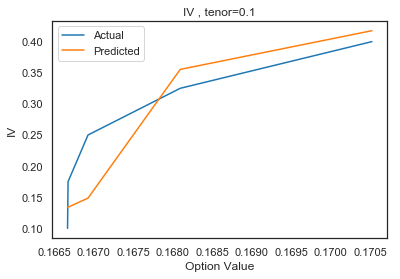

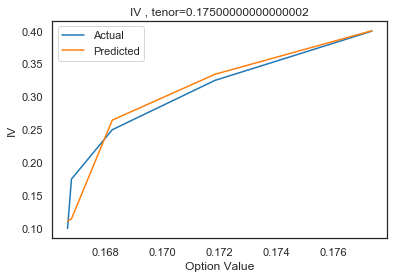

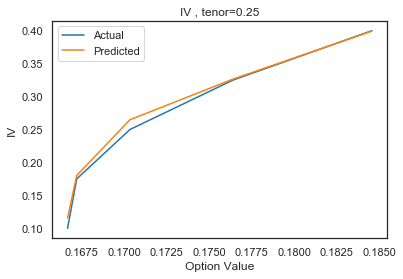

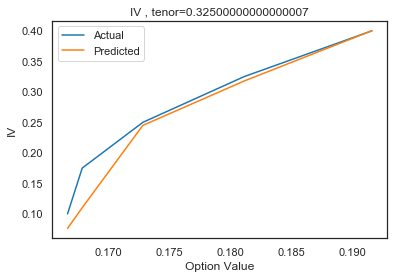

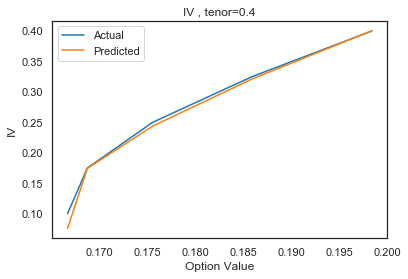

In [6]:
mat = np.linspace(0.1, 0.4, 5)
model = create_multy_model(layers, hidden_units, modelFile)
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
for i in range(5):
    f, strike, t, vol = [1.2], [1], [mat[i]], np.linspace(0.1,0.4, 5)
    inputs = np.array(np.meshgrid(f, strike, t, vol)).T.reshape(-1, 4)
    
    prices = blackScholesPriceTrue(inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3])
    vols = inputs[:,[-1]].flatten()
    inputs[:, -1] = prices
    pred_vols = model.predict(inputs)
    plt.figure(i)
    plt.title("IV , tenor={}".format(vols[i]))
    plt.plot(prices, vols, label='Actual')
    plt.plot(prices, pred_vols, label='Predicted')
    plt.xlabel("Option Value")
    plt.ylabel("IV")
    plt.legend()


In [7]:
val_generator.__getitem__(0)[0]

array([[1.50000000e+00, 5.00000000e-01, 5.50000000e-01, 6.66758560e-01],
       [1.37500000e+00, 5.00000000e-01, 1.00000000e-01, 6.36363636e-01],
       [1.37500000e+00, 1.00000000e+00, 7.75000000e-01, 2.72822663e-01],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e-01, 1.26156574e-03],
       [1.37500000e+00, 1.00000000e+00, 1.00000000e+00, 3.39280990e-01],
       [1.12500000e+00, 5.00000000e-01, 5.50000000e-01, 5.55555796e-01]])